# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 2
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


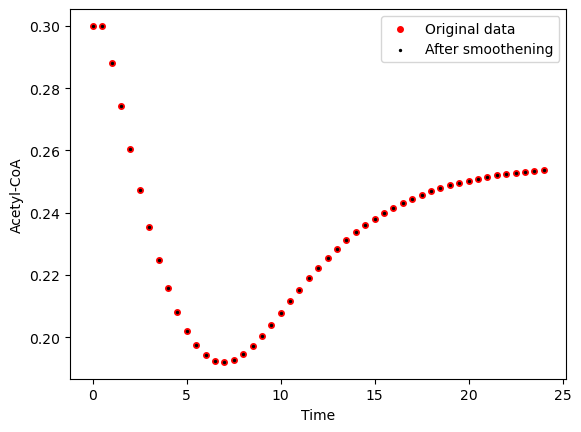

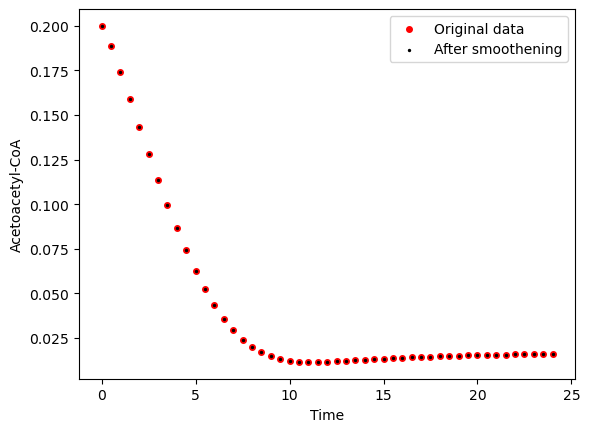

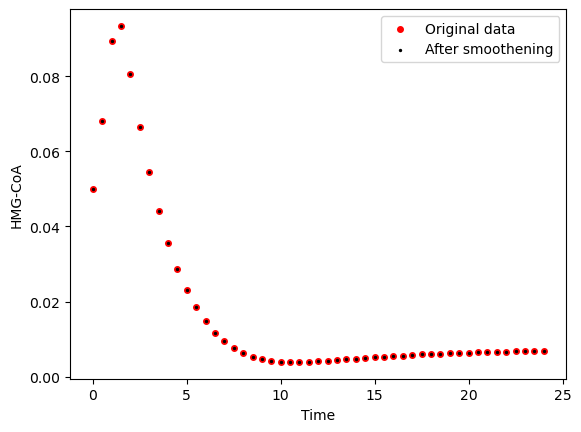

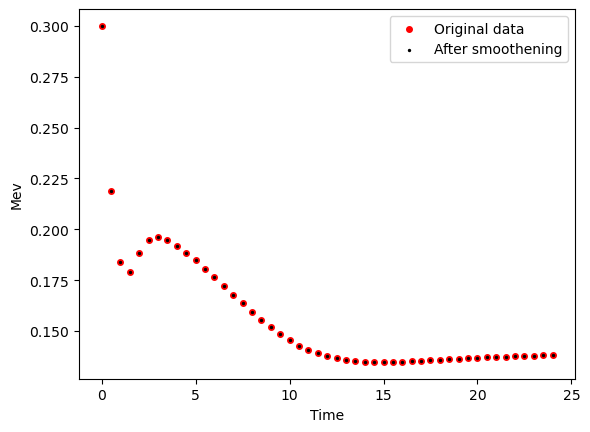

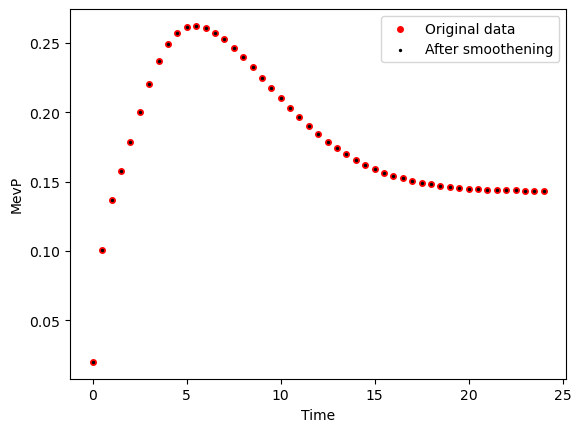

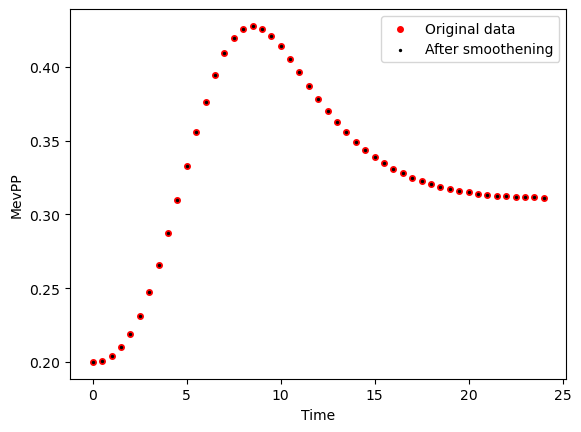

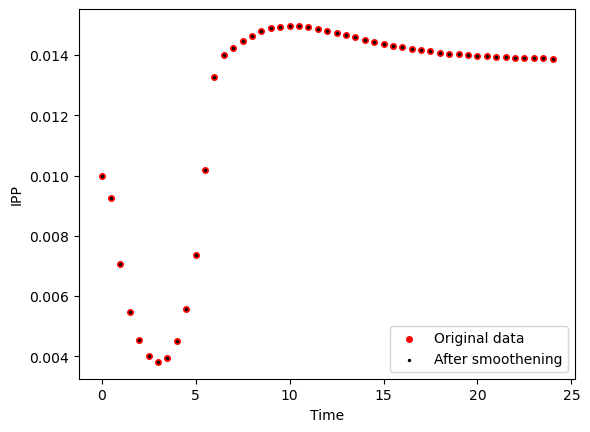

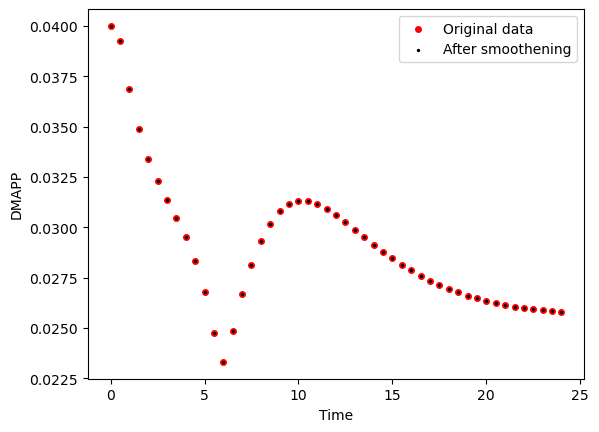

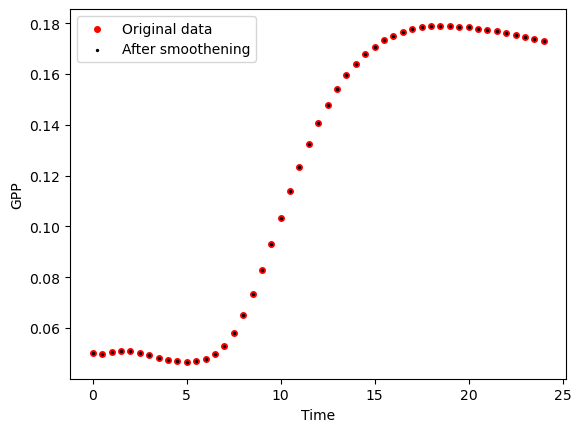

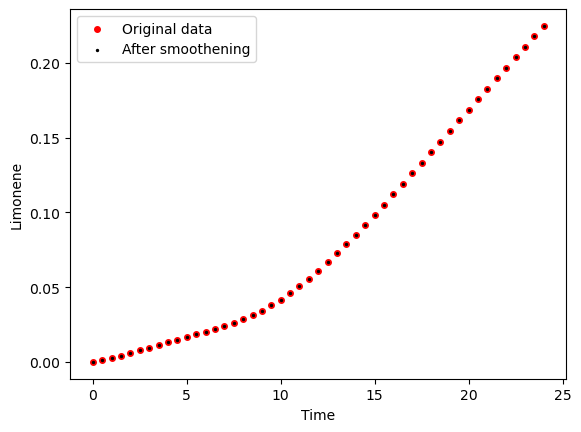

Strain Strain 2


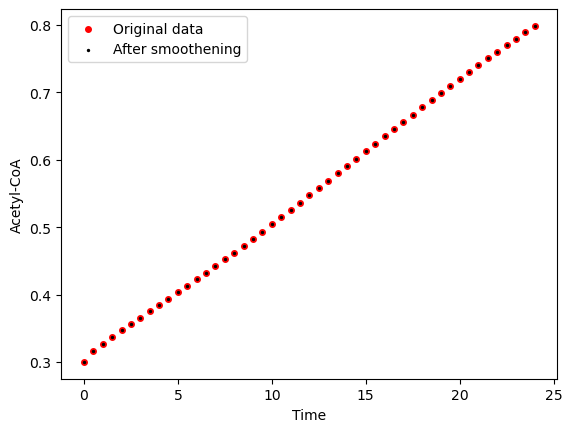

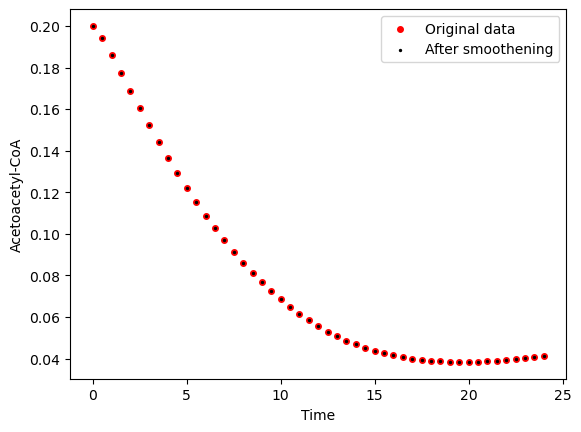

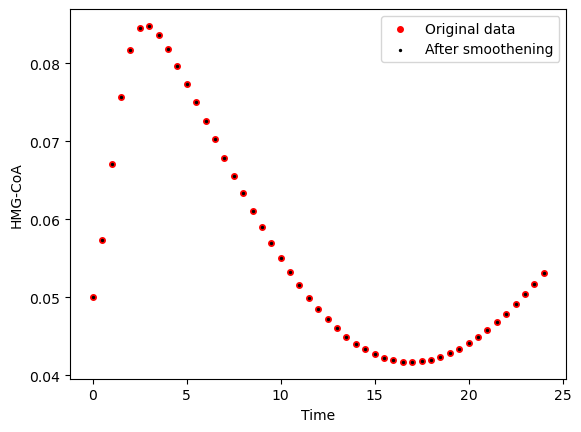

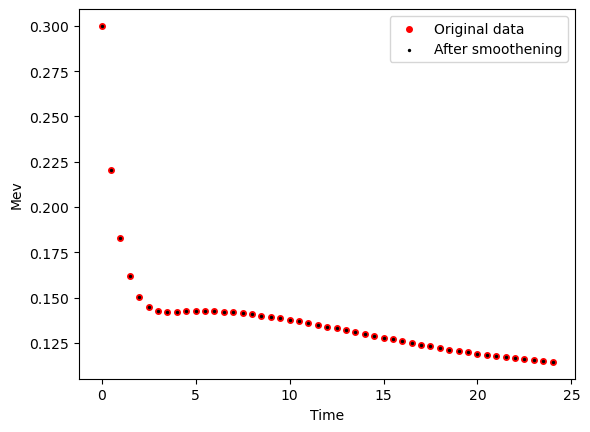

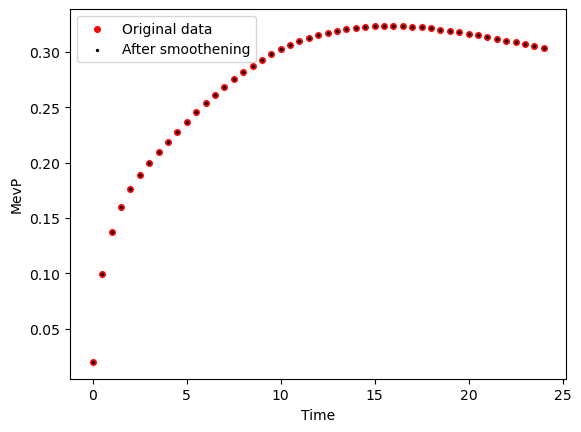

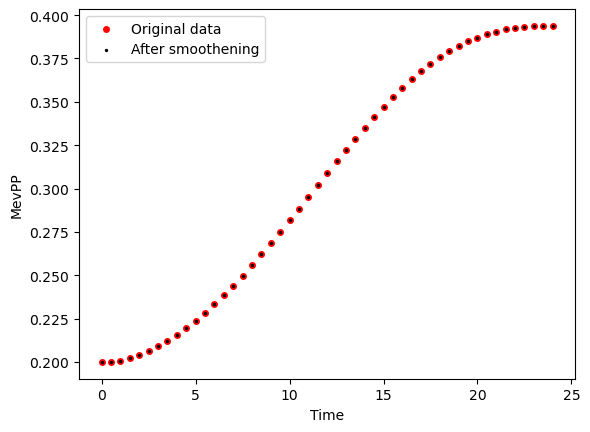

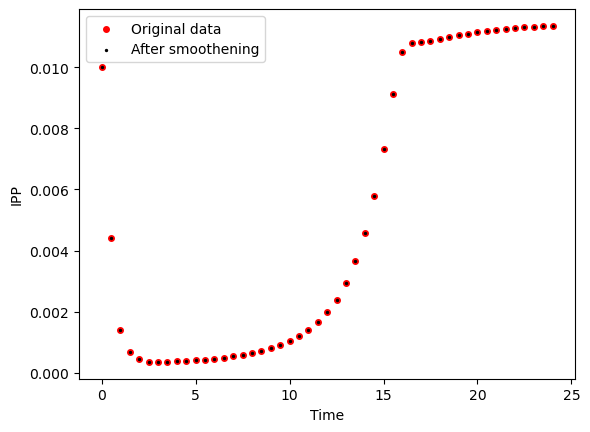

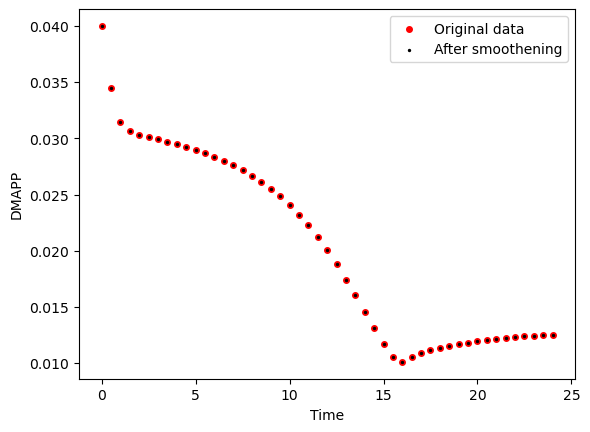

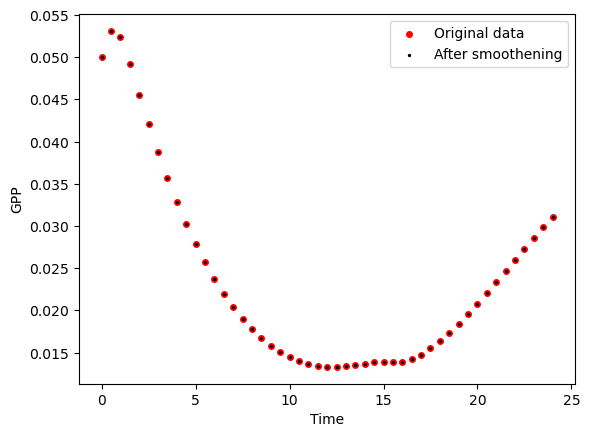

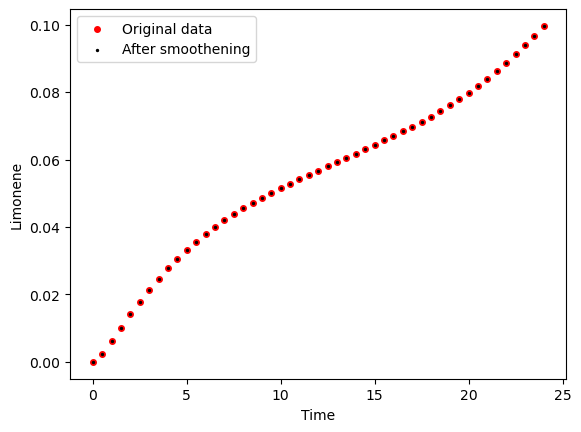

Strain Strain 3


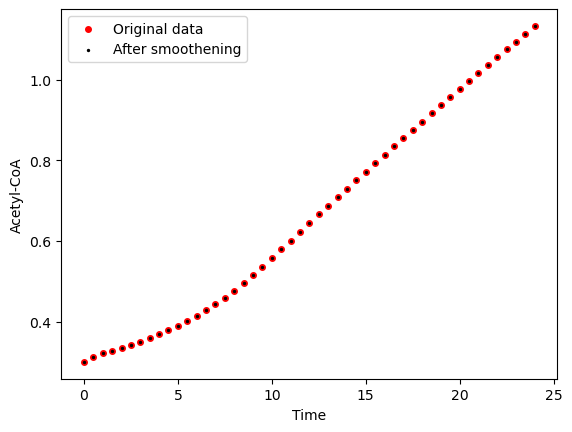

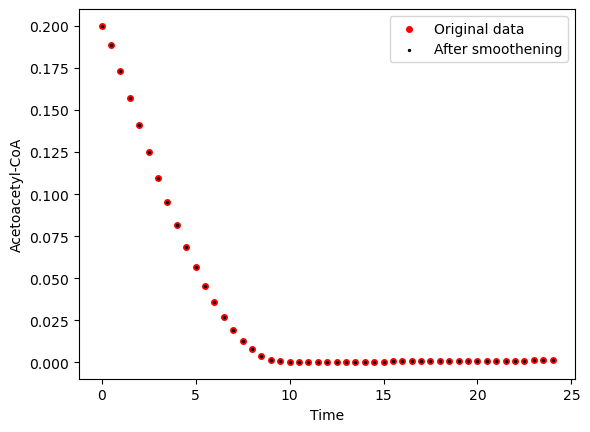

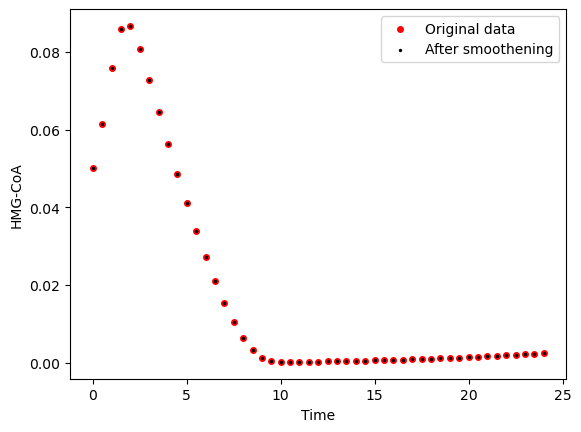

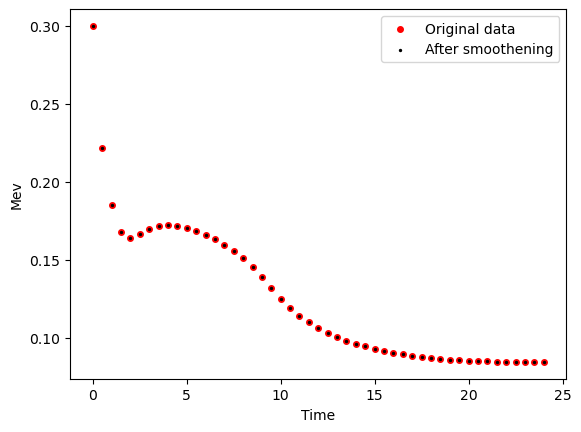

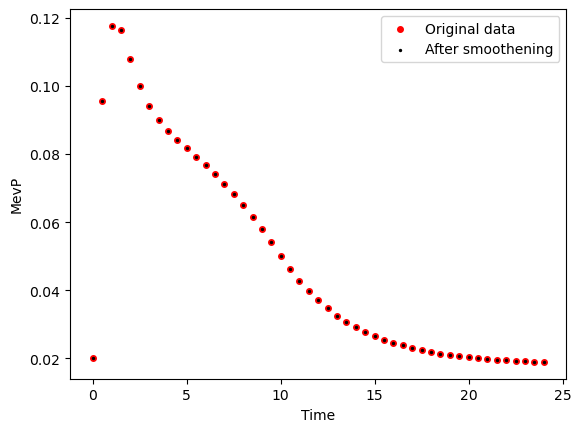

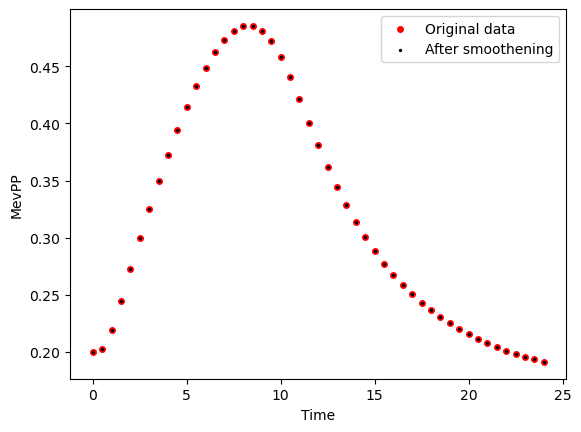

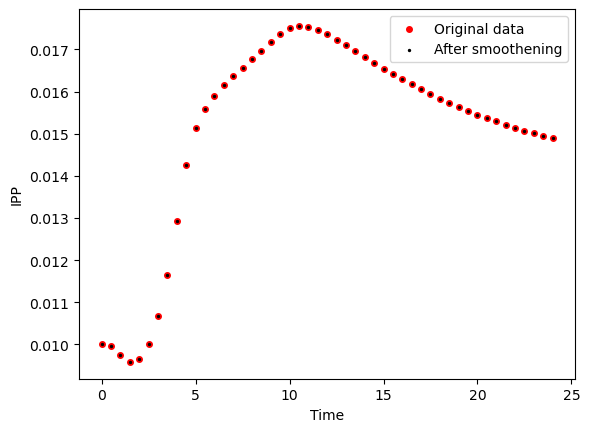

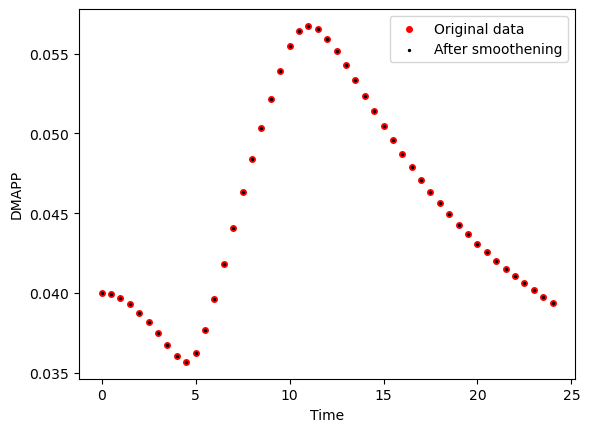

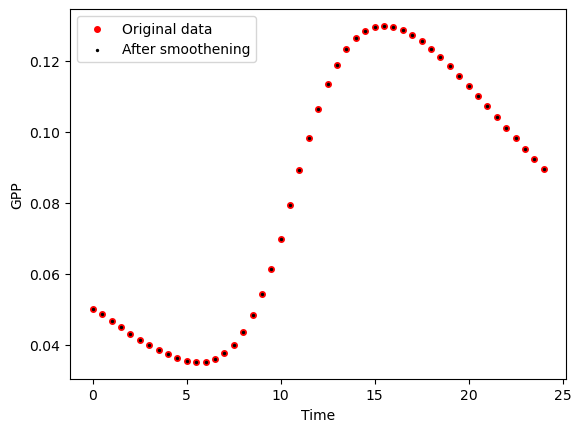

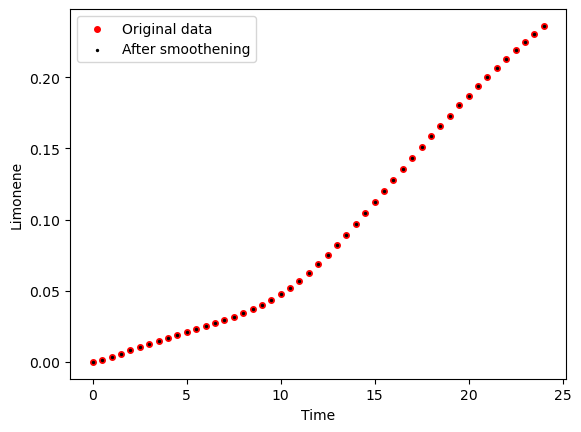

Strain WT


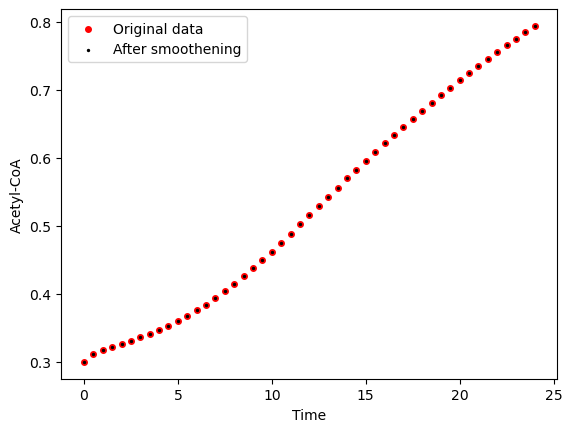

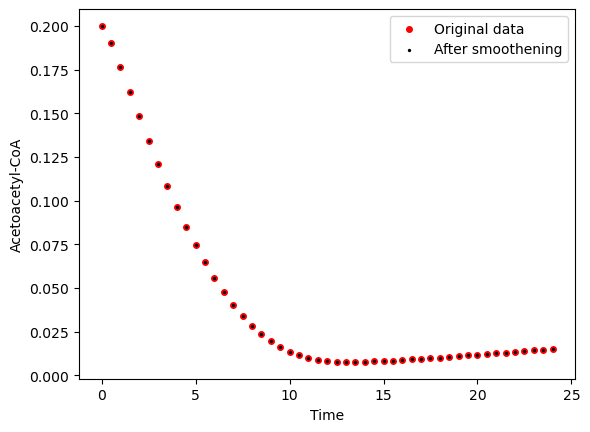

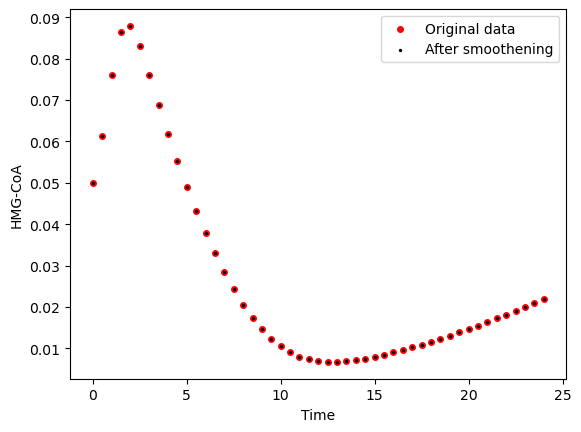

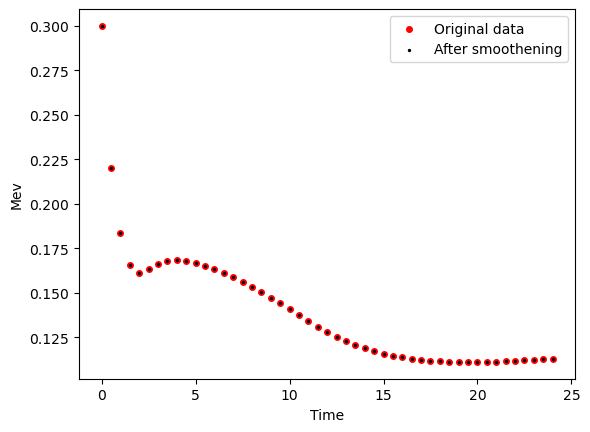

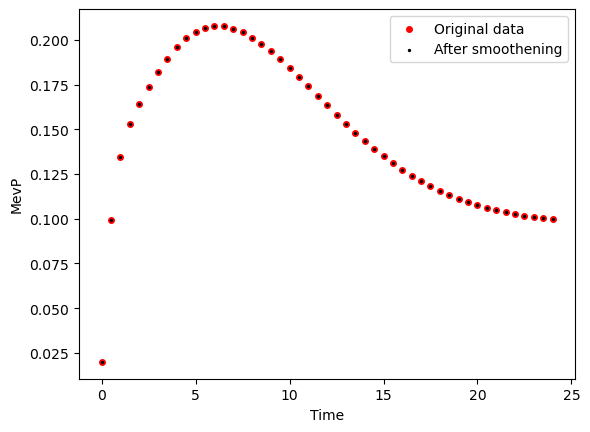

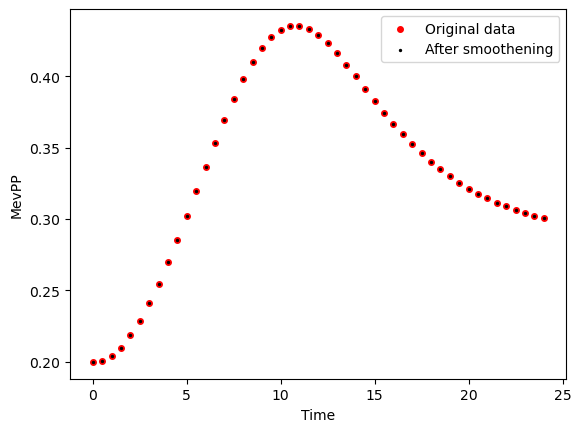

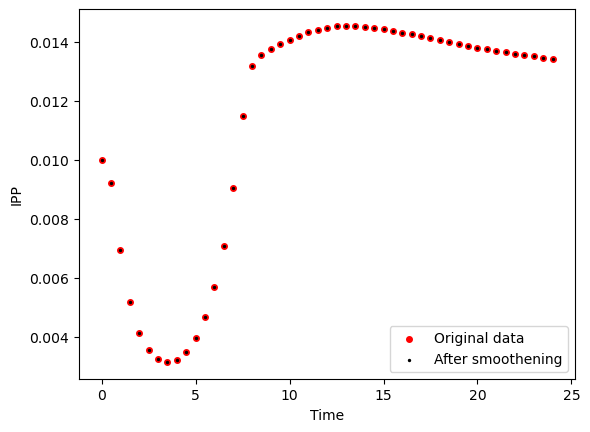

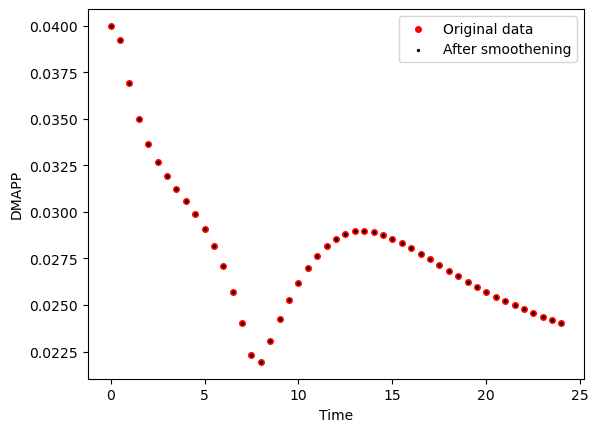

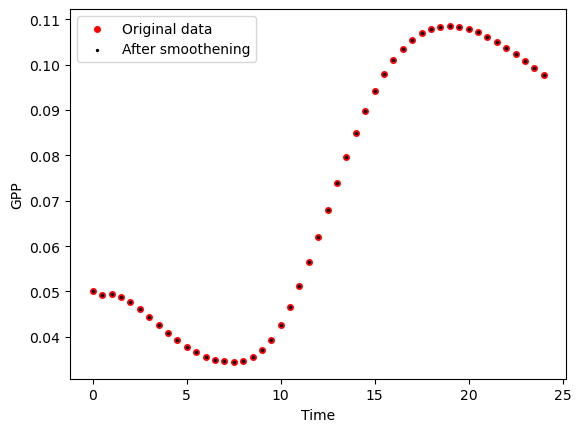

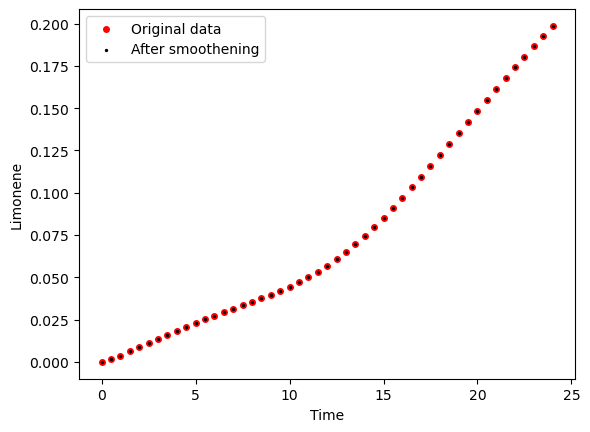

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


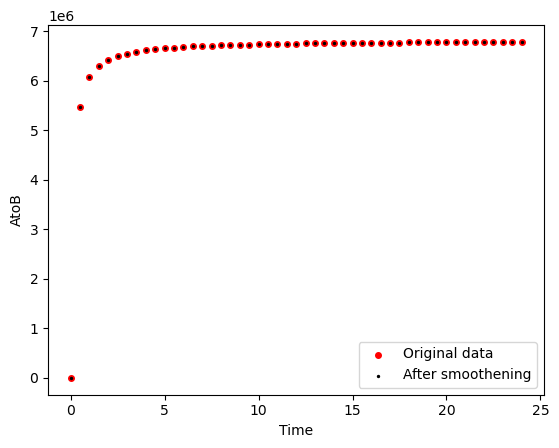

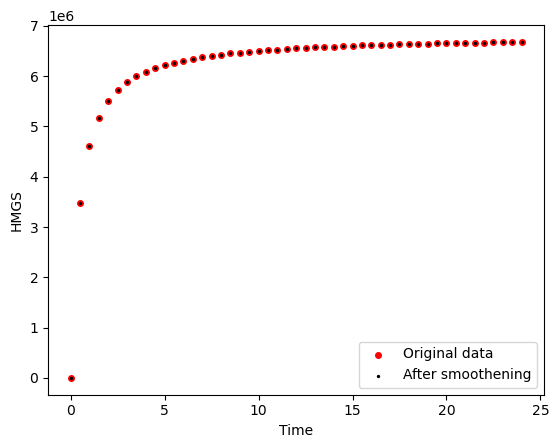

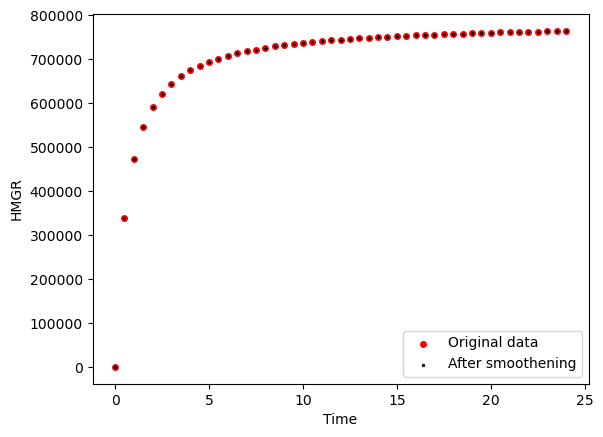

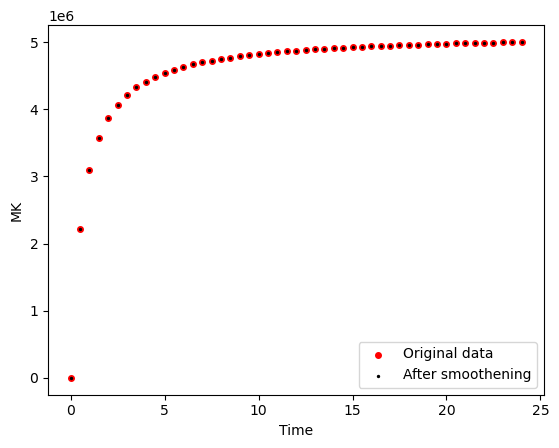

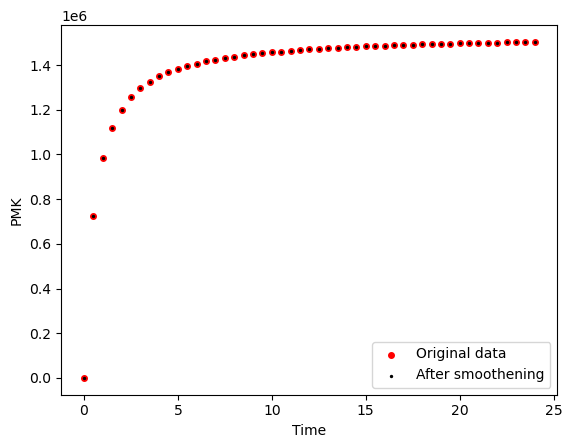

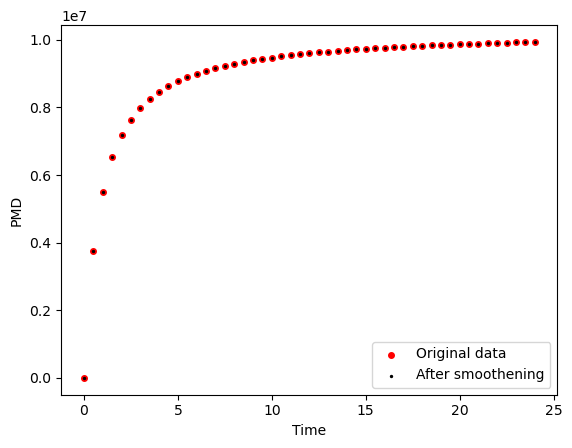

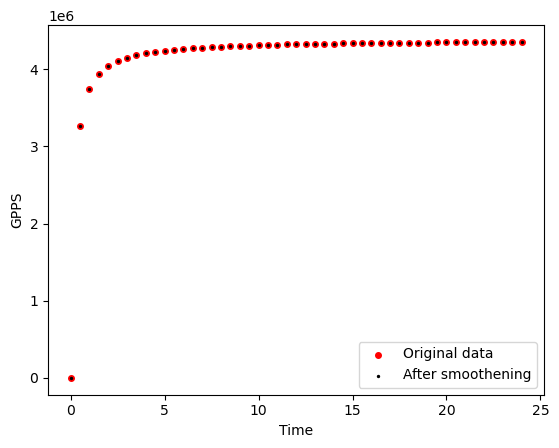

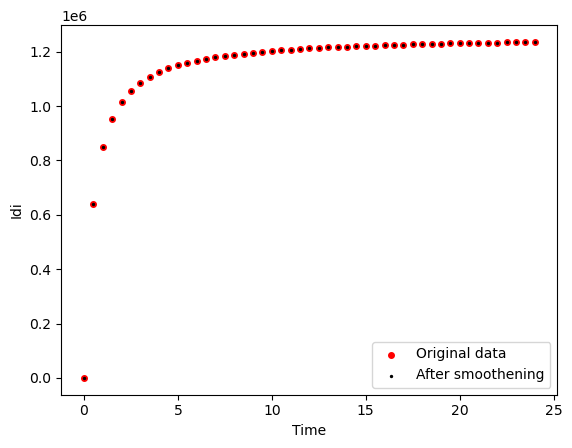

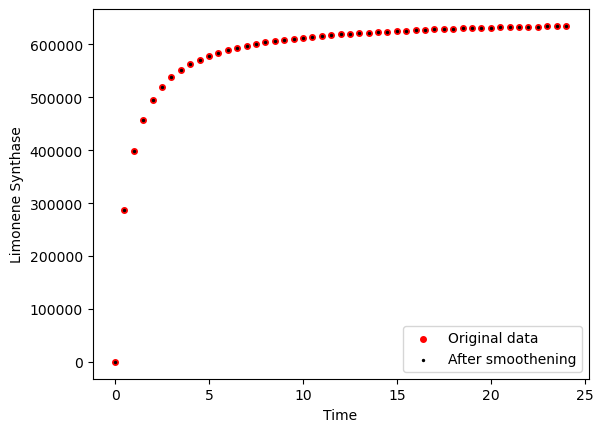

Strain Strain 2


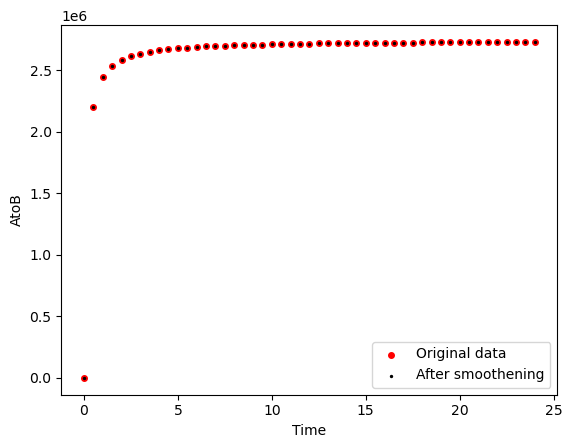

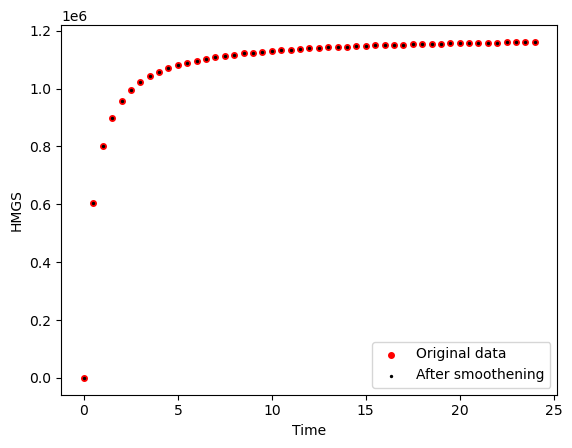

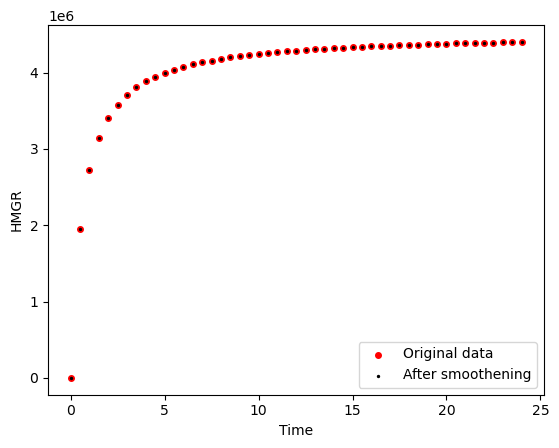

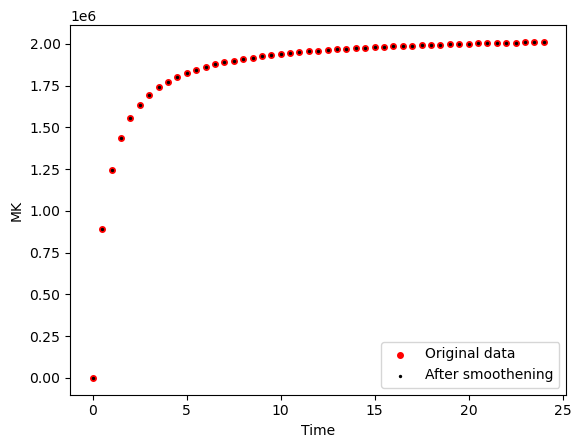

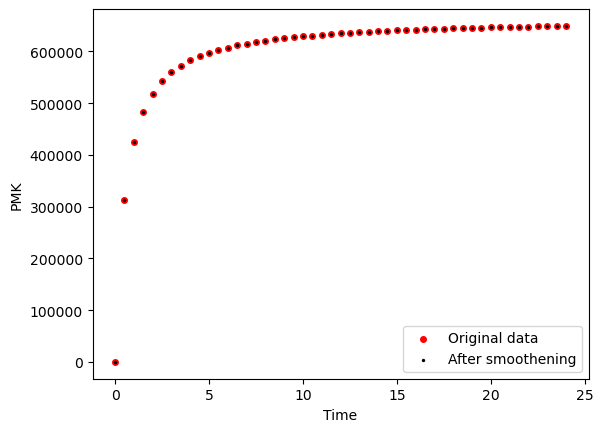

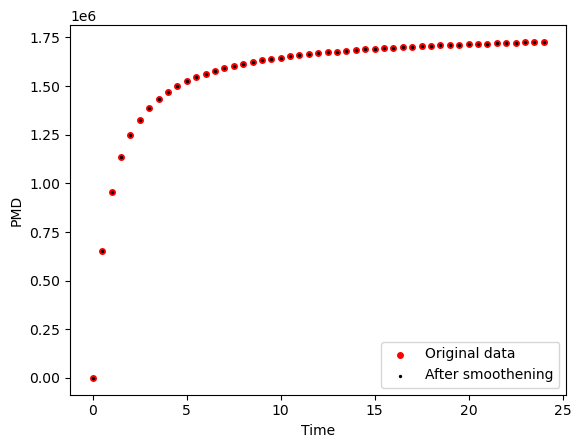

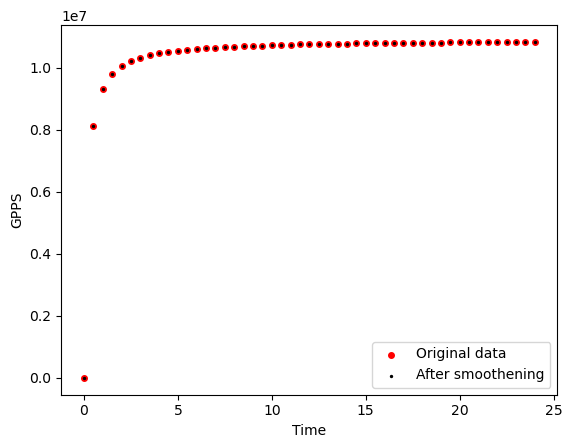

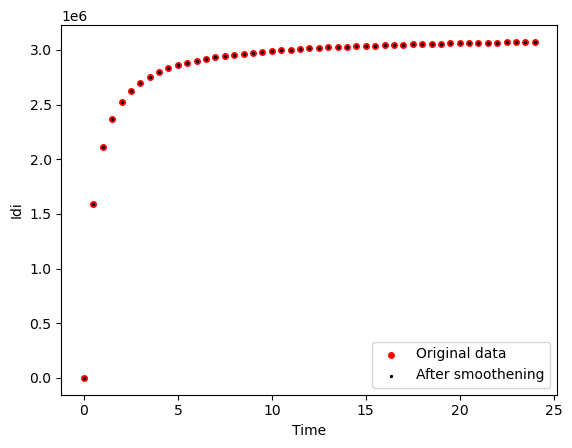

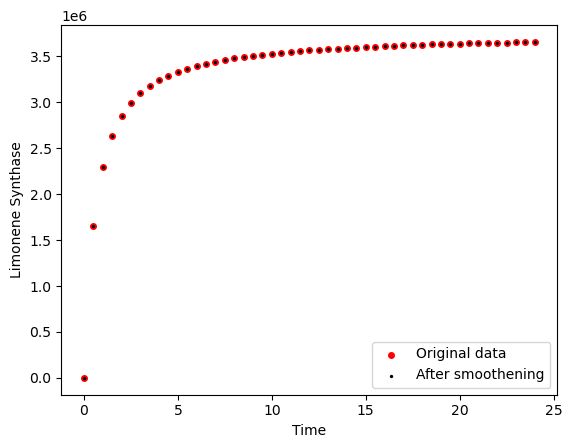

Strain Strain 3


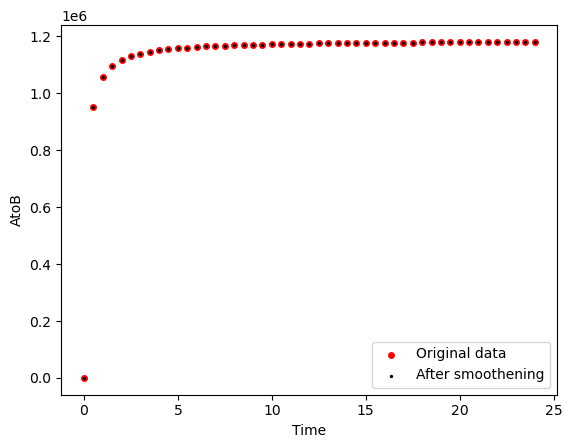

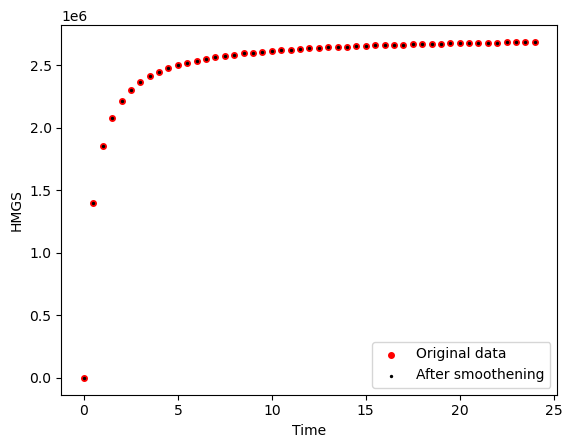

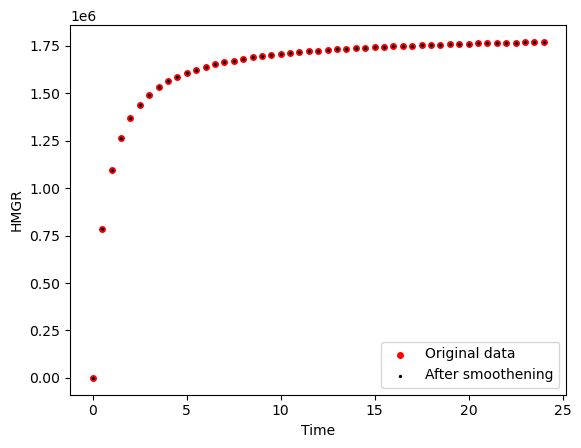

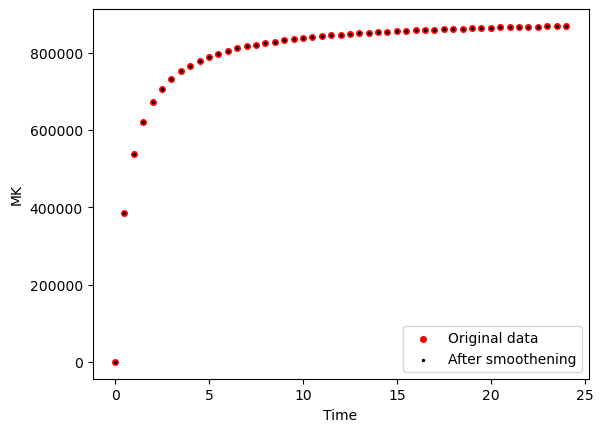

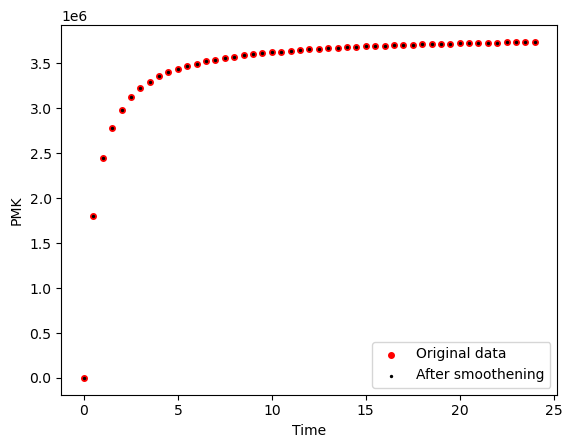

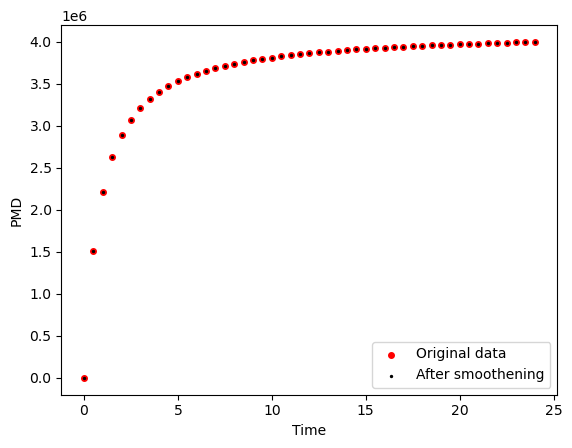

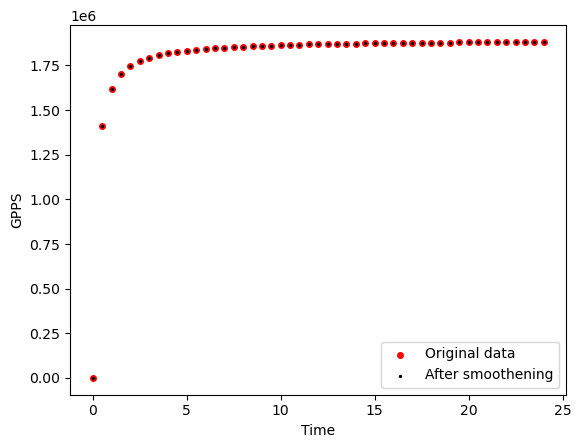

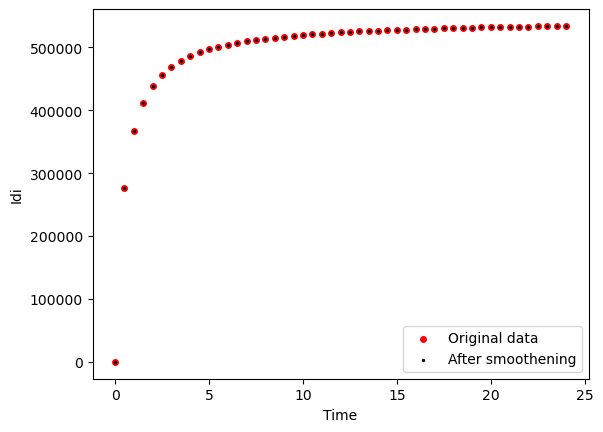

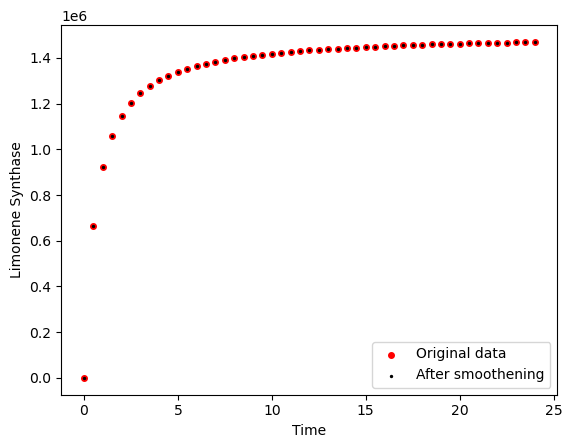

Strain WT


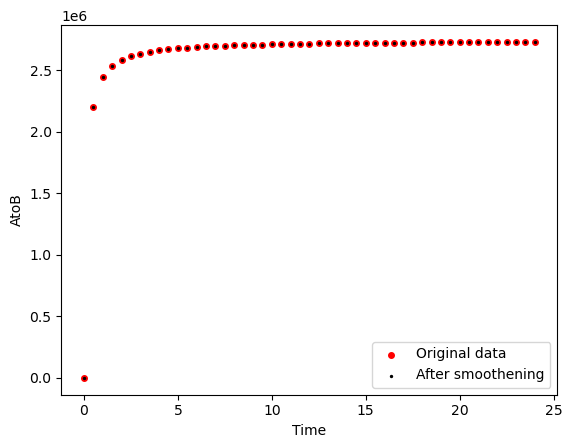

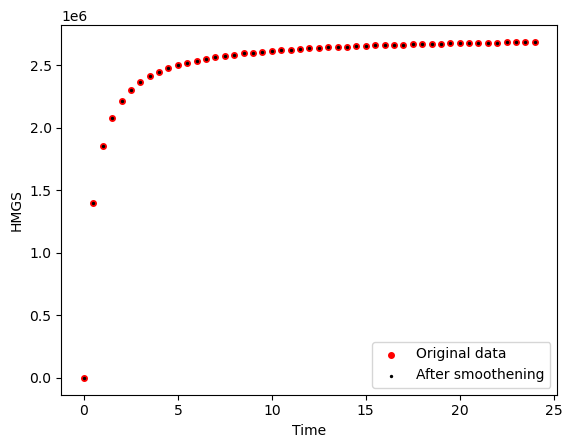

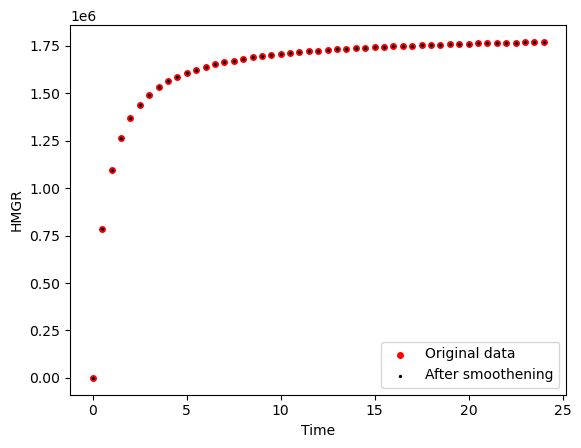

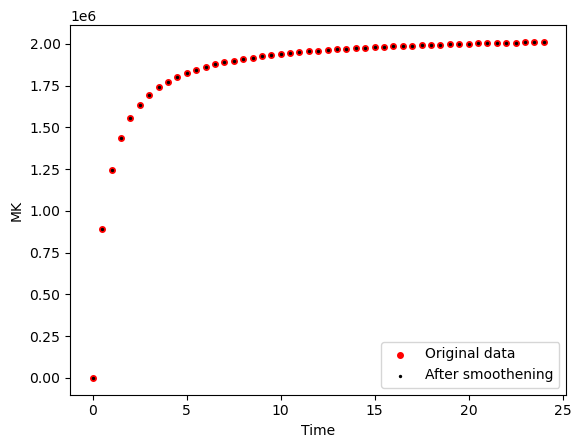

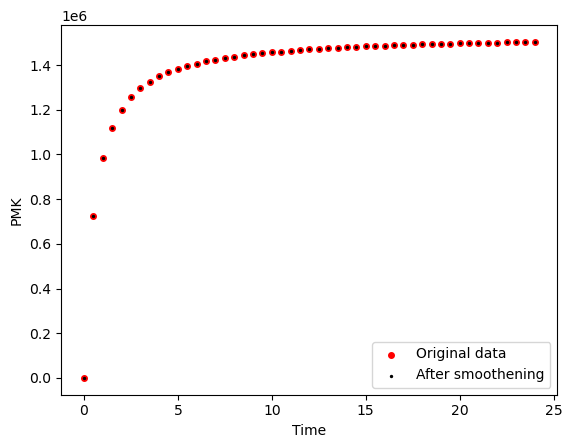

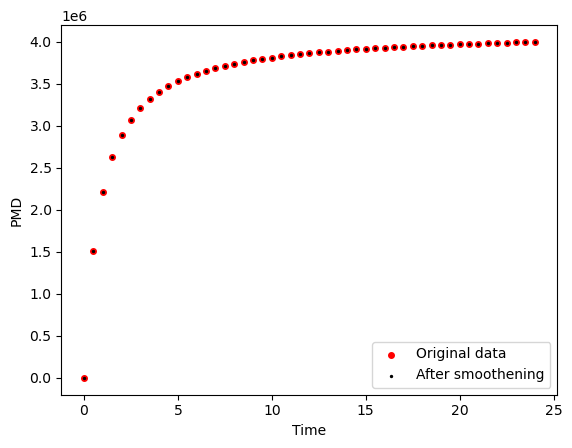

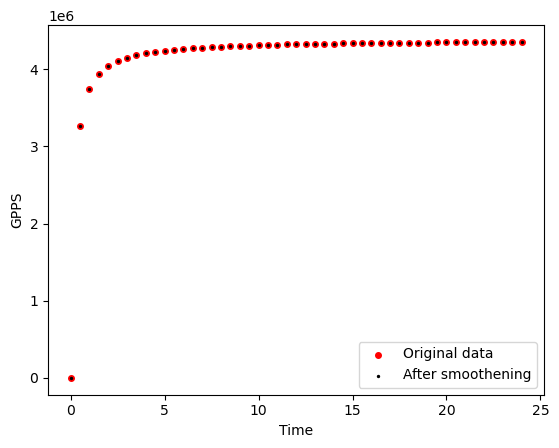

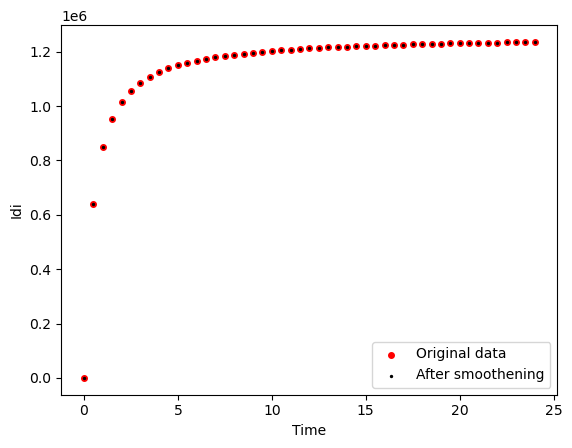

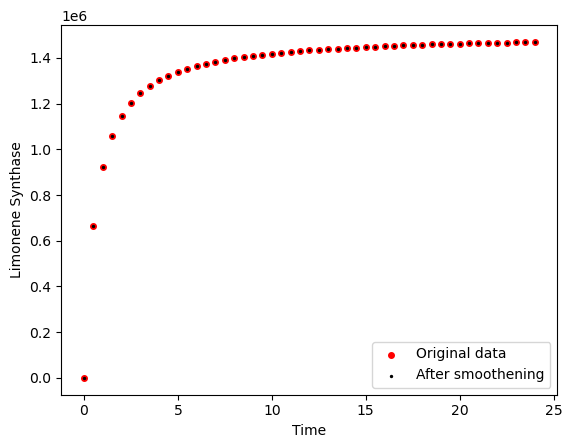

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
...                  ...             ...       ...       ...       ...   
WT       22.0   0.755407        0.013340  0.018112  0.111883  0.102630   
         22.5   0.765314        0.013753  0.019019  0.112124  0.101762   
         23.0   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.5   0.784584        0.014581  0.020886  0.112676  0.100406   
         24.0   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  ...   
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       22.0  0.308770  0.013585  0.024759  0.103766  0.174178  ...   
         22.5  0.306400  0.013541  0.024553  0.102364  0.180419  ...   
         23.0  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.5  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         24.0  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.003492       -0.021533  0.068282 -0.211321  0.178788   
         0.5    -0.012643       -0.026167  0.038730 -0.110383  0.112107   
         1.0    -0.023589       -0.029322  0.014092 -0.037507  0.064958   
         1.5    -0.029345       -0.030998 -0.005633  0.007307  0.037341   
         2.0    -0.027331       -0.030617 -0.026914  0.017786  0.040362   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019998        0.000825  0.001796  0.000453 -0.001872   
         22.5    0.019630        0.000827  0.001832  0.000508 -0.001602   
         23.0    0.019269        0.000828  0.001867  0.000554 -0.001353   
         23.5    0.018914        0.000829  0.001899  0.000591 -0.001124   
         24.0    0.018565        0.000828  0.001930  0.000618 -0.000915   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001573 -0.002269 -0.001983  0.000353  0.001694  
         0.5   0.003675 -0.003001 -0.003208  0.000738  0.002505  
         1.0   0.009271 -0.003204 -0.003821  0.000731  0.003103  
         1.5   0.015214 -0.002876 -0.003819  0.000331  0.003487  
         2.0   0.021619 -0.001475 -0.002599 -0.000977  0.003575  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.005021 -0.000092 -0.000424 -0.002691  0.012565  
         22.5 -0.004467 -0.000086 -0.000399 -0.002906  0.012399  
         23.0 -0.003951 -0.000080 -0.000374 -0.003079  0.012223  
         23.5 -0.003476 -0.000075 -0.000349 -0.003204  0.012035  
         24.0 -0.003041 -0.000069 -0.000325 -0.003283  0.011835

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

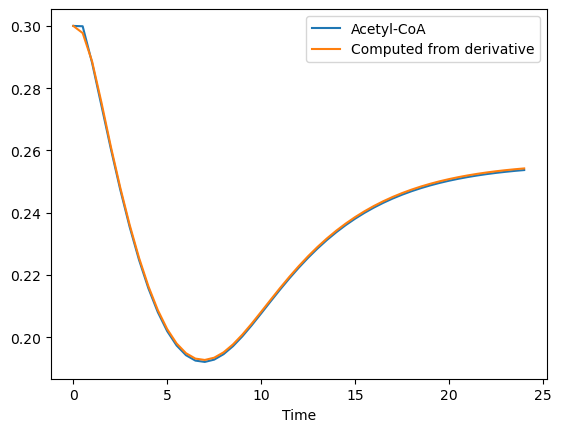

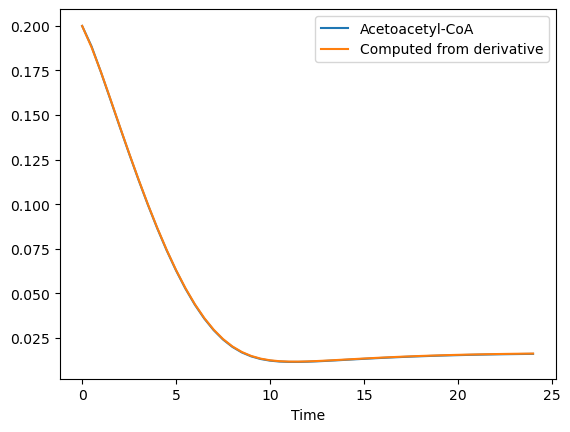

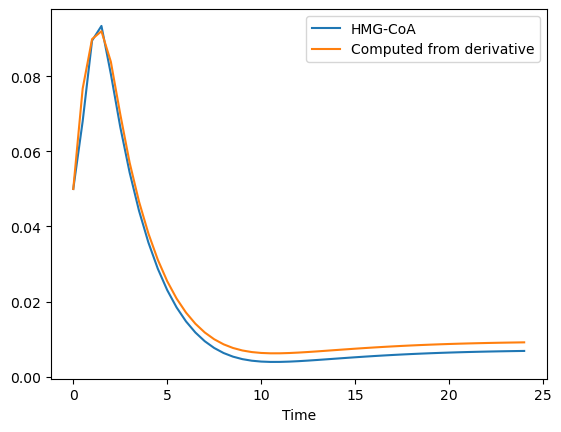

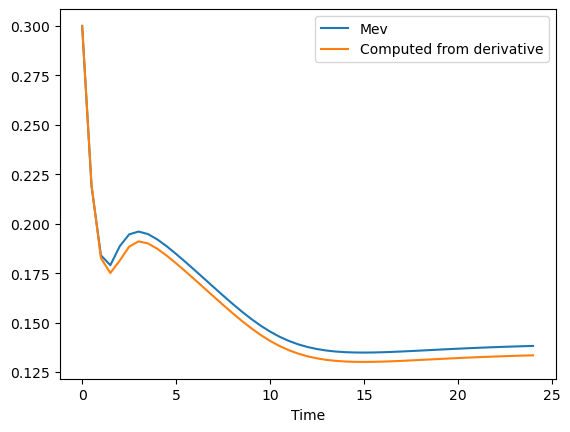

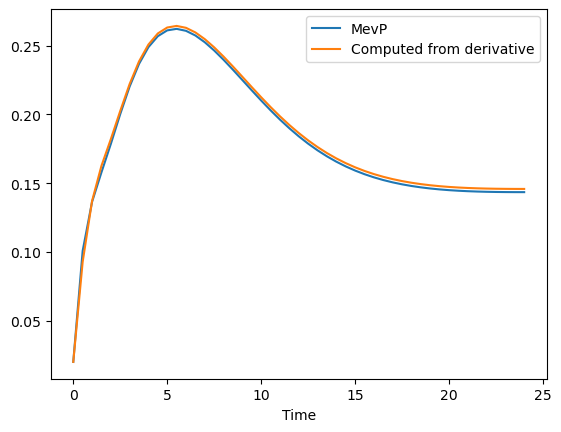

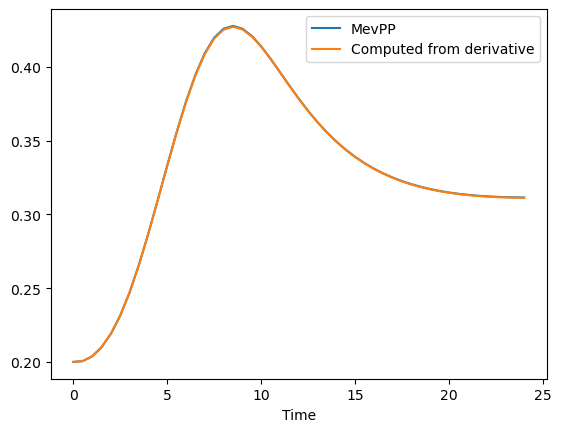

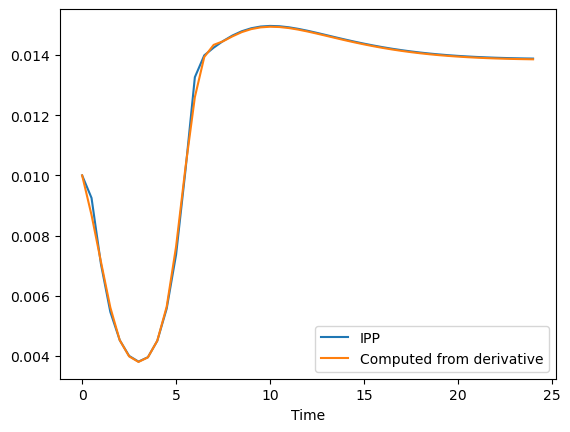

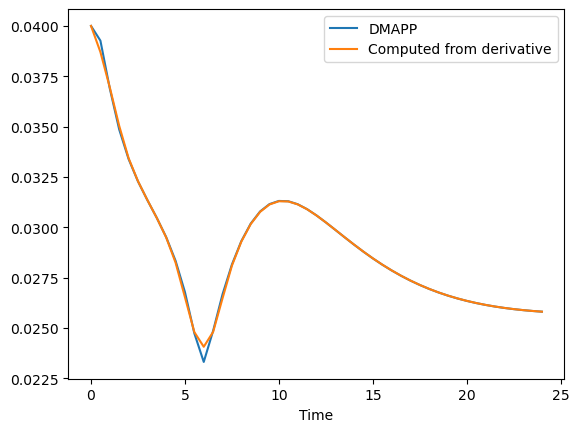

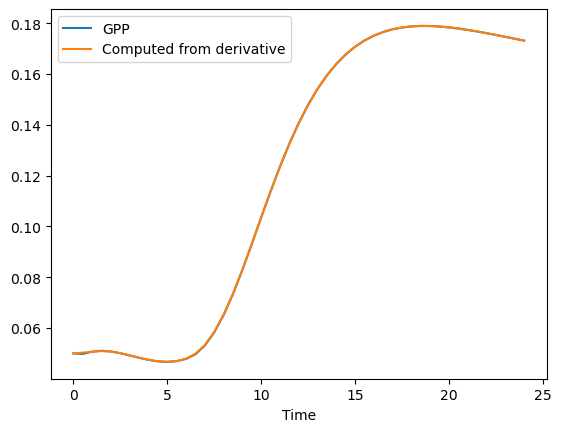

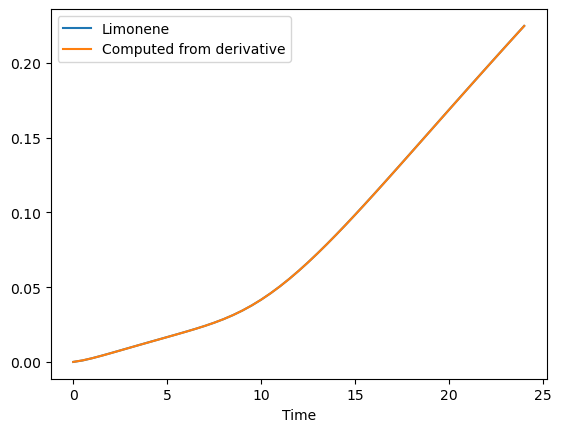

'Time profile from derivative vs. actual profile for Strain 2'

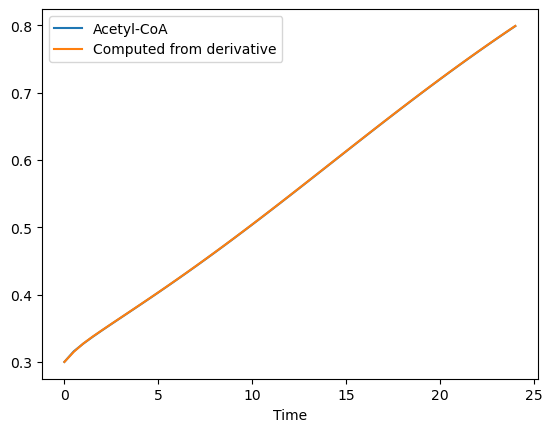

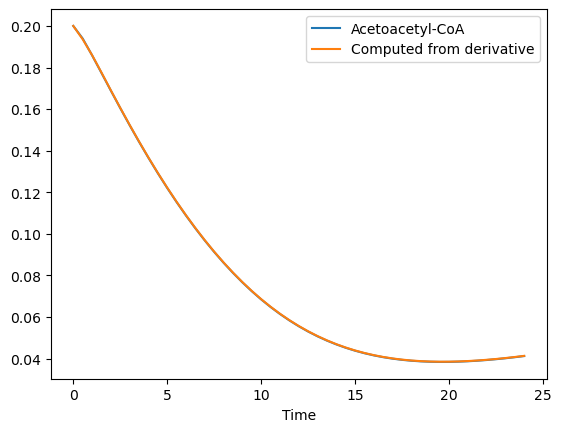

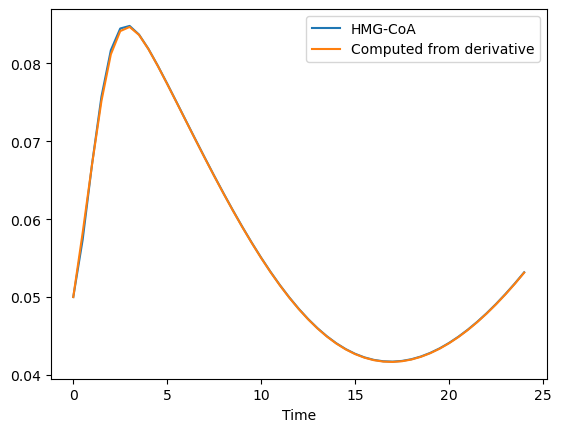

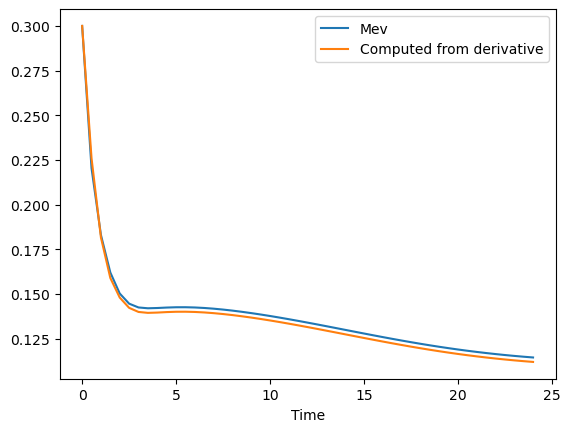

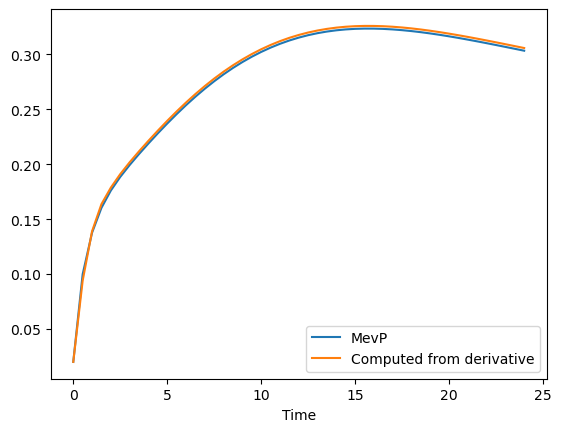

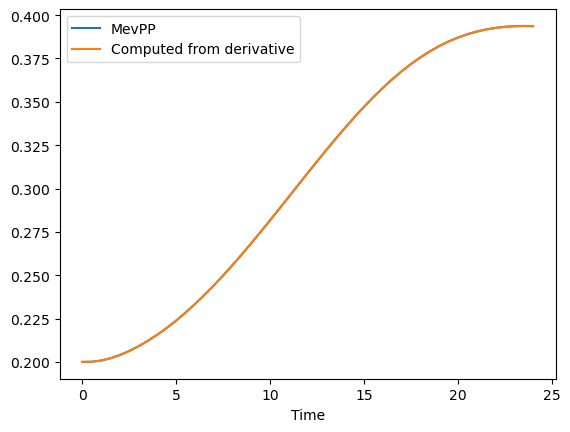

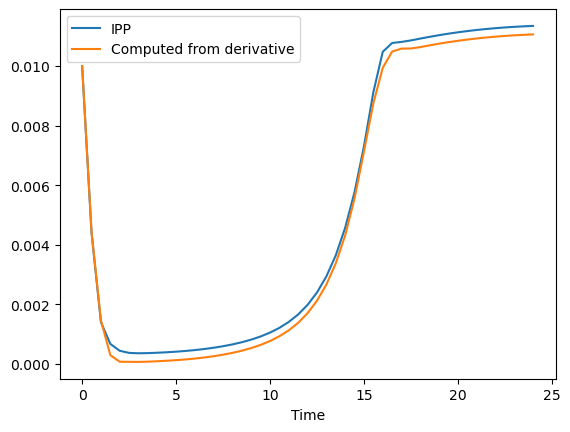

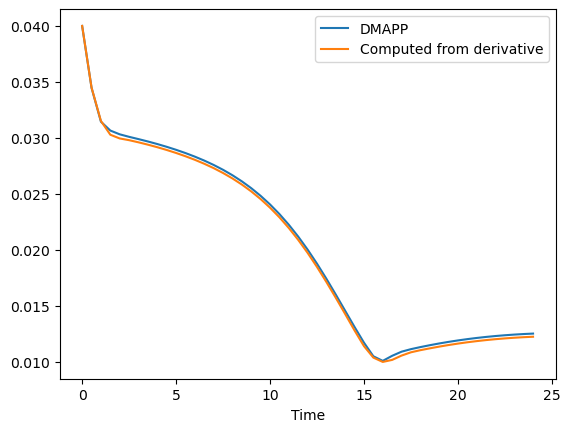

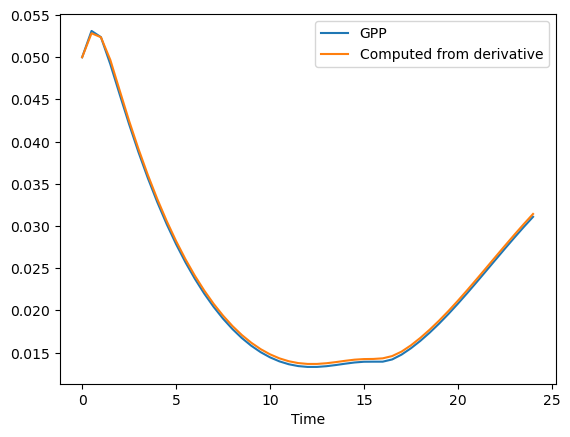

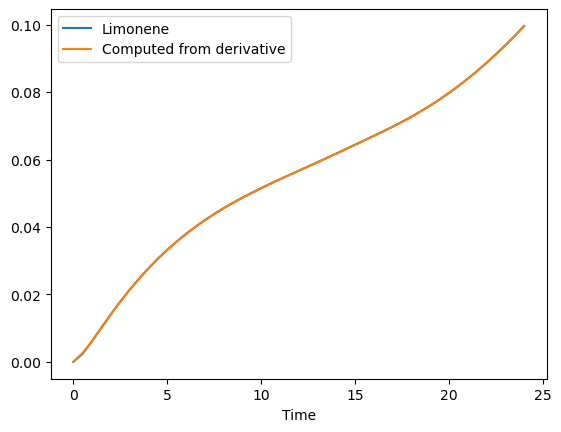

'Time profile from derivative vs. actual profile for Strain 3'

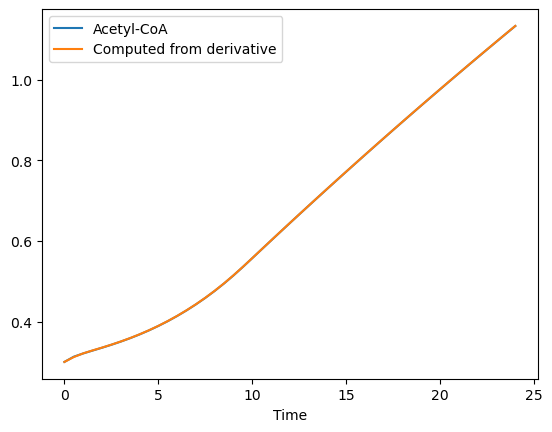

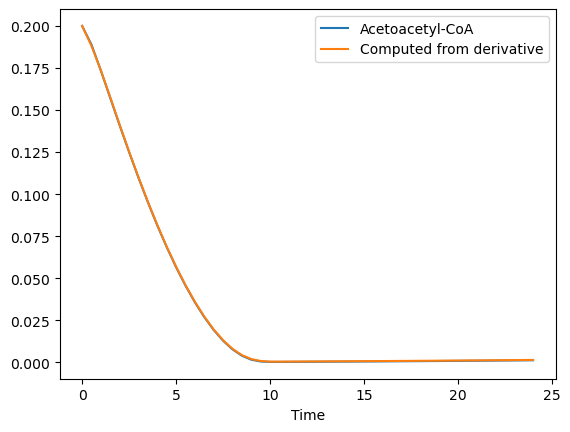

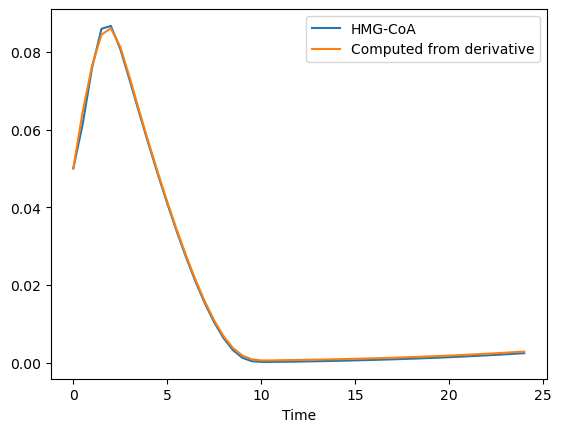

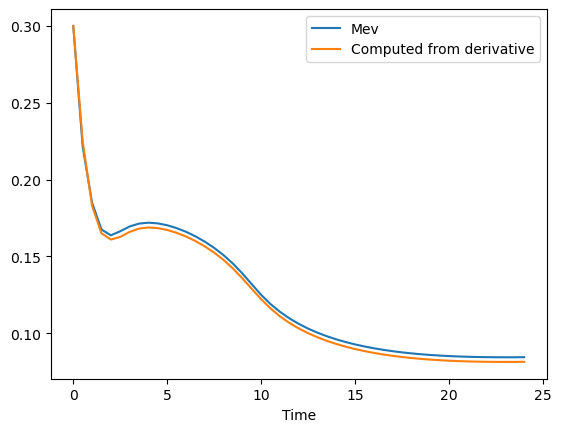

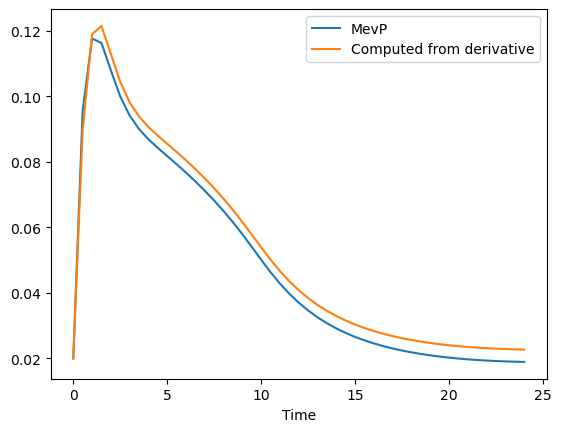

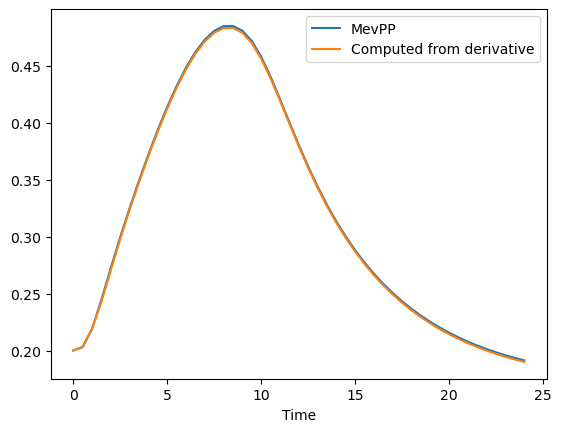

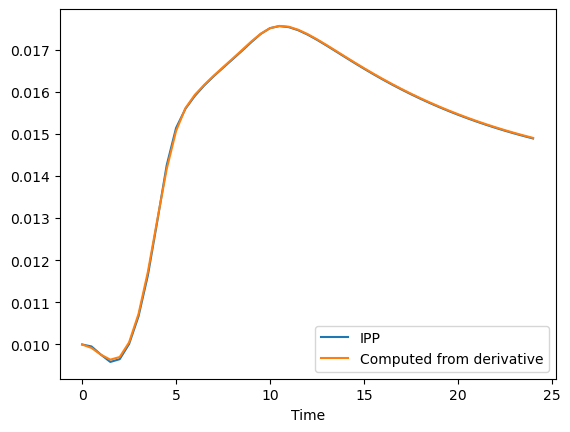

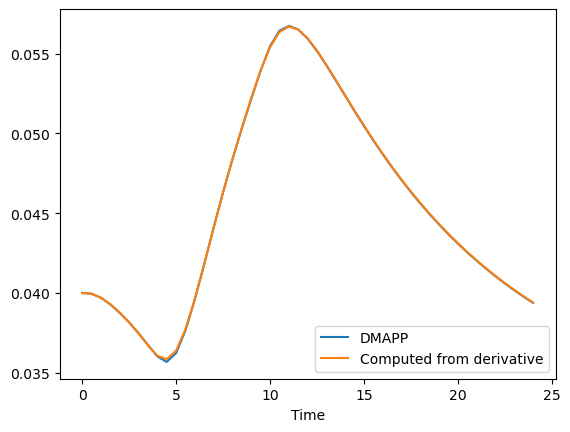

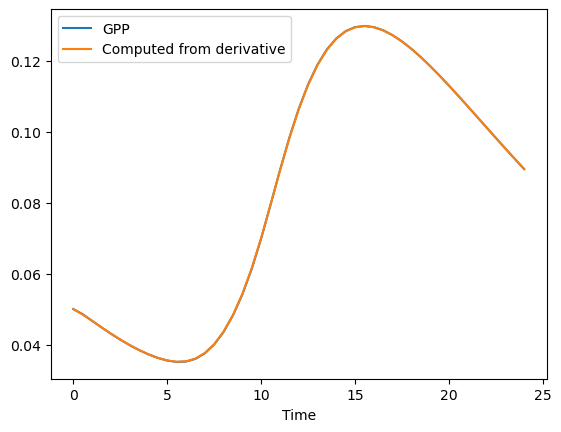

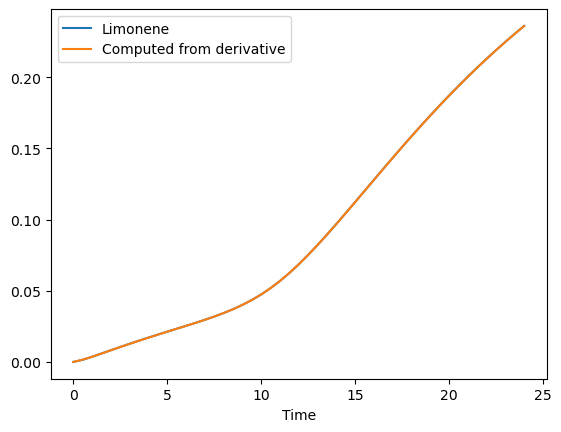

'Time profile from derivative vs. actual profile for WT'

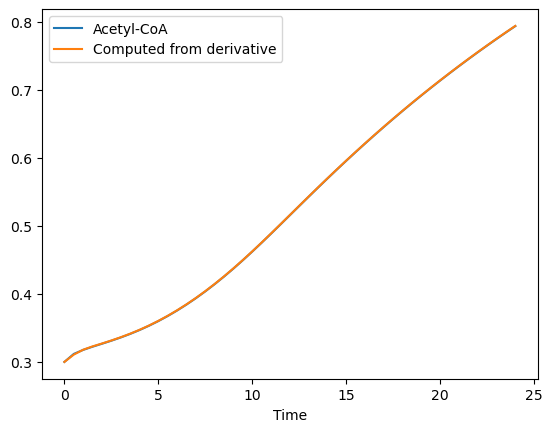

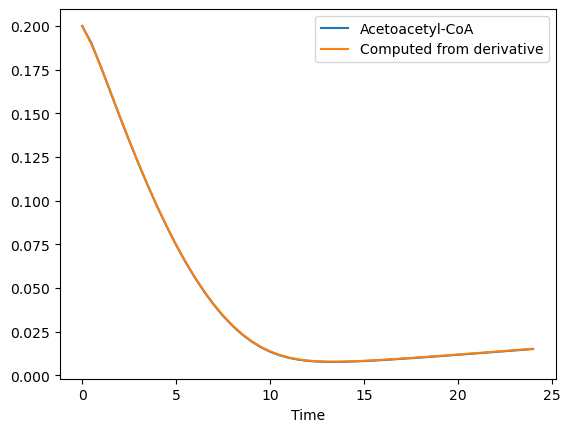

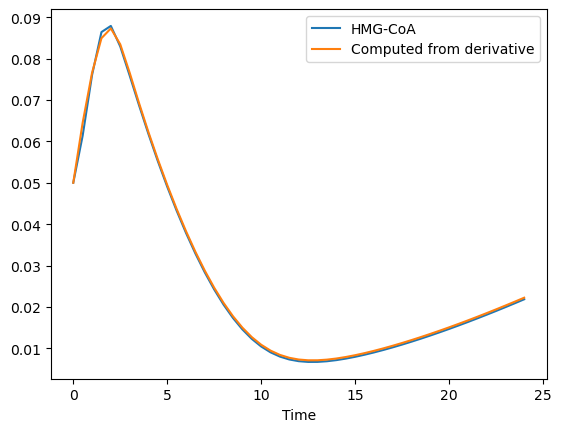

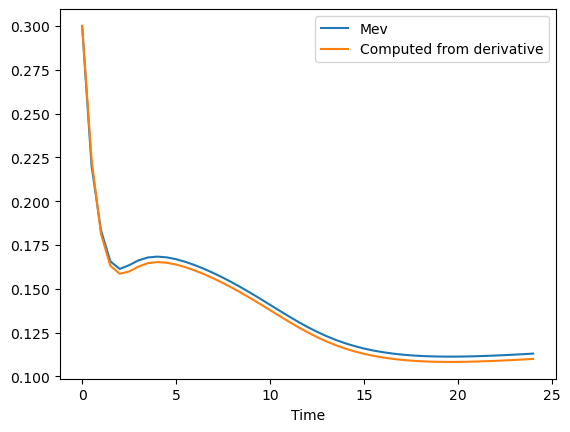

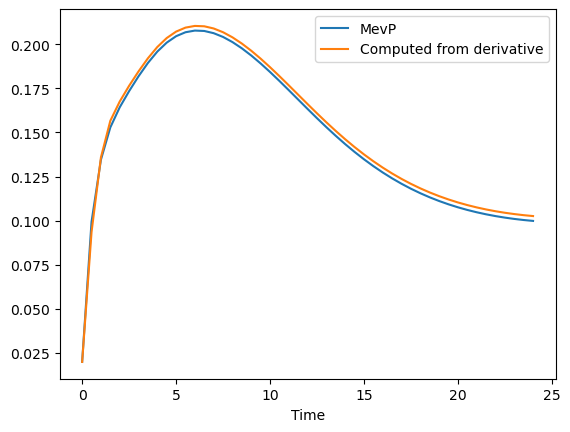

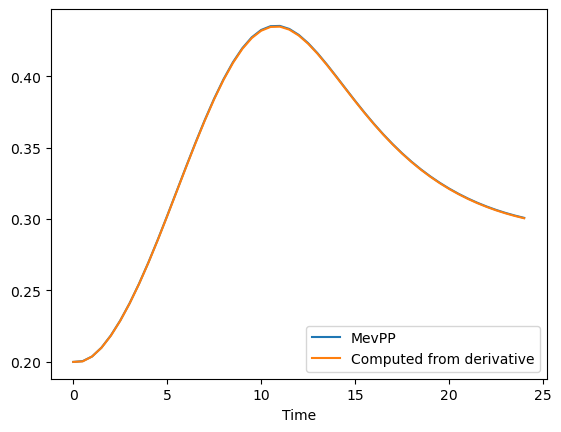

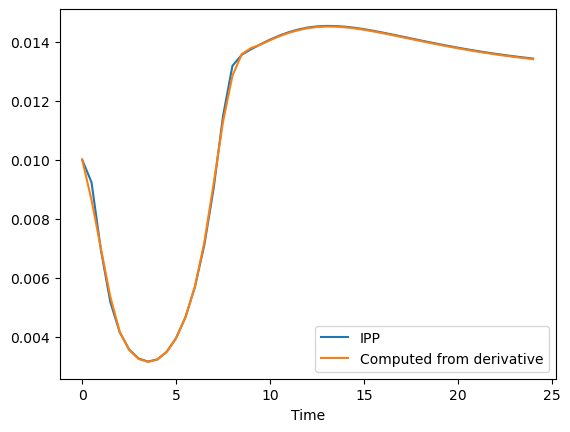

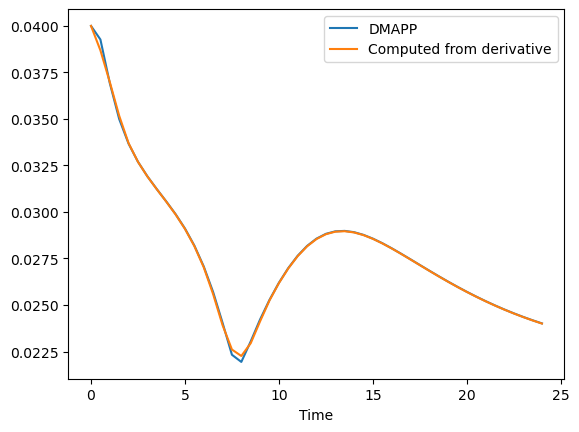

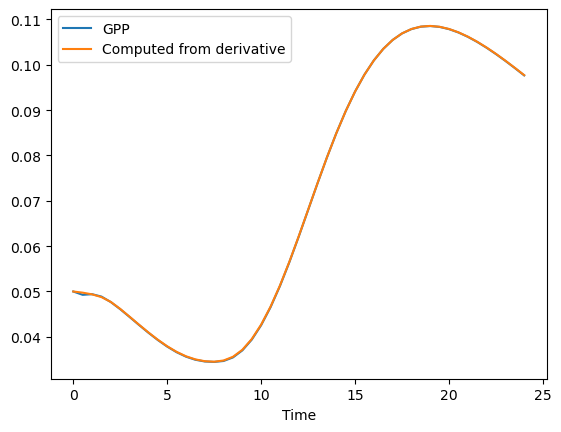

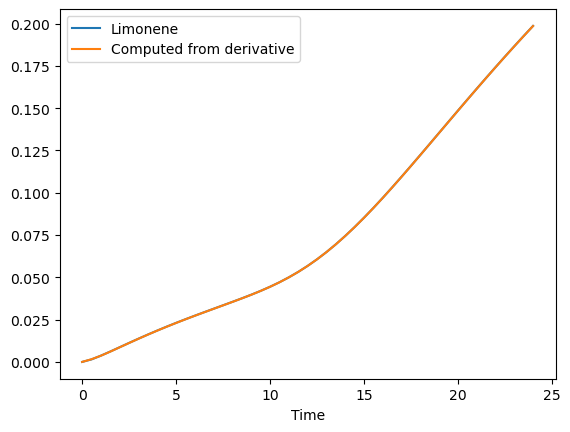

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  5.462870e+05  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
...                     ...           ...           ...           ...   
WT       22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         22.5  2.729080e+06  2.684265e+06  1.767009e+06  2.008539e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.5  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
...                     ...           ...           ...           ...   
WT       22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         22.5  1.500845e+06  3.987467e+06  4.353087e+06  1.234537e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.5  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         0.5       2.866143e+05   0.299893        0.188541  0.068037   
         1.0       3.981392e+05   0.288190        0.174077  0.089557   
         1.5       4.574783e+05   0.274398        0.158853  0.093482   
         2.0       4.943155e+05   0.260551        0.143504  0.080676   
...                         ...        ...             ...       ...   
WT       22.0      1.466213e+06   0.755407        0.013340  0.018112   
         22.5      1.467130e+06   0.765314        0.013753  0.019019   
         23.0      1.468009e+06   0.775039        0.014167  0.019944   
         23.5      1.468851e+06   0.784584        0.014581  0.020886   
         24.0      1.469659e+06   0.793953        0.014996  0.021843   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.5   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         1.0   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
         1.5   0.179006  0.157845  0.209860  0.005463  0.034856  0.051042   
         2.0   0.188562  0.178523  0.219000  0.004525  0.033388  0.050751   
...                 ...       ...       ...       ...       ...       ...   
WT       22.0  0.111883  0.102630  0.308770  0.013585  0.024759  0.103766   
         22.5  0.112124  0.101762  0.306400  0.013541  0.024553  0.102364   
         23.0  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.5  0.112676  0.100406  0.302

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.003492       -0.021533  0.068282 -0.211321  0.178788   
         0.5    -0.012643       -0.026167  0.038730 -0.110383  0.112107   
         1.0    -0.023589       -0.029322  0.014092 -0.037507  0.064958   
         1.5    -0.029345       -0.030998 -0.005633  0.007307  0.037341   
         2.0    -0.027331       -0.030617 -0.026914  0.017786  0.040362   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019998        0.000825  0.001796  0.000453 -0.001872   
         22.5    0.019630        0.000827  0.001832  0.000508 -0.001602   
         23.0    0.019269        0.000828  0.001867  0.000554 -0.001353   
         23.5    0.018914        0.000829  0.001899  0.000591 -0.001124   
         24.0    0.018565        0.000828  0.001930  0.000618 -0.000915   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001573 -0.002269 -0.001983  0.000353  0.001694  
         0.5   0.003675 -0.003001 -0.003208  0.000738  0.002505  
         1.0   0.009271 -0.003204 -0.003821  0.000731  0.003103  
         1.5   0.015214 -0.002876 -0.003819  0.000331  0.003487  
         2.0   0.021619 -0.001475 -0.002599 -0.000977  0.003575  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.005021 -0.000092 -0.000424 -0.002691  0.012565  
         22.5 -0.004467 -0.000086 -0.000399 -0.002906  0.012399  
         23.0 -0.003951 -0.000080 -0.000374 -0.003079  0.012223  
         23.5 -0.003476 -0.000075 -0.000349 -0.003204  0.012035  
         24.0 -0.003041 -0.000069 -0.000325 -0.003283  0.011835  

[196 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 8.299013E+191 | 9.763284E+116
     2 |       74 | 1.789717E+115 |  4.036384E+83
     3 |      138 |  7.118494E+90 |  4.749039E+70
     4 |      202 |  1.536908E+80 |  1.082045E+60
     5 |      266 |  3.168607E+73 |  5.591006E+53
     6 |      330 |  3.055971E+65 |  8.281571E+48
     7 |      394 |  1.900447E+64 |  1.262057E+48
     8 |      458 |  4.672129E+57 |  1.299678E+42
     9 |      522 |  2.734575E+54 |  9.495704E+41
    10 |      586 |  1.145713E+55 |  9.495704E+41
    11 |      650 |  3.797066E+49 |  3.078670E+39
    12 |      714 |  1.132404E+47 |  2.821727E+36
    13 |      778 |  5.130547E+45 |  2.821727E+36
    14 |      842 |  6.065094E+43 |  8.185389E+31
    15 |      906 |  2.604340E+39 |  7.479957E+27
    16 |      970 |  3.107495E+37 |  9.295122E+26
    17 |     1034 |  1.955234E+35 |  9.295122E+26
    18 |     1098 |  1.335608E+37 |  2.192866E+20
    19 |     1162 |  2.743

   162 |    10314 |  1.644493E+01 |  1.593172E+01
   163 |    10378 |  1.656131E+01 |  1.593172E+01
   164 |    10442 |  1.635506E+01 |  1.593172E+01
   165 |    10506 |  1.647481E+01 |  1.584220E+01
   166 |    10570 |  1.636472E+01 |  1.584220E+01
   167 |    10634 |  1.640589E+01 |  1.584220E+01
   168 |    10698 |  1.622284E+01 |  1.584220E+01
   169 |    10762 |  1.628140E+01 |  1.579891E+01
   170 |    10826 |  1.611583E+01 |  1.579891E+01
   171 |    10890 |  1.621185E+01 |  1.579891E+01
   172 |    10954 |  1.605874E+01 |  1.575765E+01
   173 |    11018 |  1.601024E+01 |  1.575765E+01
   174 |    11082 |  1.597930E+01 |  1.547921E+01
   175 |    11146 |  1.594419E+01 |  1.547921E+01
   176 |    11210 |  1.592368E+01 |  1.547921E+01
   177 |    11274 |  1.586103E+01 |  1.529339E+01
   178 |    11338 |  1.571170E+01 |  1.505306E+01
   179 |    11402 |  1.553055E+01 |  1.505306E+01
   180 |    11466 |  1.553043E+01 |  1.505306E+01
   181 |    11530 |  1.541389E+01 |  1.505306E+01


   326 |    20810 |  1.365840E+01 |  1.362336E+01
   327 |    20874 |  1.366294E+01 |  1.362336E+01
   328 |    20938 |  1.365060E+01 |  1.362336E+01
   329 |    21002 |  1.364691E+01 |  1.362336E+01
   330 |    21066 |  1.365469E+01 |  1.362336E+01
   331 |    21130 |  1.364499E+01 |  1.362265E+01
   332 |    21194 |  1.363889E+01 |  1.362265E+01
   333 |    21258 |  1.364959E+01 |  1.362265E+01
   334 |    21322 |  1.364769E+01 |  1.362265E+01
   335 |    21386 |  1.364137E+01 |  1.362265E+01
   336 |    21450 |  1.363924E+01 |  1.362265E+01
   337 |    21514 |  1.365019E+01 |  1.362265E+01
   338 |    21578 |  1.365174E+01 |  1.362265E+01
   339 |    21642 |  1.365917E+01 |  1.362265E+01
   340 |    21706 |  1.365843E+01 |  1.362265E+01
   341 |    21770 |  1.364968E+01 |  1.362265E+01
   342 |    21834 |  1.364697E+01 |  1.362265E+01
   343 |    21898 |  1.364051E+01 |  1.362265E+01
   344 |    21962 |  1.365235E+01 |  1.362265E+01
   345 |    22026 |  1.366303E+01 |  1.362265E+01


   490 |    31306 |  1.268057E+01 |  1.267644E+01
   491 |    31370 |  1.268115E+01 |  1.267644E+01
   492 |    31434 |  1.267924E+01 |  1.267234E+01
   493 |    31498 |  1.267647E+01 |  1.267234E+01
   494 |    31562 |  1.267716E+01 |  1.267234E+01
   495 |    31626 |  1.267635E+01 |  1.267234E+01
   496 |    31690 |  1.267558E+01 |  1.267208E+01
   497 |    31754 |  1.267452E+01 |  1.267208E+01
   498 |    31818 |  1.267344E+01 |  1.266929E+01
   499 |    31882 |  1.267318E+01 |  1.266929E+01
   500 |    31946 |  1.267157E+01 |  1.266854E+01
   501 |    32010 |  1.267107E+01 |  1.266810E+01
   502 |    32074 |  1.267089E+01 |  1.266721E+01
   503 |    32138 |  1.267003E+01 |  1.266721E+01
   504 |    32202 |  1.266990E+01 |  1.266707E+01
   505 |    32266 |  1.266998E+01 |  1.266542E+01
   506 |    32330 |  1.266938E+01 |  1.266542E+01
   507 |    32394 |  1.266719E+01 |  1.266515E+01
   508 |    32458 |  1.266827E+01 |  1.266449E+01
   509 |    32522 |  1.266690E+01 |  1.266273E+01


   654 |    41802 |  1.209670E+01 |  1.208298E+01
   655 |    41866 |  1.209601E+01 |  1.208298E+01
   656 |    41930 |  1.209774E+01 |  1.208298E+01
   657 |    41994 |  1.209066E+01 |  1.208298E+01
   658 |    42058 |  1.208926E+01 |  1.207977E+01
   659 |    42122 |  1.208611E+01 |  1.207769E+01
   660 |    42186 |  1.208644E+01 |  1.207769E+01
   661 |    42250 |  1.208539E+01 |  1.207769E+01
   662 |    42314 |  1.208378E+01 |  1.207769E+01
   663 |    42378 |  1.208119E+01 |  1.207577E+01
   664 |    42442 |  1.207693E+01 |  1.207296E+01
   665 |    42506 |  1.207471E+01 |  1.207160E+01
   666 |    42570 |  1.207699E+01 |  1.207160E+01
   667 |    42634 |  1.207732E+01 |  1.207160E+01
   668 |    42698 |  1.207720E+01 |  1.207160E+01
   669 |    42762 |  1.207578E+01 |  1.207021E+01
   670 |    42826 |  1.207377E+01 |  1.206902E+01
   671 |    42890 |  1.207218E+01 |  1.206596E+01
   672 |    42954 |  1.207170E+01 |  1.206596E+01
   673 |    43018 |  1.207287E+01 |  1.206596E+01


   818 |    52298 |  1.199391E+01 |  1.199328E+01
   819 |    52362 |  1.199344E+01 |  1.199260E+01
   820 |    52426 |  1.199345E+01 |  1.199260E+01
   821 |    52490 |  1.199322E+01 |  1.199260E+01
   822 |    52554 |  1.199305E+01 |  1.199237E+01
   823 |    52618 |  1.199299E+01 |  1.199237E+01
   824 |    52682 |  1.199270E+01 |  1.199223E+01
   825 |    52746 |  1.199224E+01 |  1.199180E+01
   826 |    52810 |  1.199188E+01 |  1.199102E+01
   827 |    52874 |  1.199116E+01 |  1.199010E+01
   828 |    52938 |  1.199025E+01 |  1.198950E+01
   829 |    53002 |  1.198976E+01 |  1.198939E+01
   830 |    53066 |  1.198958E+01 |  1.198913E+01
   831 |    53130 |  1.198900E+01 |  1.198826E+01
   832 |    53194 |  1.198880E+01 |  1.198820E+01
   833 |    53258 |  1.198848E+01 |  1.198820E+01
   834 |    53322 |  1.198811E+01 |  1.198747E+01
   835 |    53386 |  1.198773E+01 |  1.198665E+01
   836 |    53450 |  1.198753E+01 |  1.198665E+01
   837 |    53514 |  1.198718E+01 |  1.198665E+01


   982 |    62794 |  1.189722E+01 |  1.189524E+01
   983 |    62858 |  1.189647E+01 |  1.189404E+01
   984 |    62922 |  1.189625E+01 |  1.189404E+01
   985 |    62986 |  1.189510E+01 |  1.189350E+01
   986 |    63050 |  1.189458E+01 |  1.189292E+01
   987 |    63114 |  1.189400E+01 |  1.189252E+01
   988 |    63178 |  1.189234E+01 |  1.189022E+01
   989 |    63242 |  1.189173E+01 |  1.188905E+01
   990 |    63306 |  1.189087E+01 |  1.188905E+01
   991 |    63370 |  1.188977E+01 |  1.188672E+01
   992 |    63434 |  1.188909E+01 |  1.188672E+01
   993 |    63498 |  1.188817E+01 |  1.188672E+01
   994 |    63562 |  1.188719E+01 |  1.188590E+01
   995 |    63626 |  1.188589E+01 |  1.188306E+01
   996 |    63690 |  1.188472E+01 |  1.188259E+01
   997 |    63754 |  1.188389E+01 |  1.188170E+01
   998 |    63818 |  1.188142E+01 |  1.188068E+01
   999 |    63882 |  1.188083E+01 |  1.187985E+01
  1000 |    63946 |  1.187980E+01 |  1.187877E+01
  1001 |    64010 |  1.187864E+01 |  1.187743E+01


  1146 |    73290 |  1.177176E+01 |  1.177059E+01
  1147 |    73354 |  1.177035E+01 |  1.176925E+01
  1148 |    73418 |  1.176950E+01 |  1.176876E+01
  1149 |    73482 |  1.176868E+01 |  1.176777E+01
  1150 |    73546 |  1.176774E+01 |  1.176659E+01
  1151 |    73610 |  1.176696E+01 |  1.176600E+01
  1152 |    73674 |  1.176607E+01 |  1.176504E+01
  1153 |    73738 |  1.176541E+01 |  1.176455E+01
  1154 |    73802 |  1.176425E+01 |  1.176244E+01
  1155 |    73866 |  1.176296E+01 |  1.176127E+01
  1156 |    73930 |  1.176195E+01 |  1.176046E+01
  1157 |    73994 |  1.176098E+01 |  1.175966E+01
  1158 |    74058 |  1.175956E+01 |  1.175848E+01
  1159 |    74122 |  1.175870E+01 |  1.175716E+01
  1160 |    74186 |  1.175715E+01 |  1.175622E+01
  1161 |    74250 |  1.175613E+01 |  1.175330E+01
  1162 |    74314 |  1.175444E+01 |  1.175194E+01
  1163 |    74378 |  1.175309E+01 |  1.175153E+01
  1164 |    74442 |  1.175211E+01 |  1.175094E+01
  1165 |    74506 |  1.175137E+01 |  1.175033E+01


  1310 |    83786 |  1.163132E+01 |  1.162943E+01
  1311 |    83850 |  1.163041E+01 |  1.162887E+01
  1312 |    83914 |  1.162978E+01 |  1.162852E+01
  1313 |    83978 |  1.162941E+01 |  1.162795E+01
  1314 |    84042 |  1.162814E+01 |  1.162659E+01
  1315 |    84106 |  1.162730E+01 |  1.162659E+01
  1316 |    84170 |  1.162686E+01 |  1.162648E+01
  1317 |    84234 |  1.162621E+01 |  1.162492E+01
  1318 |    84298 |  1.162610E+01 |  1.162492E+01
  1319 |    84362 |  1.162517E+01 |  1.162431E+01
  1320 |    84426 |  1.162448E+01 |  1.162361E+01
  1321 |    84490 |  1.162406E+01 |  1.162292E+01
  1322 |    84554 |  1.162314E+01 |  1.162257E+01
  1323 |    84618 |  1.162267E+01 |  1.162181E+01
  1324 |    84682 |  1.162179E+01 |  1.162109E+01
  1325 |    84746 |  1.162138E+01 |  1.162059E+01
  1326 |    84810 |  1.162071E+01 |  1.161853E+01
  1327 |    84874 |  1.161967E+01 |  1.161853E+01
  1328 |    84938 |  1.161927E+01 |  1.161848E+01
  1329 |    85002 |  1.161875E+01 |  1.161753E+01


  1474 |    94282 |  1.147179E+01 |  1.146965E+01
  1475 |    94346 |  1.147147E+01 |  1.146898E+01
  1476 |    94410 |  1.147075E+01 |  1.146898E+01
  1477 |    94474 |  1.146990E+01 |  1.146448E+01
  1478 |    94538 |  1.146776E+01 |  1.146448E+01
  1479 |    94602 |  1.146613E+01 |  1.146024E+01
  1480 |    94666 |  1.146249E+01 |  1.145938E+01
  1481 |    94730 |  1.146076E+01 |  1.145855E+01
  1482 |    94794 |  1.145985E+01 |  1.145635E+01
  1483 |    94858 |  1.145782E+01 |  1.145490E+01
  1484 |    94922 |  1.145670E+01 |  1.145486E+01
  1485 |    94986 |  1.145657E+01 |  1.145426E+01
  1486 |    95050 |  1.145635E+01 |  1.145294E+01
  1487 |    95114 |  1.145596E+01 |  1.145246E+01
  1488 |    95178 |  1.145534E+01 |  1.145185E+01
  1489 |    95242 |  1.145548E+01 |  1.145185E+01
  1490 |    95306 |  1.145324E+01 |  1.145184E+01
  1491 |    95370 |  1.145272E+01 |  1.144977E+01
  1492 |    95434 |  1.145125E+01 |  1.144913E+01
  1493 |    95498 |  1.145036E+01 |  1.144706E+01


  1638 |   104778 |  1.134111E+01 |  1.134015E+01
  1639 |   104842 |  1.134063E+01 |  1.133997E+01
  1640 |   104906 |  1.134011E+01 |  1.133924E+01
  1641 |   104970 |  1.133962E+01 |  1.133868E+01
  1642 |   105034 |  1.133858E+01 |  1.133761E+01
  1643 |   105098 |  1.133807E+01 |  1.133690E+01
  1644 |   105162 |  1.133726E+01 |  1.133561E+01
  1645 |   105226 |  1.133725E+01 |  1.133561E+01
  1646 |   105290 |  1.133663E+01 |  1.133508E+01
  1647 |   105354 |  1.133561E+01 |  1.133487E+01
  1648 |   105418 |  1.133515E+01 |  1.133361E+01
  1649 |   105482 |  1.133420E+01 |  1.133236E+01
  1650 |   105546 |  1.133328E+01 |  1.133146E+01
  1651 |   105610 |  1.133236E+01 |  1.133111E+01
  1652 |   105674 |  1.133176E+01 |  1.133012E+01
  1653 |   105738 |  1.133177E+01 |  1.133012E+01
  1654 |   105802 |  1.133079E+01 |  1.132984E+01
  1655 |   105866 |  1.133043E+01 |  1.132847E+01
  1656 |   105930 |  1.132907E+01 |  1.132781E+01
  1657 |   105994 |  1.132835E+01 |  1.132750E+01


  1802 |   115274 |  1.122818E+01 |  1.122787E+01
  1803 |   115338 |  1.122814E+01 |  1.122741E+01
  1804 |   115402 |  1.122798E+01 |  1.122716E+01
  1805 |   115466 |  1.122781E+01 |  1.122709E+01
  1806 |   115530 |  1.122720E+01 |  1.122616E+01
  1807 |   115594 |  1.122746E+01 |  1.122614E+01
  1808 |   115658 |  1.122689E+01 |  1.122614E+01
  1809 |   115722 |  1.122687E+01 |  1.122546E+01
  1810 |   115786 |  1.122670E+01 |  1.122533E+01
  1811 |   115850 |  1.122610E+01 |  1.122518E+01
  1812 |   115914 |  1.122547E+01 |  1.122444E+01
  1813 |   115978 |  1.122534E+01 |  1.122444E+01
  1814 |   116042 |  1.122450E+01 |  1.122320E+01
  1815 |   116106 |  1.122386E+01 |  1.122195E+01
  1816 |   116170 |  1.122283E+01 |  1.122133E+01
  1817 |   116234 |  1.122155E+01 |  1.122069E+01
  1818 |   116298 |  1.122117E+01 |  1.122017E+01
  1819 |   116362 |  1.122092E+01 |  1.121970E+01
  1820 |   116426 |  1.122039E+01 |  1.121970E+01
  1821 |   116490 |  1.122024E+01 |  1.121884E+01


  1966 |   125770 |  1.114042E+01 |  1.113961E+01
  1967 |   125834 |  1.113974E+01 |  1.113870E+01
  1968 |   125898 |  1.113901E+01 |  1.113725E+01
  1969 |   125962 |  1.113860E+01 |  1.113725E+01
  1970 |   126026 |  1.113867E+01 |  1.113725E+01
  1971 |   126090 |  1.113767E+01 |  1.113674E+01
  1972 |   126154 |  1.113680E+01 |  1.113516E+01
  1973 |   126218 |  1.113632E+01 |  1.113516E+01
  1974 |   126282 |  1.113597E+01 |  1.113487E+01
  1975 |   126346 |  1.113533E+01 |  1.113410E+01
  1976 |   126410 |  1.113502E+01 |  1.113410E+01
  1977 |   126474 |  1.113406E+01 |  1.113331E+01
  1978 |   126538 |  1.113380E+01 |  1.113285E+01
  1979 |   126602 |  1.113408E+01 |  1.113285E+01
  1980 |   126666 |  1.113400E+01 |  1.113285E+01
  1981 |   126730 |  1.113332E+01 |  1.113230E+01
  1982 |   126794 |  1.113276E+01 |  1.113209E+01
  1983 |   126858 |  1.113240E+01 |  1.113066E+01
  1984 |   126922 |  1.113125E+01 |  1.113032E+01
  1985 |   126986 |  1.113002E+01 |  1.112892E+01


  2130 |   136266 |  1.086610E+01 |  1.086239E+01
  2131 |   136330 |  1.086390E+01 |  1.086059E+01
  2132 |   136394 |  1.086393E+01 |  1.086059E+01
  2133 |   136458 |  1.086324E+01 |  1.086026E+01
  2134 |   136522 |  1.086007E+01 |  1.085659E+01
  2135 |   136586 |  1.085519E+01 |  1.084778E+01
  2136 |   136650 |  1.085131E+01 |  1.084533E+01
  2137 |   136714 |  1.084770E+01 |  1.084377E+01
  2138 |   136778 |  1.084455E+01 |  1.083821E+01
  2139 |   136842 |  1.084189E+01 |  1.083821E+01
  2140 |   136906 |  1.084047E+01 |  1.083781E+01
  2141 |   136970 |  1.083953E+01 |  1.083309E+01
  2142 |   137034 |  1.083412E+01 |  1.082886E+01
  2143 |   137098 |  1.083182E+01 |  1.082463E+01
  2144 |   137162 |  1.082917E+01 |  1.082463E+01
  2145 |   137226 |  1.082541E+01 |  1.082103E+01
  2146 |   137290 |  1.082332E+01 |  1.082004E+01
  2147 |   137354 |  1.082219E+01 |  1.081927E+01
  2148 |   137418 |  1.081634E+01 |  1.080731E+01
  2149 |   137482 |  1.081152E+01 |  1.079703E+01


  2294 |   146762 |  9.9364843239 |  9.9206804343
  2295 |   146826 |  9.9273714848 |  9.9194225878
  2296 |   146890 |  9.9206797303 |  9.9059855220
  2297 |   146954 |  9.9104198098 |  9.9049238302
  2298 |   147018 |  9.9019466599 |  9.8849574026
  2299 |   147082 |  9.8916349408 |  9.8848972244
  2300 |   147146 |  9.8857237069 |  9.8689280744
  2301 |   147210 |  9.8777922352 |  9.8673339692
  2302 |   147274 |  9.8712255751 |  9.8629401186
  2303 |   147338 |  9.8689289731 |  9.8629401186
  2304 |   147402 |  9.8672572491 |  9.8532533836
  2305 |   147466 |  9.8534439378 |  9.8337829884
  2306 |   147530 |  9.8446457263 |  9.8082104491
  2307 |   147594 |  9.8231899782 |  9.8011354674
  2308 |   147658 |  9.8162621068 |  9.8011354674
  2309 |   147722 |  9.8035387389 |  9.7930765927
  2310 |   147786 |  9.7966108841 |  9.7847911743
  2311 |   147850 |  9.7865004736 |  9.7670745581
  2312 |   147914 |  9.7797602146 |  9.7569812595
  2313 |   147978 |  9.7575393789 |  9.7223521096


  2458 |   157258 |  7.1292415998 |  7.0644004814
  2459 |   157322 |  7.1112524385 |  7.0533270901
  2460 |   157386 |  7.0991563751 |  7.0519674443
  2461 |   157450 |  7.0935335690 |  7.0519674443
  2462 |   157514 |  7.0978692037 |  7.0330434937
  2463 |   157578 |  7.1096578182 |  7.0330434937
  2464 |   157642 |  7.0954698365 |  7.0176360568
  2465 |   157706 |  7.1077690719 |  7.0176360568
  2466 |   157770 |  7.1060281189 |  7.0176360568
  2467 |   157834 |  7.1170449493 |  7.0176360568
  2468 |   157898 |  7.1083223566 |  7.0176360568
  2469 |   157962 |  7.1057547141 |  7.0176360568
  2470 |   158026 |  7.0782515463 |  7.0176360568
  2471 |   158090 |  7.0716232624 |  7.0176360568
  2472 |   158154 |  7.0452182220 |  7.0176360568
  2473 |   158218 |  7.0577900788 |  6.9953080479
  2474 |   158282 |  7.0199615420 |  6.9873594741
  2475 |   158346 |  7.0117477802 |  6.9873594741
  2476 |   158410 |  7.0058106945 |  6.9814044030
  2477 |   158474 |  6.9908114575 |  6.9675337539


  2622 |   167754 |  6.4426277290 |  6.4298425352
  2623 |   167818 |  6.4437474742 |  6.4251464997
  2624 |   167882 |  6.4409872876 |  6.4251464997
  2625 |   167946 |  6.4377159009 |  6.4251464997
  2626 |   168010 |  6.4381848300 |  6.4251464997
  2627 |   168074 |  6.4298552172 |  6.4227508858
  2628 |   168138 |  6.4314109537 |  6.4163231158
  2629 |   168202 |  6.4297306384 |  6.4163231158
  2630 |   168266 |  6.4272960644 |  6.4163231158
  2631 |   168330 |  6.4258640046 |  6.4139299258
  2632 |   168394 |  6.4260168091 |  6.4139299258
  2633 |   168458 |  6.4198982893 |  6.4139299258
  2634 |   168522 |  6.4153322080 |  6.4064896439
  2635 |   168586 |  6.4149798570 |  6.4041561894
  2636 |   168650 |  6.4107124402 |  6.4041561894
  2637 |   168714 |  6.4116416036 |  6.4041561894
  2638 |   168778 |  6.4075245395 |  6.4018272233
  2639 |   168842 |  6.4067182562 |  6.4005201100
  2640 |   168906 |  6.4037354613 |  6.3952008272
  2641 |   168970 |  6.4024274577 |  6.3952008272


  2786 |   178250 |  6.3102470044 |  6.3081786539
  2787 |   178314 |  6.3091984083 |  6.3078450288
  2788 |   178378 |  6.3082604560 |  6.3071603997
  2789 |   178442 |  6.3076664762 |  6.3065086224
  2790 |   178506 |  6.3069211466 |  6.3061388344
  2791 |   178570 |  6.3066618591 |  6.3058393433
  2792 |   178634 |  6.3062501743 |  6.3054890622
  2793 |   178698 |  6.3059444527 |  6.3054194826
  2794 |   178762 |  6.3059218836 |  6.3052276100
  2795 |   178826 |  6.3057622844 |  6.3049693657
  2796 |   178890 |  6.3052863847 |  6.3049097984
  2797 |   178954 |  6.3050269658 |  6.3035837433
  2798 |   179018 |  6.3046703097 |  6.3035837433
  2799 |   179082 |  6.3043907805 |  6.3035837433
  2800 |   179146 |  6.3037203571 |  6.3029431949
  2801 |   179210 |  6.3036839583 |  6.3029431949
  2802 |   179274 |  6.3033557317 |  6.3029427913
  2803 |   179338 |  6.3033278118 |  6.3029427913
  2804 |   179402 |  6.3032055300 |  6.3027050014
  2805 |   179466 |  6.3031382173 |  6.3027050014


  2950 |   188746 |  6.2820011384 |  6.2816791866
  2951 |   188810 |  6.2815652081 |  6.2810169541
  2952 |   188874 |  6.2810357669 |  6.2806096028
  2953 |   188938 |  6.2807547440 |  6.2800973039
  2954 |   189002 |  6.2805759408 |  6.2798686058
  2955 |   189066 |  6.2801666182 |  6.2793099063
  2956 |   189130 |  6.2795266681 |  6.2788292523
  2957 |   189194 |  6.2790838328 |  6.2786264892
  2958 |   189258 |  6.2786367790 |  6.2772657311
  2959 |   189322 |  6.2780705251 |  6.2770977341
  2960 |   189386 |  6.2774978891 |  6.2764593940
  2961 |   189450 |  6.2768414607 |  6.2764383495
  2962 |   189514 |  6.2764997647 |  6.2758197532
  2963 |   189578 |  6.2757226452 |  6.2745334989
  2964 |   189642 |  6.2750386928 |  6.2737140341
  2965 |   189706 |  6.2743143612 |  6.2732157084
  2966 |   189770 |  6.2738073855 |  6.2732157084
  2967 |   189834 |  6.2734303416 |  6.2729818237
  2968 |   189898 |  6.2728748560 |  6.2723098180
  2969 |   189962 |  6.2725361354 |  6.2717312128


  3114 |   199242 |  6.2264210525 |  6.2254072554
  3115 |   199306 |  6.2256589562 |  6.2246167370
  3116 |   199370 |  6.2251701997 |  6.2244573668
  3117 |   199434 |  6.2248361413 |  6.2244573668
  3118 |   199498 |  6.2245084554 |  6.2235452516
  3119 |   199562 |  6.2238294303 |  6.2231962718
  3120 |   199626 |  6.2233009871 |  6.2227949553
  3121 |   199690 |  6.2228907273 |  6.2225705834
  3122 |   199754 |  6.2225478143 |  6.2220975539
  3123 |   199818 |  6.2222217737 |  6.2218508269
  3124 |   199882 |  6.2219516034 |  6.2216684424
  3125 |   199946 |  6.2216871255 |  6.2214389218
  3126 |   200010 |  6.2214194320 |  6.2211002224
  3127 |   200074 |  6.2211716835 |  6.2204065509
  3128 |   200138 |  6.2209264083 |  6.2200496744
  3129 |   200202 |  6.2206815593 |  6.2200496744
  3130 |   200266 |  6.2202296486 |  6.2192522017
  3131 |   200330 |  6.2196559394 |  6.2188450962
  3132 |   200394 |  6.2191508469 |  6.2179303640
  3133 |   200458 |  6.2187890660 |  6.2179303640


  3278 |   209738 |  6.1331980735 |  6.1301761647
  3279 |   209802 |  6.1316306142 |  6.1284115326
  3280 |   209866 |  6.1302762039 |  6.1284115326
  3281 |   209930 |  6.1299351100 |  6.1284115326
  3282 |   209994 |  6.1296361852 |  6.1284115326
  3283 |   210058 |  6.1296011795 |  6.1278872504
  3284 |   210122 |  6.1290720050 |  6.1278872504
  3285 |   210186 |  6.1289607525 |  6.1278872504
  3286 |   210250 |  6.1291507140 |  6.1274624614
  3287 |   210314 |  6.1296743416 |  6.1274624614
  3288 |   210378 |  6.1287659863 |  6.1273877817
  3289 |   210442 |  6.1280855189 |  6.1262582642
  3290 |   210506 |  6.1276358318 |  6.1256782306
  3291 |   210570 |  6.1268307990 |  6.1256782306
  3292 |   210634 |  6.1254948356 |  6.1226702244
  3293 |   210698 |  6.1243699416 |  6.1223302463
  3294 |   210762 |  6.1231176118 |  6.1221288070
  3295 |   210826 |  6.1223724146 |  6.1214367146
  3296 |   210890 |  6.1220227202 |  6.1212337046
  3297 |   210954 |  6.1218118381 |  6.1206597521


  3442 |   220234 |  6.0335582710 |  6.0330812327
  3443 |   220298 |  6.0330742010 |  6.0326686359
  3444 |   220362 |  6.0328181424 |  6.0323587186
  3445 |   220426 |  6.0326042267 |  6.0316206939
  3446 |   220490 |  6.0321743308 |  6.0316206939
  3447 |   220554 |  6.0320096964 |  6.0306399737
  3448 |   220618 |  6.0317922141 |  6.0306399737
  3449 |   220682 |  6.0315906276 |  6.0303899987
  3450 |   220746 |  6.0315432412 |  6.0303899987
  3451 |   220810 |  6.0310720415 |  6.0301087315
  3452 |   220874 |  6.0309598263 |  6.0287434778
  3453 |   220938 |  6.0301281221 |  6.0286634712
  3454 |   221002 |  6.0296567366 |  6.0282920349
  3455 |   221066 |  6.0290557793 |  6.0274587466
  3456 |   221130 |  6.0287556781 |  6.0274587466
  3457 |   221194 |  6.0283549125 |  6.0266004322
  3458 |   221258 |  6.0281151900 |  6.0266004322
  3459 |   221322 |  6.0275359557 |  6.0266004322
  3460 |   221386 |  6.0272654507 |  6.0263277852
  3461 |   221450 |  6.0269358768 |  6.0257908393


  3606 |   230730 |  5.9892357118 |  5.9886102088
  3607 |   230794 |  5.9890596293 |  5.9882066222
  3608 |   230858 |  5.9887401005 |  5.9879128361
  3609 |   230922 |  5.9881715788 |  5.9870441179
  3610 |   230986 |  5.9873266159 |  5.9860886747
  3611 |   231050 |  5.9867848797 |  5.9855918722
  3612 |   231114 |  5.9857250322 |  5.9845171569
  3613 |   231178 |  5.9851313670 |  5.9841352721
  3614 |   231242 |  5.9846803707 |  5.9841352721
  3615 |   231306 |  5.9843702848 |  5.9830331100
  3616 |   231370 |  5.9836989424 |  5.9825043803
  3617 |   231434 |  5.9835758483 |  5.9825043803
  3618 |   231498 |  5.9833380628 |  5.9822952256
  3619 |   231562 |  5.9823210052 |  5.9812689145
  3620 |   231626 |  5.9818193910 |  5.9807778223
  3621 |   231690 |  5.9814036240 |  5.9802505387
  3622 |   231754 |  5.9807099977 |  5.9800647951
  3623 |   231818 |  5.9803079856 |  5.9791716833
  3624 |   231882 |  5.9800156764 |  5.9791716833
  3625 |   231946 |  5.9796714936 |  5.9784027507


  3770 |   241226 |  5.9502612332 |  5.9501427987
  3771 |   241290 |  5.9502761514 |  5.9501109423
  3772 |   241354 |  5.9501682012 |  5.9496682646
  3773 |   241418 |  5.9500357457 |  5.9496682646
  3774 |   241482 |  5.9498284294 |  5.9495025502
  3775 |   241546 |  5.9496724974 |  5.9492105208
  3776 |   241610 |  5.9494385656 |  5.9489086148
  3777 |   241674 |  5.9493406526 |  5.9489086148
  3778 |   241738 |  5.9490349992 |  5.9484891818
  3779 |   241802 |  5.9488923416 |  5.9484891818
  3780 |   241866 |  5.9487537197 |  5.9484478169
  3781 |   241930 |  5.9486373586 |  5.9484478169
  3782 |   241994 |  5.9484637962 |  5.9482146839
  3783 |   242058 |  5.9482920053 |  5.9480892417
  3784 |   242122 |  5.9483493609 |  5.9480892417
  3785 |   242186 |  5.9483046580 |  5.9480428805
  3786 |   242250 |  5.9481755430 |  5.9476384058
  3787 |   242314 |  5.9478812054 |  5.9475821369
  3788 |   242378 |  5.9477562717 |  5.9474126045
  3789 |   242442 |  5.9476495993 |  5.9473740320


  3934 |   251722 |  5.8139888750 |  5.8110335702
  3935 |   251786 |  5.8124236267 |  5.8108133978
  3936 |   251850 |  5.8108459705 |  5.8078359262
  3937 |   251914 |  5.8092513063 |  5.8065258627
  3938 |   251978 |  5.8067238492 |  5.8032481698
  3939 |   252042 |  5.8054712326 |  5.8032481698
  3940 |   252106 |  5.8044879222 |  5.8017619744
  3941 |   252170 |  5.8028552792 |  5.7997944416
  3942 |   252234 |  5.8013312810 |  5.7964310588
  3943 |   252298 |  5.7987705754 |  5.7964310588
  3944 |   252362 |  5.7965110221 |  5.7946532231
  3945 |   252426 |  5.7958865542 |  5.7935303149
  3946 |   252490 |  5.7940749362 |  5.7916878454
  3947 |   252554 |  5.7930647763 |  5.7914602465
  3948 |   252618 |  5.7899583523 |  5.7864094665
  3949 |   252682 |  5.7887044816 |  5.7864094665
  3950 |   252746 |  5.7874501209 |  5.7864094665
  3951 |   252810 |  5.7864132123 |  5.7845751895
  3952 |   252874 |  5.7846300754 |  5.7812599649
  3953 |   252938 |  5.7823574386 |  5.7785321335


  4098 |   262218 |  5.4958392264 |  5.4898994734
  4099 |   262282 |  5.4960605825 |  5.4898994734
  4100 |   262346 |  5.4924479881 |  5.4895296038
  4101 |   262410 |  5.4894802987 |  5.4825322609
  4102 |   262474 |  5.4892804461 |  5.4825322609
  4103 |   262538 |  5.4887088747 |  5.4825322609
  4104 |   262602 |  5.4859035777 |  5.4820811477
  4105 |   262666 |  5.4849277595 |  5.4756728865
  4106 |   262730 |  5.4833384085 |  5.4745462869
  4107 |   262794 |  5.4820187302 |  5.4745462869
  4108 |   262858 |  5.4831824733 |  5.4731846547
  4109 |   262922 |  5.4774196647 |  5.4698698086
  4110 |   262986 |  5.4722797651 |  5.4652623596
  4111 |   263050 |  5.4710283678 |  5.4652623596
  4112 |   263114 |  5.4687742867 |  5.4602949295
  4113 |   263178 |  5.4686680830 |  5.4602949295
  4114 |   263242 |  5.4652307858 |  5.4584902981
  4115 |   263306 |  5.4617910813 |  5.4546317045
  4116 |   263370 |  5.4588721646 |  5.4546317045
  4117 |   263434 |  5.4579054023 |  5.4546317045


  4262 |   272714 |  5.3267976958 |  5.3246665540
  4263 |   272778 |  5.3261810184 |  5.3243002566
  4264 |   272842 |  5.3257025739 |  5.3241997925
  4265 |   272906 |  5.3254705044 |  5.3235913743
  4266 |   272970 |  5.3253025855 |  5.3234841587
  4267 |   273034 |  5.3238991217 |  5.3221205543
  4268 |   273098 |  5.3225044650 |  5.3214627668
  4269 |   273162 |  5.3220435023 |  5.3207308641
  4270 |   273226 |  5.3207633035 |  5.3183902675
  4271 |   273290 |  5.3199309550 |  5.3182243555
  4272 |   273354 |  5.3200304060 |  5.3182243555
  4273 |   273418 |  5.3187595850 |  5.3166771499
  4274 |   273482 |  5.3190786385 |  5.3166771499
  4275 |   273546 |  5.3182602995 |  5.3163664709
  4276 |   273610 |  5.3164597959 |  5.3149410129
  4277 |   273674 |  5.3163455487 |  5.3146588661
  4278 |   273738 |  5.3158714301 |  5.3146588661
  4279 |   273802 |  5.3155756591 |  5.3143994927
  4280 |   273866 |  5.3150461077 |  5.3142835542
  4281 |   273930 |  5.3152420143 |  5.3138110800


  4426 |   283210 |  5.2323074710 |  5.2309221028
  4427 |   283274 |  5.2319618903 |  5.2296689109
  4428 |   283338 |  5.2310453262 |  5.2286671164
  4429 |   283402 |  5.2299878937 |  5.2279621239
  4430 |   283466 |  5.2298480446 |  5.2279621239
  4431 |   283530 |  5.2288544380 |  5.2268879168
  4432 |   283594 |  5.2270230336 |  5.2248489514
  4433 |   283658 |  5.2250922214 |  5.2236206822
  4434 |   283722 |  5.2228618229 |  5.2212031015
  4435 |   283786 |  5.2208602431 |  5.2167128230
  4436 |   283850 |  5.2174969677 |  5.2161835763
  4437 |   283914 |  5.2160134397 |  5.2120485657
  4438 |   283978 |  5.2140137333 |  5.2108057235
  4439 |   284042 |  5.2133682517 |  5.2094589902
  4440 |   284106 |  5.2104708657 |  5.2069170142
  4441 |   284170 |  5.2067024878 |  5.2043965620
  4442 |   284234 |  5.2051439583 |  5.2013274101
  4443 |   284298 |  5.2040235492 |  5.2013274101
  4444 |   284362 |  5.2007549109 |  5.1969216708
  4445 |   284426 |  5.2001171019 |  5.1969216708


  4590 |   293706 |  5.0484110780 |  5.0477830415
  4591 |   293770 |  5.0482691091 |  5.0476955327
  4592 |   293834 |  5.0479659556 |  5.0470613678
  4593 |   293898 |  5.0475155930 |  5.0469363088
  4594 |   293962 |  5.0470785002 |  5.0467092491
  4595 |   294026 |  5.0467679114 |  5.0460017805
  4596 |   294090 |  5.0465484006 |  5.0460017805
  4597 |   294154 |  5.0461398341 |  5.0455218327
  4598 |   294218 |  5.0457559134 |  5.0452456388
  4599 |   294282 |  5.0454913873 |  5.0451195890
  4600 |   294346 |  5.0454082132 |  5.0450323488
  4601 |   294410 |  5.0453383788 |  5.0450323488
  4602 |   294474 |  5.0452403312 |  5.0444810828
  4603 |   294538 |  5.0448261370 |  5.0442228513
  4604 |   294602 |  5.0444335308 |  5.0438488631
  4605 |   294666 |  5.0442788883 |  5.0431317009
  4606 |   294730 |  5.0440751295 |  5.0431317009
  4607 |   294794 |  5.0439783842 |  5.0431317009
  4608 |   294858 |  5.0435838678 |  5.0425887690
  4609 |   294922 |  5.0432969774 |  5.0425887690


  4754 |   304202 |  4.9710642807 |  4.9697935149
  4755 |   304266 |  4.9697843772 |  4.9675340053
  4756 |   304330 |  4.9686746614 |  4.9673922051
  4757 |   304394 |  4.9679512579 |  4.9666373273
  4758 |   304458 |  4.9676225115 |  4.9655360829
  4759 |   304522 |  4.9657694971 |  4.9641027179
  4760 |   304586 |  4.9643619621 |  4.9632940093
  4761 |   304650 |  4.9637652320 |  4.9624924599
  4762 |   304714 |  4.9626898382 |  4.9611876732
  4763 |   304778 |  4.9620106576 |  4.9607188179
  4764 |   304842 |  4.9617764610 |  4.9604561607
  4765 |   304906 |  4.9610596686 |  4.9582474112
  4766 |   304970 |  4.9598070644 |  4.9574507556
  4767 |   305034 |  4.9593106554 |  4.9568964652
  4768 |   305098 |  4.9583416593 |  4.9568964652
  4769 |   305162 |  4.9569040183 |  4.9551583693
  4770 |   305226 |  4.9558734080 |  4.9551583693
  4771 |   305290 |  4.9555594691 |  4.9547949542
  4772 |   305354 |  4.9550969188 |  4.9535103660
  4773 |   305418 |  4.9552498484 |  4.9530917914


  4918 |   314698 |  4.8729828618 |  4.8721101482
  4919 |   314762 |  4.8726807726 |  4.8720104565
  4920 |   314826 |  4.8717084629 |  4.8707727627
  4921 |   314890 |  4.8716286825 |  4.8705847693
  4922 |   314954 |  4.8712670812 |  4.8703628532
  4923 |   315018 |  4.8713817835 |  4.8697864524
  4924 |   315082 |  4.8702906016 |  4.8690743923
  4925 |   315146 |  4.8695893155 |  4.8680935825
  4926 |   315210 |  4.8696403140 |  4.8675392619
  4927 |   315274 |  4.8693735666 |  4.8675392619
  4928 |   315338 |  4.8692458974 |  4.8675392619
  4929 |   315402 |  4.8688508612 |  4.8675392619
  4930 |   315466 |  4.8686832652 |  4.8675392619
  4931 |   315530 |  4.8687630780 |  4.8675392619
  4932 |   315594 |  4.8690569640 |  4.8675392619
  4933 |   315658 |  4.8687246986 |  4.8675392619
  4934 |   315722 |  4.8683283414 |  4.8675392619
  4935 |   315786 |  4.8678603925 |  4.8662228758
  4936 |   315850 |  4.8675187167 |  4.8662228758
  4937 |   315914 |  4.8677204052 |  4.8662228758


  5082 |   325194 |  4.8316936542 |  4.8310054022
  5083 |   325258 |  4.8319151666 |  4.8308861297
  5084 |   325322 |  4.8315341394 |  4.8308303385
  5085 |   325386 |  4.8312981870 |  4.8307550952
  5086 |   325450 |  4.8311121688 |  4.8303207074
  5087 |   325514 |  4.8306426082 |  4.8293537972
  5088 |   325578 |  4.8304043949 |  4.8292539848
  5089 |   325642 |  4.8300874201 |  4.8292539848
  5090 |   325706 |  4.8296178744 |  4.8287836806
  5091 |   325770 |  4.8294669211 |  4.8287836806
  5092 |   325834 |  4.8288533517 |  4.8284413467
  5093 |   325898 |  4.8288776338 |  4.8281928434
  5094 |   325962 |  4.8287167054 |  4.8281928434
  5095 |   326026 |  4.8286216712 |  4.8281529712
  5096 |   326090 |  4.8287675223 |  4.8281529712
  5097 |   326154 |  4.8289461102 |  4.8281104373
  5098 |   326218 |  4.8287951485 |  4.8279305053
  5099 |   326282 |  4.8288741185 |  4.8279305053
  5100 |   326346 |  4.8289668154 |  4.8277441388
  5101 |   326410 |  4.8282768335 |  4.8260193673


  5246 |   335690 |  4.7875726709 |  4.7873804754
  5247 |   335754 |  4.7874982940 |  4.7872958378
  5248 |   335818 |  4.7873446846 |  4.7870517468
  5249 |   335882 |  4.7871395714 |  4.7870231474
  5250 |   335946 |  4.7870496091 |  4.7868918941
  5251 |   336010 |  4.7867604123 |  4.7865522600
  5252 |   336074 |  4.7865960986 |  4.7864496779
  5253 |   336138 |  4.7864691725 |  4.7863287414
  5254 |   336202 |  4.7864248237 |  4.7862376630
  5255 |   336266 |  4.7862916089 |  4.7860741596
  5256 |   336330 |  4.7861333361 |  4.7857102119
  5257 |   336394 |  4.7857594107 |  4.7853982056
  5258 |   336458 |  4.7855836406 |  4.7852191435
  5259 |   336522 |  4.7854390735 |  4.7852191435
  5260 |   336586 |  4.7851989845 |  4.7848075656
  5261 |   336650 |  4.7850397147 |  4.7848075656
  5262 |   336714 |  4.7848188273 |  4.7844350808
  5263 |   336778 |  4.7843381662 |  4.7840231768
  5264 |   336842 |  4.7841375453 |  4.7838804977
  5265 |   336906 |  4.7838690635 |  4.7836536587


  5410 |   346186 |  4.7552352359 |  4.7546443273
  5411 |   346250 |  4.7551243065 |  4.7546443273
  5412 |   346314 |  4.7549284019 |  4.7544350911
  5413 |   346378 |  4.7545552298 |  4.7536247239
  5414 |   346442 |  4.7539982210 |  4.7534883922
  5415 |   346506 |  4.7537044285 |  4.7533700912
  5416 |   346570 |  4.7534703854 |  4.7529763025
  5417 |   346634 |  4.7530253444 |  4.7525152575
  5418 |   346698 |  4.7528069309 |  4.7524832380
  5419 |   346762 |  4.7527850832 |  4.7524832380
  5420 |   346826 |  4.7525839252 |  4.7521677508
  5421 |   346890 |  4.7524869867 |  4.7516644834
  5422 |   346954 |  4.7523839442 |  4.7516564010
  5423 |   347018 |  4.7520313597 |  4.7513445922
  5424 |   347082 |  4.7515430359 |  4.7510629939
  5425 |   347146 |  4.7515243145 |  4.7510629939
  5426 |   347210 |  4.7514217853 |  4.7510629939
  5427 |   347274 |  4.7511717258 |  4.7506663575
  5428 |   347338 |  4.7513109794 |  4.7506663575
  5429 |   347402 |  4.7511253285 |  4.7506028767


  5574 |   356682 |  4.7209397648 |  4.7206285778
  5575 |   356746 |  4.7207779280 |  4.7205946669
  5576 |   356810 |  4.7205229441 |  4.7202979878
  5577 |   356874 |  4.7203490046 |  4.7201145273
  5578 |   356938 |  4.7202200768 |  4.7198165040
  5579 |   357002 |  4.7200151382 |  4.7196346597
  5580 |   357066 |  4.7196431691 |  4.7194327555
  5581 |   357130 |  4.7195187300 |  4.7193640997
  5582 |   357194 |  4.7193833583 |  4.7191535402
  5583 |   357258 |  4.7192667120 |  4.7190625659
  5584 |   357322 |  4.7192389348 |  4.7188955676
  5585 |   357386 |  4.7191653277 |  4.7188802436
  5586 |   357450 |  4.7190234558 |  4.7186551776
  5587 |   357514 |  4.7188389705 |  4.7184862876
  5588 |   357578 |  4.7186438292 |  4.7183796281
  5589 |   357642 |  4.7185568880 |  4.7183404432
  5590 |   357706 |  4.7183755217 |  4.7181645039
  5591 |   357770 |  4.7182767611 |  4.7180483680
  5592 |   357834 |  4.7182820519 |  4.7178629987
  5593 |   357898 |  4.7180813442 |  4.7175779109


  5738 |   367178 |  4.6975104496 |  4.6971051249
  5739 |   367242 |  4.6973869214 |  4.6969107849
  5740 |   367306 |  4.6970723588 |  4.6966538716
  5741 |   367370 |  4.6968421674 |  4.6963544659
  5742 |   367434 |  4.6965295455 |  4.6963544659
  5743 |   367498 |  4.6964088143 |  4.6959841089
  5744 |   367562 |  4.6963424106 |  4.6959841089
  5745 |   367626 |  4.6961671127 |  4.6958446591
  5746 |   367690 |  4.6960834331 |  4.6954599546
  5747 |   367754 |  4.6958465694 |  4.6954599546
  5748 |   367818 |  4.6957972269 |  4.6953624509
  5749 |   367882 |  4.6956015807 |  4.6952737170
  5750 |   367946 |  4.6953272006 |  4.6947480131
  5751 |   368010 |  4.6951160603 |  4.6947480131
  5752 |   368074 |  4.6949396435 |  4.6947480131
  5753 |   368138 |  4.6948558344 |  4.6943706341
  5754 |   368202 |  4.6945241861 |  4.6939335207
  5755 |   368266 |  4.6943515063 |  4.6939335207
  5756 |   368330 |  4.6942788588 |  4.6939335207
  5757 |   368394 |  4.6941704323 |  4.6937687130


  5902 |   377674 |  4.6788691227 |  4.6786359796
  5903 |   377738 |  4.6787326020 |  4.6786185379
  5904 |   377802 |  4.6786690317 |  4.6785674792
  5905 |   377866 |  4.6786392120 |  4.6784930540
  5906 |   377930 |  4.6785795419 |  4.6784686340
  5907 |   377994 |  4.6784864980 |  4.6783219785
  5908 |   378058 |  4.6784172377 |  4.6783219785
  5909 |   378122 |  4.6783096057 |  4.6781666174
  5910 |   378186 |  4.6782541586 |  4.6780064514
  5911 |   378250 |  4.6781002897 |  4.6778709806
  5912 |   378314 |  4.6779471727 |  4.6775488959
  5913 |   378378 |  4.6777066862 |  4.6774832670
  5914 |   378442 |  4.6776238539 |  4.6774608003
  5915 |   378506 |  4.6774681249 |  4.6773247736
  5916 |   378570 |  4.6773688538 |  4.6770244262
  5917 |   378634 |  4.6770657368 |  4.6767842620
  5918 |   378698 |  4.6770016140 |  4.6767842620
  5919 |   378762 |  4.6768797647 |  4.6765899569
  5920 |   378826 |  4.6768000238 |  4.6765445812
  5921 |   378890 |  4.6765636026 |  4.6761887763


  6066 |   388170 |  4.6574912595 |  4.6571158105
  6067 |   388234 |  4.6573389965 |  4.6569782354
  6068 |   388298 |  4.6572042526 |  4.6568807510
  6069 |   388362 |  4.6570811519 |  4.6567500047
  6070 |   388426 |  4.6567961683 |  4.6565224575
  6071 |   388490 |  4.6566506912 |  4.6564891841
  6072 |   388554 |  4.6565088251 |  4.6563576965
  6073 |   388618 |  4.6564233571 |  4.6563013301
  6074 |   388682 |  4.6563977473 |  4.6559459818
  6075 |   388746 |  4.6562387473 |  4.6559459818
  6076 |   388810 |  4.6562167673 |  4.6559459818
  6077 |   388874 |  4.6561140212 |  4.6559459818
  6078 |   388938 |  4.6560608432 |  4.6559057821
  6079 |   389002 |  4.6559657654 |  4.6557272888
  6080 |   389066 |  4.6556240520 |  4.6550215981
  6081 |   389130 |  4.6551058936 |  4.6544434923
  6082 |   389194 |  4.6548260762 |  4.6544434923
  6083 |   389258 |  4.6546689238 |  4.6544434923
  6084 |   389322 |  4.6544668419 |  4.6540798790
  6085 |   389386 |  4.6542374654 |  4.6540271651


  6230 |   398666 |  4.6338955201 |  4.6335817838
  6231 |   398730 |  4.6337768999 |  4.6335817838
  6232 |   398794 |  4.6336557929 |  4.6331546045
  6233 |   398858 |  4.6334029317 |  4.6331546045
  6234 |   398922 |  4.6333307618 |  4.6331234938
  6235 |   398986 |  4.6331568037 |  4.6330280434
  6236 |   399050 |  4.6330413142 |  4.6328944648
  6237 |   399114 |  4.6330036362 |  4.6328944648
  6238 |   399178 |  4.6329080635 |  4.6326461442
  6239 |   399242 |  4.6327814876 |  4.6326094529
  6240 |   399306 |  4.6327314341 |  4.6325456045
  6241 |   399370 |  4.6327250307 |  4.6325456045
  6242 |   399434 |  4.6325940841 |  4.6324316270
  6243 |   399498 |  4.6325508546 |  4.6323991426
  6244 |   399562 |  4.6323705848 |  4.6321586773
  6245 |   399626 |  4.6322236483 |  4.6319905341
  6246 |   399690 |  4.6319449275 |  4.6316403790
  6247 |   399754 |  4.6317902364 |  4.6315500545
  6248 |   399818 |  4.6316207285 |  4.6314188594
  6249 |   399882 |  4.6314851555 |  4.6312762884


  6394 |   409162 |  4.6030989805 |  4.6028180347
  6395 |   409226 |  4.6028038473 |  4.6025536352
  6396 |   409290 |  4.6026086441 |  4.6021390935
  6397 |   409354 |  4.6023766137 |  4.6021068463
  6398 |   409418 |  4.6021632686 |  4.6018630338
  6399 |   409482 |  4.6019454314 |  4.6017666325
  6400 |   409546 |  4.6018080837 |  4.6015843811
  6401 |   409610 |  4.6017698427 |  4.6015843811
  6402 |   409674 |  4.6015712502 |  4.6012811705
  6403 |   409738 |  4.6014159708 |  4.6011999154
  6404 |   409802 |  4.6012009659 |  4.6007662728
  6405 |   409866 |  4.6009784857 |  4.6007662728
  6406 |   409930 |  4.6008291433 |  4.6005440309
  6407 |   409994 |  4.6005574814 |  4.6002818433
  6408 |   410058 |  4.6003901585 |  4.6002336435
  6409 |   410122 |  4.6002221912 |  4.5999376412
  6410 |   410186 |  4.6000344867 |  4.5997361231
  6411 |   410250 |  4.5997465047 |  4.5995139280
  6412 |   410314 |  4.5994886746 |  4.5992170132
  6413 |   410378 |  4.5992813208 |  4.5991394251


  6558 |   419658 |  4.5265441453 |  4.5254005847
  6559 |   419722 |  4.5252606625 |  4.5230810751
  6560 |   419786 |  4.5240783978 |  4.5227935197
  6561 |   419850 |  4.5229998473 |  4.5221217120
  6562 |   419914 |  4.5228793138 |  4.5220783271
  6563 |   419978 |  4.5224799064 |  4.5206514006
  6564 |   420042 |  4.5225718479 |  4.5206514006
  6565 |   420106 |  4.5220071857 |  4.5195201902
  6566 |   420170 |  4.5208562716 |  4.5191131205
  6567 |   420234 |  4.5201513837 |  4.5175913860
  6568 |   420298 |  4.5196673001 |  4.5175913860
  6569 |   420362 |  4.5194982128 |  4.5175913860
  6570 |   420426 |  4.5183193698 |  4.5174416621
  6571 |   420490 |  4.5181085285 |  4.5166483176
  6572 |   420554 |  4.5178215296 |  4.5165168310
  6573 |   420618 |  4.5175426184 |  4.5161385851
  6574 |   420682 |  4.5177801992 |  4.5161385851
  6575 |   420746 |  4.5170938122 |  4.5161176944
  6576 |   420810 |  4.5172572268 |  4.5161176944
  6577 |   420874 |  4.5165563046 |  4.5144849311


  6722 |   430154 |  4.4511034486 |  4.4500779019
  6723 |   430218 |  4.4499060795 |  4.4490723878
  6724 |   430282 |  4.4489821580 |  4.4481860356
  6725 |   430346 |  4.4487987090 |  4.4479761148
  6726 |   430410 |  4.4471840754 |  4.4458230197
  6727 |   430474 |  4.4468222126 |  4.4438622691
  6728 |   430538 |  4.4446610967 |  4.4436544709
  6729 |   430602 |  4.4438872954 |  4.4425177614
  6730 |   430666 |  4.4420026071 |  4.4394490256
  6731 |   430730 |  4.4405798054 |  4.4394239700
  6732 |   430794 |  4.4395229032 |  4.4384015181
  6733 |   430858 |  4.4391376331 |  4.4381353188
  6734 |   430922 |  4.4379088874 |  4.4343259140
  6735 |   430986 |  4.4372710321 |  4.4340913177
  6736 |   431050 |  4.4347404338 |  4.4309016817
  6737 |   431114 |  4.4328200777 |  4.4284550997
  6738 |   431178 |  4.4304052055 |  4.4284550997
  6739 |   431242 |  4.4275237208 |  4.4203886285
  6740 |   431306 |  4.4239792974 |  4.4196942246
  6741 |   431370 |  4.4213367807 |  4.4154220601


  6886 |   440650 |  3.2309798325 |  3.2240380949
  6887 |   440714 |  3.2321609957 |  3.2240380949
  6888 |   440778 |  3.2326589124 |  3.2225950480
  6889 |   440842 |  3.2290375967 |  3.2225950480
  6890 |   440906 |  3.2216225536 |  3.2088603333
  6891 |   440970 |  3.2184367050 |  3.2071739921
  6892 |   441034 |  3.2153140298 |  3.2071739921
  6893 |   441098 |  3.2172856804 |  3.2071739921
  6894 |   441162 |  3.2204163843 |  3.2071739921
  6895 |   441226 |  3.2185356231 |  3.2063999521
  6896 |   441290 |  3.2189277281 |  3.2063999521
  6897 |   441354 |  3.2134681923 |  3.2056353589
  6898 |   441418 |  3.2141209753 |  3.2056353589
  6899 |   441482 |  3.2150009487 |  3.1929448847
  6900 |   441546 |  3.2125763962 |  3.1929448847
  6901 |   441610 |  3.2101949705 |  3.1929448847
  6902 |   441674 |  3.2022911624 |  3.1898647594
  6903 |   441738 |  3.1947631700 |  3.1865144944
  6904 |   441802 |  3.1936129992 |  3.1854738330
  6905 |   441866 |  3.1914908665 |  3.1854738330


  7050 |   451146 |  3.0489588545 |  3.0481577364
  7051 |   451210 |  3.0487599807 |  3.0480651423
  7052 |   451274 |  3.0481237982 |  3.0469928007
  7053 |   451338 |  3.0478074632 |  3.0465030536
  7054 |   451402 |  3.0471753378 |  3.0462833057
  7055 |   451466 |  3.0466466668 |  3.0459757507
  7056 |   451530 |  3.0461783167 |  3.0457656036
  7057 |   451594 |  3.0459658361 |  3.0455069535
  7058 |   451658 |  3.0459819597 |  3.0451380140
  7059 |   451722 |  3.0456184316 |  3.0450680483
  7060 |   451786 |  3.0451893276 |  3.0447521533
  7061 |   451850 |  3.0453877064 |  3.0443060173
  7062 |   451914 |  3.0449720767 |  3.0443026570
  7063 |   451978 |  3.0446209018 |  3.0437708391
  7064 |   452042 |  3.0443332349 |  3.0434577656
  7065 |   452106 |  3.0438970757 |  3.0432857300
  7066 |   452170 |  3.0433631438 |  3.0425790792
  7067 |   452234 |  3.0429096272 |  3.0424817147
  7068 |   452298 |  3.0429415208 |  3.0422037854
  7069 |   452362 |  3.0424319748 |  3.0417819871


  7214 |   461642 |  2.9496537649 |  2.9481649682
  7215 |   461706 |  2.9491514210 |  2.9480038488
  7216 |   461770 |  2.9488520544 |  2.9480038488
  7217 |   461834 |  2.9484625673 |  2.9463259703
  7218 |   461898 |  2.9479076183 |  2.9460013038
  7219 |   461962 |  2.9474298210 |  2.9460013038
  7220 |   462026 |  2.9473838446 |  2.9453191237
  7221 |   462090 |  2.9470434064 |  2.9453191237
  7222 |   462154 |  2.9469793030 |  2.9453191237
  7223 |   462218 |  2.9465699447 |  2.9451560751
  7224 |   462282 |  2.9462192035 |  2.9446604592
  7225 |   462346 |  2.9462547495 |  2.9446604592
  7226 |   462410 |  2.9461616597 |  2.9446604592
  7227 |   462474 |  2.9462549120 |  2.9446604592
  7228 |   462538 |  2.9455768978 |  2.9440381655
  7229 |   462602 |  2.9450760265 |  2.9440381655
  7230 |   462666 |  2.9443444239 |  2.9427793433
  7231 |   462730 |  2.9439578565 |  2.9427793433
  7232 |   462794 |  2.9434122647 |  2.9425120431
  7233 |   462858 |  2.9430995482 |  2.9410061935


  7378 |   472138 |  2.8431534858 |  2.8413633186
  7379 |   472202 |  2.8433598581 |  2.8409649172
  7380 |   472266 |  2.8416999067 |  2.8384477425
  7381 |   472330 |  2.8392523490 |  2.8373231297
  7382 |   472394 |  2.8381412133 |  2.8358149229
  7383 |   472458 |  2.8379799888 |  2.8358149229
  7384 |   472522 |  2.8372475676 |  2.8339029094
  7385 |   472586 |  2.8357969360 |  2.8339029094
  7386 |   472650 |  2.8353378873 |  2.8332465592
  7387 |   472714 |  2.8340360330 |  2.8316125322
  7388 |   472778 |  2.8323013933 |  2.8298362258
  7389 |   472842 |  2.8312588543 |  2.8293953273
  7390 |   472906 |  2.8291225076 |  2.8262599078
  7391 |   472970 |  2.8267765082 |  2.8225305512
  7392 |   473034 |  2.8268532502 |  2.8225305512
  7393 |   473098 |  2.8257713093 |  2.8217912291
  7394 |   473162 |  2.8237286223 |  2.8205402351
  7395 |   473226 |  2.8230799725 |  2.8195449915
  7396 |   473290 |  2.8204688435 |  2.8188286824
  7397 |   473354 |  2.8204611891 |  2.8178163309


  7542 |   482634 |  2.6227029341 |  2.6224726644
  7543 |   482698 |  2.6224862033 |  2.6221084985
  7544 |   482762 |  2.6224040014 |  2.6218807380
  7545 |   482826 |  2.6222803523 |  2.6216488775
  7546 |   482890 |  2.6218471314 |  2.6213709208
  7547 |   482954 |  2.6214288596 |  2.6205782776
  7548 |   483018 |  2.6212704650 |  2.6205782776
  7549 |   483082 |  2.6210251415 |  2.6205782776
  7550 |   483146 |  2.6205994780 |  2.6193762179
  7551 |   483210 |  2.6198789886 |  2.6190292485
  7552 |   483274 |  2.6191444800 |  2.6177130798
  7553 |   483338 |  2.6179090783 |  2.6164808881
  7554 |   483402 |  2.6173885630 |  2.6164808881
  7555 |   483466 |  2.6169479831 |  2.6163975449
  7556 |   483530 |  2.6169444204 |  2.6163238681
  7557 |   483594 |  2.6168728720 |  2.6158778366
  7558 |   483658 |  2.6165049914 |  2.6158778366
  7559 |   483722 |  2.6154637075 |  2.6142775927
  7560 |   483786 |  2.6154382498 |  2.6142775927
  7561 |   483850 |  2.6146070611 |  2.6133352537


  7706 |   493130 |  2.5221568084 |  2.5208440047
  7707 |   493194 |  2.5214896591 |  2.5199491546
  7708 |   493258 |  2.5209162470 |  2.5192131499
  7709 |   493322 |  2.5205567163 |  2.5192131499
  7710 |   493386 |  2.5201613770 |  2.5191991046
  7711 |   493450 |  2.5188851944 |  2.5176879933
  7712 |   493514 |  2.5184079512 |  2.5173374541
  7713 |   493578 |  2.5185903452 |  2.5173374541
  7714 |   493642 |  2.5183693836 |  2.5171247047
  7715 |   493706 |  2.5182610138 |  2.5171247047
  7716 |   493770 |  2.5180941065 |  2.5169390182
  7717 |   493834 |  2.5174208838 |  2.5165064611
  7718 |   493898 |  2.5170829593 |  2.5160115011
  7719 |   493962 |  2.5158207680 |  2.5140865459
  7720 |   494026 |  2.5156421568 |  2.5140865459
  7721 |   494090 |  2.5152284539 |  2.5140865459
  7722 |   494154 |  2.5151608787 |  2.5140865459
  7723 |   494218 |  2.5144111074 |  2.5135760007
  7724 |   494282 |  2.5138100684 |  2.5124865820
  7725 |   494346 |  2.5132371534 |  2.5124865820


  7870 |   503626 |  2.4640300317 |  2.4629859821
  7871 |   503690 |  2.4634328589 |  2.4625997684
  7872 |   503754 |  2.4628590134 |  2.4623045317
  7873 |   503818 |  2.4624247708 |  2.4611300865
  7874 |   503882 |  2.4613795058 |  2.4600433667
  7875 |   503946 |  2.4604681959 |  2.4591320664
  7876 |   504010 |  2.4598824552 |  2.4590669645
  7877 |   504074 |  2.4593807092 |  2.4585472115
  7878 |   504138 |  2.4591968695 |  2.4584283476
  7879 |   504202 |  2.4586138783 |  2.4579058475
  7880 |   504266 |  2.4582355399 |  2.4571050932
  7881 |   504330 |  2.4581491065 |  2.4568661066
  7882 |   504394 |  2.4572223039 |  2.4556760694
  7883 |   504458 |  2.4568583978 |  2.4556341135
  7884 |   504522 |  2.4563210007 |  2.4542328476
  7885 |   504586 |  2.4557271545 |  2.4542328476
  7886 |   504650 |  2.4550284701 |  2.4542328476
  7887 |   504714 |  2.4548289221 |  2.4537553325
  7888 |   504778 |  2.4545042545 |  2.4524336845
  7889 |   504842 |  2.4533736603 |  2.4521541116


  8034 |   514122 |  2.4121223008 |  2.4117865190
  8035 |   514186 |  2.4120159891 |  2.4117125895
  8036 |   514250 |  2.4116823945 |  2.4112581119
  8037 |   514314 |  2.4114485939 |  2.4107287222
  8038 |   514378 |  2.4109675591 |  2.4106725121
  8039 |   514442 |  2.4106874557 |  2.4102530435
  8040 |   514506 |  2.4104620137 |  2.4101878125
  8041 |   514570 |  2.4101151630 |  2.4095665534
  8042 |   514634 |  2.4097458573 |  2.4092720435
  8043 |   514698 |  2.4095274502 |  2.4092720435
  8044 |   514762 |  2.4094086267 |  2.4088482160
  8045 |   514826 |  2.4090467748 |  2.4085207763
  8046 |   514890 |  2.4085669726 |  2.4080496064
  8047 |   514954 |  2.4083306305 |  2.4080139334
  8048 |   515018 |  2.4082173033 |  2.4079450615
  8049 |   515082 |  2.4079598956 |  2.4077185852
  8050 |   515146 |  2.4076311969 |  2.4070897134
  8051 |   515210 |  2.4071743463 |  2.4066101598
  8052 |   515274 |  2.4070323909 |  2.4058554032
  8053 |   515338 |  2.4066604492 |  2.4058554032


  8198 |   524618 |  2.3428871268 |  2.3408176565
  8199 |   524682 |  2.3428948936 |  2.3408176565
  8200 |   524746 |  2.3429028292 |  2.3408176565
  8201 |   524810 |  2.3411324396 |  2.3392818609
  8202 |   524874 |  2.3403389508 |  2.3384506101
  8203 |   524938 |  2.3405720842 |  2.3384506101
  8204 |   525002 |  2.3396844290 |  2.3372193198
  8205 |   525066 |  2.3382531073 |  2.3371289492
  8206 |   525130 |  2.3378887587 |  2.3370533120
  8207 |   525194 |  2.3374790340 |  2.3361834936
  8208 |   525258 |  2.3370652499 |  2.3357684908
  8209 |   525322 |  2.3364192218 |  2.3354224905
  8210 |   525386 |  2.3351053982 |  2.3342184041
  8211 |   525450 |  2.3347364827 |  2.3336143390
  8212 |   525514 |  2.3345018828 |  2.3335610743
  8213 |   525578 |  2.3338474373 |  2.3325270123
  8214 |   525642 |  2.3325856027 |  2.3322617090
  8215 |   525706 |  2.3324070190 |  2.3314986697
  8216 |   525770 |  2.3321615069 |  2.3313361826
  8217 |   525834 |  2.3313691261 |  2.3302015634


  8362 |   535114 |  2.2750867132 |  2.2741018047
  8363 |   535178 |  2.2741555594 |  2.2734658025
  8364 |   535242 |  2.2734071976 |  2.2725974563
  8365 |   535306 |  2.2728534842 |  2.2723908714
  8366 |   535370 |  2.2726405411 |  2.2721726921
  8367 |   535434 |  2.2724922058 |  2.2718623681
  8368 |   535498 |  2.2719995748 |  2.2717080334
  8369 |   535562 |  2.2717335996 |  2.2713936216
  8370 |   535626 |  2.2711913114 |  2.2709323347
  8371 |   535690 |  2.2711018932 |  2.2707510496
  8372 |   535754 |  2.2705541813 |  2.2700760164
  8373 |   535818 |  2.2701680048 |  2.2697716518
  8374 |   535882 |  2.2700410134 |  2.2692829437
  8375 |   535946 |  2.2698271066 |  2.2691422334
  8376 |   536010 |  2.2694935259 |  2.2689285657
  8377 |   536074 |  2.2695413323 |  2.2689285657
  8378 |   536138 |  2.2691588561 |  2.2683267463
  8379 |   536202 |  2.2684140216 |  2.2678839262
  8380 |   536266 |  2.2682695869 |  2.2674521476
  8381 |   536330 |  2.2680577187 |  2.2674521476


  8526 |   545610 |  2.2062291617 |  2.2017376285
  8527 |   545674 |  2.2033126146 |  2.2007425376
  8528 |   545738 |  2.2034622492 |  2.1978458509
  8529 |   545802 |  2.2015369703 |  2.1978458509
  8530 |   545866 |  2.2020006980 |  2.1974068077
  8531 |   545930 |  2.2004877680 |  2.1965456464
  8532 |   545994 |  2.1974870210 |  2.1950785307
  8533 |   546058 |  2.1966443402 |  2.1950785307
  8534 |   546122 |  2.1966039818 |  2.1948129011
  8535 |   546186 |  2.1958029623 |  2.1943625927
  8536 |   546250 |  2.1953706946 |  2.1923086019
  8537 |   546314 |  2.1944583872 |  2.1904622792
  8538 |   546378 |  2.1936766076 |  2.1904622792
  8539 |   546442 |  2.1927843872 |  2.1903893467
  8540 |   546506 |  2.1925641306 |  2.1897236926
  8541 |   546570 |  2.1940785465 |  2.1897236926
  8542 |   546634 |  2.1912749702 |  2.1875198370
  8543 |   546698 |  2.1904816322 |  2.1867031735
  8544 |   546762 |  2.1900561760 |  2.1864887284
  8545 |   546826 |  2.1878793042 |  2.1853454350


  8690 |   556106 |  2.1149878261 |  2.1140694696
  8691 |   556170 |  2.1149108823 |  2.1140694696
  8692 |   556234 |  2.1144936958 |  2.1140425396
  8693 |   556298 |  2.1142189074 |  2.1138648376
  8694 |   556362 |  2.1141056003 |  2.1135800376
  8695 |   556426 |  2.1136610366 |  2.1131045360
  8696 |   556490 |  2.1133465748 |  2.1130032221
  8697 |   556554 |  2.1134497014 |  2.1130032221
  8698 |   556618 |  2.1135102606 |  2.1126943822
  8699 |   556682 |  2.1133779723 |  2.1126943822
  8700 |   556746 |  2.1132999813 |  2.1126943822
  8701 |   556810 |  2.1133909175 |  2.1124919723
  8702 |   556874 |  2.1132407290 |  2.1124919723
  8703 |   556938 |  2.1130024576 |  2.1124919723
  8704 |   557002 |  2.1129305284 |  2.1124919723
  8705 |   557066 |  2.1125615832 |  2.1122348556
  8706 |   557130 |  2.1124629325 |  2.1117946283
  8707 |   557194 |  2.1123118381 |  2.1117946283
  8708 |   557258 |  2.1121452130 |  2.1115658954
  8709 |   557322 |  2.1118345383 |  2.1115658954


  8854 |   566602 |  2.0895691392 |  2.0890017169
  8855 |   566666 |  2.0892104973 |  2.0887237895
  8856 |   566730 |  2.0890029113 |  2.0886172070
  8857 |   566794 |  2.0889028519 |  2.0886172070
  8858 |   566858 |  2.0887760899 |  2.0884352975
  8859 |   566922 |  2.0887399281 |  2.0883649693
  8860 |   566986 |  2.0887939698 |  2.0883649693
  8861 |   567050 |  2.0889465671 |  2.0883649693
  8862 |   567114 |  2.0885370521 |  2.0880654214
  8863 |   567178 |  2.0879842676 |  2.0872391868
  8864 |   567242 |  2.0880603251 |  2.0872391868
  8865 |   567306 |  2.0876569752 |  2.0865274593
  8866 |   567370 |  2.0871619168 |  2.0865274593
  8867 |   567434 |  2.0868317290 |  2.0861323144
  8868 |   567498 |  2.0870794914 |  2.0861323144
  8869 |   567562 |  2.0867406749 |  2.0859424570
  8870 |   567626 |  2.0862456761 |  2.0851088553
  8871 |   567690 |  2.0859584639 |  2.0851088553
  8872 |   567754 |  2.0856242819 |  2.0851088553
  8873 |   567818 |  2.0853616350 |  2.0846896240


  9018 |   577098 |  2.0565182121 |  2.0562372107
  9019 |   577162 |  2.0564007977 |  2.0561716815
  9020 |   577226 |  2.0561546590 |  2.0559252203
  9021 |   577290 |  2.0558930748 |  2.0556923682
  9022 |   577354 |  2.0556953543 |  2.0554681909
  9023 |   577418 |  2.0555312792 |  2.0551869963
  9024 |   577482 |  2.0554207197 |  2.0550633554
  9025 |   577546 |  2.0552314667 |  2.0547617146
  9026 |   577610 |  2.0550937492 |  2.0547420466
  9027 |   577674 |  2.0549922221 |  2.0547420466
  9028 |   577738 |  2.0547762045 |  2.0545284598
  9029 |   577802 |  2.0546731610 |  2.0544068663
  9030 |   577866 |  2.0544117491 |  2.0542101783
  9031 |   577930 |  2.0542567095 |  2.0540424284
  9032 |   577994 |  2.0541253894 |  2.0540053745
  9033 |   578058 |  2.0541265274 |  2.0539400421
  9034 |   578122 |  2.0540681670 |  2.0539204360
  9035 |   578186 |  2.0539902903 |  2.0538629052
  9036 |   578250 |  2.0539947682 |  2.0536792463
  9037 |   578314 |  2.0538767476 |  2.0533226289


  9182 |   587594 |  2.0361871680 |  2.0355110968
  9183 |   587658 |  2.0360533888 |  2.0355110968
  9184 |   587722 |  2.0358920641 |  2.0353729647
  9185 |   587786 |  2.0356035240 |  2.0351995867
  9186 |   587850 |  2.0353232090 |  2.0348119477
  9187 |   587914 |  2.0349882348 |  2.0348119477
  9188 |   587978 |  2.0347822239 |  2.0343478325
  9189 |   588042 |  2.0344882900 |  2.0338260499
  9190 |   588106 |  2.0339263863 |  2.0330326521
  9191 |   588170 |  2.0333709876 |  2.0328987637
  9192 |   588234 |  2.0329914392 |  2.0316808802
  9193 |   588298 |  2.0326718317 |  2.0316808802
  9194 |   588362 |  2.0323222264 |  2.0316808802
  9195 |   588426 |  2.0318891756 |  2.0309252828
  9196 |   588490 |  2.0313456927 |  2.0301657955
  9197 |   588554 |  2.0306967387 |  2.0297743443
  9198 |   588618 |  2.0300141899 |  2.0294729255
  9199 |   588682 |  2.0297271558 |  2.0293940034
  9200 |   588746 |  2.0294232419 |  2.0284446754
  9201 |   588810 |  2.0290831814 |  2.0282062072


  9346 |   598090 |  1.9706822807 |  1.9696806919
  9347 |   598154 |  1.9702939553 |  1.9694314620
  9348 |   598218 |  1.9696253641 |  1.9690080007
  9349 |   598282 |  1.9696785755 |  1.9681611251
  9350 |   598346 |  1.9688987769 |  1.9678495653
  9351 |   598410 |  1.9684266489 |  1.9671678633
  9352 |   598474 |  1.9683614928 |  1.9671678633
  9353 |   598538 |  1.9682559334 |  1.9671678633
  9354 |   598602 |  1.9679433878 |  1.9671678633
  9355 |   598666 |  1.9672339715 |  1.9660387157
  9356 |   598730 |  1.9663080964 |  1.9654663251
  9357 |   598794 |  1.9662649849 |  1.9654663251
  9358 |   598858 |  1.9658671607 |  1.9651683499
  9359 |   598922 |  1.9652273577 |  1.9643648595
  9360 |   598986 |  1.9643435652 |  1.9637922934
  9361 |   599050 |  1.9635565480 |  1.9622748770
  9362 |   599114 |  1.9625698226 |  1.9611581945
  9363 |   599178 |  1.9616853214 |  1.9605187378
  9364 |   599242 |  1.9611193740 |  1.9601843479
  9365 |   599306 |  1.9605918667 |  1.9590460612


  9510 |   608586 |  1.8141151585 |  1.8106201068
  9511 |   608650 |  1.8120538627 |  1.8078193815
  9512 |   608714 |  1.8097066921 |  1.8078193815
  9513 |   608778 |  1.8065755932 |  1.8008700941
  9514 |   608842 |  1.8039932345 |  1.7998451673
  9515 |   608906 |  1.8021329183 |  1.7994800401
  9516 |   608970 |  1.8014338767 |  1.7975281277
  9517 |   609034 |  1.7994963070 |  1.7975281277
  9518 |   609098 |  1.7978659719 |  1.7965496277
  9519 |   609162 |  1.7962792826 |  1.7936762821
  9520 |   609226 |  1.7956189292 |  1.7899271759
  9521 |   609290 |  1.7922870652 |  1.7899271759
  9522 |   609354 |  1.7902312585 |  1.7862417179
  9523 |   609418 |  1.7889283615 |  1.7849890650
  9524 |   609482 |  1.7887721924 |  1.7838924451
  9525 |   609546 |  1.7870381451 |  1.7838924451
  9526 |   609610 |  1.7858860521 |  1.7838924451
  9527 |   609674 |  1.7836663783 |  1.7801710513
  9528 |   609738 |  1.7825754504 |  1.7797834537
  9529 |   609802 |  1.7826964174 |  1.7797834537


  9674 |   619082 |  1.6933846824 |  1.6930317876
  9675 |   619146 |  1.6932420271 |  1.6929049857
  9676 |   619210 |  1.6931180397 |  1.6925613575
  9677 |   619274 |  1.6929104204 |  1.6925613575
  9678 |   619338 |  1.6927821510 |  1.6922841000
  9679 |   619402 |  1.6926054939 |  1.6922024282
  9680 |   619466 |  1.6926981188 |  1.6922024282
  9681 |   619530 |  1.6921981994 |  1.6916782611
  9682 |   619594 |  1.6920457799 |  1.6915401304
  9683 |   619658 |  1.6915881863 |  1.6911430140
  9684 |   619722 |  1.6912870439 |  1.6905462217
  9685 |   619786 |  1.6907743192 |  1.6904218207
  9686 |   619850 |  1.6905335159 |  1.6899029543
  9687 |   619914 |  1.6902914904 |  1.6897729951
  9688 |   619978 |  1.6902406784 |  1.6897729951
  9689 |   620042 |  1.6901586549 |  1.6896446628
  9690 |   620106 |  1.6899774883 |  1.6894872681
  9691 |   620170 |  1.6895418025 |  1.6890000570
  9692 |   620234 |  1.6895633346 |  1.6889256115
  9693 |   620298 |  1.6895313497 |  1.6889256115


  9838 |   629578 |  1.6565761777 |  1.6562234893
  9839 |   629642 |  1.6565714920 |  1.6562234893
  9840 |   629706 |  1.6566423391 |  1.6562234893
  9841 |   629770 |  1.6566271722 |  1.6562234893
  9842 |   629834 |  1.6564334612 |  1.6558384762
  9843 |   629898 |  1.6562692536 |  1.6558384762
  9844 |   629962 |  1.6563571956 |  1.6558384762
  9845 |   630026 |  1.6563539092 |  1.6558384762
  9846 |   630090 |  1.6562336016 |  1.6558100298
  9847 |   630154 |  1.6561243826 |  1.6554673435
  9848 |   630218 |  1.6562935483 |  1.6554673435
  9849 |   630282 |  1.6559691651 |  1.6552588629
  9850 |   630346 |  1.6557193097 |  1.6551540832
  9851 |   630410 |  1.6554638090 |  1.6551540832
  9852 |   630474 |  1.6554414407 |  1.6551097048
  9853 |   630538 |  1.6554236417 |  1.6549680924
  9854 |   630602 |  1.6553523465 |  1.6549680924
  9855 |   630666 |  1.6553150824 |  1.6549680924
  9856 |   630730 |  1.6551984705 |  1.6546276185
  9857 |   630794 |  1.6548652020 |  1.6545519645


 10002 |   640074 |  1.6404886704 |  1.6404320649
 10003 |   640138 |  1.6404694663 |  1.6404320649
 10004 |   640202 |  1.6404101405 |  1.6403367672
 10005 |   640266 |  1.6403650902 |  1.6402777925
 10006 |   640330 |  1.6402900139 |  1.6401863519
 10007 |   640394 |  1.6402106973 |  1.6401297145
 10008 |   640458 |  1.6401883300 |  1.6400874271
 10009 |   640522 |  1.6401666660 |  1.6400865413
 10010 |   640586 |  1.6401048683 |  1.6399739249
 10011 |   640650 |  1.6400164673 |  1.6399614446
 10012 |   640714 |  1.6399758496 |  1.6398683230
 10013 |   640778 |  1.6399177150 |  1.6397901992
 10014 |   640842 |  1.6398655733 |  1.6397901992
 10015 |   640906 |  1.6397897925 |  1.6396335882
 10016 |   640970 |  1.6397137260 |  1.6395891308
 10017 |   641034 |  1.6396015360 |  1.6395038765
 10018 |   641098 |  1.6395456972 |  1.6394781924
 10019 |   641162 |  1.6395254829 |  1.6394689914
 10020 |   641226 |  1.6394800222 |  1.6393820006
 10021 |   641290 |  1.6394223183 |  1.6393134700


 10166 |   650570 |  1.6194155732 |  1.6193214214
 10167 |   650634 |  1.6192654528 |  1.6191541378
 10168 |   650698 |  1.6191701718 |  1.6189068942
 10169 |   650762 |  1.6190058917 |  1.6188543551
 10170 |   650826 |  1.6189251725 |  1.6188120501
 10171 |   650890 |  1.6188569196 |  1.6186664388
 10172 |   650954 |  1.6187789463 |  1.6186225957
 10173 |   651018 |  1.6186450909 |  1.6184643145
 10174 |   651082 |  1.6184781656 |  1.6183310046
 10175 |   651146 |  1.6184284667 |  1.6182602438
 10176 |   651210 |  1.6183722042 |  1.6182602438
 10177 |   651274 |  1.6182514332 |  1.6181661853
 10178 |   651338 |  1.6181770522 |  1.6180294282
 10179 |   651402 |  1.6180578646 |  1.6178420099
 10180 |   651466 |  1.6179559486 |  1.6178420099
 10181 |   651530 |  1.6178174410 |  1.6176600524
 10182 |   651594 |  1.6176727305 |  1.6174958417
 10183 |   651658 |  1.6175430340 |  1.6172609154
 10184 |   651722 |  1.6174032366 |  1.6172571421
 10185 |   651786 |  1.6173111174 |  1.6171752176


 10330 |   661066 |  1.5912162475 |  1.5908187269
 10331 |   661130 |  1.5911759327 |  1.5905835093
 10332 |   661194 |  1.5909519654 |  1.5904853379
 10333 |   661258 |  1.5906640140 |  1.5898695215
 10334 |   661322 |  1.5902198134 |  1.5890872359
 10335 |   661386 |  1.5895123001 |  1.5888623530
 10336 |   661450 |  1.5890663838 |  1.5887317341
 10337 |   661514 |  1.5888604759 |  1.5881603920
 10338 |   661578 |  1.5886900372 |  1.5879594779
 10339 |   661642 |  1.5877717812 |  1.5871900189
 10340 |   661706 |  1.5876934029 |  1.5870448890
 10341 |   661770 |  1.5875883280 |  1.5869635174
 10342 |   661834 |  1.5874977285 |  1.5865109056
 10343 |   661898 |  1.5869544504 |  1.5860187836
 10344 |   661962 |  1.5864679800 |  1.5856274618
 10345 |   662026 |  1.5857987016 |  1.5847465387
 10346 |   662090 |  1.5853419153 |  1.5842199694
 10347 |   662154 |  1.5849789533 |  1.5842199694
 10348 |   662218 |  1.5844593698 |  1.5840501617
 10349 |   662282 |  1.5844911508 |  1.5834336166


 10494 |   671562 |  1.5554617280 |  1.5549466394
 10495 |   671626 |  1.5554875096 |  1.5549466394
 10496 |   671690 |  1.5553781044 |  1.5548956889
 10497 |   671754 |  1.5549993328 |  1.5545066479
 10498 |   671818 |  1.5548995877 |  1.5544710952
 10499 |   671882 |  1.5545200135 |  1.5541250901
 10500 |   671946 |  1.5542899735 |  1.5539657704
 10501 |   672010 |  1.5540771108 |  1.5536014605
 10502 |   672074 |  1.5537881418 |  1.5533493745
 10503 |   672138 |  1.5535368636 |  1.5522331508
 10504 |   672202 |  1.5525378650 |  1.5520623505
 10505 |   672266 |  1.5521353260 |  1.5513279594
 10506 |   672330 |  1.5517888025 |  1.5513279594
 10507 |   672394 |  1.5516909908 |  1.5511166106
 10508 |   672458 |  1.5515453627 |  1.5509761844
 10509 |   672522 |  1.5512681997 |  1.5506215358
 10510 |   672586 |  1.5510648490 |  1.5506215358
 10511 |   672650 |  1.5510233161 |  1.5506215358
 10512 |   672714 |  1.5511487668 |  1.5506215358
 10513 |   672778 |  1.5508236349 |  1.5502580670


 10658 |   682058 |  1.5283195066 |  1.5279589191
 10659 |   682122 |  1.5281943775 |  1.5279383602
 10660 |   682186 |  1.5280242596 |  1.5277619347
 10661 |   682250 |  1.5279498328 |  1.5272578308
 10662 |   682314 |  1.5278997083 |  1.5272578308
 10663 |   682378 |  1.5275632116 |  1.5272578308
 10664 |   682442 |  1.5273991192 |  1.5267782486
 10665 |   682506 |  1.5271384389 |  1.5266344571
 10666 |   682570 |  1.5269929319 |  1.5264804243
 10667 |   682634 |  1.5268012426 |  1.5264739241
 10668 |   682698 |  1.5266638019 |  1.5263208894
 10669 |   682762 |  1.5266505754 |  1.5263208894
 10670 |   682826 |  1.5265131884 |  1.5261602815
 10671 |   682890 |  1.5265642217 |  1.5261602815
 10672 |   682954 |  1.5263308865 |  1.5260547669
 10673 |   683018 |  1.5261743681 |  1.5259856002
 10674 |   683082 |  1.5260389938 |  1.5257946536
 10675 |   683146 |  1.5258202037 |  1.5254937984
 10676 |   683210 |  1.5257881412 |  1.5254937984
 10677 |   683274 |  1.5255526469 |  1.5252538770


 10822 |   692554 |  1.5110661133 |  1.5108444772
 10823 |   692618 |  1.5110079407 |  1.5106553466
 10824 |   692682 |  1.5109453431 |  1.5105907816
 10825 |   692746 |  1.5108590569 |  1.5105907816
 10826 |   692810 |  1.5108497143 |  1.5102700694
 10827 |   692874 |  1.5107702210 |  1.5100801130
 10828 |   692938 |  1.5106204956 |  1.5100470200
 10829 |   693002 |  1.5104325379 |  1.5100470200
 10830 |   693066 |  1.5103477583 |  1.5100470200
 10831 |   693130 |  1.5102993900 |  1.5100470200
 10832 |   693194 |  1.5100565176 |  1.5099057072
 10833 |   693258 |  1.5099779211 |  1.5098221862
 10834 |   693322 |  1.5100789263 |  1.5095929452
 10835 |   693386 |  1.5099913783 |  1.5095929452
 10836 |   693450 |  1.5098277311 |  1.5095929452
 10837 |   693514 |  1.5097925854 |  1.5095755102
 10838 |   693578 |  1.5096842985 |  1.5093274656
 10839 |   693642 |  1.5095893832 |  1.5092934643
 10840 |   693706 |  1.5094685209 |  1.5089905820
 10841 |   693770 |  1.5093593335 |  1.5089905820


 10986 |   703050 |  1.4996651361 |  1.4995865120
 10987 |   703114 |  1.4996281198 |  1.4995252188
 10988 |   703178 |  1.4995438426 |  1.4993797828
 10989 |   703242 |  1.4994430616 |  1.4993449673
 10990 |   703306 |  1.4994292703 |  1.4993449673
 10991 |   703370 |  1.4993945812 |  1.4993449673
 10992 |   703434 |  1.4993656966 |  1.4992655566
 10993 |   703498 |  1.4993347344 |  1.4991510997
 10994 |   703562 |  1.4992246895 |  1.4991465550
 10995 |   703626 |  1.4991567943 |  1.4990809331
 10996 |   703690 |  1.4990974522 |  1.4990429571
 10997 |   703754 |  1.4990694929 |  1.4990125916
 10998 |   703818 |  1.4990190962 |  1.4989731978
 10999 |   703882 |  1.4990058582 |  1.4989297842
 11000 |   703946 |  1.4989871607 |  1.4989081123
 11001 |   704010 |  1.4989270005 |  1.4988446083
 11002 |   704074 |  1.4988967877 |  1.4987758926
 11003 |   704138 |  1.4988326449 |  1.4987438502
 11004 |   704202 |  1.4987477644 |  1.4986374052
 11005 |   704266 |  1.4986915013 |  1.4986139750


 11150 |   713546 |  1.4918632123 |  1.4916734387
 11151 |   713610 |  1.4918317281 |  1.4916734387
 11152 |   713674 |  1.4917395443 |  1.4915731517
 11153 |   713738 |  1.4916526687 |  1.4914349962
 11154 |   713802 |  1.4915865380 |  1.4914252890
 11155 |   713866 |  1.4914616736 |  1.4913548950
 11156 |   713930 |  1.4913994320 |  1.4912997658
 11157 |   713994 |  1.4913961124 |  1.4912997658
 11158 |   714058 |  1.4913547689 |  1.4912848975
 11159 |   714122 |  1.4912933343 |  1.4912275203
 11160 |   714186 |  1.4912878215 |  1.4912088430
 11161 |   714250 |  1.4912326518 |  1.4911487077
 11162 |   714314 |  1.4911387155 |  1.4910214407
 11163 |   714378 |  1.4910970493 |  1.4909818917
 11164 |   714442 |  1.4910570889 |  1.4909818917
 11165 |   714506 |  1.4910488038 |  1.4909322537
 11166 |   714570 |  1.4909665528 |  1.4908334287
 11167 |   714634 |  1.4909236044 |  1.4908334287
 11168 |   714698 |  1.4908996533 |  1.4908334287
 11169 |   714762 |  1.4908999512 |  1.4908249632


 11314 |   724042 |  1.4853141422 |  1.4851681032
 11315 |   724106 |  1.4851867795 |  1.4850792413
 11316 |   724170 |  1.4850769774 |  1.4849889189
 11317 |   724234 |  1.4850282230 |  1.4848985025
 11318 |   724298 |  1.4849832978 |  1.4847936959
 11319 |   724362 |  1.4849661532 |  1.4847936959
 11320 |   724426 |  1.4849295835 |  1.4847348853
 11321 |   724490 |  1.4849204872 |  1.4847066335
 11322 |   724554 |  1.4848229463 |  1.4847066335
 11323 |   724618 |  1.4848020551 |  1.4846508105
 11324 |   724682 |  1.4847195753 |  1.4846187052
 11325 |   724746 |  1.4847284465 |  1.4845377654
 11326 |   724810 |  1.4846392660 |  1.4844972660
 11327 |   724874 |  1.4845928980 |  1.4844084960
 11328 |   724938 |  1.4845985991 |  1.4843555526
 11329 |   725002 |  1.4844624477 |  1.4842003563
 11330 |   725066 |  1.4844813617 |  1.4842003563
 11331 |   725130 |  1.4843599006 |  1.4841285487
 11332 |   725194 |  1.4843078848 |  1.4841285487
 11333 |   725258 |  1.4843193557 |  1.4841285487


 11478 |   734538 |  1.4775696584 |  1.4775358956
 11479 |   734602 |  1.4775670723 |  1.4775358956
 11480 |   734666 |  1.4775385633 |  1.4774975007
 11481 |   734730 |  1.4775156242 |  1.4774857536
 11482 |   734794 |  1.4774904363 |  1.4774441648
 11483 |   734858 |  1.4774900894 |  1.4774441648
 11484 |   734922 |  1.4774414530 |  1.4773745970
 11485 |   734986 |  1.4774111625 |  1.4773745970
 11486 |   735050 |  1.4773795192 |  1.4773155326
 11487 |   735114 |  1.4773589113 |  1.4772780092
 11488 |   735178 |  1.4773268769 |  1.4772780092
 11489 |   735242 |  1.4773237448 |  1.4772668923
 11490 |   735306 |  1.4772911773 |  1.4772451851
 11491 |   735370 |  1.4772770348 |  1.4772193638
 11492 |   735434 |  1.4772411743 |  1.4771808380
 11493 |   735498 |  1.4772032637 |  1.4771802200
 11494 |   735562 |  1.4771860256 |  1.4771440631
 11495 |   735626 |  1.4771902001 |  1.4770921808
 11496 |   735690 |  1.4771452538 |  1.4770811008
 11497 |   735754 |  1.4771348008 |  1.4770649087


 11642 |   745034 |  1.4644554707 |  1.4643274159
 11643 |   745098 |  1.4643514667 |  1.4642078265
 11644 |   745162 |  1.4643108123 |  1.4641763968
 11645 |   745226 |  1.4641711490 |  1.4639219868
 11646 |   745290 |  1.4639000392 |  1.4634192669
 11647 |   745354 |  1.4636057072 |  1.4633744821
 11648 |   745418 |  1.4633755406 |  1.4632510326
 11649 |   745482 |  1.4633116239 |  1.4631512855
 11650 |   745546 |  1.4631380772 |  1.4629388768
 11651 |   745610 |  1.4629224504 |  1.4628101424
 11652 |   745674 |  1.4626996468 |  1.4624338468
 11653 |   745738 |  1.4626080721 |  1.4622266522
 11654 |   745802 |  1.4624326636 |  1.4620399825
 11655 |   745866 |  1.4619288207 |  1.4616073631
 11656 |   745930 |  1.4616990743 |  1.4614963282
 11657 |   745994 |  1.4615479777 |  1.4613845587
 11658 |   746058 |  1.4614164299 |  1.4612341490
 11659 |   746122 |  1.4612804781 |  1.4610140799
 11660 |   746186 |  1.4610920247 |  1.4609208028
 11661 |   746250 |  1.4609633652 |  1.4607987608


 11806 |   755530 |  1.4300005944 |  1.4295330136
 11807 |   755594 |  1.4296897928 |  1.4287397240
 11808 |   755658 |  1.4294544631 |  1.4287397240
 11809 |   755722 |  1.4292760922 |  1.4287397240
 11810 |   755786 |  1.4290345915 |  1.4284960872
 11811 |   755850 |  1.4288614746 |  1.4281694107
 11812 |   755914 |  1.4283546636 |  1.4279272897
 11813 |   755978 |  1.4281632469 |  1.4279127143
 11814 |   756042 |  1.4280476527 |  1.4275377533
 11815 |   756106 |  1.4276579448 |  1.4274288843
 11816 |   756170 |  1.4274561455 |  1.4271813430
 11817 |   756234 |  1.4273003047 |  1.4269169866
 11818 |   756298 |  1.4270789924 |  1.4269124986
 11819 |   756362 |  1.4270399661 |  1.4265721752
 11820 |   756426 |  1.4268657125 |  1.4265242764
 11821 |   756490 |  1.4265791272 |  1.4263572068
 11822 |   756554 |  1.4263733599 |  1.4260570725
 11823 |   756618 |  1.4262558774 |  1.4260570725
 11824 |   756682 |  1.4262599508 |  1.4260314039
 11825 |   756746 |  1.4260413496 |  1.4258051654


 11970 |   766026 |  1.4013379359 |  1.4008618978
 11971 |   766090 |  1.4010494858 |  1.4008618978
 11972 |   766154 |  1.4012065860 |  1.4006858856
 11973 |   766218 |  1.4009432580 |  1.4006218342
 11974 |   766282 |  1.4008813556 |  1.4005867703
 11975 |   766346 |  1.4009509854 |  1.4005867703
 11976 |   766410 |  1.4010489389 |  1.4005867703
 11977 |   766474 |  1.4010985618 |  1.4005867703
 11978 |   766538 |  1.4009146201 |  1.4005867703
 11979 |   766602 |  1.4009122344 |  1.4005867703
 11980 |   766666 |  1.4010438757 |  1.4005867703
 11981 |   766730 |  1.4007987924 |  1.4004764349
 11982 |   766794 |  1.4005566940 |  1.4002443826
 11983 |   766858 |  1.4003505556 |  1.4002311020
 11984 |   766922 |  1.4003301538 |  1.4000696785
 11985 |   766986 |  1.4002354660 |  1.3999725365
 11986 |   767050 |  1.4000661624 |  1.3995951871
 11987 |   767114 |  1.3999582153 |  1.3995798744
 11988 |   767178 |  1.3998356302 |  1.3988236091
 11989 |   767242 |  1.3995147100 |  1.3988236091


 12134 |   776522 |  1.3917850145 |  1.3917589380
 12135 |   776586 |  1.3917572563 |  1.3917180511
 12136 |   776650 |  1.3917110578 |  1.3916752576
 12137 |   776714 |  1.3916661461 |  1.3916287842
 12138 |   776778 |  1.3916401990 |  1.3915923108
 12139 |   776842 |  1.3916016131 |  1.3915567293
 12140 |   776906 |  1.3915706390 |  1.3915310322
 12141 |   776970 |  1.3915491207 |  1.3915192479
 12142 |   777034 |  1.3915110335 |  1.3914677468
 12143 |   777098 |  1.3914788766 |  1.3914337235
 12144 |   777162 |  1.3914371963 |  1.3914085837
 12145 |   777226 |  1.3914181280 |  1.3913957445
 12146 |   777290 |  1.3914171435 |  1.3913791597
 12147 |   777354 |  1.3913928830 |  1.3913685514
 12148 |   777418 |  1.3913691906 |  1.3913098662
 12149 |   777482 |  1.3913227669 |  1.3912905498
 12150 |   777546 |  1.3912926355 |  1.3912626694
 12151 |   777610 |  1.3912815482 |  1.3912528348
 12152 |   777674 |  1.3912735080 |  1.3912484995
 12153 |   777738 |  1.3912707130 |  1.3912365528


 12298 |   787018 |  1.3770470583 |  1.3766416138
 12299 |   787082 |  1.3768867685 |  1.3765345458
 12300 |   787146 |  1.3767481989 |  1.3763575086
 12301 |   787210 |  1.3765732615 |  1.3763575086
 12302 |   787274 |  1.3764804867 |  1.3763575086
 12303 |   787338 |  1.3764406929 |  1.3762816605
 12304 |   787402 |  1.3764112292 |  1.3762434191
 12305 |   787466 |  1.3763529416 |  1.3761557031
 12306 |   787530 |  1.3762523226 |  1.3760321972
 12307 |   787594 |  1.3761475210 |  1.3759539428
 12308 |   787658 |  1.3760283236 |  1.3759353849
 12309 |   787722 |  1.3759641238 |  1.3758971623
 12310 |   787786 |  1.3758792210 |  1.3757692129
 12311 |   787850 |  1.3757606783 |  1.3756454218
 12312 |   787914 |  1.3756828837 |  1.3755852286
 12313 |   787978 |  1.3756137895 |  1.3755332643
 12314 |   788042 |  1.3755133234 |  1.3753051731
 12315 |   788106 |  1.3754671949 |  1.3753051731
 12316 |   788170 |  1.3754047877 |  1.3753051731
 12317 |   788234 |  1.3753859135 |  1.3752443475


 12462 |   797514 |  1.3659506742 |  1.3657805440
 12463 |   797578 |  1.3658154487 |  1.3656302128
 12464 |   797642 |  1.3657034449 |  1.3656010024
 12465 |   797706 |  1.3656420305 |  1.3656010024
 12466 |   797770 |  1.3656278312 |  1.3655265219
 12467 |   797834 |  1.3656269779 |  1.3655044367
 12468 |   797898 |  1.3655737419 |  1.3654013993
 12469 |   797962 |  1.3655053346 |  1.3652850676
 12470 |   798026 |  1.3653513127 |  1.3651512787
 12471 |   798090 |  1.3652753067 |  1.3651512787
 12472 |   798154 |  1.3651389268 |  1.3648746975
 12473 |   798218 |  1.3650701910 |  1.3648746975
 12474 |   798282 |  1.3650216658 |  1.3648636282
 12475 |   798346 |  1.3649904651 |  1.3648636282
 12476 |   798410 |  1.3648842901 |  1.3645663655
 12477 |   798474 |  1.3647308166 |  1.3645000357
 12478 |   798538 |  1.3645775825 |  1.3644387757
 12479 |   798602 |  1.3644287394 |  1.3643221473
 12480 |   798666 |  1.3643592895 |  1.3642429904
 12481 |   798730 |  1.3642449472 |  1.3639747172


 12626 |   808010 |  1.3520142235 |  1.3516083878
 12627 |   808074 |  1.3517786350 |  1.3515933325
 12628 |   808138 |  1.3516061872 |  1.3513426001
 12629 |   808202 |  1.3513713588 |  1.3510072227
 12630 |   808266 |  1.3511451984 |  1.3507832624
 12631 |   808330 |  1.3508187890 |  1.3505919257
 12632 |   808394 |  1.3506126709 |  1.3504344747
 12633 |   808458 |  1.3504006686 |  1.3502008600
 12634 |   808522 |  1.3500779330 |  1.3497652722
 12635 |   808586 |  1.3499964668 |  1.3497326545
 12636 |   808650 |  1.3499220151 |  1.3494473861
 12637 |   808714 |  1.3495944278 |  1.3494443698
 12638 |   808778 |  1.3495341104 |  1.3493329076
 12639 |   808842 |  1.3494655885 |  1.3491302026
 12640 |   808906 |  1.3491512023 |  1.3489602780
 12641 |   808970 |  1.3491654737 |  1.3489602780
 12642 |   809034 |  1.3489354219 |  1.3486456422
 12643 |   809098 |  1.3486278282 |  1.3481322803
 12644 |   809162 |  1.3486487467 |  1.3481322803
 12645 |   809226 |  1.3483548695 |  1.3480545592


 12790 |   818506 |  1.3317314912 |  1.3316358327
 12791 |   818570 |  1.3316911150 |  1.3315149576
 12792 |   818634 |  1.3315866206 |  1.3314175718
 12793 |   818698 |  1.3315003257 |  1.3313781719
 12794 |   818762 |  1.3315290403 |  1.3313781719
 12795 |   818826 |  1.3314460638 |  1.3312446266
 12796 |   818890 |  1.3313837755 |  1.3312446266
 12797 |   818954 |  1.3312411075 |  1.3310744944
 12798 |   819018 |  1.3312742624 |  1.3310744944
 12799 |   819082 |  1.3312404512 |  1.3310744944
 12800 |   819146 |  1.3311394786 |  1.3310153267
 12801 |   819210 |  1.3310878517 |  1.3309980859
 12802 |   819274 |  1.3310287270 |  1.3308391120
 12803 |   819338 |  1.3309419964 |  1.3307572730
 12804 |   819402 |  1.3309503305 |  1.3307572730
 12805 |   819466 |  1.3308996988 |  1.3307572730
 12806 |   819530 |  1.3308643096 |  1.3307572730
 12807 |   819594 |  1.3308065182 |  1.3306752401
 12808 |   819658 |  1.3307279958 |  1.3306752401
 12809 |   819722 |  1.3307139940 |  1.3305989481


 12954 |   829002 |  1.3215684077 |  1.3214859194
 12955 |   829066 |  1.3215156471 |  1.3213442061
 12956 |   829130 |  1.3214695894 |  1.3213177228
 12957 |   829194 |  1.3214452395 |  1.3213177228
 12958 |   829258 |  1.3214282660 |  1.3212951179
 12959 |   829322 |  1.3213977496 |  1.3212951179
 12960 |   829386 |  1.3213384210 |  1.3212425615
 12961 |   829450 |  1.3212944304 |  1.3212086211
 12962 |   829514 |  1.3212484046 |  1.3210970359
 12963 |   829578 |  1.3211838790 |  1.3210970359
 12964 |   829642 |  1.3211833886 |  1.3210933561
 12965 |   829706 |  1.3211545205 |  1.3210913739
 12966 |   829770 |  1.3211275574 |  1.3210212553
 12967 |   829834 |  1.3211051515 |  1.3209660704
 12968 |   829898 |  1.3210333749 |  1.3209658986
 12969 |   829962 |  1.3210224463 |  1.3209504394
 12970 |   830026 |  1.3210629220 |  1.3209280898
 12971 |   830090 |  1.3209669210 |  1.3208514410
 12972 |   830154 |  1.3209555618 |  1.3208514410
 12973 |   830218 |  1.3209566645 |  1.3208514410


 13118 |   839498 |  1.3158634736 |  1.3157284760
 13119 |   839562 |  1.3157804610 |  1.3154897570
 13120 |   839626 |  1.3157095523 |  1.3154897570
 13121 |   839690 |  1.3157393287 |  1.3154897570
 13122 |   839754 |  1.3157458285 |  1.3154897570
 13123 |   839818 |  1.3155955904 |  1.3153618410
 13124 |   839882 |  1.3155355288 |  1.3153618410
 13125 |   839946 |  1.3154882728 |  1.3153618410
 13126 |   840010 |  1.3154243078 |  1.3152110689
 13127 |   840074 |  1.3153608413 |  1.3152110689
 13128 |   840138 |  1.3152984571 |  1.3151710827
 13129 |   840202 |  1.3152468810 |  1.3151128816
 13130 |   840266 |  1.3151184684 |  1.3149928605
 13131 |   840330 |  1.3149943122 |  1.3147761746
 13132 |   840394 |  1.3149201607 |  1.3147761746
 13133 |   840458 |  1.3148859705 |  1.3147761746
 13134 |   840522 |  1.3147854295 |  1.3146952989
 13135 |   840586 |  1.3147532777 |  1.3146188027
 13136 |   840650 |  1.3146588349 |  1.3144877163
 13137 |   840714 |  1.3146244165 |  1.3144877163


 13282 |   849994 |  1.3076697770 |  1.3073817676
 13283 |   850058 |  1.3075659021 |  1.3073242145
 13284 |   850122 |  1.3075234559 |  1.3073242145
 13285 |   850186 |  1.3075576304 |  1.3073242145
 13286 |   850250 |  1.3074001819 |  1.3069822902
 13287 |   850314 |  1.3073552533 |  1.3069822902
 13288 |   850378 |  1.3072797144 |  1.3069822902
 13289 |   850442 |  1.3072549228 |  1.3069822902
 13290 |   850506 |  1.3071164236 |  1.3069822902
 13291 |   850570 |  1.3070745066 |  1.3068098513
 13292 |   850634 |  1.3070183560 |  1.3068098513
 13293 |   850698 |  1.3069446591 |  1.3068098513
 13294 |   850762 |  1.3067970148 |  1.3066178328
 13295 |   850826 |  1.3067585692 |  1.3065322934
 13296 |   850890 |  1.3067033786 |  1.3065322934
 13297 |   850954 |  1.3066748179 |  1.3065322934
 13298 |   851018 |  1.3066109031 |  1.3064682731
 13299 |   851082 |  1.3065602895 |  1.3063236607
 13300 |   851146 |  1.3064449462 |  1.3063236607
 13301 |   851210 |  1.3064588609 |  1.3063236607


 13446 |   860490 |  1.2992398270 |  1.2991332616
 13447 |   860554 |  1.2992008711 |  1.2989745088
 13448 |   860618 |  1.2991658457 |  1.2989745088
 13449 |   860682 |  1.2990871632 |  1.2989745088
 13450 |   860746 |  1.2990369052 |  1.2988334786
 13451 |   860810 |  1.2989701239 |  1.2988111701
 13452 |   860874 |  1.2989081344 |  1.2987693775
 13453 |   860938 |  1.2988281315 |  1.2987693775
 13454 |   861002 |  1.2987589376 |  1.2986829443
 13455 |   861066 |  1.2987522503 |  1.2986602046
 13456 |   861130 |  1.2986943750 |  1.2985774809
 13457 |   861194 |  1.2986873818 |  1.2985774809
 13458 |   861258 |  1.2986795046 |  1.2985774809
 13459 |   861322 |  1.2986112221 |  1.2985007548
 13460 |   861386 |  1.2985857353 |  1.2985007548
 13461 |   861450 |  1.2985637057 |  1.2984524807
 13462 |   861514 |  1.2985664401 |  1.2984524807
 13463 |   861578 |  1.2984954288 |  1.2983234499
 13464 |   861642 |  1.2984626546 |  1.2983234499
 13465 |   861706 |  1.2984351184 |  1.2983234499


 13610 |   870986 |  1.2935918934 |  1.2935171704
 13611 |   871050 |  1.2935930157 |  1.2935171704
 13612 |   871114 |  1.2935589219 |  1.2934607250
 13613 |   871178 |  1.2935364356 |  1.2934607250
 13614 |   871242 |  1.2934784203 |  1.2934117490
 13615 |   871306 |  1.2934465049 |  1.2933406999
 13616 |   871370 |  1.2934028020 |  1.2933406999
 13617 |   871434 |  1.2934048663 |  1.2933406999
 13618 |   871498 |  1.2934017029 |  1.2933406999
 13619 |   871562 |  1.2933435484 |  1.2932843599
 13620 |   871626 |  1.2933367341 |  1.2932799450
 13621 |   871690 |  1.2933062218 |  1.2932151462
 13622 |   871754 |  1.2932674333 |  1.2931961601
 13623 |   871818 |  1.2932404117 |  1.2931913884
 13624 |   871882 |  1.2932360210 |  1.2931612024
 13625 |   871946 |  1.2932384225 |  1.2931580016
 13626 |   872010 |  1.2932127312 |  1.2931580016
 13627 |   872074 |  1.2931794760 |  1.2930948646
 13628 |   872138 |  1.2931712330 |  1.2930948646
 13629 |   872202 |  1.2931564436 |  1.2930948646


 13774 |   881482 |  1.2889811570 |  1.2889368403
 13775 |   881546 |  1.2889705949 |  1.2889255058
 13776 |   881610 |  1.2889311920 |  1.2888961191
 13777 |   881674 |  1.2888915714 |  1.2887838029
 13778 |   881738 |  1.2888476153 |  1.2887763077
 13779 |   881802 |  1.2888256531 |  1.2887511284
 13780 |   881866 |  1.2888211786 |  1.2887509353
 13781 |   881930 |  1.2887881249 |  1.2887316450
 13782 |   881994 |  1.2887589424 |  1.2886886965
 13783 |   882058 |  1.2887362403 |  1.2886685340
 13784 |   882122 |  1.2887318608 |  1.2886514654
 13785 |   882186 |  1.2887056726 |  1.2886053029
 13786 |   882250 |  1.2886336722 |  1.2885825330
 13787 |   882314 |  1.2886127142 |  1.2885825330
 13788 |   882378 |  1.2885783276 |  1.2884915668
 13789 |   882442 |  1.2885575994 |  1.2884915668
 13790 |   882506 |  1.2885321429 |  1.2884900471
 13791 |   882570 |  1.2885302680 |  1.2884806945
 13792 |   882634 |  1.2885163404 |  1.2884806945
 13793 |   882698 |  1.2884791678 |  1.2884235588


 13938 |   891978 |  1.2826606050 |  1.2825792189
 13939 |   892042 |  1.2826608856 |  1.2825792189
 13940 |   892106 |  1.2826085674 |  1.2825518697
 13941 |   892170 |  1.2825793874 |  1.2824867520
 13942 |   892234 |  1.2825200712 |  1.2824669390
 13943 |   892298 |  1.2824931333 |  1.2823943898
 13944 |   892362 |  1.2824222631 |  1.2823018231
 13945 |   892426 |  1.2823736518 |  1.2822926374
 13946 |   892490 |  1.2823451281 |  1.2822626434
 13947 |   892554 |  1.2822970852 |  1.2822471041
 13948 |   892618 |  1.2822424927 |  1.2820962749
 13949 |   892682 |  1.2821775533 |  1.2820962749
 13950 |   892746 |  1.2820920703 |  1.2819781947
 13951 |   892810 |  1.2820796981 |  1.2819781947
 13952 |   892874 |  1.2820235009 |  1.2819492256
 13953 |   892938 |  1.2819486458 |  1.2819005655
 13954 |   893002 |  1.2818853003 |  1.2817657413
 13955 |   893066 |  1.2818075192 |  1.2817058571
 13956 |   893130 |  1.2817521945 |  1.2815661203
 13957 |   893194 |  1.2817172995 |  1.2815661203


 14102 |   902474 |  1.2742541633 |  1.2741559022
 14103 |   902538 |  1.2742190924 |  1.2740960484
 14104 |   902602 |  1.2741528769 |  1.2740739976
 14105 |   902666 |  1.2741236827 |  1.2739980643
 14106 |   902730 |  1.2740785452 |  1.2739980643
 14107 |   902794 |  1.2740042833 |  1.2739671044
 14108 |   902858 |  1.2739806492 |  1.2738105118
 14109 |   902922 |  1.2738722785 |  1.2737748834
 14110 |   902986 |  1.2738578411 |  1.2736961344
 14111 |   903050 |  1.2737809211 |  1.2736961344
 14112 |   903114 |  1.2737435681 |  1.2736163388
 14113 |   903178 |  1.2737029087 |  1.2735357607
 14114 |   903242 |  1.2736391177 |  1.2735357607
 14115 |   903306 |  1.2736456233 |  1.2735357607
 14116 |   903370 |  1.2736236764 |  1.2735053412
 14117 |   903434 |  1.2735438889 |  1.2734856340
 14118 |   903498 |  1.2734987338 |  1.2733942059
 14119 |   903562 |  1.2734114147 |  1.2732951015
 14120 |   903626 |  1.2733447231 |  1.2732386651
 14121 |   903690 |  1.2732963930 |  1.2731785560


 14266 |   912970 |  1.2683564970 |  1.2682562310
 14267 |   913034 |  1.2683201486 |  1.2682136420
 14268 |   913098 |  1.2682939759 |  1.2682136420
 14269 |   913162 |  1.2682551193 |  1.2682121279
 14270 |   913226 |  1.2682195718 |  1.2681162617
 14271 |   913290 |  1.2681581230 |  1.2681162617
 14272 |   913354 |  1.2681293877 |  1.2680938626
 14273 |   913418 |  1.2680949411 |  1.2680347660
 14274 |   913482 |  1.2680631017 |  1.2679961939
 14275 |   913546 |  1.2680388763 |  1.2679745596
 14276 |   913610 |  1.2680015285 |  1.2679452170
 14277 |   913674 |  1.2679672468 |  1.2679297076
 14278 |   913738 |  1.2679713112 |  1.2679297076
 14279 |   913802 |  1.2679279917 |  1.2678861347
 14280 |   913866 |  1.2678986303 |  1.2678339028
 14281 |   913930 |  1.2678598434 |  1.2677911630
 14282 |   913994 |  1.2678021626 |  1.2677044588
 14283 |   914058 |  1.2677888059 |  1.2677044588
 14284 |   914122 |  1.2677739831 |  1.2677044588
 14285 |   914186 |  1.2677618680 |  1.2677044588


 14430 |   923466 |  1.2560045901 |  1.2558454633
 14431 |   923530 |  1.2560025691 |  1.2558454633
 14432 |   923594 |  1.2559690790 |  1.2557475281
 14433 |   923658 |  1.2558937932 |  1.2555770987
 14434 |   923722 |  1.2557136197 |  1.2555162547
 14435 |   923786 |  1.2554888813 |  1.2552016035
 14436 |   923850 |  1.2554055340 |  1.2552016035
 14437 |   923914 |  1.2553301728 |  1.2551745058
 14438 |   923978 |  1.2552757039 |  1.2550227987
 14439 |   924042 |  1.2552278109 |  1.2550227987
 14440 |   924106 |  1.2551857861 |  1.2550121348
 14441 |   924170 |  1.2551726658 |  1.2550121348
 14442 |   924234 |  1.2551625710 |  1.2550121348
 14443 |   924298 |  1.2550625518 |  1.2549184609
 14444 |   924362 |  1.2549727645 |  1.2548669558
 14445 |   924426 |  1.2549495391 |  1.2548062574
 14446 |   924490 |  1.2548656133 |  1.2547226311
 14447 |   924554 |  1.2547804616 |  1.2546316844
 14448 |   924618 |  1.2546652688 |  1.2545833997
 14449 |   924682 |  1.2545354916 |  1.2544127963


 14594 |   933962 |  1.2469527264 |  1.2468594283
 14595 |   934026 |  1.2469398969 |  1.2468151806
 14596 |   934090 |  1.2469729201 |  1.2468151806
 14597 |   934154 |  1.2469489035 |  1.2468151806
 14598 |   934218 |  1.2468524135 |  1.2467447523
 14599 |   934282 |  1.2467980581 |  1.2467125192
 14600 |   934346 |  1.2467900905 |  1.2467125192
 14601 |   934410 |  1.2467864654 |  1.2467125192
 14602 |   934474 |  1.2467291205 |  1.2466642359
 14603 |   934538 |  1.2467177723 |  1.2466287704
 14604 |   934602 |  1.2466618594 |  1.2466002253
 14605 |   934666 |  1.2466484334 |  1.2465842666
 14606 |   934730 |  1.2466451455 |  1.2465842666
 14607 |   934794 |  1.2466446453 |  1.2465780457
 14608 |   934858 |  1.2466434738 |  1.2465780457
 14609 |   934922 |  1.2466217773 |  1.2465727506
 14610 |   934986 |  1.2466276011 |  1.2465727506
 14611 |   935050 |  1.2465645890 |  1.2465024568
 14612 |   935114 |  1.2465276163 |  1.2464389192
 14613 |   935178 |  1.2464851626 |  1.2464330389


 14758 |   944458 |  1.2421620058 |  1.2420145485
 14759 |   944522 |  1.2420811250 |  1.2420145485
 14760 |   944586 |  1.2419772787 |  1.2418986980
 14761 |   944650 |  1.2419474905 |  1.2418711465
 14762 |   944714 |  1.2418921106 |  1.2418397699
 14763 |   944778 |  1.2418841504 |  1.2418239526
 14764 |   944842 |  1.2418321980 |  1.2417123022
 14765 |   944906 |  1.2417838082 |  1.2416868361
 14766 |   944970 |  1.2417055022 |  1.2416329419
 14767 |   945034 |  1.2416599904 |  1.2414466467
 14768 |   945098 |  1.2415528910 |  1.2414466467
 14769 |   945162 |  1.2415252359 |  1.2414286527
 14770 |   945226 |  1.2414920441 |  1.2413889027
 14771 |   945290 |  1.2413741481 |  1.2412715629
 14772 |   945354 |  1.2413048922 |  1.2412092116
 14773 |   945418 |  1.2412426175 |  1.2411622412
 14774 |   945482 |  1.2411748962 |  1.2410754900
 14775 |   945546 |  1.2411385501 |  1.2410392114
 14776 |   945610 |  1.2411515656 |  1.2410392114
 14777 |   945674 |  1.2411488245 |  1.2410392114


 14922 |   954954 |  1.2381085447 |  1.2380810943
 14923 |   955018 |  1.2381006324 |  1.2380799956
 14924 |   955082 |  1.2380968236 |  1.2380730482
 14925 |   955146 |  1.2380840366 |  1.2380672863
 14926 |   955210 |  1.2380780746 |  1.2380654454
 14927 |   955274 |  1.2380728171 |  1.2380453505
 14928 |   955338 |  1.2380537228 |  1.2380323607
 14929 |   955402 |  1.2380422334 |  1.2380323607
 14930 |   955466 |  1.2380329449 |  1.2380151021
 14931 |   955530 |  1.2380229775 |  1.2380132895
 14932 |   955594 |  1.2380063423 |  1.2379886264
 14933 |   955658 |  1.2379983098 |  1.2379864961
 14934 |   955722 |  1.2379898325 |  1.2379850264
 14935 |   955786 |  1.2379840922 |  1.2379813609
 14936 |   955850 |  1.2379789665 |  1.2379756179
 14937 |   955914 |  1.2379749094 |  1.2379558409
 14938 |   955978 |  1.2379670403 |  1.2379558409
 14939 |   956042 |  1.2379545194 |  1.2379477148
 14940 |   956106 |  1.2379520035 |  1.2379427161
 14941 |   956170 |  1.2379432488 |  1.2379132117


 15086 |   965450 |  1.2344417727 |  1.2343700217
 15087 |   965514 |  1.2344299682 |  1.2343425379
 15088 |   965578 |  1.2343689132 |  1.2342782616
 15089 |   965642 |  1.2343126458 |  1.2342127629
 15090 |   965706 |  1.2342767389 |  1.2342127629
 15091 |   965770 |  1.2342375382 |  1.2340797266
 15092 |   965834 |  1.2341463669 |  1.2340301897
 15093 |   965898 |  1.2341019319 |  1.2340301897
 15094 |   965962 |  1.2340934687 |  1.2340301897
 15095 |   966026 |  1.2340702917 |  1.2340267651
 15096 |   966090 |  1.2340230101 |  1.2339193090
 15097 |   966154 |  1.2339880695 |  1.2338854179
 15098 |   966218 |  1.2339404347 |  1.2338195741
 15099 |   966282 |  1.2339063052 |  1.2338195741
 15100 |   966346 |  1.2338595747 |  1.2337964042
 15101 |   966410 |  1.2337956356 |  1.2337545133
 15102 |   966474 |  1.2337749612 |  1.2337016461
 15103 |   966538 |  1.2337563244 |  1.2337016461
 15104 |   966602 |  1.2337167678 |  1.2336745995
 15105 |   966666 |  1.2336350008 |  1.2335639214


 15250 |   975946 |  1.2295530615 |  1.2295204002
 15251 |   976010 |  1.2295115596 |  1.2294374558
 15252 |   976074 |  1.2294861481 |  1.2294353242
 15253 |   976138 |  1.2294680065 |  1.2294066998
 15254 |   976202 |  1.2294478792 |  1.2294066998
 15255 |   976266 |  1.2294571878 |  1.2294066998
 15256 |   976330 |  1.2294452865 |  1.2293786487
 15257 |   976394 |  1.2294101817 |  1.2293786487
 15258 |   976458 |  1.2293887644 |  1.2293621637
 15259 |   976522 |  1.2293585228 |  1.2293226892
 15260 |   976586 |  1.2293364453 |  1.2292910543
 15261 |   976650 |  1.2292901712 |  1.2292664227
 15262 |   976714 |  1.2292612673 |  1.2292229654
 15263 |   976778 |  1.2292406786 |  1.2292229654
 15264 |   976842 |  1.2292155918 |  1.2291616414
 15265 |   976906 |  1.2291859758 |  1.2291418036
 15266 |   976970 |  1.2291581285 |  1.2291213729
 15267 |   977034 |  1.2291314768 |  1.2290982614
 15268 |   977098 |  1.2291032083 |  1.2290870658
 15269 |   977162 |  1.2290839850 |  1.2290453813


 15414 |   986442 |  1.2246457535 |  1.2246316043
 15415 |   986506 |  1.2246239877 |  1.2245884161
 15416 |   986570 |  1.2246101370 |  1.2245812926
 15417 |   986634 |  1.2246015653 |  1.2245756622
 15418 |   986698 |  1.2245705539 |  1.2245302279
 15419 |   986762 |  1.2245592860 |  1.2245250622
 15420 |   986826 |  1.2245384259 |  1.2245205951
 15421 |   986890 |  1.2245328903 |  1.2245176416
 15422 |   986954 |  1.2245175050 |  1.2245021380
 15423 |   987018 |  1.2245043271 |  1.2244886567
 15424 |   987082 |  1.2244918815 |  1.2244759990
 15425 |   987146 |  1.2244854664 |  1.2244710503
 15426 |   987210 |  1.2244803092 |  1.2244709958
 15427 |   987274 |  1.2244747429 |  1.2244606939
 15428 |   987338 |  1.2244647673 |  1.2244406058
 15429 |   987402 |  1.2244570328 |  1.2244256875
 15430 |   987466 |  1.2244398970 |  1.2244256875
 15431 |   987530 |  1.2244167046 |  1.2243897266
 15432 |   987594 |  1.2244076985 |  1.2243755217
 15433 |   987658 |  1.2243743509 |  1.2243492900


 15578 |   996938 |  1.2204506129 |  1.2203924828
 15579 |   997002 |  1.2204386104 |  1.2203448038
 15580 |   997066 |  1.2204282782 |  1.2203448038
 15581 |   997130 |  1.2203788800 |  1.2202841155
 15582 |   997194 |  1.2203446265 |  1.2202799603
 15583 |   997258 |  1.2203209460 |  1.2202689725
 15584 |   997322 |  1.2202947563 |  1.2202331702
 15585 |   997386 |  1.2202672916 |  1.2201482199
 15586 |   997450 |  1.2201991627 |  1.2201080116
 15587 |   997514 |  1.2201462000 |  1.2200534458
 15588 |   997578 |  1.2200843342 |  1.2200372222
 15589 |   997642 |  1.2200902928 |  1.2200372222
 15590 |   997706 |  1.2200314927 |  1.2199205118
 15591 |   997770 |  1.2199954755 |  1.2199074065
 15592 |   997834 |  1.2199065452 |  1.2198142727
 15593 |   997898 |  1.2198518235 |  1.2196873852
 15594 |   997962 |  1.2197403038 |  1.2195994123
 15595 |   998026 |  1.2196485964 |  1.2195994123
 15596 |   998090 |  1.2196058217 |  1.2194611549
 15597 |   998154 |  1.2195226546 |  1.2194611549


 15742 |  1007434 |  1.2141416360 |  1.2141015164
 15743 |  1007498 |  1.2141310741 |  1.2141015164
 15744 |  1007562 |  1.2141131769 |  1.2140882027
 15745 |  1007626 |  1.2140778790 |  1.2140466729
 15746 |  1007690 |  1.2140481186 |  1.2140149250
 15747 |  1007754 |  1.2140260735 |  1.2139772263
 15748 |  1007818 |  1.2140018434 |  1.2139564462
 15749 |  1007882 |  1.2139780322 |  1.2139249582
 15750 |  1007946 |  1.2139413495 |  1.2139024975
 15751 |  1008010 |  1.2139204451 |  1.2138681184
 15752 |  1008074 |  1.2138892450 |  1.2138358218
 15753 |  1008138 |  1.2138687587 |  1.2137982661
 15754 |  1008202 |  1.2138380080 |  1.2137840103
 15755 |  1008266 |  1.2138116672 |  1.2137655519
 15756 |  1008330 |  1.2137826980 |  1.2137613540
 15757 |  1008394 |  1.2137699339 |  1.2137440377
 15758 |  1008458 |  1.2137364299 |  1.2136749644
 15759 |  1008522 |  1.2137095011 |  1.2136694502
 15760 |  1008586 |  1.2136814615 |  1.2136478599
 15761 |  1008650 |  1.2136747791 |  1.2136478599


 15906 |  1017930 |  1.2097861265 |  1.2097428136
 15907 |  1017994 |  1.2097650742 |  1.2097073798
 15908 |  1018058 |  1.2097586154 |  1.2097061370
 15909 |  1018122 |  1.2097175109 |  1.2096419080
 15910 |  1018186 |  1.2096630062 |  1.2095964634
 15911 |  1018250 |  1.2096181495 |  1.2095517200
 15912 |  1018314 |  1.2095792362 |  1.2095251672
 15913 |  1018378 |  1.2095447963 |  1.2094721282
 15914 |  1018442 |  1.2095009431 |  1.2094717994
 15915 |  1018506 |  1.2094581953 |  1.2093904178
 15916 |  1018570 |  1.2094232158 |  1.2093700115
 15917 |  1018634 |  1.2093789664 |  1.2093367359
 15918 |  1018698 |  1.2093444159 |  1.2093106938
 15919 |  1018762 |  1.2093246583 |  1.2092519505
 15920 |  1018826 |  1.2092747302 |  1.2092314632
 15921 |  1018890 |  1.2092386150 |  1.2091054584
 15922 |  1018954 |  1.2091569619 |  1.2091054584
 15923 |  1019018 |  1.2091240159 |  1.2090672607
 15924 |  1019082 |  1.2090916385 |  1.2090168456
 15925 |  1019146 |  1.2090163785 |  1.2089669142


 16070 |  1028426 |  1.2040584660 |  1.2040240540
 16071 |  1028490 |  1.2040485577 |  1.2040064724
 16072 |  1028554 |  1.2040328500 |  1.2039871366
 16073 |  1028618 |  1.2039973554 |  1.2039559790
 16074 |  1028682 |  1.2039664890 |  1.2039326246
 16075 |  1028746 |  1.2039530807 |  1.2039326246
 16076 |  1028810 |  1.2039446096 |  1.2038706901
 16077 |  1028874 |  1.2039299371 |  1.2038706901
 16078 |  1028938 |  1.2039068533 |  1.2038645440
 16079 |  1029002 |  1.2038877673 |  1.2038053027
 16080 |  1029066 |  1.2038507144 |  1.2038053027
 16081 |  1029130 |  1.2038161032 |  1.2037854593
 16082 |  1029194 |  1.2038009810 |  1.2037589597
 16083 |  1029258 |  1.2037785767 |  1.2037153139
 16084 |  1029322 |  1.2037454812 |  1.2037153139
 16085 |  1029386 |  1.2037153808 |  1.2036455028
 16086 |  1029450 |  1.2036610790 |  1.2036210535
 16087 |  1029514 |  1.2036293967 |  1.2035162627
 16088 |  1029578 |  1.2035859684 |  1.2035162627
 16089 |  1029642 |  1.2035525410 |  1.2034984024


 16234 |  1038922 |  1.1995643888 |  1.1995013111
 16235 |  1038986 |  1.1995054963 |  1.1994164156
 16236 |  1039050 |  1.1994595989 |  1.1992534441
 16237 |  1039114 |  1.1994045487 |  1.1992534441
 16238 |  1039178 |  1.1993925262 |  1.1992534441
 16239 |  1039242 |  1.1992833735 |  1.1992061143
 16240 |  1039306 |  1.1992891458 |  1.1992061143
 16241 |  1039370 |  1.1992564777 |  1.1991796190
 16242 |  1039434 |  1.1992657969 |  1.1991796190
 16243 |  1039498 |  1.1992242043 |  1.1990947101
 16244 |  1039562 |  1.1991737360 |  1.1990947101
 16245 |  1039626 |  1.1991357439 |  1.1990897559
 16246 |  1039690 |  1.1990887857 |  1.1990163319
 16247 |  1039754 |  1.1990329169 |  1.1989818302
 16248 |  1039818 |  1.1989936956 |  1.1989101450
 16249 |  1039882 |  1.1989589570 |  1.1989101450
 16250 |  1039946 |  1.1988964378 |  1.1988102519
 16251 |  1040010 |  1.1988536394 |  1.1987849848
 16252 |  1040074 |  1.1988310910 |  1.1987664079
 16253 |  1040138 |  1.1987645533 |  1.1986570366


 16398 |  1049418 |  1.1958002207 |  1.1957053410
 16399 |  1049482 |  1.1957646052 |  1.1956774429
 16400 |  1049546 |  1.1957526421 |  1.1956774429
 16401 |  1049610 |  1.1957539846 |  1.1956774429
 16402 |  1049674 |  1.1957427084 |  1.1956475237
 16403 |  1049738 |  1.1957081838 |  1.1956326634
 16404 |  1049802 |  1.1956755161 |  1.1955901400
 16405 |  1049866 |  1.1956343245 |  1.1955901400
 16406 |  1049930 |  1.1955973264 |  1.1955428189
 16407 |  1049994 |  1.1955598295 |  1.1955102684
 16408 |  1050058 |  1.1955162206 |  1.1954373630
 16409 |  1050122 |  1.1954938983 |  1.1953893606
 16410 |  1050186 |  1.1954346227 |  1.1953589908
 16411 |  1050250 |  1.1954439560 |  1.1953589908
 16412 |  1050314 |  1.1954210684 |  1.1953589908
 16413 |  1050378 |  1.1953995297 |  1.1953589908
 16414 |  1050442 |  1.1953570358 |  1.1953137486
 16415 |  1050506 |  1.1953422639 |  1.1953015087
 16416 |  1050570 |  1.1953171397 |  1.1952174540
 16417 |  1050634 |  1.1952581706 |  1.1951710008


 16562 |  1059914 |  1.1883732083 |  1.1883325087
 16563 |  1059978 |  1.1883380247 |  1.1883040713
 16564 |  1060042 |  1.1883129216 |  1.1882989485
 16565 |  1060106 |  1.1882946147 |  1.1882610335
 16566 |  1060170 |  1.1882583716 |  1.1882015951
 16567 |  1060234 |  1.1882132545 |  1.1881791396
 16568 |  1060298 |  1.1881937570 |  1.1881620940
 16569 |  1060362 |  1.1881566139 |  1.1881168146
 16570 |  1060426 |  1.1881533161 |  1.1881168146
 16571 |  1060490 |  1.1881132180 |  1.1880635888
 16572 |  1060554 |  1.1880794835 |  1.1880484622
 16573 |  1060618 |  1.1880470210 |  1.1879960840
 16574 |  1060682 |  1.1880092449 |  1.1879834566
 16575 |  1060746 |  1.1879897487 |  1.1879543414
 16576 |  1060810 |  1.1879803029 |  1.1879543414
 16577 |  1060874 |  1.1879525450 |  1.1878972484
 16578 |  1060938 |  1.1879223963 |  1.1878819991
 16579 |  1061002 |  1.1879071757 |  1.1878540162
 16580 |  1061066 |  1.1878907221 |  1.1878514372
 16581 |  1061130 |  1.1878556511 |  1.1877918859


 16726 |  1070410 |  1.1818421754 |  1.1817432188
 16727 |  1070474 |  1.1817515096 |  1.1816504309
 16728 |  1070538 |  1.1817341675 |  1.1816504309
 16729 |  1070602 |  1.1817180287 |  1.1816203133
 16730 |  1070666 |  1.1816504687 |  1.1816018917
 16731 |  1070730 |  1.1816778957 |  1.1815588949
 16732 |  1070794 |  1.1816383197 |  1.1815588949
 16733 |  1070858 |  1.1815558156 |  1.1814945881
 16734 |  1070922 |  1.1815485171 |  1.1813719873
 16735 |  1070986 |  1.1814166865 |  1.1812669452
 16736 |  1071050 |  1.1812927610 |  1.1812354203
 16737 |  1071114 |  1.1812358470 |  1.1811647507
 16738 |  1071178 |  1.1812260090 |  1.1811118750
 16739 |  1071242 |  1.1811864710 |  1.1811118750
 16740 |  1071306 |  1.1811171752 |  1.1809634908
 16741 |  1071370 |  1.1810529926 |  1.1809272010
 16742 |  1071434 |  1.1810002428 |  1.1808885655
 16743 |  1071498 |  1.1809416159 |  1.1807546660
 16744 |  1071562 |  1.1808651331 |  1.1807546660
 16745 |  1071626 |  1.1808047716 |  1.1806793205


 16890 |  1080906 |  1.1754377116 |  1.1753926454
 16891 |  1080970 |  1.1754486194 |  1.1753695017
 16892 |  1081034 |  1.1754246842 |  1.1753695017
 16893 |  1081098 |  1.1754091340 |  1.1753695017
 16894 |  1081162 |  1.1753670687 |  1.1753171994
 16895 |  1081226 |  1.1753531860 |  1.1752674566
 16896 |  1081290 |  1.1753117028 |  1.1752668837
 16897 |  1081354 |  1.1753202435 |  1.1752668837
 16898 |  1081418 |  1.1752731721 |  1.1751638996
 16899 |  1081482 |  1.1752171653 |  1.1751638996
 16900 |  1081546 |  1.1752005632 |  1.1751638996
 16901 |  1081610 |  1.1751810631 |  1.1751192062
 16902 |  1081674 |  1.1751838901 |  1.1751192062
 16903 |  1081738 |  1.1751253573 |  1.1750855267
 16904 |  1081802 |  1.1751293795 |  1.1750855267
 16905 |  1081866 |  1.1751178939 |  1.1750686670
 16906 |  1081930 |  1.1751172907 |  1.1750321615
 16907 |  1081994 |  1.1750905716 |  1.1750321615
 16908 |  1082058 |  1.1750575561 |  1.1749887286
 16909 |  1082122 |  1.1750553707 |  1.1749887286


 17054 |  1091402 |  1.1707584083 |  1.1707093304
 17055 |  1091466 |  1.1707658594 |  1.1707093304
 17056 |  1091530 |  1.1707405921 |  1.1706881018
 17057 |  1091594 |  1.1707220282 |  1.1706781218
 17058 |  1091658 |  1.1706632610 |  1.1705692225
 17059 |  1091722 |  1.1706079538 |  1.1704858163
 17060 |  1091786 |  1.1705248744 |  1.1704489271
 17061 |  1091850 |  1.1704723858 |  1.1704028923
 17062 |  1091914 |  1.1704694167 |  1.1704028923
 17063 |  1091978 |  1.1704354888 |  1.1703545326
 17064 |  1092042 |  1.1704084698 |  1.1703036572
 17065 |  1092106 |  1.1703886115 |  1.1703036572
 17066 |  1092170 |  1.1703316417 |  1.1702624077
 17067 |  1092234 |  1.1702865636 |  1.1702166956
 17068 |  1092298 |  1.1702428981 |  1.1701346490
 17069 |  1092362 |  1.1702545020 |  1.1701346490
 17070 |  1092426 |  1.1701936775 |  1.1700436778
 17071 |  1092490 |  1.1701274705 |  1.1700091013
 17072 |  1092554 |  1.1700857629 |  1.1699777622
 17073 |  1092618 |  1.1701181689 |  1.1699777622


 17218 |  1101898 |  1.1654722378 |  1.1654116248
 17219 |  1101962 |  1.1654286561 |  1.1653767014
 17220 |  1102026 |  1.1653744219 |  1.1653205109
 17221 |  1102090 |  1.1653419154 |  1.1653017179
 17222 |  1102154 |  1.1653230942 |  1.1653017179
 17223 |  1102218 |  1.1653098488 |  1.1652799340
 17224 |  1102282 |  1.1652696301 |  1.1652230411
 17225 |  1102346 |  1.1652388038 |  1.1651658972
 17226 |  1102410 |  1.1652065385 |  1.1651319457
 17227 |  1102474 |  1.1652032330 |  1.1651319457
 17228 |  1102538 |  1.1651949168 |  1.1651319457
 17229 |  1102602 |  1.1651943420 |  1.1651121335
 17230 |  1102666 |  1.1651742109 |  1.1651121335
 17231 |  1102730 |  1.1651686037 |  1.1651121335
 17232 |  1102794 |  1.1651502012 |  1.1650982140
 17233 |  1102858 |  1.1651269535 |  1.1650292950
 17234 |  1102922 |  1.1650940000 |  1.1650292950
 17235 |  1102986 |  1.1650777060 |  1.1650117252
 17236 |  1103050 |  1.1650699711 |  1.1650117252
 17237 |  1103114 |  1.1650290327 |  1.1649943482


 17382 |  1112394 |  1.1624011157 |  1.1623878996
 17383 |  1112458 |  1.1623932770 |  1.1623820877
 17384 |  1112522 |  1.1623868465 |  1.1623711885
 17385 |  1112586 |  1.1623744681 |  1.1623574972
 17386 |  1112650 |  1.1623662774 |  1.1623531064
 17387 |  1112714 |  1.1623605627 |  1.1623519573
 17388 |  1112778 |  1.1623494797 |  1.1623300541
 17389 |  1112842 |  1.1623384149 |  1.1623266299
 17390 |  1112906 |  1.1623278639 |  1.1623100447
 17391 |  1112970 |  1.1623178398 |  1.1623069091
 17392 |  1113034 |  1.1623071063 |  1.1622872014
 17393 |  1113098 |  1.1622916923 |  1.1622775089
 17394 |  1113162 |  1.1622807491 |  1.1622691344
 17395 |  1113226 |  1.1622717377 |  1.1622549522
 17396 |  1113290 |  1.1622658120 |  1.1622484164
 17397 |  1113354 |  1.1622556307 |  1.1622240105
 17398 |  1113418 |  1.1622373035 |  1.1622213946
 17399 |  1113482 |  1.1622333316 |  1.1622213946
 17400 |  1113546 |  1.1622289396 |  1.1622107987
 17401 |  1113610 |  1.1622217065 |  1.1622064632


 17546 |  1122890 |  1.1605486594 |  1.1605276411
 17547 |  1122954 |  1.1605287203 |  1.1605145763
 17548 |  1123018 |  1.1605225658 |  1.1605131424
 17549 |  1123082 |  1.1605247921 |  1.1605026296
 17550 |  1123146 |  1.1605164149 |  1.1604926087
 17551 |  1123210 |  1.1605032874 |  1.1604926087
 17552 |  1123274 |  1.1605001848 |  1.1604817638
 17553 |  1123338 |  1.1604904205 |  1.1604662023
 17554 |  1123402 |  1.1604525050 |  1.1604232999
 17555 |  1123466 |  1.1604400634 |  1.1604176237
 17556 |  1123530 |  1.1604195684 |  1.1603880735
 17557 |  1123594 |  1.1603954400 |  1.1603827581
 17558 |  1123658 |  1.1603893469 |  1.1603692953
 17559 |  1123722 |  1.1603743494 |  1.1603583497
 17560 |  1123786 |  1.1603696819 |  1.1603496021
 17561 |  1123850 |  1.1603628652 |  1.1603434781
 17562 |  1123914 |  1.1603509232 |  1.1603422886
 17563 |  1123978 |  1.1603446755 |  1.1603335793
 17564 |  1124042 |  1.1603343789 |  1.1603226471
 17565 |  1124106 |  1.1603269104 |  1.1603164590


 17710 |  1133386 |  1.1586215082 |  1.1585929707
 17711 |  1133450 |  1.1585946436 |  1.1585697565
 17712 |  1133514 |  1.1585867617 |  1.1585498194
 17713 |  1133578 |  1.1585596383 |  1.1585397610
 17714 |  1133642 |  1.1585446164 |  1.1585187509
 17715 |  1133706 |  1.1585264024 |  1.1585049932
 17716 |  1133770 |  1.1585218255 |  1.1585017863
 17717 |  1133834 |  1.1585055325 |  1.1584894585
 17718 |  1133898 |  1.1584942827 |  1.1584683379
 17719 |  1133962 |  1.1584895657 |  1.1584653793
 17720 |  1134026 |  1.1584801341 |  1.1584440518
 17721 |  1134090 |  1.1584506355 |  1.1584201852
 17722 |  1134154 |  1.1584321100 |  1.1584118562
 17723 |  1134218 |  1.1584182525 |  1.1583967208
 17724 |  1134282 |  1.1584015265 |  1.1583867894
 17725 |  1134346 |  1.1583914393 |  1.1583717883
 17726 |  1134410 |  1.1583807675 |  1.1583609268
 17727 |  1134474 |  1.1583677273 |  1.1583463411
 17728 |  1134538 |  1.1583552634 |  1.1583388028
 17729 |  1134602 |  1.1583506194 |  1.1583350254


 17874 |  1143882 |  1.1567742679 |  1.1567524746
 17875 |  1143946 |  1.1567702859 |  1.1567524746
 17876 |  1144010 |  1.1567582105 |  1.1567425974
 17877 |  1144074 |  1.1567521081 |  1.1567378763
 17878 |  1144138 |  1.1567472456 |  1.1567378763
 17879 |  1144202 |  1.1567334086 |  1.1567128741
 17880 |  1144266 |  1.1567359651 |  1.1567128741
 17881 |  1144330 |  1.1567253983 |  1.1567128741
 17882 |  1144394 |  1.1567104458 |  1.1566939795
 17883 |  1144458 |  1.1567128753 |  1.1566939795
 17884 |  1144522 |  1.1567012983 |  1.1566914105
 17885 |  1144586 |  1.1566888936 |  1.1566812482
 17886 |  1144650 |  1.1566795186 |  1.1566718798
 17887 |  1144714 |  1.1566652003 |  1.1566461880
 17888 |  1144778 |  1.1566589654 |  1.1566461880
 17889 |  1144842 |  1.1566497539 |  1.1566332244
 17890 |  1144906 |  1.1566415238 |  1.1566316415
 17891 |  1144970 |  1.1566380517 |  1.1566185474
 17892 |  1145034 |  1.1566232571 |  1.1565993829
 17893 |  1145098 |  1.1566034256 |  1.1565878893


 18038 |  1154378 |  1.1543454063 |  1.1543063161
 18039 |  1154442 |  1.1543276641 |  1.1542926555
 18040 |  1154506 |  1.1543148467 |  1.1542764365
 18041 |  1154570 |  1.1543060288 |  1.1542764365
 18042 |  1154634 |  1.1543206368 |  1.1542764365
 18043 |  1154698 |  1.1543189948 |  1.1542764365
 18044 |  1154762 |  1.1542921011 |  1.1542642947
 18045 |  1154826 |  1.1542626703 |  1.1542252533
 18046 |  1154890 |  1.1542444873 |  1.1542138974
 18047 |  1154954 |  1.1542324706 |  1.1541844851
 18048 |  1155018 |  1.1542321680 |  1.1541844851
 18049 |  1155082 |  1.1542076646 |  1.1541818943
 18050 |  1155146 |  1.1541952480 |  1.1541610872
 18051 |  1155210 |  1.1541783903 |  1.1541301040
 18052 |  1155274 |  1.1541538875 |  1.1541290381
 18053 |  1155338 |  1.1541500614 |  1.1541037265
 18054 |  1155402 |  1.1541338957 |  1.1540947658
 18055 |  1155466 |  1.1541183732 |  1.1540947658
 18056 |  1155530 |  1.1541012954 |  1.1540682290
 18057 |  1155594 |  1.1540931856 |  1.1540682290


 18202 |  1164874 |  1.1519819473 |  1.1519602067
 18203 |  1164938 |  1.1519744262 |  1.1519341301
 18204 |  1165002 |  1.1519486996 |  1.1519339299
 18205 |  1165066 |  1.1519393392 |  1.1519153449
 18206 |  1165130 |  1.1519293087 |  1.1519129717
 18207 |  1165194 |  1.1519187673 |  1.1519099721
 18208 |  1165258 |  1.1519118035 |  1.1519006404
 18209 |  1165322 |  1.1519049420 |  1.1518870511
 18210 |  1165386 |  1.1518952801 |  1.1518844806
 18211 |  1165450 |  1.1518919707 |  1.1518792868
 18212 |  1165514 |  1.1518803680 |  1.1518675821
 18213 |  1165578 |  1.1518752674 |  1.1518642645
 18214 |  1165642 |  1.1518583027 |  1.1518477410
 18215 |  1165706 |  1.1518414703 |  1.1518204189
 18216 |  1165770 |  1.1518251076 |  1.1518101516
 18217 |  1165834 |  1.1518087512 |  1.1517926584
 18218 |  1165898 |  1.1517933510 |  1.1517821501
 18219 |  1165962 |  1.1517861646 |  1.1517613237
 18220 |  1166026 |  1.1517658404 |  1.1517516954
 18221 |  1166090 |  1.1517556932 |  1.1517468733


 18366 |  1175370 |  1.1491316815 |  1.1491119205
 18367 |  1175434 |  1.1491196277 |  1.1491096348
 18368 |  1175498 |  1.1491178316 |  1.1490888475
 18369 |  1175562 |  1.1490956107 |  1.1490749455
 18370 |  1175626 |  1.1490749576 |  1.1490599052
 18371 |  1175690 |  1.1490629940 |  1.1490380200
 18372 |  1175754 |  1.1490464677 |  1.1490090748
 18373 |  1175818 |  1.1490343971 |  1.1489887685
 18374 |  1175882 |  1.1490106500 |  1.1489842239
 18375 |  1175946 |  1.1490053120 |  1.1489727292
 18376 |  1176010 |  1.1489866587 |  1.1489538610
 18377 |  1176074 |  1.1489659512 |  1.1489323326
 18378 |  1176138 |  1.1489512457 |  1.1489290233
 18379 |  1176202 |  1.1489315032 |  1.1489099143
 18380 |  1176266 |  1.1489103634 |  1.1488954086
 18381 |  1176330 |  1.1488996634 |  1.1488778117
 18382 |  1176394 |  1.1488883702 |  1.1488732095
 18383 |  1176458 |  1.1488782325 |  1.1488646785
 18384 |  1176522 |  1.1488781168 |  1.1488639283
 18385 |  1176586 |  1.1488574070 |  1.1488449751


 18530 |  1185866 |  1.1445670955 |  1.1445359843
 18531 |  1185930 |  1.1445566674 |  1.1445036513
 18532 |  1185994 |  1.1445324807 |  1.1444849806
 18533 |  1186058 |  1.1445165732 |  1.1444703979
 18534 |  1186122 |  1.1444667643 |  1.1444441721
 18535 |  1186186 |  1.1444501620 |  1.1444116976
 18536 |  1186250 |  1.1444341461 |  1.1444116976
 18537 |  1186314 |  1.1444207125 |  1.1443934331
 18538 |  1186378 |  1.1444089241 |  1.1443711093
 18539 |  1186442 |  1.1444005682 |  1.1443687334
 18540 |  1186506 |  1.1443882822 |  1.1443124132
 18541 |  1186570 |  1.1443303263 |  1.1442466681
 18542 |  1186634 |  1.1443072842 |  1.1442466681
 18543 |  1186698 |  1.1442860161 |  1.1442183487
 18544 |  1186762 |  1.1442431969 |  1.1441753520
 18545 |  1186826 |  1.1442178236 |  1.1441746202
 18546 |  1186890 |  1.1441774799 |  1.1441424862
 18547 |  1186954 |  1.1441757320 |  1.1441301058
 18548 |  1187018 |  1.1441289322 |  1.1440719562
 18549 |  1187082 |  1.1441038777 |  1.1440514870


 18694 |  1196362 |  1.1401514558 |  1.1401248512
 18695 |  1196426 |  1.1401353820 |  1.1401034104
 18696 |  1196490 |  1.1401183229 |  1.1400862948
 18697 |  1196554 |  1.1401008693 |  1.1400806016
 18698 |  1196618 |  1.1400816719 |  1.1400304472
 18699 |  1196682 |  1.1400720539 |  1.1400265398
 18700 |  1196746 |  1.1400716045 |  1.1400265398
 18701 |  1196810 |  1.1400805858 |  1.1400265398
 18702 |  1196874 |  1.1400980773 |  1.1400265398
 18703 |  1196938 |  1.1401004749 |  1.1400265398
 18704 |  1197002 |  1.1400824380 |  1.1400265398
 18705 |  1197066 |  1.1400559815 |  1.1400175352
 18706 |  1197130 |  1.1400303537 |  1.1399139364
 18707 |  1197194 |  1.1399714847 |  1.1399139364
 18708 |  1197258 |  1.1399642824 |  1.1399139364
 18709 |  1197322 |  1.1399514942 |  1.1398976873
 18710 |  1197386 |  1.1399410546 |  1.1398976873
 18711 |  1197450 |  1.1399222509 |  1.1398872634
 18712 |  1197514 |  1.1398964633 |  1.1398494675
 18713 |  1197578 |  1.1398703229 |  1.1398494675


 18858 |  1206858 |  1.1331156729 |  1.1329800290
 18859 |  1206922 |  1.1330069796 |  1.1329096732
 18860 |  1206986 |  1.1329823339 |  1.1328789149
 18861 |  1207050 |  1.1329404198 |  1.1328460739
 18862 |  1207114 |  1.1329030162 |  1.1327962730
 18863 |  1207178 |  1.1328687263 |  1.1327434552
 18864 |  1207242 |  1.1328156757 |  1.1327434552
 18865 |  1207306 |  1.1327875777 |  1.1327434552
 18866 |  1207370 |  1.1327638473 |  1.1327227995
 18867 |  1207434 |  1.1327256254 |  1.1326077156
 18868 |  1207498 |  1.1326541935 |  1.1326077156
 18869 |  1207562 |  1.1326404711 |  1.1325811305
 18870 |  1207626 |  1.1325963124 |  1.1325139014
 18871 |  1207690 |  1.1325412250 |  1.1325025354
 18872 |  1207754 |  1.1325062220 |  1.1324432856
 18873 |  1207818 |  1.1324715132 |  1.1324305809
 18874 |  1207882 |  1.1324325127 |  1.1323909095
 18875 |  1207946 |  1.1324137640 |  1.1323708031
 18876 |  1208010 |  1.1323746007 |  1.1323037949
 18877 |  1208074 |  1.1322929812 |  1.1322107697


 19022 |  1217354 |  1.1298915862 |  1.1298752263
 19023 |  1217418 |  1.1298811827 |  1.1298505185
 19024 |  1217482 |  1.1298547726 |  1.1298300441
 19025 |  1217546 |  1.1298389171 |  1.1298250337
 19026 |  1217610 |  1.1298221781 |  1.1297938926
 19027 |  1217674 |  1.1298106046 |  1.1297938926
 19028 |  1217738 |  1.1297987117 |  1.1297794993
 19029 |  1217802 |  1.1297935627 |  1.1297794993
 19030 |  1217866 |  1.1297857570 |  1.1297679794
 19031 |  1217930 |  1.1297621425 |  1.1297312908
 19032 |  1217994 |  1.1297299420 |  1.1296861820
 19033 |  1218058 |  1.1296986704 |  1.1296768991
 19034 |  1218122 |  1.1296852351 |  1.1296582179
 19035 |  1218186 |  1.1296647403 |  1.1296316864
 19036 |  1218250 |  1.1296471916 |  1.1295955310
 19037 |  1218314 |  1.1296244978 |  1.1295876046
 19038 |  1218378 |  1.1296052924 |  1.1295876046
 19039 |  1218442 |  1.1295871527 |  1.1295396598
 19040 |  1218506 |  1.1295699431 |  1.1295214128
 19041 |  1218570 |  1.1295371322 |  1.1294870829


 19186 |  1227850 |  1.1274797157 |  1.1274364983
 19187 |  1227914 |  1.1274632022 |  1.1274364983
 19188 |  1227978 |  1.1274548291 |  1.1274364983
 19189 |  1228042 |  1.1274423505 |  1.1273971095
 19190 |  1228106 |  1.1273970171 |  1.1273879383
 19191 |  1228170 |  1.1273785851 |  1.1273592785
 19192 |  1228234 |  1.1273655647 |  1.1273454742
 19193 |  1228298 |  1.1273638249 |  1.1273454742
 19194 |  1228362 |  1.1273547888 |  1.1273454742
 19195 |  1228426 |  1.1273411364 |  1.1273328458
 19196 |  1228490 |  1.1273338106 |  1.1273113105
 19197 |  1228554 |  1.1273185834 |  1.1272550740
 19198 |  1228618 |  1.1272941881 |  1.1272550740
 19199 |  1228682 |  1.1272730214 |  1.1272502118
 19200 |  1228746 |  1.1272674247 |  1.1272502118
 19201 |  1228810 |  1.1272561883 |  1.1272443112
 19202 |  1228874 |  1.1272597977 |  1.1272443112
 19203 |  1228938 |  1.1272620958 |  1.1272443112
 19204 |  1229002 |  1.1272357641 |  1.1271751793
 19205 |  1229066 |  1.1272083899 |  1.1271751793


 19350 |  1238346 |  1.1181799922 |  1.1180220643
 19351 |  1238410 |  1.1181348790 |  1.1180134138
 19352 |  1238474 |  1.1180558148 |  1.1178717090
 19353 |  1238538 |  1.1179808090 |  1.1178717090
 19354 |  1238602 |  1.1179076820 |  1.1178130484
 19355 |  1238666 |  1.1178950330 |  1.1176743486
 19356 |  1238730 |  1.1178621169 |  1.1176743486
 19357 |  1238794 |  1.1178095000 |  1.1176743486
 19358 |  1238858 |  1.1177588858 |  1.1176529179
 19359 |  1238922 |  1.1176520744 |  1.1174920311
 19360 |  1238986 |  1.1175860033 |  1.1174055536
 19361 |  1239050 |  1.1175214913 |  1.1173819006
 19362 |  1239114 |  1.1175602328 |  1.1173819006
 19363 |  1239178 |  1.1174215049 |  1.1172725632
 19364 |  1239242 |  1.1173289622 |  1.1172243112
 19365 |  1239306 |  1.1172581612 |  1.1171854024
 19366 |  1239370 |  1.1171934556 |  1.1170745011
 19367 |  1239434 |  1.1171430519 |  1.1170745011
 19368 |  1239498 |  1.1171541075 |  1.1169390038
 19369 |  1239562 |  1.1170835008 |  1.1168868784


 19514 |  1248842 |  1.1125494662 |  1.1125182828
 19515 |  1248906 |  1.1125347531 |  1.1125003329
 19516 |  1248970 |  1.1125126811 |  1.1124909507
 19517 |  1249034 |  1.1124940739 |  1.1124742424
 19518 |  1249098 |  1.1124771965 |  1.1124613452
 19519 |  1249162 |  1.1124729436 |  1.1124589229
 19520 |  1249226 |  1.1124607392 |  1.1124261845
 19521 |  1249290 |  1.1124474039 |  1.1124261845
 19522 |  1249354 |  1.1124452170 |  1.1124261845
 19523 |  1249418 |  1.1124277076 |  1.1123825319
 19524 |  1249482 |  1.1124195848 |  1.1123825319
 19525 |  1249546 |  1.1123944371 |  1.1123536814
 19526 |  1249610 |  1.1123743673 |  1.1123434574
 19527 |  1249674 |  1.1123536688 |  1.1123285031
 19528 |  1249738 |  1.1123387398 |  1.1122934679
 19529 |  1249802 |  1.1123116564 |  1.1122708141
 19530 |  1249866 |  1.1122869508 |  1.1122448058
 19531 |  1249930 |  1.1122712811 |  1.1122363134
 19532 |  1249994 |  1.1122489730 |  1.1122215859
 19533 |  1250058 |  1.1122446319 |  1.1122159332


 19678 |  1259338 |  1.1083123654 |  1.1082651311
 19679 |  1259402 |  1.1083035240 |  1.1082651311
 19680 |  1259466 |  1.1082603909 |  1.1082074712
 19681 |  1259530 |  1.1082287616 |  1.1081898723
 19682 |  1259594 |  1.1082120028 |  1.1081667293
 19683 |  1259658 |  1.1081815811 |  1.1081189405
 19684 |  1259722 |  1.1081530811 |  1.1081020832
 19685 |  1259786 |  1.1081250026 |  1.1080926757
 19686 |  1259850 |  1.1080920495 |  1.1080512329
 19687 |  1259914 |  1.1080706187 |  1.1080361608
 19688 |  1259978 |  1.1080673121 |  1.1080198268
 19689 |  1260042 |  1.1080432572 |  1.1080012938
 19690 |  1260106 |  1.1080325222 |  1.1080012938
 19691 |  1260170 |  1.1080256995 |  1.1079726616
 19692 |  1260234 |  1.1079999855 |  1.1079522516
 19693 |  1260298 |  1.1079788060 |  1.1079522516
 19694 |  1260362 |  1.1079717429 |  1.1079132643
 19695 |  1260426 |  1.1079378330 |  1.1079009630
 19696 |  1260490 |  1.1079193329 |  1.1078537848
 19697 |  1260554 |  1.1078887680 |  1.1078537848


 19842 |  1269834 |  1.1049468196 |  1.1049163727
 19843 |  1269898 |  1.1049394186 |  1.1048947705
 19844 |  1269962 |  1.1049251621 |  1.1048947705
 19845 |  1270026 |  1.1049088918 |  1.1048733472
 19846 |  1270090 |  1.1048661464 |  1.1048226903
 19847 |  1270154 |  1.1048440901 |  1.1048068402
 19848 |  1270218 |  1.1048117037 |  1.1047592803
 19849 |  1270282 |  1.1047947428 |  1.1047449350
 19850 |  1270346 |  1.1047652646 |  1.1047239416
 19851 |  1270410 |  1.1047349326 |  1.1046936788
 19852 |  1270474 |  1.1047094230 |  1.1046630087
 19853 |  1270538 |  1.1046944627 |  1.1046595333
 19854 |  1270602 |  1.1046555304 |  1.1046075942
 19855 |  1270666 |  1.1046465607 |  1.1046075942
 19856 |  1270730 |  1.1046194010 |  1.1045800190
 19857 |  1270794 |  1.1045925561 |  1.1045584706
 19858 |  1270858 |  1.1045796522 |  1.1045536616
 19859 |  1270922 |  1.1045554299 |  1.1045026110
 19860 |  1270986 |  1.1045366441 |  1.1045026110
 19861 |  1271050 |  1.1045188882 |  1.1044969598


 20006 |  1280330 |  1.1012882679 |  1.1012762542
 20007 |  1280394 |  1.1012601832 |  1.1012317317
 20008 |  1280458 |  1.1012600891 |  1.1012317317
 20009 |  1280522 |  1.1012362832 |  1.1012163425
 20010 |  1280586 |  1.1012331839 |  1.1012011430
 20011 |  1280650 |  1.1012148930 |  1.1011894728
 20012 |  1280714 |  1.1011780784 |  1.1011338639
 20013 |  1280778 |  1.1011784009 |  1.1011156267
 20014 |  1280842 |  1.1011401660 |  1.1010977960
 20015 |  1280906 |  1.1011415273 |  1.1010868275
 20016 |  1280970 |  1.1011258987 |  1.1010868275
 20017 |  1281034 |  1.1011017113 |  1.1010765058
 20018 |  1281098 |  1.1010774819 |  1.1010397137
 20019 |  1281162 |  1.1010704096 |  1.1010322518
 20020 |  1281226 |  1.1010678708 |  1.1010318217
 20021 |  1281290 |  1.1010800402 |  1.1010318217
 20022 |  1281354 |  1.1010578482 |  1.1009911353
 20023 |  1281418 |  1.1010667620 |  1.1009911353
 20024 |  1281482 |  1.1010663941 |  1.1009911353
 20025 |  1281546 |  1.1010584035 |  1.1009819129


 20170 |  1290826 |  1.0984823987 |  1.0984624580
 20171 |  1290890 |  1.0984615083 |  1.0984237320
 20172 |  1290954 |  1.0984458051 |  1.0984237320
 20173 |  1291018 |  1.0984261183 |  1.0983765512
 20174 |  1291082 |  1.0984073115 |  1.0983765512
 20175 |  1291146 |  1.0983849192 |  1.0983467116
 20176 |  1291210 |  1.0983690834 |  1.0983285211
 20177 |  1291274 |  1.0983366514 |  1.0982690823
 20178 |  1291338 |  1.0983094627 |  1.0981944195
 20179 |  1291402 |  1.0982956123 |  1.0981944195
 20180 |  1291466 |  1.0982474852 |  1.0981857836
 20181 |  1291530 |  1.0982175412 |  1.0981590191
 20182 |  1291594 |  1.0982074330 |  1.0981035235
 20183 |  1291658 |  1.0981756917 |  1.0980883383
 20184 |  1291722 |  1.0981893661 |  1.0980883383
 20185 |  1291786 |  1.0981557045 |  1.0980883383
 20186 |  1291850 |  1.0981305862 |  1.0980142913
 20187 |  1291914 |  1.0981136885 |  1.0980142913
 20188 |  1291978 |  1.0981034948 |  1.0980142913
 20189 |  1292042 |  1.0980897368 |  1.0980142913


 20334 |  1301322 |  1.0960465157 |  1.0960351437
 20335 |  1301386 |  1.0960389905 |  1.0960289666
 20336 |  1301450 |  1.0960254189 |  1.0960126679
 20337 |  1301514 |  1.0960135086 |  1.0959997912
 20338 |  1301578 |  1.0960049722 |  1.0959857792
 20339 |  1301642 |  1.0959980547 |  1.0959832337
 20340 |  1301706 |  1.0959873599 |  1.0959792610
 20341 |  1301770 |  1.0959781064 |  1.0959536286
 20342 |  1301834 |  1.0959509455 |  1.0959169623
 20343 |  1301898 |  1.0959306540 |  1.0959160478
 20344 |  1301962 |  1.0959108173 |  1.0958897392
 20345 |  1302026 |  1.0959040778 |  1.0958897392
 20346 |  1302090 |  1.0959052372 |  1.0958897392
 20347 |  1302154 |  1.0958949275 |  1.0958859925
 20348 |  1302218 |  1.0958856883 |  1.0958562355
 20349 |  1302282 |  1.0958804545 |  1.0958562355
 20350 |  1302346 |  1.0958710021 |  1.0958549109
 20351 |  1302410 |  1.0958639446 |  1.0958549109
 20352 |  1302474 |  1.0958552924 |  1.0958492784
 20353 |  1302538 |  1.0958548068 |  1.0958430302


 20498 |  1311818 |  1.0931875854 |  1.0931475604
 20499 |  1311882 |  1.0931714134 |  1.0931475604
 20500 |  1311946 |  1.0931662409 |  1.0931249031
 20501 |  1312010 |  1.0931541085 |  1.0931249031
 20502 |  1312074 |  1.0931377690 |  1.0930981015
 20503 |  1312138 |  1.0931319067 |  1.0930981015
 20504 |  1312202 |  1.0931193277 |  1.0930778001
 20505 |  1312266 |  1.0931115507 |  1.0930778001
 20506 |  1312330 |  1.0930971980 |  1.0930646317
 20507 |  1312394 |  1.0930885987 |  1.0930646317
 20508 |  1312458 |  1.0930790533 |  1.0930360983
 20509 |  1312522 |  1.0930673313 |  1.0930360983
 20510 |  1312586 |  1.0930551530 |  1.0930297805
 20511 |  1312650 |  1.0930418717 |  1.0930170534
 20512 |  1312714 |  1.0930406150 |  1.0930002570
 20513 |  1312778 |  1.0930117354 |  1.0929806864
 20514 |  1312842 |  1.0929847878 |  1.0929657228
 20515 |  1312906 |  1.0929853863 |  1.0929657228
 20516 |  1312970 |  1.0929756326 |  1.0929519474
 20517 |  1313034 |  1.0929572736 |  1.0929472277


 20662 |  1322314 |  1.0913917368 |  1.0913751445
 20663 |  1322378 |  1.0913784672 |  1.0913744013
 20664 |  1322442 |  1.0913745289 |  1.0913646157
 20665 |  1322506 |  1.0913677026 |  1.0913482027
 20666 |  1322570 |  1.0913514323 |  1.0913331481
 20667 |  1322634 |  1.0913404289 |  1.0913223512
 20668 |  1322698 |  1.0913301635 |  1.0913223512
 20669 |  1322762 |  1.0913254091 |  1.0913167764
 20670 |  1322826 |  1.0913217783 |  1.0913136575
 20671 |  1322890 |  1.0913174519 |  1.0913096358
 20672 |  1322954 |  1.0913124393 |  1.0912949109
 20673 |  1323018 |  1.0913110450 |  1.0912920422
 20674 |  1323082 |  1.0913039781 |  1.0912920422
 20675 |  1323146 |  1.0913017686 |  1.0912869872
 20676 |  1323210 |  1.0912861884 |  1.0912660447
 20677 |  1323274 |  1.0912698613 |  1.0912449953
 20678 |  1323338 |  1.0912533586 |  1.0912358109
 20679 |  1323402 |  1.0912440974 |  1.0912276360
 20680 |  1323466 |  1.0912321613 |  1.0912130082
 20681 |  1323530 |  1.0912129920 |  1.0911844110


 20826 |  1332810 |  1.0889942097 |  1.0889705862
 20827 |  1332874 |  1.0889748592 |  1.0889571438
 20828 |  1332938 |  1.0889624444 |  1.0889532432
 20829 |  1333002 |  1.0889434424 |  1.0889318852
 20830 |  1333066 |  1.0889293081 |  1.0889199632
 20831 |  1333130 |  1.0889181400 |  1.0888882192
 20832 |  1333194 |  1.0888968622 |  1.0888857987
 20833 |  1333258 |  1.0888816900 |  1.0888532542
 20834 |  1333322 |  1.0888579211 |  1.0888134283
 20835 |  1333386 |  1.0888368954 |  1.0887987115
 20836 |  1333450 |  1.0888173053 |  1.0887930333
 20837 |  1333514 |  1.0888173439 |  1.0887930333
 20838 |  1333578 |  1.0888077886 |  1.0887659087
 20839 |  1333642 |  1.0887882919 |  1.0887659087
 20840 |  1333706 |  1.0887586994 |  1.0887400330
 20841 |  1333770 |  1.0887375309 |  1.0886981897
 20842 |  1333834 |  1.0887073558 |  1.0886844110
 20843 |  1333898 |  1.0886957938 |  1.0886817775
 20844 |  1333962 |  1.0886706980 |  1.0886336356
 20845 |  1334026 |  1.0886401340 |  1.0886146972


 20990 |  1343306 |  1.0854100351 |  1.0853909969
 20991 |  1343370 |  1.0853997308 |  1.0853892410
 20992 |  1343434 |  1.0854003067 |  1.0853892410
 20993 |  1343498 |  1.0853896795 |  1.0853629608
 20994 |  1343562 |  1.0853749232 |  1.0853629608
 20995 |  1343626 |  1.0853770638 |  1.0853597381
 20996 |  1343690 |  1.0853808257 |  1.0853472193
 20997 |  1343754 |  1.0853711452 |  1.0853426526
 20998 |  1343818 |  1.0853618780 |  1.0853330276
 20999 |  1343882 |  1.0853502834 |  1.0853319704
 21000 |  1343946 |  1.0853543559 |  1.0853197999
 21001 |  1344010 |  1.0853401479 |  1.0853085847
 21002 |  1344074 |  1.0853175263 |  1.0852984254
 21003 |  1344138 |  1.0853094858 |  1.0852915687
 21004 |  1344202 |  1.0852951930 |  1.0852776217
 21005 |  1344266 |  1.0852906365 |  1.0852595850
 21006 |  1344330 |  1.0852721446 |  1.0852563948
 21007 |  1344394 |  1.0852658562 |  1.0852503812
 21008 |  1344458 |  1.0852492860 |  1.0852170145
 21009 |  1344522 |  1.0852355970 |  1.0852170145


 21154 |  1353802 |  1.0840710234 |  1.0840596172
 21155 |  1353866 |  1.0840629721 |  1.0840573278
 21156 |  1353930 |  1.0840622994 |  1.0840573278
 21157 |  1353994 |  1.0840590383 |  1.0840534565
 21158 |  1354058 |  1.0840540640 |  1.0840486278
 21159 |  1354122 |  1.0840512299 |  1.0840405463
 21160 |  1354186 |  1.0840462815 |  1.0840405463
 21161 |  1354250 |  1.0840441654 |  1.0840396915
 21162 |  1354314 |  1.0840350061 |  1.0840229278
 21163 |  1354378 |  1.0840245426 |  1.0840124107
 21164 |  1354442 |  1.0840203312 |  1.0840124107
 21165 |  1354506 |  1.0840159564 |  1.0840011181
 21166 |  1354570 |  1.0840089326 |  1.0839893184
 21167 |  1354634 |  1.0839927325 |  1.0839792481
 21168 |  1354698 |  1.0839867855 |  1.0839656606
 21169 |  1354762 |  1.0839756944 |  1.0839656606
 21170 |  1354826 |  1.0839746236 |  1.0839656606
 21171 |  1354890 |  1.0839627337 |  1.0839492059
 21172 |  1354954 |  1.0839591424 |  1.0839492059
 21173 |  1355018 |  1.0839505904 |  1.0839386941


 21318 |  1364298 |  1.0815109813 |  1.0814452502
 21319 |  1364362 |  1.0814809431 |  1.0814223672
 21320 |  1364426 |  1.0814579631 |  1.0814223672
 21321 |  1364490 |  1.0814459140 |  1.0813978371
 21322 |  1364554 |  1.0814097824 |  1.0813643643
 21323 |  1364618 |  1.0814252342 |  1.0813643643
 21324 |  1364682 |  1.0814088852 |  1.0813594504
 21325 |  1364746 |  1.0813596880 |  1.0812889150
 21326 |  1364810 |  1.0813216279 |  1.0812889150
 21327 |  1364874 |  1.0812849923 |  1.0812424607
 21328 |  1364938 |  1.0812952003 |  1.0812424607
 21329 |  1365002 |  1.0812830483 |  1.0812338062
 21330 |  1365066 |  1.0812480023 |  1.0811572199
 21331 |  1365130 |  1.0812023711 |  1.0810956236
 21332 |  1365194 |  1.0811873861 |  1.0810895585
 21333 |  1365258 |  1.0811792703 |  1.0810895585
 21334 |  1365322 |  1.0811481305 |  1.0810895585
 21335 |  1365386 |  1.0811404972 |  1.0810895585
 21336 |  1365450 |  1.0811222676 |  1.0810859315
 21337 |  1365514 |  1.0811090951 |  1.0810651633


 21482 |  1374794 |  1.0785071538 |  1.0784870379
 21483 |  1374858 |  1.0784932135 |  1.0784677661
 21484 |  1374922 |  1.0784837777 |  1.0784670195
 21485 |  1374986 |  1.0784806449 |  1.0784599514
 21486 |  1375050 |  1.0784618178 |  1.0784442642
 21487 |  1375114 |  1.0784424947 |  1.0784225541
 21488 |  1375178 |  1.0784433116 |  1.0784045145
 21489 |  1375242 |  1.0784345016 |  1.0784045145
 21490 |  1375306 |  1.0783989604 |  1.0783787653
 21491 |  1375370 |  1.0783760217 |  1.0783536454
 21492 |  1375434 |  1.0783618130 |  1.0783362405
 21493 |  1375498 |  1.0783435801 |  1.0783039263
 21494 |  1375562 |  1.0783214389 |  1.0782901364
 21495 |  1375626 |  1.0783120732 |  1.0782901364
 21496 |  1375690 |  1.0783087421 |  1.0782901364
 21497 |  1375754 |  1.0782876062 |  1.0782663731
 21498 |  1375818 |  1.0782754302 |  1.0782265198
 21499 |  1375882 |  1.0782530830 |  1.0782190399
 21500 |  1375946 |  1.0782275964 |  1.0781849931
 21501 |  1376010 |  1.0782049156 |  1.0781849931


 21646 |  1385290 |  1.0757065152 |  1.0756567690
 21647 |  1385354 |  1.0756888268 |  1.0756153022
 21648 |  1385418 |  1.0756351556 |  1.0755921373
 21649 |  1385482 |  1.0756304752 |  1.0755769888
 21650 |  1385546 |  1.0756384825 |  1.0755434585
 21651 |  1385610 |  1.0756106937 |  1.0755276862
 21652 |  1385674 |  1.0755813771 |  1.0755075459
 21653 |  1385738 |  1.0755708227 |  1.0754596544
 21654 |  1385802 |  1.0755442246 |  1.0754368657
 21655 |  1385866 |  1.0754474452 |  1.0753494104
 21656 |  1385930 |  1.0753946705 |  1.0753370011
 21657 |  1385994 |  1.0753551659 |  1.0753041959
 21658 |  1386058 |  1.0753410367 |  1.0752976428
 21659 |  1386122 |  1.0753213666 |  1.0752838478
 21660 |  1386186 |  1.0752859866 |  1.0752538810
 21661 |  1386250 |  1.0752667249 |  1.0752199062
 21662 |  1386314 |  1.0752170248 |  1.0751205293
 21663 |  1386378 |  1.0751843356 |  1.0751128225
 21664 |  1386442 |  1.0751397028 |  1.0750903984
 21665 |  1386506 |  1.0751334994 |  1.0750903984


 21810 |  1395786 |  1.0727350562 |  1.0726302394
 21811 |  1395850 |  1.0727000788 |  1.0726218417
 21812 |  1395914 |  1.0726934232 |  1.0726218417
 21813 |  1395978 |  1.0727153315 |  1.0726218417
 21814 |  1396042 |  1.0726970435 |  1.0726218417
 21815 |  1396106 |  1.0726739446 |  1.0726218417
 21816 |  1396170 |  1.0726734247 |  1.0726218417
 21817 |  1396234 |  1.0726619150 |  1.0726218417
 21818 |  1396298 |  1.0726598809 |  1.0726218417
 21819 |  1396362 |  1.0726507726 |  1.0725853259
 21820 |  1396426 |  1.0726229413 |  1.0725290561
 21821 |  1396490 |  1.0725879129 |  1.0725111247
 21822 |  1396554 |  1.0725735479 |  1.0725077907
 21823 |  1396618 |  1.0725334682 |  1.0724886298
 21824 |  1396682 |  1.0725055091 |  1.0724723929
 21825 |  1396746 |  1.0724958833 |  1.0724580619
 21826 |  1396810 |  1.0724766195 |  1.0723947979
 21827 |  1396874 |  1.0724420238 |  1.0723947979
 21828 |  1396938 |  1.0724427839 |  1.0723947979
 21829 |  1397002 |  1.0724389915 |  1.0723947979


 21974 |  1406282 |  1.0701337786 |  1.0700810576
 21975 |  1406346 |  1.0701240490 |  1.0700418795
 21976 |  1406410 |  1.0700743520 |  1.0700148190
 21977 |  1406474 |  1.0700521218 |  1.0699810072
 21978 |  1406538 |  1.0700271531 |  1.0699315893
 21979 |  1406602 |  1.0699659002 |  1.0698871389
 21980 |  1406666 |  1.0699257840 |  1.0698762526
 21981 |  1406730 |  1.0699057972 |  1.0698691499
 21982 |  1406794 |  1.0698800634 |  1.0698495287
 21983 |  1406858 |  1.0698482144 |  1.0698182365
 21984 |  1406922 |  1.0698219825 |  1.0697673634
 21985 |  1406986 |  1.0698110266 |  1.0697673634
 21986 |  1407050 |  1.0697711265 |  1.0697449541
 21987 |  1407114 |  1.0697589408 |  1.0697351086
 21988 |  1407178 |  1.0697527186 |  1.0697168364
 21989 |  1407242 |  1.0697203699 |  1.0696761505
 21990 |  1407306 |  1.0696982564 |  1.0696761505
 21991 |  1407370 |  1.0696850375 |  1.0696588208
 21992 |  1407434 |  1.0696586887 |  1.0696282493
 21993 |  1407498 |  1.0696484647 |  1.0696282493


 22138 |  1416778 |  1.0682991176 |  1.0682644522
 22139 |  1416842 |  1.0682844589 |  1.0682599265
 22140 |  1416906 |  1.0682694539 |  1.0682384483
 22141 |  1416970 |  1.0682500064 |  1.0682276401
 22142 |  1417034 |  1.0682249612 |  1.0681905780
 22143 |  1417098 |  1.0682075509 |  1.0681860398
 22144 |  1417162 |  1.0681870846 |  1.0681661226
 22145 |  1417226 |  1.0681755090 |  1.0681557269
 22146 |  1417290 |  1.0681743602 |  1.0681557269
 22147 |  1417354 |  1.0681595084 |  1.0681184770
 22148 |  1417418 |  1.0681419525 |  1.0681146632
 22149 |  1417482 |  1.0681311741 |  1.0680988976
 22150 |  1417546 |  1.0681216789 |  1.0680806366
 22151 |  1417610 |  1.0680993690 |  1.0680806366
 22152 |  1417674 |  1.0680934140 |  1.0680748995
 22153 |  1417738 |  1.0680784812 |  1.0680427431
 22154 |  1417802 |  1.0680533430 |  1.0680162433
 22155 |  1417866 |  1.0680433088 |  1.0680055079
 22156 |  1417930 |  1.0680344188 |  1.0679914589
 22157 |  1417994 |  1.0680090858 |  1.0679571756


 22302 |  1427274 |  1.0663349709 |  1.0663170189
 22303 |  1427338 |  1.0663254211 |  1.0662997979
 22304 |  1427402 |  1.0663154459 |  1.0662846567
 22305 |  1427466 |  1.0663047707 |  1.0662846567
 22306 |  1427530 |  1.0662972343 |  1.0662818872
 22307 |  1427594 |  1.0662809275 |  1.0662578585
 22308 |  1427658 |  1.0662697152 |  1.0662561881
 22309 |  1427722 |  1.0662672069 |  1.0662561881
 22310 |  1427786 |  1.0662581344 |  1.0662498674
 22311 |  1427850 |  1.0662479841 |  1.0661982187
 22312 |  1427914 |  1.0662264945 |  1.0661898385
 22313 |  1427978 |  1.0662135292 |  1.0661717392
 22314 |  1428042 |  1.0662050898 |  1.0661696194
 22315 |  1428106 |  1.0661884013 |  1.0661563128
 22316 |  1428170 |  1.0661514271 |  1.0661241313
 22317 |  1428234 |  1.0661374441 |  1.0661004575
 22318 |  1428298 |  1.0661257684 |  1.0661004575
 22319 |  1428362 |  1.0661064206 |  1.0660727931
 22320 |  1428426 |  1.0660766805 |  1.0660062748
 22321 |  1428490 |  1.0660271001 |  1.0660034164


 22466 |  1437770 |  1.0640002817 |  1.0639707431
 22467 |  1437834 |  1.0639822941 |  1.0639575886
 22468 |  1437898 |  1.0639644608 |  1.0639527308
 22469 |  1437962 |  1.0639546072 |  1.0639326617
 22470 |  1438026 |  1.0639371368 |  1.0639136147
 22471 |  1438090 |  1.0639319601 |  1.0638995634
 22472 |  1438154 |  1.0639155892 |  1.0638994176
 22473 |  1438218 |  1.0639092594 |  1.0638919568
 22474 |  1438282 |  1.0638954666 |  1.0638788811
 22475 |  1438346 |  1.0638926889 |  1.0638788811
 22476 |  1438410 |  1.0638913461 |  1.0638780402
 22477 |  1438474 |  1.0638792485 |  1.0638514291
 22478 |  1438538 |  1.0638737825 |  1.0638514291
 22479 |  1438602 |  1.0638544784 |  1.0638316645
 22480 |  1438666 |  1.0638410714 |  1.0638157218
 22481 |  1438730 |  1.0638183470 |  1.0638015740
 22482 |  1438794 |  1.0638107680 |  1.0637773936
 22483 |  1438858 |  1.0637959536 |  1.0637665782
 22484 |  1438922 |  1.0637889620 |  1.0637665782
 22485 |  1438986 |  1.0637813250 |  1.0637376071


 22630 |  1448266 |  1.0619230408 |  1.0619020059
 22631 |  1448330 |  1.0619099631 |  1.0618660072
 22632 |  1448394 |  1.0619018933 |  1.0618660072
 22633 |  1448458 |  1.0618891048 |  1.0618660072
 22634 |  1448522 |  1.0618884625 |  1.0618660072
 22635 |  1448586 |  1.0618816927 |  1.0618660072
 22636 |  1448650 |  1.0618724322 |  1.0618433433
 22637 |  1448714 |  1.0618616489 |  1.0618433433
 22638 |  1448778 |  1.0618516495 |  1.0618209054
 22639 |  1448842 |  1.0618279975 |  1.0617997779
 22640 |  1448906 |  1.0618251289 |  1.0617997779
 22641 |  1448970 |  1.0617964055 |  1.0617728730
 22642 |  1449034 |  1.0617838962 |  1.0617640632
 22643 |  1449098 |  1.0617753735 |  1.0617640632
 22644 |  1449162 |  1.0617798921 |  1.0617640632
 22645 |  1449226 |  1.0617672705 |  1.0617524988
 22646 |  1449290 |  1.0617601719 |  1.0617329201
 22647 |  1449354 |  1.0617572023 |  1.0617329201
 22648 |  1449418 |  1.0617518469 |  1.0617329201
 22649 |  1449482 |  1.0617335223 |  1.0617258926


 22794 |  1458762 |  1.0602144948 |  1.0601895167
 22795 |  1458826 |  1.0601940105 |  1.0601726112
 22796 |  1458890 |  1.0601861616 |  1.0601669310
 22797 |  1458954 |  1.0601668969 |  1.0601067843
 22798 |  1459018 |  1.0601355373 |  1.0601067843
 22799 |  1459082 |  1.0601226588 |  1.0601066532
 22800 |  1459146 |  1.0601245101 |  1.0601035930
 22801 |  1459210 |  1.0601201662 |  1.0600959961
 22802 |  1459274 |  1.0600984432 |  1.0600701681
 22803 |  1459338 |  1.0600806367 |  1.0600449946
 22804 |  1459402 |  1.0600689703 |  1.0600405494
 22805 |  1459466 |  1.0600652982 |  1.0600405494
 22806 |  1459530 |  1.0600568102 |  1.0600191545
 22807 |  1459594 |  1.0600572813 |  1.0600191545
 22808 |  1459658 |  1.0600527053 |  1.0600191545
 22809 |  1459722 |  1.0600382754 |  1.0600141575
 22810 |  1459786 |  1.0600260896 |  1.0600072035
 22811 |  1459850 |  1.0600282629 |  1.0599887831
 22812 |  1459914 |  1.0600081164 |  1.0599770282
 22813 |  1459978 |  1.0600035423 |  1.0599756598


 22958 |  1469258 |  1.0586526877 |  1.0586336999
 22959 |  1469322 |  1.0586511573 |  1.0586336999
 22960 |  1469386 |  1.0586424261 |  1.0586201448
 22961 |  1469450 |  1.0586327075 |  1.0586121767
 22962 |  1469514 |  1.0586197052 |  1.0586073374
 22963 |  1469578 |  1.0586110384 |  1.0585914664
 22964 |  1469642 |  1.0586095325 |  1.0585914664
 22965 |  1469706 |  1.0586005241 |  1.0585836124
 22966 |  1469770 |  1.0585906427 |  1.0585788290
 22967 |  1469834 |  1.0585837869 |  1.0585598739
 22968 |  1469898 |  1.0585761513 |  1.0585514622
 22969 |  1469962 |  1.0585687476 |  1.0585514622
 22970 |  1470026 |  1.0585709356 |  1.0585514622
 22971 |  1470090 |  1.0585616129 |  1.0585514622
 22972 |  1470154 |  1.0585658330 |  1.0585514622
 22973 |  1470218 |  1.0585533074 |  1.0585307167
 22974 |  1470282 |  1.0585425015 |  1.0585253681
 22975 |  1470346 |  1.0585263152 |  1.0585121588
 22976 |  1470410 |  1.0585174256 |  1.0585056113
 22977 |  1470474 |  1.0585108658 |  1.0584968664


 23122 |  1479754 |  1.0566140788 |  1.0565816877
 23123 |  1479818 |  1.0565766223 |  1.0565422488
 23124 |  1479882 |  1.0565758405 |  1.0565422488
 23125 |  1479946 |  1.0565520647 |  1.0565353203
 23126 |  1480010 |  1.0565425748 |  1.0565171749
 23127 |  1480074 |  1.0565256045 |  1.0564953514
 23128 |  1480138 |  1.0565203661 |  1.0564890671
 23129 |  1480202 |  1.0565051556 |  1.0564857303
 23130 |  1480266 |  1.0564939309 |  1.0564572707
 23131 |  1480330 |  1.0564894253 |  1.0564556902
 23132 |  1480394 |  1.0564858663 |  1.0564518617
 23133 |  1480458 |  1.0564622221 |  1.0564456276
 23134 |  1480522 |  1.0564498954 |  1.0564187588
 23135 |  1480586 |  1.0564325611 |  1.0564185036
 23136 |  1480650 |  1.0564380636 |  1.0564185036
 23137 |  1480714 |  1.0564244155 |  1.0564075539
 23138 |  1480778 |  1.0564212482 |  1.0564010620
 23139 |  1480842 |  1.0563999217 |  1.0563755120
 23140 |  1480906 |  1.0563822773 |  1.0563726297
 23141 |  1480970 |  1.0563804225 |  1.0563546899


 23286 |  1490250 |  1.0546777698 |  1.0546611109
 23287 |  1490314 |  1.0546720878 |  1.0546602477
 23288 |  1490378 |  1.0546644639 |  1.0546389144
 23289 |  1490442 |  1.0546662696 |  1.0546389144
 23290 |  1490506 |  1.0546549325 |  1.0546341934
 23291 |  1490570 |  1.0546483376 |  1.0546335539
 23292 |  1490634 |  1.0546430240 |  1.0546305644
 23293 |  1490698 |  1.0546334810 |  1.0546136313
 23294 |  1490762 |  1.0546276290 |  1.0546131183
 23295 |  1490826 |  1.0546228565 |  1.0546131183
 23296 |  1490890 |  1.0546136269 |  1.0546049224
 23297 |  1490954 |  1.0546076832 |  1.0546033486
 23298 |  1491018 |  1.0546069029 |  1.0545952810
 23299 |  1491082 |  1.0546006788 |  1.0545939028
 23300 |  1491146 |  1.0545905590 |  1.0545794171
 23301 |  1491210 |  1.0545846285 |  1.0545622997
 23302 |  1491274 |  1.0545663282 |  1.0545608481
 23303 |  1491338 |  1.0545603413 |  1.0545512615
 23304 |  1491402 |  1.0545487290 |  1.0545387356
 23305 |  1491466 |  1.0545410124 |  1.0545344267


 23450 |  1500746 |  1.0538451249 |  1.0538331861
 23451 |  1500810 |  1.0538405757 |  1.0538284313
 23452 |  1500874 |  1.0538299450 |  1.0538157183
 23453 |  1500938 |  1.0538184993 |  1.0538050638
 23454 |  1501002 |  1.0538083991 |  1.0537938956
 23455 |  1501066 |  1.0537963303 |  1.0537721180
 23456 |  1501130 |  1.0537900862 |  1.0537721180
 23457 |  1501194 |  1.0537816263 |  1.0537643950
 23458 |  1501258 |  1.0537729892 |  1.0537619122
 23459 |  1501322 |  1.0537756851 |  1.0537619122
 23460 |  1501386 |  1.0537698079 |  1.0537571266
 23461 |  1501450 |  1.0537611760 |  1.0537499363
 23462 |  1501514 |  1.0537487360 |  1.0537272746
 23463 |  1501578 |  1.0537445017 |  1.0537272746
 23464 |  1501642 |  1.0537425572 |  1.0537272746
 23465 |  1501706 |  1.0537399728 |  1.0537270800
 23466 |  1501770 |  1.0537366311 |  1.0537241576
 23467 |  1501834 |  1.0537315515 |  1.0537225281
 23468 |  1501898 |  1.0537258678 |  1.0537084538
 23469 |  1501962 |  1.0537142498 |  1.0537071603


 23614 |  1511242 |  1.0528838751 |  1.0528617398
 23615 |  1511306 |  1.0528763334 |  1.0528503471
 23616 |  1511370 |  1.0528708725 |  1.0528503471
 23617 |  1511434 |  1.0528642457 |  1.0528345824
 23618 |  1511498 |  1.0528581610 |  1.0528185300
 23619 |  1511562 |  1.0528486025 |  1.0528185300
 23620 |  1511626 |  1.0528315928 |  1.0528076969
 23621 |  1511690 |  1.0528272568 |  1.0528076969
 23622 |  1511754 |  1.0528277261 |  1.0528076969
 23623 |  1511818 |  1.0528166891 |  1.0528027219
 23624 |  1511882 |  1.0528183638 |  1.0528027219
 23625 |  1511946 |  1.0528250277 |  1.0528014600
 23626 |  1512010 |  1.0528194232 |  1.0528014600
 23627 |  1512074 |  1.0528194060 |  1.0528014600
 23628 |  1512138 |  1.0528080081 |  1.0527815653
 23629 |  1512202 |  1.0527969829 |  1.0527567271
 23630 |  1512266 |  1.0527792269 |  1.0527292703
 23631 |  1512330 |  1.0527614549 |  1.0527292703
 23632 |  1512394 |  1.0527504002 |  1.0527292703
 23633 |  1512458 |  1.0527483698 |  1.0527193963


 23778 |  1521738 |  1.0515344769 |  1.0515101296
 23779 |  1521802 |  1.0515203805 |  1.0515099942
 23780 |  1521866 |  1.0515200686 |  1.0514932105
 23781 |  1521930 |  1.0515171490 |  1.0514932105
 23782 |  1521994 |  1.0515124931 |  1.0514932105
 23783 |  1522058 |  1.0515049245 |  1.0514932105
 23784 |  1522122 |  1.0515051915 |  1.0514868214
 23785 |  1522186 |  1.0514945884 |  1.0514748716
 23786 |  1522250 |  1.0514893762 |  1.0514724112
 23787 |  1522314 |  1.0514815063 |  1.0514659025
 23788 |  1522378 |  1.0514752301 |  1.0514545752
 23789 |  1522442 |  1.0514733543 |  1.0514537765
 23790 |  1522506 |  1.0514558044 |  1.0514403078
 23791 |  1522570 |  1.0514509066 |  1.0514338138
 23792 |  1522634 |  1.0514497993 |  1.0514338138
 23793 |  1522698 |  1.0514434111 |  1.0514095737
 23794 |  1522762 |  1.0514322118 |  1.0514060884
 23795 |  1522826 |  1.0514238319 |  1.0514060884
 23796 |  1522890 |  1.0514228238 |  1.0514060884
 23797 |  1522954 |  1.0514175217 |  1.0514060884


 23942 |  1532234 |  1.0500631745 |  1.0500431380
 23943 |  1532298 |  1.0500528887 |  1.0500418284
 23944 |  1532362 |  1.0500360275 |  1.0500172362
 23945 |  1532426 |  1.0500302132 |  1.0500055288
 23946 |  1532490 |  1.0500204892 |  1.0500025575
 23947 |  1532554 |  1.0500083171 |  1.0499763385
 23948 |  1532618 |  1.0499973434 |  1.0499678403
 23949 |  1532682 |  1.0499759853 |  1.0499298555
 23950 |  1532746 |  1.0499486748 |  1.0499298555
 23951 |  1532810 |  1.0499345037 |  1.0499129744
 23952 |  1532874 |  1.0499153199 |  1.0498961818
 23953 |  1532938 |  1.0498990938 |  1.0498702892
 23954 |  1533002 |  1.0498824159 |  1.0498547685
 23955 |  1533066 |  1.0498646618 |  1.0498459130
 23956 |  1533130 |  1.0498481736 |  1.0498009714
 23957 |  1533194 |  1.0498282517 |  1.0498009714
 23958 |  1533258 |  1.0498170439 |  1.0497995041
 23959 |  1533322 |  1.0498033807 |  1.0497705732
 23960 |  1533386 |  1.0497841667 |  1.0497483182
 23961 |  1533450 |  1.0497708287 |  1.0497483182


 24106 |  1542730 |  1.0476077872 |  1.0475630977
 24107 |  1542794 |  1.0475828669 |  1.0475394272
 24108 |  1542858 |  1.0475439602 |  1.0474939924
 24109 |  1542922 |  1.0475122371 |  1.0474671420
 24110 |  1542986 |  1.0474819572 |  1.0474580845
 24111 |  1543050 |  1.0474726853 |  1.0474096190
 24112 |  1543114 |  1.0474420659 |  1.0474096190
 24113 |  1543178 |  1.0474163103 |  1.0473596574
 24114 |  1543242 |  1.0473849090 |  1.0473585224
 24115 |  1543306 |  1.0473647784 |  1.0473299339
 24116 |  1543370 |  1.0473434646 |  1.0473041489
 24117 |  1543434 |  1.0473244565 |  1.0472842391
 24118 |  1543498 |  1.0473244670 |  1.0472842391
 24119 |  1543562 |  1.0473029691 |  1.0472315980
 24120 |  1543626 |  1.0472807410 |  1.0472315980
 24121 |  1543690 |  1.0472867608 |  1.0472315980
 24122 |  1543754 |  1.0472801831 |  1.0472269295
 24123 |  1543818 |  1.0472573548 |  1.0472269295
 24124 |  1543882 |  1.0472316651 |  1.0471817959
 24125 |  1543946 |  1.0472314062 |  1.0471817959


 24270 |  1553226 |  1.0444184212 |  1.0443679058
 24271 |  1553290 |  1.0444167958 |  1.0443320052
 24272 |  1553354 |  1.0443685740 |  1.0443145510
 24273 |  1553418 |  1.0443412728 |  1.0442916716
 24274 |  1553482 |  1.0443006372 |  1.0442605120
 24275 |  1553546 |  1.0442972625 |  1.0442212986
 24276 |  1553610 |  1.0442758804 |  1.0441907333
 24277 |  1553674 |  1.0442347217 |  1.0441669104
 24278 |  1553738 |  1.0442034026 |  1.0441458619
 24279 |  1553802 |  1.0441956945 |  1.0441458619
 24280 |  1553866 |  1.0441586205 |  1.0441241504
 24281 |  1553930 |  1.0441341227 |  1.0440875368
 24282 |  1553994 |  1.0441104451 |  1.0440637645
 24283 |  1554058 |  1.0441025132 |  1.0440539402
 24284 |  1554122 |  1.0440915285 |  1.0440539402
 24285 |  1554186 |  1.0440813404 |  1.0440206911
 24286 |  1554250 |  1.0440576478 |  1.0440206911
 24287 |  1554314 |  1.0440269054 |  1.0439943949
 24288 |  1554378 |  1.0439939517 |  1.0439400303
 24289 |  1554442 |  1.0439893018 |  1.0439400303


 24434 |  1563722 |  1.0418638586 |  1.0418308635
 24435 |  1563786 |  1.0418355175 |  1.0418152902
 24436 |  1563850 |  1.0418258868 |  1.0418037379
 24437 |  1563914 |  1.0418188589 |  1.0418034001
 24438 |  1563978 |  1.0418114283 |  1.0418033416
 24439 |  1564042 |  1.0418106168 |  1.0417861372
 24440 |  1564106 |  1.0418030640 |  1.0417861372
 24441 |  1564170 |  1.0418061285 |  1.0417861372
 24442 |  1564234 |  1.0417929438 |  1.0417820433
 24443 |  1564298 |  1.0417859068 |  1.0417679293
 24444 |  1564362 |  1.0417674264 |  1.0417436247
 24445 |  1564426 |  1.0417561338 |  1.0417406838
 24446 |  1564490 |  1.0417462424 |  1.0417279820
 24447 |  1564554 |  1.0417319650 |  1.0417221313
 24448 |  1564618 |  1.0417208544 |  1.0416957204
 24449 |  1564682 |  1.0417105894 |  1.0416957204
 24450 |  1564746 |  1.0417041882 |  1.0416860632
 24451 |  1564810 |  1.0416989097 |  1.0416790546
 24452 |  1564874 |  1.0416938656 |  1.0416790546
 24453 |  1564938 |  1.0416886629 |  1.0416704997


 24598 |  1574218 |  1.0401254464 |  1.0400930694
 24599 |  1574282 |  1.0401174881 |  1.0400930694
 24600 |  1574346 |  1.0401143615 |  1.0400930694
 24601 |  1574410 |  1.0401235612 |  1.0400930694
 24602 |  1574474 |  1.0401109478 |  1.0400799676
 24603 |  1574538 |  1.0401035780 |  1.0400770281
 24604 |  1574602 |  1.0400990142 |  1.0400770281
 24605 |  1574666 |  1.0401065226 |  1.0400670957
 24606 |  1574730 |  1.0400869400 |  1.0400303994
 24607 |  1574794 |  1.0400636081 |  1.0400145493
 24608 |  1574858 |  1.0400439245 |  1.0400007703
 24609 |  1574922 |  1.0400392026 |  1.0399966254
 24610 |  1574986 |  1.0400127894 |  1.0399769635
 24611 |  1575050 |  1.0400055674 |  1.0399769635
 24612 |  1575114 |  1.0400076429 |  1.0399759483
 24613 |  1575178 |  1.0399975849 |  1.0399673361
 24614 |  1575242 |  1.0399985937 |  1.0399673361
 24615 |  1575306 |  1.0399758382 |  1.0399423669
 24616 |  1575370 |  1.0399822527 |  1.0399423669
 24617 |  1575434 |  1.0399755593 |  1.0399423669


 24762 |  1584714 |  1.0390411655 |  1.0390213024
 24763 |  1584778 |  1.0390226562 |  1.0390079183
 24764 |  1584842 |  1.0390269331 |  1.0390025236
 24765 |  1584906 |  1.0390180151 |  1.0390025236
 24766 |  1584970 |  1.0390194627 |  1.0389698028
 24767 |  1585034 |  1.0390126111 |  1.0389698028
 24768 |  1585098 |  1.0389976229 |  1.0389594604
 24769 |  1585162 |  1.0389889150 |  1.0389570283
 24770 |  1585226 |  1.0389762027 |  1.0389281459
 24771 |  1585290 |  1.0389660040 |  1.0389281459
 24772 |  1585354 |  1.0389631227 |  1.0389281459
 24773 |  1585418 |  1.0389486521 |  1.0389092927
 24774 |  1585482 |  1.0389362017 |  1.0389092927
 24775 |  1585546 |  1.0389269270 |  1.0388979297
 24776 |  1585610 |  1.0389216416 |  1.0388979297
 24777 |  1585674 |  1.0389182741 |  1.0388979297
 24778 |  1585738 |  1.0389123886 |  1.0388979297
 24779 |  1585802 |  1.0389052663 |  1.0388935391
 24780 |  1585866 |  1.0389026670 |  1.0388705116
 24781 |  1585930 |  1.0388859460 |  1.0388635652


 24926 |  1595210 |  1.0375046238 |  1.0374982638
 24927 |  1595274 |  1.0374928787 |  1.0374830212
 24928 |  1595338 |  1.0374902185 |  1.0374806245
 24929 |  1595402 |  1.0374814127 |  1.0374705602
 24930 |  1595466 |  1.0374712989 |  1.0374642080
 24931 |  1595530 |  1.0374647937 |  1.0374468192
 24932 |  1595594 |  1.0374518483 |  1.0374436600
 24933 |  1595658 |  1.0374436629 |  1.0374311398
 24934 |  1595722 |  1.0374392088 |  1.0374311398
 24935 |  1595786 |  1.0374377623 |  1.0374237303
 24936 |  1595850 |  1.0374315581 |  1.0374232238
 24937 |  1595914 |  1.0374265765 |  1.0374113122
 24938 |  1595978 |  1.0374118768 |  1.0374018547
 24939 |  1596042 |  1.0374051401 |  1.0374012709
 24940 |  1596106 |  1.0373975329 |  1.0373815241
 24941 |  1596170 |  1.0373945805 |  1.0373815241
 24942 |  1596234 |  1.0373903982 |  1.0373815241
 24943 |  1596298 |  1.0373883801 |  1.0373663207
 24944 |  1596362 |  1.0373777422 |  1.0373544500
 24945 |  1596426 |  1.0373599410 |  1.0373430377


 25090 |  1605706 |  1.0362241266 |  1.0362158124
 25091 |  1605770 |  1.0362184797 |  1.0362084824
 25092 |  1605834 |  1.0362107363 |  1.0362057279
 25093 |  1605898 |  1.0362041223 |  1.0361941327
 25094 |  1605962 |  1.0361955625 |  1.0361887431
 25095 |  1606026 |  1.0361889860 |  1.0361791646
 25096 |  1606090 |  1.0361847526 |  1.0361783374
 25097 |  1606154 |  1.0361725569 |  1.0361653559
 25098 |  1606218 |  1.0361668875 |  1.0361609893
 25099 |  1606282 |  1.0361610731 |  1.0361512169
 25100 |  1606346 |  1.0361540258 |  1.0361431835
 25101 |  1606410 |  1.0361501550 |  1.0361431835
 25102 |  1606474 |  1.0361434731 |  1.0361356421
 25103 |  1606538 |  1.0361395611 |  1.0361277798
 25104 |  1606602 |  1.0361338381 |  1.0361183548
 25105 |  1606666 |  1.0361246871 |  1.0361109501
 25106 |  1606730 |  1.0361173397 |  1.0361066295
 25107 |  1606794 |  1.0361114032 |  1.0360996701
 25108 |  1606858 |  1.0361031771 |  1.0360947306
 25109 |  1606922 |  1.0361002301 |  1.0360947306


 25254 |  1616202 |  1.0346130951 |  1.0345934860
 25255 |  1616266 |  1.0346133390 |  1.0345921740
 25256 |  1616330 |  1.0345934631 |  1.0345748539
 25257 |  1616394 |  1.0345878800 |  1.0345684300
 25258 |  1616458 |  1.0345872609 |  1.0345684300
 25259 |  1616522 |  1.0345785505 |  1.0345684300
 25260 |  1616586 |  1.0345781217 |  1.0345672397
 25261 |  1616650 |  1.0345752451 |  1.0345640496
 25262 |  1616714 |  1.0345785080 |  1.0345640496
 25263 |  1616778 |  1.0345826124 |  1.0345640496
 25264 |  1616842 |  1.0345714492 |  1.0345523450
 25265 |  1616906 |  1.0345663899 |  1.0345432913
 25266 |  1616970 |  1.0345608783 |  1.0345432913
 25267 |  1617034 |  1.0345657397 |  1.0345251158
 25268 |  1617098 |  1.0345504058 |  1.0345175768
 25269 |  1617162 |  1.0345447581 |  1.0345175768
 25270 |  1617226 |  1.0345294562 |  1.0345175768
 25271 |  1617290 |  1.0345296874 |  1.0345079210
 25272 |  1617354 |  1.0345214610 |  1.0344993859
 25273 |  1617418 |  1.0345176549 |  1.0344955691


 25418 |  1626698 |  1.0339516959 |  1.0339463495
 25419 |  1626762 |  1.0339485336 |  1.0339431696
 25420 |  1626826 |  1.0339429327 |  1.0339320463
 25421 |  1626890 |  1.0339343694 |  1.0339181340
 25422 |  1626954 |  1.0339251938 |  1.0339100290
 25423 |  1627018 |  1.0339183718 |  1.0339100290
 25424 |  1627082 |  1.0339122711 |  1.0339019083
 25425 |  1627146 |  1.0339012322 |  1.0338924496
 25426 |  1627210 |  1.0338973855 |  1.0338924496
 25427 |  1627274 |  1.0338940463 |  1.0338843836
 25428 |  1627338 |  1.0338909113 |  1.0338819778
 25429 |  1627402 |  1.0338796868 |  1.0338736397
 25430 |  1627466 |  1.0338704428 |  1.0338642869
 25431 |  1627530 |  1.0338606490 |  1.0338483737
 25432 |  1627594 |  1.0338543487 |  1.0338457650
 25433 |  1627658 |  1.0338462991 |  1.0338385459
 25434 |  1627722 |  1.0338367737 |  1.0338275854
 25435 |  1627786 |  1.0338309459 |  1.0338155174
 25436 |  1627850 |  1.0338223249 |  1.0338130536
 25437 |  1627914 |  1.0338148845 |  1.0338059187


 25582 |  1637194 |  1.0319261182 |  1.0319081073
 25583 |  1637258 |  1.0319165021 |  1.0318824625
 25584 |  1637322 |  1.0319004406 |  1.0318710318
 25585 |  1637386 |  1.0318837188 |  1.0318522520
 25586 |  1637450 |  1.0318687145 |  1.0318402765
 25587 |  1637514 |  1.0318507512 |  1.0318374189
 25588 |  1637578 |  1.0318421747 |  1.0318276974
 25589 |  1637642 |  1.0318374688 |  1.0318217705
 25590 |  1637706 |  1.0318248466 |  1.0317978808
 25591 |  1637770 |  1.0318118833 |  1.0317958278
 25592 |  1637834 |  1.0317992773 |  1.0317647721
 25593 |  1637898 |  1.0317770937 |  1.0317558133
 25594 |  1637962 |  1.0317686028 |  1.0317528964
 25595 |  1638026 |  1.0317587044 |  1.0317479350
 25596 |  1638090 |  1.0317507089 |  1.0317419074
 25597 |  1638154 |  1.0317509655 |  1.0317409571
 25598 |  1638218 |  1.0317448884 |  1.0317325272
 25599 |  1638282 |  1.0317344096 |  1.0317092568
 25600 |  1638346 |  1.0317271269 |  1.0317091714
 25601 |  1638410 |  1.0317198118 |  1.0317006430


 25746 |  1647690 |  1.0303620724 |  1.0303298637
 25747 |  1647754 |  1.0303384913 |  1.0303120169
 25748 |  1647818 |  1.0303259476 |  1.0302868592
 25749 |  1647882 |  1.0303011235 |  1.0302738271
 25750 |  1647946 |  1.0302880217 |  1.0302738271
 25751 |  1648010 |  1.0302838199 |  1.0302656346
 25752 |  1648074 |  1.0302684685 |  1.0302294998
 25753 |  1648138 |  1.0302579355 |  1.0302294998
 25754 |  1648202 |  1.0302495695 |  1.0302218928
 25755 |  1648266 |  1.0302376992 |  1.0302124583
 25756 |  1648330 |  1.0302326574 |  1.0302014600
 25757 |  1648394 |  1.0302143229 |  1.0301723934
 25758 |  1648458 |  1.0301902006 |  1.0301615684
 25759 |  1648522 |  1.0301901928 |  1.0301465838
 25760 |  1648586 |  1.0301736298 |  1.0301364611
 25761 |  1648650 |  1.0301510290 |  1.0301322879
 25762 |  1648714 |  1.0301427550 |  1.0301139923
 25763 |  1648778 |  1.0301205567 |  1.0300942062
 25764 |  1648842 |  1.0301066371 |  1.0300852615
 25765 |  1648906 |  1.0300976035 |  1.0300661302


 25910 |  1658186 |  1.0266946134 |  1.0266517545
 25911 |  1658250 |  1.0266497194 |  1.0266210772
 25912 |  1658314 |  1.0266284176 |  1.0265965956
 25913 |  1658378 |  1.0266247341 |  1.0265965956
 25914 |  1658442 |  1.0265960420 |  1.0265644447
 25915 |  1658506 |  1.0265837018 |  1.0265560211
 25916 |  1658570 |  1.0265419427 |  1.0264308786
 25917 |  1658634 |  1.0265141333 |  1.0264308786
 25918 |  1658698 |  1.0264811322 |  1.0264308786
 25919 |  1658762 |  1.0264522550 |  1.0264299771
 25920 |  1658826 |  1.0264349732 |  1.0263838488
 25921 |  1658890 |  1.0263766612 |  1.0262534793
 25922 |  1658954 |  1.0262723445 |  1.0261397585
 25923 |  1659018 |  1.0261907781 |  1.0261289992
 25924 |  1659082 |  1.0261787053 |  1.0261289992
 25925 |  1659146 |  1.0261686878 |  1.0261289992
 25926 |  1659210 |  1.0261199793 |  1.0260582072
 25927 |  1659274 |  1.0260678838 |  1.0260231345
 25928 |  1659338 |  1.0260465100 |  1.0259849908
 25929 |  1659402 |  1.0259996414 |  1.0259477728


 26074 |  1668682 |  1.0234166530 |  1.0233862429
 26075 |  1668746 |  1.0233909932 |  1.0233711004
 26076 |  1668810 |  1.0233959612 |  1.0233503736
 26077 |  1668874 |  1.0233876317 |  1.0233381341
 26078 |  1668938 |  1.0233745978 |  1.0233381341
 26079 |  1669002 |  1.0233683485 |  1.0233111265
 26080 |  1669066 |  1.0233503198 |  1.0233055463
 26081 |  1669130 |  1.0233283687 |  1.0232824401
 26082 |  1669194 |  1.0233044726 |  1.0232325178
 26083 |  1669258 |  1.0232843772 |  1.0231848970
 26084 |  1669322 |  1.0232404714 |  1.0231848970
 26085 |  1669386 |  1.0232516813 |  1.0231848970
 26086 |  1669450 |  1.0232280806 |  1.0231805896
 26087 |  1669514 |  1.0232038540 |  1.0231638158
 26088 |  1669578 |  1.0232115226 |  1.0231638158
 26089 |  1669642 |  1.0231780217 |  1.0231044137
 26090 |  1669706 |  1.0231710068 |  1.0231044137
 26091 |  1669770 |  1.0231041525 |  1.0230535298
 26092 |  1669834 |  1.0230837929 |  1.0230329612
 26093 |  1669898 |  1.0230529228 |  1.0230207154


 26238 |  1679178 |  1.0210808988 |  1.0210676832
 26239 |  1679242 |  1.0210691071 |  1.0210610913
 26240 |  1679306 |  1.0210665987 |  1.0210565545
 26241 |  1679370 |  1.0210653022 |  1.0210565545
 26242 |  1679434 |  1.0210612819 |  1.0210438787
 26243 |  1679498 |  1.0210526733 |  1.0210387253
 26244 |  1679562 |  1.0210388195 |  1.0210211982
 26245 |  1679626 |  1.0210298855 |  1.0210211982
 26246 |  1679690 |  1.0210290352 |  1.0210147208
 26247 |  1679754 |  1.0210208074 |  1.0210094006
 26248 |  1679818 |  1.0210126604 |  1.0210049074
 26249 |  1679882 |  1.0210068062 |  1.0209996773
 26250 |  1679946 |  1.0210038823 |  1.0209975161
 26251 |  1680010 |  1.0209987354 |  1.0209820849
 26252 |  1680074 |  1.0209916491 |  1.0209743936
 26253 |  1680138 |  1.0209804109 |  1.0209681014
 26254 |  1680202 |  1.0209791347 |  1.0209587898
 26255 |  1680266 |  1.0209700426 |  1.0209567438
 26256 |  1680330 |  1.0209593869 |  1.0209465541
 26257 |  1680394 |  1.0209559535 |  1.0209465541


 26402 |  1689674 |  1.0198598660 |  1.0198396050
 26403 |  1689738 |  1.0198577030 |  1.0198265143
 26404 |  1689802 |  1.0198431376 |  1.0198183089
 26405 |  1689866 |  1.0198269561 |  1.0197960686
 26406 |  1689930 |  1.0198218854 |  1.0197960686
 26407 |  1689994 |  1.0198277066 |  1.0197960686
 26408 |  1690058 |  1.0198077312 |  1.0197808322
 26409 |  1690122 |  1.0198058789 |  1.0197808322
 26410 |  1690186 |  1.0197813188 |  1.0197719369
 26411 |  1690250 |  1.0197689779 |  1.0197539263
 26412 |  1690314 |  1.0197636060 |  1.0197523315
 26413 |  1690378 |  1.0197567073 |  1.0197317993
 26414 |  1690442 |  1.0197358809 |  1.0197083263
 26415 |  1690506 |  1.0197132176 |  1.0196828550
 26416 |  1690570 |  1.0196915927 |  1.0196584687
 26417 |  1690634 |  1.0196756801 |  1.0196504222
 26418 |  1690698 |  1.0196573536 |  1.0196308831
 26419 |  1690762 |  1.0196323623 |  1.0196109148
 26420 |  1690826 |  1.0196228663 |  1.0196018808
 26421 |  1690890 |  1.0196051241 |  1.0195803988


 26566 |  1700170 |  1.0177676029 |  1.0177530091
 26567 |  1700234 |  1.0177692560 |  1.0177530091
 26568 |  1700298 |  1.0177596350 |  1.0177391025
 26569 |  1700362 |  1.0177546939 |  1.0177292488
 26570 |  1700426 |  1.0177418305 |  1.0177219116
 26571 |  1700490 |  1.0177358533 |  1.0177219116
 26572 |  1700554 |  1.0177329580 |  1.0177072395
 26573 |  1700618 |  1.0177184476 |  1.0176962188
 26574 |  1700682 |  1.0177053085 |  1.0176934807
 26575 |  1700746 |  1.0176991182 |  1.0176927552
 26576 |  1700810 |  1.0177020893 |  1.0176910544
 26577 |  1700874 |  1.0176975036 |  1.0176834646
 26578 |  1700938 |  1.0176892761 |  1.0176760710
 26579 |  1701002 |  1.0176854576 |  1.0176760710
 26580 |  1701066 |  1.0176846809 |  1.0176760710
 26581 |  1701130 |  1.0176824581 |  1.0176733855
 26582 |  1701194 |  1.0176773952 |  1.0176650130
 26583 |  1701258 |  1.0176696480 |  1.0176584018
 26584 |  1701322 |  1.0176607651 |  1.0176475635
 26585 |  1701386 |  1.0176527395 |  1.0176430715


 26730 |  1710666 |  1.0166586107 |  1.0166475876
 26731 |  1710730 |  1.0166532136 |  1.0166405920
 26732 |  1710794 |  1.0166376883 |  1.0166256791
 26733 |  1710858 |  1.0166325447 |  1.0166210920
 26734 |  1710922 |  1.0166290743 |  1.0166210920
 26735 |  1710986 |  1.0166263311 |  1.0166192276
 26736 |  1711050 |  1.0166243219 |  1.0166109191
 26737 |  1711114 |  1.0166188458 |  1.0166018890
 26738 |  1711178 |  1.0166127412 |  1.0165831147
 26739 |  1711242 |  1.0165973915 |  1.0165831147
 26740 |  1711306 |  1.0165924055 |  1.0165742547
 26741 |  1711370 |  1.0165854447 |  1.0165717218
 26742 |  1711434 |  1.0165790954 |  1.0165603972
 26743 |  1711498 |  1.0165694063 |  1.0165465032
 26744 |  1711562 |  1.0165616792 |  1.0165416727
 26745 |  1711626 |  1.0165490839 |  1.0165265855
 26746 |  1711690 |  1.0165297126 |  1.0165126446
 26747 |  1711754 |  1.0165134307 |  1.0164998604
 26748 |  1711818 |  1.0165042168 |  1.0164889104
 26749 |  1711882 |  1.0164969574 |  1.0164858760


 26894 |  1721162 |  1.0154121174 |  1.0153896840
 26895 |  1721226 |  1.0153924672 |  1.0153633018
 26896 |  1721290 |  1.0153761799 |  1.0153420929
 26897 |  1721354 |  1.0153567841 |  1.0153336124
 26898 |  1721418 |  1.0153396785 |  1.0153285157
 26899 |  1721482 |  1.0153319741 |  1.0153225376
 26900 |  1721546 |  1.0153142625 |  1.0152957875
 26901 |  1721610 |  1.0153047788 |  1.0152884010
 26902 |  1721674 |  1.0152937072 |  1.0152603741
 26903 |  1721738 |  1.0152789321 |  1.0152325867
 26904 |  1721802 |  1.0152496006 |  1.0152200050
 26905 |  1721866 |  1.0152208172 |  1.0152019022
 26906 |  1721930 |  1.0152060881 |  1.0151902028
 26907 |  1721994 |  1.0151980620 |  1.0151828346
 26908 |  1722058 |  1.0151757999 |  1.0151436948
 26909 |  1722122 |  1.0151668304 |  1.0151436948
 26910 |  1722186 |  1.0151542592 |  1.0151257164
 26911 |  1722250 |  1.0151365100 |  1.0151079599
 26912 |  1722314 |  1.0151282631 |  1.0150860785
 26913 |  1722378 |  1.0150919230 |  1.0150439600


 27058 |  1731658 |  1.0131505894 |  1.0130959162
 27059 |  1731722 |  1.0131273852 |  1.0130959162
 27060 |  1731786 |  1.0130985538 |  1.0130662985
 27061 |  1731850 |  1.0130945254 |  1.0130395987
 27062 |  1731914 |  1.0130676635 |  1.0130289025
 27063 |  1731978 |  1.0130393593 |  1.0130196175
 27064 |  1732042 |  1.0130382151 |  1.0129908913
 27065 |  1732106 |  1.0130312280 |  1.0129895559
 27066 |  1732170 |  1.0129966157 |  1.0129613280
 27067 |  1732234 |  1.0130045105 |  1.0129613280
 27068 |  1732298 |  1.0129957645 |  1.0129560441
 27069 |  1732362 |  1.0130044065 |  1.0129560441
 27070 |  1732426 |  1.0129838706 |  1.0129560441
 27071 |  1732490 |  1.0129675455 |  1.0129513455
 27072 |  1732554 |  1.0129943606 |  1.0129513455
 27073 |  1732618 |  1.0129579157 |  1.0129339302
 27074 |  1732682 |  1.0129739169 |  1.0128815301
 27075 |  1732746 |  1.0129328273 |  1.0128400180
 27076 |  1732810 |  1.0129107204 |  1.0128400180
 27077 |  1732874 |  1.0128909184 |  1.0128400180


 27222 |  1742154 |  1.0114010644 |  1.0113827011
 27223 |  1742218 |  1.0113920933 |  1.0113801516
 27224 |  1742282 |  1.0113872096 |  1.0113647247
 27225 |  1742346 |  1.0113718167 |  1.0113461829
 27226 |  1742410 |  1.0113689179 |  1.0113461829
 27227 |  1742474 |  1.0113546797 |  1.0113013290
 27228 |  1742538 |  1.0113323545 |  1.0113013290
 27229 |  1742602 |  1.0113125383 |  1.0112854156
 27230 |  1742666 |  1.0112905311 |  1.0112651167
 27231 |  1742730 |  1.0112612053 |  1.0112361551
 27232 |  1742794 |  1.0112518678 |  1.0112361551
 27233 |  1742858 |  1.0112487277 |  1.0112343077
 27234 |  1742922 |  1.0112373371 |  1.0112159320
 27235 |  1742986 |  1.0112294250 |  1.0112159320
 27236 |  1743050 |  1.0112168761 |  1.0111967807
 27237 |  1743114 |  1.0112067468 |  1.0111932974
 27238 |  1743178 |  1.0112055944 |  1.0111736151
 27239 |  1743242 |  1.0111859808 |  1.0111691602
 27240 |  1743306 |  1.0111717112 |  1.0111518220
 27241 |  1743370 |  1.0111523181 |  1.0111378225


 27386 |  1752650 |  1.0100098327 |  1.0099986702
 27387 |  1752714 |  1.0099990406 |  1.0099870047
 27388 |  1752778 |  1.0099911139 |  1.0099753597
 27389 |  1752842 |  1.0099825918 |  1.0099738405
 27390 |  1752906 |  1.0099704964 |  1.0099575702
 27391 |  1752970 |  1.0099632253 |  1.0099575702
 27392 |  1753034 |  1.0099596777 |  1.0099492417
 27393 |  1753098 |  1.0099488485 |  1.0099426340
 27394 |  1753162 |  1.0099403605 |  1.0099281791
 27395 |  1753226 |  1.0099307587 |  1.0099203163
 27396 |  1753290 |  1.0099244154 |  1.0099173508
 27397 |  1753354 |  1.0099193977 |  1.0099112879
 27398 |  1753418 |  1.0099125217 |  1.0099034451
 27399 |  1753482 |  1.0099053368 |  1.0098960857
 27400 |  1753546 |  1.0098952060 |  1.0098899430
 27401 |  1753610 |  1.0098891082 |  1.0098820839
 27402 |  1753674 |  1.0098784795 |  1.0098576759
 27403 |  1753738 |  1.0098689970 |  1.0098481843
 27404 |  1753802 |  1.0098502406 |  1.0098376393
 27405 |  1753866 |  1.0098439312 |  1.0098256190


 27550 |  1763146 |  1.0087495060 |  1.0087256930
 27551 |  1763210 |  1.0087278018 |  1.0087125310
 27552 |  1763274 |  1.0087204151 |  1.0087083596
 27553 |  1763338 |  1.0087165579 |  1.0086994476
 27554 |  1763402 |  1.0087044446 |  1.0086885857
 27555 |  1763466 |  1.0086963787 |  1.0086718547
 27556 |  1763530 |  1.0086774889 |  1.0086573590
 27557 |  1763594 |  1.0086755084 |  1.0086406778
 27558 |  1763658 |  1.0086653327 |  1.0086406778
 27559 |  1763722 |  1.0086618722 |  1.0086406778
 27560 |  1763786 |  1.0086455913 |  1.0085950173
 27561 |  1763850 |  1.0086173618 |  1.0085910409
 27562 |  1763914 |  1.0085977384 |  1.0085685393
 27563 |  1763978 |  1.0085790262 |  1.0085493868
 27564 |  1764042 |  1.0085527396 |  1.0085198414
 27565 |  1764106 |  1.0085358064 |  1.0085162577
 27566 |  1764170 |  1.0085270279 |  1.0085135765
 27567 |  1764234 |  1.0085217643 |  1.0084836489
 27568 |  1764298 |  1.0085061285 |  1.0084719310
 27569 |  1764362 |  1.0084884648 |  1.0084491615


 27714 |  1773642 |  1.0066556374 |  1.0066416467
 27715 |  1773706 |  1.0066464767 |  1.0066385451
 27716 |  1773770 |  1.0066423090 |  1.0066250967
 27717 |  1773834 |  1.0066412010 |  1.0066187296
 27718 |  1773898 |  1.0066283269 |  1.0065987975
 27719 |  1773962 |  1.0066182183 |  1.0065987975
 27720 |  1774026 |  1.0066044555 |  1.0065864200
 27721 |  1774090 |  1.0065893995 |  1.0065706045
 27722 |  1774154 |  1.0065776648 |  1.0065652295
 27723 |  1774218 |  1.0065734824 |  1.0065652295
 27724 |  1774282 |  1.0065734870 |  1.0065582671
 27725 |  1774346 |  1.0065619438 |  1.0065412547
 27726 |  1774410 |  1.0065459628 |  1.0065248769
 27727 |  1774474 |  1.0065356794 |  1.0065184359
 27728 |  1774538 |  1.0065265799 |  1.0065114815
 27729 |  1774602 |  1.0065134086 |  1.0064994577
 27730 |  1774666 |  1.0065050860 |  1.0064887441
 27731 |  1774730 |  1.0065084112 |  1.0064866913
 27732 |  1774794 |  1.0064909894 |  1.0064639619
 27733 |  1774858 |  1.0064818289 |  1.0064620054


 27878 |  1784138 |  1.0052539295 |  1.0052384526
 27879 |  1784202 |  1.0052488245 |  1.0052282999
 27880 |  1784266 |  1.0052305504 |  1.0052078800
 27881 |  1784330 |  1.0052237638 |  1.0051887867
 27882 |  1784394 |  1.0052106993 |  1.0051870634
 27883 |  1784458 |  1.0052050599 |  1.0051788767
 27884 |  1784522 |  1.0051851800 |  1.0051680557
 27885 |  1784586 |  1.0051757209 |  1.0051521532
 27886 |  1784650 |  1.0051553319 |  1.0051107598
 27887 |  1784714 |  1.0051308289 |  1.0051107598
 27888 |  1784778 |  1.0051192595 |  1.0050824262
 27889 |  1784842 |  1.0051115564 |  1.0050824262
 27890 |  1784906 |  1.0050868469 |  1.0050675493
 27891 |  1784970 |  1.0050792670 |  1.0050506131
 27892 |  1785034 |  1.0050692852 |  1.0050388834
 27893 |  1785098 |  1.0050499732 |  1.0050388834
 27894 |  1785162 |  1.0050471216 |  1.0050183414
 27895 |  1785226 |  1.0050313912 |  1.0050138731
 27896 |  1785290 |  1.0050170478 |  1.0049725282
 27897 |  1785354 |  1.0050027273 |  1.0049725282


 28042 |  1794634 |  1.0031055779 |  1.0030735200
 28043 |  1794698 |  1.0030829413 |  1.0030509215
 28044 |  1794762 |  1.0030786740 |  1.0030335992
 28045 |  1794826 |  1.0030607071 |  1.0030264374
 28046 |  1794890 |  1.0030485988 |  1.0030117664
 28047 |  1794954 |  1.0030418091 |  1.0030046986
 28048 |  1795018 |  1.0030258532 |  1.0029694729
 28049 |  1795082 |  1.0030188807 |  1.0029692494
 28050 |  1795146 |  1.0030100245 |  1.0029255375
 28051 |  1795210 |  1.0029727389 |  1.0029255375
 28052 |  1795274 |  1.0029533895 |  1.0029020221
 28053 |  1795338 |  1.0029346877 |  1.0029020221
 28054 |  1795402 |  1.0029140393 |  1.0028525200
 28055 |  1795466 |  1.0029089414 |  1.0028525200
 28056 |  1795530 |  1.0029017058 |  1.0028525200
 28057 |  1795594 |  1.0028829382 |  1.0028525200
 28058 |  1795658 |  1.0028727211 |  1.0028525200
 28059 |  1795722 |  1.0028722752 |  1.0028410620
 28060 |  1795786 |  1.0028766494 |  1.0028410620
 28061 |  1795850 |  1.0028758497 |  1.0028223357


 28206 |  1805130 |  1.0018361907 |  1.0018223187
 28207 |  1805194 |  1.0018199484 |  1.0017937757
 28208 |  1805258 |  1.0018122919 |  1.0017937757
 28209 |  1805322 |  1.0018056640 |  1.0017937757
 28210 |  1805386 |  1.0017935522 |  1.0017791239
 28211 |  1805450 |  1.0017851874 |  1.0017662094
 28212 |  1805514 |  1.0017733448 |  1.0017569103
 28213 |  1805578 |  1.0017660997 |  1.0017516097
 28214 |  1805642 |  1.0017607348 |  1.0017459295
 28215 |  1805706 |  1.0017531341 |  1.0017410728
 28216 |  1805770 |  1.0017523211 |  1.0017307810
 28217 |  1805834 |  1.0017371726 |  1.0017251660
 28218 |  1805898 |  1.0017296696 |  1.0017100642
 28219 |  1805962 |  1.0017235490 |  1.0017100642
 28220 |  1806026 |  1.0017178581 |  1.0017093451
 28221 |  1806090 |  1.0017108991 |  1.0016951503
 28222 |  1806154 |  1.0017031030 |  1.0016895964
 28223 |  1806218 |  1.0016989303 |  1.0016680714
 28224 |  1806282 |  1.0016801456 |  1.0016667056
 28225 |  1806346 |  1.0016681196 |  1.0016557254


 28370 |  1815626 |  1.0005593072 |  1.0005440384
 28371 |  1815690 |  1.0005495087 |  1.0005315055
 28372 |  1815754 |  1.0005399837 |  1.0005248621
 28373 |  1815818 |  1.0005388062 |  1.0005123412
 28374 |  1815882 |  1.0005346512 |  1.0005123412
 28375 |  1815946 |  1.0005349595 |  1.0005123412
 28376 |  1816010 |  1.0005277928 |  1.0005123412
 28377 |  1816074 |  1.0005200471 |  1.0005115427
 28378 |  1816138 |  1.0005169708 |  1.0005050684
 28379 |  1816202 |  1.0005062798 |  1.0004886144
 28380 |  1816266 |  1.0005030796 |  1.0004878444
 28381 |  1816330 |  1.0004982931 |  1.0004864881
 28382 |  1816394 |  1.0004947821 |  1.0004822041
 28383 |  1816458 |  1.0004903597 |  1.0004822041
 28384 |  1816522 |  1.0004866748 |  1.0004678403
 28385 |  1816586 |  1.0004784189 |  1.0004660186
 28386 |  1816650 |  1.0004747941 |  1.0004598327
 28387 |  1816714 |  1.0004722092 |  1.0004598327
 28388 |  1816778 |  1.0004647066 |  1.0004498701
 28389 |  1816842 |  1.0004621417 |  1.0004498701


 28534 |  1826122 |  0.9990784144 |  0.9990640647
 28535 |  1826186 |  0.9990731019 |  0.9990586269
 28536 |  1826250 |  0.9990661247 |  0.9990485443
 28537 |  1826314 |  0.9990553996 |  0.9990306937
 28538 |  1826378 |  0.9990530010 |  0.9990306937
 28539 |  1826442 |  0.9990453826 |  0.9990306937
 28540 |  1826506 |  0.9990417586 |  0.9990273842
 28541 |  1826570 |  0.9990437223 |  0.9990263833
 28542 |  1826634 |  0.9990383043 |  0.9990234738
 28543 |  1826698 |  0.9990329523 |  0.9990228042
 28544 |  1826762 |  0.9990278298 |  0.9990037218
 28545 |  1826826 |  0.9990157367 |  0.9989770469
 28546 |  1826890 |  0.9990036026 |  0.9989770469
 28547 |  1826954 |  0.9990002242 |  0.9989609473
 28548 |  1827018 |  0.9989793395 |  0.9989553861
 28549 |  1827082 |  0.9989684314 |  0.9989491909
 28550 |  1827146 |  0.9989634915 |  0.9989491909
 28551 |  1827210 |  0.9989553936 |  0.9989401859
 28552 |  1827274 |  0.9989532556 |  0.9989401859
 28553 |  1827338 |  0.9989504240 |  0.9989364152


 28698 |  1836618 |  0.9975620325 |  0.9975029455
 28699 |  1836682 |  0.9975331324 |  0.9974972172
 28700 |  1836746 |  0.9975168348 |  0.9974935003
 28701 |  1836810 |  0.9975049688 |  0.9974890530
 28702 |  1836874 |  0.9974961346 |  0.9974749331
 28703 |  1836938 |  0.9974769499 |  0.9974553892
 28704 |  1837002 |  0.9974535350 |  0.9974302229
 28705 |  1837066 |  0.9974434386 |  0.9974131542
 28706 |  1837130 |  0.9974345299 |  0.9974094878
 28707 |  1837194 |  0.9974186178 |  0.9973960218
 28708 |  1837258 |  0.9974113834 |  0.9973960218
 28709 |  1837322 |  0.9974008631 |  0.9973741387
 28710 |  1837386 |  0.9973931296 |  0.9973426454
 28711 |  1837450 |  0.9973668694 |  0.9973426454
 28712 |  1837514 |  0.9973527232 |  0.9973216272
 28713 |  1837578 |  0.9973435019 |  0.9973191895
 28714 |  1837642 |  0.9973339716 |  0.9973083397
 28715 |  1837706 |  0.9973230112 |  0.9973042806
 28716 |  1837770 |  0.9973067991 |  0.9972929547
 28717 |  1837834 |  0.9973061158 |  0.9972929547


 28862 |  1847114 |  0.9962111761 |  0.9962063154
 28863 |  1847178 |  0.9962081380 |  0.9962024062
 28864 |  1847242 |  0.9962030033 |  0.9961997954
 28865 |  1847306 |  0.9961997417 |  0.9961930466
 28866 |  1847370 |  0.9961959381 |  0.9961909990
 28867 |  1847434 |  0.9961911813 |  0.9961883619
 28868 |  1847498 |  0.9961899292 |  0.9961882517
 28869 |  1847562 |  0.9961856672 |  0.9961830785
 28870 |  1847626 |  0.9961828219 |  0.9961796984
 28871 |  1847690 |  0.9961793668 |  0.9961765966
 28872 |  1847754 |  0.9961756538 |  0.9961674454
 28873 |  1847818 |  0.9961696986 |  0.9961619604
 28874 |  1847882 |  0.9961629329 |  0.9961562905
 28875 |  1847946 |  0.9961591899 |  0.9961548931
 28876 |  1848010 |  0.9961563870 |  0.9961517664
 28877 |  1848074 |  0.9961534339 |  0.9961467555
 28878 |  1848138 |  0.9961490070 |  0.9961410277
 28879 |  1848202 |  0.9961445088 |  0.9961371312
 28880 |  1848266 |  0.9961397147 |  0.9961302186
 28881 |  1848330 |  0.9961329110 |  0.9961236067


 29026 |  1857610 |  0.9947829564 |  0.9947506000
 29027 |  1857674 |  0.9947887673 |  0.9947386332
 29028 |  1857738 |  0.9947744906 |  0.9947386332
 29029 |  1857802 |  0.9947682313 |  0.9947005910
 29030 |  1857866 |  0.9947435328 |  0.9947005910
 29031 |  1857930 |  0.9947347152 |  0.9946787954
 29032 |  1857994 |  0.9947212417 |  0.9946560347
 29033 |  1858058 |  0.9947273647 |  0.9946560347
 29034 |  1858122 |  0.9947035309 |  0.9946560347
 29035 |  1858186 |  0.9947234412 |  0.9946560347
 29036 |  1858250 |  0.9946909874 |  0.9946086558
 29037 |  1858314 |  0.9946535024 |  0.9945591668
 29038 |  1858378 |  0.9946471491 |  0.9945591668
 29039 |  1858442 |  0.9946638009 |  0.9945591668
 29040 |  1858506 |  0.9946461878 |  0.9945574288
 29041 |  1858570 |  0.9946147280 |  0.9945265649
 29042 |  1858634 |  0.9945920999 |  0.9945265649
 29043 |  1858698 |  0.9946109332 |  0.9945265649
 29044 |  1858762 |  0.9946091883 |  0.9945265649
 29045 |  1858826 |  0.9945786933 |  0.9945265649


 29190 |  1868106 |  0.9931977072 |  0.9931442957
 29191 |  1868170 |  0.9931843926 |  0.9931442957
 29192 |  1868234 |  0.9931912766 |  0.9931442957
 29193 |  1868298 |  0.9931720830 |  0.9931442957
 29194 |  1868362 |  0.9931656098 |  0.9931251993
 29195 |  1868426 |  0.9931493324 |  0.9931088646
 29196 |  1868490 |  0.9931286130 |  0.9931075703
 29197 |  1868554 |  0.9931313450 |  0.9931051825
 29198 |  1868618 |  0.9931343385 |  0.9931051825
 29199 |  1868682 |  0.9931344297 |  0.9931031021
 29200 |  1868746 |  0.9931189457 |  0.9930936379
 29201 |  1868810 |  0.9930987566 |  0.9930574184
 29202 |  1868874 |  0.9930991407 |  0.9930574184
 29203 |  1868938 |  0.9930932191 |  0.9930016511
 29204 |  1869002 |  0.9930780328 |  0.9929657909
 29205 |  1869066 |  0.9930528183 |  0.9929610953
 29206 |  1869130 |  0.9930084606 |  0.9929610953
 29207 |  1869194 |  0.9930016771 |  0.9929333847
 29208 |  1869258 |  0.9929847784 |  0.9929313257
 29209 |  1869322 |  0.9929894628 |  0.9929313257


 29354 |  1878602 |  0.9917078549 |  0.9916923281
 29355 |  1878666 |  0.9916986227 |  0.9916851411
 29356 |  1878730 |  0.9916901782 |  0.9916794310
 29357 |  1878794 |  0.9916844910 |  0.9916788720
 29358 |  1878858 |  0.9916797789 |  0.9916551846
 29359 |  1878922 |  0.9916730375 |  0.9916490394
 29360 |  1878986 |  0.9916607795 |  0.9916355683
 29361 |  1879050 |  0.9916439456 |  0.9916323079
 29362 |  1879114 |  0.9916395834 |  0.9916323079
 29363 |  1879178 |  0.9916257881 |  0.9916069002
 29364 |  1879242 |  0.9916197361 |  0.9916036988
 29365 |  1879306 |  0.9916160962 |  0.9916036988
 29366 |  1879370 |  0.9916004156 |  0.9915788716
 29367 |  1879434 |  0.9915852465 |  0.9915589805
 29368 |  1879498 |  0.9915788291 |  0.9915589805
 29369 |  1879562 |  0.9915711806 |  0.9915589805
 29370 |  1879626 |  0.9915695847 |  0.9915554812
 29371 |  1879690 |  0.9915642064 |  0.9915419241
 29372 |  1879754 |  0.9915500818 |  0.9915306525
 29373 |  1879818 |  0.9915390678 |  0.9915269647


 29518 |  1889098 |  0.9906205714 |  0.9906005609
 29519 |  1889162 |  0.9906056817 |  0.9905911338
 29520 |  1889226 |  0.9905989875 |  0.9905878333
 29521 |  1889290 |  0.9905922574 |  0.9905815644
 29522 |  1889354 |  0.9905958240 |  0.9905730406
 29523 |  1889418 |  0.9905958327 |  0.9905730406
 29524 |  1889482 |  0.9905879046 |  0.9905730406
 29525 |  1889546 |  0.9905822747 |  0.9905632681
 29526 |  1889610 |  0.9905722205 |  0.9905585069
 29527 |  1889674 |  0.9905596096 |  0.9905305871
 29528 |  1889738 |  0.9905439179 |  0.9905195463
 29529 |  1889802 |  0.9905312714 |  0.9905180202
 29530 |  1889866 |  0.9905240051 |  0.9904995248
 29531 |  1889930 |  0.9905120685 |  0.9904972288
 29532 |  1889994 |  0.9905059892 |  0.9904931853
 29533 |  1890058 |  0.9905033665 |  0.9904931853
 29534 |  1890122 |  0.9904970947 |  0.9904790049
 29535 |  1890186 |  0.9904946865 |  0.9904719035
 29536 |  1890250 |  0.9904818450 |  0.9904637308
 29537 |  1890314 |  0.9904810717 |  0.9904637308


 29682 |  1899594 |  0.9895790719 |  0.9895693559
 29683 |  1899658 |  0.9895729208 |  0.9895564784
 29684 |  1899722 |  0.9895690909 |  0.9895549154
 29685 |  1899786 |  0.9895655903 |  0.9895549154
 29686 |  1899850 |  0.9895622289 |  0.9895339402
 29687 |  1899914 |  0.9895383409 |  0.9895267580
 29688 |  1899978 |  0.9895247447 |  0.9895141644
 29689 |  1900042 |  0.9895167887 |  0.9895004113
 29690 |  1900106 |  0.9895062574 |  0.9894880650
 29691 |  1900170 |  0.9894861836 |  0.9894571364
 29692 |  1900234 |  0.9894747269 |  0.9894571364
 29693 |  1900298 |  0.9894838224 |  0.9894571364
 29694 |  1900362 |  0.9894689429 |  0.9894562312
 29695 |  1900426 |  0.9894593565 |  0.9894377639
 29696 |  1900490 |  0.9894572475 |  0.9894377639
 29697 |  1900554 |  0.9894478129 |  0.9894209461
 29698 |  1900618 |  0.9894376214 |  0.9894209461
 29699 |  1900682 |  0.9894221791 |  0.9894088047
 29700 |  1900746 |  0.9894139337 |  0.9893996640
 29701 |  1900810 |  0.9894086657 |  0.9893911921


 29846 |  1910090 |  0.9884169824 |  0.9884071598
 29847 |  1910154 |  0.9884135429 |  0.9884071598
 29848 |  1910218 |  0.9884092836 |  0.9883966682
 29849 |  1910282 |  0.9884018988 |  0.9883935499
 29850 |  1910346 |  0.9883997905 |  0.9883933234
 29851 |  1910410 |  0.9883925480 |  0.9883799146
 29852 |  1910474 |  0.9883879129 |  0.9883799146
 29853 |  1910538 |  0.9883836381 |  0.9883779957
 29854 |  1910602 |  0.9883777784 |  0.9883710699
 29855 |  1910666 |  0.9883683355 |  0.9883533313
 29856 |  1910730 |  0.9883608691 |  0.9883496925
 29857 |  1910794 |  0.9883567541 |  0.9883416134
 29858 |  1910858 |  0.9883451006 |  0.9883238032
 29859 |  1910922 |  0.9883355943 |  0.9883194856
 29860 |  1910986 |  0.9883265326 |  0.9883013707
 29861 |  1911050 |  0.9883182204 |  0.9883013707
 29862 |  1911114 |  0.9883039190 |  0.9882819630
 29863 |  1911178 |  0.9882930828 |  0.9882819630
 29864 |  1911242 |  0.9882866641 |  0.9882562917
 29865 |  1911306 |  0.9882725442 |  0.9882562917


 30010 |  1920586 |  0.9866750684 |  0.9866579964
 30011 |  1920650 |  0.9866640181 |  0.9866509435
 30012 |  1920714 |  0.9866562624 |  0.9866452706
 30013 |  1920778 |  0.9866457594 |  0.9866234435
 30014 |  1920842 |  0.9866381467 |  0.9866234435
 30015 |  1920906 |  0.9866264570 |  0.9866042728
 30016 |  1920970 |  0.9866241688 |  0.9866042728
 30017 |  1921034 |  0.9866121849 |  0.9865974427
 30018 |  1921098 |  0.9866085108 |  0.9865974427
 30019 |  1921162 |  0.9865999473 |  0.9865863807
 30020 |  1921226 |  0.9865982965 |  0.9865863807
 30021 |  1921290 |  0.9865971489 |  0.9865852339
 30022 |  1921354 |  0.9865951773 |  0.9865852339
 30023 |  1921418 |  0.9865914383 |  0.9865838385
 30024 |  1921482 |  0.9865781179 |  0.9865557007
 30025 |  1921546 |  0.9865621987 |  0.9865523002
 30026 |  1921610 |  0.9865508705 |  0.9865363790
 30027 |  1921674 |  0.9865494081 |  0.9865363790
 30028 |  1921738 |  0.9865418415 |  0.9865260114
 30029 |  1921802 |  0.9865275886 |  0.9865181832


 30174 |  1931082 |  0.9850645753 |  0.9850458726
 30175 |  1931146 |  0.9850539368 |  0.9850426871
 30176 |  1931210 |  0.9850445691 |  0.9850324005
 30177 |  1931274 |  0.9850455785 |  0.9850120870
 30178 |  1931338 |  0.9850289521 |  0.9850021848
 30179 |  1931402 |  0.9850215172 |  0.9850021848
 30180 |  1931466 |  0.9850137183 |  0.9849877774
 30181 |  1931530 |  0.9850066960 |  0.9849877774
 30182 |  1931594 |  0.9849985468 |  0.9849854494
 30183 |  1931658 |  0.9849947077 |  0.9849815708
 30184 |  1931722 |  0.9849889949 |  0.9849754647
 30185 |  1931786 |  0.9849816002 |  0.9849715302
 30186 |  1931850 |  0.9849748275 |  0.9849673229
 30187 |  1931914 |  0.9849677626 |  0.9849468436
 30188 |  1931978 |  0.9849596436 |  0.9849370324
 30189 |  1932042 |  0.9849515669 |  0.9849351960
 30190 |  1932106 |  0.9849410548 |  0.9849249195
 30191 |  1932170 |  0.9849339586 |  0.9849161132
 30192 |  1932234 |  0.9849262489 |  0.9849121443
 30193 |  1932298 |  0.9849271893 |  0.9849121443


 30338 |  1941578 |  0.9841689886 |  0.9841634626
 30339 |  1941642 |  0.9841691105 |  0.9841621936
 30340 |  1941706 |  0.9841638837 |  0.9841553272
 30341 |  1941770 |  0.9841579945 |  0.9841516944
 30342 |  1941834 |  0.9841535161 |  0.9841495486
 30343 |  1941898 |  0.9841476179 |  0.9841403162
 30344 |  1941962 |  0.9841440843 |  0.9841375483
 30345 |  1942026 |  0.9841386369 |  0.9841348475
 30346 |  1942090 |  0.9841338380 |  0.9841300792
 30347 |  1942154 |  0.9841308427 |  0.9841269485
 30348 |  1942218 |  0.9841284048 |  0.9841168141
 30349 |  1942282 |  0.9841239012 |  0.9841162392
 30350 |  1942346 |  0.9841207250 |  0.9841098472
 30351 |  1942410 |  0.9841111012 |  0.9841009262
 30352 |  1942474 |  0.9841059214 |  0.9841009262
 30353 |  1942538 |  0.9841031864 |  0.9840964046
 30354 |  1942602 |  0.9841009167 |  0.9840954148
 30355 |  1942666 |  0.9840962243 |  0.9840908793
 30356 |  1942730 |  0.9840928399 |  0.9840859766
 30357 |  1942794 |  0.9840957518 |  0.9840859766


 30502 |  1952074 |  0.9833338329 |  0.9833199112
 30503 |  1952138 |  0.9833337546 |  0.9833107917
 30504 |  1952202 |  0.9833275621 |  0.9833107917
 30505 |  1952266 |  0.9833248058 |  0.9833082907
 30506 |  1952330 |  0.9833226136 |  0.9833082907
 30507 |  1952394 |  0.9833139966 |  0.9833066685
 30508 |  1952458 |  0.9833164737 |  0.9832964323
 30509 |  1952522 |  0.9833088436 |  0.9832934811
 30510 |  1952586 |  0.9833000365 |  0.9832810419
 30511 |  1952650 |  0.9832924507 |  0.9832810419
 30512 |  1952714 |  0.9832879440 |  0.9832622573
 30513 |  1952778 |  0.9832787927 |  0.9832622573
 30514 |  1952842 |  0.9832702916 |  0.9832405855
 30515 |  1952906 |  0.9832559823 |  0.9832405855
 30516 |  1952970 |  0.9832491792 |  0.9832386687
 30517 |  1953034 |  0.9832363142 |  0.9832131708
 30518 |  1953098 |  0.9832266043 |  0.9832046989
 30519 |  1953162 |  0.9832098776 |  0.9831965057
 30520 |  1953226 |  0.9831992524 |  0.9831870226
 30521 |  1953290 |  0.9831910799 |  0.9831849908


 30666 |  1962570 |  0.9822443682 |  0.9822232578
 30667 |  1962634 |  0.9822396437 |  0.9822232578
 30668 |  1962698 |  0.9822393829 |  0.9822232131
 30669 |  1962762 |  0.9822331985 |  0.9822216307
 30670 |  1962826 |  0.9822288349 |  0.9822068059
 30671 |  1962890 |  0.9822252603 |  0.9822068059
 30672 |  1962954 |  0.9822143225 |  0.9821894254
 30673 |  1963018 |  0.9822155684 |  0.9821870896
 30674 |  1963082 |  0.9821970295 |  0.9821798604
 30675 |  1963146 |  0.9821919429 |  0.9821756115
 30676 |  1963210 |  0.9821854167 |  0.9821756115
 30677 |  1963274 |  0.9821840003 |  0.9821622063
 30678 |  1963338 |  0.9821745504 |  0.9821622063
 30679 |  1963402 |  0.9821745710 |  0.9821609209
 30680 |  1963466 |  0.9821697554 |  0.9821471522
 30681 |  1963530 |  0.9821528050 |  0.9821425618
 30682 |  1963594 |  0.9821392048 |  0.9821232922
 30683 |  1963658 |  0.9821380466 |  0.9821184666
 30684 |  1963722 |  0.9821327442 |  0.9821158588
 30685 |  1963786 |  0.9821238095 |  0.9821056518


 30830 |  1973066 |  0.9813222601 |  0.9813142993
 30831 |  1973130 |  0.9813151234 |  0.9813032374
 30832 |  1973194 |  0.9813107183 |  0.9812997912
 30833 |  1973258 |  0.9813062089 |  0.9812955665
 30834 |  1973322 |  0.9813042724 |  0.9812935119
 30835 |  1973386 |  0.9812955285 |  0.9812876504
 30836 |  1973450 |  0.9812993642 |  0.9812876504
 30837 |  1973514 |  0.9812906333 |  0.9812759593
 30838 |  1973578 |  0.9812799415 |  0.9812702323
 30839 |  1973642 |  0.9812769230 |  0.9812673729
 30840 |  1973706 |  0.9812692772 |  0.9812568040
 30841 |  1973770 |  0.9812628740 |  0.9812435502
 30842 |  1973834 |  0.9812546025 |  0.9812406999
 30843 |  1973898 |  0.9812561518 |  0.9812406999
 30844 |  1973962 |  0.9812494599 |  0.9812334968
 30845 |  1974026 |  0.9812431329 |  0.9812302471
 30846 |  1974090 |  0.9812429583 |  0.9812180840
 30847 |  1974154 |  0.9812251133 |  0.9812106817
 30848 |  1974218 |  0.9812094078 |  0.9811919664
 30849 |  1974282 |  0.9812024419 |  0.9811914811


 30994 |  1983562 |  0.9804286773 |  0.9804206611
 30995 |  1983626 |  0.9804215596 |  0.9804114640
 30996 |  1983690 |  0.9804180912 |  0.9804114640
 30997 |  1983754 |  0.9804166664 |  0.9804102467
 30998 |  1983818 |  0.9804106265 |  0.9803995545
 30999 |  1983882 |  0.9804044131 |  0.9803955934
 31000 |  1983946 |  0.9803990136 |  0.9803888519
 31001 |  1984010 |  0.9803973464 |  0.9803888519
 31002 |  1984074 |  0.9803933802 |  0.9803876353
 31003 |  1984138 |  0.9803854022 |  0.9803776762
 31004 |  1984202 |  0.9803793837 |  0.9803742254
 31005 |  1984266 |  0.9803752776 |  0.9803677659
 31006 |  1984330 |  0.9803666882 |  0.9803608508
 31007 |  1984394 |  0.9803635737 |  0.9803483950
 31008 |  1984458 |  0.9803570053 |  0.9803437046
 31009 |  1984522 |  0.9803534945 |  0.9803407856
 31010 |  1984586 |  0.9803484017 |  0.9803405662
 31011 |  1984650 |  0.9803443788 |  0.9803309855
 31012 |  1984714 |  0.9803447420 |  0.9803309855
 31013 |  1984778 |  0.9803357708 |  0.9803190252


 31158 |  1994058 |  0.9789867903 |  0.9789607826
 31159 |  1994122 |  0.9789850519 |  0.9789607826
 31160 |  1994186 |  0.9789784544 |  0.9789607826
 31161 |  1994250 |  0.9789647925 |  0.9789490381
 31162 |  1994314 |  0.9789587067 |  0.9789470853
 31163 |  1994378 |  0.9789530258 |  0.9789431365
 31164 |  1994442 |  0.9789423581 |  0.9789314225
 31165 |  1994506 |  0.9789323141 |  0.9789241357
 31166 |  1994570 |  0.9789274744 |  0.9789014328
 31167 |  1994634 |  0.9789183256 |  0.9788985012
 31168 |  1994698 |  0.9789074996 |  0.9788903041
 31169 |  1994762 |  0.9788998009 |  0.9788823153
 31170 |  1994826 |  0.9788891612 |  0.9788736068
 31171 |  1994890 |  0.9788834453 |  0.9788711469
 31172 |  1994954 |  0.9788771358 |  0.9788626050
 31173 |  1995018 |  0.9788713635 |  0.9788622661
 31174 |  1995082 |  0.9788691796 |  0.9788507321
 31175 |  1995146 |  0.9788650816 |  0.9788507321
 31176 |  1995210 |  0.9788578959 |  0.9788415061
 31177 |  1995274 |  0.9788549746 |  0.9788415061


 31322 |  2004554 |  0.9780708843 |  0.9780564947
 31323 |  2004618 |  0.9780647243 |  0.9780543375
 31324 |  2004682 |  0.9780674597 |  0.9780543375
 31325 |  2004746 |  0.9780560410 |  0.9780401943
 31326 |  2004810 |  0.9780534519 |  0.9780371939
 31327 |  2004874 |  0.9780453768 |  0.9780317214
 31328 |  2004938 |  0.9780377710 |  0.9780153597
 31329 |  2005002 |  0.9780299070 |  0.9780130858
 31330 |  2005066 |  0.9780249905 |  0.9780101004
 31331 |  2005130 |  0.9780136852 |  0.9779974723
 31332 |  2005194 |  0.9780049803 |  0.9779901801
 31333 |  2005258 |  0.9779968676 |  0.9779836580
 31334 |  2005322 |  0.9779860982 |  0.9779738086
 31335 |  2005386 |  0.9779851450 |  0.9779704378
 31336 |  2005450 |  0.9779844257 |  0.9779704378
 31337 |  2005514 |  0.9779741190 |  0.9779613243
 31338 |  2005578 |  0.9779690991 |  0.9779569793
 31339 |  2005642 |  0.9779606748 |  0.9779466558
 31340 |  2005706 |  0.9779619531 |  0.9779466558
 31341 |  2005770 |  0.9779568917 |  0.9779425685


 31486 |  2015050 |  0.9764839693 |  0.9764704146
 31487 |  2015114 |  0.9764797514 |  0.9764704146
 31488 |  2015178 |  0.9764773215 |  0.9764635880
 31489 |  2015242 |  0.9764727152 |  0.9764603947
 31490 |  2015306 |  0.9764679621 |  0.9764599537
 31491 |  2015370 |  0.9764705320 |  0.9764454556
 31492 |  2015434 |  0.9764612188 |  0.9764448989
 31493 |  2015498 |  0.9764508192 |  0.9764396155
 31494 |  2015562 |  0.9764471709 |  0.9764396155
 31495 |  2015626 |  0.9764407807 |  0.9764288238
 31496 |  2015690 |  0.9764333573 |  0.9764256172
 31497 |  2015754 |  0.9764320577 |  0.9764220036
 31498 |  2015818 |  0.9764278300 |  0.9764124873
 31499 |  2015882 |  0.9764175891 |  0.9764072765
 31500 |  2015946 |  0.9764115019 |  0.9764072765
 31501 |  2016010 |  0.9764088853 |  0.9764007231
 31502 |  2016074 |  0.9764038202 |  0.9763955950
 31503 |  2016138 |  0.9763999288 |  0.9763935779
 31504 |  2016202 |  0.9763960552 |  0.9763909990
 31505 |  2016266 |  0.9763854385 |  0.9763649320


 31650 |  2025546 |  0.9751192751 |  0.9751018398
 31651 |  2025610 |  0.9751157986 |  0.9750989669
 31652 |  2025674 |  0.9750919341 |  0.9750832994
 31653 |  2025738 |  0.9750901902 |  0.9750754683
 31654 |  2025802 |  0.9750730789 |  0.9750436993
 31655 |  2025866 |  0.9750720875 |  0.9750436993
 31656 |  2025930 |  0.9750629980 |  0.9750436993
 31657 |  2025994 |  0.9750558517 |  0.9750339775
 31658 |  2026058 |  0.9750388768 |  0.9750235109
 31659 |  2026122 |  0.9750380879 |  0.9750143808
 31660 |  2026186 |  0.9750361342 |  0.9750143808
 31661 |  2026250 |  0.9750356275 |  0.9750143808
 31662 |  2026314 |  0.9750323846 |  0.9750143808
 31663 |  2026378 |  0.9750316021 |  0.9750126439
 31664 |  2026442 |  0.9750293674 |  0.9749973405
 31665 |  2026506 |  0.9750153624 |  0.9749973405
 31666 |  2026570 |  0.9749985558 |  0.9749843198
 31667 |  2026634 |  0.9749871311 |  0.9749613269
 31668 |  2026698 |  0.9749831389 |  0.9749613269
 31669 |  2026762 |  0.9749630610 |  0.9749269532


 31814 |  2036042 |  0.9733640849 |  0.9733467679
 31815 |  2036106 |  0.9733620144 |  0.9733389445
 31816 |  2036170 |  0.9733459083 |  0.9733282758
 31817 |  2036234 |  0.9733385448 |  0.9733236729
 31818 |  2036298 |  0.9733417061 |  0.9733236729
 31819 |  2036362 |  0.9733416811 |  0.9733231635
 31820 |  2036426 |  0.9733311665 |  0.9733181843
 31821 |  2036490 |  0.9733235236 |  0.9733066161
 31822 |  2036554 |  0.9733223026 |  0.9733030220
 31823 |  2036618 |  0.9733062833 |  0.9732947651
 31824 |  2036682 |  0.9732984168 |  0.9732818836
 31825 |  2036746 |  0.9732916283 |  0.9732690116
 31826 |  2036810 |  0.9732832628 |  0.9732690116
 31827 |  2036874 |  0.9732799252 |  0.9732592435
 31828 |  2036938 |  0.9732715463 |  0.9732546283
 31829 |  2037002 |  0.9732591983 |  0.9732315432
 31830 |  2037066 |  0.9732512570 |  0.9732315432
 31831 |  2037130 |  0.9732421155 |  0.9732315432
 31832 |  2037194 |  0.9732331588 |  0.9732222401
 31833 |  2037258 |  0.9732282923 |  0.9732164773


 31978 |  2046538 |  0.9719869878 |  0.9719585311
 31979 |  2046602 |  0.9719681368 |  0.9719532774
 31980 |  2046666 |  0.9719612596 |  0.9719293166
 31981 |  2046730 |  0.9719434874 |  0.9719293166
 31982 |  2046794 |  0.9719325681 |  0.9718940520
 31983 |  2046858 |  0.9719183738 |  0.9718940520
 31984 |  2046922 |  0.9718998563 |  0.9718724902
 31985 |  2046986 |  0.9718816646 |  0.9718619937
 31986 |  2047050 |  0.9718679942 |  0.9718389542
 31987 |  2047114 |  0.9718539717 |  0.9718236243
 31988 |  2047178 |  0.9718492400 |  0.9718220039
 31989 |  2047242 |  0.9718433181 |  0.9718018475
 31990 |  2047306 |  0.9718332001 |  0.9718018475
 31991 |  2047370 |  0.9718272034 |  0.9718018475
 31992 |  2047434 |  0.9718211752 |  0.9717928222
 31993 |  2047498 |  0.9718093417 |  0.9717877510
 31994 |  2047562 |  0.9718060041 |  0.9717843175
 31995 |  2047626 |  0.9717976577 |  0.9717740626
 31996 |  2047690 |  0.9717867419 |  0.9717680441
 31997 |  2047754 |  0.9717860318 |  0.9717680441


 32142 |  2057034 |  0.9710046572 |  0.9709889156
 32143 |  2057098 |  0.9709916181 |  0.9709740851
 32144 |  2057162 |  0.9709777903 |  0.9709654327
 32145 |  2057226 |  0.9709694595 |  0.9709620590
 32146 |  2057290 |  0.9709570657 |  0.9709322452
 32147 |  2057354 |  0.9709382448 |  0.9709219940
 32148 |  2057418 |  0.9709358095 |  0.9709213534
 32149 |  2057482 |  0.9709256420 |  0.9709075593
 32150 |  2057546 |  0.9709184718 |  0.9709025449
 32151 |  2057610 |  0.9709095017 |  0.9708923930
 32152 |  2057674 |  0.9709036089 |  0.9708606048
 32153 |  2057738 |  0.9708795065 |  0.9708434287
 32154 |  2057802 |  0.9708563879 |  0.9708116527
 32155 |  2057866 |  0.9708328235 |  0.9708106424
 32156 |  2057930 |  0.9708238056 |  0.9707907621
 32157 |  2057994 |  0.9708120754 |  0.9707774348
 32158 |  2058058 |  0.9707911997 |  0.9707692901
 32159 |  2058122 |  0.9707817574 |  0.9707625809
 32160 |  2058186 |  0.9707794493 |  0.9707506972
 32161 |  2058250 |  0.9707678541 |  0.9707506972


 32306 |  2067530 |  0.9698802861 |  0.9698657891
 32307 |  2067594 |  0.9698755895 |  0.9698538630
 32308 |  2067658 |  0.9698634393 |  0.9698450910
 32309 |  2067722 |  0.9698570176 |  0.9698422325
 32310 |  2067786 |  0.9698480220 |  0.9698133911
 32311 |  2067850 |  0.9698347090 |  0.9698133911
 32312 |  2067914 |  0.9698293429 |  0.9698123629
 32313 |  2067978 |  0.9698181214 |  0.9697902358
 32314 |  2068042 |  0.9698068342 |  0.9697857058
 32315 |  2068106 |  0.9697983498 |  0.9697794676
 32316 |  2068170 |  0.9697853256 |  0.9697651679
 32317 |  2068234 |  0.9697771944 |  0.9697638679
 32318 |  2068298 |  0.9697719487 |  0.9697632030
 32319 |  2068362 |  0.9697649151 |  0.9697454865
 32320 |  2068426 |  0.9697595774 |  0.9697354385
 32321 |  2068490 |  0.9697514943 |  0.9697354385
 32322 |  2068554 |  0.9697511596 |  0.9697354385
 32323 |  2068618 |  0.9697424859 |  0.9697210147
 32324 |  2068682 |  0.9697324025 |  0.9697176800
 32325 |  2068746 |  0.9697211626 |  0.9697130715


 32470 |  2078026 |  0.9686651642 |  0.9686598628
 32471 |  2078090 |  0.9686627425 |  0.9686557368
 32472 |  2078154 |  0.9686570625 |  0.9686460175
 32473 |  2078218 |  0.9686482807 |  0.9686367285
 32474 |  2078282 |  0.9686442159 |  0.9686367285
 32475 |  2078346 |  0.9686383922 |  0.9686339402
 32476 |  2078410 |  0.9686299727 |  0.9686122593
 32477 |  2078474 |  0.9686185715 |  0.9686049232
 32478 |  2078538 |  0.9686136783 |  0.9686044605
 32479 |  2078602 |  0.9686068475 |  0.9685985656
 32480 |  2078666 |  0.9686081471 |  0.9685967195
 32481 |  2078730 |  0.9685998186 |  0.9685933285
 32482 |  2078794 |  0.9685933887 |  0.9685829655
 32483 |  2078858 |  0.9685887257 |  0.9685794042
 32484 |  2078922 |  0.9685842405 |  0.9685777819
 32485 |  2078986 |  0.9685799861 |  0.9685732925
 32486 |  2079050 |  0.9685775115 |  0.9685568324
 32487 |  2079114 |  0.9685665786 |  0.9685562516
 32488 |  2079178 |  0.9685642164 |  0.9685562516
 32489 |  2079242 |  0.9685587822 |  0.9685511220


 32634 |  2088522 |  0.9678227311 |  0.9678136804
 32635 |  2088586 |  0.9678129385 |  0.9678044126
 32636 |  2088650 |  0.9678105221 |  0.9677966175
 32637 |  2088714 |  0.9678061855 |  0.9677966175
 32638 |  2088778 |  0.9678077980 |  0.9677955491
 32639 |  2088842 |  0.9678052830 |  0.9677955491
 32640 |  2088906 |  0.9678031999 |  0.9677807172
 32641 |  2088970 |  0.9677943262 |  0.9677807172
 32642 |  2089034 |  0.9677834575 |  0.9677738993
 32643 |  2089098 |  0.9677793032 |  0.9677653707
 32644 |  2089162 |  0.9677677151 |  0.9677536646
 32645 |  2089226 |  0.9677642839 |  0.9677518871
 32646 |  2089290 |  0.9677621537 |  0.9677502550
 32647 |  2089354 |  0.9677585321 |  0.9677487417
 32648 |  2089418 |  0.9677519689 |  0.9677419447
 32649 |  2089482 |  0.9677465387 |  0.9677379807
 32650 |  2089546 |  0.9677427174 |  0.9677379807
 32651 |  2089610 |  0.9677385149 |  0.9677305568
 32652 |  2089674 |  0.9677306296 |  0.9677224882
 32653 |  2089738 |  0.9677247764 |  0.9677220673


 32798 |  2099018 |  0.9667907170 |  0.9667823235
 32799 |  2099082 |  0.9667877399 |  0.9667800952
 32800 |  2099146 |  0.9667806024 |  0.9667743034
 32801 |  2099210 |  0.9667758470 |  0.9667693320
 32802 |  2099274 |  0.9667721301 |  0.9667686096
 32803 |  2099338 |  0.9667674224 |  0.9667633045
 32804 |  2099402 |  0.9667667851 |  0.9667621690
 32805 |  2099466 |  0.9667602627 |  0.9667534341
 32806 |  2099530 |  0.9667539787 |  0.9667481797
 32807 |  2099594 |  0.9667493602 |  0.9667418633
 32808 |  2099658 |  0.9667447031 |  0.9667406905
 32809 |  2099722 |  0.9667390279 |  0.9667324349
 32810 |  2099786 |  0.9667360859 |  0.9667318059
 32811 |  2099850 |  0.9667330438 |  0.9667284623
 32812 |  2099914 |  0.9667261623 |  0.9667206779
 32813 |  2099978 |  0.9667231122 |  0.9667198498
 32814 |  2100042 |  0.9667229792 |  0.9667099067
 32815 |  2100106 |  0.9667121224 |  0.9667016294
 32816 |  2100170 |  0.9667079490 |  0.9667016294
 32817 |  2100234 |  0.9667003140 |  0.9666965273


 32962 |  2109514 |  0.9659990078 |  0.9659918091
 32963 |  2109578 |  0.9659976501 |  0.9659897557
 32964 |  2109642 |  0.9659938181 |  0.9659882509
 32965 |  2109706 |  0.9659896545 |  0.9659769029
 32966 |  2109770 |  0.9659846486 |  0.9659768818
 32967 |  2109834 |  0.9659780079 |  0.9659710471
 32968 |  2109898 |  0.9659708449 |  0.9659633165
 32969 |  2109962 |  0.9659675949 |  0.9659633165
 32970 |  2110026 |  0.9659650598 |  0.9659621237
 32971 |  2110090 |  0.9659604020 |  0.9659579542
 32972 |  2110154 |  0.9659550771 |  0.9659516021
 32973 |  2110218 |  0.9659512625 |  0.9659474829
 32974 |  2110282 |  0.9659452746 |  0.9659346407
 32975 |  2110346 |  0.9659381573 |  0.9659326397
 32976 |  2110410 |  0.9659283269 |  0.9659212472
 32977 |  2110474 |  0.9659225420 |  0.9659181985
 32978 |  2110538 |  0.9659179530 |  0.9659092195
 32979 |  2110602 |  0.9659137833 |  0.9659084280
 32980 |  2110666 |  0.9659083888 |  0.9659014490
 32981 |  2110730 |  0.9659037408 |  0.9658993847


 33126 |  2120010 |  0.9647082578 |  0.9647057647
 33127 |  2120074 |  0.9647089877 |  0.9647057647
 33128 |  2120138 |  0.9647079240 |  0.9646990657
 33129 |  2120202 |  0.9647042889 |  0.9646983801
 33130 |  2120266 |  0.9647017118 |  0.9646949049
 33131 |  2120330 |  0.9646986720 |  0.9646949049
 33132 |  2120394 |  0.9646994355 |  0.9646941686
 33133 |  2120458 |  0.9646952610 |  0.9646869676
 33134 |  2120522 |  0.9646882434 |  0.9646840815
 33135 |  2120586 |  0.9646854955 |  0.9646806466
 33136 |  2120650 |  0.9646829329 |  0.9646754641
 33137 |  2120714 |  0.9646799874 |  0.9646754641
 33138 |  2120778 |  0.9646786636 |  0.9646735299
 33139 |  2120842 |  0.9646755231 |  0.9646723079
 33140 |  2120906 |  0.9646719378 |  0.9646637680
 33141 |  2120970 |  0.9646686094 |  0.9646637680
 33142 |  2121034 |  0.9646657511 |  0.9646620289
 33143 |  2121098 |  0.9646622954 |  0.9646499696
 33144 |  2121162 |  0.9646544082 |  0.9646454749
 33145 |  2121226 |  0.9646493784 |  0.9646450260


 33290 |  2130506 |  0.9641058270 |  0.9640979723
 33291 |  2130570 |  0.9640976294 |  0.9640924547
 33292 |  2130634 |  0.9640927266 |  0.9640862728
 33293 |  2130698 |  0.9640877321 |  0.9640796902
 33294 |  2130762 |  0.9640870304 |  0.9640796902
 33295 |  2130826 |  0.9640791347 |  0.9640701599
 33296 |  2130890 |  0.9640745622 |  0.9640682626
 33297 |  2130954 |  0.9640723107 |  0.9640601042
 33298 |  2131018 |  0.9640674561 |  0.9640542816
 33299 |  2131082 |  0.9640617469 |  0.9640449164
 33300 |  2131146 |  0.9640533662 |  0.9640449164
 33301 |  2131210 |  0.9640521606 |  0.9640449164
 33302 |  2131274 |  0.9640508737 |  0.9640449164
 33303 |  2131338 |  0.9640465677 |  0.9640436989
 33304 |  2131402 |  0.9640422857 |  0.9640353287
 33305 |  2131466 |  0.9640371518 |  0.9640278666
 33306 |  2131530 |  0.9640343301 |  0.9640276243
 33307 |  2131594 |  0.9640291095 |  0.9640174134
 33308 |  2131658 |  0.9640186808 |  0.9640078356
 33309 |  2131722 |  0.9640159106 |  0.9640078356


 33454 |  2141002 |  0.9632452344 |  0.9632423308
 33455 |  2141066 |  0.9632433551 |  0.9632394457
 33456 |  2141130 |  0.9632417765 |  0.9632393123
 33457 |  2141194 |  0.9632391832 |  0.9632353428
 33458 |  2141258 |  0.9632381680 |  0.9632341970
 33459 |  2141322 |  0.9632363647 |  0.9632326012
 33460 |  2141386 |  0.9632356014 |  0.9632301749
 33461 |  2141450 |  0.9632332263 |  0.9632282199
 33462 |  2141514 |  0.9632311848 |  0.9632246753
 33463 |  2141578 |  0.9632258115 |  0.9632208051
 33464 |  2141642 |  0.9632222170 |  0.9632149063
 33465 |  2141706 |  0.9632156913 |  0.9632069607
 33466 |  2141770 |  0.9632123134 |  0.9632051998
 33467 |  2141834 |  0.9632090129 |  0.9632034239
 33468 |  2141898 |  0.9632045054 |  0.9631983638
 33469 |  2141962 |  0.9631992869 |  0.9631965747
 33470 |  2142026 |  0.9631965511 |  0.9631857936
 33471 |  2142090 |  0.9631903203 |  0.9631857936
 33472 |  2142154 |  0.9631853494 |  0.9631790794
 33473 |  2142218 |  0.9631814640 |  0.9631748413


 33618 |  2151498 |  0.9625859873 |  0.9625799066
 33619 |  2151562 |  0.9625834092 |  0.9625794719
 33620 |  2151626 |  0.9625796525 |  0.9625744402
 33621 |  2151690 |  0.9625776444 |  0.9625697657
 33622 |  2151754 |  0.9625738530 |  0.9625679115
 33623 |  2151818 |  0.9625692493 |  0.9625617452
 33624 |  2151882 |  0.9625650462 |  0.9625574401
 33625 |  2151946 |  0.9625586629 |  0.9625553541
 33626 |  2152010 |  0.9625567333 |  0.9625473777
 33627 |  2152074 |  0.9625514633 |  0.9625458402
 33628 |  2152138 |  0.9625458496 |  0.9625317625
 33629 |  2152202 |  0.9625389400 |  0.9625292361
 33630 |  2152266 |  0.9625328708 |  0.9625211982
 33631 |  2152330 |  0.9625287493 |  0.9625211982
 33632 |  2152394 |  0.9625236304 |  0.9625184227
 33633 |  2152458 |  0.9625215121 |  0.9625151235
 33634 |  2152522 |  0.9625150983 |  0.9625089432
 33635 |  2152586 |  0.9625098426 |  0.9625046769
 33636 |  2152650 |  0.9625060145 |  0.9624991795
 33637 |  2152714 |  0.9625006510 |  0.9624898191


 33782 |  2161994 |  0.9610877181 |  0.9610327679
 33783 |  2162058 |  0.9610417830 |  0.9609822490
 33784 |  2162122 |  0.9610067834 |  0.9609784031
 33785 |  2162186 |  0.9609841900 |  0.9609202380
 33786 |  2162250 |  0.9609850598 |  0.9609202380
 33787 |  2162314 |  0.9609773506 |  0.9609202380
 33788 |  2162378 |  0.9609794186 |  0.9609202380
 33789 |  2162442 |  0.9609444973 |  0.9608301279
 33790 |  2162506 |  0.9609130774 |  0.9608301279
 33791 |  2162570 |  0.9608810340 |  0.9607884354
 33792 |  2162634 |  0.9608351340 |  0.9607884354
 33793 |  2162698 |  0.9608012921 |  0.9606849655
 33794 |  2162762 |  0.9607749976 |  0.9606413607
 33795 |  2162826 |  0.9606778225 |  0.9605995535
 33796 |  2162890 |  0.9606208639 |  0.9605344628
 33797 |  2162954 |  0.9606224832 |  0.9605344628
 33798 |  2163018 |  0.9605902429 |  0.9605284291
 33799 |  2163082 |  0.9605794898 |  0.9604988688
 33800 |  2163146 |  0.9605321822 |  0.9604859545
 33801 |  2163210 |  0.9605205412 |  0.9604782916


 33946 |  2172490 |  0.9589346585 |  0.9589283486
 33947 |  2172554 |  0.9589332116 |  0.9589283486
 33948 |  2172618 |  0.9589301792 |  0.9589136605
 33949 |  2172682 |  0.9589210006 |  0.9589136605
 33950 |  2172746 |  0.9589140453 |  0.9589068053
 33951 |  2172810 |  0.9589167666 |  0.9589068053
 33952 |  2172874 |  0.9589122158 |  0.9588970844
 33953 |  2172938 |  0.9589020931 |  0.9588914970
 33954 |  2173002 |  0.9588968355 |  0.9588878685
 33955 |  2173066 |  0.9588963125 |  0.9588878685
 33956 |  2173130 |  0.9588924737 |  0.9588873318
 33957 |  2173194 |  0.9588938782 |  0.9588858732
 33958 |  2173258 |  0.9588941489 |  0.9588858732
 33959 |  2173322 |  0.9588860177 |  0.9588694181
 33960 |  2173386 |  0.9588771464 |  0.9588651010
 33961 |  2173450 |  0.9588714309 |  0.9588651010
 33962 |  2173514 |  0.9588683800 |  0.9588590123
 33963 |  2173578 |  0.9588626148 |  0.9588581694
 33964 |  2173642 |  0.9588564591 |  0.9588513676
 33965 |  2173706 |  0.9588559636 |  0.9588513676


 34110 |  2182986 |  0.9580062140 |  0.9579946856
 34111 |  2183050 |  0.9579998422 |  0.9579872857
 34112 |  2183114 |  0.9579921459 |  0.9579790944
 34113 |  2183178 |  0.9579835837 |  0.9579716227
 34114 |  2183242 |  0.9579854989 |  0.9579716227
 34115 |  2183306 |  0.9579774077 |  0.9579669646
 34116 |  2183370 |  0.9579720568 |  0.9579604338
 34117 |  2183434 |  0.9579661133 |  0.9579544016
 34118 |  2183498 |  0.9579619710 |  0.9579544016
 34119 |  2183562 |  0.9579576300 |  0.9579534535
 34120 |  2183626 |  0.9579552119 |  0.9579481273
 34121 |  2183690 |  0.9579527478 |  0.9579441430
 34122 |  2183754 |  0.9579501018 |  0.9579435479
 34123 |  2183818 |  0.9579419054 |  0.9579320585
 34124 |  2183882 |  0.9579343690 |  0.9579272829
 34125 |  2183946 |  0.9579304651 |  0.9579203666
 34126 |  2184010 |  0.9579279800 |  0.9579172386
 34127 |  2184074 |  0.9579241381 |  0.9579168422
 34128 |  2184138 |  0.9579221039 |  0.9579163116
 34129 |  2184202 |  0.9579159298 |  0.9579112072


 34274 |  2193482 |  0.9565253975 |  0.9564976328
 34275 |  2193546 |  0.9565018535 |  0.9564849465
 34276 |  2193610 |  0.9564958597 |  0.9564785553
 34277 |  2193674 |  0.9565006761 |  0.9564655045
 34278 |  2193738 |  0.9564693988 |  0.9564263228
 34279 |  2193802 |  0.9564453956 |  0.9563806310
 34280 |  2193866 |  0.9564229723 |  0.9563678497
 34281 |  2193930 |  0.9563901888 |  0.9563459063
 34282 |  2193994 |  0.9563763872 |  0.9563459063
 34283 |  2194058 |  0.9563804876 |  0.9563231908
 34284 |  2194122 |  0.9563604603 |  0.9563042658
 34285 |  2194186 |  0.9563463978 |  0.9562728468
 34286 |  2194250 |  0.9563350138 |  0.9562716360
 34287 |  2194314 |  0.9563127524 |  0.9562716360
 34288 |  2194378 |  0.9562882836 |  0.9562494792
 34289 |  2194442 |  0.9562762752 |  0.9562092936
 34290 |  2194506 |  0.9562354964 |  0.9561868648
 34291 |  2194570 |  0.9562165547 |  0.9561667868
 34292 |  2194634 |  0.9561993498 |  0.9561643261
 34293 |  2194698 |  0.9561928643 |  0.9561576542


 34438 |  2203978 |  0.9544663820 |  0.9544082438
 34439 |  2204042 |  0.9544420716 |  0.9544082438
 34440 |  2204106 |  0.9544350874 |  0.9543989699
 34441 |  2204170 |  0.9544142971 |  0.9543989699
 34442 |  2204234 |  0.9544001193 |  0.9543570477
 34443 |  2204298 |  0.9543810574 |  0.9543570477
 34444 |  2204362 |  0.9543780661 |  0.9543546032
 34445 |  2204426 |  0.9543762044 |  0.9543425665
 34446 |  2204490 |  0.9543560176 |  0.9543420811
 34447 |  2204554 |  0.9543501055 |  0.9543345085
 34448 |  2204618 |  0.9543422302 |  0.9543153776
 34449 |  2204682 |  0.9543267795 |  0.9543091577
 34450 |  2204746 |  0.9543115862 |  0.9542967443
 34451 |  2204810 |  0.9543091477 |  0.9542924126
 34452 |  2204874 |  0.9542887289 |  0.9542650826
 34453 |  2204938 |  0.9542828427 |  0.9542650826
 34454 |  2205002 |  0.9542764180 |  0.9542545803
 34455 |  2205066 |  0.9542679763 |  0.9542528693
 34456 |  2205130 |  0.9542629345 |  0.9542465985
 34457 |  2205194 |  0.9542527690 |  0.9542299309


 34602 |  2214474 |  0.9529355835 |  0.9529200201
 34603 |  2214538 |  0.9529325339 |  0.9529174655
 34604 |  2214602 |  0.9529284839 |  0.9529171936
 34605 |  2214666 |  0.9529196238 |  0.9529059986
 34606 |  2214730 |  0.9529117713 |  0.9528877540
 34607 |  2214794 |  0.9529023045 |  0.9528877540
 34608 |  2214858 |  0.9528992265 |  0.9528877540
 34609 |  2214922 |  0.9528924484 |  0.9528810742
 34610 |  2214986 |  0.9528860391 |  0.9528751969
 34611 |  2215050 |  0.9528814178 |  0.9528641844
 34612 |  2215114 |  0.9528720066 |  0.9528614296
 34613 |  2215178 |  0.9528684248 |  0.9528602571
 34614 |  2215242 |  0.9528671782 |  0.9528584517
 34615 |  2215306 |  0.9528616987 |  0.9528555065
 34616 |  2215370 |  0.9528602251 |  0.9528545083
 34617 |  2215434 |  0.9528537327 |  0.9528453439
 34618 |  2215498 |  0.9528537074 |  0.9528402665
 34619 |  2215562 |  0.9528415191 |  0.9528280102
 34620 |  2215626 |  0.9528338120 |  0.9528253150
 34621 |  2215690 |  0.9528383048 |  0.9528253150


 34766 |  2224970 |  0.9523306385 |  0.9523262013
 34767 |  2225034 |  0.9523285597 |  0.9523248369
 34768 |  2225098 |  0.9523253201 |  0.9523213092
 34769 |  2225162 |  0.9523231981 |  0.9523154156
 34770 |  2225226 |  0.9523193823 |  0.9523095673
 34771 |  2225290 |  0.9523176205 |  0.9523095673
 34772 |  2225354 |  0.9523160422 |  0.9523095673
 34773 |  2225418 |  0.9523109985 |  0.9523078309
 34774 |  2225482 |  0.9523101135 |  0.9523022159
 34775 |  2225546 |  0.9523085912 |  0.9523021632
 34776 |  2225610 |  0.9523057160 |  0.9523006809
 34777 |  2225674 |  0.9523025552 |  0.9522956054
 34778 |  2225738 |  0.9522962531 |  0.9522923252
 34779 |  2225802 |  0.9522942831 |  0.9522909947
 34780 |  2225866 |  0.9522911385 |  0.9522882487
 34781 |  2225930 |  0.9522906885 |  0.9522872064
 34782 |  2225994 |  0.9522887594 |  0.9522840378
 34783 |  2226058 |  0.9522853732 |  0.9522828338
 34784 |  2226122 |  0.9522846379 |  0.9522826387
 34785 |  2226186 |  0.9522816494 |  0.9522754853


 34930 |  2235466 |  0.9517220165 |  0.9517149930
 34931 |  2235530 |  0.9517125519 |  0.9517037234
 34932 |  2235594 |  0.9517054682 |  0.9516942497
 34933 |  2235658 |  0.9516951882 |  0.9516786058
 34934 |  2235722 |  0.9516865739 |  0.9516780111
 34935 |  2235786 |  0.9516833119 |  0.9516760945
 34936 |  2235850 |  0.9516816666 |  0.9516760945
 34937 |  2235914 |  0.9516783117 |  0.9516629230
 34938 |  2235978 |  0.9516654681 |  0.9516563114
 34939 |  2236042 |  0.9516569080 |  0.9516447031
 34940 |  2236106 |  0.9516508392 |  0.9516406086
 34941 |  2236170 |  0.9516474820 |  0.9516405497
 34942 |  2236234 |  0.9516435597 |  0.9516339839
 34943 |  2236298 |  0.9516405242 |  0.9516277843
 34944 |  2236362 |  0.9516385485 |  0.9516277843
 34945 |  2236426 |  0.9516302377 |  0.9516221812
 34946 |  2236490 |  0.9516266110 |  0.9516100217
 34947 |  2236554 |  0.9516204268 |  0.9516100217
 34948 |  2236618 |  0.9516195559 |  0.9516092392
 34949 |  2236682 |  0.9516174484 |  0.9516044090


 35094 |  2245962 |  0.9509439225 |  0.9509318973
 35095 |  2246026 |  0.9509396024 |  0.9509314212
 35096 |  2246090 |  0.9509358685 |  0.9509314212
 35097 |  2246154 |  0.9509324844 |  0.9509236332
 35098 |  2246218 |  0.9509260110 |  0.9509163652
 35099 |  2246282 |  0.9509224073 |  0.9509163652
 35100 |  2246346 |  0.9509203792 |  0.9509091088
 35101 |  2246410 |  0.9509169160 |  0.9509083894
 35102 |  2246474 |  0.9509125552 |  0.9509052540
 35103 |  2246538 |  0.9509084437 |  0.9509047111
 35104 |  2246602 |  0.9509056219 |  0.9509008352
 35105 |  2246666 |  0.9509040524 |  0.9508997125
 35106 |  2246730 |  0.9509006876 |  0.9508961107
 35107 |  2246794 |  0.9508972040 |  0.9508948236
 35108 |  2246858 |  0.9508954222 |  0.9508924428
 35109 |  2246922 |  0.9508953814 |  0.9508921696
 35110 |  2246986 |  0.9508919145 |  0.9508871769
 35111 |  2247050 |  0.9508894179 |  0.9508867295
 35112 |  2247114 |  0.9508864073 |  0.9508837355
 35113 |  2247178 |  0.9508837534 |  0.9508788689


 35258 |  2256458 |  0.9505746043 |  0.9505715979
 35259 |  2256522 |  0.9505735985 |  0.9505700099
 35260 |  2256586 |  0.9505703612 |  0.9505673251
 35261 |  2256650 |  0.9505664924 |  0.9505621220
 35262 |  2256714 |  0.9505630367 |  0.9505575656
 35263 |  2256778 |  0.9505603192 |  0.9505570485
 35264 |  2256842 |  0.9505572506 |  0.9505552007
 35265 |  2256906 |  0.9505551061 |  0.9505511758
 35266 |  2256970 |  0.9505525218 |  0.9505501255
 35267 |  2257034 |  0.9505496903 |  0.9505460613
 35268 |  2257098 |  0.9505468461 |  0.9505419533
 35269 |  2257162 |  0.9505423041 |  0.9505397036
 35270 |  2257226 |  0.9505388477 |  0.9505372034
 35271 |  2257290 |  0.9505372180 |  0.9505315666
 35272 |  2257354 |  0.9505335433 |  0.9505288147
 35273 |  2257418 |  0.9505317898 |  0.9505285281
 35274 |  2257482 |  0.9505280840 |  0.9505246945
 35275 |  2257546 |  0.9505237492 |  0.9505167351
 35276 |  2257610 |  0.9505189610 |  0.9505151459
 35277 |  2257674 |  0.9505153581 |  0.9505098531


 35422 |  2266954 |  0.9499899569 |  0.9499828394
 35423 |  2267018 |  0.9499856990 |  0.9499714063
 35424 |  2267082 |  0.9499736777 |  0.9499646943
 35425 |  2267146 |  0.9499685078 |  0.9499604908
 35426 |  2267210 |  0.9499628525 |  0.9499570366
 35427 |  2267274 |  0.9499564735 |  0.9499473083
 35428 |  2267338 |  0.9499504618 |  0.9499450302
 35429 |  2267402 |  0.9499432252 |  0.9499348204
 35430 |  2267466 |  0.9499366684 |  0.9499232706
 35431 |  2267530 |  0.9499292081 |  0.9499232706
 35432 |  2267594 |  0.9499243132 |  0.9499148502
 35433 |  2267658 |  0.9499177016 |  0.9499080005
 35434 |  2267722 |  0.9499074964 |  0.9498968259
 35435 |  2267786 |  0.9499042084 |  0.9498943089
 35436 |  2267850 |  0.9499009865 |  0.9498943089
 35437 |  2267914 |  0.9498963127 |  0.9498830985
 35438 |  2267978 |  0.9498879319 |  0.9498797230
 35439 |  2268042 |  0.9498840509 |  0.9498797230
 35440 |  2268106 |  0.9498757241 |  0.9498669835
 35441 |  2268170 |  0.9498632723 |  0.9498522782


 35586 |  2277450 |  0.9493325699 |  0.9493247015
 35587 |  2277514 |  0.9493272535 |  0.9493203977
 35588 |  2277578 |  0.9493223335 |  0.9493175584
 35589 |  2277642 |  0.9493190267 |  0.9493133540
 35590 |  2277706 |  0.9493198809 |  0.9493133540
 35591 |  2277770 |  0.9493203692 |  0.9493132226
 35592 |  2277834 |  0.9493180018 |  0.9493081006
 35593 |  2277898 |  0.9493115439 |  0.9493066848
 35594 |  2277962 |  0.9493100383 |  0.9493052487
 35595 |  2278026 |  0.9493098236 |  0.9493047967
 35596 |  2278090 |  0.9493065697 |  0.9493010130
 35597 |  2278154 |  0.9493037237 |  0.9492928142
 35598 |  2278218 |  0.9492986949 |  0.9492928142
 35599 |  2278282 |  0.9492952831 |  0.9492928084
 35600 |  2278346 |  0.9492933530 |  0.9492878575
 35601 |  2278410 |  0.9492905133 |  0.9492849829
 35602 |  2278474 |  0.9492885723 |  0.9492822902
 35603 |  2278538 |  0.9492875379 |  0.9492809622
 35604 |  2278602 |  0.9492853489 |  0.9492755177
 35605 |  2278666 |  0.9492836932 |  0.9492745033


 35750 |  2287946 |  0.9488430539 |  0.9488205911
 35751 |  2288010 |  0.9488358084 |  0.9488205911
 35752 |  2288074 |  0.9488273095 |  0.9488205150
 35753 |  2288138 |  0.9488245753 |  0.9488149687
 35754 |  2288202 |  0.9488199388 |  0.9488057738
 35755 |  2288266 |  0.9488133798 |  0.9488026740
 35756 |  2288330 |  0.9488085555 |  0.9487968218
 35757 |  2288394 |  0.9488022268 |  0.9487951105
 35758 |  2288458 |  0.9488017520 |  0.9487897154
 35759 |  2288522 |  0.9487972416 |  0.9487772824
 35760 |  2288586 |  0.9487936064 |  0.9487772824
 35761 |  2288650 |  0.9487814844 |  0.9487712489
 35762 |  2288714 |  0.9487805066 |  0.9487712489
 35763 |  2288778 |  0.9487786967 |  0.9487660053
 35764 |  2288842 |  0.9487780947 |  0.9487660053
 35765 |  2288906 |  0.9487799564 |  0.9487552486
 35766 |  2288970 |  0.9487673770 |  0.9487467498
 35767 |  2289034 |  0.9487574338 |  0.9487394600
 35768 |  2289098 |  0.9487462945 |  0.9487299582
 35769 |  2289162 |  0.9487403516 |  0.9487299582


 35914 |  2298442 |  0.9481283717 |  0.9481143426
 35915 |  2298506 |  0.9481278315 |  0.9481143426
 35916 |  2298570 |  0.9481269631 |  0.9481143426
 35917 |  2298634 |  0.9481215921 |  0.9481101015
 35918 |  2298698 |  0.9481108407 |  0.9480870245
 35919 |  2298762 |  0.9481052312 |  0.9480870245
 35920 |  2298826 |  0.9481016451 |  0.9480820929
 35921 |  2298890 |  0.9480948150 |  0.9480820929
 35922 |  2298954 |  0.9480855417 |  0.9480570079
 35923 |  2299018 |  0.9480596950 |  0.9480475647
 35924 |  2299082 |  0.9480501789 |  0.9480345690
 35925 |  2299146 |  0.9480383138 |  0.9480147877
 35926 |  2299210 |  0.9480192207 |  0.9479707059
 35927 |  2299274 |  0.9479918918 |  0.9479707059
 35928 |  2299338 |  0.9479762598 |  0.9479619976
 35929 |  2299402 |  0.9479585427 |  0.9479363060
 35930 |  2299466 |  0.9479509073 |  0.9479160740
 35931 |  2299530 |  0.9479248037 |  0.9479076805
 35932 |  2299594 |  0.9479155977 |  0.9479076805
 35933 |  2299658 |  0.9479120490 |  0.9478932289


 36078 |  2308938 |  0.9469963265 |  0.9469536760
 36079 |  2309002 |  0.9469759959 |  0.9469522272
 36080 |  2309066 |  0.9469649571 |  0.9469328554
 36081 |  2309130 |  0.9469553022 |  0.9469328554
 36082 |  2309194 |  0.9469504020 |  0.9469328554
 36083 |  2309258 |  0.9469353173 |  0.9469231838
 36084 |  2309322 |  0.9469247298 |  0.9469082705
 36085 |  2309386 |  0.9469188013 |  0.9469061620
 36086 |  2309450 |  0.9469175661 |  0.9469052833
 36087 |  2309514 |  0.9469085604 |  0.9468940342
 36088 |  2309578 |  0.9469016115 |  0.9468907115
 36089 |  2309642 |  0.9468957734 |  0.9468874267
 36090 |  2309706 |  0.9468902570 |  0.9468693292
 36091 |  2309770 |  0.9468725962 |  0.9468436708
 36092 |  2309834 |  0.9468528313 |  0.9468279962
 36093 |  2309898 |  0.9468465833 |  0.9468170877
 36094 |  2309962 |  0.9468396417 |  0.9468170877
 36095 |  2310026 |  0.9468345813 |  0.9468159545
 36096 |  2310090 |  0.9468318116 |  0.9468159545
 36097 |  2310154 |  0.9468287909 |  0.9468159545


 36242 |  2319434 |  0.9461095982 |  0.9460930153
 36243 |  2319498 |  0.9461019762 |  0.9460838674
 36244 |  2319562 |  0.9460889960 |  0.9460792869
 36245 |  2319626 |  0.9460894245 |  0.9460655582
 36246 |  2319690 |  0.9460829248 |  0.9460655582
 36247 |  2319754 |  0.9460718590 |  0.9460616615
 36248 |  2319818 |  0.9460582918 |  0.9460362025
 36249 |  2319882 |  0.9460492687 |  0.9460291797
 36250 |  2319946 |  0.9460344949 |  0.9460278853
 36251 |  2320010 |  0.9460201923 |  0.9459954768
 36252 |  2320074 |  0.9460153925 |  0.9459936895
 36253 |  2320138 |  0.9460110845 |  0.9459899632
 36254 |  2320202 |  0.9460138562 |  0.9459788479
 36255 |  2320266 |  0.9459977653 |  0.9459739444
 36256 |  2320330 |  0.9459892596 |  0.9459523846
 36257 |  2320394 |  0.9459738193 |  0.9459523846
 36258 |  2320458 |  0.9459518240 |  0.9459307742
 36259 |  2320522 |  0.9459470098 |  0.9459173040
 36260 |  2320586 |  0.9459262284 |  0.9459075676
 36261 |  2320650 |  0.9459099769 |  0.9458860174


 36406 |  2329930 |  0.9451224556 |  0.9451130624
 36407 |  2329994 |  0.9451174897 |  0.9451041521
 36408 |  2330058 |  0.9451143161 |  0.9451019319
 36409 |  2330122 |  0.9451128061 |  0.9451019319
 36410 |  2330186 |  0.9451037803 |  0.9450931376
 36411 |  2330250 |  0.9451004379 |  0.9450900416
 36412 |  2330314 |  0.9450964800 |  0.9450900416
 36413 |  2330378 |  0.9450906186 |  0.9450774257
 36414 |  2330442 |  0.9450873437 |  0.9450722242
 36415 |  2330506 |  0.9450812966 |  0.9450722242
 36416 |  2330570 |  0.9450772840 |  0.9450633020
 36417 |  2330634 |  0.9450646791 |  0.9450539539
 36418 |  2330698 |  0.9450575020 |  0.9450426503
 36419 |  2330762 |  0.9450529011 |  0.9450426503
 36420 |  2330826 |  0.9450516061 |  0.9450426503
 36421 |  2330890 |  0.9450517172 |  0.9450392803
 36422 |  2330954 |  0.9450428218 |  0.9450339013
 36423 |  2331018 |  0.9450265358 |  0.9450111904
 36424 |  2331082 |  0.9450141147 |  0.9449976820
 36425 |  2331146 |  0.9450040002 |  0.9449722445


 36570 |  2340426 |  0.9441009599 |  0.9440866505
 36571 |  2340490 |  0.9440971187 |  0.9440857248
 36572 |  2340554 |  0.9440933083 |  0.9440787795
 36573 |  2340618 |  0.9440802167 |  0.9440677965
 36574 |  2340682 |  0.9440771612 |  0.9440654330
 36575 |  2340746 |  0.9440687127 |  0.9440637950
 36576 |  2340810 |  0.9440608182 |  0.9440509638
 36577 |  2340874 |  0.9440589669 |  0.9440467207
 36578 |  2340938 |  0.9440463029 |  0.9440285141
 36579 |  2341002 |  0.9440416427 |  0.9440197073
 36580 |  2341066 |  0.9440312641 |  0.9440161806
 36581 |  2341130 |  0.9440202037 |  0.9440062434
 36582 |  2341194 |  0.9440141297 |  0.9440044079
 36583 |  2341258 |  0.9440037838 |  0.9439819933
 36584 |  2341322 |  0.9439966768 |  0.9439819933
 36585 |  2341386 |  0.9439918480 |  0.9439819933
 36586 |  2341450 |  0.9439911659 |  0.9439811675
 36587 |  2341514 |  0.9439898518 |  0.9439811675
 36588 |  2341578 |  0.9439872261 |  0.9439774118
 36589 |  2341642 |  0.9439827123 |  0.9439708547


 36734 |  2350922 |  0.9431298080 |  0.9431212158
 36735 |  2350986 |  0.9431290414 |  0.9431212158
 36736 |  2351050 |  0.9431284335 |  0.9431212158
 36737 |  2351114 |  0.9431252405 |  0.9431205335
 36738 |  2351178 |  0.9431223042 |  0.9431129732
 36739 |  2351242 |  0.9431186465 |  0.9431064381
 36740 |  2351306 |  0.9431130761 |  0.9430981331
 36741 |  2351370 |  0.9431085533 |  0.9430972660
 36742 |  2351434 |  0.9431016833 |  0.9430972660
 36743 |  2351498 |  0.9431011447 |  0.9430919461
 36744 |  2351562 |  0.9430985517 |  0.9430911985
 36745 |  2351626 |  0.9430962505 |  0.9430859068
 36746 |  2351690 |  0.9430887320 |  0.9430750958
 36747 |  2351754 |  0.9430883094 |  0.9430750958
 36748 |  2351818 |  0.9430866335 |  0.9430750958
 36749 |  2351882 |  0.9430848257 |  0.9430750958
 36750 |  2351946 |  0.9430827027 |  0.9430722579
 36751 |  2352010 |  0.9430792611 |  0.9430601199
 36752 |  2352074 |  0.9430726215 |  0.9430601199
 36753 |  2352138 |  0.9430681527 |  0.9430448947


 36898 |  2361418 |  0.9423269892 |  0.9423156754
 36899 |  2361482 |  0.9423246968 |  0.9423137947
 36900 |  2361546 |  0.9423187923 |  0.9423115374
 36901 |  2361610 |  0.9423156357 |  0.9423065112
 36902 |  2361674 |  0.9423132714 |  0.9423065112
 36903 |  2361738 |  0.9423077179 |  0.9422890346
 36904 |  2361802 |  0.9423022570 |  0.9422890346
 36905 |  2361866 |  0.9422977416 |  0.9422839106
 36906 |  2361930 |  0.9422907234 |  0.9422818899
 36907 |  2361994 |  0.9422889934 |  0.9422818899
 36908 |  2362058 |  0.9422838197 |  0.9422787149
 36909 |  2362122 |  0.9422793301 |  0.9422697839
 36910 |  2362186 |  0.9422788095 |  0.9422697839
 36911 |  2362250 |  0.9422740235 |  0.9422627530
 36912 |  2362314 |  0.9422673589 |  0.9422589677
 36913 |  2362378 |  0.9422650755 |  0.9422589677
 36914 |  2362442 |  0.9422609607 |  0.9422513060
 36915 |  2362506 |  0.9422583546 |  0.9422513060
 36916 |  2362570 |  0.9422565131 |  0.9422497705
 36917 |  2362634 |  0.9422491057 |  0.9422454045


 37062 |  2371914 |  0.9417769811 |  0.9417727002
 37063 |  2371978 |  0.9417767353 |  0.9417727002
 37064 |  2372042 |  0.9417760061 |  0.9417692311
 37065 |  2372106 |  0.9417711897 |  0.9417649134
 37066 |  2372170 |  0.9417641312 |  0.9417556244
 37067 |  2372234 |  0.9417597174 |  0.9417543305
 37068 |  2372298 |  0.9417581486 |  0.9417527229
 37069 |  2372362 |  0.9417573950 |  0.9417527229
 37070 |  2372426 |  0.9417540374 |  0.9417464233
 37071 |  2372490 |  0.9417501841 |  0.9417432832
 37072 |  2372554 |  0.9417461051 |  0.9417389829
 37073 |  2372618 |  0.9417450641 |  0.9417377855
 37074 |  2372682 |  0.9417419638 |  0.9417377855
 37075 |  2372746 |  0.9417404082 |  0.9417373109
 37076 |  2372810 |  0.9417373342 |  0.9417350929
 37077 |  2372874 |  0.9417368427 |  0.9417336717
 37078 |  2372938 |  0.9417331964 |  0.9417284523
 37079 |  2373002 |  0.9417284163 |  0.9417250849
 37080 |  2373066 |  0.9417253761 |  0.9417180581
 37081 |  2373130 |  0.9417212556 |  0.9417134413


 37226 |  2382410 |  0.9409133047 |  0.9409048940
 37227 |  2382474 |  0.9409159998 |  0.9408999321
 37228 |  2382538 |  0.9409117936 |  0.9408970086
 37229 |  2382602 |  0.9409022005 |  0.9408711498
 37230 |  2382666 |  0.9408854562 |  0.9408711498
 37231 |  2382730 |  0.9408813621 |  0.9408711498
 37232 |  2382794 |  0.9408742228 |  0.9408602994
 37233 |  2382858 |  0.9408657886 |  0.9408508628
 37234 |  2382922 |  0.9408629336 |  0.9408508170
 37235 |  2382986 |  0.9408606034 |  0.9408477804
 37236 |  2383050 |  0.9408559331 |  0.9408316808
 37237 |  2383114 |  0.9408470358 |  0.9408316808
 37238 |  2383178 |  0.9408383434 |  0.9408285048
 37239 |  2383242 |  0.9408307455 |  0.9408212880
 37240 |  2383306 |  0.9408315986 |  0.9408212880
 37241 |  2383370 |  0.9408276339 |  0.9408131692
 37242 |  2383434 |  0.9408259167 |  0.9408131692
 37243 |  2383498 |  0.9408250663 |  0.9408131692
 37244 |  2383562 |  0.9408183546 |  0.9408065740
 37245 |  2383626 |  0.9408101931 |  0.9408037298


 37390 |  2392906 |  0.9401363088 |  0.9401246776
 37391 |  2392970 |  0.9401264707 |  0.9401225153
 37392 |  2393034 |  0.9401241796 |  0.9401153125
 37393 |  2393098 |  0.9401219246 |  0.9401137844
 37394 |  2393162 |  0.9401228178 |  0.9401137844
 37395 |  2393226 |  0.9401237895 |  0.9401133242
 37396 |  2393290 |  0.9401237303 |  0.9401133242
 37397 |  2393354 |  0.9401142932 |  0.9401017480
 37398 |  2393418 |  0.9401051553 |  0.9400920522
 37399 |  2393482 |  0.9401001305 |  0.9400920522
 37400 |  2393546 |  0.9400947851 |  0.9400901106
 37401 |  2393610 |  0.9400881654 |  0.9400807159
 37402 |  2393674 |  0.9400815794 |  0.9400719106
 37403 |  2393738 |  0.9400762923 |  0.9400656693
 37404 |  2393802 |  0.9400758076 |  0.9400656693
 37405 |  2393866 |  0.9400703357 |  0.9400618411
 37406 |  2393930 |  0.9400566223 |  0.9400422689
 37407 |  2393994 |  0.9400457152 |  0.9400365977
 37408 |  2394058 |  0.9400403852 |  0.9400305378
 37409 |  2394122 |  0.9400371497 |  0.9400305378


 37554 |  2403402 |  0.9391483116 |  0.9391421274
 37555 |  2403466 |  0.9391382322 |  0.9391253802
 37556 |  2403530 |  0.9391297708 |  0.9391135133
 37557 |  2403594 |  0.9391262681 |  0.9391135133
 37558 |  2403658 |  0.9391190116 |  0.9391118454
 37559 |  2403722 |  0.9391131393 |  0.9390921218
 37560 |  2403786 |  0.9391049388 |  0.9390921218
 37561 |  2403850 |  0.9391040431 |  0.9390921218
 37562 |  2403914 |  0.9390973638 |  0.9390896589
 37563 |  2403978 |  0.9390907015 |  0.9390758224
 37564 |  2404042 |  0.9390856195 |  0.9390758224
 37565 |  2404106 |  0.9390825898 |  0.9390758224
 37566 |  2404170 |  0.9390822507 |  0.9390721687
 37567 |  2404234 |  0.9390792822 |  0.9390721687
 37568 |  2404298 |  0.9390711645 |  0.9390637949
 37569 |  2404362 |  0.9390683439 |  0.9390609724
 37570 |  2404426 |  0.9390671033 |  0.9390609724
 37571 |  2404490 |  0.9390619083 |  0.9390463234
 37572 |  2404554 |  0.9390556226 |  0.9390463234
 37573 |  2404618 |  0.9390465367 |  0.9390403040


 37718 |  2413898 |  0.9380907286 |  0.9380465492
 37719 |  2413962 |  0.9380936221 |  0.9380465492
 37720 |  2414026 |  0.9380927511 |  0.9380465492
 37721 |  2414090 |  0.9380644585 |  0.9380375400
 37722 |  2414154 |  0.9380604379 |  0.9380375400
 37723 |  2414218 |  0.9380449971 |  0.9380253411
 37724 |  2414282 |  0.9380327197 |  0.9380215010
 37725 |  2414346 |  0.9380315848 |  0.9380210255
 37726 |  2414410 |  0.9380294086 |  0.9380052824
 37727 |  2414474 |  0.9380037224 |  0.9379553803
 37728 |  2414538 |  0.9379879865 |  0.9379553803
 37729 |  2414602 |  0.9379776495 |  0.9379553803
 37730 |  2414666 |  0.9379779458 |  0.9379553803
 37731 |  2414730 |  0.9379739756 |  0.9379553803
 37732 |  2414794 |  0.9379730127 |  0.9379553803
 37733 |  2414858 |  0.9379724404 |  0.9379553803
 37734 |  2414922 |  0.9379607799 |  0.9379537067
 37735 |  2414986 |  0.9379582994 |  0.9379343310
 37736 |  2415050 |  0.9379549093 |  0.9379343310
 37737 |  2415114 |  0.9379429277 |  0.9379245859


 37882 |  2424394 |  0.9365981405 |  0.9365872860
 37883 |  2424458 |  0.9365953807 |  0.9365860572
 37884 |  2424522 |  0.9365943767 |  0.9365814916
 37885 |  2424586 |  0.9365840371 |  0.9365561228
 37886 |  2424650 |  0.9365724580 |  0.9365547834
 37887 |  2424714 |  0.9365595928 |  0.9365394277
 37888 |  2424778 |  0.9365553270 |  0.9365394277
 37889 |  2424842 |  0.9365509016 |  0.9365355428
 37890 |  2424906 |  0.9365476477 |  0.9365355428
 37891 |  2424970 |  0.9365461381 |  0.9365263953
 37892 |  2425034 |  0.9365323392 |  0.9365080909
 37893 |  2425098 |  0.9365225254 |  0.9365080909
 37894 |  2425162 |  0.9365174939 |  0.9365026085
 37895 |  2425226 |  0.9365136939 |  0.9364960721
 37896 |  2425290 |  0.9365093625 |  0.9364960721
 37897 |  2425354 |  0.9365041801 |  0.9364787851
 37898 |  2425418 |  0.9364933858 |  0.9364787851
 37899 |  2425482 |  0.9364788764 |  0.9364630390
 37900 |  2425546 |  0.9364718758 |  0.9364574932
 37901 |  2425610 |  0.9364676342 |  0.9364433878


 38046 |  2434890 |  0.9354501111 |  0.9354181646
 38047 |  2434954 |  0.9354434280 |  0.9354039332
 38048 |  2435018 |  0.9354369424 |  0.9354039332
 38049 |  2435082 |  0.9354323504 |  0.9354039332
 38050 |  2435146 |  0.9354200293 |  0.9353982825
 38051 |  2435210 |  0.9354071352 |  0.9353889608
 38052 |  2435274 |  0.9353942356 |  0.9353590211
 38053 |  2435338 |  0.9353924332 |  0.9353590211
 38054 |  2435402 |  0.9353906488 |  0.9353590211
 38055 |  2435466 |  0.9353846227 |  0.9353519557
 38056 |  2435530 |  0.9353777694 |  0.9353473447
 38057 |  2435594 |  0.9353767342 |  0.9353473447
 38058 |  2435658 |  0.9353530933 |  0.9353225348
 38059 |  2435722 |  0.9353374548 |  0.9353105362
 38060 |  2435786 |  0.9353316608 |  0.9353105362
 38061 |  2435850 |  0.9353111969 |  0.9352748801
 38062 |  2435914 |  0.9352974081 |  0.9352748801
 38063 |  2435978 |  0.9352960849 |  0.9352748801
 38064 |  2436042 |  0.9352887227 |  0.9352734759
 38065 |  2436106 |  0.9353133393 |  0.9352734759


 38210 |  2445386 |  0.9346713830 |  0.9346662471
 38211 |  2445450 |  0.9346680246 |  0.9346635809
 38212 |  2445514 |  0.9346675040 |  0.9346635809
 38213 |  2445578 |  0.9346640922 |  0.9346625385
 38214 |  2445642 |  0.9346619778 |  0.9346531684
 38215 |  2445706 |  0.9346567428 |  0.9346524016
 38216 |  2445770 |  0.9346525205 |  0.9346488420
 38217 |  2445834 |  0.9346510538 |  0.9346425894
 38218 |  2445898 |  0.9346467301 |  0.9346425894
 38219 |  2445962 |  0.9346429823 |  0.9346403049
 38220 |  2446026 |  0.9346409734 |  0.9346377192
 38221 |  2446090 |  0.9346375084 |  0.9346330585
 38222 |  2446154 |  0.9346359939 |  0.9346310477
 38223 |  2446218 |  0.9346339564 |  0.9346305965
 38224 |  2446282 |  0.9346325239 |  0.9346274486
 38225 |  2446346 |  0.9346285025 |  0.9346195940
 38226 |  2446410 |  0.9346234721 |  0.9346133669
 38227 |  2446474 |  0.9346199596 |  0.9346125369
 38228 |  2446538 |  0.9346142095 |  0.9346093035
 38229 |  2446602 |  0.9346106068 |  0.9346018221


 38374 |  2455882 |  0.9340892225 |  0.9340832338
 38375 |  2455946 |  0.9340852271 |  0.9340809242
 38376 |  2456010 |  0.9340818119 |  0.9340751726
 38377 |  2456074 |  0.9340788313 |  0.9340727284
 38378 |  2456138 |  0.9340759663 |  0.9340651750
 38379 |  2456202 |  0.9340703470 |  0.9340626096
 38380 |  2456266 |  0.9340656732 |  0.9340596427
 38381 |  2456330 |  0.9340601982 |  0.9340519484
 38382 |  2456394 |  0.9340567896 |  0.9340519484
 38383 |  2456458 |  0.9340555494 |  0.9340459358
 38384 |  2456522 |  0.9340489763 |  0.9340445204
 38385 |  2456586 |  0.9340462571 |  0.9340424983
 38386 |  2456650 |  0.9340458442 |  0.9340395440
 38387 |  2456714 |  0.9340423175 |  0.9340395440
 38388 |  2456778 |  0.9340421080 |  0.9340377879
 38389 |  2456842 |  0.9340377865 |  0.9340354232
 38390 |  2456906 |  0.9340359005 |  0.9340321963
 38391 |  2456970 |  0.9340313399 |  0.9340282468
 38392 |  2457034 |  0.9340293876 |  0.9340233877
 38393 |  2457098 |  0.9340255641 |  0.9340202479


 38538 |  2466378 |  0.9334574049 |  0.9334543320
 38539 |  2466442 |  0.9334572112 |  0.9334530783
 38540 |  2466506 |  0.9334569952 |  0.9334490964
 38541 |  2466570 |  0.9334554075 |  0.9334490964
 38542 |  2466634 |  0.9334522152 |  0.9334451305
 38543 |  2466698 |  0.9334465757 |  0.9334403760
 38544 |  2466762 |  0.9334451821 |  0.9334387226
 38545 |  2466826 |  0.9334452347 |  0.9334387226
 38546 |  2466890 |  0.9334415559 |  0.9334322854
 38547 |  2466954 |  0.9334410302 |  0.9334322854
 38548 |  2467018 |  0.9334376467 |  0.9334322854
 38549 |  2467082 |  0.9334340658 |  0.9334291679
 38550 |  2467146 |  0.9334310931 |  0.9334269704
 38551 |  2467210 |  0.9334291892 |  0.9334253992
 38552 |  2467274 |  0.9334278295 |  0.9334239580
 38553 |  2467338 |  0.9334260417 |  0.9334207867
 38554 |  2467402 |  0.9334220744 |  0.9334150288
 38555 |  2467466 |  0.9334171773 |  0.9334147045
 38556 |  2467530 |  0.9334143522 |  0.9334082101
 38557 |  2467594 |  0.9334112893 |  0.9334042522


 38702 |  2476874 |  0.9329096476 |  0.9329027774
 38703 |  2476938 |  0.9329080222 |  0.9329023486
 38704 |  2477002 |  0.9329074124 |  0.9329023486
 38705 |  2477066 |  0.9329070437 |  0.9328985659
 38706 |  2477130 |  0.9329033142 |  0.9328935153
 38707 |  2477194 |  0.9328986419 |  0.9328935153
 38708 |  2477258 |  0.9328940901 |  0.9328885985
 38709 |  2477322 |  0.9328939288 |  0.9328854958
 38710 |  2477386 |  0.9328922589 |  0.9328816699
 38711 |  2477450 |  0.9328886918 |  0.9328816699
 38712 |  2477514 |  0.9328864415 |  0.9328809604
 38713 |  2477578 |  0.9328852289 |  0.9328782467
 38714 |  2477642 |  0.9328830533 |  0.9328735063
 38715 |  2477706 |  0.9328804808 |  0.9328689424
 38716 |  2477770 |  0.9328775079 |  0.9328689424
 38717 |  2477834 |  0.9328727559 |  0.9328683882
 38718 |  2477898 |  0.9328683714 |  0.9328649507
 38719 |  2477962 |  0.9328655788 |  0.9328593327
 38720 |  2478026 |  0.9328620504 |  0.9328585328
 38721 |  2478090 |  0.9328601828 |  0.9328540970


 38866 |  2487370 |  0.9322549485 |  0.9322466022
 38867 |  2487434 |  0.9322488937 |  0.9322409242
 38868 |  2487498 |  0.9322442897 |  0.9322397564
 38869 |  2487562 |  0.9322399483 |  0.9322340806
 38870 |  2487626 |  0.9322361989 |  0.9322299664
 38871 |  2487690 |  0.9322318743 |  0.9322264330
 38872 |  2487754 |  0.9322299118 |  0.9322216828
 38873 |  2487818 |  0.9322240257 |  0.9322188149
 38874 |  2487882 |  0.9322229807 |  0.9322188149
 38875 |  2487946 |  0.9322208302 |  0.9322156503
 38876 |  2488010 |  0.9322161931 |  0.9322117228
 38877 |  2488074 |  0.9322128665 |  0.9322109818
 38878 |  2488138 |  0.9322107617 |  0.9322030966
 38879 |  2488202 |  0.9322061517 |  0.9321994714
 38880 |  2488266 |  0.9322005013 |  0.9321974407
 38881 |  2488330 |  0.9321996796 |  0.9321964347
 38882 |  2488394 |  0.9321984771 |  0.9321926029
 38883 |  2488458 |  0.9321948295 |  0.9321919273
 38884 |  2488522 |  0.9321926308 |  0.9321880758
 38885 |  2488586 |  0.9321896977 |  0.9321821529


 39030 |  2497866 |  0.9314509308 |  0.9314358918
 39031 |  2497930 |  0.9314501297 |  0.9314358918
 39032 |  2497994 |  0.9314416663 |  0.9314202618
 39033 |  2498058 |  0.9314312669 |  0.9314202618
 39034 |  2498122 |  0.9314284165 |  0.9314196145
 39035 |  2498186 |  0.9314223399 |  0.9314134870
 39036 |  2498250 |  0.9314178506 |  0.9314036450
 39037 |  2498314 |  0.9314101806 |  0.9313995289
 39038 |  2498378 |  0.9314059612 |  0.9313995289
 39039 |  2498442 |  0.9314012604 |  0.9313944516
 39040 |  2498506 |  0.9313971550 |  0.9313864848
 39041 |  2498570 |  0.9313869472 |  0.9313785641
 39042 |  2498634 |  0.9313836672 |  0.9313785641
 39043 |  2498698 |  0.9313796476 |  0.9313745985
 39044 |  2498762 |  0.9313798033 |  0.9313722267
 39045 |  2498826 |  0.9313772050 |  0.9313644931
 39046 |  2498890 |  0.9313743790 |  0.9313644931
 39047 |  2498954 |  0.9313715162 |  0.9313588078
 39048 |  2499018 |  0.9313617905 |  0.9313508073
 39049 |  2499082 |  0.9313612451 |  0.9313508073


 39194 |  2508362 |  0.9304703289 |  0.9304572251
 39195 |  2508426 |  0.9304644946 |  0.9304523302
 39196 |  2508490 |  0.9304607762 |  0.9304521351
 39197 |  2508554 |  0.9304558781 |  0.9304451233
 39198 |  2508618 |  0.9304474606 |  0.9304345029
 39199 |  2508682 |  0.9304433297 |  0.9304345029
 39200 |  2508746 |  0.9304345718 |  0.9304243176
 39201 |  2508810 |  0.9304304317 |  0.9304164976
 39202 |  2508874 |  0.9304231817 |  0.9304164976
 39203 |  2508938 |  0.9304166206 |  0.9304089627
 39204 |  2509002 |  0.9304108199 |  0.9304033988
 39205 |  2509066 |  0.9303964398 |  0.9303867713
 39206 |  2509130 |  0.9303930437 |  0.9303862075
 39207 |  2509194 |  0.9303845742 |  0.9303718466
 39208 |  2509258 |  0.9303742757 |  0.9303621630
 39209 |  2509322 |  0.9303704421 |  0.9303620633
 39210 |  2509386 |  0.9303671953 |  0.9303620633
 39211 |  2509450 |  0.9303630184 |  0.9303493119
 39212 |  2509514 |  0.9303507767 |  0.9303351061
 39213 |  2509578 |  0.9303427382 |  0.9303255014


 39358 |  2518858 |  0.9293899916 |  0.9293808156
 39359 |  2518922 |  0.9293860715 |  0.9293782178
 39360 |  2518986 |  0.9293775183 |  0.9293638325
 39361 |  2519050 |  0.9293726926 |  0.9293638325
 39362 |  2519114 |  0.9293648303 |  0.9293519486
 39363 |  2519178 |  0.9293605892 |  0.9293501128
 39364 |  2519242 |  0.9293547541 |  0.9293431062
 39365 |  2519306 |  0.9293457347 |  0.9293279122
 39366 |  2519370 |  0.9293355922 |  0.9293137339
 39367 |  2519434 |  0.9293253873 |  0.9293067978
 39368 |  2519498 |  0.9293080747 |  0.9292922513
 39369 |  2519562 |  0.9292984304 |  0.9292828336
 39370 |  2519626 |  0.9292961495 |  0.9292814525
 39371 |  2519690 |  0.9292824137 |  0.9292689195
 39372 |  2519754 |  0.9292697256 |  0.9292576765
 39373 |  2519818 |  0.9292685258 |  0.9292576765
 39374 |  2519882 |  0.9292584235 |  0.9292386403
 39375 |  2519946 |  0.9292527773 |  0.9292386403
 39376 |  2520010 |  0.9292429540 |  0.9292298002
 39377 |  2520074 |  0.9292303796 |  0.9292184796


 39522 |  2529354 |  0.9286934393 |  0.9286906443
 39523 |  2529418 |  0.9286912178 |  0.9286892831
 39524 |  2529482 |  0.9286902897 |  0.9286879329
 39525 |  2529546 |  0.9286891814 |  0.9286865235
 39526 |  2529610 |  0.9286879184 |  0.9286854819
 39527 |  2529674 |  0.9286867793 |  0.9286844761
 39528 |  2529738 |  0.9286837469 |  0.9286828672
 39529 |  2529802 |  0.9286828590 |  0.9286814273
 39530 |  2529866 |  0.9286821311 |  0.9286812508
 39531 |  2529930 |  0.9286820842 |  0.9286774375
 39532 |  2529994 |  0.9286816690 |  0.9286773911
 39533 |  2530058 |  0.9286799799 |  0.9286765899
 39534 |  2530122 |  0.9286762688 |  0.9286721973
 39535 |  2530186 |  0.9286756210 |  0.9286705668
 39536 |  2530250 |  0.9286747329 |  0.9286687187
 39537 |  2530314 |  0.9286714199 |  0.9286687187
 39538 |  2530378 |  0.9286702020 |  0.9286649533
 39539 |  2530442 |  0.9286673559 |  0.9286649533
 39540 |  2530506 |  0.9286664921 |  0.9286607006
 39541 |  2530570 |  0.9286650020 |  0.9286607006


 39686 |  2539850 |  0.9282006485 |  0.9281951756
 39687 |  2539914 |  0.9281976661 |  0.9281925210
 39688 |  2539978 |  0.9281932052 |  0.9281893976
 39689 |  2540042 |  0.9281910289 |  0.9281876411
 39690 |  2540106 |  0.9281902812 |  0.9281864358
 39691 |  2540170 |  0.9281884336 |  0.9281864358
 39692 |  2540234 |  0.9281870745 |  0.9281851264
 39693 |  2540298 |  0.9281850777 |  0.9281803280
 39694 |  2540362 |  0.9281845907 |  0.9281788448
 39695 |  2540426 |  0.9281826332 |  0.9281783519
 39696 |  2540490 |  0.9281811071 |  0.9281730217
 39697 |  2540554 |  0.9281775471 |  0.9281708830
 39698 |  2540618 |  0.9281743929 |  0.9281675544
 39699 |  2540682 |  0.9281712885 |  0.9281675544
 39700 |  2540746 |  0.9281699775 |  0.9281675200
 39701 |  2540810 |  0.9281679378 |  0.9281608745
 39702 |  2540874 |  0.9281640776 |  0.9281608745
 39703 |  2540938 |  0.9281624978 |  0.9281590801
 39704 |  2541002 |  0.9281609453 |  0.9281589856
 39705 |  2541066 |  0.9281611492 |  0.9281586048


 39850 |  2550346 |  0.9278314553 |  0.9278271240
 39851 |  2550410 |  0.9278274312 |  0.9278200027
 39852 |  2550474 |  0.9278258765 |  0.9278200027
 39853 |  2550538 |  0.9278230151 |  0.9278195023
 39854 |  2550602 |  0.9278214520 |  0.9278150951
 39855 |  2550666 |  0.9278156600 |  0.9278085424
 39856 |  2550730 |  0.9278106762 |  0.9278044926
 39857 |  2550794 |  0.9278053016 |  0.9278031492
 39858 |  2550858 |  0.9278052247 |  0.9278031492
 39859 |  2550922 |  0.9278053674 |  0.9278025607
 39860 |  2550986 |  0.9278041200 |  0.9278008662
 39861 |  2551050 |  0.9278021734 |  0.9277975100
 39862 |  2551114 |  0.9277970257 |  0.9277926874
 39863 |  2551178 |  0.9277941403 |  0.9277906376
 39864 |  2551242 |  0.9277905464 |  0.9277840046
 39865 |  2551306 |  0.9277888722 |  0.9277814773
 39866 |  2551370 |  0.9277870101 |  0.9277814773
 39867 |  2551434 |  0.9277824044 |  0.9277698066
 39868 |  2551498 |  0.9277776908 |  0.9277686199
 39869 |  2551562 |  0.9277745249 |  0.9277648125


 40014 |  2560842 |  0.9272148369 |  0.9272097958
 40015 |  2560906 |  0.9272123062 |  0.9272070141
 40016 |  2560970 |  0.9272098815 |  0.9272061708
 40017 |  2561034 |  0.9272075003 |  0.9271992428
 40018 |  2561098 |  0.9272057272 |  0.9271951208
 40019 |  2561162 |  0.9272049361 |  0.9271951208
 40020 |  2561226 |  0.9272019458 |  0.9271951208
 40021 |  2561290 |  0.9272004065 |  0.9271951208
 40022 |  2561354 |  0.9272010412 |  0.9271951208
 40023 |  2561418 |  0.9272002052 |  0.9271927503
 40024 |  2561482 |  0.9271950078 |  0.9271910829
 40025 |  2561546 |  0.9271939024 |  0.9271910829
 40026 |  2561610 |  0.9271914822 |  0.9271814604
 40027 |  2561674 |  0.9271868678 |  0.9271814604
 40028 |  2561738 |  0.9271854799 |  0.9271804359
 40029 |  2561802 |  0.9271823144 |  0.9271763481
 40030 |  2561866 |  0.9271798613 |  0.9271756165
 40031 |  2561930 |  0.9271769963 |  0.9271709605
 40032 |  2561994 |  0.9271729502 |  0.9271659422
 40033 |  2562058 |  0.9271713811 |  0.9271649615


 40178 |  2571338 |  0.9267170590 |  0.9267050241
 40179 |  2571402 |  0.9267128333 |  0.9267017926
 40180 |  2571466 |  0.9267078382 |  0.9267017926
 40181 |  2571530 |  0.9267061672 |  0.9266990527
 40182 |  2571594 |  0.9267074632 |  0.9266990527
 40183 |  2571658 |  0.9267068226 |  0.9266990527
 40184 |  2571722 |  0.9267051129 |  0.9266990527
 40185 |  2571786 |  0.9267042326 |  0.9266874521
 40186 |  2571850 |  0.9266994590 |  0.9266874521
 40187 |  2571914 |  0.9267000769 |  0.9266874521
 40188 |  2571978 |  0.9266971996 |  0.9266874521
 40189 |  2572042 |  0.9266958776 |  0.9266874521
 40190 |  2572106 |  0.9266899341 |  0.9266852943
 40191 |  2572170 |  0.9266857479 |  0.9266776095
 40192 |  2572234 |  0.9266814356 |  0.9266761560
 40193 |  2572298 |  0.9266777812 |  0.9266664319
 40194 |  2572362 |  0.9266761179 |  0.9266664319
 40195 |  2572426 |  0.9266724093 |  0.9266635742
 40196 |  2572490 |  0.9266694096 |  0.9266635742
 40197 |  2572554 |  0.9266649149 |  0.9266604641


 40342 |  2581834 |  0.9259998019 |  0.9259768303
 40343 |  2581898 |  0.9259820860 |  0.9259546039
 40344 |  2581962 |  0.9259651538 |  0.9259386910
 40345 |  2582026 |  0.9259497683 |  0.9259386910
 40346 |  2582090 |  0.9259458142 |  0.9259386910
 40347 |  2582154 |  0.9259352514 |  0.9259175591
 40348 |  2582218 |  0.9259267871 |  0.9259159732
 40349 |  2582282 |  0.9259249256 |  0.9259144286
 40350 |  2582346 |  0.9259172419 |  0.9259069145
 40351 |  2582410 |  0.9259133396 |  0.9259022298
 40352 |  2582474 |  0.9259159065 |  0.9258965713
 40353 |  2582538 |  0.9259067535 |  0.9258908374
 40354 |  2582602 |  0.9258949201 |  0.9258766035
 40355 |  2582666 |  0.9258874277 |  0.9258764842
 40356 |  2582730 |  0.9258809923 |  0.9258723930
 40357 |  2582794 |  0.9258768839 |  0.9258610903
 40358 |  2582858 |  0.9258741838 |  0.9258610903
 40359 |  2582922 |  0.9258678499 |  0.9258608354
 40360 |  2582986 |  0.9258635774 |  0.9258555242
 40361 |  2583050 |  0.9258575646 |  0.9258542176


 40506 |  2592330 |  0.9249090294 |  0.9248891285
 40507 |  2592394 |  0.9249005137 |  0.9248891285
 40508 |  2592458 |  0.9248947973 |  0.9248781503
 40509 |  2592522 |  0.9248877263 |  0.9248728178
 40510 |  2592586 |  0.9248784666 |  0.9248593556
 40511 |  2592650 |  0.9248739997 |  0.9248568414
 40512 |  2592714 |  0.9248650139 |  0.9248508578
 40513 |  2592778 |  0.9248580305 |  0.9248406684
 40514 |  2592842 |  0.9248497697 |  0.9248385559
 40515 |  2592906 |  0.9248372587 |  0.9247957452
 40516 |  2592970 |  0.9248159500 |  0.9247957452
 40517 |  2593034 |  0.9248085472 |  0.9247799840
 40518 |  2593098 |  0.9247878625 |  0.9247578233
 40519 |  2593162 |  0.9247786953 |  0.9247578233
 40520 |  2593226 |  0.9247741745 |  0.9247578233
 40521 |  2593290 |  0.9247819153 |  0.9247578233
 40522 |  2593354 |  0.9247713083 |  0.9247578233
 40523 |  2593418 |  0.9247643955 |  0.9247468940
 40524 |  2593482 |  0.9247604687 |  0.9247468940
 40525 |  2593546 |  0.9247572989 |  0.9247446900


 40670 |  2602826 |  0.9235256667 |  0.9234536313
 40671 |  2602890 |  0.9235058662 |  0.9234536313
 40672 |  2602954 |  0.9234975017 |  0.9234536313
 40673 |  2603018 |  0.9234577357 |  0.9234067673
 40674 |  2603082 |  0.9234332513 |  0.9233736882
 40675 |  2603146 |  0.9234049089 |  0.9233146440
 40676 |  2603210 |  0.9233758418 |  0.9233088895
 40677 |  2603274 |  0.9233445480 |  0.9232918994
 40678 |  2603338 |  0.9233290502 |  0.9232578563
 40679 |  2603402 |  0.9233265455 |  0.9232578563
 40680 |  2603466 |  0.9233070958 |  0.9232578563
 40681 |  2603530 |  0.9232960277 |  0.9232578563
 40682 |  2603594 |  0.9232983382 |  0.9232578563
 40683 |  2603658 |  0.9232941142 |  0.9232578563
 40684 |  2603722 |  0.9232871488 |  0.9232578563
 40685 |  2603786 |  0.9232822467 |  0.9232578563
 40686 |  2603850 |  0.9232807589 |  0.9232537295
 40687 |  2603914 |  0.9232880344 |  0.9232537295
 40688 |  2603978 |  0.9232908980 |  0.9232537295
 40689 |  2604042 |  0.9232712951 |  0.9232347429


 40834 |  2613322 |  0.9225530492 |  0.9225473451
 40835 |  2613386 |  0.9225485976 |  0.9225432515
 40836 |  2613450 |  0.9225437228 |  0.9225386721
 40837 |  2613514 |  0.9225431255 |  0.9225376378
 40838 |  2613578 |  0.9225438856 |  0.9225349533
 40839 |  2613642 |  0.9225408387 |  0.9225338766
 40840 |  2613706 |  0.9225425865 |  0.9225329925
 40841 |  2613770 |  0.9225393501 |  0.9225329925
 40842 |  2613834 |  0.9225391098 |  0.9225329925
 40843 |  2613898 |  0.9225392394 |  0.9225329925
 40844 |  2613962 |  0.9225377790 |  0.9225307326
 40845 |  2614026 |  0.9225352411 |  0.9225307326
 40846 |  2614090 |  0.9225349486 |  0.9225265702
 40847 |  2614154 |  0.9225336908 |  0.9225265702
 40848 |  2614218 |  0.9225313763 |  0.9225256194
 40849 |  2614282 |  0.9225281107 |  0.9225228316
 40850 |  2614346 |  0.9225259344 |  0.9225172704
 40851 |  2614410 |  0.9225223923 |  0.9225166780
 40852 |  2614474 |  0.9225209613 |  0.9225166780
 40853 |  2614538 |  0.9225180565 |  0.9225131499


 40998 |  2623818 |  0.9217818915 |  0.9217739312
 40999 |  2623882 |  0.9217787505 |  0.9217680272
 41000 |  2623946 |  0.9217769572 |  0.9217680272
 41001 |  2624010 |  0.9217759533 |  0.9217680272
 41002 |  2624074 |  0.9217766201 |  0.9217671105
 41003 |  2624138 |  0.9217705369 |  0.9217632121
 41004 |  2624202 |  0.9217724349 |  0.9217624132
 41005 |  2624266 |  0.9217686019 |  0.9217624132
 41006 |  2624330 |  0.9217700604 |  0.9217618113
 41007 |  2624394 |  0.9217702947 |  0.9217618113
 41008 |  2624458 |  0.9217729437 |  0.9217618113
 41009 |  2624522 |  0.9217691120 |  0.9217593723
 41010 |  2624586 |  0.9217671516 |  0.9217589471
 41011 |  2624650 |  0.9217639238 |  0.9217503290
 41012 |  2624714 |  0.9217623539 |  0.9217503290
 41013 |  2624778 |  0.9217587064 |  0.9217503114
 41014 |  2624842 |  0.9217515547 |  0.9217458283
 41015 |  2624906 |  0.9217459687 |  0.9217295640
 41016 |  2624970 |  0.9217425199 |  0.9217295640
 41017 |  2625034 |  0.9217442709 |  0.9217295640


 41162 |  2634314 |  0.9211059070 |  0.9210890616
 41163 |  2634378 |  0.9211013494 |  0.9210808614
 41164 |  2634442 |  0.9210963480 |  0.9210808614
 41165 |  2634506 |  0.9210908202 |  0.9210805670
 41166 |  2634570 |  0.9210915770 |  0.9210801553
 41167 |  2634634 |  0.9210861472 |  0.9210687981
 41168 |  2634698 |  0.9210688416 |  0.9210580212
 41169 |  2634762 |  0.9210673749 |  0.9210564557
 41170 |  2634826 |  0.9210630604 |  0.9210564557
 41171 |  2634890 |  0.9210577114 |  0.9210495253
 41172 |  2634954 |  0.9210544206 |  0.9210394545
 41173 |  2635018 |  0.9210460081 |  0.9210374065
 41174 |  2635082 |  0.9210388381 |  0.9210287044
 41175 |  2635146 |  0.9210372138 |  0.9210224507
 41176 |  2635210 |  0.9210313721 |  0.9210175382
 41177 |  2635274 |  0.9210262744 |  0.9210099660
 41178 |  2635338 |  0.9210226507 |  0.9210096409
 41179 |  2635402 |  0.9210155263 |  0.9210062535
 41180 |  2635466 |  0.9210055385 |  0.9209949927
 41181 |  2635530 |  0.9209988506 |  0.9209806433


 41326 |  2644810 |  0.9204432086 |  0.9204336107
 41327 |  2644874 |  0.9204388932 |  0.9204336107
 41328 |  2644938 |  0.9204385139 |  0.9204329873
 41329 |  2645002 |  0.9204374523 |  0.9204312070
 41330 |  2645066 |  0.9204326709 |  0.9204265115
 41331 |  2645130 |  0.9204332681 |  0.9204265115
 41332 |  2645194 |  0.9204303531 |  0.9204236239
 41333 |  2645258 |  0.9204278461 |  0.9204228209
 41334 |  2645322 |  0.9204256190 |  0.9204176482
 41335 |  2645386 |  0.9204202879 |  0.9204108173
 41336 |  2645450 |  0.9204177148 |  0.9204107955
 41337 |  2645514 |  0.9204157906 |  0.9204043678
 41338 |  2645578 |  0.9204146826 |  0.9204043678
 41339 |  2645642 |  0.9204155704 |  0.9204043678
 41340 |  2645706 |  0.9204069503 |  0.9204007113
 41341 |  2645770 |  0.9204042822 |  0.9203824645
 41342 |  2645834 |  0.9203965608 |  0.9203824645
 41343 |  2645898 |  0.9203951635 |  0.9203824645
 41344 |  2645962 |  0.9203917609 |  0.9203804606
 41345 |  2646026 |  0.9203864254 |  0.9203667745


 41490 |  2655306 |  0.9198741557 |  0.9198585641
 41491 |  2655370 |  0.9198722293 |  0.9198585641
 41492 |  2655434 |  0.9198686007 |  0.9198574305
 41493 |  2655498 |  0.9198692418 |  0.9198574305
 41494 |  2655562 |  0.9198683277 |  0.9198542869
 41495 |  2655626 |  0.9198563353 |  0.9198448946
 41496 |  2655690 |  0.9198580110 |  0.9198448946
 41497 |  2655754 |  0.9198531243 |  0.9198377449
 41498 |  2655818 |  0.9198505362 |  0.9198347179
 41499 |  2655882 |  0.9198474328 |  0.9198347179
 41500 |  2655946 |  0.9198424844 |  0.9198308786
 41501 |  2656010 |  0.9198341326 |  0.9198274568
 41502 |  2656074 |  0.9198408796 |  0.9198267136
 41503 |  2656138 |  0.9198382470 |  0.9198230487
 41504 |  2656202 |  0.9198329526 |  0.9198199368
 41505 |  2656266 |  0.9198280193 |  0.9198185212
 41506 |  2656330 |  0.9198246131 |  0.9198185212
 41507 |  2656394 |  0.9198185138 |  0.9198058054
 41508 |  2656458 |  0.9198184982 |  0.9198038420
 41509 |  2656522 |  0.9198173689 |  0.9198036421


 41654 |  2665802 |  0.9192729128 |  0.9192653618
 41655 |  2665866 |  0.9192702966 |  0.9192648983
 41656 |  2665930 |  0.9192673995 |  0.9192602681
 41657 |  2665994 |  0.9192618173 |  0.9192551672
 41658 |  2666058 |  0.9192599567 |  0.9192551672
 41659 |  2666122 |  0.9192596256 |  0.9192543437
 41660 |  2666186 |  0.9192588388 |  0.9192543437
 41661 |  2666250 |  0.9192546180 |  0.9192488767
 41662 |  2666314 |  0.9192485017 |  0.9192425969
 41663 |  2666378 |  0.9192472690 |  0.9192425969
 41664 |  2666442 |  0.9192451345 |  0.9192399551
 41665 |  2666506 |  0.9192435119 |  0.9192370016
 41666 |  2666570 |  0.9192420939 |  0.9192332187
 41667 |  2666634 |  0.9192398346 |  0.9192332187
 41668 |  2666698 |  0.9192335034 |  0.9192277996
 41669 |  2666762 |  0.9192306675 |  0.9192270786
 41670 |  2666826 |  0.9192309259 |  0.9192266220
 41671 |  2666890 |  0.9192270136 |  0.9192205884
 41672 |  2666954 |  0.9192243784 |  0.9192181671
 41673 |  2667018 |  0.9192204256 |  0.9192144849


 41818 |  2676298 |  0.9187910947 |  0.9187880772
 41819 |  2676362 |  0.9187872501 |  0.9187850080
 41820 |  2676426 |  0.9187816875 |  0.9187749848
 41821 |  2676490 |  0.9187781235 |  0.9187699984
 41822 |  2676554 |  0.9187755331 |  0.9187662295
 41823 |  2676618 |  0.9187704922 |  0.9187651755
 41824 |  2676682 |  0.9187671991 |  0.9187599664
 41825 |  2676746 |  0.9187643530 |  0.9187574989
 41826 |  2676810 |  0.9187536229 |  0.9187492457
 41827 |  2676874 |  0.9187500771 |  0.9187463797
 41828 |  2676938 |  0.9187477215 |  0.9187453676
 41829 |  2677002 |  0.9187455156 |  0.9187417733
 41830 |  2677066 |  0.9187438610 |  0.9187388819
 41831 |  2677130 |  0.9187411565 |  0.9187358071
 41832 |  2677194 |  0.9187376187 |  0.9187357584
 41833 |  2677258 |  0.9187355634 |  0.9187335683
 41834 |  2677322 |  0.9187311591 |  0.9187275413
 41835 |  2677386 |  0.9187291687 |  0.9187238719
 41836 |  2677450 |  0.9187270480 |  0.9187238719
 41837 |  2677514 |  0.9187258719 |  0.9187225283


 41982 |  2686794 |  0.9180177572 |  0.9180010267
 41983 |  2686858 |  0.9179994041 |  0.9179789266
 41984 |  2686922 |  0.9179983603 |  0.9179789266
 41985 |  2686986 |  0.9179904261 |  0.9179789266
 41986 |  2687050 |  0.9179892729 |  0.9179789266
 41987 |  2687114 |  0.9179836249 |  0.9179691040
 41988 |  2687178 |  0.9179767310 |  0.9179638213
 41989 |  2687242 |  0.9179692427 |  0.9179492636
 41990 |  2687306 |  0.9179633083 |  0.9179492636
 41991 |  2687370 |  0.9179586832 |  0.9179469947
 41992 |  2687434 |  0.9179544592 |  0.9179440584
 41993 |  2687498 |  0.9179450455 |  0.9179380563
 41994 |  2687562 |  0.9179457504 |  0.9179380563
 41995 |  2687626 |  0.9179417332 |  0.9179372697
 41996 |  2687690 |  0.9179331572 |  0.9179220116
 41997 |  2687754 |  0.9179274108 |  0.9179184310
 41998 |  2687818 |  0.9179206861 |  0.9179138595
 41999 |  2687882 |  0.9179154714 |  0.9179081448
 42000 |  2687946 |  0.9179095152 |  0.9179077747
 42001 |  2688010 |  0.9179079125 |  0.9179024800


 42146 |  2697290 |  0.9173463325 |  0.9173357188
 42147 |  2697354 |  0.9173438226 |  0.9173357188
 42148 |  2697418 |  0.9173366581 |  0.9173141482
 42149 |  2697482 |  0.9173298452 |  0.9173141482
 42150 |  2697546 |  0.9173300408 |  0.9173141482
 42151 |  2697610 |  0.9173339703 |  0.9173141482
 42152 |  2697674 |  0.9173298243 |  0.9173141482
 42153 |  2697738 |  0.9173250209 |  0.9173097149
 42154 |  2697802 |  0.9173210011 |  0.9173029681
 42155 |  2697866 |  0.9173169733 |  0.9173010872
 42156 |  2697930 |  0.9173204172 |  0.9173010872
 42157 |  2697994 |  0.9173214686 |  0.9173010872
 42158 |  2698058 |  0.9173283974 |  0.9172993595
 42159 |  2698122 |  0.9173185083 |  0.9172942459
 42160 |  2698186 |  0.9173070101 |  0.9172920598
 42161 |  2698250 |  0.9173025082 |  0.9172868768
 42162 |  2698314 |  0.9173019182 |  0.9172868768
 42163 |  2698378 |  0.9173001191 |  0.9172852533
 42164 |  2698442 |  0.9173076156 |  0.9172852533
 42165 |  2698506 |  0.9172896919 |  0.9172542114


 42310 |  2707786 |  0.9166920988 |  0.9166858453
 42311 |  2707850 |  0.9166897114 |  0.9166855633
 42312 |  2707914 |  0.9166867998 |  0.9166802073
 42313 |  2707978 |  0.9166857385 |  0.9166802073
 42314 |  2708042 |  0.9166806829 |  0.9166774279
 42315 |  2708106 |  0.9166756021 |  0.9166728254
 42316 |  2708170 |  0.9166710861 |  0.9166605942
 42317 |  2708234 |  0.9166639076 |  0.9166603021
 42318 |  2708298 |  0.9166626031 |  0.9166577795
 42319 |  2708362 |  0.9166580675 |  0.9166531508
 42320 |  2708426 |  0.9166542642 |  0.9166499203
 42321 |  2708490 |  0.9166531301 |  0.9166483276
 42322 |  2708554 |  0.9166506508 |  0.9166452422
 42323 |  2708618 |  0.9166470963 |  0.9166420303
 42324 |  2708682 |  0.9166441939 |  0.9166408277
 42325 |  2708746 |  0.9166428745 |  0.9166367769
 42326 |  2708810 |  0.9166385029 |  0.9166339079
 42327 |  2708874 |  0.9166366533 |  0.9166322669
 42328 |  2708938 |  0.9166347842 |  0.9166322669
 42329 |  2709002 |  0.9166316518 |  0.9166283413


 42474 |  2718282 |  0.9162367862 |  0.9162295367
 42475 |  2718346 |  0.9162350627 |  0.9162295367
 42476 |  2718410 |  0.9162282681 |  0.9162180031
 42477 |  2718474 |  0.9162252986 |  0.9162173950
 42478 |  2718538 |  0.9162221427 |  0.9162109369
 42479 |  2718602 |  0.9162183623 |  0.9162109369
 42480 |  2718666 |  0.9162155991 |  0.9162088736
 42481 |  2718730 |  0.9162090287 |  0.9161999960
 42482 |  2718794 |  0.9162084942 |  0.9161978107
 42483 |  2718858 |  0.9162039844 |  0.9161960093
 42484 |  2718922 |  0.9162013069 |  0.9161936948
 42485 |  2718986 |  0.9161986785 |  0.9161929471
 42486 |  2719050 |  0.9161918897 |  0.9161808132
 42487 |  2719114 |  0.9161883309 |  0.9161808132
 42488 |  2719178 |  0.9161887578 |  0.9161795448
 42489 |  2719242 |  0.9161836251 |  0.9161783475
 42490 |  2719306 |  0.9161801068 |  0.9161752561
 42491 |  2719370 |  0.9161783394 |  0.9161734775
 42492 |  2719434 |  0.9161754523 |  0.9161673850
 42493 |  2719498 |  0.9161716954 |  0.9161654989


 42638 |  2728778 |  0.9157244056 |  0.9157231992
 42639 |  2728842 |  0.9157234394 |  0.9157207874
 42640 |  2728906 |  0.9157219559 |  0.9157205679
 42641 |  2728970 |  0.9157207785 |  0.9157191773
 42642 |  2729034 |  0.9157198616 |  0.9157179337
 42643 |  2729098 |  0.9157202342 |  0.9157168947
 42644 |  2729162 |  0.9157182571 |  0.9157139300
 42645 |  2729226 |  0.9157158743 |  0.9157088686
 42646 |  2729290 |  0.9157139202 |  0.9157088686
 42647 |  2729354 |  0.9157127118 |  0.9157088686
 42648 |  2729418 |  0.9157125498 |  0.9157086652
 42649 |  2729482 |  0.9157087263 |  0.9157055492
 42650 |  2729546 |  0.9157064719 |  0.9157041031
 42651 |  2729610 |  0.9157058600 |  0.9157041031
 42652 |  2729674 |  0.9157034966 |  0.9156997253
 42653 |  2729738 |  0.9157007487 |  0.9156952293
 42654 |  2729802 |  0.9156977120 |  0.9156948131
 42655 |  2729866 |  0.9156944154 |  0.9156895205
 42656 |  2729930 |  0.9156930432 |  0.9156883053
 42657 |  2729994 |  0.9156910871 |  0.9156857116


 42802 |  2739274 |  0.9154329595 |  0.9154297813
 42803 |  2739338 |  0.9154317399 |  0.9154297813
 42804 |  2739402 |  0.9154304946 |  0.9154290627
 42805 |  2739466 |  0.9154290675 |  0.9154261962
 42806 |  2739530 |  0.9154269326 |  0.9154217053
 42807 |  2739594 |  0.9154249361 |  0.9154194362
 42808 |  2739658 |  0.9154223815 |  0.9154190802
 42809 |  2739722 |  0.9154204650 |  0.9154168813
 42810 |  2739786 |  0.9154204349 |  0.9154168813
 42811 |  2739850 |  0.9154189809 |  0.9154167726
 42812 |  2739914 |  0.9154181559 |  0.9154155844
 42813 |  2739978 |  0.9154183764 |  0.9154155844
 42814 |  2740042 |  0.9154172629 |  0.9154155795
 42815 |  2740106 |  0.9154160331 |  0.9154137884
 42816 |  2740170 |  0.9154147053 |  0.9154130759
 42817 |  2740234 |  0.9154130416 |  0.9154100367
 42818 |  2740298 |  0.9154113860 |  0.9154100367
 42819 |  2740362 |  0.9154107016 |  0.9154097942
 42820 |  2740426 |  0.9154103431 |  0.9154095925
 42821 |  2740490 |  0.9154101266 |  0.9154095176


 42966 |  2749770 |  0.9150575833 |  0.9150424034
 42967 |  2749834 |  0.9150499924 |  0.9150356617
 42968 |  2749898 |  0.9150417123 |  0.9150356617
 42969 |  2749962 |  0.9150387876 |  0.9150353156
 42970 |  2750026 |  0.9150340390 |  0.9150311172
 42971 |  2750090 |  0.9150342363 |  0.9150297299
 42972 |  2750154 |  0.9150307573 |  0.9150255322
 42973 |  2750218 |  0.9150288439 |  0.9150240435
 42974 |  2750282 |  0.9150237555 |  0.9150137441
 42975 |  2750346 |  0.9150187938 |  0.9150031827
 42976 |  2750410 |  0.9150110665 |  0.9150019534
 42977 |  2750474 |  0.9150061588 |  0.9149956239
 42978 |  2750538 |  0.9150018635 |  0.9149856626
 42979 |  2750602 |  0.9149945246 |  0.9149847961
 42980 |  2750666 |  0.9149851869 |  0.9149755388
 42981 |  2750730 |  0.9149806870 |  0.9149755388
 42982 |  2750794 |  0.9149755602 |  0.9149683918
 42983 |  2750858 |  0.9149687241 |  0.9149581423
 42984 |  2750922 |  0.9149635980 |  0.9149581423
 42985 |  2750986 |  0.9149609099 |  0.9149548344


 43130 |  2760266 |  0.9144505455 |  0.9144433974
 43131 |  2760330 |  0.9144475764 |  0.9144433974
 43132 |  2760394 |  0.9144448563 |  0.9144414477
 43133 |  2760458 |  0.9144441165 |  0.9144414477
 43134 |  2760522 |  0.9144420621 |  0.9144380046
 43135 |  2760586 |  0.9144394491 |  0.9144326524
 43136 |  2760650 |  0.9144362692 |  0.9144313009
 43137 |  2760714 |  0.9144315486 |  0.9144270890
 43138 |  2760778 |  0.9144301491 |  0.9144270890
 43139 |  2760842 |  0.9144267885 |  0.9144250224
 43140 |  2760906 |  0.9144255549 |  0.9144221290
 43141 |  2760970 |  0.9144229332 |  0.9144204271
 43142 |  2761034 |  0.9144234249 |  0.9144204271
 43143 |  2761098 |  0.9144225687 |  0.9144202388
 43144 |  2761162 |  0.9144211180 |  0.9144191934
 43145 |  2761226 |  0.9144200131 |  0.9144140291
 43146 |  2761290 |  0.9144175763 |  0.9144140291
 43147 |  2761354 |  0.9144150029 |  0.9144110133
 43148 |  2761418 |  0.9144124913 |  0.9144085136
 43149 |  2761482 |  0.9144099384 |  0.9144028231


 43294 |  2770762 |  0.9139737748 |  0.9139664079
 43295 |  2770826 |  0.9139681967 |  0.9139620816
 43296 |  2770890 |  0.9139642081 |  0.9139589922
 43297 |  2770954 |  0.9139615130 |  0.9139578861
 43298 |  2771018 |  0.9139620699 |  0.9139559287
 43299 |  2771082 |  0.9139599852 |  0.9139510308
 43300 |  2771146 |  0.9139563439 |  0.9139510308
 43301 |  2771210 |  0.9139511080 |  0.9139442275
 43302 |  2771274 |  0.9139516749 |  0.9139442275
 43303 |  2771338 |  0.9139450339 |  0.9139401489
 43304 |  2771402 |  0.9139454979 |  0.9139349958
 43305 |  2771466 |  0.9139381504 |  0.9139296412
 43306 |  2771530 |  0.9139376520 |  0.9139296412
 43307 |  2771594 |  0.9139343000 |  0.9139280782
 43308 |  2771658 |  0.9139316479 |  0.9139273816
 43309 |  2771722 |  0.9139296475 |  0.9139209735
 43310 |  2771786 |  0.9139308774 |  0.9139209735
 43311 |  2771850 |  0.9139258796 |  0.9139209735
 43312 |  2771914 |  0.9139256844 |  0.9139170391
 43313 |  2771978 |  0.9139226663 |  0.9139109860


 43458 |  2781258 |  0.9134463980 |  0.9134437794
 43459 |  2781322 |  0.9134448447 |  0.9134337733
 43460 |  2781386 |  0.9134403284 |  0.9134337733
 43461 |  2781450 |  0.9134394905 |  0.9134334280
 43462 |  2781514 |  0.9134347490 |  0.9134267687
 43463 |  2781578 |  0.9134315258 |  0.9134267687
 43464 |  2781642 |  0.9134310433 |  0.9134267687
 43465 |  2781706 |  0.9134306714 |  0.9134247529
 43466 |  2781770 |  0.9134303420 |  0.9134246784
 43467 |  2781834 |  0.9134270566 |  0.9134165528
 43468 |  2781898 |  0.9134232653 |  0.9134165528
 43469 |  2781962 |  0.9134212391 |  0.9134158750
 43470 |  2782026 |  0.9134204285 |  0.9134158750
 43471 |  2782090 |  0.9134173160 |  0.9134098736
 43472 |  2782154 |  0.9134140399 |  0.9134098736
 43473 |  2782218 |  0.9134089097 |  0.9134052863
 43474 |  2782282 |  0.9134059579 |  0.9134001570
 43475 |  2782346 |  0.9134037848 |  0.9134001570
 43476 |  2782410 |  0.9133998326 |  0.9133944021
 43477 |  2782474 |  0.9133995099 |  0.9133939118


 43622 |  2791754 |  0.9128809859 |  0.9128768818
 43623 |  2791818 |  0.9128770845 |  0.9128703511
 43624 |  2791882 |  0.9128753423 |  0.9128703511
 43625 |  2791946 |  0.9128729980 |  0.9128596174
 43626 |  2792010 |  0.9128630615 |  0.9128579458
 43627 |  2792074 |  0.9128590090 |  0.9128553590
 43628 |  2792138 |  0.9128537120 |  0.9128489392
 43629 |  2792202 |  0.9128507273 |  0.9128456230
 43630 |  2792266 |  0.9128483929 |  0.9128438545
 43631 |  2792330 |  0.9128440642 |  0.9128381965
 43632 |  2792394 |  0.9128414080 |  0.9128375173
 43633 |  2792458 |  0.9128415579 |  0.9128309152
 43634 |  2792522 |  0.9128333279 |  0.9128291234
 43635 |  2792586 |  0.9128333090 |  0.9128291234
 43636 |  2792650 |  0.9128292377 |  0.9128269124
 43637 |  2792714 |  0.9128246553 |  0.9128219078
 43638 |  2792778 |  0.9128228353 |  0.9128202026
 43639 |  2792842 |  0.9128210870 |  0.9128170154
 43640 |  2792906 |  0.9128196351 |  0.9128153513
 43641 |  2792970 |  0.9128144396 |  0.9128092913


 43786 |  2802250 |  0.9123500590 |  0.9123355042
 43787 |  2802314 |  0.9123490890 |  0.9123355042
 43788 |  2802378 |  0.9123472724 |  0.9123355042
 43789 |  2802442 |  0.9123478280 |  0.9123321047
 43790 |  2802506 |  0.9123426081 |  0.9123291019
 43791 |  2802570 |  0.9123428140 |  0.9123291019
 43792 |  2802634 |  0.9123412983 |  0.9123291019
 43793 |  2802698 |  0.9123376574 |  0.9123281812
 43794 |  2802762 |  0.9123308774 |  0.9123242426
 43795 |  2802826 |  0.9123288052 |  0.9123206568
 43796 |  2802890 |  0.9123259198 |  0.9123173965
 43797 |  2802954 |  0.9123255952 |  0.9123173965
 43798 |  2803018 |  0.9123226900 |  0.9123150093
 43799 |  2803082 |  0.9123206114 |  0.9123132683
 43800 |  2803146 |  0.9123169849 |  0.9123083746
 43801 |  2803210 |  0.9123134901 |  0.9123036407
 43802 |  2803274 |  0.9123069537 |  0.9122999078
 43803 |  2803338 |  0.9123055613 |  0.9122999078
 43804 |  2803402 |  0.9123025596 |  0.9122967420
 43805 |  2803466 |  0.9122984788 |  0.9122943675


 43950 |  2812746 |  0.9116698633 |  0.9116586540
 43951 |  2812810 |  0.9116627649 |  0.9116463942
 43952 |  2812874 |  0.9116513976 |  0.9116331097
 43953 |  2812938 |  0.9116367425 |  0.9116249786
 43954 |  2813002 |  0.9116323142 |  0.9116236166
 43955 |  2813066 |  0.9116282754 |  0.9116138019
 43956 |  2813130 |  0.9116244591 |  0.9116132637
 43957 |  2813194 |  0.9116212131 |  0.9116089154
 43958 |  2813258 |  0.9116166269 |  0.9116044063
 43959 |  2813322 |  0.9116073625 |  0.9116002982
 43960 |  2813386 |  0.9116029434 |  0.9115967853
 43961 |  2813450 |  0.9115992612 |  0.9115919777
 43962 |  2813514 |  0.9115969922 |  0.9115877678
 43963 |  2813578 |  0.9115913140 |  0.9115772525
 43964 |  2813642 |  0.9115872716 |  0.9115772525
 43965 |  2813706 |  0.9115863339 |  0.9115772525
 43966 |  2813770 |  0.9115791469 |  0.9115703306
 43967 |  2813834 |  0.9115762450 |  0.9115697086
 43968 |  2813898 |  0.9115721173 |  0.9115622017
 43969 |  2813962 |  0.9115694041 |  0.9115622017


 44114 |  2823242 |  0.9110031974 |  0.9109965292
 44115 |  2823306 |  0.9110028281 |  0.9109957096
 44116 |  2823370 |  0.9109970362 |  0.9109897550
 44117 |  2823434 |  0.9109932542 |  0.9109862046
 44118 |  2823498 |  0.9109922487 |  0.9109862046
 44119 |  2823562 |  0.9109888746 |  0.9109851227
 44120 |  2823626 |  0.9109859200 |  0.9109823948
 44121 |  2823690 |  0.9109849771 |  0.9109812555
 44122 |  2823754 |  0.9109842514 |  0.9109795150
 44123 |  2823818 |  0.9109800393 |  0.9109746618
 44124 |  2823882 |  0.9109783344 |  0.9109709070
 44125 |  2823946 |  0.9109738380 |  0.9109683969
 44126 |  2824010 |  0.9109705740 |  0.9109653956
 44127 |  2824074 |  0.9109685419 |  0.9109630495
 44128 |  2824138 |  0.9109655878 |  0.9109513554
 44129 |  2824202 |  0.9109612550 |  0.9109513554
 44130 |  2824266 |  0.9109581195 |  0.9109513554
 44131 |  2824330 |  0.9109584616 |  0.9109513554
 44132 |  2824394 |  0.9109520702 |  0.9109428527
 44133 |  2824458 |  0.9109497668 |  0.9109428527


 44278 |  2833738 |  0.9105344458 |  0.9105253490
 44279 |  2833802 |  0.9105298474 |  0.9105253490
 44280 |  2833866 |  0.9105274578 |  0.9105224458
 44281 |  2833930 |  0.9105239922 |  0.9105185107
 44282 |  2833994 |  0.9105200304 |  0.9105126112
 44283 |  2834058 |  0.9105160416 |  0.9105077858
 44284 |  2834122 |  0.9105115299 |  0.9105035392
 44285 |  2834186 |  0.9105080454 |  0.9105031173
 44286 |  2834250 |  0.9105080136 |  0.9105031173
 44287 |  2834314 |  0.9105055437 |  0.9105020329
 44288 |  2834378 |  0.9105024385 |  0.9104942600
 44289 |  2834442 |  0.9105023787 |  0.9104942600
 44290 |  2834506 |  0.9105002362 |  0.9104942600
 44291 |  2834570 |  0.9104949217 |  0.9104893436
 44292 |  2834634 |  0.9104903954 |  0.9104855287
 44293 |  2834698 |  0.9104894798 |  0.9104855287
 44294 |  2834762 |  0.9104875806 |  0.9104809283
 44295 |  2834826 |  0.9104861784 |  0.9104756044
 44296 |  2834890 |  0.9104826679 |  0.9104708206
 44297 |  2834954 |  0.9104779165 |  0.9104708206


 44442 |  2844234 |  0.9097501466 |  0.9097317063
 44443 |  2844298 |  0.9097440629 |  0.9097190393
 44444 |  2844362 |  0.9097352732 |  0.9097190393
 44445 |  2844426 |  0.9097266549 |  0.9097146442
 44446 |  2844490 |  0.9097218832 |  0.9097082828
 44447 |  2844554 |  0.9097117197 |  0.9096932353
 44448 |  2844618 |  0.9097110345 |  0.9096932353
 44449 |  2844682 |  0.9097027260 |  0.9096932353
 44450 |  2844746 |  0.9097017104 |  0.9096871594
 44451 |  2844810 |  0.9096912298 |  0.9096827154
 44452 |  2844874 |  0.9096858361 |  0.9096733291
 44453 |  2844938 |  0.9096755323 |  0.9096611050
 44454 |  2845002 |  0.9096580225 |  0.9096434883
 44455 |  2845066 |  0.9096519314 |  0.9096355804
 44456 |  2845130 |  0.9096487152 |  0.9096232923
 44457 |  2845194 |  0.9096385636 |  0.9096232923
 44458 |  2845258 |  0.9096301601 |  0.9096231615
 44459 |  2845322 |  0.9096232568 |  0.9096107500
 44460 |  2845386 |  0.9096190787 |  0.9096006771
 44461 |  2845450 |  0.9096153947 |  0.9096006771


 44606 |  2854730 |  0.9085930058 |  0.9085802116
 44607 |  2854794 |  0.9085927769 |  0.9085802116
 44608 |  2854858 |  0.9085908494 |  0.9085802116
 44609 |  2854922 |  0.9085808459 |  0.9085693266
 44610 |  2854986 |  0.9085790602 |  0.9085693266
 44611 |  2855050 |  0.9085724874 |  0.9085647181
 44612 |  2855114 |  0.9085697224 |  0.9085568772
 44613 |  2855178 |  0.9085639841 |  0.9085568772
 44614 |  2855242 |  0.9085614182 |  0.9085564414
 44615 |  2855306 |  0.9085560339 |  0.9085472379
 44616 |  2855370 |  0.9085521887 |  0.9085387163
 44617 |  2855434 |  0.9085470954 |  0.9085387163
 44618 |  2855498 |  0.9085413310 |  0.9085362083
 44619 |  2855562 |  0.9085333839 |  0.9085207113
 44620 |  2855626 |  0.9085262924 |  0.9085169100
 44621 |  2855690 |  0.9085235091 |  0.9085159534
 44622 |  2855754 |  0.9085193221 |  0.9085146680
 44623 |  2855818 |  0.9085141727 |  0.9085023475
 44624 |  2855882 |  0.9085081352 |  0.9084920162
 44625 |  2855946 |  0.9085046360 |  0.9084920162


 44770 |  2865226 |  0.9077903821 |  0.9077720908
 44771 |  2865290 |  0.9077823606 |  0.9077712460
 44772 |  2865354 |  0.9077700354 |  0.9077564323
 44773 |  2865418 |  0.9077705878 |  0.9077564323
 44774 |  2865482 |  0.9077619638 |  0.9077564323
 44775 |  2865546 |  0.9077588736 |  0.9077521746
 44776 |  2865610 |  0.9077580319 |  0.9077476906
 44777 |  2865674 |  0.9077556592 |  0.9077459224
 44778 |  2865738 |  0.9077475310 |  0.9077371342
 44779 |  2865802 |  0.9077408317 |  0.9077279957
 44780 |  2865866 |  0.9077369671 |  0.9077279957
 44781 |  2865930 |  0.9077332143 |  0.9077221825
 44782 |  2865994 |  0.9077287641 |  0.9077213856
 44783 |  2866058 |  0.9077313877 |  0.9077187368
 44784 |  2866122 |  0.9077314959 |  0.9077170108
 44785 |  2866186 |  0.9077243800 |  0.9077107667
 44786 |  2866250 |  0.9077213454 |  0.9077023916
 44787 |  2866314 |  0.9077118827 |  0.9077021816
 44788 |  2866378 |  0.9077064571 |  0.9076927684
 44789 |  2866442 |  0.9077027800 |  0.9076907128


 44934 |  2875722 |  0.9070276544 |  0.9070206667
 44935 |  2875786 |  0.9070304612 |  0.9070145760
 44936 |  2875850 |  0.9070232978 |  0.9070079829
 44937 |  2875914 |  0.9070197327 |  0.9069910246
 44938 |  2875978 |  0.9070141634 |  0.9069882184
 44939 |  2876042 |  0.9070015245 |  0.9069758930
 44940 |  2876106 |  0.9069920107 |  0.9069758930
 44941 |  2876170 |  0.9069889295 |  0.9069702604
 44942 |  2876234 |  0.9069768026 |  0.9069638297
 44943 |  2876298 |  0.9069680238 |  0.9069532292
 44944 |  2876362 |  0.9069575076 |  0.9069409088
 44945 |  2876426 |  0.9069546321 |  0.9069409088
 44946 |  2876490 |  0.9069496788 |  0.9069409088
 44947 |  2876554 |  0.9069506425 |  0.9069373345
 44948 |  2876618 |  0.9069465760 |  0.9069319374
 44949 |  2876682 |  0.9069389572 |  0.9069241807
 44950 |  2876746 |  0.9069295519 |  0.9069118022
 44951 |  2876810 |  0.9069290846 |  0.9069118022
 44952 |  2876874 |  0.9069220478 |  0.9069095651
 44953 |  2876938 |  0.9069136859 |  0.9069095651


 45098 |  2886218 |  0.9064722062 |  0.9064669007
 45099 |  2886282 |  0.9064677849 |  0.9064623586
 45100 |  2886346 |  0.9064649879 |  0.9064599081
 45101 |  2886410 |  0.9064614143 |  0.9064507792
 45102 |  2886474 |  0.9064577613 |  0.9064507792
 45103 |  2886538 |  0.9064580331 |  0.9064507792
 45104 |  2886602 |  0.9064567529 |  0.9064505485
 45105 |  2886666 |  0.9064555013 |  0.9064504929
 45106 |  2886730 |  0.9064530239 |  0.9064493857
 45107 |  2886794 |  0.9064496566 |  0.9064423191
 45108 |  2886858 |  0.9064482317 |  0.9064423191
 45109 |  2886922 |  0.9064456685 |  0.9064416034
 45110 |  2886986 |  0.9064443713 |  0.9064396052
 45111 |  2887050 |  0.9064401074 |  0.9064375161
 45112 |  2887114 |  0.9064381591 |  0.9064356661
 45113 |  2887178 |  0.9064361631 |  0.9064337161
 45114 |  2887242 |  0.9064356015 |  0.9064316149
 45115 |  2887306 |  0.9064336204 |  0.9064298643
 45116 |  2887370 |  0.9064323600 |  0.9064274420
 45117 |  2887434 |  0.9064326261 |  0.9064274420


 45262 |  2896714 |  0.9060028205 |  0.9059889037
 45263 |  2896778 |  0.9059999120 |  0.9059868307
 45264 |  2896842 |  0.9059976497 |  0.9059846909
 45265 |  2896906 |  0.9059924553 |  0.9059846909
 45266 |  2896970 |  0.9059847983 |  0.9059708116
 45267 |  2897034 |  0.9059804238 |  0.9059708116
 45268 |  2897098 |  0.9059738138 |  0.9059664410
 45269 |  2897162 |  0.9059704759 |  0.9059663423
 45270 |  2897226 |  0.9059655110 |  0.9059593933
 45271 |  2897290 |  0.9059626963 |  0.9059591081
 45272 |  2897354 |  0.9059592131 |  0.9059498684
 45273 |  2897418 |  0.9059549261 |  0.9059424724
 45274 |  2897482 |  0.9059497317 |  0.9059395722
 45275 |  2897546 |  0.9059456513 |  0.9059370185
 45276 |  2897610 |  0.9059440056 |  0.9059360475
 45277 |  2897674 |  0.9059433096 |  0.9059360475
 45278 |  2897738 |  0.9059403817 |  0.9059353452
 45279 |  2897802 |  0.9059370242 |  0.9059313839
 45280 |  2897866 |  0.9059327593 |  0.9059276549
 45281 |  2897930 |  0.9059280314 |  0.9059245080


 45426 |  2907210 |  0.9053325818 |  0.9053250745
 45427 |  2907274 |  0.9053293326 |  0.9053234388
 45428 |  2907338 |  0.9053279267 |  0.9053175633
 45429 |  2907402 |  0.9053239584 |  0.9053157940
 45430 |  2907466 |  0.9053176023 |  0.9053127024
 45431 |  2907530 |  0.9053143824 |  0.9053092962
 45432 |  2907594 |  0.9053108842 |  0.9052990334
 45433 |  2907658 |  0.9053099101 |  0.9052990334
 45434 |  2907722 |  0.9053091952 |  0.9052990334
 45435 |  2907786 |  0.9053033339 |  0.9052925778
 45436 |  2907850 |  0.9052985495 |  0.9052883524
 45437 |  2907914 |  0.9052955919 |  0.9052883524
 45438 |  2907978 |  0.9052934420 |  0.9052878486
 45439 |  2908042 |  0.9052876603 |  0.9052820470
 45440 |  2908106 |  0.9052852184 |  0.9052820470
 45441 |  2908170 |  0.9052841245 |  0.9052761189
 45442 |  2908234 |  0.9052797975 |  0.9052645677
 45443 |  2908298 |  0.9052723607 |  0.9052561626
 45444 |  2908362 |  0.9052684691 |  0.9052513600
 45445 |  2908426 |  0.9052533327 |  0.9052381448


 45590 |  2917706 |  0.9046772073 |  0.9046732075
 45591 |  2917770 |  0.9046769092 |  0.9046732075
 45592 |  2917834 |  0.9046745877 |  0.9046664806
 45593 |  2917898 |  0.9046691634 |  0.9046629997
 45594 |  2917962 |  0.9046651894 |  0.9046584864
 45595 |  2918026 |  0.9046610059 |  0.9046554958
 45596 |  2918090 |  0.9046574652 |  0.9046479010
 45597 |  2918154 |  0.9046527579 |  0.9046479010
 45598 |  2918218 |  0.9046511054 |  0.9046456326
 45599 |  2918282 |  0.9046467897 |  0.9046440637
 45600 |  2918346 |  0.9046450136 |  0.9046408745
 45601 |  2918410 |  0.9046405579 |  0.9046338281
 45602 |  2918474 |  0.9046370892 |  0.9046306277
 45603 |  2918538 |  0.9046351149 |  0.9046306277
 45604 |  2918602 |  0.9046305425 |  0.9046242651
 45605 |  2918666 |  0.9046284949 |  0.9046242651
 45606 |  2918730 |  0.9046260246 |  0.9046226479
 45607 |  2918794 |  0.9046245589 |  0.9046185200
 45608 |  2918858 |  0.9046220766 |  0.9046167777
 45609 |  2918922 |  0.9046192602 |  0.9046121153


 45754 |  2928202 |  0.9041420648 |  0.9041380400
 45755 |  2928266 |  0.9041387376 |  0.9041353109
 45756 |  2928330 |  0.9041370003 |  0.9041326337
 45757 |  2928394 |  0.9041333248 |  0.9041267555
 45758 |  2928458 |  0.9041300504 |  0.9041248792
 45759 |  2928522 |  0.9041273807 |  0.9041248346
 45760 |  2928586 |  0.9041253513 |  0.9041219704
 45761 |  2928650 |  0.9041251478 |  0.9041219704
 45762 |  2928714 |  0.9041230524 |  0.9041208553
 45763 |  2928778 |  0.9041209830 |  0.9041191201
 45764 |  2928842 |  0.9041179977 |  0.9041141689
 45765 |  2928906 |  0.9041163578 |  0.9041141689
 45766 |  2928970 |  0.9041140195 |  0.9041102752
 45767 |  2929034 |  0.9041126477 |  0.9041096028
 45768 |  2929098 |  0.9041102937 |  0.9041053230
 45769 |  2929162 |  0.9041079221 |  0.9041041874
 45770 |  2929226 |  0.9041050374 |  0.9040988862
 45771 |  2929290 |  0.9041024358 |  0.9040964817
 45772 |  2929354 |  0.9040976448 |  0.9040917264
 45773 |  2929418 |  0.9040953660 |  0.9040917264


 45918 |  2938698 |  0.9037017574 |  0.9036982256
 45919 |  2938762 |  0.9037017581 |  0.9036982256
 45920 |  2938826 |  0.9036993703 |  0.9036949666
 45921 |  2938890 |  0.9036958127 |  0.9036924321
 45922 |  2938954 |  0.9036945983 |  0.9036924321
 45923 |  2939018 |  0.9036929216 |  0.9036882224
 45924 |  2939082 |  0.9036911884 |  0.9036878461
 45925 |  2939146 |  0.9036896344 |  0.9036862579
 45926 |  2939210 |  0.9036890736 |  0.9036852958
 45927 |  2939274 |  0.9036874676 |  0.9036852958
 45928 |  2939338 |  0.9036856847 |  0.9036823249
 45929 |  2939402 |  0.9036841672 |  0.9036803195
 45930 |  2939466 |  0.9036808952 |  0.9036774362
 45931 |  2939530 |  0.9036793894 |  0.9036770608
 45932 |  2939594 |  0.9036786172 |  0.9036764366
 45933 |  2939658 |  0.9036787090 |  0.9036748607
 45934 |  2939722 |  0.9036749466 |  0.9036709091
 45935 |  2939786 |  0.9036732084 |  0.9036695509
 45936 |  2939850 |  0.9036701399 |  0.9036646330
 45937 |  2939914 |  0.9036689656 |  0.9036627502


 46082 |  2949194 |  0.9031406572 |  0.9031347712
 46083 |  2949258 |  0.9031380758 |  0.9031332003
 46084 |  2949322 |  0.9031326348 |  0.9031254226
 46085 |  2949386 |  0.9031294322 |  0.9031246701
 46086 |  2949450 |  0.9031261797 |  0.9031169671
 46087 |  2949514 |  0.9031231642 |  0.9031166317
 46088 |  2949578 |  0.9031198584 |  0.9031144460
 46089 |  2949642 |  0.9031194415 |  0.9031144460
 46090 |  2949706 |  0.9031178016 |  0.9031126734
 46091 |  2949770 |  0.9031156079 |  0.9031126734
 46092 |  2949834 |  0.9031140120 |  0.9031088174
 46093 |  2949898 |  0.9031125673 |  0.9031063503
 46094 |  2949962 |  0.9031090577 |  0.9031031521
 46095 |  2950026 |  0.9031042739 |  0.9031007894
 46096 |  2950090 |  0.9031034787 |  0.9031007894
 46097 |  2950154 |  0.9031014469 |  0.9030983214
 46098 |  2950218 |  0.9030981005 |  0.9030947580
 46099 |  2950282 |  0.9030942688 |  0.9030887559
 46100 |  2950346 |  0.9030915109 |  0.9030873847
 46101 |  2950410 |  0.9030874027 |  0.9030825108


 46246 |  2959690 |  0.9027279801 |  0.9027150403
 46247 |  2959754 |  0.9027215060 |  0.9027138741
 46248 |  2959818 |  0.9027178750 |  0.9027138741
 46249 |  2959882 |  0.9027177265 |  0.9027132012
 46250 |  2959946 |  0.9027174910 |  0.9027086960
 46251 |  2960010 |  0.9027149589 |  0.9027056421
 46252 |  2960074 |  0.9027101362 |  0.9026976642
 46253 |  2960138 |  0.9027008503 |  0.9026914737
 46254 |  2960202 |  0.9026965159 |  0.9026910729
 46255 |  2960266 |  0.9026929195 |  0.9026826238
 46256 |  2960330 |  0.9026873412 |  0.9026760518
 46257 |  2960394 |  0.9026787417 |  0.9026717577
 46258 |  2960458 |  0.9026751312 |  0.9026634869
 46259 |  2960522 |  0.9026672104 |  0.9026558430
 46260 |  2960586 |  0.9026602369 |  0.9026493949
 46261 |  2960650 |  0.9026539602 |  0.9026464202
 46262 |  2960714 |  0.9026502640 |  0.9026378777
 46263 |  2960778 |  0.9026429754 |  0.9026378777
 46264 |  2960842 |  0.9026378182 |  0.9026327868
 46265 |  2960906 |  0.9026332213 |  0.9026293373


 46410 |  2970186 |  0.9020965980 |  0.9020908820
 46411 |  2970250 |  0.9020948968 |  0.9020882927
 46412 |  2970314 |  0.9020915546 |  0.9020861788
 46413 |  2970378 |  0.9020921143 |  0.9020861788
 46414 |  2970442 |  0.9020900269 |  0.9020836278
 46415 |  2970506 |  0.9020889833 |  0.9020802647
 46416 |  2970570 |  0.9020869931 |  0.9020730135
 46417 |  2970634 |  0.9020850621 |  0.9020730135
 46418 |  2970698 |  0.9020822444 |  0.9020730135
 46419 |  2970762 |  0.9020773893 |  0.9020685174
 46420 |  2970826 |  0.9020763713 |  0.9020608765
 46421 |  2970890 |  0.9020707151 |  0.9020608765
 46422 |  2970954 |  0.9020723499 |  0.9020608765
 46423 |  2971018 |  0.9020709159 |  0.9020608765
 46424 |  2971082 |  0.9020749133 |  0.9020608765
 46425 |  2971146 |  0.9020691150 |  0.9020608765
 46426 |  2971210 |  0.9020671635 |  0.9020568806
 46427 |  2971274 |  0.9020656003 |  0.9020568806
 46428 |  2971338 |  0.9020614758 |  0.9020545056
 46429 |  2971402 |  0.9020603933 |  0.9020545056


 46574 |  2980682 |  0.9015664849 |  0.9015547768
 46575 |  2980746 |  0.9015611939 |  0.9015538860
 46576 |  2980810 |  0.9015575223 |  0.9015510126
 46577 |  2980874 |  0.9015547869 |  0.9015467043
 46578 |  2980938 |  0.9015528771 |  0.9015467043
 46579 |  2981002 |  0.9015508160 |  0.9015407393
 46580 |  2981066 |  0.9015486688 |  0.9015407393
 46581 |  2981130 |  0.9015427595 |  0.9015396180
 46582 |  2981194 |  0.9015387578 |  0.9015327499
 46583 |  2981258 |  0.9015369946 |  0.9015281818
 46584 |  2981322 |  0.9015349567 |  0.9015281818
 46585 |  2981386 |  0.9015338918 |  0.9015281818
 46586 |  2981450 |  0.9015310385 |  0.9015232214
 46587 |  2981514 |  0.9015276576 |  0.9015232214
 46588 |  2981578 |  0.9015252722 |  0.9015198261
 46589 |  2981642 |  0.9015230028 |  0.9015189666
 46590 |  2981706 |  0.9015229490 |  0.9015176979
 46591 |  2981770 |  0.9015205765 |  0.9015112059
 46592 |  2981834 |  0.9015197440 |  0.9015112059
 46593 |  2981898 |  0.9015184443 |  0.9015112059


 46738 |  2991178 |  0.9009621082 |  0.9009536976
 46739 |  2991242 |  0.9009564325 |  0.9009458781
 46740 |  2991306 |  0.9009563293 |  0.9009458781
 46741 |  2991370 |  0.9009549197 |  0.9009449703
 46742 |  2991434 |  0.9009446637 |  0.9009367348
 46743 |  2991498 |  0.9009367077 |  0.9009276951
 46744 |  2991562 |  0.9009401077 |  0.9009251564
 46745 |  2991626 |  0.9009361117 |  0.9009239736
 46746 |  2991690 |  0.9009308015 |  0.9009231417
 46747 |  2991754 |  0.9009253434 |  0.9009126668
 46748 |  2991818 |  0.9009185749 |  0.9009095036
 46749 |  2991882 |  0.9009147471 |  0.9009050674
 46750 |  2991946 |  0.9009130103 |  0.9009018399
 46751 |  2992010 |  0.9009102272 |  0.9009018399
 46752 |  2992074 |  0.9009078536 |  0.9009016219
 46753 |  2992138 |  0.9009067241 |  0.9009016219
 46754 |  2992202 |  0.9009050155 |  0.9008934397
 46755 |  2992266 |  0.9009034511 |  0.9008934397
 46756 |  2992330 |  0.9008988647 |  0.9008680348
 46757 |  2992394 |  0.9008830009 |  0.9008680348


 46902 |  3001674 |  0.9002729299 |  0.9002654223
 46903 |  3001738 |  0.9002687919 |  0.9002625941
 46904 |  3001802 |  0.9002635858 |  0.9002547721
 46905 |  3001866 |  0.9002595150 |  0.9002523688
 46906 |  3001930 |  0.9002554817 |  0.9002479333
 46907 |  3001994 |  0.9002522417 |  0.9002423031
 46908 |  3002058 |  0.9002499794 |  0.9002423031
 46909 |  3002122 |  0.9002449597 |  0.9002414135
 46910 |  3002186 |  0.9002403388 |  0.9002330228
 46911 |  3002250 |  0.9002378004 |  0.9002317472
 46912 |  3002314 |  0.9002329145 |  0.9002262414
 46913 |  3002378 |  0.9002302343 |  0.9002203558
 46914 |  3002442 |  0.9002212471 |  0.9002104409
 46915 |  3002506 |  0.9002150241 |  0.9001952812
 46916 |  3002570 |  0.9002035900 |  0.9001952812
 46917 |  3002634 |  0.9002018347 |  0.9001952812
 46918 |  3002698 |  0.9001994505 |  0.9001952812
 46919 |  3002762 |  0.9001978729 |  0.9001917093
 46920 |  3002826 |  0.9001913247 |  0.9001868653
 46921 |  3002890 |  0.9001930264 |  0.9001868653


 47066 |  3012170 |  0.8997288990 |  0.8997249178
 47067 |  3012234 |  0.8997282438 |  0.8997187022
 47068 |  3012298 |  0.8997264571 |  0.8997187022
 47069 |  3012362 |  0.8997241271 |  0.8997182652
 47070 |  3012426 |  0.8997262072 |  0.8997182652
 47071 |  3012490 |  0.8997240537 |  0.8997106183
 47072 |  3012554 |  0.8997210410 |  0.8997106183
 47073 |  3012618 |  0.8997223375 |  0.8997106183
 47074 |  3012682 |  0.8997200467 |  0.8997106183
 47075 |  3012746 |  0.8997141912 |  0.8997057796
 47076 |  3012810 |  0.8997078933 |  0.8996997445
 47077 |  3012874 |  0.8997041768 |  0.8996989926
 47078 |  3012938 |  0.8996989792 |  0.8996918677
 47079 |  3013002 |  0.8996926773 |  0.8996874218
 47080 |  3013066 |  0.8996930373 |  0.8996831317
 47081 |  3013130 |  0.8996890822 |  0.8996801035
 47082 |  3013194 |  0.8996892465 |  0.8996801035
 47083 |  3013258 |  0.8996826392 |  0.8996764924
 47084 |  3013322 |  0.8996778840 |  0.8996727788
 47085 |  3013386 |  0.8996759166 |  0.8996672788


 47230 |  3022666 |  0.8990878932 |  0.8990832766
 47231 |  3022730 |  0.8990816582 |  0.8990777879
 47232 |  3022794 |  0.8990799679 |  0.8990687846
 47233 |  3022858 |  0.8990729199 |  0.8990649297
 47234 |  3022922 |  0.8990685590 |  0.8990639089
 47235 |  3022986 |  0.8990674356 |  0.8990624192
 47236 |  3023050 |  0.8990661230 |  0.8990624192
 47237 |  3023114 |  0.8990642676 |  0.8990532304
 47238 |  3023178 |  0.8990610487 |  0.8990480642
 47239 |  3023242 |  0.8990551055 |  0.8990442185
 47240 |  3023306 |  0.8990477825 |  0.8990285158
 47241 |  3023370 |  0.8990398299 |  0.8990285158
 47242 |  3023434 |  0.8990373967 |  0.8990261365
 47243 |  3023498 |  0.8990270828 |  0.8990158623
 47244 |  3023562 |  0.8990165389 |  0.8990070427
 47245 |  3023626 |  0.8990099631 |  0.8990023554
 47246 |  3023690 |  0.8990089328 |  0.8990023554
 47247 |  3023754 |  0.8990053447 |  0.8989977122
 47248 |  3023818 |  0.8990032288 |  0.8989977122
 47249 |  3023882 |  0.8990006150 |  0.8989938952


 47394 |  3033162 |  0.8984283611 |  0.8984242326
 47395 |  3033226 |  0.8984240751 |  0.8984216208
 47396 |  3033290 |  0.8984216354 |  0.8984191192
 47397 |  3033354 |  0.8984202114 |  0.8984185097
 47398 |  3033418 |  0.8984182633 |  0.8984153633
 47399 |  3033482 |  0.8984171287 |  0.8984134847
 47400 |  3033546 |  0.8984125242 |  0.8984073724
 47401 |  3033610 |  0.8984093200 |  0.8984054790
 47402 |  3033674 |  0.8984072256 |  0.8984016765
 47403 |  3033738 |  0.8984046872 |  0.8983980692
 47404 |  3033802 |  0.8984006125 |  0.8983974832
 47405 |  3033866 |  0.8984006337 |  0.8983952900
 47406 |  3033930 |  0.8983965687 |  0.8983922093
 47407 |  3033994 |  0.8983939111 |  0.8983894612
 47408 |  3034058 |  0.8983922934 |  0.8983894375
 47409 |  3034122 |  0.8983901290 |  0.8983800997
 47410 |  3034186 |  0.8983838355 |  0.8983774988
 47411 |  3034250 |  0.8983805860 |  0.8983752176
 47412 |  3034314 |  0.8983779459 |  0.8983739939
 47413 |  3034378 |  0.8983761517 |  0.8983714852


 47558 |  3043658 |  0.8979901593 |  0.8979843756
 47559 |  3043722 |  0.8979877863 |  0.8979808907
 47560 |  3043786 |  0.8979844284 |  0.8979805343
 47561 |  3043850 |  0.8979794960 |  0.8979736176
 47562 |  3043914 |  0.8979780413 |  0.8979735743
 47563 |  3043978 |  0.8979721321 |  0.8979647290
 47564 |  3044042 |  0.8979658520 |  0.8979555788
 47565 |  3044106 |  0.8979606906 |  0.8979552465
 47566 |  3044170 |  0.8979594369 |  0.8979528470
 47567 |  3044234 |  0.8979553322 |  0.8979519306
 47568 |  3044298 |  0.8979527700 |  0.8979430918
 47569 |  3044362 |  0.8979501152 |  0.8979409582
 47570 |  3044426 |  0.8979461204 |  0.8979397947
 47571 |  3044490 |  0.8979416557 |  0.8979361544
 47572 |  3044554 |  0.8979404169 |  0.8979344091
 47573 |  3044618 |  0.8979390356 |  0.8979344091
 47574 |  3044682 |  0.8979376671 |  0.8979302706
 47575 |  3044746 |  0.8979345875 |  0.8979251171
 47576 |  3044810 |  0.8979323250 |  0.8979251171
 47577 |  3044874 |  0.8979327185 |  0.8979251171


 47722 |  3054154 |  0.8973456497 |  0.8973341765
 47723 |  3054218 |  0.8973343073 |  0.8973058412
 47724 |  3054282 |  0.8973250287 |  0.8973058412
 47725 |  3054346 |  0.8973244784 |  0.8973058412
 47726 |  3054410 |  0.8973206547 |  0.8973058412
 47727 |  3054474 |  0.8973134275 |  0.8973034060
 47728 |  3054538 |  0.8973097392 |  0.8972994859
 47729 |  3054602 |  0.8972995453 |  0.8972854787
 47730 |  3054666 |  0.8972918601 |  0.8972822930
 47731 |  3054730 |  0.8972892814 |  0.8972767290
 47732 |  3054794 |  0.8972829653 |  0.8972694980
 47733 |  3054858 |  0.8972777380 |  0.8972686634
 47734 |  3054922 |  0.8972781165 |  0.8972686634
 47735 |  3054986 |  0.8972684313 |  0.8972634547
 47736 |  3055050 |  0.8972661604 |  0.8972576708
 47737 |  3055114 |  0.8972598482 |  0.8972536687
 47738 |  3055178 |  0.8972548766 |  0.8972406528
 47739 |  3055242 |  0.8972471748 |  0.8972406528
 47740 |  3055306 |  0.8972432942 |  0.8972365306
 47741 |  3055370 |  0.8972426439 |  0.8972359862


 47886 |  3064650 |  0.8968671055 |  0.8968539929
 47887 |  3064714 |  0.8968565503 |  0.8968457007
 47888 |  3064778 |  0.8968455377 |  0.8968311657
 47889 |  3064842 |  0.8968443515 |  0.8968311657
 47890 |  3064906 |  0.8968438054 |  0.8968281576
 47891 |  3064970 |  0.8968368365 |  0.8968242958
 47892 |  3065034 |  0.8968251506 |  0.8968083660
 47893 |  3065098 |  0.8968169839 |  0.8968083660
 47894 |  3065162 |  0.8968140675 |  0.8968074077
 47895 |  3065226 |  0.8968158641 |  0.8968069731
 47896 |  3065290 |  0.8968134027 |  0.8968002751
 47897 |  3065354 |  0.8968087172 |  0.8967979450
 47898 |  3065418 |  0.8968056358 |  0.8967979450
 47899 |  3065482 |  0.8968042178 |  0.8967979450
 47900 |  3065546 |  0.8968040534 |  0.8967947704
 47901 |  3065610 |  0.8968009871 |  0.8967935913
 47902 |  3065674 |  0.8968006845 |  0.8967935913
 47903 |  3065738 |  0.8968010001 |  0.8967915390
 47904 |  3065802 |  0.8967966366 |  0.8967915390
 47905 |  3065866 |  0.8967965027 |  0.8967915390


 48050 |  3075146 |  0.8964504003 |  0.8964411425
 48051 |  3075210 |  0.8964507360 |  0.8964411425
 48052 |  3075274 |  0.8964482370 |  0.8964401511
 48053 |  3075338 |  0.8964426207 |  0.8964355089
 48054 |  3075402 |  0.8964401061 |  0.8964331890
 48055 |  3075466 |  0.8964358774 |  0.8964300187
 48056 |  3075530 |  0.8964348290 |  0.8964300187
 48057 |  3075594 |  0.8964320825 |  0.8964243658
 48058 |  3075658 |  0.8964302899 |  0.8964243658
 48059 |  3075722 |  0.8964283266 |  0.8964237867
 48060 |  3075786 |  0.8964263960 |  0.8964174748
 48061 |  3075850 |  0.8964233415 |  0.8964174748
 48062 |  3075914 |  0.8964205283 |  0.8964120803
 48063 |  3075978 |  0.8964159381 |  0.8964081078
 48064 |  3076042 |  0.8964114200 |  0.8964028875
 48065 |  3076106 |  0.8964101009 |  0.8964028875
 48066 |  3076170 |  0.8964079365 |  0.8964028875
 48067 |  3076234 |  0.8964037727 |  0.8963942963
 48068 |  3076298 |  0.8963976838 |  0.8963923886
 48069 |  3076362 |  0.8963949495 |  0.8963915337


 48214 |  3085642 |  0.8959669797 |  0.8959605277
 48215 |  3085706 |  0.8959601536 |  0.8959521661
 48216 |  3085770 |  0.8959555361 |  0.8959497840
 48217 |  3085834 |  0.8959505357 |  0.8959368761
 48218 |  3085898 |  0.8959432475 |  0.8959366136
 48219 |  3085962 |  0.8959402585 |  0.8959320389
 48220 |  3086026 |  0.8959365529 |  0.8959292358
 48221 |  3086090 |  0.8959344315 |  0.8959267442
 48222 |  3086154 |  0.8959329887 |  0.8959267442
 48223 |  3086218 |  0.8959248292 |  0.8959164769
 48224 |  3086282 |  0.8959236713 |  0.8959164769
 48225 |  3086346 |  0.8959262122 |  0.8959164769
 48226 |  3086410 |  0.8959250708 |  0.8959164769
 48227 |  3086474 |  0.8959231943 |  0.8959139868
 48228 |  3086538 |  0.8959161169 |  0.8958994746
 48229 |  3086602 |  0.8959081234 |  0.8958994746
 48230 |  3086666 |  0.8959062139 |  0.8958994746
 48231 |  3086730 |  0.8959087079 |  0.8958994746
 48232 |  3086794 |  0.8959102793 |  0.8958994746
 48233 |  3086858 |  0.8959019891 |  0.8958932065


 48378 |  3096138 |  0.8954493132 |  0.8954422002
 48379 |  3096202 |  0.8954440485 |  0.8954371528
 48380 |  3096266 |  0.8954392809 |  0.8954316333
 48381 |  3096330 |  0.8954350981 |  0.8954305269
 48382 |  3096394 |  0.8954303602 |  0.8954246577
 48383 |  3096458 |  0.8954215345 |  0.8954170839
 48384 |  3096522 |  0.8954192989 |  0.8954166771
 48385 |  3096586 |  0.8954139848 |  0.8954038493
 48386 |  3096650 |  0.8954085606 |  0.8954025641
 48387 |  3096714 |  0.8954041039 |  0.8954002087
 48388 |  3096778 |  0.8953985916 |  0.8953865077
 48389 |  3096842 |  0.8953963369 |  0.8953865077
 48390 |  3096906 |  0.8953936151 |  0.8953858474
 48391 |  3096970 |  0.8953903970 |  0.8953846255
 48392 |  3097034 |  0.8953838434 |  0.8953749236
 48393 |  3097098 |  0.8953787231 |  0.8953749236
 48394 |  3097162 |  0.8953749804 |  0.8953696124
 48395 |  3097226 |  0.8953696855 |  0.8953659348
 48396 |  3097290 |  0.8953685105 |  0.8953641389
 48397 |  3097354 |  0.8953641836 |  0.8953542163


 48542 |  3106634 |  0.8950968968 |  0.8950959992
 48543 |  3106698 |  0.8950964488 |  0.8950947824
 48544 |  3106762 |  0.8950948575 |  0.8950933414
 48545 |  3106826 |  0.8950937091 |  0.8950915339
 48546 |  3106890 |  0.8950931224 |  0.8950900320
 48547 |  3106954 |  0.8950908364 |  0.8950895145
 48548 |  3107018 |  0.8950895386 |  0.8950877178
 48549 |  3107082 |  0.8950882656 |  0.8950867769
 48550 |  3107146 |  0.8950869912 |  0.8950833893
 48551 |  3107210 |  0.8950847919 |  0.8950808164
 48552 |  3107274 |  0.8950829554 |  0.8950808164
 48553 |  3107338 |  0.8950817621 |  0.8950803280
 48554 |  3107402 |  0.8950810878 |  0.8950789097
 48555 |  3107466 |  0.8950797886 |  0.8950779301
 48556 |  3107530 |  0.8950786304 |  0.8950770653
 48557 |  3107594 |  0.8950780066 |  0.8950769599
 48558 |  3107658 |  0.8950779970 |  0.8950763903
 48559 |  3107722 |  0.8950768249 |  0.8950742247
 48560 |  3107786 |  0.8950760306 |  0.8950732710
 48561 |  3107850 |  0.8950748733 |  0.8950729249


 48706 |  3117130 |  0.8947063869 |  0.8947006493
 48707 |  3117194 |  0.8947063967 |  0.8947006493
 48708 |  3117258 |  0.8947048051 |  0.8946972027
 48709 |  3117322 |  0.8947045996 |  0.8946964956
 48710 |  3117386 |  0.8947037957 |  0.8946964956
 48711 |  3117450 |  0.8946988335 |  0.8946953091
 48712 |  3117514 |  0.8946979708 |  0.8946922355
 48713 |  3117578 |  0.8946969776 |  0.8946922355
 48714 |  3117642 |  0.8946964981 |  0.8946880814
 48715 |  3117706 |  0.8946945752 |  0.8946879621
 48716 |  3117770 |  0.8946899032 |  0.8946862804
 48717 |  3117834 |  0.8946894445 |  0.8946831593
 48718 |  3117898 |  0.8946857141 |  0.8946790964
 48719 |  3117962 |  0.8946818523 |  0.8946726880
 48720 |  3118026 |  0.8946775011 |  0.8946709328
 48721 |  3118090 |  0.8946732476 |  0.8946643094
 48722 |  3118154 |  0.8946714873 |  0.8946643094
 48723 |  3118218 |  0.8946670614 |  0.8946536903
 48724 |  3118282 |  0.8946630714 |  0.8946536903
 48725 |  3118346 |  0.8946599731 |  0.8946536903


 48870 |  3127626 |  0.8944430496 |  0.8944397134
 48871 |  3127690 |  0.8944424541 |  0.8944397134
 48872 |  3127754 |  0.8944437531 |  0.8944394090
 48873 |  3127818 |  0.8944431360 |  0.8944394090
 48874 |  3127882 |  0.8944417480 |  0.8944378696
 48875 |  3127946 |  0.8944392973 |  0.8944358243
 48876 |  3128010 |  0.8944375067 |  0.8944344210
 48877 |  3128074 |  0.8944371375 |  0.8944341824
 48878 |  3128138 |  0.8944347695 |  0.8944320598
 48879 |  3128202 |  0.8944345747 |  0.8944320513
 48880 |  3128266 |  0.8944341851 |  0.8944313261
 48881 |  3128330 |  0.8944320166 |  0.8944295343
 48882 |  3128394 |  0.8944318420 |  0.8944281146
 48883 |  3128458 |  0.8944301299 |  0.8944270203
 48884 |  3128522 |  0.8944271024 |  0.8944244288
 48885 |  3128586 |  0.8944261675 |  0.8944244288
 48886 |  3128650 |  0.8944253188 |  0.8944229935
 48887 |  3128714 |  0.8944242190 |  0.8944215828
 48888 |  3128778 |  0.8944241400 |  0.8944215828
 48889 |  3128842 |  0.8944234889 |  0.8944195759


 49034 |  3138122 |  0.8940457760 |  0.8940361571
 49035 |  3138186 |  0.8940399556 |  0.8940329464
 49036 |  3138250 |  0.8940402206 |  0.8940329464
 49037 |  3138314 |  0.8940384835 |  0.8940329464
 49038 |  3138378 |  0.8940381800 |  0.8940295439
 49039 |  3138442 |  0.8940337520 |  0.8940295439
 49040 |  3138506 |  0.8940322493 |  0.8940252056
 49041 |  3138570 |  0.8940308940 |  0.8940252056
 49042 |  3138634 |  0.8940287095 |  0.8940247194
 49043 |  3138698 |  0.8940287385 |  0.8940233952
 49044 |  3138762 |  0.8940279967 |  0.8940233952
 49045 |  3138826 |  0.8940231121 |  0.8940171949
 49046 |  3138890 |  0.8940210485 |  0.8940148176
 49047 |  3138954 |  0.8940203250 |  0.8940148176
 49048 |  3139018 |  0.8940189088 |  0.8940117934
 49049 |  3139082 |  0.8940170680 |  0.8940117934
 49050 |  3139146 |  0.8940138630 |  0.8940087046
 49051 |  3139210 |  0.8940116948 |  0.8940047298
 49052 |  3139274 |  0.8940100369 |  0.8939995525
 49053 |  3139338 |  0.8940090743 |  0.8939995525


 49198 |  3148618 |  0.8936694280 |  0.8936662694
 49199 |  3148682 |  0.8936714221 |  0.8936655357
 49200 |  3148746 |  0.8936677660 |  0.8936606931
 49201 |  3148810 |  0.8936632625 |  0.8936599983
 49202 |  3148874 |  0.8936613989 |  0.8936577694
 49203 |  3148938 |  0.8936608375 |  0.8936539864
 49204 |  3149002 |  0.8936573080 |  0.8936498210
 49205 |  3149066 |  0.8936552932 |  0.8936474466
 49206 |  3149130 |  0.8936511053 |  0.8936455704
 49207 |  3149194 |  0.8936506051 |  0.8936455704
 49208 |  3149258 |  0.8936486535 |  0.8936435131
 49209 |  3149322 |  0.8936470901 |  0.8936435131
 49210 |  3149386 |  0.8936447509 |  0.8936362877
 49211 |  3149450 |  0.8936416901 |  0.8936362877
 49212 |  3149514 |  0.8936407935 |  0.8936348114
 49213 |  3149578 |  0.8936403373 |  0.8936348114
 49214 |  3149642 |  0.8936396421 |  0.8936348114
 49215 |  3149706 |  0.8936362494 |  0.8936304360
 49216 |  3149770 |  0.8936346668 |  0.8936304360
 49217 |  3149834 |  0.8936333826 |  0.8936282362


 49362 |  3159114 |  0.8933491029 |  0.8933439672
 49363 |  3159178 |  0.8933472951 |  0.8933415149
 49364 |  3159242 |  0.8933456023 |  0.8933408054
 49365 |  3159306 |  0.8933402446 |  0.8933368479
 49366 |  3159370 |  0.8933376296 |  0.8933344783
 49367 |  3159434 |  0.8933365270 |  0.8933335022
 49368 |  3159498 |  0.8933319659 |  0.8933295951
 49369 |  3159562 |  0.8933298517 |  0.8933235736
 49370 |  3159626 |  0.8933271905 |  0.8933229155
 49371 |  3159690 |  0.8933257310 |  0.8933222551
 49372 |  3159754 |  0.8933223080 |  0.8933202498
 49373 |  3159818 |  0.8933219902 |  0.8933189451
 49374 |  3159882 |  0.8933224316 |  0.8933189451
 49375 |  3159946 |  0.8933217034 |  0.8933182925
 49376 |  3160010 |  0.8933216618 |  0.8933166569
 49377 |  3160074 |  0.8933201392 |  0.8933166569
 49378 |  3160138 |  0.8933192030 |  0.8933166569
 49379 |  3160202 |  0.8933163146 |  0.8933120025
 49380 |  3160266 |  0.8933131924 |  0.8933100181
 49381 |  3160330 |  0.8933122922 |  0.8933075654


 49526 |  3169610 |  0.8931139463 |  0.8931085273
 49527 |  3169674 |  0.8931125448 |  0.8931085273
 49528 |  3169738 |  0.8931106292 |  0.8931065628
 49529 |  3169802 |  0.8931087667 |  0.8931043346
 49530 |  3169866 |  0.8931065619 |  0.8931026797
 49531 |  3169930 |  0.8931044098 |  0.8931010491
 49532 |  3169994 |  0.8931025332 |  0.8930993966
 49533 |  3170058 |  0.8930995584 |  0.8930971616
 49534 |  3170122 |  0.8930999308 |  0.8930971616
 49535 |  3170186 |  0.8930973583 |  0.8930939258
 49536 |  3170250 |  0.8930939358 |  0.8930900080
 49537 |  3170314 |  0.8930916503 |  0.8930847888
 49538 |  3170378 |  0.8930879417 |  0.8930818693
 49539 |  3170442 |  0.8930853792 |  0.8930813445
 49540 |  3170506 |  0.8930847967 |  0.8930774585
 49541 |  3170570 |  0.8930813420 |  0.8930756693
 49542 |  3170634 |  0.8930782097 |  0.8930731273
 49543 |  3170698 |  0.8930772577 |  0.8930729736
 49544 |  3170762 |  0.8930764722 |  0.8930682551
 49545 |  3170826 |  0.8930717064 |  0.8930665808


 49690 |  3180106 |  0.8927185717 |  0.8927117896
 49691 |  3180170 |  0.8927121769 |  0.8927100657
 49692 |  3180234 |  0.8927102062 |  0.8927071937
 49693 |  3180298 |  0.8927028235 |  0.8926931290
 49694 |  3180362 |  0.8927025098 |  0.8926931290
 49695 |  3180426 |  0.8927014809 |  0.8926783636
 49696 |  3180490 |  0.8926885461 |  0.8926783636
 49697 |  3180554 |  0.8926875550 |  0.8926763760
 49698 |  3180618 |  0.8926793156 |  0.8926690939
 49699 |  3180682 |  0.8926726777 |  0.8926638043
 49700 |  3180746 |  0.8926659074 |  0.8926555341
 49701 |  3180810 |  0.8926655130 |  0.8926555341
 49702 |  3180874 |  0.8926653946 |  0.8926555341
 49703 |  3180938 |  0.8926591664 |  0.8926539996
 49704 |  3181002 |  0.8926588340 |  0.8926496809
 49705 |  3181066 |  0.8926563679 |  0.8926380674
 49706 |  3181130 |  0.8926513275 |  0.8926380674
 49707 |  3181194 |  0.8926479204 |  0.8926313285
 49708 |  3181258 |  0.8926391269 |  0.8926313285
 49709 |  3181322 |  0.8926361697 |  0.8926262005


 49854 |  3190602 |  0.8922743309 |  0.8922680849
 49855 |  3190666 |  0.8922746908 |  0.8922680849
 49856 |  3190730 |  0.8922738699 |  0.8922644166
 49857 |  3190794 |  0.8922701493 |  0.8922636369
 49858 |  3190858 |  0.8922681384 |  0.8922623553
 49859 |  3190922 |  0.8922683422 |  0.8922573835
 49860 |  3190986 |  0.8922631046 |  0.8922554314
 49861 |  3191050 |  0.8922600701 |  0.8922512340
 49862 |  3191114 |  0.8922567110 |  0.8922460302
 49863 |  3191178 |  0.8922527334 |  0.8922460302
 49864 |  3191242 |  0.8922484671 |  0.8922421666
 49865 |  3191306 |  0.8922434439 |  0.8922358979
 49866 |  3191370 |  0.8922410263 |  0.8922358979
 49867 |  3191434 |  0.8922369184 |  0.8922317594
 49868 |  3191498 |  0.8922341019 |  0.8922285268
 49869 |  3191562 |  0.8922336827 |  0.8922285268
 49870 |  3191626 |  0.8922321814 |  0.8922262336
 49871 |  3191690 |  0.8922296113 |  0.8922262336
 49872 |  3191754 |  0.8922285160 |  0.8922238832
 49873 |  3191818 |  0.8922267708 |  0.8922211577


 50018 |  3201098 |  0.8919045254 |  0.8918993734
 50019 |  3201162 |  0.8919012495 |  0.8918917284
 50020 |  3201226 |  0.8918969655 |  0.8918847397
 50021 |  3201290 |  0.8918925306 |  0.8918847397
 50022 |  3201354 |  0.8918895444 |  0.8918847397
 50023 |  3201418 |  0.8918878361 |  0.8918831560
 50024 |  3201482 |  0.8918843627 |  0.8918798996
 50025 |  3201546 |  0.8918831009 |  0.8918761482
 50026 |  3201610 |  0.8918816552 |  0.8918738905
 50027 |  3201674 |  0.8918760608 |  0.8918693077
 50028 |  3201738 |  0.8918710661 |  0.8918674208
 50029 |  3201802 |  0.8918671509 |  0.8918629139
 50030 |  3201866 |  0.8918639566 |  0.8918583788
 50031 |  3201930 |  0.8918610160 |  0.8918575125
 50032 |  3201994 |  0.8918582480 |  0.8918527548
 50033 |  3202058 |  0.8918540251 |  0.8918484460
 50034 |  3202122 |  0.8918519457 |  0.8918475949
 50035 |  3202186 |  0.8918481507 |  0.8918427426
 50036 |  3202250 |  0.8918474607 |  0.8918348894
 50037 |  3202314 |  0.8918437568 |  0.8918348894


 50182 |  3211594 |  0.8913542256 |  0.8913467809
 50183 |  3211658 |  0.8913563772 |  0.8913467809
 50184 |  3211722 |  0.8913502642 |  0.8913433471
 50185 |  3211786 |  0.8913444158 |  0.8913324833
 50186 |  3211850 |  0.8913405808 |  0.8913324833
 50187 |  3211914 |  0.8913370445 |  0.8913323994
 50188 |  3211978 |  0.8913342796 |  0.8913275635
 50189 |  3212042 |  0.8913287676 |  0.8913172021
 50190 |  3212106 |  0.8913239747 |  0.8913172021
 50191 |  3212170 |  0.8913240570 |  0.8913172021
 50192 |  3212234 |  0.8913227918 |  0.8913172021
 50193 |  3212298 |  0.8913217898 |  0.8913139464
 50194 |  3212362 |  0.8913170845 |  0.8913059986
 50195 |  3212426 |  0.8913104242 |  0.8913058078
 50196 |  3212490 |  0.8913080801 |  0.8913047106
 50197 |  3212554 |  0.8913035116 |  0.8912963139
 50198 |  3212618 |  0.8912995917 |  0.8912863056
 50199 |  3212682 |  0.8912942753 |  0.8912834340
 50200 |  3212746 |  0.8912848469 |  0.8912776757
 50201 |  3212810 |  0.8912795647 |  0.8912757908


 50346 |  3222090 |  0.8909659815 |  0.8909556114
 50347 |  3222154 |  0.8909627778 |  0.8909556114
 50348 |  3222218 |  0.8909596194 |  0.8909497054
 50349 |  3222282 |  0.8909548527 |  0.8909458611
 50350 |  3222346 |  0.8909521860 |  0.8909458611
 50351 |  3222410 |  0.8909499502 |  0.8909458611
 50352 |  3222474 |  0.8909478510 |  0.8909415001
 50353 |  3222538 |  0.8909483609 |  0.8909415001
 50354 |  3222602 |  0.8909455635 |  0.8909383013
 50355 |  3222666 |  0.8909416853 |  0.8909383013
 50356 |  3222730 |  0.8909380500 |  0.8909300142
 50357 |  3222794 |  0.8909340534 |  0.8909300142
 50358 |  3222858 |  0.8909297419 |  0.8909254016
 50359 |  3222922 |  0.8909247770 |  0.8909180556
 50360 |  3222986 |  0.8909229757 |  0.8909180556
 50361 |  3223050 |  0.8909202175 |  0.8909125606
 50362 |  3223114 |  0.8909161441 |  0.8909108739
 50363 |  3223178 |  0.8909156904 |  0.8909108739
 50364 |  3223242 |  0.8909156755 |  0.8909108739
 50365 |  3223306 |  0.8909107400 |  0.8909033781


 50510 |  3232586 |  0.8906354843 |  0.8906325493
 50511 |  3232650 |  0.8906338196 |  0.8906304433
 50512 |  3232714 |  0.8906346988 |  0.8906304433
 50513 |  3232778 |  0.8906328204 |  0.8906294809
 50514 |  3232842 |  0.8906333684 |  0.8906294809
 50515 |  3232906 |  0.8906313149 |  0.8906242225
 50516 |  3232970 |  0.8906296608 |  0.8906242225
 50517 |  3233034 |  0.8906291920 |  0.8906242225
 50518 |  3233098 |  0.8906301130 |  0.8906242225
 50519 |  3233162 |  0.8906313436 |  0.8906242225
 50520 |  3233226 |  0.8906296852 |  0.8906233255
 50521 |  3233290 |  0.8906271817 |  0.8906196344
 50522 |  3233354 |  0.8906248706 |  0.8906196344
 50523 |  3233418 |  0.8906236483 |  0.8906192898
 50524 |  3233482 |  0.8906221296 |  0.8906192898
 50525 |  3233546 |  0.8906220173 |  0.8906173028
 50526 |  3233610 |  0.8906192318 |  0.8906152617
 50527 |  3233674 |  0.8906176096 |  0.8906144038
 50528 |  3233738 |  0.8906168409 |  0.8906118724
 50529 |  3233802 |  0.8906158686 |  0.8906118724


 50674 |  3243082 |  0.8903946957 |  0.8903895744
 50675 |  3243146 |  0.8903926404 |  0.8903871189
 50676 |  3243210 |  0.8903904229 |  0.8903871189
 50677 |  3243274 |  0.8903887077 |  0.8903847925
 50678 |  3243338 |  0.8903884641 |  0.8903841087
 50679 |  3243402 |  0.8903885185 |  0.8903841087
 50680 |  3243466 |  0.8903882611 |  0.8903841087
 50681 |  3243530 |  0.8903872649 |  0.8903810685
 50682 |  3243594 |  0.8903868625 |  0.8903810685
 50683 |  3243658 |  0.8903842721 |  0.8903802010
 50684 |  3243722 |  0.8903817622 |  0.8903751667
 50685 |  3243786 |  0.8903770060 |  0.8903733976
 50686 |  3243850 |  0.8903767516 |  0.8903714511
 50687 |  3243914 |  0.8903746506 |  0.8903708802
 50688 |  3243978 |  0.8903733480 |  0.8903684982
 50689 |  3244042 |  0.8903696394 |  0.8903659682
 50690 |  3244106 |  0.8903667054 |  0.8903635145
 50691 |  3244170 |  0.8903652929 |  0.8903626584
 50692 |  3244234 |  0.8903637633 |  0.8903576444
 50693 |  3244298 |  0.8903633688 |  0.8903576444


 50838 |  3253578 |  0.8901161507 |  0.8901118905
 50839 |  3253642 |  0.8901156292 |  0.8901118905
 50840 |  3253706 |  0.8901113683 |  0.8901052212
 50841 |  3253770 |  0.8901103464 |  0.8901052212
 50842 |  3253834 |  0.8901074362 |  0.8901052212
 50843 |  3253898 |  0.8901068578 |  0.8901032648
 50844 |  3253962 |  0.8901023833 |  0.8901001298
 50845 |  3254026 |  0.8901019037 |  0.8901001298
 50846 |  3254090 |  0.8900994391 |  0.8900966282
 50847 |  3254154 |  0.8900951677 |  0.8900907299
 50848 |  3254218 |  0.8900926220 |  0.8900907299
 50849 |  3254282 |  0.8900907745 |  0.8900853317
 50850 |  3254346 |  0.8900871772 |  0.8900822778
 50851 |  3254410 |  0.8900845841 |  0.8900810771
 50852 |  3254474 |  0.8900833452 |  0.8900807734
 50853 |  3254538 |  0.8900814042 |  0.8900785571
 50854 |  3254602 |  0.8900810807 |  0.8900774421
 50855 |  3254666 |  0.8900769464 |  0.8900729625
 50856 |  3254730 |  0.8900728080 |  0.8900661617
 50857 |  3254794 |  0.8900706039 |  0.8900651005


 51002 |  3264074 |  0.8894838114 |  0.8894787805
 51003 |  3264138 |  0.8894801880 |  0.8894736510
 51004 |  3264202 |  0.8894772904 |  0.8894700347
 51005 |  3264266 |  0.8894757615 |  0.8894700347
 51006 |  3264330 |  0.8894742880 |  0.8894684864
 51007 |  3264394 |  0.8894708492 |  0.8894671574
 51008 |  3264458 |  0.8894676226 |  0.8894624155
 51009 |  3264522 |  0.8894633308 |  0.8894599426
 51010 |  3264586 |  0.8894606071 |  0.8894571133
 51011 |  3264650 |  0.8894612683 |  0.8894571133
 51012 |  3264714 |  0.8894589512 |  0.8894561983
 51013 |  3264778 |  0.8894573451 |  0.8894468877
 51014 |  3264842 |  0.8894549421 |  0.8894468877
 51015 |  3264906 |  0.8894535214 |  0.8894468877
 51016 |  3264970 |  0.8894527693 |  0.8894468877
 51017 |  3265034 |  0.8894518696 |  0.8894468877
 51018 |  3265098 |  0.8894499788 |  0.8894468877
 51019 |  3265162 |  0.8894466543 |  0.8894391743
 51020 |  3265226 |  0.8894423527 |  0.8894380699
 51021 |  3265290 |  0.8894397598 |  0.8894380699


 51166 |  3274570 |  0.8892209888 |  0.8892199250
 51167 |  3274634 |  0.8892206631 |  0.8892196296
 51168 |  3274698 |  0.8892197191 |  0.8892183719
 51169 |  3274762 |  0.8892196768 |  0.8892159710
 51170 |  3274826 |  0.8892182962 |  0.8892156299
 51171 |  3274890 |  0.8892166935 |  0.8892138653
 51172 |  3274954 |  0.8892141934 |  0.8892110715
 51173 |  3275018 |  0.8892129442 |  0.8892110715
 51174 |  3275082 |  0.8892121491 |  0.8892106532
 51175 |  3275146 |  0.8892109220 |  0.8892081912
 51176 |  3275210 |  0.8892092982 |  0.8892055878
 51177 |  3275274 |  0.8892068962 |  0.8892051735
 51178 |  3275338 |  0.8892060741 |  0.8892043962
 51179 |  3275402 |  0.8892048647 |  0.8892027130
 51180 |  3275466 |  0.8892029950 |  0.8892016632
 51181 |  3275530 |  0.8892011380 |  0.8891999617
 51182 |  3275594 |  0.8892010583 |  0.8891976992
 51183 |  3275658 |  0.8891996263 |  0.8891968664
 51184 |  3275722 |  0.8891972007 |  0.8891946623
 51185 |  3275786 |  0.8891966377 |  0.8891942485


 51330 |  3285066 |  0.8888947451 |  0.8888906473
 51331 |  3285130 |  0.8888905358 |  0.8888834895
 51332 |  3285194 |  0.8888878553 |  0.8888834895
 51333 |  3285258 |  0.8888834033 |  0.8888777116
 51334 |  3285322 |  0.8888800824 |  0.8888750548
 51335 |  3285386 |  0.8888781851 |  0.8888731661
 51336 |  3285450 |  0.8888760623 |  0.8888731661
 51337 |  3285514 |  0.8888743365 |  0.8888684098
 51338 |  3285578 |  0.8888721761 |  0.8888634397
 51339 |  3285642 |  0.8888671047 |  0.8888634397
 51340 |  3285706 |  0.8888641620 |  0.8888629084
 51341 |  3285770 |  0.8888619256 |  0.8888547427
 51342 |  3285834 |  0.8888593529 |  0.8888514361
 51343 |  3285898 |  0.8888540702 |  0.8888495982
 51344 |  3285962 |  0.8888508208 |  0.8888458488
 51345 |  3286026 |  0.8888484067 |  0.8888432086
 51346 |  3286090 |  0.8888458009 |  0.8888390919
 51347 |  3286154 |  0.8888412357 |  0.8888383382
 51348 |  3286218 |  0.8888392486 |  0.8888376422
 51349 |  3286282 |  0.8888374602 |  0.8888337869


 51494 |  3295562 |  0.8885706626 |  0.8885667930
 51495 |  3295626 |  0.8885671288 |  0.8885638023
 51496 |  3295690 |  0.8885670611 |  0.8885633703
 51497 |  3295754 |  0.8885646632 |  0.8885624795
 51498 |  3295818 |  0.8885614210 |  0.8885583042
 51499 |  3295882 |  0.8885600290 |  0.8885569923
 51500 |  3295946 |  0.8885582262 |  0.8885564429
 51501 |  3296010 |  0.8885569480 |  0.8885552697
 51502 |  3296074 |  0.8885557709 |  0.8885524254
 51503 |  3296138 |  0.8885530789 |  0.8885496044
 51504 |  3296202 |  0.8885527204 |  0.8885452755
 51505 |  3296266 |  0.8885494998 |  0.8885425773
 51506 |  3296330 |  0.8885451473 |  0.8885401578
 51507 |  3296394 |  0.8885452843 |  0.8885401578
 51508 |  3296458 |  0.8885430688 |  0.8885370818
 51509 |  3296522 |  0.8885409824 |  0.8885361273
 51510 |  3296586 |  0.8885375857 |  0.8885335731
 51511 |  3296650 |  0.8885342057 |  0.8885312288
 51512 |  3296714 |  0.8885329643 |  0.8885266153
 51513 |  3296778 |  0.8885301233 |  0.8885266153


 51658 |  3306058 |  0.8881440217 |  0.8881390043
 51659 |  3306122 |  0.8881460032 |  0.8881345566
 51660 |  3306186 |  0.8881395595 |  0.8881345566
 51661 |  3306250 |  0.8881392239 |  0.8881345566
 51662 |  3306314 |  0.8881371210 |  0.8881283048
 51663 |  3306378 |  0.8881346458 |  0.8881283048
 51664 |  3306442 |  0.8881323624 |  0.8881272396
 51665 |  3306506 |  0.8881295162 |  0.8881248936
 51666 |  3306570 |  0.8881263940 |  0.8881222998
 51667 |  3306634 |  0.8881252852 |  0.8881143670
 51668 |  3306698 |  0.8881206949 |  0.8881108765
 51669 |  3306762 |  0.8881196440 |  0.8881108765
 51670 |  3306826 |  0.8881149511 |  0.8881070720
 51671 |  3306890 |  0.8881177485 |  0.8881070720
 51672 |  3306954 |  0.8881153559 |  0.8881070720
 51673 |  3307018 |  0.8881124487 |  0.8880985265
 51674 |  3307082 |  0.8881082963 |  0.8880962806
 51675 |  3307146 |  0.8881076216 |  0.8880962806
 51676 |  3307210 |  0.8881080798 |  0.8880962806
 51677 |  3307274 |  0.8881051264 |  0.8880962806


 51822 |  3316554 |  0.8875556483 |  0.8875488117
 51823 |  3316618 |  0.8875549877 |  0.8875427650
 51824 |  3316682 |  0.8875471753 |  0.8875396363
 51825 |  3316746 |  0.8875421067 |  0.8875342114
 51826 |  3316810 |  0.8875404585 |  0.8875180463
 51827 |  3316874 |  0.8875286510 |  0.8875015423
 51828 |  3316938 |  0.8875120209 |  0.8874969379
 51829 |  3317002 |  0.8875077412 |  0.8874920046
 51830 |  3317066 |  0.8874956355 |  0.8874842545
 51831 |  3317130 |  0.8874883443 |  0.8874727197
 51832 |  3317194 |  0.8874807019 |  0.8874620629
 51833 |  3317258 |  0.8874686057 |  0.8874537883
 51834 |  3317322 |  0.8874553591 |  0.8874453129
 51835 |  3317386 |  0.8874448303 |  0.8874305345
 51836 |  3317450 |  0.8874427980 |  0.8874224011
 51837 |  3317514 |  0.8874347520 |  0.8874158352
 51838 |  3317578 |  0.8874279365 |  0.8874158352
 51839 |  3317642 |  0.8874145026 |  0.8873964704
 51840 |  3317706 |  0.8874127237 |  0.8873964704
 51841 |  3317770 |  0.8874140657 |  0.8873964704


 51986 |  3327050 |  0.8865124409 |  0.8864961175
 51987 |  3327114 |  0.8865058064 |  0.8864890367
 51988 |  3327178 |  0.8865071991 |  0.8864890367
 51989 |  3327242 |  0.8865024277 |  0.8864884016
 51990 |  3327306 |  0.8864957502 |  0.8864779063
 51991 |  3327370 |  0.8864903848 |  0.8864779063
 51992 |  3327434 |  0.8864856507 |  0.8864764661
 51993 |  3327498 |  0.8864880972 |  0.8864716958
 51994 |  3327562 |  0.8864853955 |  0.8864716958
 51995 |  3327626 |  0.8864884891 |  0.8864716958
 51996 |  3327690 |  0.8864807444 |  0.8864554453
 51997 |  3327754 |  0.8864787957 |  0.8864554453
 51998 |  3327818 |  0.8864752578 |  0.8864478622
 51999 |  3327882 |  0.8864659733 |  0.8864478622
 52000 |  3327946 |  0.8864555034 |  0.8864437863
 52001 |  3328010 |  0.8864466604 |  0.8864349877
 52002 |  3328074 |  0.8864473417 |  0.8864349877
 52003 |  3328138 |  0.8864501215 |  0.8864343479
 52004 |  3328202 |  0.8864421641 |  0.8864306610
 52005 |  3328266 |  0.8864349555 |  0.8864171133


 52150 |  3337546 |  0.8860507004 |  0.8860384949
 52151 |  3337610 |  0.8860454843 |  0.8860383053
 52152 |  3337674 |  0.8860425181 |  0.8860370962
 52153 |  3337738 |  0.8860427232 |  0.8860370962
 52154 |  3337802 |  0.8860433482 |  0.8860370962
 52155 |  3337866 |  0.8860411208 |  0.8860370962
 52156 |  3337930 |  0.8860421686 |  0.8860343586
 52157 |  3337994 |  0.8860392196 |  0.8860334210
 52158 |  3338058 |  0.8860368311 |  0.8860259892
 52159 |  3338122 |  0.8860350549 |  0.8860259892
 52160 |  3338186 |  0.8860362237 |  0.8860259892
 52161 |  3338250 |  0.8860337203 |  0.8860259892
 52162 |  3338314 |  0.8860356253 |  0.8860231046
 52163 |  3338378 |  0.8860299162 |  0.8860203304
 52164 |  3338442 |  0.8860258169 |  0.8860203304
 52165 |  3338506 |  0.8860222582 |  0.8860159817
 52166 |  3338570 |  0.8860184763 |  0.8860130928
 52167 |  3338634 |  0.8860192878 |  0.8860122722
 52168 |  3338698 |  0.8860145156 |  0.8860068885
 52169 |  3338762 |  0.8860113127 |  0.8860029015


 52314 |  3348042 |  0.8857462752 |  0.8857399749
 52315 |  3348106 |  0.8857455926 |  0.8857399749
 52316 |  3348170 |  0.8857456994 |  0.8857399749
 52317 |  3348234 |  0.8857413207 |  0.8857316196
 52318 |  3348298 |  0.8857349672 |  0.8857285640
 52319 |  3348362 |  0.8857324449 |  0.8857273415
 52320 |  3348426 |  0.8857304832 |  0.8857273415
 52321 |  3348490 |  0.8857278626 |  0.8857210054
 52322 |  3348554 |  0.8857245250 |  0.8857210054
 52323 |  3348618 |  0.8857257752 |  0.8857210054
 52324 |  3348682 |  0.8857190545 |  0.8857146257
 52325 |  3348746 |  0.8857177216 |  0.8857123780
 52326 |  3348810 |  0.8857130309 |  0.8857085383
 52327 |  3348874 |  0.8857125490 |  0.8857018475
 52328 |  3348938 |  0.8857130484 |  0.8857018475
 52329 |  3349002 |  0.8857121236 |  0.8857018475
 52330 |  3349066 |  0.8857135745 |  0.8857018475
 52331 |  3349130 |  0.8857161559 |  0.8857018475
 52332 |  3349194 |  0.8857143904 |  0.8857009450
 52333 |  3349258 |  0.8857124674 |  0.8856970603


 52478 |  3358538 |  0.8853401983 |  0.8853325887
 52479 |  3358602 |  0.8853340705 |  0.8853263625
 52480 |  3358666 |  0.8853337637 |  0.8853201278
 52481 |  3358730 |  0.8853336018 |  0.8853201278
 52482 |  3358794 |  0.8853329244 |  0.8853142714
 52483 |  3358858 |  0.8853247587 |  0.8853100181
 52484 |  3358922 |  0.8853166579 |  0.8852945607
 52485 |  3358986 |  0.8853079940 |  0.8852945607
 52486 |  3359050 |  0.8853041634 |  0.8852882442
 52487 |  3359114 |  0.8852985483 |  0.8852876043
 52488 |  3359178 |  0.8852992550 |  0.8852828469
 52489 |  3359242 |  0.8852914464 |  0.8852792996
 52490 |  3359306 |  0.8852920877 |  0.8852768936
 52491 |  3359370 |  0.8852857360 |  0.8852661303
 52492 |  3359434 |  0.8852780695 |  0.8852616019
 52493 |  3359498 |  0.8852762719 |  0.8852556752
 52494 |  3359562 |  0.8852686275 |  0.8852515259
 52495 |  3359626 |  0.8852671483 |  0.8852497507
 52496 |  3359690 |  0.8852681371 |  0.8852458319
 52497 |  3359754 |  0.8852630434 |  0.8852458319


 52642 |  3369034 |  0.8846840608 |  0.8846804463
 52643 |  3369098 |  0.8846816284 |  0.8846728959
 52644 |  3369162 |  0.8846769561 |  0.8846706844
 52645 |  3369226 |  0.8846766225 |  0.8846702339
 52646 |  3369290 |  0.8846715183 |  0.8846661954
 52647 |  3369354 |  0.8846657444 |  0.8846553731
 52648 |  3369418 |  0.8846627167 |  0.8846494843
 52649 |  3369482 |  0.8846563376 |  0.8846466970
 52650 |  3369546 |  0.8846514830 |  0.8846466970
 52651 |  3369610 |  0.8846487026 |  0.8846425726
 52652 |  3369674 |  0.8846452976 |  0.8846377051
 52653 |  3369738 |  0.8846397015 |  0.8846335623
 52654 |  3369802 |  0.8846353690 |  0.8846244139
 52655 |  3369866 |  0.8846324133 |  0.8846244139
 52656 |  3369930 |  0.8846291317 |  0.8846188385
 52657 |  3369994 |  0.8846258096 |  0.8846188385
 52658 |  3370058 |  0.8846230249 |  0.8846143262
 52659 |  3370122 |  0.8846227077 |  0.8846143262
 52660 |  3370186 |  0.8846175467 |  0.8846104343
 52661 |  3370250 |  0.8846169070 |  0.8846104343


 52806 |  3379530 |  0.8843738397 |  0.8843722178
 52807 |  3379594 |  0.8843730708 |  0.8843709961
 52808 |  3379658 |  0.8843711429 |  0.8843692632
 52809 |  3379722 |  0.8843701700 |  0.8843680791
 52810 |  3379786 |  0.8843691440 |  0.8843673248
 52811 |  3379850 |  0.8843679095 |  0.8843648870
 52812 |  3379914 |  0.8843666128 |  0.8843628019
 52813 |  3379978 |  0.8843641956 |  0.8843623637
 52814 |  3380042 |  0.8843627895 |  0.8843594277
 52815 |  3380106 |  0.8843605061 |  0.8843584431
 52816 |  3380170 |  0.8843585881 |  0.8843569863
 52817 |  3380234 |  0.8843581447 |  0.8843567652
 52818 |  3380298 |  0.8843567240 |  0.8843539314
 52819 |  3380362 |  0.8843546126 |  0.8843535218
 52820 |  3380426 |  0.8843534862 |  0.8843523459
 52821 |  3380490 |  0.8843524481 |  0.8843509528
 52822 |  3380554 |  0.8843512124 |  0.8843496811
 52823 |  3380618 |  0.8843503125 |  0.8843485996
 52824 |  3380682 |  0.8843494308 |  0.8843472288
 52825 |  3380746 |  0.8843484641 |  0.8843455876


 52970 |  3390026 |  0.8841341529 |  0.8841197769
 52971 |  3390090 |  0.8841310483 |  0.8841197769
 52972 |  3390154 |  0.8841264234 |  0.8841184734
 52973 |  3390218 |  0.8841244497 |  0.8841156354
 52974 |  3390282 |  0.8841201040 |  0.8841156354
 52975 |  3390346 |  0.8841158816 |  0.8841120714
 52976 |  3390410 |  0.8841157073 |  0.8841120714
 52977 |  3390474 |  0.8841148662 |  0.8841120714
 52978 |  3390538 |  0.8841124432 |  0.8841103184
 52979 |  3390602 |  0.8841106907 |  0.8841071925
 52980 |  3390666 |  0.8841088962 |  0.8841058512
 52981 |  3390730 |  0.8841082801 |  0.8841049264
 52982 |  3390794 |  0.8841057094 |  0.8841015401
 52983 |  3390858 |  0.8841039706 |  0.8841000380
 52984 |  3390922 |  0.8841017014 |  0.8840984649
 52985 |  3390986 |  0.8840992177 |  0.8840956426
 52986 |  3391050 |  0.8840967255 |  0.8840914602
 52987 |  3391114 |  0.8840948023 |  0.8840914602
 52988 |  3391178 |  0.8840935477 |  0.8840902974
 52989 |  3391242 |  0.8840936618 |  0.8840902974


 53134 |  3400522 |  0.8837835206 |  0.8837680721
 53135 |  3400586 |  0.8837747352 |  0.8837630892
 53136 |  3400650 |  0.8837687959 |  0.8837613916
 53137 |  3400714 |  0.8837615244 |  0.8837576342
 53138 |  3400778 |  0.8837617271 |  0.8837437597
 53139 |  3400842 |  0.8837508557 |  0.8837387381
 53140 |  3400906 |  0.8837424629 |  0.8837317986
 53141 |  3400970 |  0.8837393088 |  0.8837317986
 53142 |  3401034 |  0.8837363623 |  0.8837287813
 53143 |  3401098 |  0.8837393743 |  0.8837287813
 53144 |  3401162 |  0.8837342781 |  0.8837287813
 53145 |  3401226 |  0.8837315443 |  0.8837193980
 53146 |  3401290 |  0.8837246518 |  0.8837193980
 53147 |  3401354 |  0.8837239892 |  0.8837099104
 53148 |  3401418 |  0.8837168443 |  0.8837016964
 53149 |  3401482 |  0.8837102737 |  0.8836993031
 53150 |  3401546 |  0.8837052007 |  0.8836909581
 53151 |  3401610 |  0.8836980564 |  0.8836840184
 53152 |  3401674 |  0.8836970142 |  0.8836840184
 53153 |  3401738 |  0.8836983575 |  0.8836840184


 53298 |  3411018 |  0.8832614878 |  0.8832559362
 53299 |  3411082 |  0.8832594142 |  0.8832507603
 53300 |  3411146 |  0.8832561533 |  0.8832507603
 53301 |  3411210 |  0.8832539731 |  0.8832503696
 53302 |  3411274 |  0.8832539728 |  0.8832487040
 53303 |  3411338 |  0.8832545348 |  0.8832472596
 53304 |  3411402 |  0.8832495193 |  0.8832380052
 53305 |  3411466 |  0.8832428607 |  0.8832312528
 53306 |  3411530 |  0.8832330227 |  0.8832222715
 53307 |  3411594 |  0.8832291692 |  0.8832200862
 53308 |  3411658 |  0.8832206172 |  0.8832118821
 53309 |  3411722 |  0.8832155130 |  0.8832113813
 53310 |  3411786 |  0.8832116264 |  0.8832056037
 53311 |  3411850 |  0.8832080211 |  0.8831992791
 53312 |  3411914 |  0.8832044906 |  0.8831992791
 53313 |  3411978 |  0.8831998617 |  0.8831946662
 53314 |  3412042 |  0.8831989782 |  0.8831946662
 53315 |  3412106 |  0.8831980878 |  0.8831920435
 53316 |  3412170 |  0.8831963756 |  0.8831853461
 53317 |  3412234 |  0.8831920067 |  0.8831853461


 53462 |  3421514 |  0.8827155037 |  0.8827099860
 53463 |  3421578 |  0.8827125210 |  0.8827091678
 53464 |  3421642 |  0.8827095543 |  0.8827005508
 53465 |  3421706 |  0.8827046899 |  0.8826961464
 53466 |  3421770 |  0.8827001490 |  0.8826956600
 53467 |  3421834 |  0.8826985320 |  0.8826909044
 53468 |  3421898 |  0.8826944154 |  0.8826865104
 53469 |  3421962 |  0.8826930630 |  0.8826865104
 53470 |  3422026 |  0.8826930945 |  0.8826865104
 53471 |  3422090 |  0.8826926696 |  0.8826865104
 53472 |  3422154 |  0.8826930628 |  0.8826815847
 53473 |  3422218 |  0.8826875409 |  0.8826781577
 53474 |  3422282 |  0.8826825968 |  0.8826730718
 53475 |  3422346 |  0.8826778879 |  0.8826714003
 53476 |  3422410 |  0.8826760642 |  0.8826679195
 53477 |  3422474 |  0.8826706703 |  0.8826640492
 53478 |  3422538 |  0.8826676008 |  0.8826639020
 53479 |  3422602 |  0.8826657124 |  0.8826564455
 53480 |  3422666 |  0.8826618688 |  0.8826564455
 53481 |  3422730 |  0.8826606325 |  0.8826559698


 53626 |  3432010 |  0.8822585798 |  0.8822500817
 53627 |  3432074 |  0.8822572098 |  0.8822494577
 53628 |  3432138 |  0.8822537118 |  0.8822467326
 53629 |  3432202 |  0.8822506877 |  0.8822396461
 53630 |  3432266 |  0.8822467602 |  0.8822384251
 53631 |  3432330 |  0.8822423296 |  0.8822355649
 53632 |  3432394 |  0.8822379970 |  0.8822309196
 53633 |  3432458 |  0.8822349135 |  0.8822302177
 53634 |  3432522 |  0.8822331701 |  0.8822302177
 53635 |  3432586 |  0.8822322780 |  0.8822259335
 53636 |  3432650 |  0.8822288889 |  0.8822222902
 53637 |  3432714 |  0.8822275487 |  0.8822222902
 53638 |  3432778 |  0.8822257150 |  0.8822196253
 53639 |  3432842 |  0.8822249837 |  0.8822196253
 53640 |  3432906 |  0.8822242289 |  0.8822196253
 53641 |  3432970 |  0.8822220103 |  0.8822183463
 53642 |  3433034 |  0.8822190648 |  0.8822141532
 53643 |  3433098 |  0.8822184747 |  0.8822061349
 53644 |  3433162 |  0.8822132413 |  0.8822052337
 53645 |  3433226 |  0.8822108735 |  0.8822052337


 53790 |  3442506 |  0.8820228759 |  0.8820211291
 53791 |  3442570 |  0.8820211442 |  0.8820195338
 53792 |  3442634 |  0.8820195198 |  0.8820172542
 53793 |  3442698 |  0.8820185234 |  0.8820165257
 53794 |  3442762 |  0.8820179324 |  0.8820154070
 53795 |  3442826 |  0.8820166308 |  0.8820114872
 53796 |  3442890 |  0.8820141217 |  0.8820114872
 53797 |  3442954 |  0.8820136780 |  0.8820114872
 53798 |  3443018 |  0.8820122097 |  0.8820081822
 53799 |  3443082 |  0.8820100789 |  0.8820030285
 53800 |  3443146 |  0.8820068543 |  0.8820030285
 53801 |  3443210 |  0.8820044906 |  0.8820018769
 53802 |  3443274 |  0.8820029104 |  0.8819998082
 53803 |  3443338 |  0.8820018226 |  0.8819991256
 53804 |  3443402 |  0.8820004745 |  0.8819977383
 53805 |  3443466 |  0.8819981727 |  0.8819947240
 53806 |  3443530 |  0.8819951509 |  0.8819934401
 53807 |  3443594 |  0.8819930568 |  0.8819900868
 53808 |  3443658 |  0.8819898751 |  0.8819875352
 53809 |  3443722 |  0.8819907698 |  0.8819875352


 53954 |  3453002 |  0.8816459536 |  0.8816393065
 53955 |  3453066 |  0.8816440793 |  0.8816393065
 53956 |  3453130 |  0.8816403720 |  0.8816326236
 53957 |  3453194 |  0.8816372767 |  0.8816326236
 53958 |  3453258 |  0.8816370791 |  0.8816326236
 53959 |  3453322 |  0.8816352670 |  0.8816326236
 53960 |  3453386 |  0.8816358811 |  0.8816326236
 53961 |  3453450 |  0.8816343952 |  0.8816326236
 53962 |  3453514 |  0.8816340676 |  0.8816317215
 53963 |  3453578 |  0.8816342150 |  0.8816313762
 53964 |  3453642 |  0.8816326155 |  0.8816302622
 53965 |  3453706 |  0.8816318269 |  0.8816287606
 53966 |  3453770 |  0.8816306910 |  0.8816276723
 53967 |  3453834 |  0.8816297912 |  0.8816255402
 53968 |  3453898 |  0.8816275130 |  0.8816255402
 53969 |  3453962 |  0.8816259317 |  0.8816223376
 53970 |  3454026 |  0.8816245359 |  0.8816199321
 53971 |  3454090 |  0.8816245709 |  0.8816199321
 53972 |  3454154 |  0.8816232558 |  0.8816199321
 53973 |  3454218 |  0.8816213987 |  0.8816186950


 54118 |  3463498 |  0.8815321416 |  0.8815302807
 54119 |  3463562 |  0.8815305622 |  0.8815290290
 54120 |  3463626 |  0.8815299908 |  0.8815269646
 54121 |  3463690 |  0.8815287164 |  0.8815269646
 54122 |  3463754 |  0.8815286544 |  0.8815267228
 54123 |  3463818 |  0.8815274710 |  0.8815255245
 54124 |  3463882 |  0.8815274200 |  0.8815255245
 54125 |  3463946 |  0.8815267407 |  0.8815252348
 54126 |  3464010 |  0.8815259927 |  0.8815238353
 54127 |  3464074 |  0.8815259253 |  0.8815233957
 54128 |  3464138 |  0.8815258461 |  0.8815230763
 54129 |  3464202 |  0.8815261700 |  0.8815230763
 54130 |  3464266 |  0.8815254472 |  0.8815230763
 54131 |  3464330 |  0.8815255908 |  0.8815230763
 54132 |  3464394 |  0.8815235045 |  0.8815187384
 54133 |  3464458 |  0.8815223833 |  0.8815187384
 54134 |  3464522 |  0.8815215664 |  0.8815173555
 54135 |  3464586 |  0.8815200114 |  0.8815161712
 54136 |  3464650 |  0.8815177466 |  0.8815139906
 54137 |  3464714 |  0.8815151903 |  0.8815096207


 54282 |  3473994 |  0.8813523623 |  0.8813508091
 54283 |  3474058 |  0.8813517434 |  0.8813503484
 54284 |  3474122 |  0.8813518042 |  0.8813503484
 54285 |  3474186 |  0.8813505179 |  0.8813475433
 54286 |  3474250 |  0.8813504716 |  0.8813475433
 54287 |  3474314 |  0.8813485134 |  0.8813454604
 54288 |  3474378 |  0.8813471903 |  0.8813445205
 54289 |  3474442 |  0.8813464385 |  0.8813420159
 54290 |  3474506 |  0.8813460624 |  0.8813420159
 54291 |  3474570 |  0.8813452469 |  0.8813420159
 54292 |  3474634 |  0.8813442925 |  0.8813361611
 54293 |  3474698 |  0.8813434254 |  0.8813361611
 54294 |  3474762 |  0.8813409939 |  0.8813361611
 54295 |  3474826 |  0.8813379846 |  0.8813346014
 54296 |  3474890 |  0.8813367023 |  0.8813336647
 54297 |  3474954 |  0.8813342774 |  0.8813315474
 54298 |  3475018 |  0.8813315521 |  0.8813256020
 54299 |  3475082 |  0.8813292752 |  0.8813256020
 54300 |  3475146 |  0.8813279916 |  0.8813231872
 54301 |  3475210 |  0.8813260892 |  0.8813192855


 54446 |  3484490 |  0.8809206699 |  0.8809115998
 54447 |  3484554 |  0.8809160416 |  0.8809104636
 54448 |  3484618 |  0.8809167705 |  0.8809093622
 54449 |  3484682 |  0.8809082323 |  0.8808962237
 54450 |  3484746 |  0.8809012042 |  0.8808914122
 54451 |  3484810 |  0.8808966605 |  0.8808841635
 54452 |  3484874 |  0.8808940794 |  0.8808841635
 54453 |  3484938 |  0.8808871180 |  0.8808798996
 54454 |  3485002 |  0.8808846665 |  0.8808784054
 54455 |  3485066 |  0.8808807619 |  0.8808777308
 54456 |  3485130 |  0.8808789239 |  0.8808751812
 54457 |  3485194 |  0.8808791108 |  0.8808744804
 54458 |  3485258 |  0.8808755137 |  0.8808710392
 54459 |  3485322 |  0.8808717987 |  0.8808656732
 54460 |  3485386 |  0.8808690048 |  0.8808656732
 54461 |  3485450 |  0.8808681930 |  0.8808605079
 54462 |  3485514 |  0.8808651579 |  0.8808503094
 54463 |  3485578 |  0.8808550293 |  0.8808462861
 54464 |  3485642 |  0.8808546595 |  0.8808462861
 54465 |  3485706 |  0.8808518693 |  0.8808461669


 54610 |  3494986 |  0.8802286781 |  0.8802187948
 54611 |  3495050 |  0.8802232294 |  0.8802183489
 54612 |  3495114 |  0.8802173032 |  0.8802067763
 54613 |  3495178 |  0.8802111207 |  0.8801972594
 54614 |  3495242 |  0.8802061001 |  0.8801972594
 54615 |  3495306 |  0.8802009043 |  0.8801907350
 54616 |  3495370 |  0.8801978688 |  0.8801907350
 54617 |  3495434 |  0.8801946398 |  0.8801880163
 54618 |  3495498 |  0.8801934621 |  0.8801869544
 54619 |  3495562 |  0.8801881329 |  0.8801805101
 54620 |  3495626 |  0.8801819526 |  0.8801748381
 54621 |  3495690 |  0.8801773716 |  0.8801728831
 54622 |  3495754 |  0.8801760077 |  0.8801728831
 54623 |  3495818 |  0.8801724876 |  0.8801656682
 54624 |  3495882 |  0.8801674018 |  0.8801644474
 54625 |  3495946 |  0.8801690776 |  0.8801631186
 54626 |  3496010 |  0.8801657356 |  0.8801611625
 54627 |  3496074 |  0.8801648455 |  0.8801608881
 54628 |  3496138 |  0.8801636546 |  0.8801608881
 54629 |  3496202 |  0.8801600262 |  0.8801565709


 54774 |  3505482 |  0.8798991758 |  0.8798945045
 54775 |  3505546 |  0.8798978114 |  0.8798945045
 54776 |  3505610 |  0.8798969529 |  0.8798917021
 54777 |  3505674 |  0.8798943588 |  0.8798907147
 54778 |  3505738 |  0.8798932223 |  0.8798903162
 54779 |  3505802 |  0.8798915062 |  0.8798877673
 54780 |  3505866 |  0.8798898462 |  0.8798864360
 54781 |  3505930 |  0.8798872885 |  0.8798813894
 54782 |  3505994 |  0.8798836302 |  0.8798806918
 54783 |  3506058 |  0.8798817175 |  0.8798800240
 54784 |  3506122 |  0.8798810170 |  0.8798796506
 54785 |  3506186 |  0.8798800732 |  0.8798785648
 54786 |  3506250 |  0.8798792177 |  0.8798777567
 54787 |  3506314 |  0.8798780526 |  0.8798765807
 54788 |  3506378 |  0.8798772494 |  0.8798745007
 54789 |  3506442 |  0.8798748327 |  0.8798721138
 54790 |  3506506 |  0.8798732938 |  0.8798695986
 54791 |  3506570 |  0.8798712686 |  0.8798693147
 54792 |  3506634 |  0.8798698183 |  0.8798661825
 54793 |  3506698 |  0.8798667645 |  0.8798638019


 54938 |  3515978 |  0.8795999582 |  0.8795981523
 54939 |  3516042 |  0.8795979315 |  0.8795954630
 54940 |  3516106 |  0.8795958920 |  0.8795927358
 54941 |  3516170 |  0.8795930182 |  0.8795912171
 54942 |  3516234 |  0.8795919794 |  0.8795907773
 54943 |  3516298 |  0.8795913172 |  0.8795901340
 54944 |  3516362 |  0.8795906579 |  0.8795898499
 54945 |  3516426 |  0.8795902077 |  0.8795881322
 54946 |  3516490 |  0.8795889781 |  0.8795877098
 54947 |  3516554 |  0.8795884212 |  0.8795870588
 54948 |  3516618 |  0.8795876674 |  0.8795859995
 54949 |  3516682 |  0.8795864178 |  0.8795838346
 54950 |  3516746 |  0.8795845252 |  0.8795823977
 54951 |  3516810 |  0.8795824718 |  0.8795799824
 54952 |  3516874 |  0.8795823579 |  0.8795795884
 54953 |  3516938 |  0.8795800587 |  0.8795794852
 54954 |  3517002 |  0.8795797482 |  0.8795769510
 54955 |  3517066 |  0.8795788914 |  0.8795763529
 54956 |  3517130 |  0.8795778545 |  0.8795744366
 54957 |  3517194 |  0.8795761551 |  0.8795734309


 55102 |  3526474 |  0.8792117925 |  0.8791837393
 55103 |  3526538 |  0.8792030633 |  0.8791837393
 55104 |  3526602 |  0.8791990530 |  0.8791837393
 55105 |  3526666 |  0.8791947728 |  0.8791801014
 55106 |  3526730 |  0.8791810422 |  0.8791634475
 55107 |  3526794 |  0.8791717369 |  0.8791568059
 55108 |  3526858 |  0.8791782165 |  0.8791561068
 55109 |  3526922 |  0.8791778218 |  0.8791561068
 55110 |  3526986 |  0.8791655769 |  0.8791448206
 55111 |  3527050 |  0.8791569902 |  0.8791416350
 55112 |  3527114 |  0.8791572062 |  0.8791384211
 55113 |  3527178 |  0.8791509901 |  0.8791361660
 55114 |  3527242 |  0.8791415969 |  0.8791313871
 55115 |  3527306 |  0.8791365153 |  0.8791166980
 55116 |  3527370 |  0.8791285769 |  0.8791166980
 55117 |  3527434 |  0.8791268822 |  0.8791160603
 55118 |  3527498 |  0.8791287230 |  0.8791160603
 55119 |  3527562 |  0.8791181116 |  0.8791012713
 55120 |  3527626 |  0.8791110722 |  0.8791012713
 55121 |  3527690 |  0.8791124599 |  0.8790964802


 55266 |  3536970 |  0.8785160987 |  0.8785030633
 55267 |  3537034 |  0.8785108076 |  0.8785019185
 55268 |  3537098 |  0.8785069546 |  0.8784986714
 55269 |  3537162 |  0.8785055040 |  0.8784953297
 55270 |  3537226 |  0.8784967629 |  0.8784890146
 55271 |  3537290 |  0.8784941843 |  0.8784786658
 55272 |  3537354 |  0.8784904553 |  0.8784751652
 55273 |  3537418 |  0.8784878779 |  0.8784723074
 55274 |  3537482 |  0.8784802549 |  0.8784683057
 55275 |  3537546 |  0.8784747674 |  0.8784544412
 55276 |  3537610 |  0.8784660855 |  0.8784544412
 55277 |  3537674 |  0.8784604226 |  0.8784470746
 55278 |  3537738 |  0.8784541748 |  0.8784433428
 55279 |  3537802 |  0.8784552648 |  0.8784433428
 55280 |  3537866 |  0.8784508465 |  0.8784433428
 55281 |  3537930 |  0.8784486281 |  0.8784422239
 55282 |  3537994 |  0.8784419678 |  0.8784277978
 55283 |  3538058 |  0.8784376319 |  0.8784277978
 55284 |  3538122 |  0.8784360611 |  0.8784277978
 55285 |  3538186 |  0.8784298626 |  0.8784182016


 55430 |  3547466 |  0.8780465370 |  0.8780339501
 55431 |  3547530 |  0.8780459838 |  0.8780339501
 55432 |  3547594 |  0.8780433147 |  0.8780339501
 55433 |  3547658 |  0.8780438277 |  0.8780339501
 55434 |  3547722 |  0.8780405097 |  0.8780287610
 55435 |  3547786 |  0.8780338422 |  0.8780242669
 55436 |  3547850 |  0.8780277710 |  0.8780194399
 55437 |  3547914 |  0.8780266530 |  0.8780194399
 55438 |  3547978 |  0.8780194891 |  0.8780091434
 55439 |  3548042 |  0.8780144691 |  0.8780007830
 55440 |  3548106 |  0.8780060454 |  0.8779930809
 55441 |  3548170 |  0.8779972355 |  0.8779855626
 55442 |  3548234 |  0.8779890675 |  0.8779851062
 55443 |  3548298 |  0.8779829010 |  0.8779724938
 55444 |  3548362 |  0.8779773070 |  0.8779701667
 55445 |  3548426 |  0.8779769295 |  0.8779657597
 55446 |  3548490 |  0.8779752791 |  0.8779657597
 55447 |  3548554 |  0.8779705038 |  0.8779657597
 55448 |  3548618 |  0.8779718782 |  0.8779641332
 55449 |  3548682 |  0.8779731473 |  0.8779641332


 55594 |  3557962 |  0.8776321599 |  0.8776268733
 55595 |  3558026 |  0.8776302679 |  0.8776233946
 55596 |  3558090 |  0.8776274370 |  0.8776217544
 55597 |  3558154 |  0.8776272731 |  0.8776217544
 55598 |  3558218 |  0.8776237296 |  0.8776195263
 55599 |  3558282 |  0.8776238311 |  0.8776195263
 55600 |  3558346 |  0.8776216889 |  0.8776180676
 55601 |  3558410 |  0.8776201427 |  0.8776141388
 55602 |  3558474 |  0.8776189835 |  0.8776136931
 55603 |  3558538 |  0.8776178058 |  0.8776136931
 55604 |  3558602 |  0.8776154654 |  0.8776127360
 55605 |  3558666 |  0.8776121623 |  0.8776068535
 55606 |  3558730 |  0.8776091405 |  0.8776029684
 55607 |  3558794 |  0.8776057368 |  0.8775980816
 55608 |  3558858 |  0.8776019388 |  0.8775940065
 55609 |  3558922 |  0.8775997824 |  0.8775940065
 55610 |  3558986 |  0.8775974766 |  0.8775940065
 55611 |  3559050 |  0.8775957863 |  0.8775921858
 55612 |  3559114 |  0.8775943834 |  0.8775914881
 55613 |  3559178 |  0.8775916425 |  0.8775887912


 55758 |  3568458 |  0.8771335321 |  0.8771077658
 55759 |  3568522 |  0.8771274400 |  0.8771077658
 55760 |  3568586 |  0.8771174378 |  0.8771077658
 55761 |  3568650 |  0.8771066448 |  0.8770938292
 55762 |  3568714 |  0.8770993298 |  0.8770872652
 55763 |  3568778 |  0.8770940781 |  0.8770830310
 55764 |  3568842 |  0.8770864768 |  0.8770792785
 55765 |  3568906 |  0.8770806882 |  0.8770655010
 55766 |  3568970 |  0.8770728249 |  0.8770638299
 55767 |  3569034 |  0.8770639972 |  0.8770594558
 55768 |  3569098 |  0.8770613884 |  0.8770554645
 55769 |  3569162 |  0.8770548614 |  0.8770441543
 55770 |  3569226 |  0.8770562705 |  0.8770441543
 55771 |  3569290 |  0.8770533511 |  0.8770441543
 55772 |  3569354 |  0.8770506002 |  0.8770441543
 55773 |  3569418 |  0.8770416980 |  0.8770265666
 55774 |  3569482 |  0.8770341633 |  0.8770213226
 55775 |  3569546 |  0.8770242484 |  0.8770179413
 55776 |  3569610 |  0.8770195723 |  0.8770045861
 55777 |  3569674 |  0.8770050398 |  0.8769897110


 55922 |  3578954 |  0.8765382121 |  0.8765369319
 55923 |  3579018 |  0.8765371454 |  0.8765333668
 55924 |  3579082 |  0.8765360231 |  0.8765333668
 55925 |  3579146 |  0.8765357001 |  0.8765333668
 55926 |  3579210 |  0.8765344028 |  0.8765325454
 55927 |  3579274 |  0.8765330889 |  0.8765304169
 55928 |  3579338 |  0.8765326389 |  0.8765304169
 55929 |  3579402 |  0.8765313405 |  0.8765298385
 55930 |  3579466 |  0.8765300485 |  0.8765280072
 55931 |  3579530 |  0.8765282168 |  0.8765258403
 55932 |  3579594 |  0.8765253195 |  0.8765232785
 55933 |  3579658 |  0.8765231639 |  0.8765206021
 55934 |  3579722 |  0.8765217126 |  0.8765206021
 55935 |  3579786 |  0.8765207638 |  0.8765196566
 55936 |  3579850 |  0.8765199603 |  0.8765170361
 55937 |  3579914 |  0.8765190840 |  0.8765160640
 55938 |  3579978 |  0.8765183886 |  0.8765160640
 55939 |  3580042 |  0.8765169642 |  0.8765154598
 55940 |  3580106 |  0.8765162915 |  0.8765146638
 55941 |  3580170 |  0.8765155548 |  0.8765143481


 56086 |  3589450 |  0.8762825008 |  0.8762775853
 56087 |  3589514 |  0.8762805611 |  0.8762770128
 56088 |  3589578 |  0.8762776386 |  0.8762733124
 56089 |  3589642 |  0.8762752325 |  0.8762723985
 56090 |  3589706 |  0.8762736220 |  0.8762717209
 56091 |  3589770 |  0.8762724661 |  0.8762692366
 56092 |  3589834 |  0.8762723086 |  0.8762692366
 56093 |  3589898 |  0.8762695265 |  0.8762667293
 56094 |  3589962 |  0.8762690320 |  0.8762643963
 56095 |  3590026 |  0.8762689063 |  0.8762643963
 56096 |  3590090 |  0.8762666296 |  0.8762633012
 56097 |  3590154 |  0.8762644426 |  0.8762620021
 56098 |  3590218 |  0.8762635252 |  0.8762609856
 56099 |  3590282 |  0.8762622292 |  0.8762599484
 56100 |  3590346 |  0.8762610239 |  0.8762582473
 56101 |  3590410 |  0.8762595952 |  0.8762582473
 56102 |  3590474 |  0.8762575936 |  0.8762547027
 56103 |  3590538 |  0.8762568161 |  0.8762537051
 56104 |  3590602 |  0.8762558328 |  0.8762516420
 56105 |  3590666 |  0.8762540247 |  0.8762495518


 56250 |  3599946 |  0.8760784084 |  0.8760737082
 56251 |  3600010 |  0.8760751279 |  0.8760726909
 56252 |  3600074 |  0.8760735540 |  0.8760720041
 56253 |  3600138 |  0.8760733881 |  0.8760712703
 56254 |  3600202 |  0.8760754584 |  0.8760712703
 56255 |  3600266 |  0.8760750153 |  0.8760712703
 56256 |  3600330 |  0.8760748029 |  0.8760712703
 56257 |  3600394 |  0.8760751581 |  0.8760699190
 56258 |  3600458 |  0.8760746358 |  0.8760699190
 56259 |  3600522 |  0.8760721327 |  0.8760691566
 56260 |  3600586 |  0.8760705219 |  0.8760664959
 56261 |  3600650 |  0.8760700106 |  0.8760664959
 56262 |  3600714 |  0.8760684531 |  0.8760657979
 56263 |  3600778 |  0.8760657188 |  0.8760639263
 56264 |  3600842 |  0.8760645473 |  0.8760625270
 56265 |  3600906 |  0.8760624434 |  0.8760599326
 56266 |  3600970 |  0.8760604842 |  0.8760568877
 56267 |  3601034 |  0.8760590448 |  0.8760568877
 56268 |  3601098 |  0.8760576059 |  0.8760562976
 56269 |  3601162 |  0.8760585461 |  0.8760562976


 56414 |  3610442 |  0.8758779086 |  0.8758726772
 56415 |  3610506 |  0.8758765467 |  0.8758726772
 56416 |  3610570 |  0.8758758634 |  0.8758726772
 56417 |  3610634 |  0.8758754708 |  0.8758725507
 56418 |  3610698 |  0.8758736528 |  0.8758699424
 56419 |  3610762 |  0.8758736772 |  0.8758699424
 56420 |  3610826 |  0.8758710027 |  0.8758681012
 56421 |  3610890 |  0.8758693128 |  0.8758676009
 56422 |  3610954 |  0.8758674305 |  0.8758647712
 56423 |  3611018 |  0.8758693523 |  0.8758647712
 56424 |  3611082 |  0.8758678727 |  0.8758632260
 56425 |  3611146 |  0.8758658020 |  0.8758620535
 56426 |  3611210 |  0.8758655324 |  0.8758620535
 56427 |  3611274 |  0.8758649894 |  0.8758609996
 56428 |  3611338 |  0.8758653416 |  0.8758609996
 56429 |  3611402 |  0.8758641362 |  0.8758607426
 56430 |  3611466 |  0.8758646282 |  0.8758601305
 56431 |  3611530 |  0.8758642606 |  0.8758601305
 56432 |  3611594 |  0.8758621529 |  0.8758601116
 56433 |  3611658 |  0.8758611797 |  0.8758588477


 56578 |  3620938 |  0.8756847093 |  0.8756789461
 56579 |  3621002 |  0.8756805062 |  0.8756723223
 56580 |  3621066 |  0.8756787489 |  0.8756693464
 56581 |  3621130 |  0.8756757636 |  0.8756680476
 56582 |  3621194 |  0.8756729710 |  0.8756670093
 56583 |  3621258 |  0.8756703802 |  0.8756627721
 56584 |  3621322 |  0.8756667424 |  0.8756606821
 56585 |  3621386 |  0.8756656007 |  0.8756603217
 56586 |  3621450 |  0.8756655190 |  0.8756603217
 56587 |  3621514 |  0.8756640563 |  0.8756563639
 56588 |  3621578 |  0.8756637245 |  0.8756563639
 56589 |  3621642 |  0.8756614723 |  0.8756563639
 56590 |  3621706 |  0.8756615969 |  0.8756544487
 56591 |  3621770 |  0.8756593572 |  0.8756491337
 56592 |  3621834 |  0.8756550623 |  0.8756491337
 56593 |  3621898 |  0.8756507527 |  0.8756430921
 56594 |  3621962 |  0.8756502319 |  0.8756430921
 56595 |  3622026 |  0.8756468775 |  0.8756403761
 56596 |  3622090 |  0.8756425157 |  0.8756382425
 56597 |  3622154 |  0.8756404911 |  0.8756347343


 56742 |  3631434 |  0.8752329631 |  0.8752261043
 56743 |  3631498 |  0.8752311493 |  0.8752237574
 56744 |  3631562 |  0.8752291128 |  0.8752237574
 56745 |  3631626 |  0.8752262205 |  0.8752220691
 56746 |  3631690 |  0.8752265947 |  0.8752211254
 56747 |  3631754 |  0.8752263793 |  0.8752211254
 56748 |  3631818 |  0.8752223214 |  0.8752177930
 56749 |  3631882 |  0.8752204248 |  0.8752149642
 56750 |  3631946 |  0.8752192431 |  0.8752137584
 56751 |  3632010 |  0.8752181395 |  0.8752128281
 56752 |  3632074 |  0.8752174023 |  0.8752128281
 56753 |  3632138 |  0.8752119608 |  0.8752045778
 56754 |  3632202 |  0.8752084953 |  0.8752012901
 56755 |  3632266 |  0.8752074154 |  0.8751980480
 56756 |  3632330 |  0.8752050501 |  0.8751955849
 56757 |  3632394 |  0.8751981339 |  0.8751930787
 56758 |  3632458 |  0.8751947366 |  0.8751879716
 56759 |  3632522 |  0.8751913667 |  0.8751804523
 56760 |  3632586 |  0.8751870326 |  0.8751804523
 56761 |  3632650 |  0.8751807671 |  0.8751683338


 56906 |  3641930 |  0.8748548475 |  0.8748524489
 56907 |  3641994 |  0.8748534665 |  0.8748506395
 56908 |  3642058 |  0.8748519536 |  0.8748496456
 56909 |  3642122 |  0.8748508427 |  0.8748493531
 56910 |  3642186 |  0.8748507953 |  0.8748485999
 56911 |  3642250 |  0.8748479393 |  0.8748459214
 56912 |  3642314 |  0.8748469525 |  0.8748453201
 56913 |  3642378 |  0.8748458750 |  0.8748428861
 56914 |  3642442 |  0.8748445525 |  0.8748416522
 56915 |  3642506 |  0.8748425056 |  0.8748408252
 56916 |  3642570 |  0.8748416136 |  0.8748398378
 56917 |  3642634 |  0.8748408406 |  0.8748392175
 56918 |  3642698 |  0.8748395031 |  0.8748358200
 56919 |  3642762 |  0.8748378033 |  0.8748354065
 56920 |  3642826 |  0.8748361914 |  0.8748302090
 56921 |  3642890 |  0.8748329089 |  0.8748302090
 56922 |  3642954 |  0.8748320527 |  0.8748297005
 56923 |  3643018 |  0.8748291181 |  0.8748273094
 56924 |  3643082 |  0.8748278832 |  0.8748253902
 56925 |  3643146 |  0.8748259845 |  0.8748252801


 57070 |  3652426 |  0.8746703067 |  0.8746696190
 57071 |  3652490 |  0.8746697043 |  0.8746678446
 57072 |  3652554 |  0.8746685925 |  0.8746667191
 57073 |  3652618 |  0.8746681549 |  0.8746667191
 57074 |  3652682 |  0.8746674472 |  0.8746667191
 57075 |  3652746 |  0.8746669980 |  0.8746660718
 57076 |  3652810 |  0.8746664878 |  0.8746652810
 57077 |  3652874 |  0.8746654872 |  0.8746637470
 57078 |  3652938 |  0.8746643271 |  0.8746631196
 57079 |  3653002 |  0.8746642692 |  0.8746631196
 57080 |  3653066 |  0.8746630507 |  0.8746617987
 57081 |  3653130 |  0.8746621194 |  0.8746607725
 57082 |  3653194 |  0.8746615457 |  0.8746602332
 57083 |  3653258 |  0.8746608523 |  0.8746597537
 57084 |  3653322 |  0.8746603197 |  0.8746594861
 57085 |  3653386 |  0.8746599605 |  0.8746589640
 57086 |  3653450 |  0.8746595833 |  0.8746589362
 57087 |  3653514 |  0.8746591709 |  0.8746577930
 57088 |  3653578 |  0.8746584232 |  0.8746563769
 57089 |  3653642 |  0.8746574189 |  0.8746555549


 57234 |  3662922 |  0.8743775387 |  0.8743616419
 57235 |  3662986 |  0.8743765565 |  0.8743593976
 57236 |  3663050 |  0.8743714048 |  0.8743593976
 57237 |  3663114 |  0.8743677205 |  0.8743510959
 57238 |  3663178 |  0.8743695667 |  0.8743510959
 57239 |  3663242 |  0.8743633854 |  0.8743510959
 57240 |  3663306 |  0.8743586622 |  0.8743288681
 57241 |  3663370 |  0.8743547835 |  0.8743288681
 57242 |  3663434 |  0.8743517769 |  0.8743288681
 57243 |  3663498 |  0.8743424463 |  0.8743288681
 57244 |  3663562 |  0.8743331208 |  0.8743254772
 57245 |  3663626 |  0.8743275844 |  0.8743180984
 57246 |  3663690 |  0.8743196961 |  0.8743026065
 57247 |  3663754 |  0.8743147032 |  0.8743014355
 57248 |  3663818 |  0.8743115474 |  0.8743008703
 57249 |  3663882 |  0.8743075218 |  0.8742982335
 57250 |  3663946 |  0.8743029770 |  0.8742956809
 57251 |  3664010 |  0.8742954713 |  0.8742856220
 57252 |  3664074 |  0.8742888440 |  0.8742667037
 57253 |  3664138 |  0.8742778621 |  0.8742667037


 57398 |  3673418 |  0.8738222125 |  0.8738156404
 57399 |  3673482 |  0.8738180281 |  0.8738135011
 57400 |  3673546 |  0.8738154962 |  0.8738108886
 57401 |  3673610 |  0.8738122250 |  0.8738081394
 57402 |  3673674 |  0.8738096735 |  0.8738017613
 57403 |  3673738 |  0.8738057874 |  0.8737990265
 57404 |  3673802 |  0.8738052032 |  0.8737990265
 57405 |  3673866 |  0.8738034368 |  0.8737982305
 57406 |  3673930 |  0.8737998105 |  0.8737966901
 57407 |  3673994 |  0.8738008684 |  0.8737966901
 57408 |  3674058 |  0.8737990765 |  0.8737930937
 57409 |  3674122 |  0.8737976206 |  0.8737911236
 57410 |  3674186 |  0.8737957001 |  0.8737911236
 57411 |  3674250 |  0.8737914732 |  0.8737832052
 57412 |  3674314 |  0.8737871023 |  0.8737818073
 57413 |  3674378 |  0.8737830856 |  0.8737779243
 57414 |  3674442 |  0.8737802840 |  0.8737761336
 57415 |  3674506 |  0.8737772825 |  0.8737743075
 57416 |  3674570 |  0.8737758633 |  0.8737722480
 57417 |  3674634 |  0.8737742764 |  0.8737693264


 57562 |  3683914 |  0.8736076382 |  0.8736017932
 57563 |  3683978 |  0.8736085326 |  0.8736017932
 57564 |  3684042 |  0.8736086165 |  0.8736017932
 57565 |  3684106 |  0.8736078612 |  0.8735990587
 57566 |  3684170 |  0.8736044611 |  0.8735990587
 57567 |  3684234 |  0.8736023415 |  0.8735954811
 57568 |  3684298 |  0.8735994245 |  0.8735949477
 57569 |  3684362 |  0.8735984077 |  0.8735928373
 57570 |  3684426 |  0.8735964996 |  0.8735889353
 57571 |  3684490 |  0.8735915979 |  0.8735879389
 57572 |  3684554 |  0.8735879596 |  0.8735827472
 57573 |  3684618 |  0.8735847619 |  0.8735818231
 57574 |  3684682 |  0.8735826226 |  0.8735784851
 57575 |  3684746 |  0.8735824370 |  0.8735784851
 57576 |  3684810 |  0.8735823144 |  0.8735752304
 57577 |  3684874 |  0.8735789277 |  0.8735752304
 57578 |  3684938 |  0.8735796535 |  0.8735731446
 57579 |  3685002 |  0.8735760290 |  0.8735697744
 57580 |  3685066 |  0.8735747158 |  0.8735685082
 57581 |  3685130 |  0.8735737168 |  0.8735685082


 57726 |  3694410 |  0.8733599241 |  0.8733520091
 57727 |  3694474 |  0.8733569967 |  0.8733520091
 57728 |  3694538 |  0.8733585871 |  0.8733520091
 57729 |  3694602 |  0.8733586369 |  0.8733520091
 57730 |  3694666 |  0.8733553527 |  0.8733505993
 57731 |  3694730 |  0.8733510612 |  0.8733452500
 57732 |  3694794 |  0.8733451862 |  0.8733403582
 57733 |  3694858 |  0.8733445221 |  0.8733401791
 57734 |  3694922 |  0.8733406514 |  0.8733318488
 57735 |  3694986 |  0.8733370977 |  0.8733318488
 57736 |  3695050 |  0.8733357873 |  0.8733316442
 57737 |  3695114 |  0.8733333826 |  0.8733259150
 57738 |  3695178 |  0.8733316779 |  0.8733226706
 57739 |  3695242 |  0.8733280083 |  0.8733199842
 57740 |  3695306 |  0.8733285063 |  0.8733199842
 57741 |  3695370 |  0.8733266796 |  0.8733198923
 57742 |  3695434 |  0.8733255129 |  0.8733188659
 57743 |  3695498 |  0.8733230300 |  0.8733183287
 57744 |  3695562 |  0.8733185770 |  0.8733115670
 57745 |  3695626 |  0.8733161391 |  0.8733115670


 57890 |  3704906 |  0.8732091909 |  0.8732075531
 57891 |  3704970 |  0.8732087951 |  0.8732075531
 57892 |  3705034 |  0.8732069977 |  0.8732017994
 57893 |  3705098 |  0.8732044245 |  0.8731999519
 57894 |  3705162 |  0.8732021954 |  0.8731999519
 57895 |  3705226 |  0.8732012369 |  0.8731985949
 57896 |  3705290 |  0.8732002824 |  0.8731978115
 57897 |  3705354 |  0.8731991727 |  0.8731967886
 57898 |  3705418 |  0.8731975772 |  0.8731955064
 57899 |  3705482 |  0.8731949077 |  0.8731927437
 57900 |  3705546 |  0.8731945363 |  0.8731924583
 57901 |  3705610 |  0.8731938412 |  0.8731917551
 57902 |  3705674 |  0.8731925095 |  0.8731909730
 57903 |  3705738 |  0.8731903187 |  0.8731873777
 57904 |  3705802 |  0.8731880441 |  0.8731857312
 57905 |  3705866 |  0.8731865434 |  0.8731820081
 57906 |  3705930 |  0.8731854555 |  0.8731820081
 57907 |  3705994 |  0.8731841914 |  0.8731809494
 57908 |  3706058 |  0.8731823712 |  0.8731794280
 57909 |  3706122 |  0.8731806724 |  0.8731773697


 58054 |  3715402 |  0.8730037355 |  0.8729997416
 58055 |  3715466 |  0.8730004963 |  0.8729962854
 58056 |  3715530 |  0.8729990473 |  0.8729948364
 58057 |  3715594 |  0.8729984809 |  0.8729948364
 58058 |  3715658 |  0.8729939374 |  0.8729897433
 58059 |  3715722 |  0.8729925744 |  0.8729885893
 58060 |  3715786 |  0.8729902295 |  0.8729865685
 58061 |  3715850 |  0.8729891574 |  0.8729846385
 58062 |  3715914 |  0.8729854026 |  0.8729833102
 58063 |  3715978 |  0.8729831883 |  0.8729787741
 58064 |  3716042 |  0.8729808189 |  0.8729785173
 58065 |  3716106 |  0.8729793904 |  0.8729761709
 58066 |  3716170 |  0.8729779084 |  0.8729743334
 58067 |  3716234 |  0.8729753398 |  0.8729721304
 58068 |  3716298 |  0.8729734851 |  0.8729709042
 58069 |  3716362 |  0.8729711941 |  0.8729689918
 58070 |  3716426 |  0.8729701245 |  0.8729654666
 58071 |  3716490 |  0.8729675832 |  0.8729640479
 58072 |  3716554 |  0.8729630424 |  0.8729606080
 58073 |  3716618 |  0.8729597603 |  0.8729576717


 58218 |  3725898 |  0.8725926074 |  0.8725894736
 58219 |  3725962 |  0.8725899084 |  0.8725861280
 58220 |  3726026 |  0.8725863132 |  0.8725808363
 58221 |  3726090 |  0.8725840522 |  0.8725801302
 58222 |  3726154 |  0.8725819904 |  0.8725779595
 58223 |  3726218 |  0.8725793611 |  0.8725772660
 58224 |  3726282 |  0.8725767808 |  0.8725746803
 58225 |  3726346 |  0.8725742027 |  0.8725715615
 58226 |  3726410 |  0.8725728672 |  0.8725685651
 58227 |  3726474 |  0.8725708712 |  0.8725685651
 58228 |  3726538 |  0.8725693300 |  0.8725643075
 58229 |  3726602 |  0.8725652579 |  0.8725621191
 58230 |  3726666 |  0.8725642364 |  0.8725611340
 58231 |  3726730 |  0.8725611388 |  0.8725596826
 58232 |  3726794 |  0.8725597622 |  0.8725546831
 58233 |  3726858 |  0.8725558595 |  0.8725534990
 58234 |  3726922 |  0.8725543238 |  0.8725523254
 58235 |  3726986 |  0.8725523433 |  0.8725508701
 58236 |  3727050 |  0.8725514309 |  0.8725487401
 58237 |  3727114 |  0.8725501866 |  0.8725470728


 58382 |  3736394 |  0.8723069866 |  0.8723026021
 58383 |  3736458 |  0.8723065400 |  0.8723026021
 58384 |  3736522 |  0.8723043124 |  0.8723020207
 58385 |  3736586 |  0.8723025891 |  0.8723008017
 58386 |  3736650 |  0.8723017767 |  0.8722998490
 58387 |  3736714 |  0.8723012790 |  0.8722989189
 58388 |  3736778 |  0.8723010657 |  0.8722989189
 58389 |  3736842 |  0.8723003532 |  0.8722989189
 58390 |  3736906 |  0.8722992682 |  0.8722972971
 58391 |  3736970 |  0.8722987397 |  0.8722964075
 58392 |  3737034 |  0.8722979146 |  0.8722960860
 58393 |  3737098 |  0.8722972834 |  0.8722955796
 58394 |  3737162 |  0.8722962155 |  0.8722940464
 58395 |  3737226 |  0.8722952490 |  0.8722939865
 58396 |  3737290 |  0.8722959511 |  0.8722937367
 58397 |  3737354 |  0.8722954070 |  0.8722923813
 58398 |  3737418 |  0.8722948020 |  0.8722923813
 58399 |  3737482 |  0.8722937494 |  0.8722923813
 58400 |  3737546 |  0.8722923130 |  0.8722909464
 58401 |  3737610 |  0.8722920940 |  0.8722903346


 58546 |  3746890 |  0.8720918492 |  0.8720836217
 58547 |  3746954 |  0.8720877312 |  0.8720836217
 58548 |  3747018 |  0.8720864934 |  0.8720836217
 58549 |  3747082 |  0.8720852718 |  0.8720824789
 58550 |  3747146 |  0.8720838461 |  0.8720822995
 58551 |  3747210 |  0.8720820634 |  0.8720792415
 58552 |  3747274 |  0.8720795053 |  0.8720777928
 58553 |  3747338 |  0.8720786887 |  0.8720763817
 58554 |  3747402 |  0.8720771175 |  0.8720734950
 58555 |  3747466 |  0.8720762869 |  0.8720734950
 58556 |  3747530 |  0.8720732141 |  0.8720701276
 58557 |  3747594 |  0.8720715429 |  0.8720696185
 58558 |  3747658 |  0.8720671719 |  0.8720626968
 58559 |  3747722 |  0.8720650216 |  0.8720619162
 58560 |  3747786 |  0.8720635550 |  0.8720594632
 58561 |  3747850 |  0.8720611240 |  0.8720577023
 58562 |  3747914 |  0.8720588313 |  0.8720559844
 58563 |  3747978 |  0.8720581114 |  0.8720559844
 58564 |  3748042 |  0.8720566994 |  0.8720536707
 58565 |  3748106 |  0.8720549297 |  0.8720523466


 58710 |  3757386 |  0.8719153317 |  0.8719134864
 58711 |  3757450 |  0.8719150323 |  0.8719130104
 58712 |  3757514 |  0.8719142045 |  0.8719116049
 58713 |  3757578 |  0.8719124432 |  0.8719087520
 58714 |  3757642 |  0.8719113479 |  0.8719087520
 58715 |  3757706 |  0.8719104334 |  0.8719080790
 58716 |  3757770 |  0.8719093896 |  0.8719074856
 58717 |  3757834 |  0.8719076815 |  0.8719068157
 58718 |  3757898 |  0.8719061769 |  0.8719023746
 58719 |  3757962 |  0.8719048069 |  0.8719007979
 58720 |  3758026 |  0.8719025377 |  0.8719004073
 58721 |  3758090 |  0.8719025008 |  0.8719004073
 58722 |  3758154 |  0.8719011928 |  0.8718991437
 58723 |  3758218 |  0.8719002352 |  0.8718988931
 58724 |  3758282 |  0.8718988036 |  0.8718971498
 58725 |  3758346 |  0.8718984108 |  0.8718971498
 58726 |  3758410 |  0.8718972809 |  0.8718950780
 58727 |  3758474 |  0.8718951421 |  0.8718920559
 58728 |  3758538 |  0.8718928631 |  0.8718869052
 58729 |  3758602 |  0.8718909604 |  0.8718852570


 58874 |  3767882 |  0.8716932098 |  0.8716911698
 58875 |  3767946 |  0.8716917550 |  0.8716898168
 58876 |  3768010 |  0.8716902700 |  0.8716871324
 58877 |  3768074 |  0.8716883829 |  0.8716865176
 58878 |  3768138 |  0.8716866947 |  0.8716840653
 58879 |  3768202 |  0.8716835688 |  0.8716801800
 58880 |  3768266 |  0.8716820508 |  0.8716798540
 58881 |  3768330 |  0.8716808540 |  0.8716770126
 58882 |  3768394 |  0.8716780319 |  0.8716764414
 58883 |  3768458 |  0.8716769143 |  0.8716737744
 58884 |  3768522 |  0.8716754856 |  0.8716723201
 58885 |  3768586 |  0.8716740399 |  0.8716716085
 58886 |  3768650 |  0.8716731259 |  0.8716716085
 58887 |  3768714 |  0.8716721340 |  0.8716691568
 58888 |  3768778 |  0.8716702783 |  0.8716691568
 58889 |  3768842 |  0.8716685340 |  0.8716672151
 58890 |  3768906 |  0.8716682808 |  0.8716648384
 58891 |  3768970 |  0.8716666095 |  0.8716635250
 58892 |  3769034 |  0.8716644850 |  0.8716619919
 58893 |  3769098 |  0.8716630880 |  0.8716616792


 59038 |  3778378 |  0.8713065302 |  0.8712932848
 59039 |  3778442 |  0.8713033955 |  0.8712901981
 59040 |  3778506 |  0.8712952936 |  0.8712900684
 59041 |  3778570 |  0.8712935177 |  0.8712861882
 59042 |  3778634 |  0.8712911483 |  0.8712861882
 59043 |  3778698 |  0.8712897417 |  0.8712857713
 59044 |  3778762 |  0.8712839116 |  0.8712736229
 59045 |  3778826 |  0.8712769882 |  0.8712668719
 59046 |  3778890 |  0.8712694196 |  0.8712625309
 59047 |  3778954 |  0.8712646132 |  0.8712592925
 59048 |  3779018 |  0.8712615545 |  0.8712554352
 59049 |  3779082 |  0.8712565548 |  0.8712416672
 59050 |  3779146 |  0.8712507573 |  0.8712416672
 59051 |  3779210 |  0.8712460221 |  0.8712394874
 59052 |  3779274 |  0.8712430285 |  0.8712389259
 59053 |  3779338 |  0.8712380341 |  0.8712304016
 59054 |  3779402 |  0.8712331990 |  0.8712167830
 59055 |  3779466 |  0.8712258694 |  0.8712167830
 59056 |  3779530 |  0.8712188612 |  0.8712113304
 59057 |  3779594 |  0.8712157000 |  0.8712097248


 59202 |  3788874 |  0.8709976206 |  0.8709950781
 59203 |  3788938 |  0.8709963093 |  0.8709944298
 59204 |  3789002 |  0.8709951405 |  0.8709935748
 59205 |  3789066 |  0.8709943955 |  0.8709924020
 59206 |  3789130 |  0.8709932441 |  0.8709902263
 59207 |  3789194 |  0.8709926494 |  0.8709900487
 59208 |  3789258 |  0.8709903639 |  0.8709881672
 59209 |  3789322 |  0.8709889695 |  0.8709858743
 59210 |  3789386 |  0.8709881212 |  0.8709844071
 59211 |  3789450 |  0.8709861673 |  0.8709835049
 59212 |  3789514 |  0.8709849350 |  0.8709829230
 59213 |  3789578 |  0.8709831350 |  0.8709791608
 59214 |  3789642 |  0.8709807525 |  0.8709789296
 59215 |  3789706 |  0.8709805137 |  0.8709782191
 59216 |  3789770 |  0.8709786947 |  0.8709771149
 59217 |  3789834 |  0.8709777584 |  0.8709758851
 59218 |  3789898 |  0.8709759167 |  0.8709736764
 59219 |  3789962 |  0.8709750366 |  0.8709735080
 59220 |  3790026 |  0.8709734427 |  0.8709708515
 59221 |  3790090 |  0.8709721715 |  0.8709697072


 59366 |  3799370 |  0.8707766722 |  0.8707720918
 59367 |  3799434 |  0.8707749598 |  0.8707720918
 59368 |  3799498 |  0.8707731932 |  0.8707697052
 59369 |  3799562 |  0.8707724021 |  0.8707686188
 59370 |  3799626 |  0.8707703628 |  0.8707650782
 59371 |  3799690 |  0.8707680998 |  0.8707650782
 59372 |  3799754 |  0.8707674545 |  0.8707650782
 59373 |  3799818 |  0.8707660229 |  0.8707620697
 59374 |  3799882 |  0.8707639130 |  0.8707620697
 59375 |  3799946 |  0.8707637390 |  0.8707588061
 59376 |  3800010 |  0.8707619864 |  0.8707550828
 59377 |  3800074 |  0.8707587199 |  0.8707550828
 59378 |  3800138 |  0.8707567261 |  0.8707522424
 59379 |  3800202 |  0.8707528030 |  0.8707471775
 59380 |  3800266 |  0.8707498140 |  0.8707436161
 59381 |  3800330 |  0.8707460376 |  0.8707426502
 59382 |  3800394 |  0.8707439111 |  0.8707377261
 59383 |  3800458 |  0.8707409831 |  0.8707342676
 59384 |  3800522 |  0.8707373731 |  0.8707317799
 59385 |  3800586 |  0.8707337074 |  0.8707310286


 59530 |  3809866 |  0.8704656831 |  0.8704637299
 59531 |  3809930 |  0.8704637078 |  0.8704606241
 59532 |  3809994 |  0.8704609315 |  0.8704582303
 59533 |  3810058 |  0.8704605721 |  0.8704560616
 59534 |  3810122 |  0.8704589858 |  0.8704560616
 59535 |  3810186 |  0.8704578752 |  0.8704534183
 59536 |  3810250 |  0.8704548198 |  0.8704514391
 59537 |  3810314 |  0.8704542210 |  0.8704506523
 59538 |  3810378 |  0.8704527165 |  0.8704477470
 59539 |  3810442 |  0.8704512946 |  0.8704477470
 59540 |  3810506 |  0.8704522262 |  0.8704477470
 59541 |  3810570 |  0.8704484730 |  0.8704433409
 59542 |  3810634 |  0.8704448769 |  0.8704383759
 59543 |  3810698 |  0.8704421119 |  0.8704377118
 59544 |  3810762 |  0.8704375034 |  0.8704326693
 59545 |  3810826 |  0.8704338785 |  0.8704279826
 59546 |  3810890 |  0.8704315713 |  0.8704243632
 59547 |  3810954 |  0.8704282287 |  0.8704203386
 59548 |  3811018 |  0.8704240986 |  0.8704183033
 59549 |  3811082 |  0.8704211242 |  0.8704183033


 59694 |  3820362 |  0.8701213875 |  0.8701189769
 59695 |  3820426 |  0.8701190096 |  0.8701165331
 59696 |  3820490 |  0.8701210505 |  0.8701165331
 59697 |  3820554 |  0.8701201598 |  0.8701157668
 59698 |  3820618 |  0.8701185748 |  0.8701157668
 59699 |  3820682 |  0.8701173416 |  0.8701148398
 59700 |  3820746 |  0.8701159319 |  0.8701132735
 59701 |  3820810 |  0.8701156991 |  0.8701131430
 59702 |  3820874 |  0.8701145944 |  0.8701085410
 59703 |  3820938 |  0.8701129870 |  0.8701085410
 59704 |  3821002 |  0.8701112468 |  0.8701085410
 59705 |  3821066 |  0.8701101308 |  0.8701084193
 59706 |  3821130 |  0.8701095086 |  0.8701071597
 59707 |  3821194 |  0.8701082177 |  0.8701047108
 59708 |  3821258 |  0.8701063744 |  0.8701030872
 59709 |  3821322 |  0.8701045180 |  0.8701015837
 59710 |  3821386 |  0.8701022504 |  0.8700998847
 59711 |  3821450 |  0.8701009988 |  0.8700987875
 59712 |  3821514 |  0.8701000837 |  0.8700987875
 59713 |  3821578 |  0.8701000114 |  0.8700959678


 59858 |  3830858 |  0.8699118170 |  0.8699099263
 59859 |  3830922 |  0.8699099088 |  0.8699087128
 59860 |  3830986 |  0.8699093979 |  0.8699084754
 59861 |  3831050 |  0.8699087413 |  0.8699069876
 59862 |  3831114 |  0.8699070125 |  0.8699048366
 59863 |  3831178 |  0.8699056190 |  0.8699040999
 59864 |  3831242 |  0.8699047703 |  0.8699038220
 59865 |  3831306 |  0.8699039629 |  0.8699027267
 59866 |  3831370 |  0.8699022165 |  0.8699001237
 59867 |  3831434 |  0.8699001814 |  0.8698986133
 59868 |  3831498 |  0.8698986749 |  0.8698973939
 59869 |  3831562 |  0.8698980493 |  0.8698968339
 59870 |  3831626 |  0.8698969318 |  0.8698956788
 59871 |  3831690 |  0.8698967364 |  0.8698947395
 59872 |  3831754 |  0.8698950966 |  0.8698915882
 59873 |  3831818 |  0.8698923009 |  0.8698896044
 59874 |  3831882 |  0.8698915178 |  0.8698896044
 59875 |  3831946 |  0.8698912316 |  0.8698896044
 59876 |  3832010 |  0.8698891078 |  0.8698874166
 59877 |  3832074 |  0.8698883316 |  0.8698870962


 60022 |  3841354 |  0.8696527780 |  0.8696464275
 60023 |  3841418 |  0.8696468730 |  0.8696406336
 60024 |  3841482 |  0.8696450520 |  0.8696406336
 60025 |  3841546 |  0.8696438862 |  0.8696393005
 60026 |  3841610 |  0.8696391726 |  0.8696362318
 60027 |  3841674 |  0.8696380190 |  0.8696349364
 60028 |  3841738 |  0.8696343462 |  0.8696281294
 60029 |  3841802 |  0.8696313301 |  0.8696278491
 60030 |  3841866 |  0.8696292474 |  0.8696247537
 60031 |  3841930 |  0.8696261540 |  0.8696230650
 60032 |  3841994 |  0.8696249697 |  0.8696215040
 60033 |  3842058 |  0.8696235059 |  0.8696171668
 60034 |  3842122 |  0.8696198353 |  0.8696156537
 60035 |  3842186 |  0.8696177425 |  0.8696101717
 60036 |  3842250 |  0.8696136712 |  0.8696101717
 60037 |  3842314 |  0.8696126705 |  0.8696101717
 60038 |  3842378 |  0.8696114240 |  0.8696088937
 60039 |  3842442 |  0.8696086326 |  0.8696053977
 60040 |  3842506 |  0.8696070148 |  0.8696038422
 60041 |  3842570 |  0.8696051301 |  0.8696022392


 60186 |  3851850 |  0.8693815178 |  0.8693803691
 60187 |  3851914 |  0.8693806511 |  0.8693793286
 60188 |  3851978 |  0.8693801586 |  0.8693788969
 60189 |  3852042 |  0.8693791816 |  0.8693779838
 60190 |  3852106 |  0.8693778104 |  0.8693771186
 60191 |  3852170 |  0.8693778563 |  0.8693767233
 60192 |  3852234 |  0.8693775855 |  0.8693749880
 60193 |  3852298 |  0.8693759841 |  0.8693717769
 60194 |  3852362 |  0.8693742161 |  0.8693717769
 60195 |  3852426 |  0.8693733432 |  0.8693717308
 60196 |  3852490 |  0.8693723976 |  0.8693709017
 60197 |  3852554 |  0.8693707070 |  0.8693684688
 60198 |  3852618 |  0.8693689376 |  0.8693672642
 60199 |  3852682 |  0.8693676215 |  0.8693652496
 60200 |  3852746 |  0.8693667481 |  0.8693651167
 60201 |  3852810 |  0.8693654891 |  0.8693620430
 60202 |  3852874 |  0.8693627950 |  0.8693609269
 60203 |  3852938 |  0.8693610635 |  0.8693599827
 60204 |  3853002 |  0.8693602310 |  0.8693583937
 60205 |  3853066 |  0.8693595167 |  0.8693580048


 60350 |  3862346 |  0.8692176440 |  0.8692158540
 60351 |  3862410 |  0.8692171959 |  0.8692150780
 60352 |  3862474 |  0.8692155191 |  0.8692116930
 60353 |  3862538 |  0.8692130441 |  0.8692101751
 60354 |  3862602 |  0.8692105913 |  0.8692055783
 60355 |  3862666 |  0.8692065748 |  0.8692006455
 60356 |  3862730 |  0.8692039974 |  0.8692006455
 60357 |  3862794 |  0.8692019273 |  0.8692004571
 60358 |  3862858 |  0.8691998455 |  0.8691945099
 60359 |  3862922 |  0.8691973032 |  0.8691945099
 60360 |  3862986 |  0.8691955984 |  0.8691942524
 60361 |  3863050 |  0.8691943298 |  0.8691918283
 60362 |  3863114 |  0.8691911158 |  0.8691881088
 60363 |  3863178 |  0.8691902216 |  0.8691869798
 60364 |  3863242 |  0.8691894417 |  0.8691869798
 60365 |  3863306 |  0.8691890527 |  0.8691869285
 60366 |  3863370 |  0.8691874378 |  0.8691833362
 60367 |  3863434 |  0.8691849550 |  0.8691814821
 60368 |  3863498 |  0.8691836906 |  0.8691798360
 60369 |  3863562 |  0.8691829825 |  0.8691775315


 60514 |  3872842 |  0.8688657591 |  0.8688615913
 60515 |  3872906 |  0.8688647549 |  0.8688611367
 60516 |  3872970 |  0.8688649872 |  0.8688598432
 60517 |  3873034 |  0.8688651648 |  0.8688598432
 60518 |  3873098 |  0.8688643509 |  0.8688598432
 60519 |  3873162 |  0.8688607761 |  0.8688519818
 60520 |  3873226 |  0.8688593259 |  0.8688519818
 60521 |  3873290 |  0.8688576792 |  0.8688519818
 60522 |  3873354 |  0.8688577720 |  0.8688505671
 60523 |  3873418 |  0.8688563609 |  0.8688505671
 60524 |  3873482 |  0.8688554987 |  0.8688505671
 60525 |  3873546 |  0.8688525191 |  0.8688490582
 60526 |  3873610 |  0.8688528847 |  0.8688485258
 60527 |  3873674 |  0.8688513372 |  0.8688482488
 60528 |  3873738 |  0.8688500334 |  0.8688461183
 60529 |  3873802 |  0.8688491116 |  0.8688451450
 60530 |  3873866 |  0.8688473618 |  0.8688451450
 60531 |  3873930 |  0.8688457650 |  0.8688425343
 60532 |  3873994 |  0.8688418944 |  0.8688385049
 60533 |  3874058 |  0.8688404539 |  0.8688350372


 60678 |  3883338 |  0.8686101421 |  0.8686071959
 60679 |  3883402 |  0.8686080041 |  0.8686030342
 60680 |  3883466 |  0.8686049445 |  0.8686026253
 60681 |  3883530 |  0.8686034286 |  0.8685989169
 60682 |  3883594 |  0.8686011845 |  0.8685976650
 60683 |  3883658 |  0.8685993076 |  0.8685970734
 60684 |  3883722 |  0.8685976059 |  0.8685931351
 60685 |  3883786 |  0.8685958329 |  0.8685930899
 60686 |  3883850 |  0.8685930463 |  0.8685898510
 60687 |  3883914 |  0.8685916339 |  0.8685864990
 60688 |  3883978 |  0.8685890353 |  0.8685837241
 60689 |  3884042 |  0.8685846884 |  0.8685806239
 60690 |  3884106 |  0.8685799544 |  0.8685762948
 60691 |  3884170 |  0.8685792661 |  0.8685762948
 60692 |  3884234 |  0.8685780488 |  0.8685741068
 60693 |  3884298 |  0.8685747521 |  0.8685712884
 60694 |  3884362 |  0.8685714763 |  0.8685678279
 60695 |  3884426 |  0.8685701276 |  0.8685678279
 60696 |  3884490 |  0.8685677346 |  0.8685647444
 60697 |  3884554 |  0.8685659772 |  0.8685633127


 60842 |  3893834 |  0.8682984603 |  0.8682921085
 60843 |  3893898 |  0.8682968745 |  0.8682904815
 60844 |  3893962 |  0.8682942154 |  0.8682904815
 60845 |  3894026 |  0.8682935507 |  0.8682891702
 60846 |  3894090 |  0.8682929683 |  0.8682846299
 60847 |  3894154 |  0.8682913005 |  0.8682846299
 60848 |  3894218 |  0.8682886555 |  0.8682795453
 60849 |  3894282 |  0.8682860051 |  0.8682795453
 60850 |  3894346 |  0.8682852409 |  0.8682795453
 60851 |  3894410 |  0.8682820831 |  0.8682767324
 60852 |  3894474 |  0.8682816749 |  0.8682747909
 60853 |  3894538 |  0.8682797694 |  0.8682739122
 60854 |  3894602 |  0.8682803393 |  0.8682739122
 60855 |  3894666 |  0.8682785678 |  0.8682733722
 60856 |  3894730 |  0.8682791548 |  0.8682733722
 60857 |  3894794 |  0.8682749149 |  0.8682674315
 60858 |  3894858 |  0.8682695885 |  0.8682651089
 60859 |  3894922 |  0.8682666188 |  0.8682604912
 60860 |  3894986 |  0.8682661511 |  0.8682516391
 60861 |  3895050 |  0.8682604626 |  0.8682516391


 61006 |  3904330 |  0.8680778929 |  0.8680714543
 61007 |  3904394 |  0.8680745394 |  0.8680714543
 61008 |  3904458 |  0.8680720848 |  0.8680682920
 61009 |  3904522 |  0.8680692937 |  0.8680665417
 61010 |  3904586 |  0.8680669473 |  0.8680639536
 61011 |  3904650 |  0.8680647950 |  0.8680598277
 61012 |  3904714 |  0.8680633851 |  0.8680598277
 61013 |  3904778 |  0.8680620299 |  0.8680589865
 61014 |  3904842 |  0.8680612058 |  0.8680589865
 61015 |  3904906 |  0.8680581581 |  0.8680558191
 61016 |  3904970 |  0.8680546174 |  0.8680493902
 61017 |  3905034 |  0.8680523417 |  0.8680493902
 61018 |  3905098 |  0.8680494704 |  0.8680451101
 61019 |  3905162 |  0.8680471349 |  0.8680450494
 61020 |  3905226 |  0.8680439615 |  0.8680389615
 61021 |  3905290 |  0.8680421558 |  0.8680389615
 61022 |  3905354 |  0.8680416473 |  0.8680385112
 61023 |  3905418 |  0.8680385325 |  0.8680366405
 61024 |  3905482 |  0.8680364541 |  0.8680347011
 61025 |  3905546 |  0.8680353466 |  0.8680347011


 61170 |  3914826 |  0.8678848780 |  0.8678828108
 61171 |  3914890 |  0.8678838915 |  0.8678821126
 61172 |  3914954 |  0.8678820179 |  0.8678796946
 61173 |  3915018 |  0.8678809304 |  0.8678796946
 61174 |  3915082 |  0.8678806524 |  0.8678796023
 61175 |  3915146 |  0.8678798805 |  0.8678773941
 61176 |  3915210 |  0.8678776494 |  0.8678746456
 61177 |  3915274 |  0.8678756081 |  0.8678742253
 61178 |  3915338 |  0.8678749358 |  0.8678721641
 61179 |  3915402 |  0.8678738185 |  0.8678718309
 61180 |  3915466 |  0.8678713210 |  0.8678679009
 61181 |  3915530 |  0.8678708665 |  0.8678679009
 61182 |  3915594 |  0.8678693299 |  0.8678672344
 61183 |  3915658 |  0.8678669802 |  0.8678584155
 61184 |  3915722 |  0.8678614057 |  0.8678548002
 61185 |  3915786 |  0.8678561560 |  0.8678520837
 61186 |  3915850 |  0.8678534051 |  0.8678464099
 61187 |  3915914 |  0.8678480766 |  0.8678452715
 61188 |  3915978 |  0.8678436915 |  0.8678390199
 61189 |  3916042 |  0.8678383653 |  0.8678340581


 61334 |  3925322 |  0.8675487531 |  0.8675462034
 61335 |  3925386 |  0.8675462989 |  0.8675434904
 61336 |  3925450 |  0.8675452258 |  0.8675425374
 61337 |  3925514 |  0.8675445897 |  0.8675425374
 61338 |  3925578 |  0.8675442829 |  0.8675418723
 61339 |  3925642 |  0.8675418988 |  0.8675390726
 61340 |  3925706 |  0.8675405151 |  0.8675378801
 61341 |  3925770 |  0.8675385592 |  0.8675340207
 61342 |  3925834 |  0.8675362733 |  0.8675340207
 61343 |  3925898 |  0.8675358153 |  0.8675340207
 61344 |  3925962 |  0.8675356909 |  0.8675327614
 61345 |  3926026 |  0.8675338798 |  0.8675295531
 61346 |  3926090 |  0.8675318076 |  0.8675291621
 61347 |  3926154 |  0.8675311364 |  0.8675282806
 61348 |  3926218 |  0.8675313572 |  0.8675282806
 61349 |  3926282 |  0.8675290075 |  0.8675276837
 61350 |  3926346 |  0.8675284490 |  0.8675254092
 61351 |  3926410 |  0.8675284466 |  0.8675221215
 61352 |  3926474 |  0.8675267733 |  0.8675219252
 61353 |  3926538 |  0.8675224758 |  0.8675182037


 61498 |  3935818 |  0.8672665487 |  0.8672601141
 61499 |  3935882 |  0.8672651625 |  0.8672601141
 61500 |  3935946 |  0.8672653368 |  0.8672601141
 61501 |  3936010 |  0.8672614738 |  0.8672570269
 61502 |  3936074 |  0.8672601820 |  0.8672508012
 61503 |  3936138 |  0.8672562066 |  0.8672508012
 61504 |  3936202 |  0.8672532402 |  0.8672464578
 61505 |  3936266 |  0.8672519660 |  0.8672462660
 61506 |  3936330 |  0.8672480997 |  0.8672444513
 61507 |  3936394 |  0.8672444855 |  0.8672432264
 61508 |  3936458 |  0.8672432945 |  0.8672379884
 61509 |  3936522 |  0.8672396757 |  0.8672369594
 61510 |  3936586 |  0.8672384062 |  0.8672352137
 61511 |  3936650 |  0.8672366048 |  0.8672349925
 61512 |  3936714 |  0.8672370966 |  0.8672339896
 61513 |  3936778 |  0.8672345183 |  0.8672299522
 61514 |  3936842 |  0.8672328887 |  0.8672282470
 61515 |  3936906 |  0.8672303026 |  0.8672275182
 61516 |  3936970 |  0.8672278183 |  0.8672238863
 61517 |  3937034 |  0.8672255958 |  0.8672226780


 61662 |  3946314 |  0.8669689215 |  0.8669640136
 61663 |  3946378 |  0.8669676534 |  0.8669611748
 61664 |  3946442 |  0.8669623452 |  0.8669583430
 61665 |  3946506 |  0.8669595287 |  0.8669576800
 61666 |  3946570 |  0.8669587480 |  0.8669549222
 61667 |  3946634 |  0.8669566528 |  0.8669524796
 61668 |  3946698 |  0.8669525072 |  0.8669507164
 61669 |  3946762 |  0.8669489148 |  0.8669435741
 61670 |  3946826 |  0.8669459391 |  0.8669433406
 61671 |  3946890 |  0.8669447946 |  0.8669401986
 61672 |  3946954 |  0.8669414639 |  0.8669397369
 61673 |  3947018 |  0.8669398817 |  0.8669349049
 61674 |  3947082 |  0.8669378924 |  0.8669349049
 61675 |  3947146 |  0.8669357126 |  0.8669324342
 61676 |  3947210 |  0.8669330163 |  0.8669289068
 61677 |  3947274 |  0.8669309475 |  0.8669286645
 61678 |  3947338 |  0.8669289557 |  0.8669274422
 61679 |  3947402 |  0.8669285141 |  0.8669252599
 61680 |  3947466 |  0.8669253955 |  0.8669199469
 61681 |  3947530 |  0.8669233362 |  0.8669199469


 61826 |  3956810 |  0.8667215877 |  0.8667199721
 61827 |  3956874 |  0.8667200015 |  0.8667175726
 61828 |  3956938 |  0.8667190030 |  0.8667175726
 61829 |  3957002 |  0.8667185060 |  0.8667171440
 61830 |  3957066 |  0.8667181004 |  0.8667159223
 61831 |  3957130 |  0.8667175344 |  0.8667145442
 61832 |  3957194 |  0.8667155402 |  0.8667133945
 61833 |  3957258 |  0.8667142612 |  0.8667108513
 61834 |  3957322 |  0.8667127384 |  0.8667108006
 61835 |  3957386 |  0.8667118352 |  0.8667086065
 61836 |  3957450 |  0.8667100934 |  0.8667086065
 61837 |  3957514 |  0.8667090621 |  0.8667078783
 61838 |  3957578 |  0.8667088452 |  0.8667058065
 61839 |  3957642 |  0.8667077401 |  0.8667055420
 61840 |  3957706 |  0.8667066716 |  0.8667055420
 61841 |  3957770 |  0.8667049999 |  0.8667034606
 61842 |  3957834 |  0.8667051533 |  0.8667034606
 61843 |  3957898 |  0.8667044410 |  0.8667028107
 61844 |  3957962 |  0.8667039578 |  0.8667016878
 61845 |  3958026 |  0.8667031956 |  0.8667011078


 61990 |  3967306 |  0.8664727610 |  0.8664680725
 61991 |  3967370 |  0.8664706474 |  0.8664680725
 61992 |  3967434 |  0.8664695348 |  0.8664679636
 61993 |  3967498 |  0.8664685604 |  0.8664670705
 61994 |  3967562 |  0.8664666471 |  0.8664649771
 61995 |  3967626 |  0.8664658432 |  0.8664634916
 61996 |  3967690 |  0.8664643019 |  0.8664611236
 61997 |  3967754 |  0.8664630994 |  0.8664611236
 61998 |  3967818 |  0.8664621271 |  0.8664605945
 61999 |  3967882 |  0.8664612531 |  0.8664600234
 62000 |  3967946 |  0.8664605829 |  0.8664580365
 62001 |  3968010 |  0.8664605705 |  0.8664580365
 62002 |  3968074 |  0.8664607205 |  0.8664580365
 62003 |  3968138 |  0.8664605420 |  0.8664580365
 62004 |  3968202 |  0.8664589649 |  0.8664574349
 62005 |  3968266 |  0.8664567456 |  0.8664542305
 62006 |  3968330 |  0.8664551335 |  0.8664534867
 62007 |  3968394 |  0.8664538224 |  0.8664517740
 62008 |  3968458 |  0.8664525599 |  0.8664508041
 62009 |  3968522 |  0.8664513789 |  0.8664501774


 62154 |  3977802 |  0.8662206553 |  0.8662165631
 62155 |  3977866 |  0.8662177162 |  0.8662126115
 62156 |  3977930 |  0.8662154256 |  0.8662108481
 62157 |  3977994 |  0.8662138110 |  0.8662100815
 62158 |  3978058 |  0.8662131125 |  0.8662097303
 62159 |  3978122 |  0.8662118966 |  0.8662083239
 62160 |  3978186 |  0.8662106135 |  0.8662057734
 62161 |  3978250 |  0.8662090205 |  0.8662055204
 62162 |  3978314 |  0.8662072841 |  0.8662031227
 62163 |  3978378 |  0.8662052042 |  0.8662030133
 62164 |  3978442 |  0.8662037869 |  0.8662025275
 62165 |  3978506 |  0.8662043264 |  0.8662025275
 62166 |  3978570 |  0.8662037319 |  0.8662013409
 62167 |  3978634 |  0.8662043052 |  0.8662013409
 62168 |  3978698 |  0.8662031302 |  0.8662013409
 62169 |  3978762 |  0.8662014818 |  0.8661995794
 62170 |  3978826 |  0.8661996250 |  0.8661978235
 62171 |  3978890 |  0.8661978001 |  0.8661960646
 62172 |  3978954 |  0.8661973072 |  0.8661960646
 62173 |  3979018 |  0.8661966616 |  0.8661945292


 62318 |  3988298 |  0.8660785158 |  0.8660773884
 62319 |  3988362 |  0.8660776904 |  0.8660770388
 62320 |  3988426 |  0.8660768329 |  0.8660749456
 62321 |  3988490 |  0.8660752761 |  0.8660732174
 62322 |  3988554 |  0.8660739082 |  0.8660729984
 62323 |  3988618 |  0.8660731241 |  0.8660719645
 62324 |  3988682 |  0.8660722962 |  0.8660694359
 62325 |  3988746 |  0.8660705286 |  0.8660689030
 62326 |  3988810 |  0.8660692136 |  0.8660674349
 62327 |  3988874 |  0.8660683492 |  0.8660658280
 62328 |  3988938 |  0.8660678716 |  0.8660658280
 62329 |  3989002 |  0.8660670975 |  0.8660651278
 62330 |  3989066 |  0.8660661317 |  0.8660641297
 62331 |  3989130 |  0.8660656951 |  0.8660635999
 62332 |  3989194 |  0.8660657385 |  0.8660631254
 62333 |  3989258 |  0.8660640835 |  0.8660624487
 62334 |  3989322 |  0.8660615152 |  0.8660596876
 62335 |  3989386 |  0.8660608583 |  0.8660589459
 62336 |  3989450 |  0.8660596949 |  0.8660580272
 62337 |  3989514 |  0.8660585735 |  0.8660568785


 62482 |  3998794 |  0.8658239038 |  0.8658196669
 62483 |  3998858 |  0.8658225215 |  0.8658196669
 62484 |  3998922 |  0.8658209242 |  0.8658179518
 62485 |  3998986 |  0.8658197659 |  0.8658173480
 62486 |  3999050 |  0.8658190398 |  0.8658168230
 62487 |  3999114 |  0.8658178238 |  0.8658166683
 62488 |  3999178 |  0.8658169882 |  0.8658134291
 62489 |  3999242 |  0.8658157153 |  0.8658134291
 62490 |  3999306 |  0.8658154014 |  0.8658126345
 62491 |  3999370 |  0.8658139990 |  0.8658126345
 62492 |  3999434 |  0.8658135047 |  0.8658115228
 62493 |  3999498 |  0.8658131361 |  0.8658115228
 62494 |  3999562 |  0.8658123245 |  0.8658108483
 62495 |  3999626 |  0.8658103921 |  0.8658068579
 62496 |  3999690 |  0.8658086519 |  0.8658056514
 62497 |  3999754 |  0.8658074744 |  0.8658055533
 62498 |  3999818 |  0.8658067059 |  0.8658047096
 62499 |  3999882 |  0.8658056025 |  0.8658046039
 62500 |  3999946 |  0.8658050654 |  0.8658026699
 62501 |  4000010 |  0.8658039204 |  0.8658016779


 62646 |  4009290 |  0.8656714812 |  0.8656689435
 62647 |  4009354 |  0.8656703733 |  0.8656687687
 62648 |  4009418 |  0.8656690532 |  0.8656676906
 62649 |  4009482 |  0.8656680219 |  0.8656657395
 62650 |  4009546 |  0.8656671709 |  0.8656657395
 62651 |  4009610 |  0.8656673630 |  0.8656650093
 62652 |  4009674 |  0.8656669898 |  0.8656650093
 62653 |  4009738 |  0.8656673764 |  0.8656650093
 62654 |  4009802 |  0.8656666824 |  0.8656640979
 62655 |  4009866 |  0.8656653432 |  0.8656639963
 62656 |  4009930 |  0.8656641519 |  0.8656620995
 62657 |  4009994 |  0.8656625579 |  0.8656615234
 62658 |  4010058 |  0.8656617400 |  0.8656611101
 62659 |  4010122 |  0.8656615476 |  0.8656603398
 62660 |  4010186 |  0.8656614890 |  0.8656600560
 62661 |  4010250 |  0.8656615785 |  0.8656598109
 62662 |  4010314 |  0.8656617487 |  0.8656598109
 62663 |  4010378 |  0.8656608331 |  0.8656596866
 62664 |  4010442 |  0.8656593835 |  0.8656577491
 62665 |  4010506 |  0.8656582077 |  0.8656565261


 62810 |  4019786 |  0.8652702785 |  0.8652663264
 62811 |  4019850 |  0.8652702577 |  0.8652663264
 62812 |  4019914 |  0.8652672869 |  0.8652612994
 62813 |  4019978 |  0.8652628323 |  0.8652554027
 62814 |  4020042 |  0.8652609931 |  0.8652554027
 62815 |  4020106 |  0.8652567773 |  0.8652497406
 62816 |  4020170 |  0.8652527688 |  0.8652482461
 62817 |  4020234 |  0.8652509600 |  0.8652441947
 62818 |  4020298 |  0.8652471639 |  0.8652418650
 62819 |  4020362 |  0.8652438679 |  0.8652403971
 62820 |  4020426 |  0.8652417105 |  0.8652373685
 62821 |  4020490 |  0.8652390350 |  0.8652349471
 62822 |  4020554 |  0.8652387332 |  0.8652349471
 62823 |  4020618 |  0.8652371485 |  0.8652336014
 62824 |  4020682 |  0.8652358279 |  0.8652288968
 62825 |  4020746 |  0.8652347107 |  0.8652283131
 62826 |  4020810 |  0.8652306893 |  0.8652266063
 62827 |  4020874 |  0.8652309540 |  0.8652260952
 62828 |  4020938 |  0.8652310671 |  0.8652243383
 62829 |  4021002 |  0.8652308182 |  0.8652243383


 62974 |  4030282 |  0.8649902387 |  0.8649884823
 62975 |  4030346 |  0.8649894083 |  0.8649879075
 62976 |  4030410 |  0.8649892093 |  0.8649874716
 62977 |  4030474 |  0.8649892371 |  0.8649874716
 62978 |  4030538 |  0.8649897507 |  0.8649874716
 62979 |  4030602 |  0.8649889156 |  0.8649847233
 62980 |  4030666 |  0.8649877134 |  0.8649847233
 62981 |  4030730 |  0.8649865460 |  0.8649847233
 62982 |  4030794 |  0.8649872062 |  0.8649847233
 62983 |  4030858 |  0.8649861056 |  0.8649842375
 62984 |  4030922 |  0.8649850720 |  0.8649825144
 62985 |  4030986 |  0.8649840279 |  0.8649819978
 62986 |  4031050 |  0.8649842595 |  0.8649819978
 62987 |  4031114 |  0.8649833999 |  0.8649805717
 62988 |  4031178 |  0.8649821383 |  0.8649805717
 62989 |  4031242 |  0.8649804917 |  0.8649781280
 62990 |  4031306 |  0.8649798657 |  0.8649771659
 62991 |  4031370 |  0.8649786545 |  0.8649759770
 62992 |  4031434 |  0.8649771792 |  0.8649748773
 62993 |  4031498 |  0.8649769594 |  0.8649748773


 63138 |  4040778 |  0.8649037668 |  0.8649018995
 63139 |  4040842 |  0.8649034112 |  0.8649018995
 63140 |  4040906 |  0.8649025980 |  0.8649018995
 63141 |  4040970 |  0.8649013095 |  0.8649001591
 63142 |  4041034 |  0.8649006654 |  0.8648994422
 63143 |  4041098 |  0.8648992685 |  0.8648964467
 63144 |  4041162 |  0.8648972827 |  0.8648950393
 63145 |  4041226 |  0.8648961885 |  0.8648942770
 63146 |  4041290 |  0.8648951440 |  0.8648930965
 63147 |  4041354 |  0.8648938072 |  0.8648929816
 63148 |  4041418 |  0.8648928733 |  0.8648914556
 63149 |  4041482 |  0.8648919069 |  0.8648905868
 63150 |  4041546 |  0.8648907318 |  0.8648880157
 63151 |  4041610 |  0.8648893122 |  0.8648875097
 63152 |  4041674 |  0.8648878957 |  0.8648857827
 63153 |  4041738 |  0.8648868637 |  0.8648857827
 63154 |  4041802 |  0.8648856388 |  0.8648837014
 63155 |  4041866 |  0.8648838407 |  0.8648817297
 63156 |  4041930 |  0.8648828122 |  0.8648817110
 63157 |  4041994 |  0.8648820187 |  0.8648810704


 63302 |  4051274 |  0.8647517502 |  0.8647498600
 63303 |  4051338 |  0.8647505307 |  0.8647485846
 63304 |  4051402 |  0.8647493675 |  0.8647476435
 63305 |  4051466 |  0.8647484395 |  0.8647444587
 63306 |  4051530 |  0.8647473198 |  0.8647444587
 63307 |  4051594 |  0.8647466336 |  0.8647444587
 63308 |  4051658 |  0.8647458997 |  0.8647443928
 63309 |  4051722 |  0.8647456009 |  0.8647435634
 63310 |  4051786 |  0.8647448335 |  0.8647429471
 63311 |  4051850 |  0.8647437759 |  0.8647424051
 63312 |  4051914 |  0.8647427615 |  0.8647407409
 63313 |  4051978 |  0.8647413913 |  0.8647401445
 63314 |  4052042 |  0.8647417233 |  0.8647401445
 63315 |  4052106 |  0.8647414614 |  0.8647398226
 63316 |  4052170 |  0.8647407222 |  0.8647387259
 63317 |  4052234 |  0.8647404845 |  0.8647376907
 63318 |  4052298 |  0.8647397085 |  0.8647376907
 63319 |  4052362 |  0.8647382721 |  0.8647358671
 63320 |  4052426 |  0.8647362568 |  0.8647329830
 63321 |  4052490 |  0.8647355930 |  0.8647329830


 63466 |  4061770 |  0.8645890471 |  0.8645858470
 63467 |  4061834 |  0.8645877572 |  0.8645848959
 63468 |  4061898 |  0.8645852976 |  0.8645836639
 63469 |  4061962 |  0.8645830073 |  0.8645797925
 63470 |  4062026 |  0.8645817965 |  0.8645795284
 63471 |  4062090 |  0.8645808816 |  0.8645794501
 63472 |  4062154 |  0.8645796314 |  0.8645779887
 63473 |  4062218 |  0.8645788760 |  0.8645779887
 63474 |  4062282 |  0.8645787153 |  0.8645775196
 63475 |  4062346 |  0.8645771483 |  0.8645761552
 63476 |  4062410 |  0.8645755935 |  0.8645727376
 63477 |  4062474 |  0.8645759391 |  0.8645727376
 63478 |  4062538 |  0.8645745715 |  0.8645720052
 63479 |  4062602 |  0.8645731403 |  0.8645708309
 63480 |  4062666 |  0.8645729833 |  0.8645705888
 63481 |  4062730 |  0.8645715166 |  0.8645702930
 63482 |  4062794 |  0.8645710161 |  0.8645684692
 63483 |  4062858 |  0.8645695501 |  0.8645684692
 63484 |  4062922 |  0.8645687769 |  0.8645674265
 63485 |  4062986 |  0.8645678764 |  0.8645657394


 63630 |  4072266 |  0.8643326401 |  0.8643278357
 63631 |  4072330 |  0.8643306114 |  0.8643275117
 63632 |  4072394 |  0.8643286765 |  0.8643241619
 63633 |  4072458 |  0.8643266574 |  0.8643238602
 63634 |  4072522 |  0.8643257663 |  0.8643216575
 63635 |  4072586 |  0.8643235745 |  0.8643210778
 63636 |  4072650 |  0.8643235010 |  0.8643208404
 63637 |  4072714 |  0.8643224873 |  0.8643194379
 63638 |  4072778 |  0.8643187282 |  0.8643148027
 63639 |  4072842 |  0.8643182952 |  0.8643148027
 63640 |  4072906 |  0.8643156321 |  0.8643123271
 63641 |  4072970 |  0.8643138134 |  0.8643120484
 63642 |  4073034 |  0.8643123493 |  0.8643096200
 63643 |  4073098 |  0.8643100498 |  0.8643074198
 63644 |  4073162 |  0.8643073762 |  0.8643012773
 63645 |  4073226 |  0.8643040289 |  0.8643002064
 63646 |  4073290 |  0.8643029306 |  0.8643002064
 63647 |  4073354 |  0.8643010309 |  0.8642985986
 63648 |  4073418 |  0.8642989535 |  0.8642950529
 63649 |  4073482 |  0.8642958519 |  0.8642939261


 63794 |  4082762 |  0.8640653117 |  0.8640613737
 63795 |  4082826 |  0.8640643827 |  0.8640613698
 63796 |  4082890 |  0.8640621148 |  0.8640589850
 63797 |  4082954 |  0.8640607789 |  0.8640589850
 63798 |  4083018 |  0.8640608549 |  0.8640588547
 63799 |  4083082 |  0.8640600516 |  0.8640588547
 63800 |  4083146 |  0.8640587588 |  0.8640550837
 63801 |  4083210 |  0.8640570507 |  0.8640527301
 63802 |  4083274 |  0.8640551015 |  0.8640522322
 63803 |  4083338 |  0.8640528334 |  0.8640503769
 63804 |  4083402 |  0.8640520318 |  0.8640501176
 63805 |  4083466 |  0.8640506450 |  0.8640488749
 63806 |  4083530 |  0.8640499554 |  0.8640481220
 63807 |  4083594 |  0.8640481740 |  0.8640446652
 63808 |  4083658 |  0.8640468416 |  0.8640446579
 63809 |  4083722 |  0.8640457792 |  0.8640440669
 63810 |  4083786 |  0.8640447208 |  0.8640421667
 63811 |  4083850 |  0.8640430397 |  0.8640421667
 63812 |  4083914 |  0.8640424290 |  0.8640405261
 63813 |  4083978 |  0.8640411031 |  0.8640392161


 63958 |  4093258 |  0.8638377454 |  0.8638331663
 63959 |  4093322 |  0.8638350705 |  0.8638313727
 63960 |  4093386 |  0.8638343319 |  0.8638313727
 63961 |  4093450 |  0.8638341108 |  0.8638301046
 63962 |  4093514 |  0.8638319023 |  0.8638285739
 63963 |  4093578 |  0.8638293455 |  0.8638261013
 63964 |  4093642 |  0.8638290626 |  0.8638261013
 63965 |  4093706 |  0.8638289193 |  0.8638261013
 63966 |  4093770 |  0.8638285878 |  0.8638261013
 63967 |  4093834 |  0.8638283409 |  0.8638261013
 63968 |  4093898 |  0.8638269951 |  0.8638249085
 63969 |  4093962 |  0.8638254442 |  0.8638241538
 63970 |  4094026 |  0.8638250159 |  0.8638234122
 63971 |  4094090 |  0.8638249053 |  0.8638225516
 63972 |  4094154 |  0.8638237851 |  0.8638225516
 63973 |  4094218 |  0.8638230793 |  0.8638200405
 63974 |  4094282 |  0.8638224696 |  0.8638200405
 63975 |  4094346 |  0.8638208310 |  0.8638189450
 63976 |  4094410 |  0.8638210255 |  0.8638189450
 63977 |  4094474 |  0.8638198655 |  0.8638175717


 64122 |  4103754 |  0.8636387482 |  0.8636366880
 64123 |  4103818 |  0.8636385277 |  0.8636352972
 64124 |  4103882 |  0.8636359140 |  0.8636333083
 64125 |  4103946 |  0.8636341345 |  0.8636323146
 64126 |  4104010 |  0.8636330048 |  0.8636310052
 64127 |  4104074 |  0.8636314833 |  0.8636275138
 64128 |  4104138 |  0.8636300686 |  0.8636275138
 64129 |  4104202 |  0.8636281386 |  0.8636269850
 64130 |  4104266 |  0.8636276001 |  0.8636258583
 64131 |  4104330 |  0.8636261904 |  0.8636227487
 64132 |  4104394 |  0.8636234798 |  0.8636223546
 64133 |  4104458 |  0.8636231782 |  0.8636194771
 64134 |  4104522 |  0.8636220593 |  0.8636194771
 64135 |  4104586 |  0.8636215894 |  0.8636194771
 64136 |  4104650 |  0.8636208644 |  0.8636175194
 64137 |  4104714 |  0.8636182193 |  0.8636160280
 64138 |  4104778 |  0.8636160955 |  0.8636131137
 64139 |  4104842 |  0.8636143214 |  0.8636125488
 64140 |  4104906 |  0.8636121279 |  0.8636066491
 64141 |  4104970 |  0.8636077958 |  0.8636030443


 64286 |  4114250 |  0.8634069184 |  0.8634052726
 64287 |  4114314 |  0.8634060903 |  0.8634043998
 64288 |  4114378 |  0.8634047964 |  0.8634039284
 64289 |  4114442 |  0.8634041119 |  0.8634034830
 64290 |  4114506 |  0.8634029377 |  0.8634013729
 64291 |  4114570 |  0.8634021702 |  0.8634003795
 64292 |  4114634 |  0.8634007506 |  0.8633994092
 64293 |  4114698 |  0.8634001117 |  0.8633993237
 64294 |  4114762 |  0.8633996624 |  0.8633985441
 64295 |  4114826 |  0.8633986187 |  0.8633973574
 64296 |  4114890 |  0.8633976925 |  0.8633969312
 64297 |  4114954 |  0.8633971122 |  0.8633961218
 64298 |  4115018 |  0.8633968266 |  0.8633961218
 64299 |  4115082 |  0.8633968744 |  0.8633961218
 64300 |  4115146 |  0.8633964633 |  0.8633953603
 64301 |  4115210 |  0.8633952572 |  0.8633933070
 64302 |  4115274 |  0.8633936144 |  0.8633926916
 64303 |  4115338 |  0.8633927087 |  0.8633912886
 64304 |  4115402 |  0.8633918315 |  0.8633911399
 64305 |  4115466 |  0.8633913990 |  0.8633908898


 64450 |  4124746 |  0.8632055310 |  0.8632033835
 64451 |  4124810 |  0.8632037446 |  0.8632016215
 64452 |  4124874 |  0.8632025768 |  0.8631999145
 64453 |  4124938 |  0.8632005734 |  0.8631931270
 64454 |  4125002 |  0.8631978339 |  0.8631913668
 64455 |  4125066 |  0.8631965518 |  0.8631913668
 64456 |  4125130 |  0.8631934415 |  0.8631888617
 64457 |  4125194 |  0.8631910010 |  0.8631884823
 64458 |  4125258 |  0.8631908378 |  0.8631884823
 64459 |  4125322 |  0.8631899017 |  0.8631860186
 64460 |  4125386 |  0.8631880169 |  0.8631858700
 64461 |  4125450 |  0.8631873218 |  0.8631839440
 64462 |  4125514 |  0.8631879265 |  0.8631839440
 64463 |  4125578 |  0.8631872356 |  0.8631818065
 64464 |  4125642 |  0.8631861197 |  0.8631799520
 64465 |  4125706 |  0.8631841097 |  0.8631794791
 64466 |  4125770 |  0.8631815672 |  0.8631746536
 64467 |  4125834 |  0.8631774394 |  0.8631745105
 64468 |  4125898 |  0.8631769414 |  0.8631744869
 64469 |  4125962 |  0.8631773262 |  0.8631730658


 64614 |  4135242 |  0.8629895271 |  0.8629836622
 64615 |  4135306 |  0.8629896872 |  0.8629836622
 64616 |  4135370 |  0.8629867699 |  0.8629830903
 64617 |  4135434 |  0.8629862897 |  0.8629790647
 64618 |  4135498 |  0.8629833121 |  0.8629790290
 64619 |  4135562 |  0.8629800271 |  0.8629769513
 64620 |  4135626 |  0.8629801992 |  0.8629769513
 64621 |  4135690 |  0.8629786568 |  0.8629760846
 64622 |  4135754 |  0.8629774418 |  0.8629738075
 64623 |  4135818 |  0.8629774815 |  0.8629725579
 64624 |  4135882 |  0.8629770861 |  0.8629709425
 64625 |  4135946 |  0.8629730974 |  0.8629707330
 64626 |  4136010 |  0.8629715797 |  0.8629684771
 64627 |  4136074 |  0.8629716522 |  0.8629684771
 64628 |  4136138 |  0.8629709382 |  0.8629684771
 64629 |  4136202 |  0.8629694983 |  0.8629659166
 64630 |  4136266 |  0.8629679183 |  0.8629647328
 64631 |  4136330 |  0.8629661020 |  0.8629614958
 64632 |  4136394 |  0.8629653223 |  0.8629606249
 64633 |  4136458 |  0.8629638147 |  0.8629594238


 64778 |  4145738 |  0.8628389906 |  0.8628363596
 64779 |  4145802 |  0.8628378530 |  0.8628346031
 64780 |  4145866 |  0.8628384350 |  0.8628346031
 64781 |  4145930 |  0.8628380083 |  0.8628346031
 64782 |  4145994 |  0.8628367687 |  0.8628345987
 64783 |  4146058 |  0.8628358603 |  0.8628320076
 64784 |  4146122 |  0.8628343123 |  0.8628320076
 64785 |  4146186 |  0.8628344145 |  0.8628320076
 64786 |  4146250 |  0.8628339744 |  0.8628320076
 64787 |  4146314 |  0.8628328928 |  0.8628316879
 64788 |  4146378 |  0.8628325480 |  0.8628307659
 64789 |  4146442 |  0.8628314001 |  0.8628286723
 64790 |  4146506 |  0.8628303316 |  0.8628236687
 64791 |  4146570 |  0.8628274741 |  0.8628236687
 64792 |  4146634 |  0.8628262041 |  0.8628219705
 64793 |  4146698 |  0.8628257152 |  0.8628219705
 64794 |  4146762 |  0.8628243626 |  0.8628219705
 64795 |  4146826 |  0.8628232864 |  0.8628217909
 64796 |  4146890 |  0.8628231094 |  0.8628217909
 64797 |  4146954 |  0.8628220540 |  0.8628200434


 64942 |  4156234 |  0.8626700312 |  0.8626691287
 64943 |  4156298 |  0.8626689633 |  0.8626675646
 64944 |  4156362 |  0.8626681609 |  0.8626671936
 64945 |  4156426 |  0.8626668829 |  0.8626636474
 64946 |  4156490 |  0.8626648570 |  0.8626633408
 64947 |  4156554 |  0.8626642622 |  0.8626624174
 64948 |  4156618 |  0.8626634296 |  0.8626623236
 64949 |  4156682 |  0.8626625764 |  0.8626613928
 64950 |  4156746 |  0.8626619083 |  0.8626611655
 64951 |  4156810 |  0.8626615041 |  0.8626605546
 64952 |  4156874 |  0.8626615172 |  0.8626605546
 64953 |  4156938 |  0.8626615584 |  0.8626601391
 64954 |  4157002 |  0.8626611101 |  0.8626601391
 64955 |  4157066 |  0.8626611652 |  0.8626601391
 64956 |  4157130 |  0.8626606156 |  0.8626600226
 64957 |  4157194 |  0.8626598349 |  0.8626592912
 64958 |  4157258 |  0.8626595434 |  0.8626584798
 64959 |  4157322 |  0.8626587725 |  0.8626569675
 64960 |  4157386 |  0.8626573859 |  0.8626556864
 64961 |  4157450 |  0.8626567601 |  0.8626554742


 65106 |  4166730 |  0.8625374332 |  0.8625357426
 65107 |  4166794 |  0.8625360223 |  0.8625346678
 65108 |  4166858 |  0.8625350801 |  0.8625327458
 65109 |  4166922 |  0.8625335250 |  0.8625324751
 65110 |  4166986 |  0.8625322883 |  0.8625301229
 65111 |  4167050 |  0.8625317511 |  0.8625301229
 65112 |  4167114 |  0.8625317659 |  0.8625301229
 65113 |  4167178 |  0.8625312728 |  0.8625279704
 65114 |  4167242 |  0.8625293526 |  0.8625279704
 65115 |  4167306 |  0.8625285630 |  0.8625270390
 65116 |  4167370 |  0.8625280033 |  0.8625259140
 65117 |  4167434 |  0.8625277282 |  0.8625259140
 65118 |  4167498 |  0.8625271226 |  0.8625252630
 65119 |  4167562 |  0.8625257410 |  0.8625236099
 65120 |  4167626 |  0.8625251344 |  0.8625233080
 65121 |  4167690 |  0.8625247634 |  0.8625233080
 65122 |  4167754 |  0.8625238268 |  0.8625220125
 65123 |  4167818 |  0.8625236394 |  0.8625220125
 65124 |  4167882 |  0.8625231380 |  0.8625208718
 65125 |  4167946 |  0.8625228361 |  0.8625208718


 65270 |  4177226 |  0.8624051615 |  0.8624033454
 65271 |  4177290 |  0.8624041795 |  0.8624023259
 65272 |  4177354 |  0.8624026146 |  0.8624006227
 65273 |  4177418 |  0.8624007907 |  0.8623999239
 65274 |  4177482 |  0.8623994241 |  0.8623961430
 65275 |  4177546 |  0.8623977930 |  0.8623959876
 65276 |  4177610 |  0.8623960683 |  0.8623944162
 65277 |  4177674 |  0.8623948323 |  0.8623938302
 65278 |  4177738 |  0.8623944706 |  0.8623937819
 65279 |  4177802 |  0.8623935527 |  0.8623920705
 65280 |  4177866 |  0.8623913920 |  0.8623891317
 65281 |  4177930 |  0.8623885645 |  0.8623867970
 65282 |  4177994 |  0.8623868435 |  0.8623831983
 65283 |  4178058 |  0.8623858229 |  0.8623831983
 65284 |  4178122 |  0.8623841074 |  0.8623804670
 65285 |  4178186 |  0.8623815719 |  0.8623803211
 65286 |  4178250 |  0.8623803345 |  0.8623780333
 65287 |  4178314 |  0.8623797289 |  0.8623780333
 65288 |  4178378 |  0.8623786347 |  0.8623760884
 65289 |  4178442 |  0.8623776483 |  0.8623750520


 65434 |  4187722 |  0.8621554950 |  0.8621540455
 65435 |  4187786 |  0.8621551320 |  0.8621540455
 65436 |  4187850 |  0.8621546043 |  0.8621534718
 65437 |  4187914 |  0.8621533470 |  0.8621516955
 65438 |  4187978 |  0.8621519265 |  0.8621487739
 65439 |  4188042 |  0.8621503833 |  0.8621487739
 65440 |  4188106 |  0.8621489408 |  0.8621480326
 65441 |  4188170 |  0.8621478652 |  0.8621443444
 65442 |  4188234 |  0.8621458337 |  0.8621434400
 65443 |  4188298 |  0.8621444624 |  0.8621434400
 65444 |  4188362 |  0.8621435038 |  0.8621423009
 65445 |  4188426 |  0.8621426622 |  0.8621412867
 65446 |  4188490 |  0.8621418434 |  0.8621404546
 65447 |  4188554 |  0.8621406748 |  0.8621386956
 65448 |  4188618 |  0.8621389876 |  0.8621371940
 65449 |  4188682 |  0.8621381869 |  0.8621366131
 65450 |  4188746 |  0.8621366733 |  0.8621342879
 65451 |  4188810 |  0.8621354433 |  0.8621335383
 65452 |  4188874 |  0.8621350042 |  0.8621335383
 65453 |  4188938 |  0.8621329511 |  0.8621318361


 65598 |  4198218 |  0.8619517142 |  0.8619499261
 65599 |  4198282 |  0.8619511661 |  0.8619489952
 65600 |  4198346 |  0.8619497041 |  0.8619486891
 65601 |  4198410 |  0.8619492354 |  0.8619482787
 65602 |  4198474 |  0.8619486525 |  0.8619479855
 65603 |  4198538 |  0.8619479766 |  0.8619460887
 65604 |  4198602 |  0.8619468972 |  0.8619432294
 65605 |  4198666 |  0.8619444925 |  0.8619429385
 65606 |  4198730 |  0.8619441373 |  0.8619429385
 65607 |  4198794 |  0.8619428173 |  0.8619409658
 65608 |  4198858 |  0.8619412460 |  0.8619395404
 65609 |  4198922 |  0.8619402366 |  0.8619379568
 65610 |  4198986 |  0.8619387991 |  0.8619376140
 65611 |  4199050 |  0.8619375509 |  0.8619363391
 65612 |  4199114 |  0.8619359773 |  0.8619329775
 65613 |  4199178 |  0.8619334237 |  0.8619310682
 65614 |  4199242 |  0.8619319657 |  0.8619304167
 65615 |  4199306 |  0.8619306466 |  0.8619290675
 65616 |  4199370 |  0.8619299738 |  0.8619279048
 65617 |  4199434 |  0.8619285702 |  0.8619263772


 65762 |  4208714 |  0.8616513451 |  0.8616482743
 65763 |  4208778 |  0.8616504775 |  0.8616469202
 65764 |  4208842 |  0.8616516177 |  0.8616467185
 65765 |  4208906 |  0.8616489053 |  0.8616463565
 65766 |  4208970 |  0.8616496341 |  0.8616443471
 65767 |  4209034 |  0.8616487646 |  0.8616435841
 65768 |  4209098 |  0.8616466439 |  0.8616431575
 65769 |  4209162 |  0.8616441361 |  0.8616428531
 65770 |  4209226 |  0.8616431712 |  0.8616388905
 65771 |  4209290 |  0.8616411239 |  0.8616378447
 65772 |  4209354 |  0.8616397146 |  0.8616354609
 65773 |  4209418 |  0.8616389774 |  0.8616354609
 65774 |  4209482 |  0.8616390843 |  0.8616354609
 65775 |  4209546 |  0.8616372718 |  0.8616348370
 65776 |  4209610 |  0.8616374625 |  0.8616324864
 65777 |  4209674 |  0.8616351000 |  0.8616288334
 65778 |  4209738 |  0.8616328067 |  0.8616288334
 65779 |  4209802 |  0.8616320158 |  0.8616288334
 65780 |  4209866 |  0.8616304223 |  0.8616288334
 65781 |  4209930 |  0.8616307743 |  0.8616279920


 65926 |  4219210 |  0.8614697663 |  0.8614657716
 65927 |  4219274 |  0.8614695317 |  0.8614657716
 65928 |  4219338 |  0.8614693209 |  0.8614657716
 65929 |  4219402 |  0.8614688672 |  0.8614657716
 65930 |  4219466 |  0.8614688695 |  0.8614657716
 65931 |  4219530 |  0.8614672817 |  0.8614657716
 65932 |  4219594 |  0.8614671717 |  0.8614654424
 65933 |  4219658 |  0.8614666261 |  0.8614648788
 65934 |  4219722 |  0.8614653501 |  0.8614630501
 65935 |  4219786 |  0.8614644354 |  0.8614600967
 65936 |  4219850 |  0.8614625113 |  0.8614600967
 65937 |  4219914 |  0.8614617848 |  0.8614600967
 65938 |  4219978 |  0.8614606282 |  0.8614590003
 65939 |  4220042 |  0.8614610367 |  0.8614582390
 65940 |  4220106 |  0.8614587934 |  0.8614541650
 65941 |  4220170 |  0.8614572993 |  0.8614541650
 65942 |  4220234 |  0.8614560465 |  0.8614537779
 65943 |  4220298 |  0.8614550061 |  0.8614508914
 65944 |  4220362 |  0.8614543684 |  0.8614508914
 65945 |  4220426 |  0.8614532838 |  0.8614495942


 66090 |  4229706 |  0.8612756330 |  0.8612730301
 66091 |  4229770 |  0.8612748721 |  0.8612720274
 66092 |  4229834 |  0.8612739170 |  0.8612720274
 66093 |  4229898 |  0.8612727276 |  0.8612714760
 66094 |  4229962 |  0.8612725191 |  0.8612707407
 66095 |  4230026 |  0.8612708907 |  0.8612701724
 66096 |  4230090 |  0.8612702860 |  0.8612676027
 66097 |  4230154 |  0.8612700995 |  0.8612676027
 66098 |  4230218 |  0.8612699847 |  0.8612656147
 66099 |  4230282 |  0.8612680999 |  0.8612648280
 66100 |  4230346 |  0.8612661808 |  0.8612637147
 66101 |  4230410 |  0.8612652348 |  0.8612635120
 66102 |  4230474 |  0.8612637278 |  0.8612618748
 66103 |  4230538 |  0.8612626188 |  0.8612575825
 66104 |  4230602 |  0.8612596145 |  0.8612575825
 66105 |  4230666 |  0.8612590777 |  0.8612575825
 66106 |  4230730 |  0.8612584302 |  0.8612563878
 66107 |  4230794 |  0.8612584575 |  0.8612520986
 66108 |  4230858 |  0.8612557368 |  0.8612520986
 66109 |  4230922 |  0.8612553336 |  0.8612520986


 66254 |  4240202 |  0.8611340909 |  0.8611323518
 66255 |  4240266 |  0.8611331828 |  0.8611323194
 66256 |  4240330 |  0.8611318917 |  0.8611306996
 66257 |  4240394 |  0.8611312533 |  0.8611306136
 66258 |  4240458 |  0.8611300330 |  0.8611291602
 66259 |  4240522 |  0.8611290742 |  0.8611276185
 66260 |  4240586 |  0.8611282260 |  0.8611268818
 66261 |  4240650 |  0.8611266052 |  0.8611253732
 66262 |  4240714 |  0.8611253773 |  0.8611247685
 66263 |  4240778 |  0.8611248370 |  0.8611238322
 66264 |  4240842 |  0.8611243325 |  0.8611238040
 66265 |  4240906 |  0.8611241237 |  0.8611231319
 66266 |  4240970 |  0.8611234701 |  0.8611208353
 66267 |  4241034 |  0.8611220672 |  0.8611201531
 66268 |  4241098 |  0.8611210357 |  0.8611197308
 66269 |  4241162 |  0.8611200270 |  0.8611186059
 66270 |  4241226 |  0.8611196661 |  0.8611181942
 66271 |  4241290 |  0.8611189538 |  0.8611174518
 66272 |  4241354 |  0.8611177511 |  0.8611157058
 66273 |  4241418 |  0.8611164449 |  0.8611138531


 66418 |  4250698 |  0.8609637889 |  0.8609598286
 66419 |  4250762 |  0.8609628760 |  0.8609598286
 66420 |  4250826 |  0.8609631057 |  0.8609598286
 66421 |  4250890 |  0.8609611735 |  0.8609595846
 66422 |  4250954 |  0.8609605625 |  0.8609584175
 66423 |  4251018 |  0.8609598339 |  0.8609566209
 66424 |  4251082 |  0.8609592654 |  0.8609566209
 66425 |  4251146 |  0.8609588613 |  0.8609558067
 66426 |  4251210 |  0.8609589328 |  0.8609558067
 66427 |  4251274 |  0.8609581510 |  0.8609554653
 66428 |  4251338 |  0.8609565167 |  0.8609529867
 66429 |  4251402 |  0.8609552544 |  0.8609529867
 66430 |  4251466 |  0.8609544446 |  0.8609528153
 66431 |  4251530 |  0.8609536447 |  0.8609515192
 66432 |  4251594 |  0.8609531220 |  0.8609513892
 66433 |  4251658 |  0.8609532236 |  0.8609513043
 66434 |  4251722 |  0.8609525544 |  0.8609508492
 66435 |  4251786 |  0.8609515466 |  0.8609497454
 66436 |  4251850 |  0.8609507254 |  0.8609490305
 66437 |  4251914 |  0.8609498868 |  0.8609465941


 66582 |  4261194 |  0.8608269468 |  0.8608247933
 66583 |  4261258 |  0.8608248265 |  0.8608223703
 66584 |  4261322 |  0.8608213881 |  0.8608183957
 66585 |  4261386 |  0.8608189689 |  0.8608152781
 66586 |  4261450 |  0.8608177026 |  0.8608152781
 66587 |  4261514 |  0.8608159898 |  0.8608126503
 66588 |  4261578 |  0.8608145179 |  0.8608126503
 66589 |  4261642 |  0.8608148554 |  0.8608126503
 66590 |  4261706 |  0.8608139235 |  0.8608110691
 66591 |  4261770 |  0.8608128928 |  0.8608104601
 66592 |  4261834 |  0.8608111612 |  0.8608079152
 66593 |  4261898 |  0.8608101915 |  0.8608072867
 66594 |  4261962 |  0.8608082820 |  0.8608065402
 66595 |  4262026 |  0.8608076250 |  0.8608063249
 66596 |  4262090 |  0.8608069436 |  0.8608058097
 66597 |  4262154 |  0.8608065106 |  0.8608049905
 66598 |  4262218 |  0.8608059721 |  0.8608026362
 66599 |  4262282 |  0.8608050750 |  0.8608017554
 66600 |  4262346 |  0.8608043089 |  0.8608017554
 66601 |  4262410 |  0.8608021712 |  0.8608007552


 66746 |  4271690 |  0.8607031530 |  0.8607007750
 66747 |  4271754 |  0.8607014222 |  0.8607006533
 66748 |  4271818 |  0.8607006128 |  0.8606998037
 66749 |  4271882 |  0.8607003389 |  0.8606998037
 66750 |  4271946 |  0.8606992273 |  0.8606972626
 66751 |  4272010 |  0.8606981491 |  0.8606958614
 66752 |  4272074 |  0.8606968052 |  0.8606958614
 66753 |  4272138 |  0.8606954630 |  0.8606945486
 66754 |  4272202 |  0.8606947476 |  0.8606934793
 66755 |  4272266 |  0.8606932131 |  0.8606911226
 66756 |  4272330 |  0.8606912227 |  0.8606904790
 66757 |  4272394 |  0.8606906531 |  0.8606891428
 66758 |  4272458 |  0.8606898807 |  0.8606876735
 66759 |  4272522 |  0.8606887751 |  0.8606874485
 66760 |  4272586 |  0.8606876031 |  0.8606863986
 66761 |  4272650 |  0.8606875033 |  0.8606860467
 66762 |  4272714 |  0.8606870752 |  0.8606857488
 66763 |  4272778 |  0.8606858876 |  0.8606837804
 66764 |  4272842 |  0.8606844936 |  0.8606837804
 66765 |  4272906 |  0.8606835606 |  0.8606828335


 66910 |  4282186 |  0.8605859675 |  0.8605849698
 66911 |  4282250 |  0.8605855685 |  0.8605838795
 66912 |  4282314 |  0.8605847659 |  0.8605833045
 66913 |  4282378 |  0.8605839587 |  0.8605827083
 66914 |  4282442 |  0.8605834938 |  0.8605823627
 66915 |  4282506 |  0.8605831937 |  0.8605823627
 66916 |  4282570 |  0.8605827337 |  0.8605810810
 66917 |  4282634 |  0.8605816809 |  0.8605804994
 66918 |  4282698 |  0.8605807962 |  0.8605796808
 66919 |  4282762 |  0.8605801299 |  0.8605787773
 66920 |  4282826 |  0.8605794663 |  0.8605783671
 66921 |  4282890 |  0.8605790498 |  0.8605783671
 66922 |  4282954 |  0.8605783771 |  0.8605771575
 66923 |  4283018 |  0.8605779367 |  0.8605768780
 66924 |  4283082 |  0.8605774799 |  0.8605767420
 66925 |  4283146 |  0.8605768282 |  0.8605758668
 66926 |  4283210 |  0.8605764151 |  0.8605757764
 66927 |  4283274 |  0.8605759926 |  0.8605752097
 66928 |  4283338 |  0.8605756541 |  0.8605747253
 66929 |  4283402 |  0.8605754833 |  0.8605747253


 67074 |  4292682 |  0.8604114122 |  0.8604035867
 67075 |  4292746 |  0.8604079122 |  0.8604022037
 67076 |  4292810 |  0.8604062883 |  0.8604010577
 67077 |  4292874 |  0.8604026642 |  0.8603998479
 67078 |  4292938 |  0.8603991353 |  0.8603950401
 67079 |  4293002 |  0.8603974313 |  0.8603950297
 67080 |  4293066 |  0.8603967339 |  0.8603940254
 67081 |  4293130 |  0.8603956640 |  0.8603895533
 67082 |  4293194 |  0.8603918140 |  0.8603881168
 67083 |  4293258 |  0.8603895610 |  0.8603866645
 67084 |  4293322 |  0.8603882292 |  0.8603860194
 67085 |  4293386 |  0.8603857268 |  0.8603847141
 67086 |  4293450 |  0.8603839900 |  0.8603809033
 67087 |  4293514 |  0.8603831602 |  0.8603809033
 67088 |  4293578 |  0.8603814315 |  0.8603796701
 67089 |  4293642 |  0.8603803322 |  0.8603785343
 67090 |  4293706 |  0.8603788205 |  0.8603758630
 67091 |  4293770 |  0.8603750037 |  0.8603732042
 67092 |  4293834 |  0.8603729084 |  0.8603689045
 67093 |  4293898 |  0.8603718691 |  0.8603688950


 67238 |  4303178 |  0.8601744726 |  0.8601720956
 67239 |  4303242 |  0.8601740838 |  0.8601711346
 67240 |  4303306 |  0.8601726915 |  0.8601698309
 67241 |  4303370 |  0.8601707883 |  0.8601688689
 67242 |  4303434 |  0.8601700318 |  0.8601666017
 67243 |  4303498 |  0.8601691465 |  0.8601666017
 67244 |  4303562 |  0.8601700944 |  0.8601666017
 67245 |  4303626 |  0.8601693167 |  0.8601658159
 67246 |  4303690 |  0.8601690700 |  0.8601649463
 67247 |  4303754 |  0.8601695035 |  0.8601649463
 67248 |  4303818 |  0.8601662937 |  0.8601638963
 67249 |  4303882 |  0.8601656154 |  0.8601629896
 67250 |  4303946 |  0.8601640398 |  0.8601608798
 67251 |  4304010 |  0.8601641337 |  0.8601607226
 67252 |  4304074 |  0.8601631121 |  0.8601607226
 67253 |  4304138 |  0.8601617552 |  0.8601607226
 67254 |  4304202 |  0.8601605750 |  0.8601592752
 67255 |  4304266 |  0.8601587028 |  0.8601575044
 67256 |  4304330 |  0.8601588662 |  0.8601559814
 67257 |  4304394 |  0.8601579255 |  0.8601559814


 67402 |  4313674 |  0.8600401919 |  0.8600389399
 67403 |  4313738 |  0.8600395974 |  0.8600384188
 67404 |  4313802 |  0.8600392839 |  0.8600379620
 67405 |  4313866 |  0.8600392166 |  0.8600379620
 67406 |  4313930 |  0.8600389950 |  0.8600376478
 67407 |  4313994 |  0.8600386384 |  0.8600376478
 67408 |  4314058 |  0.8600377259 |  0.8600365693
 67409 |  4314122 |  0.8600376277 |  0.8600364851
 67410 |  4314186 |  0.8600367679 |  0.8600350384
 67411 |  4314250 |  0.8600359102 |  0.8600347416
 67412 |  4314314 |  0.8600353801 |  0.8600328293
 67413 |  4314378 |  0.8600339979 |  0.8600327044
 67414 |  4314442 |  0.8600328781 |  0.8600318455
 67415 |  4314506 |  0.8600326484 |  0.8600318455
 67416 |  4314570 |  0.8600321147 |  0.8600311570
 67417 |  4314634 |  0.8600315001 |  0.8600306987
 67418 |  4314698 |  0.8600311460 |  0.8600297245
 67419 |  4314762 |  0.8600312011 |  0.8600297245
 67420 |  4314826 |  0.8600303263 |  0.8600284581
 67421 |  4314890 |  0.8600291059 |  0.8600283326


 67566 |  4324170 |  0.8598950066 |  0.8598927898
 67567 |  4324234 |  0.8598951189 |  0.8598927898
 67568 |  4324298 |  0.8598952187 |  0.8598927898
 67569 |  4324362 |  0.8598943524 |  0.8598918647
 67570 |  4324426 |  0.8598932749 |  0.8598914036
 67571 |  4324490 |  0.8598911658 |  0.8598892304
 67572 |  4324554 |  0.8598912961 |  0.8598892304
 67573 |  4324618 |  0.8598909319 |  0.8598866027
 67574 |  4324682 |  0.8598902997 |  0.8598852762
 67575 |  4324746 |  0.8598867917 |  0.8598812564
 67576 |  4324810 |  0.8598848099 |  0.8598812564
 67577 |  4324874 |  0.8598830567 |  0.8598797598
 67578 |  4324938 |  0.8598811691 |  0.8598786518
 67579 |  4325002 |  0.8598802093 |  0.8598776714
 67580 |  4325066 |  0.8598787792 |  0.8598763675
 67581 |  4325130 |  0.8598797881 |  0.8598763675
 67582 |  4325194 |  0.8598784772 |  0.8598763675
 67583 |  4325258 |  0.8598768220 |  0.8598740594
 67584 |  4325322 |  0.8598760578 |  0.8598729373
 67585 |  4325386 |  0.8598740285 |  0.8598681731


 67730 |  4334666 |  0.8594554888 |  0.8594504919
 67731 |  4334730 |  0.8594549529 |  0.8594504919
 67732 |  4334794 |  0.8594530351 |  0.8594463167
 67733 |  4334858 |  0.8594502424 |  0.8594405447
 67734 |  4334922 |  0.8594475702 |  0.8594405447
 67735 |  4334986 |  0.8594452657 |  0.8594379706
 67736 |  4335050 |  0.8594426959 |  0.8594379706
 67737 |  4335114 |  0.8594421532 |  0.8594379100
 67738 |  4335178 |  0.8594402255 |  0.8594327316
 67739 |  4335242 |  0.8594355113 |  0.8594283191
 67740 |  4335306 |  0.8594320374 |  0.8594255947
 67741 |  4335370 |  0.8594297923 |  0.8594238460
 67742 |  4335434 |  0.8594289392 |  0.8594238460
 67743 |  4335498 |  0.8594292211 |  0.8594238460
 67744 |  4335562 |  0.8594279247 |  0.8594188565
 67745 |  4335626 |  0.8594240243 |  0.8594183280
 67746 |  4335690 |  0.8594228326 |  0.8594156641
 67747 |  4335754 |  0.8594206309 |  0.8594156641
 67748 |  4335818 |  0.8594207413 |  0.8594156641
 67749 |  4335882 |  0.8594174920 |  0.8594115012


 67894 |  4345162 |  0.8591943637 |  0.8591918066
 67895 |  4345226 |  0.8591941365 |  0.8591918066
 67896 |  4345290 |  0.8591933197 |  0.8591911967
 67897 |  4345354 |  0.8591926095 |  0.8591903473
 67898 |  4345418 |  0.8591915085 |  0.8591894446
 67899 |  4345482 |  0.8591900262 |  0.8591872162
 67900 |  4345546 |  0.8591896509 |  0.8591872162
 67901 |  4345610 |  0.8591890803 |  0.8591869745
 67902 |  4345674 |  0.8591895531 |  0.8591869745
 67903 |  4345738 |  0.8591889769 |  0.8591869252
 67904 |  4345802 |  0.8591881452 |  0.8591863437
 67905 |  4345866 |  0.8591858459 |  0.8591832602
 67906 |  4345930 |  0.8591843154 |  0.8591809154
 67907 |  4345994 |  0.8591839665 |  0.8591809154
 67908 |  4346058 |  0.8591837679 |  0.8591809154
 67909 |  4346122 |  0.8591817641 |  0.8591800822
 67910 |  4346186 |  0.8591802866 |  0.8591793597
 67911 |  4346250 |  0.8591807770 |  0.8591773614
 67912 |  4346314 |  0.8591802860 |  0.8591770246
 67913 |  4346378 |  0.8591786164 |  0.8591765282


 68058 |  4355658 |  0.8590406843 |  0.8590401327
 68059 |  4355722 |  0.8590404747 |  0.8590396523
 68060 |  4355786 |  0.8590401870 |  0.8590388251
 68061 |  4355850 |  0.8590401419 |  0.8590388251
 68062 |  4355914 |  0.8590404438 |  0.8590388251
 68063 |  4355978 |  0.8590403506 |  0.8590378651
 68064 |  4356042 |  0.8590392706 |  0.8590378651
 68065 |  4356106 |  0.8590391699 |  0.8590378651
 68066 |  4356170 |  0.8590392719 |  0.8590378651
 68067 |  4356234 |  0.8590389046 |  0.8590370868
 68068 |  4356298 |  0.8590382082 |  0.8590370868
 68069 |  4356362 |  0.8590383977 |  0.8590370868
 68070 |  4356426 |  0.8590385591 |  0.8590370868
 68071 |  4356490 |  0.8590384240 |  0.8590370868
 68072 |  4356554 |  0.8590380720 |  0.8590360665
 68073 |  4356618 |  0.8590382110 |  0.8590351179
 68074 |  4356682 |  0.8590369097 |  0.8590339915
 68075 |  4356746 |  0.8590375330 |  0.8590339915
 68076 |  4356810 |  0.8590365029 |  0.8590338718
 68077 |  4356874 |  0.8590367254 |  0.8590338718


 68222 |  4366154 |  0.8589764415 |  0.8589762097
 68223 |  4366218 |  0.8589760101 |  0.8589754342
 68224 |  4366282 |  0.8589756826 |  0.8589749437
 68225 |  4366346 |  0.8589752258 |  0.8589746190
 68226 |  4366410 |  0.8589748183 |  0.8589745232
 68227 |  4366474 |  0.8589744654 |  0.8589739931
 68228 |  4366538 |  0.8589740903 |  0.8589738186
 68229 |  4366602 |  0.8589738910 |  0.8589736148
 68230 |  4366666 |  0.8589736798 |  0.8589733008
 68231 |  4366730 |  0.8589733188 |  0.8589728679
 68232 |  4366794 |  0.8589729564 |  0.8589727316
 68233 |  4366858 |  0.8589727176 |  0.8589724148
 68234 |  4366922 |  0.8589724438 |  0.8589722579
 68235 |  4366986 |  0.8589722932 |  0.8589720755
 68236 |  4367050 |  0.8589720646 |  0.8589719019
 68237 |  4367114 |  0.8589719308 |  0.8589716582
 68238 |  4367178 |  0.8589714702 |  0.8589710680
 68239 |  4367242 |  0.8589711979 |  0.8589707943
 68240 |  4367306 |  0.8589708934 |  0.8589704269
 68241 |  4367370 |  0.8589704811 |  0.8589702168


 68386 |  4376650 |  0.8588286575 |  0.8588259603
 68387 |  4376714 |  0.8588280667 |  0.8588259603
 68388 |  4376778 |  0.8588267256 |  0.8588249746
 68389 |  4376842 |  0.8588254674 |  0.8588237432
 68390 |  4376906 |  0.8588247372 |  0.8588228896
 68391 |  4376970 |  0.8588233857 |  0.8588196747
 68392 |  4377034 |  0.8588225836 |  0.8588196747
 68393 |  4377098 |  0.8588214355 |  0.8588168973
 68394 |  4377162 |  0.8588199509 |  0.8588152680
 68395 |  4377226 |  0.8588187546 |  0.8588152680
 68396 |  4377290 |  0.8588172732 |  0.8588144251
 68397 |  4377354 |  0.8588157598 |  0.8588135109
 68398 |  4377418 |  0.8588143288 |  0.8588107539
 68399 |  4377482 |  0.8588126771 |  0.8588085258
 68400 |  4377546 |  0.8588127843 |  0.8588085258
 68401 |  4377610 |  0.8588108041 |  0.8588074851
 68402 |  4377674 |  0.8588085980 |  0.8588051413
 68403 |  4377738 |  0.8588075537 |  0.8588030320
 68404 |  4377802 |  0.8588057211 |  0.8588023633
 68405 |  4377866 |  0.8588051260 |  0.8588014470


 68550 |  4387146 |  0.8586233239 |  0.8586189601
 68551 |  4387210 |  0.8586228424 |  0.8586189601
 68552 |  4387274 |  0.8586219125 |  0.8586183277
 68553 |  4387338 |  0.8586196036 |  0.8586164112
 68554 |  4387402 |  0.8586174254 |  0.8586159813
 68555 |  4387466 |  0.8586170020 |  0.8586155830
 68556 |  4387530 |  0.8586149638 |  0.8586109051
 68557 |  4387594 |  0.8586130054 |  0.8586109051
 68558 |  4387658 |  0.8586121184 |  0.8586084894
 68559 |  4387722 |  0.8586106603 |  0.8586076679
 68560 |  4387786 |  0.8586070410 |  0.8586028415
 68561 |  4387850 |  0.8586037457 |  0.8585980385
 68562 |  4387914 |  0.8586000619 |  0.8585960512
 68563 |  4387978 |  0.8586000080 |  0.8585960512
 68564 |  4388042 |  0.8585975156 |  0.8585946184
 68565 |  4388106 |  0.8585954334 |  0.8585927420
 68566 |  4388170 |  0.8585940921 |  0.8585907702
 68567 |  4388234 |  0.8585912410 |  0.8585872339
 68568 |  4388298 |  0.8585880057 |  0.8585834207
 68569 |  4388362 |  0.8585858642 |  0.8585834207


 68714 |  4397642 |  0.8583260478 |  0.8583181918
 68715 |  4397706 |  0.8583254063 |  0.8583181918
 68716 |  4397770 |  0.8583182135 |  0.8583109817
 68717 |  4397834 |  0.8583162581 |  0.8583109817
 68718 |  4397898 |  0.8583129012 |  0.8583077910
 68719 |  4397962 |  0.8583132197 |  0.8583063520
 68720 |  4398026 |  0.8583114485 |  0.8583063520
 68721 |  4398090 |  0.8583064610 |  0.8583006418
 68722 |  4398154 |  0.8583046683 |  0.8582954050
 68723 |  4398218 |  0.8582996604 |  0.8582934884
 68724 |  4398282 |  0.8582983716 |  0.8582933520
 68725 |  4398346 |  0.8582988940 |  0.8582869065
 68726 |  4398410 |  0.8582886817 |  0.8582843168
 68727 |  4398474 |  0.8582864661 |  0.8582813906
 68728 |  4398538 |  0.8582841238 |  0.8582810695
 68729 |  4398602 |  0.8582831081 |  0.8582775803
 68730 |  4398666 |  0.8582785306 |  0.8582715501
 68731 |  4398730 |  0.8582751948 |  0.8582692728
 68732 |  4398794 |  0.8582703599 |  0.8582646179
 68733 |  4398858 |  0.8582659942 |  0.8582600571


 68878 |  4408138 |  0.8580340043 |  0.8580293590
 68879 |  4408202 |  0.8580322270 |  0.8580293590
 68880 |  4408266 |  0.8580318233 |  0.8580283269
 68881 |  4408330 |  0.8580297264 |  0.8580270173
 68882 |  4408394 |  0.8580287237 |  0.8580263312
 68883 |  4408458 |  0.8580288350 |  0.8580263312
 68884 |  4408522 |  0.8580278285 |  0.8580254467
 68885 |  4408586 |  0.8580279164 |  0.8580254467
 68886 |  4408650 |  0.8580263201 |  0.8580231853
 68887 |  4408714 |  0.8580256992 |  0.8580203083
 68888 |  4408778 |  0.8580226823 |  0.8580200676
 68889 |  4408842 |  0.8580210432 |  0.8580199790
 68890 |  4408906 |  0.8580207530 |  0.8580188347
 68891 |  4408970 |  0.8580209430 |  0.8580185381
 68892 |  4409034 |  0.8580207717 |  0.8580185381
 68893 |  4409098 |  0.8580195345 |  0.8580164773
 68894 |  4409162 |  0.8580175474 |  0.8580148042
 68895 |  4409226 |  0.8580160018 |  0.8580147790
 68896 |  4409290 |  0.8580155561 |  0.8580143859
 68897 |  4409354 |  0.8580149658 |  0.8580121501


 69042 |  4418634 |  0.8578759574 |  0.8578741221
 69043 |  4418698 |  0.8578743012 |  0.8578728831
 69044 |  4418762 |  0.8578739679 |  0.8578728311
 69045 |  4418826 |  0.8578738155 |  0.8578715302
 69046 |  4418890 |  0.8578731222 |  0.8578704223
 69047 |  4418954 |  0.8578711191 |  0.8578697572
 69048 |  4419018 |  0.8578705325 |  0.8578684674
 69049 |  4419082 |  0.8578697313 |  0.8578684674
 69050 |  4419146 |  0.8578692755 |  0.8578676556
 69051 |  4419210 |  0.8578686717 |  0.8578667160
 69052 |  4419274 |  0.8578686730 |  0.8578667160
 69053 |  4419338 |  0.8578687070 |  0.8578667160
 69054 |  4419402 |  0.8578670941 |  0.8578646783
 69055 |  4419466 |  0.8578666853 |  0.8578637031
 69056 |  4419530 |  0.8578656777 |  0.8578626023
 69057 |  4419594 |  0.8578648778 |  0.8578616982
 69058 |  4419658 |  0.8578640723 |  0.8578616982
 69059 |  4419722 |  0.8578639116 |  0.8578616982
 69060 |  4419786 |  0.8578635427 |  0.8578610122
 69061 |  4419850 |  0.8578638813 |  0.8578610122


 69206 |  4429130 |  0.8577577191 |  0.8577565756
 69207 |  4429194 |  0.8577572135 |  0.8577561038
 69208 |  4429258 |  0.8577560221 |  0.8577548676
 69209 |  4429322 |  0.8577549688 |  0.8577539398
 69210 |  4429386 |  0.8577539571 |  0.8577519248
 69211 |  4429450 |  0.8577525995 |  0.8577512894
 69212 |  4429514 |  0.8577518393 |  0.8577506730
 69213 |  4429578 |  0.8577509862 |  0.8577489080
 69214 |  4429642 |  0.8577499784 |  0.8577489080
 69215 |  4429706 |  0.8577487289 |  0.8577477504
 69216 |  4429770 |  0.8577479418 |  0.8577468197
 69217 |  4429834 |  0.8577475727 |  0.8577462374
 69218 |  4429898 |  0.8577467069 |  0.8577460269
 69219 |  4429962 |  0.8577466393 |  0.8577460269
 69220 |  4430026 |  0.8577457622 |  0.8577445534
 69221 |  4430090 |  0.8577449663 |  0.8577434838
 69222 |  4430154 |  0.8577444983 |  0.8577434838
 69223 |  4430218 |  0.8577444567 |  0.8577434838
 69224 |  4430282 |  0.8577439096 |  0.8577421913
 69225 |  4430346 |  0.8577434198 |  0.8577421913


 69370 |  4439626 |  0.8575553856 |  0.8575538167
 69371 |  4439690 |  0.8575539859 |  0.8575517322
 69372 |  4439754 |  0.8575534753 |  0.8575507554
 69373 |  4439818 |  0.8575512958 |  0.8575493410
 69374 |  4439882 |  0.8575489311 |  0.8575466715
 69375 |  4439946 |  0.8575471926 |  0.8575444584
 69376 |  4440010 |  0.8575456249 |  0.8575421646
 69377 |  4440074 |  0.8575434711 |  0.8575413976
 69378 |  4440138 |  0.8575431701 |  0.8575413976
 69379 |  4440202 |  0.8575423043 |  0.8575413976
 69380 |  4440266 |  0.8575416420 |  0.8575404302
 69381 |  4440330 |  0.8575415138 |  0.8575396881
 69382 |  4440394 |  0.8575392626 |  0.8575363103
 69383 |  4440458 |  0.8575385934 |  0.8575363103
 69384 |  4440522 |  0.8575375934 |  0.8575351263
 69385 |  4440586 |  0.8575368279 |  0.8575339771
 69386 |  4440650 |  0.8575347545 |  0.8575312756
 69387 |  4440714 |  0.8575342578 |  0.8575312756
 69388 |  4440778 |  0.8575335685 |  0.8575312756
 69389 |  4440842 |  0.8575322218 |  0.8575298371


 69534 |  4450122 |  0.8573652454 |  0.8573634235
 69535 |  4450186 |  0.8573629152 |  0.8573607401
 69536 |  4450250 |  0.8573627640 |  0.8573607401
 69537 |  4450314 |  0.8573614562 |  0.8573603442
 69538 |  4450378 |  0.8573597780 |  0.8573568381
 69539 |  4450442 |  0.8573582064 |  0.8573562921
 69540 |  4450506 |  0.8573578060 |  0.8573560653
 69541 |  4450570 |  0.8573560357 |  0.8573537004
 69542 |  4450634 |  0.8573538778 |  0.8573516001
 69543 |  4450698 |  0.8573526238 |  0.8573516001
 69544 |  4450762 |  0.8573520015 |  0.8573512291
 69545 |  4450826 |  0.8573504753 |  0.8573486249
 69546 |  4450890 |  0.8573491768 |  0.8573469123
 69547 |  4450954 |  0.8573485608 |  0.8573469123
 69548 |  4451018 |  0.8573478458 |  0.8573469123
 69549 |  4451082 |  0.8573470912 |  0.8573455186
 69550 |  4451146 |  0.8573463934 |  0.8573451752
 69551 |  4451210 |  0.8573450342 |  0.8573431957
 69552 |  4451274 |  0.8573444471 |  0.8573431828
 69553 |  4451338 |  0.8573426272 |  0.8573410294


 69698 |  4460618 |  0.8571713301 |  0.8571691842
 69699 |  4460682 |  0.8571709093 |  0.8571691842
 69700 |  4460746 |  0.8571701804 |  0.8571684535
 69701 |  4460810 |  0.8571687038 |  0.8571655639
 69702 |  4460874 |  0.8571674402 |  0.8571653596
 69703 |  4460938 |  0.8571661928 |  0.8571648843
 69704 |  4461002 |  0.8571660349 |  0.8571629804
 69705 |  4461066 |  0.8571640878 |  0.8571624915
 69706 |  4461130 |  0.8571641731 |  0.8571624915
 69707 |  4461194 |  0.8571638560 |  0.8571624915
 69708 |  4461258 |  0.8571640245 |  0.8571624915
 69709 |  4461322 |  0.8571628568 |  0.8571614043
 69710 |  4461386 |  0.8571617977 |  0.8571601085
 69711 |  4461450 |  0.8571609360 |  0.8571600597
 69712 |  4461514 |  0.8571605558 |  0.8571599474
 69713 |  4461578 |  0.8571603941 |  0.8571595328
 69714 |  4461642 |  0.8571603114 |  0.8571589797
 69715 |  4461706 |  0.8571597466 |  0.8571586437
 69716 |  4461770 |  0.8571591305 |  0.8571572702
 69717 |  4461834 |  0.8571580096 |  0.8571572702


 69862 |  4471114 |  0.8570505198 |  0.8570486478
 69863 |  4471178 |  0.8570482481 |  0.8570463643
 69864 |  4471242 |  0.8570468981 |  0.8570449763
 69865 |  4471306 |  0.8570451710 |  0.8570433075
 69866 |  4471370 |  0.8570437321 |  0.8570419249
 69867 |  4471434 |  0.8570421556 |  0.8570402813
 69868 |  4471498 |  0.8570411231 |  0.8570394628
 69869 |  4471562 |  0.8570397837 |  0.8570370530
 69870 |  4471626 |  0.8570383389 |  0.8570349958
 69871 |  4471690 |  0.8570369906 |  0.8570329642
 69872 |  4471754 |  0.8570350549 |  0.8570329642
 69873 |  4471818 |  0.8570345371 |  0.8570306878
 69874 |  4471882 |  0.8570322064 |  0.8570303039
 69875 |  4471946 |  0.8570309012 |  0.8570281482
 69876 |  4472010 |  0.8570294218 |  0.8570268714
 69877 |  4472074 |  0.8570274059 |  0.8570247533
 69878 |  4472138 |  0.8570263027 |  0.8570244654
 69879 |  4472202 |  0.8570247614 |  0.8570212180
 69880 |  4472266 |  0.8570225707 |  0.8570205421
 69881 |  4472330 |  0.8570203966 |  0.8570182208


 70026 |  4481610 |  0.8568633282 |  0.8568629953
 70027 |  4481674 |  0.8568627027 |  0.8568615478
 70028 |  4481738 |  0.8568622772 |  0.8568613927
 70029 |  4481802 |  0.8568621541 |  0.8568610450
 70030 |  4481866 |  0.8568611691 |  0.8568597074
 70031 |  4481930 |  0.8568597570 |  0.8568585794
 70032 |  4481994 |  0.8568587593 |  0.8568575974
 70033 |  4482058 |  0.8568580157 |  0.8568569546
 70034 |  4482122 |  0.8568574484 |  0.8568564032
 70035 |  4482186 |  0.8568568856 |  0.8568554807
 70036 |  4482250 |  0.8568558024 |  0.8568550371
 70037 |  4482314 |  0.8568552801 |  0.8568544187
 70038 |  4482378 |  0.8568548744 |  0.8568543532
 70039 |  4482442 |  0.8568545285 |  0.8568541274
 70040 |  4482506 |  0.8568542501 |  0.8568527709
 70041 |  4482570 |  0.8568532830 |  0.8568517316
 70042 |  4482634 |  0.8568526686 |  0.8568517316
 70043 |  4482698 |  0.8568522552 |  0.8568507814
 70044 |  4482762 |  0.8568515779 |  0.8568505952
 70045 |  4482826 |  0.8568511998 |  0.8568505952


 70190 |  4492106 |  0.8566985880 |  0.8566968512
 70191 |  4492170 |  0.8566966069 |  0.8566940271
 70192 |  4492234 |  0.8566920779 |  0.8566887608
 70193 |  4492298 |  0.8566907500 |  0.8566887608
 70194 |  4492362 |  0.8566870432 |  0.8566833127
 70195 |  4492426 |  0.8566848174 |  0.8566818743
 70196 |  4492490 |  0.8566834485 |  0.8566805937
 70197 |  4492554 |  0.8566832459 |  0.8566805937
 70198 |  4492618 |  0.8566817592 |  0.8566751949
 70199 |  4492682 |  0.8566800869 |  0.8566751949
 70200 |  4492746 |  0.8566797807 |  0.8566751949
 70201 |  4492810 |  0.8566777428 |  0.8566751949
 70202 |  4492874 |  0.8566761261 |  0.8566717903
 70203 |  4492938 |  0.8566755128 |  0.8566717903
 70204 |  4493002 |  0.8566736206 |  0.8566704159
 70205 |  4493066 |  0.8566724088 |  0.8566678075
 70206 |  4493130 |  0.8566691689 |  0.8566646431
 70207 |  4493194 |  0.8566676954 |  0.8566621710
 70208 |  4493258 |  0.8566663738 |  0.8566621710
 70209 |  4493322 |  0.8566655612 |  0.8566621710


 70354 |  4502602 |  0.8562892714 |  0.8562836563
 70355 |  4502666 |  0.8562884019 |  0.8562836563
 70356 |  4502730 |  0.8562877925 |  0.8562836563
 70357 |  4502794 |  0.8562862080 |  0.8562812500
 70358 |  4502858 |  0.8562836574 |  0.8562774689
 70359 |  4502922 |  0.8562828910 |  0.8562774689
 70360 |  4502986 |  0.8562836316 |  0.8562762436
 70361 |  4503050 |  0.8562835234 |  0.8562762436
 70362 |  4503114 |  0.8562824516 |  0.8562762436
 70363 |  4503178 |  0.8562803958 |  0.8562722913
 70364 |  4503242 |  0.8562745315 |  0.8562670538
 70365 |  4503306 |  0.8562726575 |  0.8562670538
 70366 |  4503370 |  0.8562736597 |  0.8562658173
 70367 |  4503434 |  0.8562746736 |  0.8562658173
 70368 |  4503498 |  0.8562723860 |  0.8562639005
 70369 |  4503562 |  0.8562712151 |  0.8562629298
 70370 |  4503626 |  0.8562685597 |  0.8562620182
 70371 |  4503690 |  0.8562664091 |  0.8562620182
 70372 |  4503754 |  0.8562640014 |  0.8562593445
 70373 |  4503818 |  0.8562654223 |  0.8562593445


 70518 |  4513098 |  0.8561601533 |  0.8561591242
 70519 |  4513162 |  0.8561601213 |  0.8561591242
 70520 |  4513226 |  0.8561597740 |  0.8561589648
 70521 |  4513290 |  0.8561595725 |  0.8561589648
 70522 |  4513354 |  0.8561596176 |  0.8561585339
 70523 |  4513418 |  0.8561592615 |  0.8561585339
 70524 |  4513482 |  0.8561582680 |  0.8561572902
 70525 |  4513546 |  0.8561577378 |  0.8561572844
 70526 |  4513610 |  0.8561577684 |  0.8561572425
 70527 |  4513674 |  0.8561574281 |  0.8561569024
 70528 |  4513738 |  0.8561569065 |  0.8561559447
 70529 |  4513802 |  0.8561560688 |  0.8561551801
 70530 |  4513866 |  0.8561555954 |  0.8561551169
 70531 |  4513930 |  0.8561549609 |  0.8561531490
 70532 |  4513994 |  0.8561533864 |  0.8561527049
 70533 |  4514058 |  0.8561533238 |  0.8561527018
 70534 |  4514122 |  0.8561527393 |  0.8561509411
 70535 |  4514186 |  0.8561516610 |  0.8561504393
 70536 |  4514250 |  0.8561509213 |  0.8561503118
 70537 |  4514314 |  0.8561505391 |  0.8561499833


 70682 |  4523594 |  0.8560288624 |  0.8560270351
 70683 |  4523658 |  0.8560275089 |  0.8560266091
 70684 |  4523722 |  0.8560268193 |  0.8560260476
 70685 |  4523786 |  0.8560261694 |  0.8560250556
 70686 |  4523850 |  0.8560256660 |  0.8560250556
 70687 |  4523914 |  0.8560250718 |  0.8560245363
 70688 |  4523978 |  0.8560246857 |  0.8560228571
 70689 |  4524042 |  0.8560238116 |  0.8560228571
 70690 |  4524106 |  0.8560231600 |  0.8560221478
 70691 |  4524170 |  0.8560225375 |  0.8560214786
 70692 |  4524234 |  0.8560220027 |  0.8560199560
 70693 |  4524298 |  0.8560211627 |  0.8560199560
 70694 |  4524362 |  0.8560202482 |  0.8560194471
 70695 |  4524426 |  0.8560201819 |  0.8560190890
 70696 |  4524490 |  0.8560192666 |  0.8560178326
 70697 |  4524554 |  0.8560190266 |  0.8560178326
 70698 |  4524618 |  0.8560186520 |  0.8560178326
 70699 |  4524682 |  0.8560182830 |  0.8560176975
 70700 |  4524746 |  0.8560180315 |  0.8560173452
 70701 |  4524810 |  0.8560174396 |  0.8560168796


 70846 |  4534090 |  0.8558761935 |  0.8558725978
 70847 |  4534154 |  0.8558746703 |  0.8558699237
 70848 |  4534218 |  0.8558724512 |  0.8558699237
 70849 |  4534282 |  0.8558699327 |  0.8558655127
 70850 |  4534346 |  0.8558674726 |  0.8558643806
 70851 |  4534410 |  0.8558667711 |  0.8558631741
 70852 |  4534474 |  0.8558665035 |  0.8558631741
 70853 |  4534538 |  0.8558653666 |  0.8558629913
 70854 |  4534602 |  0.8558642092 |  0.8558605925
 70855 |  4534666 |  0.8558630662 |  0.8558604869
 70856 |  4534730 |  0.8558615266 |  0.8558579598
 70857 |  4534794 |  0.8558601021 |  0.8558579598
 70858 |  4534858 |  0.8558579144 |  0.8558552333
 70859 |  4534922 |  0.8558564774 |  0.8558541609
 70860 |  4534986 |  0.8558542692 |  0.8558520484
 70861 |  4535050 |  0.8558529979 |  0.8558518918
 70862 |  4535114 |  0.8558512974 |  0.8558475845
 70863 |  4535178 |  0.8558495463 |  0.8558475845
 70864 |  4535242 |  0.8558487047 |  0.8558473501
 70865 |  4535306 |  0.8558480731 |  0.8558461296


 71010 |  4544586 |  0.8556549531 |  0.8556543010
 71011 |  4544650 |  0.8556544829 |  0.8556529989
 71012 |  4544714 |  0.8556535818 |  0.8556523745
 71013 |  4544778 |  0.8556528789 |  0.8556517176
 71014 |  4544842 |  0.8556524939 |  0.8556516619
 71015 |  4544906 |  0.8556518780 |  0.8556495300
 71016 |  4544970 |  0.8556504308 |  0.8556495300
 71017 |  4545034 |  0.8556489278 |  0.8556474782
 71018 |  4545098 |  0.8556482094 |  0.8556473938
 71019 |  4545162 |  0.8556471696 |  0.8556463139
 71020 |  4545226 |  0.8556459682 |  0.8556443851
 71021 |  4545290 |  0.8556455252 |  0.8556441310
 71022 |  4545354 |  0.8556452283 |  0.8556434377
 71023 |  4545418 |  0.8556450007 |  0.8556434377
 71024 |  4545482 |  0.8556436628 |  0.8556417236
 71025 |  4545546 |  0.8556429264 |  0.8556415882
 71026 |  4545610 |  0.8556419269 |  0.8556413639
 71027 |  4545674 |  0.8556411546 |  0.8556401759
 71028 |  4545738 |  0.8556399828 |  0.8556388701
 71029 |  4545802 |  0.8556399786 |  0.8556388701


 71174 |  4555082 |  0.8555224701 |  0.8555206325
 71175 |  4555146 |  0.8555220496 |  0.8555206325
 71176 |  4555210 |  0.8555221179 |  0.8555201396
 71177 |  4555274 |  0.8555221554 |  0.8555201396
 71178 |  4555338 |  0.8555212169 |  0.8555192879
 71179 |  4555402 |  0.8555199548 |  0.8555173430
 71180 |  4555466 |  0.8555185919 |  0.8555173430
 71181 |  4555530 |  0.8555171944 |  0.8555161896
 71182 |  4555594 |  0.8555166539 |  0.8555159538
 71183 |  4555658 |  0.8555160257 |  0.8555141155
 71184 |  4555722 |  0.8555153492 |  0.8555136287
 71185 |  4555786 |  0.8555143392 |  0.8555128887
 71186 |  4555850 |  0.8555137236 |  0.8555127494
 71187 |  4555914 |  0.8555131481 |  0.8555125064
 71188 |  4555978 |  0.8555120516 |  0.8555103738
 71189 |  4556042 |  0.8555109470 |  0.8555093433
 71190 |  4556106 |  0.8555094939 |  0.8555053010
 71191 |  4556170 |  0.8555076531 |  0.8555053010
 71192 |  4556234 |  0.8555053133 |  0.8555027827
 71193 |  4556298 |  0.8555041994 |  0.8555026843


 71338 |  4565578 |  0.8553737747 |  0.8553717389
 71339 |  4565642 |  0.8553728085 |  0.8553717389
 71340 |  4565706 |  0.8553716362 |  0.8553685283
 71341 |  4565770 |  0.8553702623 |  0.8553685283
 71342 |  4565834 |  0.8553701589 |  0.8553680417
 71343 |  4565898 |  0.8553688849 |  0.8553666838
 71344 |  4565962 |  0.8553675766 |  0.8553665105
 71345 |  4566026 |  0.8553672897 |  0.8553653917
 71346 |  4566090 |  0.8553662927 |  0.8553653917
 71347 |  4566154 |  0.8553659558 |  0.8553636385
 71348 |  4566218 |  0.8553647006 |  0.8553605982
 71349 |  4566282 |  0.8553630533 |  0.8553600636
 71350 |  4566346 |  0.8553618311 |  0.8553598433
 71351 |  4566410 |  0.8553608338 |  0.8553593345
 71352 |  4566474 |  0.8553595239 |  0.8553571793
 71353 |  4566538 |  0.8553569763 |  0.8553540522
 71354 |  4566602 |  0.8553557070 |  0.8553540522
 71355 |  4566666 |  0.8553546359 |  0.8553518696
 71356 |  4566730 |  0.8553528747 |  0.8553512723
 71357 |  4566794 |  0.8553517053 |  0.8553485512


 71502 |  4576074 |  0.8552193698 |  0.8552173228
 71503 |  4576138 |  0.8552189873 |  0.8552168326
 71504 |  4576202 |  0.8552182987 |  0.8552168326
 71505 |  4576266 |  0.8552181201 |  0.8552162937
 71506 |  4576330 |  0.8552170242 |  0.8552156714
 71507 |  4576394 |  0.8552169316 |  0.8552156714
 71508 |  4576458 |  0.8552161376 |  0.8552150260
 71509 |  4576522 |  0.8552156069 |  0.8552150260
 71510 |  4576586 |  0.8552150401 |  0.8552136342
 71511 |  4576650 |  0.8552143816 |  0.8552119595
 71512 |  4576714 |  0.8552130033 |  0.8552108611
 71513 |  4576778 |  0.8552117389 |  0.8552104715
 71514 |  4576842 |  0.8552111611 |  0.8552103145
 71515 |  4576906 |  0.8552108535 |  0.8552086706
 71516 |  4576970 |  0.8552101247 |  0.8552076830
 71517 |  4577034 |  0.8552083462 |  0.8552070641
 71518 |  4577098 |  0.8552076798 |  0.8552062052
 71519 |  4577162 |  0.8552065666 |  0.8552058433
 71520 |  4577226 |  0.8552059297 |  0.8552047886
 71521 |  4577290 |  0.8552050524 |  0.8552044764


 71666 |  4586570 |  0.8551043423 |  0.8551034167
 71667 |  4586634 |  0.8551036852 |  0.8551031800
 71668 |  4586698 |  0.8551035742 |  0.8551028901
 71669 |  4586762 |  0.8551030956 |  0.8551016570
 71670 |  4586826 |  0.8551023023 |  0.8551012190
 71671 |  4586890 |  0.8551014380 |  0.8551009120
 71672 |  4586954 |  0.8551007862 |  0.8550997368
 71673 |  4587018 |  0.8551008620 |  0.8550995492
 71674 |  4587082 |  0.8551005672 |  0.8550995492
 71675 |  4587146 |  0.8550998490 |  0.8550981038
 71676 |  4587210 |  0.8550994490 |  0.8550981038
 71677 |  4587274 |  0.8550981656 |  0.8550960254
 71678 |  4587338 |  0.8550970961 |  0.8550954153
 71679 |  4587402 |  0.8550970955 |  0.8550951710
 71680 |  4587466 |  0.8550967101 |  0.8550951710
 71681 |  4587530 |  0.8550960697 |  0.8550945931
 71682 |  4587594 |  0.8550960735 |  0.8550938599
 71683 |  4587658 |  0.8550954191 |  0.8550933394
 71684 |  4587722 |  0.8550948128 |  0.8550923578
 71685 |  4587786 |  0.8550940524 |  0.8550920803


 71830 |  4597066 |  0.8550137742 |  0.8550136019
 71831 |  4597130 |  0.8550136605 |  0.8550131951
 71832 |  4597194 |  0.8550133384 |  0.8550127561
 71833 |  4597258 |  0.8550129208 |  0.8550126982
 71834 |  4597322 |  0.8550126356 |  0.8550120548
 71835 |  4597386 |  0.8550122628 |  0.8550117385
 71836 |  4597450 |  0.8550118679 |  0.8550110322
 71837 |  4597514 |  0.8550114235 |  0.8550110322
 71838 |  4597578 |  0.8550112570 |  0.8550107417
 71839 |  4597642 |  0.8550107784 |  0.8550103752
 71840 |  4597706 |  0.8550102542 |  0.8550095966
 71841 |  4597770 |  0.8550097024 |  0.8550093700
 71842 |  4597834 |  0.8550094994 |  0.8550089197
 71843 |  4597898 |  0.8550091753 |  0.8550089197
 71844 |  4597962 |  0.8550091431 |  0.8550086856
 71845 |  4598026 |  0.8550086756 |  0.8550081124
 71846 |  4598090 |  0.8550078702 |  0.8550068914
 71847 |  4598154 |  0.8550063300 |  0.8550056437
 71848 |  4598218 |  0.8550056481 |  0.8550050713
 71849 |  4598282 |  0.8550052421 |  0.8550044523


 71994 |  4607562 |  0.8547900314 |  0.8547849167
 71995 |  4607626 |  0.8547890940 |  0.8547828888
 71996 |  4607690 |  0.8547851292 |  0.8547801001
 71997 |  4607754 |  0.8547830486 |  0.8547792743
 71998 |  4607818 |  0.8547813632 |  0.8547776765
 71999 |  4607882 |  0.8547804051 |  0.8547769068
 72000 |  4607946 |  0.8547785532 |  0.8547755147
 72001 |  4608010 |  0.8547773383 |  0.8547736476
 72002 |  4608074 |  0.8547753041 |  0.8547703191
 72003 |  4608138 |  0.8547729547 |  0.8547703191
 72004 |  4608202 |  0.8547715886 |  0.8547654459
 72005 |  4608266 |  0.8547682091 |  0.8547641702
 72006 |  4608330 |  0.8547661383 |  0.8547638893
 72007 |  4608394 |  0.8547654416 |  0.8547628536
 72008 |  4608458 |  0.8547655360 |  0.8547622306
 72009 |  4608522 |  0.8547642407 |  0.8547622306
 72010 |  4608586 |  0.8547645120 |  0.8547598868
 72011 |  4608650 |  0.8547624428 |  0.8547574309
 72012 |  4608714 |  0.8547613147 |  0.8547574309
 72013 |  4608778 |  0.8547591470 |  0.8547553345


 72158 |  4618058 |  0.8546062355 |  0.8546037604
 72159 |  4618122 |  0.8546051429 |  0.8546033081
 72160 |  4618186 |  0.8546056498 |  0.8546033081
 72161 |  4618250 |  0.8546057189 |  0.8546033081
 72162 |  4618314 |  0.8546044519 |  0.8546014481
 72163 |  4618378 |  0.8546033810 |  0.8546014481
 72164 |  4618442 |  0.8546029820 |  0.8546008579
 72165 |  4618506 |  0.8546021280 |  0.8545994417
 72166 |  4618570 |  0.8546010835 |  0.8545991085
 72167 |  4618634 |  0.8546000559 |  0.8545986089
 72168 |  4618698 |  0.8545996289 |  0.8545972625
 72169 |  4618762 |  0.8545993536 |  0.8545970055
 72170 |  4618826 |  0.8545990393 |  0.8545967904
 72171 |  4618890 |  0.8545979785 |  0.8545959971
 72172 |  4618954 |  0.8545969272 |  0.8545947300
 72173 |  4619018 |  0.8545961593 |  0.8545922566
 72174 |  4619082 |  0.8545927472 |  0.8545900192
 72175 |  4619146 |  0.8545906686 |  0.8545891786
 72176 |  4619210 |  0.8545902629 |  0.8545889709
 72177 |  4619274 |  0.8545892868 |  0.8545875835


 72322 |  4628554 |  0.8544954004 |  0.8544939606
 72323 |  4628618 |  0.8544942518 |  0.8544916494
 72324 |  4628682 |  0.8544931295 |  0.8544912005
 72325 |  4628746 |  0.8544920710 |  0.8544908152
 72326 |  4628810 |  0.8544908897 |  0.8544880723
 72327 |  4628874 |  0.8544908247 |  0.8544873100
 72328 |  4628938 |  0.8544893262 |  0.8544868974
 72329 |  4629002 |  0.8544876691 |  0.8544838932
 72330 |  4629066 |  0.8544859283 |  0.8544838932
 72331 |  4629130 |  0.8544853281 |  0.8544838932
 72332 |  4629194 |  0.8544850801 |  0.8544834246
 72333 |  4629258 |  0.8544848253 |  0.8544834068
 72334 |  4629322 |  0.8544846497 |  0.8544817686
 72335 |  4629386 |  0.8544834411 |  0.8544817686
 72336 |  4629450 |  0.8544831263 |  0.8544812913
 72337 |  4629514 |  0.8544827925 |  0.8544804630
 72338 |  4629578 |  0.8544819763 |  0.8544797069
 72339 |  4629642 |  0.8544811073 |  0.8544785518
 72340 |  4629706 |  0.8544802166 |  0.8544785518
 72341 |  4629770 |  0.8544793672 |  0.8544747394


 72486 |  4639050 |  0.8542958943 |  0.8542913655
 72487 |  4639114 |  0.8542959155 |  0.8542913655
 72488 |  4639178 |  0.8542939489 |  0.8542913655
 72489 |  4639242 |  0.8542921397 |  0.8542897795
 72490 |  4639306 |  0.8542916590 |  0.8542885687
 72491 |  4639370 |  0.8542896901 |  0.8542864390
 72492 |  4639434 |  0.8542899439 |  0.8542864390
 72493 |  4639498 |  0.8542894331 |  0.8542864390
 72494 |  4639562 |  0.8542889487 |  0.8542847231
 72495 |  4639626 |  0.8542868970 |  0.8542831327
 72496 |  4639690 |  0.8542856870 |  0.8542831101
 72497 |  4639754 |  0.8542865772 |  0.8542831101
 72498 |  4639818 |  0.8542874558 |  0.8542831101
 72499 |  4639882 |  0.8542864399 |  0.8542813850
 72500 |  4639946 |  0.8542868680 |  0.8542813850
 72501 |  4640010 |  0.8542846361 |  0.8542813850
 72502 |  4640074 |  0.8542848065 |  0.8542813850
 72503 |  4640138 |  0.8542830535 |  0.8542793813
 72504 |  4640202 |  0.8542802853 |  0.8542756267
 72505 |  4640266 |  0.8542785848 |  0.8542744091


 72650 |  4649546 |  0.8540787021 |  0.8540749530
 72651 |  4649610 |  0.8540774778 |  0.8540742762
 72652 |  4649674 |  0.8540772023 |  0.8540742762
 72653 |  4649738 |  0.8540740486 |  0.8540697024
 72654 |  4649802 |  0.8540736851 |  0.8540697024
 72655 |  4649866 |  0.8540730787 |  0.8540697024
 72656 |  4649930 |  0.8540730183 |  0.8540697024
 72657 |  4649994 |  0.8540712633 |  0.8540684533
 72658 |  4650058 |  0.8540695913 |  0.8540682924
 72659 |  4650122 |  0.8540688390 |  0.8540655600
 72660 |  4650186 |  0.8540684848 |  0.8540655600
 72661 |  4650250 |  0.8540677687 |  0.8540655600
 72662 |  4650314 |  0.8540683750 |  0.8540655600
 72663 |  4650378 |  0.8540676743 |  0.8540655600
 72664 |  4650442 |  0.8540673112 |  0.8540648869
 72665 |  4650506 |  0.8540663940 |  0.8540648869
 72666 |  4650570 |  0.8540653485 |  0.8540632735
 72667 |  4650634 |  0.8540640510 |  0.8540593126
 72668 |  4650698 |  0.8540618338 |  0.8540593126
 72669 |  4650762 |  0.8540615628 |  0.8540588090


 72814 |  4660042 |  0.8539453811 |  0.8539444535
 72815 |  4660106 |  0.8539451714 |  0.8539430001
 72816 |  4660170 |  0.8539447020 |  0.8539430001
 72817 |  4660234 |  0.8539441703 |  0.8539430001
 72818 |  4660298 |  0.8539431689 |  0.8539425201
 72819 |  4660362 |  0.8539427138 |  0.8539408799
 72820 |  4660426 |  0.8539417612 |  0.8539400488
 72821 |  4660490 |  0.8539416827 |  0.8539400488
 72822 |  4660554 |  0.8539413258 |  0.8539387749
 72823 |  4660618 |  0.8539397884 |  0.8539376136
 72824 |  4660682 |  0.8539383351 |  0.8539372253
 72825 |  4660746 |  0.8539386393 |  0.8539366977
 72826 |  4660810 |  0.8539381065 |  0.8539356302
 72827 |  4660874 |  0.8539370649 |  0.8539356302
 72828 |  4660938 |  0.8539360080 |  0.8539344620
 72829 |  4661002 |  0.8539349348 |  0.8539334713
 72830 |  4661066 |  0.8539337108 |  0.8539323695
 72831 |  4661130 |  0.8539334844 |  0.8539321965
 72832 |  4661194 |  0.8539332919 |  0.8539310882
 72833 |  4661258 |  0.8539326322 |  0.8539310882


 72978 |  4670538 |  0.8538767301 |  0.8538757272
 72979 |  4670602 |  0.8538760970 |  0.8538753371
 72980 |  4670666 |  0.8538757174 |  0.8538749860
 72981 |  4670730 |  0.8538752854 |  0.8538748433
 72982 |  4670794 |  0.8538749042 |  0.8538743140
 72983 |  4670858 |  0.8538742320 |  0.8538730825
 72984 |  4670922 |  0.8538738122 |  0.8538730825
 72985 |  4670986 |  0.8538732942 |  0.8538718714
 72986 |  4671050 |  0.8538727135 |  0.8538718714
 72987 |  4671114 |  0.8538722828 |  0.8538712259
 72988 |  4671178 |  0.8538714793 |  0.8538707381
 72989 |  4671242 |  0.8538706896 |  0.8538701459
 72990 |  4671306 |  0.8538698899 |  0.8538694139
 72991 |  4671370 |  0.8538694653 |  0.8538688278
 72992 |  4671434 |  0.8538694024 |  0.8538688278
 72993 |  4671498 |  0.8538694598 |  0.8538687534
 72994 |  4671562 |  0.8538690829 |  0.8538683589
 72995 |  4671626 |  0.8538687753 |  0.8538681565
 72996 |  4671690 |  0.8538678889 |  0.8538659893
 72997 |  4671754 |  0.8538671516 |  0.8538659893


 73142 |  4681034 |  0.8537565900 |  0.8537552941
 73143 |  4681098 |  0.8537558778 |  0.8537543008
 73144 |  4681162 |  0.8537547444 |  0.8537525588
 73145 |  4681226 |  0.8537536998 |  0.8537521505
 73146 |  4681290 |  0.8537528548 |  0.8537498184
 73147 |  4681354 |  0.8537520306 |  0.8537496907
 73148 |  4681418 |  0.8537510708 |  0.8537489657
 73149 |  4681482 |  0.8537489496 |  0.8537474669
 73150 |  4681546 |  0.8537486411 |  0.8537468633
 73151 |  4681610 |  0.8537486012 |  0.8537468633
 73152 |  4681674 |  0.8537477296 |  0.8537453210
 73153 |  4681738 |  0.8537466459 |  0.8537453210
 73154 |  4681802 |  0.8537461707 |  0.8537445105
 73155 |  4681866 |  0.8537463401 |  0.8537445105
 73156 |  4681930 |  0.8537463224 |  0.8537445105
 73157 |  4681994 |  0.8537453172 |  0.8537431477
 73158 |  4682058 |  0.8537435448 |  0.8537420570
 73159 |  4682122 |  0.8537433579 |  0.8537420570
 73160 |  4682186 |  0.8537428399 |  0.8537419954
 73161 |  4682250 |  0.8537413689 |  0.8537406276


 73306 |  4691530 |  0.8536336708 |  0.8536318249
 73307 |  4691594 |  0.8536324319 |  0.8536316441
 73308 |  4691658 |  0.8536316851 |  0.8536305892
 73309 |  4691722 |  0.8536312271 |  0.8536289464
 73310 |  4691786 |  0.8536300988 |  0.8536283426
 73311 |  4691850 |  0.8536288161 |  0.8536281303
 73312 |  4691914 |  0.8536284868 |  0.8536277292
 73313 |  4691978 |  0.8536278275 |  0.8536269539
 73314 |  4692042 |  0.8536271048 |  0.8536264914
 73315 |  4692106 |  0.8536266590 |  0.8536264248
 73316 |  4692170 |  0.8536263097 |  0.8536257576
 73317 |  4692234 |  0.8536254926 |  0.8536245541
 73318 |  4692298 |  0.8536242070 |  0.8536230158
 73319 |  4692362 |  0.8536236448 |  0.8536230158
 73320 |  4692426 |  0.8536233611 |  0.8536228441
 73321 |  4692490 |  0.8536230902 |  0.8536223433
 73322 |  4692554 |  0.8536224483 |  0.8536219526
 73323 |  4692618 |  0.8536223862 |  0.8536217132
 73324 |  4692682 |  0.8536215872 |  0.8536208438
 73325 |  4692746 |  0.8536214920 |  0.8536208438


 73470 |  4702026 |  0.8535234406 |  0.8535227053
 73471 |  4702090 |  0.8535231978 |  0.8535221281
 73472 |  4702154 |  0.8535227735 |  0.8535221281
 73473 |  4702218 |  0.8535224971 |  0.8535221281
 73474 |  4702282 |  0.8535223176 |  0.8535214077
 73475 |  4702346 |  0.8535217781 |  0.8535207726
 73476 |  4702410 |  0.8535215666 |  0.8535207726
 73477 |  4702474 |  0.8535208688 |  0.8535202101
 73478 |  4702538 |  0.8535205963 |  0.8535202101
 73479 |  4702602 |  0.8535204662 |  0.8535198505
 73480 |  4702666 |  0.8535199728 |  0.8535195773
 73481 |  4702730 |  0.8535196228 |  0.8535189305
 73482 |  4702794 |  0.8535194721 |  0.8535189305
 73483 |  4702858 |  0.8535188161 |  0.8535178070
 73484 |  4702922 |  0.8535179943 |  0.8535172582
 73485 |  4702986 |  0.8535175313 |  0.8535169665
 73486 |  4703050 |  0.8535175041 |  0.8535169665
 73487 |  4703114 |  0.8535171296 |  0.8535159344
 73488 |  4703178 |  0.8535163462 |  0.8535156471
 73489 |  4703242 |  0.8535159539 |  0.8535146426


 73634 |  4712522 |  0.8534249353 |  0.8534234033
 73635 |  4712586 |  0.8534240129 |  0.8534223775
 73636 |  4712650 |  0.8534236593 |  0.8534220191
 73637 |  4712714 |  0.8534227464 |  0.8534213642
 73638 |  4712778 |  0.8534228658 |  0.8534213642
 73639 |  4712842 |  0.8534222746 |  0.8534209671
 73640 |  4712906 |  0.8534214366 |  0.8534190477
 73641 |  4712970 |  0.8534198944 |  0.8534178170
 73642 |  4713034 |  0.8534194682 |  0.8534175003
 73643 |  4713098 |  0.8534188660 |  0.8534167127
 73644 |  4713162 |  0.8534180940 |  0.8534156967
 73645 |  4713226 |  0.8534173687 |  0.8534148871
 73646 |  4713290 |  0.8534170430 |  0.8534148871
 73647 |  4713354 |  0.8534161042 |  0.8534143017
 73648 |  4713418 |  0.8534149703 |  0.8534127164
 73649 |  4713482 |  0.8534141064 |  0.8534119196
 73650 |  4713546 |  0.8534131250 |  0.8534114685
 73651 |  4713610 |  0.8534121406 |  0.8534109519
 73652 |  4713674 |  0.8534116210 |  0.8534108675
 73653 |  4713738 |  0.8534119011 |  0.8534108675


 73798 |  4723018 |  0.8532593371 |  0.8532558960
 73799 |  4723082 |  0.8532579974 |  0.8532534494
 73800 |  4723146 |  0.8532555214 |  0.8532533670
 73801 |  4723210 |  0.8532549207 |  0.8532518883
 73802 |  4723274 |  0.8532533653 |  0.8532510191
 73803 |  4723338 |  0.8532528759 |  0.8532503024
 73804 |  4723402 |  0.8532515418 |  0.8532490304
 73805 |  4723466 |  0.8532511308 |  0.8532490304
 73806 |  4723530 |  0.8532506096 |  0.8532490304
 73807 |  4723594 |  0.8532497798 |  0.8532460883
 73808 |  4723658 |  0.8532486821 |  0.8532460883
 73809 |  4723722 |  0.8532477825 |  0.8532457076
 73810 |  4723786 |  0.8532463012 |  0.8532448444
 73811 |  4723850 |  0.8532466715 |  0.8532447579
 73812 |  4723914 |  0.8532460405 |  0.8532447579
 73813 |  4723978 |  0.8532451821 |  0.8532435532
 73814 |  4724042 |  0.8532441108 |  0.8532425769
 73815 |  4724106 |  0.8532429767 |  0.8532408361
 73816 |  4724170 |  0.8532419641 |  0.8532407774
 73817 |  4724234 |  0.8532410536 |  0.8532400849


 73962 |  4733514 |  0.8529711147 |  0.8529697021
 73963 |  4733578 |  0.8529704593 |  0.8529688058
 73964 |  4733642 |  0.8529690365 |  0.8529672698
 73965 |  4733706 |  0.8529683995 |  0.8529656814
 73966 |  4733770 |  0.8529680711 |  0.8529656814
 73967 |  4733834 |  0.8529662730 |  0.8529617853
 73968 |  4733898 |  0.8529642477 |  0.8529617853
 73969 |  4733962 |  0.8529644457 |  0.8529617853
 73970 |  4734026 |  0.8529645096 |  0.8529617853
 73971 |  4734090 |  0.8529642372 |  0.8529617853
 73972 |  4734154 |  0.8529636685 |  0.8529606681
 73973 |  4734218 |  0.8529632809 |  0.8529604017
 73974 |  4734282 |  0.8529619921 |  0.8529599117
 73975 |  4734346 |  0.8529612965 |  0.8529579944
 73976 |  4734410 |  0.8529601198 |  0.8529559785
 73977 |  4734474 |  0.8529596664 |  0.8529559785
 73978 |  4734538 |  0.8529598672 |  0.8529559785
 73979 |  4734602 |  0.8529586994 |  0.8529547108
 73980 |  4734666 |  0.8529570538 |  0.8529547108
 73981 |  4734730 |  0.8529559360 |  0.8529529904


 74126 |  4744010 |  0.8528024198 |  0.8528011075
 74127 |  4744074 |  0.8528012202 |  0.8528002005
 74128 |  4744138 |  0.8528005117 |  0.8527997484
 74129 |  4744202 |  0.8527998690 |  0.8527990827
 74130 |  4744266 |  0.8527997621 |  0.8527987137
 74131 |  4744330 |  0.8527993767 |  0.8527978946
 74132 |  4744394 |  0.8527988125 |  0.8527978946
 74133 |  4744458 |  0.8527982477 |  0.8527965345
 74134 |  4744522 |  0.8527972670 |  0.8527947530
 74135 |  4744586 |  0.8527955698 |  0.8527931272
 74136 |  4744650 |  0.8527936012 |  0.8527910348
 74137 |  4744714 |  0.8527919550 |  0.8527892061
 74138 |  4744778 |  0.8527908810 |  0.8527882879
 74139 |  4744842 |  0.8527896864 |  0.8527876794
 74140 |  4744906 |  0.8527883388 |  0.8527854330
 74141 |  4744970 |  0.8527873114 |  0.8527847105
 74142 |  4745034 |  0.8527859863 |  0.8527844344
 74143 |  4745098 |  0.8527858471 |  0.8527843705
 74144 |  4745162 |  0.8527853296 |  0.8527834209
 74145 |  4745226 |  0.8527834028 |  0.8527805529


 74290 |  4754506 |  0.8526351869 |  0.8526335409
 74291 |  4754570 |  0.8526332796 |  0.8526322454
 74292 |  4754634 |  0.8526324985 |  0.8526283464
 74293 |  4754698 |  0.8526292801 |  0.8526278042
 74294 |  4754762 |  0.8526279340 |  0.8526261782
 74295 |  4754826 |  0.8526257832 |  0.8526237090
 74296 |  4754890 |  0.8526242001 |  0.8526221375
 74297 |  4754954 |  0.8526215197 |  0.8526195264
 74298 |  4755018 |  0.8526193370 |  0.8526182541
 74299 |  4755082 |  0.8526182746 |  0.8526164888
 74300 |  4755146 |  0.8526173032 |  0.8526141754
 74301 |  4755210 |  0.8526158054 |  0.8526135084
 74302 |  4755274 |  0.8526146595 |  0.8526119669
 74303 |  4755338 |  0.8526127514 |  0.8526107064
 74304 |  4755402 |  0.8526111726 |  0.8526083306
 74305 |  4755466 |  0.8526092117 |  0.8526063763
 74306 |  4755530 |  0.8526080098 |  0.8526059431
 74307 |  4755594 |  0.8526078791 |  0.8526059431
 74308 |  4755658 |  0.8526063172 |  0.8526043116
 74309 |  4755722 |  0.8526044274 |  0.8525999907


 74454 |  4765002 |  0.8524172882 |  0.8524138558
 74455 |  4765066 |  0.8524122639 |  0.8524080250
 74456 |  4765130 |  0.8524105952 |  0.8524067554
 74457 |  4765194 |  0.8524095464 |  0.8524053663
 74458 |  4765258 |  0.8524062886 |  0.8524043551
 74459 |  4765322 |  0.8524046228 |  0.8524031345
 74460 |  4765386 |  0.8524044979 |  0.8524021813
 74461 |  4765450 |  0.8524021962 |  0.8523992131
 74462 |  4765514 |  0.8524001596 |  0.8523975386
 74463 |  4765578 |  0.8523979702 |  0.8523957429
 74464 |  4765642 |  0.8523965678 |  0.8523932317
 74465 |  4765706 |  0.8523939486 |  0.8523925995
 74466 |  4765770 |  0.8523923142 |  0.8523895516
 74467 |  4765834 |  0.8523907964 |  0.8523875450
 74468 |  4765898 |  0.8523884593 |  0.8523851460
 74469 |  4765962 |  0.8523870518 |  0.8523843056
 74470 |  4766026 |  0.8523844041 |  0.8523803191
 74471 |  4766090 |  0.8523829505 |  0.8523799794
 74472 |  4766154 |  0.8523809999 |  0.8523768155
 74473 |  4766218 |  0.8523788306 |  0.8523768155


 74618 |  4775498 |  0.8522461861 |  0.8522433608
 74619 |  4775562 |  0.8522456446 |  0.8522433608
 74620 |  4775626 |  0.8522448754 |  0.8522419003
 74621 |  4775690 |  0.8522434969 |  0.8522415735
 74622 |  4775754 |  0.8522428762 |  0.8522415735
 74623 |  4775818 |  0.8522430966 |  0.8522415735
 74624 |  4775882 |  0.8522425605 |  0.8522415735
 74625 |  4775946 |  0.8522425891 |  0.8522415735
 74626 |  4776010 |  0.8522417779 |  0.8522403007
 74627 |  4776074 |  0.8522414894 |  0.8522403007
 74628 |  4776138 |  0.8522410327 |  0.8522397661
 74629 |  4776202 |  0.8522403325 |  0.8522396286
 74630 |  4776266 |  0.8522397202 |  0.8522387384
 74631 |  4776330 |  0.8522388862 |  0.8522376770
 74632 |  4776394 |  0.8522387516 |  0.8522375887
 74633 |  4776458 |  0.8522378316 |  0.8522369038
 74634 |  4776522 |  0.8522373643 |  0.8522360220
 74635 |  4776586 |  0.8522365107 |  0.8522360220
 74636 |  4776650 |  0.8522360513 |  0.8522356037
 74637 |  4776714 |  0.8522358095 |  0.8522349937


 74782 |  4785994 |  0.8520648358 |  0.8520629126
 74783 |  4786058 |  0.8520649254 |  0.8520629126
 74784 |  4786122 |  0.8520644210 |  0.8520629126
 74785 |  4786186 |  0.8520638452 |  0.8520623032
 74786 |  4786250 |  0.8520632584 |  0.8520623032
 74787 |  4786314 |  0.8520619199 |  0.8520606923
 74788 |  4786378 |  0.8520618081 |  0.8520606883
 74789 |  4786442 |  0.8520604594 |  0.8520594416
 74790 |  4786506 |  0.8520594752 |  0.8520552849
 74791 |  4786570 |  0.8520573550 |  0.8520545695
 74792 |  4786634 |  0.8520557822 |  0.8520538375
 74793 |  4786698 |  0.8520556035 |  0.8520535821
 74794 |  4786762 |  0.8520548014 |  0.8520518495
 74795 |  4786826 |  0.8520533321 |  0.8520516786
 74796 |  4786890 |  0.8520526306 |  0.8520493276
 74797 |  4786954 |  0.8520498998 |  0.8520473090
 74798 |  4787018 |  0.8520474801 |  0.8520455280
 74799 |  4787082 |  0.8520462328 |  0.8520444551
 74800 |  4787146 |  0.8520459598 |  0.8520434785
 74801 |  4787210 |  0.8520440895 |  0.8520421870


 74946 |  4796490 |  0.8518140791 |  0.8518119081
 74947 |  4796554 |  0.8518135764 |  0.8518119081
 74948 |  4796618 |  0.8518124366 |  0.8518090693
 74949 |  4796682 |  0.8518109140 |  0.8518090693
 74950 |  4796746 |  0.8518102055 |  0.8518090477
 74951 |  4796810 |  0.8518097830 |  0.8518081983
 74952 |  4796874 |  0.8518092609 |  0.8518081983
 74953 |  4796938 |  0.8518084902 |  0.8518067255
 74954 |  4797002 |  0.8518066946 |  0.8518044355
 74955 |  4797066 |  0.8518057518 |  0.8518038856
 74956 |  4797130 |  0.8518052722 |  0.8518012559
 74957 |  4797194 |  0.8518036735 |  0.8518009462
 74958 |  4797258 |  0.8518021592 |  0.8517997417
 74959 |  4797322 |  0.8518009115 |  0.8517985534
 74960 |  4797386 |  0.8517997854 |  0.8517977363
 74961 |  4797450 |  0.8517991078 |  0.8517972607
 74962 |  4797514 |  0.8517966185 |  0.8517949971
 74963 |  4797578 |  0.8517962496 |  0.8517949506
 74964 |  4797642 |  0.8517964646 |  0.8517949506
 74965 |  4797706 |  0.8517949716 |  0.8517944618


 75110 |  4806986 |  0.8516156538 |  0.8516139159
 75111 |  4807050 |  0.8516136348 |  0.8516117059
 75112 |  4807114 |  0.8516120854 |  0.8516109660
 75113 |  4807178 |  0.8516113916 |  0.8516096668
 75114 |  4807242 |  0.8516101303 |  0.8516086681
 75115 |  4807306 |  0.8516088098 |  0.8516072836
 75116 |  4807370 |  0.8516082805 |  0.8516064928
 75117 |  4807434 |  0.8516073519 |  0.8516064215
 75118 |  4807498 |  0.8516074259 |  0.8516048837
 75119 |  4807562 |  0.8516062913 |  0.8516046657
 75120 |  4807626 |  0.8516045745 |  0.8516030771
 75121 |  4807690 |  0.8516024245 |  0.8515975004
 75122 |  4807754 |  0.8516002972 |  0.8515969284
 75123 |  4807818 |  0.8515987903 |  0.8515968691
 75124 |  4807882 |  0.8515984077 |  0.8515963934
 75125 |  4807946 |  0.8515961470 |  0.8515952857
 75126 |  4808010 |  0.8515966786 |  0.8515951537
 75127 |  4808074 |  0.8515948137 |  0.8515927371
 75128 |  4808138 |  0.8515936444 |  0.8515923614
 75129 |  4808202 |  0.8515927604 |  0.8515914123


 75274 |  4817482 |  0.8514218340 |  0.8514190026
 75275 |  4817546 |  0.8514207833 |  0.8514172231
 75276 |  4817610 |  0.8514190322 |  0.8514172231
 75277 |  4817674 |  0.8514187075 |  0.8514170795
 75278 |  4817738 |  0.8514181070 |  0.8514161508
 75279 |  4817802 |  0.8514173561 |  0.8514160947
 75280 |  4817866 |  0.8514167483 |  0.8514139708
 75281 |  4817930 |  0.8514148696 |  0.8514124506
 75282 |  4817994 |  0.8514148761 |  0.8514123092
 75283 |  4818058 |  0.8514135958 |  0.8514112897
 75284 |  4818122 |  0.8514135945 |  0.8514110972
 75285 |  4818186 |  0.8514137562 |  0.8514088524
 75286 |  4818250 |  0.8514118466 |  0.8514088524
 75287 |  4818314 |  0.8514112834 |  0.8514084903
 75288 |  4818378 |  0.8514098320 |  0.8514074037
 75289 |  4818442 |  0.8514091080 |  0.8514063645
 75290 |  4818506 |  0.8514090623 |  0.8514063645
 75291 |  4818570 |  0.8514078055 |  0.8514053912
 75292 |  4818634 |  0.8514089722 |  0.8514047717
 75293 |  4818698 |  0.8514060825 |  0.8514011123


 75438 |  4827978 |  0.8512996984 |  0.8512989280
 75439 |  4828042 |  0.8512994021 |  0.8512986075
 75440 |  4828106 |  0.8512985434 |  0.8512965831
 75441 |  4828170 |  0.8512975851 |  0.8512951121
 75442 |  4828234 |  0.8512962683 |  0.8512951121
 75443 |  4828298 |  0.8512953067 |  0.8512943286
 75444 |  4828362 |  0.8512941746 |  0.8512929021
 75445 |  4828426 |  0.8512937353 |  0.8512922416
 75446 |  4828490 |  0.8512928183 |  0.8512917699
 75447 |  4828554 |  0.8512920771 |  0.8512911481
 75448 |  4828618 |  0.8512914585 |  0.8512906603
 75449 |  4828682 |  0.8512906426 |  0.8512886566
 75450 |  4828746 |  0.8512890721 |  0.8512871295
 75451 |  4828810 |  0.8512886105 |  0.8512871295
 75452 |  4828874 |  0.8512876638 |  0.8512864650
 75453 |  4828938 |  0.8512872785 |  0.8512859887
 75454 |  4829002 |  0.8512864901 |  0.8512854571
 75455 |  4829066 |  0.8512855275 |  0.8512848977
 75456 |  4829130 |  0.8512847451 |  0.8512840478
 75457 |  4829194 |  0.8512847361 |  0.8512837464


 75602 |  4838474 |  0.8511197444 |  0.8511173228
 75603 |  4838538 |  0.8511192958 |  0.8511173228
 75604 |  4838602 |  0.8511186146 |  0.8511168923
 75605 |  4838666 |  0.8511183888 |  0.8511151966
 75606 |  4838730 |  0.8511169759 |  0.8511140903
 75607 |  4838794 |  0.8511150131 |  0.8511099085
 75608 |  4838858 |  0.8511126675 |  0.8511099085
 75609 |  4838922 |  0.8511117995 |  0.8511099085
 75610 |  4838986 |  0.8511115789 |  0.8511087043
 75611 |  4839050 |  0.8511111169 |  0.8511087043
 75612 |  4839114 |  0.8511100440 |  0.8511078348
 75613 |  4839178 |  0.8511089511 |  0.8511065182
 75614 |  4839242 |  0.8511084099 |  0.8511059093
 75615 |  4839306 |  0.8511076208 |  0.8511035669
 75616 |  4839370 |  0.8511064274 |  0.8511035669
 75617 |  4839434 |  0.8511060001 |  0.8511035669
 75618 |  4839498 |  0.8511046478 |  0.8511019225
 75619 |  4839562 |  0.8511035059 |  0.8510997177
 75620 |  4839626 |  0.8511022955 |  0.8510997177
 75621 |  4839690 |  0.8511015025 |  0.8510997177


 75766 |  4848970 |  0.8509403227 |  0.8509393869
 75767 |  4849034 |  0.8509397756 |  0.8509388729
 75768 |  4849098 |  0.8509396396 |  0.8509380273
 75769 |  4849162 |  0.8509393635 |  0.8509380273
 75770 |  4849226 |  0.8509382925 |  0.8509376625
 75771 |  4849290 |  0.8509374037 |  0.8509364679
 75772 |  4849354 |  0.8509361232 |  0.8509350022
 75773 |  4849418 |  0.8509359279 |  0.8509350022
 75774 |  4849482 |  0.8509352895 |  0.8509347498
 75775 |  4849546 |  0.8509348290 |  0.8509340443
 75776 |  4849610 |  0.8509349180 |  0.8509338817
 75777 |  4849674 |  0.8509342116 |  0.8509324712
 75778 |  4849738 |  0.8509332268 |  0.8509316222
 75779 |  4849802 |  0.8509326259 |  0.8509316222
 75780 |  4849866 |  0.8509320469 |  0.8509307322
 75781 |  4849930 |  0.8509318363 |  0.8509301224
 75782 |  4849994 |  0.8509310835 |  0.8509293387
 75783 |  4850058 |  0.8509301518 |  0.8509288487
 75784 |  4850122 |  0.8509300280 |  0.8509283156
 75785 |  4850186 |  0.8509289447 |  0.8509276779


 75930 |  4859466 |  0.8507855262 |  0.8507831846
 75931 |  4859530 |  0.8507843440 |  0.8507831846
 75932 |  4859594 |  0.8507844520 |  0.8507831846
 75933 |  4859658 |  0.8507822941 |  0.8507796086
 75934 |  4859722 |  0.8507823934 |  0.8507796086
 75935 |  4859786 |  0.8507817046 |  0.8507796086
 75936 |  4859850 |  0.8507824855 |  0.8507787330
 75937 |  4859914 |  0.8507811617 |  0.8507777221
 75938 |  4859978 |  0.8507797457 |  0.8507776195
 75939 |  4860042 |  0.8507784671 |  0.8507765629
 75940 |  4860106 |  0.8507780618 |  0.8507760773
 75941 |  4860170 |  0.8507770671 |  0.8507744873
 75942 |  4860234 |  0.8507759022 |  0.8507733606
 75943 |  4860298 |  0.8507750279 |  0.8507733606
 75944 |  4860362 |  0.8507741609 |  0.8507724345
 75945 |  4860426 |  0.8507729011 |  0.8507712597
 75946 |  4860490 |  0.8507717056 |  0.8507702840
 75947 |  4860554 |  0.8507712935 |  0.8507690275
 75948 |  4860618 |  0.8507701925 |  0.8507674420
 75949 |  4860682 |  0.8507693970 |  0.8507674420


 76094 |  4869962 |  0.8506679833 |  0.8506668928
 76095 |  4870026 |  0.8506674269 |  0.8506660281
 76096 |  4870090 |  0.8506663257 |  0.8506647052
 76097 |  4870154 |  0.8506657370 |  0.8506640524
 76098 |  4870218 |  0.8506647024 |  0.8506633340
 76099 |  4870282 |  0.8506640971 |  0.8506633195
 76100 |  4870346 |  0.8506640547 |  0.8506633195
 76101 |  4870410 |  0.8506640658 |  0.8506620574
 76102 |  4870474 |  0.8506628531 |  0.8506593292
 76103 |  4870538 |  0.8506610652 |  0.8506593292
 76104 |  4870602 |  0.8506611445 |  0.8506593292
 76105 |  4870666 |  0.8506619530 |  0.8506593292
 76106 |  4870730 |  0.8506618797 |  0.8506592068
 76107 |  4870794 |  0.8506602951 |  0.8506578667
 76108 |  4870858 |  0.8506593438 |  0.8506576597
 76109 |  4870922 |  0.8506592692 |  0.8506576597
 76110 |  4870986 |  0.8506590525 |  0.8506576597
 76111 |  4871050 |  0.8506589534 |  0.8506576597
 76112 |  4871114 |  0.8506585029 |  0.8506565150
 76113 |  4871178 |  0.8506581365 |  0.8506565150


 76258 |  4880458 |  0.8505592735 |  0.8505560143
 76259 |  4880522 |  0.8505579006 |  0.8505560143
 76260 |  4880586 |  0.8505576670 |  0.8505540902
 76261 |  4880650 |  0.8505576315 |  0.8505540902
 76262 |  4880714 |  0.8505568470 |  0.8505540902
 76263 |  4880778 |  0.8505567937 |  0.8505536223
 76264 |  4880842 |  0.8505554454 |  0.8505535466
 76265 |  4880906 |  0.8505540335 |  0.8505513129
 76266 |  4880970 |  0.8505522889 |  0.8505507048
 76267 |  4881034 |  0.8505519390 |  0.8505506548
 76268 |  4881098 |  0.8505518070 |  0.8505503752
 76269 |  4881162 |  0.8505512011 |  0.8505485685
 76270 |  4881226 |  0.8505500232 |  0.8505465157
 76271 |  4881290 |  0.8505502093 |  0.8505465157
 76272 |  4881354 |  0.8505500483 |  0.8505465157
 76273 |  4881418 |  0.8505499226 |  0.8505465157
 76274 |  4881482 |  0.8505487106 |  0.8505465157
 76275 |  4881546 |  0.8505483603 |  0.8505465157
 76276 |  4881610 |  0.8505475938 |  0.8505465157
 76277 |  4881674 |  0.8505484625 |  0.8505463254


 76422 |  4890954 |  0.8504975089 |  0.8504965913
 76423 |  4891018 |  0.8504971393 |  0.8504959770
 76424 |  4891082 |  0.8504961576 |  0.8504954140
 76425 |  4891146 |  0.8504962983 |  0.8504954140
 76426 |  4891210 |  0.8504961319 |  0.8504954068
 76427 |  4891274 |  0.8504952997 |  0.8504943185
 76428 |  4891338 |  0.8504949506 |  0.8504939950
 76429 |  4891402 |  0.8504945725 |  0.8504931982
 76430 |  4891466 |  0.8504935921 |  0.8504910864
 76431 |  4891530 |  0.8504923293 |  0.8504904981
 76432 |  4891594 |  0.8504917948 |  0.8504904981
 76433 |  4891658 |  0.8504906476 |  0.8504890724
 76434 |  4891722 |  0.8504898038 |  0.8504890724
 76435 |  4891786 |  0.8504893875 |  0.8504880677
 76436 |  4891850 |  0.8504886521 |  0.8504865545
 76437 |  4891914 |  0.8504872168 |  0.8504860855
 76438 |  4891978 |  0.8504865142 |  0.8504858820
 76439 |  4892042 |  0.8504861006 |  0.8504851248
 76440 |  4892106 |  0.8504860149 |  0.8504849355
 76441 |  4892170 |  0.8504854278 |  0.8504840846


 76586 |  4901450 |  0.8503752665 |  0.8503717618
 76587 |  4901514 |  0.8503745529 |  0.8503717618
 76588 |  4901578 |  0.8503739235 |  0.8503700660
 76589 |  4901642 |  0.8503725935 |  0.8503700660
 76590 |  4901706 |  0.8503705696 |  0.8503652927
 76591 |  4901770 |  0.8503680111 |  0.8503652927
 76592 |  4901834 |  0.8503661246 |  0.8503612308
 76593 |  4901898 |  0.8503641410 |  0.8503609553
 76594 |  4901962 |  0.8503632145 |  0.8503592719
 76595 |  4902026 |  0.8503626967 |  0.8503573573
 76596 |  4902090 |  0.8503623022 |  0.8503573573
 76597 |  4902154 |  0.8503598889 |  0.8503558256
 76598 |  4902218 |  0.8503574288 |  0.8503547102
 76599 |  4902282 |  0.8503565684 |  0.8503547102
 76600 |  4902346 |  0.8503558542 |  0.8503534722
 76601 |  4902410 |  0.8503553046 |  0.8503486650
 76602 |  4902474 |  0.8503539230 |  0.8503486650
 76603 |  4902538 |  0.8503515166 |  0.8503486570
 76604 |  4902602 |  0.8503504295 |  0.8503476573
 76605 |  4902666 |  0.8503501498 |  0.8503467228


 76750 |  4911946 |  0.8502208480 |  0.8502190129
 76751 |  4912010 |  0.8502198271 |  0.8502179567
 76752 |  4912074 |  0.8502179734 |  0.8502142918
 76753 |  4912138 |  0.8502164114 |  0.8502140121
 76754 |  4912202 |  0.8502132663 |  0.8502094574
 76755 |  4912266 |  0.8502091044 |  0.8502056971
 76756 |  4912330 |  0.8502080963 |  0.8502056971
 76757 |  4912394 |  0.8502062527 |  0.8502054472
 76758 |  4912458 |  0.8502056209 |  0.8502025854
 76759 |  4912522 |  0.8502040789 |  0.8502001730
 76760 |  4912586 |  0.8502022131 |  0.8501985239
 76761 |  4912650 |  0.8502003083 |  0.8501983771
 76762 |  4912714 |  0.8501983755 |  0.8501967501
 76763 |  4912778 |  0.8501971190 |  0.8501946949
 76764 |  4912842 |  0.8501942095 |  0.8501924878
 76765 |  4912906 |  0.8501928864 |  0.8501908853
 76766 |  4912970 |  0.8501908420 |  0.8501869484
 76767 |  4913034 |  0.8501891856 |  0.8501869484
 76768 |  4913098 |  0.8501879016 |  0.8501834134
 76769 |  4913162 |  0.8501859358 |  0.8501834134


 76914 |  4922442 |  0.8500004733 |  0.8499989273
 76915 |  4922506 |  0.8499991612 |  0.8499975185
 76916 |  4922570 |  0.8499990288 |  0.8499975185
 76917 |  4922634 |  0.8499974621 |  0.8499931313
 76918 |  4922698 |  0.8499952035 |  0.8499930031
 76919 |  4922762 |  0.8499939693 |  0.8499927793
 76920 |  4922826 |  0.8499930675 |  0.8499907706
 76921 |  4922890 |  0.8499924399 |  0.8499907706
 76922 |  4922954 |  0.8499924703 |  0.8499907706
 76923 |  4923018 |  0.8499914248 |  0.8499903997
 76924 |  4923082 |  0.8499905996 |  0.8499893658
 76925 |  4923146 |  0.8499899330 |  0.8499887342
 76926 |  4923210 |  0.8499894634 |  0.8499887342
 76927 |  4923274 |  0.8499887980 |  0.8499877611
 76928 |  4923338 |  0.8499886647 |  0.8499873053
 76929 |  4923402 |  0.8499874241 |  0.8499859262
 76930 |  4923466 |  0.8499867930 |  0.8499844085
 76931 |  4923530 |  0.8499852796 |  0.8499844085
 76932 |  4923594 |  0.8499847040 |  0.8499840992
 76933 |  4923658 |  0.8499842174 |  0.8499831306


 77078 |  4932938 |  0.8498174303 |  0.8498163688
 77079 |  4933002 |  0.8498164834 |  0.8498155397
 77080 |  4933066 |  0.8498163438 |  0.8498152262
 77081 |  4933130 |  0.8498159742 |  0.8498144295
 77082 |  4933194 |  0.8498147277 |  0.8498129613
 77083 |  4933258 |  0.8498142941 |  0.8498129613
 77084 |  4933322 |  0.8498133020 |  0.8498123495
 77085 |  4933386 |  0.8498123426 |  0.8498099862
 77086 |  4933450 |  0.8498114414 |  0.8498094233
 77087 |  4933514 |  0.8498106598 |  0.8498081807
 77088 |  4933578 |  0.8498089716 |  0.8498064695
 77089 |  4933642 |  0.8498075869 |  0.8498054844
 77090 |  4933706 |  0.8498065070 |  0.8498054844
 77091 |  4933770 |  0.8498057914 |  0.8498048084
 77092 |  4933834 |  0.8498045969 |  0.8498030549
 77093 |  4933898 |  0.8498031302 |  0.8498003706
 77094 |  4933962 |  0.8498012204 |  0.8497983369
 77095 |  4934026 |  0.8497994720 |  0.8497973383
 77096 |  4934090 |  0.8497978702 |  0.8497967148
 77097 |  4934154 |  0.8497964030 |  0.8497929093


 77242 |  4943434 |  0.8496751193 |  0.8496721710
 77243 |  4943498 |  0.8496743907 |  0.8496721710
 77244 |  4943562 |  0.8496741619 |  0.8496721710
 77245 |  4943626 |  0.8496728891 |  0.8496714292
 77246 |  4943690 |  0.8496717760 |  0.8496693345
 77247 |  4943754 |  0.8496708882 |  0.8496693345
 77248 |  4943818 |  0.8496701191 |  0.8496678662
 77249 |  4943882 |  0.8496686393 |  0.8496671624
 77250 |  4943946 |  0.8496673383 |  0.8496655912
 77251 |  4944010 |  0.8496660244 |  0.8496645961
 77252 |  4944074 |  0.8496649961 |  0.8496644535
 77253 |  4944138 |  0.8496648122 |  0.8496633856
 77254 |  4944202 |  0.8496633400 |  0.8496618841
 77255 |  4944266 |  0.8496626374 |  0.8496618785
 77256 |  4944330 |  0.8496623673 |  0.8496618785
 77257 |  4944394 |  0.8496615782 |  0.8496610135
 77258 |  4944458 |  0.8496607533 |  0.8496598042
 77259 |  4944522 |  0.8496604470 |  0.8496594155
 77260 |  4944586 |  0.8496598112 |  0.8496594088
 77261 |  4944650 |  0.8496590794 |  0.8496568189


 77406 |  4953930 |  0.8494710963 |  0.8494668550
 77407 |  4953994 |  0.8494687500 |  0.8494632582
 77408 |  4954058 |  0.8494672964 |  0.8494622517
 77409 |  4954122 |  0.8494647960 |  0.8494618312
 77410 |  4954186 |  0.8494650169 |  0.8494618312
 77411 |  4954250 |  0.8494644014 |  0.8494611622
 77412 |  4954314 |  0.8494640057 |  0.8494611622
 77413 |  4954378 |  0.8494614977 |  0.8494588376
 77414 |  4954442 |  0.8494598900 |  0.8494573025
 77415 |  4954506 |  0.8494604930 |  0.8494573025
 77416 |  4954570 |  0.8494580894 |  0.8494529682
 77417 |  4954634 |  0.8494558260 |  0.8494497249
 77418 |  4954698 |  0.8494533200 |  0.8494493105
 77419 |  4954762 |  0.8494522935 |  0.8494493105
 77420 |  4954826 |  0.8494515237 |  0.8494493105
 77421 |  4954890 |  0.8494491231 |  0.8494420606
 77422 |  4954954 |  0.8494459732 |  0.8494415714
 77423 |  4955018 |  0.8494443182 |  0.8494415714
 77424 |  4955082 |  0.8494430299 |  0.8494372051
 77425 |  4955146 |  0.8494394211 |  0.8494372051


 77570 |  4964426 |  0.8492621046 |  0.8492607560
 77571 |  4964490 |  0.8492615828 |  0.8492605841
 77572 |  4964554 |  0.8492611008 |  0.8492601209
 77573 |  4964618 |  0.8492605473 |  0.8492587221
 77574 |  4964682 |  0.8492593465 |  0.8492580668
 77575 |  4964746 |  0.8492590591 |  0.8492568560
 77576 |  4964810 |  0.8492577739 |  0.8492559337
 77577 |  4964874 |  0.8492559664 |  0.8492553436
 77578 |  4964938 |  0.8492552846 |  0.8492544141
 77579 |  4965002 |  0.8492546225 |  0.8492530179
 77580 |  4965066 |  0.8492541192 |  0.8492524308
 77581 |  4965130 |  0.8492535789 |  0.8492524308
 77582 |  4965194 |  0.8492531672 |  0.8492524308
 77583 |  4965258 |  0.8492527039 |  0.8492519245
 77584 |  4965322 |  0.8492524673 |  0.8492513501
 77585 |  4965386 |  0.8492519034 |  0.8492505944
 77586 |  4965450 |  0.8492506808 |  0.8492489943
 77587 |  4965514 |  0.8492498490 |  0.8492469047
 77588 |  4965578 |  0.8492483386 |  0.8492468430
 77589 |  4965642 |  0.8492471254 |  0.8492466988


 77734 |  4974922 |  0.8491478536 |  0.8491469954
 77735 |  4974986 |  0.8491472943 |  0.8491446080
 77736 |  4975050 |  0.8491459330 |  0.8491433153
 77737 |  4975114 |  0.8491442578 |  0.8491424114
 77738 |  4975178 |  0.8491432235 |  0.8491420378
 77739 |  4975242 |  0.8491425686 |  0.8491410269
 77740 |  4975306 |  0.8491414907 |  0.8491396028
 77741 |  4975370 |  0.8491401841 |  0.8491380269
 77742 |  4975434 |  0.8491384909 |  0.8491366993
 77743 |  4975498 |  0.8491370860 |  0.8491359724
 77744 |  4975562 |  0.8491368164 |  0.8491343204
 77745 |  4975626 |  0.8491364716 |  0.8491342999
 77746 |  4975690 |  0.8491360687 |  0.8491342999
 77747 |  4975754 |  0.8491350204 |  0.8491327255
 77748 |  4975818 |  0.8491331347 |  0.8491292513
 77749 |  4975882 |  0.8491306121 |  0.8491286095
 77750 |  4975946 |  0.8491296545 |  0.8491284863
 77751 |  4976010 |  0.8491287290 |  0.8491251649
 77752 |  4976074 |  0.8491284477 |  0.8491251649
 77753 |  4976138 |  0.8491268533 |  0.8491234453


 77898 |  4985418 |  0.8489969732 |  0.8489963500
 77899 |  4985482 |  0.8489974566 |  0.8489958903
 77900 |  4985546 |  0.8489969982 |  0.8489956064
 77901 |  4985610 |  0.8489963611 |  0.8489950358
 77902 |  4985674 |  0.8489958081 |  0.8489940902
 77903 |  4985738 |  0.8489951768 |  0.8489936920
 77904 |  4985802 |  0.8489944585 |  0.8489920251
 77905 |  4985866 |  0.8489926414 |  0.8489898431
 77906 |  4985930 |  0.8489907050 |  0.8489879653
 77907 |  4985994 |  0.8489888004 |  0.8489864971
 77908 |  4986058 |  0.8489877353 |  0.8489859170
 77909 |  4986122 |  0.8489869821 |  0.8489854369
 77910 |  4986186 |  0.8489865347 |  0.8489854369
 77911 |  4986250 |  0.8489860152 |  0.8489849438
 77912 |  4986314 |  0.8489857154 |  0.8489840983
 77913 |  4986378 |  0.8489849584 |  0.8489825696
 77914 |  4986442 |  0.8489839660 |  0.8489819011
 77915 |  4986506 |  0.8489837767 |  0.8489807660
 77916 |  4986570 |  0.8489822527 |  0.8489807445
 77917 |  4986634 |  0.8489811015 |  0.8489803061


 78062 |  4995914 |  0.8487777427 |  0.8487759994
 78063 |  4995978 |  0.8487769338 |  0.8487759994
 78064 |  4996042 |  0.8487768086 |  0.8487757384
 78065 |  4996106 |  0.8487758503 |  0.8487733956
 78066 |  4996170 |  0.8487748864 |  0.8487733956
 78067 |  4996234 |  0.8487744648 |  0.8487732137
 78068 |  4996298 |  0.8487743536 |  0.8487732137
 78069 |  4996362 |  0.8487739294 |  0.8487718299
 78070 |  4996426 |  0.8487730938 |  0.8487718299
 78071 |  4996490 |  0.8487725773 |  0.8487715834
 78072 |  4996554 |  0.8487722116 |  0.8487704202
 78073 |  4996618 |  0.8487708669 |  0.8487696093
 78074 |  4996682 |  0.8487702473 |  0.8487689729
 78075 |  4996746 |  0.8487690715 |  0.8487676054
 78076 |  4996810 |  0.8487677355 |  0.8487667108
 78077 |  4996874 |  0.8487675466 |  0.8487667108
 78078 |  4996938 |  0.8487674912 |  0.8487667108
 78079 |  4997002 |  0.8487669977 |  0.8487655642
 78080 |  4997066 |  0.8487664967 |  0.8487655185
 78081 |  4997130 |  0.8487665434 |  0.8487655185


 78226 |  5006410 |  0.8486200511 |  0.8486192542
 78227 |  5006474 |  0.8486193538 |  0.8486185461
 78228 |  5006538 |  0.8486183896 |  0.8486172952
 78229 |  5006602 |  0.8486174652 |  0.8486166156
 78230 |  5006666 |  0.8486168677 |  0.8486156291
 78231 |  5006730 |  0.8486160881 |  0.8486143968
 78232 |  5006794 |  0.8486152356 |  0.8486142556
 78233 |  5006858 |  0.8486139912 |  0.8486117683
 78234 |  5006922 |  0.8486124201 |  0.8486115381
 78235 |  5006986 |  0.8486115911 |  0.8486102897
 78236 |  5007050 |  0.8486105916 |  0.8486087657
 78237 |  5007114 |  0.8486090693 |  0.8486077314
 78238 |  5007178 |  0.8486080600 |  0.8486069797
 78239 |  5007242 |  0.8486073336 |  0.8486062267
 78240 |  5007306 |  0.8486065957 |  0.8486060449
 78241 |  5007370 |  0.8486063379 |  0.8486059248
 78242 |  5007434 |  0.8486056156 |  0.8486052401
 78243 |  5007498 |  0.8486051043 |  0.8486038802
 78244 |  5007562 |  0.8486046000 |  0.8486036714
 78245 |  5007626 |  0.8486036603 |  0.8486022921


 78390 |  5016906 |  0.8485025551 |  0.8485016129
 78391 |  5016970 |  0.8485025196 |  0.8485006054
 78392 |  5017034 |  0.8485022650 |  0.8485006054
 78393 |  5017098 |  0.8485016849 |  0.8485006054
 78394 |  5017162 |  0.8485009544 |  0.8484996367
 78395 |  5017226 |  0.8485001690 |  0.8484990801
 78396 |  5017290 |  0.8484998174 |  0.8484990801
 78397 |  5017354 |  0.8484999432 |  0.8484985075
 78398 |  5017418 |  0.8484995801 |  0.8484985075
 78399 |  5017482 |  0.8484993196 |  0.8484985075
 78400 |  5017546 |  0.8484992006 |  0.8484983118
 78401 |  5017610 |  0.8484988762 |  0.8484964746
 78402 |  5017674 |  0.8484976753 |  0.8484964746
 78403 |  5017738 |  0.8484974569 |  0.8484964746
 78404 |  5017802 |  0.8484968457 |  0.8484958575
 78405 |  5017866 |  0.8484962420 |  0.8484955022
 78406 |  5017930 |  0.8484956530 |  0.8484951465
 78407 |  5017994 |  0.8484953244 |  0.8484948807
 78408 |  5018058 |  0.8484951025 |  0.8484948636
 78409 |  5018122 |  0.8484947659 |  0.8484939585


 78554 |  5027402 |  0.8484390231 |  0.8484382203
 78555 |  5027466 |  0.8484387252 |  0.8484377711
 78556 |  5027530 |  0.8484384343 |  0.8484374665
 78557 |  5027594 |  0.8484375036 |  0.8484364353
 78558 |  5027658 |  0.8484374697 |  0.8484364353
 78559 |  5027722 |  0.8484370947 |  0.8484364353
 78560 |  5027786 |  0.8484377593 |  0.8484364353
 78561 |  5027850 |  0.8484370741 |  0.8484358564
 78562 |  5027914 |  0.8484363213 |  0.8484339081
 78563 |  5027978 |  0.8484353858 |  0.8484339081
 78564 |  5028042 |  0.8484350385 |  0.8484339081
 78565 |  5028106 |  0.8484347692 |  0.8484319887
 78566 |  5028170 |  0.8484336055 |  0.8484319887
 78567 |  5028234 |  0.8484327900 |  0.8484318396
 78568 |  5028298 |  0.8484317475 |  0.8484300794
 78569 |  5028362 |  0.8484310207 |  0.8484297659
 78570 |  5028426 |  0.8484304508 |  0.8484297124
 78571 |  5028490 |  0.8484299153 |  0.8484290870
 78572 |  5028554 |  0.8484296264 |  0.8484288334
 78573 |  5028618 |  0.8484288606 |  0.8484280961


 78718 |  5037898 |  0.8482971133 |  0.8482939536
 78719 |  5037962 |  0.8482975107 |  0.8482939536
 78720 |  5038026 |  0.8482969482 |  0.8482935261
 78721 |  5038090 |  0.8482976712 |  0.8482926038
 78722 |  5038154 |  0.8482933287 |  0.8482863357
 78723 |  5038218 |  0.8482924335 |  0.8482861956
 78724 |  5038282 |  0.8482904717 |  0.8482850201
 78725 |  5038346 |  0.8482854433 |  0.8482814515
 78726 |  5038410 |  0.8482822067 |  0.8482787032
 78727 |  5038474 |  0.8482800124 |  0.8482780394
 78728 |  5038538 |  0.8482770513 |  0.8482690822
 78729 |  5038602 |  0.8482727905 |  0.8482674099
 78730 |  5038666 |  0.8482698880 |  0.8482618310
 78731 |  5038730 |  0.8482671377 |  0.8482612167
 78732 |  5038794 |  0.8482638638 |  0.8482555133
 78733 |  5038858 |  0.8482609077 |  0.8482555133
 78734 |  5038922 |  0.8482570733 |  0.8482521533
 78735 |  5038986 |  0.8482534091 |  0.8482472263
 78736 |  5039050 |  0.8482511937 |  0.8482472263
 78737 |  5039114 |  0.8482495598 |  0.8482472263


 78882 |  5048394 |  0.8479344787 |  0.8479292173
 78883 |  5048458 |  0.8479326433 |  0.8479292173
 78884 |  5048522 |  0.8479295528 |  0.8479260414
 78885 |  5048586 |  0.8479284861 |  0.8479257661
 78886 |  5048650 |  0.8479279555 |  0.8479257661
 78887 |  5048714 |  0.8479266028 |  0.8479236524
 78888 |  5048778 |  0.8479250434 |  0.8479236524
 78889 |  5048842 |  0.8479233642 |  0.8479192864
 78890 |  5048906 |  0.8479210729 |  0.8479181039
 78891 |  5048970 |  0.8479194106 |  0.8479178615
 78892 |  5049034 |  0.8479179582 |  0.8479157150
 78893 |  5049098 |  0.8479170131 |  0.8479157150
 78894 |  5049162 |  0.8479159982 |  0.8479140764
 78895 |  5049226 |  0.8479158202 |  0.8479140764
 78896 |  5049290 |  0.8479146538 |  0.8479130662
 78897 |  5049354 |  0.8479127916 |  0.8479077017
 78898 |  5049418 |  0.8479095891 |  0.8479077017
 78899 |  5049482 |  0.8479083096 |  0.8479069066
 78900 |  5049546 |  0.8479070761 |  0.8479051097
 78901 |  5049610 |  0.8479045032 |  0.8479021055


 79046 |  5058890 |  0.8477499777 |  0.8477491410
 79047 |  5058954 |  0.8477493711 |  0.8477474288
 79048 |  5059018 |  0.8477480424 |  0.8477470876
 79049 |  5059082 |  0.8477476544 |  0.8477470876
 79050 |  5059146 |  0.8477473490 |  0.8477469508
 79051 |  5059210 |  0.8477469793 |  0.8477461602
 79052 |  5059274 |  0.8477463436 |  0.8477456162
 79053 |  5059338 |  0.8477461821 |  0.8477455309
 79054 |  5059402 |  0.8477454332 |  0.8477447527
 79055 |  5059466 |  0.8477449312 |  0.8477442863
 79056 |  5059530 |  0.8477443171 |  0.8477430815
 79057 |  5059594 |  0.8477439956 |  0.8477430815
 79058 |  5059658 |  0.8477430522 |  0.8477420811
 79059 |  5059722 |  0.8477418937 |  0.8477413928
 79060 |  5059786 |  0.8477414914 |  0.8477409251
 79061 |  5059850 |  0.8477410654 |  0.8477402857
 79062 |  5059914 |  0.8477404028 |  0.8477396759
 79063 |  5059978 |  0.8477398599 |  0.8477392591
 79064 |  5060042 |  0.8477390674 |  0.8477380006
 79065 |  5060106 |  0.8477383132 |  0.8477370169


 79210 |  5069386 |  0.8476028806 |  0.8476019822
 79211 |  5069450 |  0.8476018221 |  0.8475999839
 79212 |  5069514 |  0.8476007494 |  0.8475996825
 79213 |  5069578 |  0.8475993826 |  0.8475981677
 79214 |  5069642 |  0.8475985382 |  0.8475969524
 79215 |  5069706 |  0.8475976115 |  0.8475966716
 79216 |  5069770 |  0.8475966756 |  0.8475945398
 79217 |  5069834 |  0.8475956845 |  0.8475942002
 79218 |  5069898 |  0.8475950071 |  0.8475937544
 79219 |  5069962 |  0.8475942202 |  0.8475924832
 79220 |  5070026 |  0.8475932622 |  0.8475918500
 79221 |  5070090 |  0.8475922760 |  0.8475916205
 79222 |  5070154 |  0.8475922552 |  0.8475910004
 79223 |  5070218 |  0.8475916628 |  0.8475907106
 79224 |  5070282 |  0.8475907921 |  0.8475890239
 79225 |  5070346 |  0.8475892823 |  0.8475879897
 79226 |  5070410 |  0.8475887748 |  0.8475874906
 79227 |  5070474 |  0.8475885695 |  0.8475871271
 79228 |  5070538 |  0.8475883165 |  0.8475854972
 79229 |  5070602 |  0.8475871670 |  0.8475854972


 79374 |  5079882 |  0.8474851860 |  0.8474838216
 79375 |  5079946 |  0.8474847899 |  0.8474832037
 79376 |  5080010 |  0.8474839745 |  0.8474827775
 79377 |  5080074 |  0.8474832969 |  0.8474819309
 79378 |  5080138 |  0.8474823069 |  0.8474811495
 79379 |  5080202 |  0.8474819860 |  0.8474811495
 79380 |  5080266 |  0.8474818226 |  0.8474799955
 79381 |  5080330 |  0.8474801863 |  0.8474785883
 79382 |  5080394 |  0.8474795101 |  0.8474783154
 79383 |  5080458 |  0.8474785153 |  0.8474775073
 79384 |  5080522 |  0.8474786548 |  0.8474762627
 79385 |  5080586 |  0.8474779523 |  0.8474751814
 79386 |  5080650 |  0.8474766252 |  0.8474751814
 79387 |  5080714 |  0.8474757915 |  0.8474733304
 79388 |  5080778 |  0.8474754354 |  0.8474733304
 79389 |  5080842 |  0.8474753838 |  0.8474733304
 79390 |  5080906 |  0.8474736273 |  0.8474720015
 79391 |  5080970 |  0.8474735787 |  0.8474720015
 79392 |  5081034 |  0.8474732440 |  0.8474720015
 79393 |  5081098 |  0.8474732241 |  0.8474712076


 79538 |  5090378 |  0.8473373433 |  0.8473359108
 79539 |  5090442 |  0.8473363111 |  0.8473345390
 79540 |  5090506 |  0.8473347116 |  0.8473328085
 79541 |  5090570 |  0.8473338141 |  0.8473306742
 79542 |  5090634 |  0.8473309675 |  0.8473293797
 79543 |  5090698 |  0.8473296525 |  0.8473279473
 79544 |  5090762 |  0.8473286678 |  0.8473277873
 79545 |  5090826 |  0.8473278738 |  0.8473271011
 79546 |  5090890 |  0.8473272614 |  0.8473260109
 79547 |  5090954 |  0.8473264643 |  0.8473258452
 79548 |  5091018 |  0.8473257875 |  0.8473254216
 79549 |  5091082 |  0.8473246509 |  0.8473229363
 79550 |  5091146 |  0.8473236437 |  0.8473215706
 79551 |  5091210 |  0.8473229678 |  0.8473215706
 79552 |  5091274 |  0.8473213357 |  0.8473195037
 79553 |  5091338 |  0.8473201694 |  0.8473188026
 79554 |  5091402 |  0.8473197745 |  0.8473188026
 79555 |  5091466 |  0.8473199641 |  0.8473188026
 79556 |  5091530 |  0.8473188170 |  0.8473176631
 79557 |  5091594 |  0.8473178949 |  0.8473170145


 79702 |  5100874 |  0.8471541632 |  0.8471526879
 79703 |  5100938 |  0.8471527502 |  0.8471513742
 79704 |  5101002 |  0.8471524189 |  0.8471513742
 79705 |  5101066 |  0.8471517577 |  0.8471505430
 79706 |  5101130 |  0.8471507762 |  0.8471489447
 79707 |  5101194 |  0.8471494966 |  0.8471474854
 79708 |  5101258 |  0.8471482300 |  0.8471468818
 79709 |  5101322 |  0.8471475496 |  0.8471463905
 79710 |  5101386 |  0.8471469425 |  0.8471460579
 79711 |  5101450 |  0.8471462229 |  0.8471446184
 79712 |  5101514 |  0.8471458838 |  0.8471446184
 79713 |  5101578 |  0.8471449025 |  0.8471442897
 79714 |  5101642 |  0.8471444437 |  0.8471434489
 79715 |  5101706 |  0.8471443520 |  0.8471427021
 79716 |  5101770 |  0.8471429598 |  0.8471410806
 79717 |  5101834 |  0.8471422605 |  0.8471406091
 79718 |  5101898 |  0.8471418167 |  0.8471403158
 79719 |  5101962 |  0.8471410089 |  0.8471399240
 79720 |  5102026 |  0.8471401999 |  0.8471391352
 79721 |  5102090 |  0.8471395224 |  0.8471381881


 79866 |  5111370 |  0.8470200748 |  0.8470185974
 79867 |  5111434 |  0.8470197681 |  0.8470185974
 79868 |  5111498 |  0.8470192199 |  0.8470184663
 79869 |  5111562 |  0.8470189137 |  0.8470163968
 79870 |  5111626 |  0.8470182485 |  0.8470163968
 79871 |  5111690 |  0.8470172235 |  0.8470156129
 79872 |  5111754 |  0.8470162132 |  0.8470138979
 79873 |  5111818 |  0.8470147639 |  0.8470138979
 79874 |  5111882 |  0.8470144434 |  0.8470135590
 79875 |  5111946 |  0.8470140183 |  0.8470118222
 79876 |  5112010 |  0.8470125019 |  0.8470107709
 79877 |  5112074 |  0.8470119025 |  0.8470106337
 79878 |  5112138 |  0.8470112410 |  0.8470091815
 79879 |  5112202 |  0.8470101532 |  0.8470091815
 79880 |  5112266 |  0.8470098373 |  0.8470090861
 79881 |  5112330 |  0.8470082570 |  0.8470067591
 79882 |  5112394 |  0.8470079902 |  0.8470067591
 79883 |  5112458 |  0.8470079786 |  0.8470059084
 79884 |  5112522 |  0.8470073187 |  0.8470059084
 79885 |  5112586 |  0.8470062576 |  0.8470040148


 80030 |  5121866 |  0.8468738139 |  0.8468717651
 80031 |  5121930 |  0.8468729279 |  0.8468707204
 80032 |  5121994 |  0.8468705514 |  0.8468679700
 80033 |  5122058 |  0.8468699014 |  0.8468677909
 80034 |  5122122 |  0.8468694115 |  0.8468677909
 80035 |  5122186 |  0.8468693392 |  0.8468674996
 80036 |  5122250 |  0.8468682755 |  0.8468671170
 80037 |  5122314 |  0.8468686601 |  0.8468671170
 80038 |  5122378 |  0.8468680546 |  0.8468662889
 80039 |  5122442 |  0.8468676212 |  0.8468659864
 80040 |  5122506 |  0.8468664780 |  0.8468628491
 80041 |  5122570 |  0.8468650237 |  0.8468628491
 80042 |  5122634 |  0.8468638663 |  0.8468619712
 80043 |  5122698 |  0.8468630520 |  0.8468607760
 80044 |  5122762 |  0.8468614006 |  0.8468602571
 80045 |  5122826 |  0.8468616501 |  0.8468595308
 80046 |  5122890 |  0.8468596147 |  0.8468570714
 80047 |  5122954 |  0.8468581618 |  0.8468551394
 80048 |  5123018 |  0.8468569202 |  0.8468534884
 80049 |  5123082 |  0.8468562136 |  0.8468530167


 80194 |  5132362 |  0.8467395863 |  0.8467385775
 80195 |  5132426 |  0.8467382340 |  0.8467369505
 80196 |  5132490 |  0.8467368449 |  0.8467355648
 80197 |  5132554 |  0.8467357610 |  0.8467347653
 80198 |  5132618 |  0.8467346443 |  0.8467332985
 80199 |  5132682 |  0.8467344473 |  0.8467332985
 80200 |  5132746 |  0.8467336624 |  0.8467317970
 80201 |  5132810 |  0.8467326737 |  0.8467314983
 80202 |  5132874 |  0.8467316535 |  0.8467299407
 80203 |  5132938 |  0.8467310749 |  0.8467286758
 80204 |  5133002 |  0.8467297434 |  0.8467286758
 80205 |  5133066 |  0.8467292994 |  0.8467278917
 80206 |  5133130 |  0.8467277407 |  0.8467269353
 80207 |  5133194 |  0.8467272103 |  0.8467259816
 80208 |  5133258 |  0.8467256082 |  0.8467245979
 80209 |  5133322 |  0.8467249958 |  0.8467235404
 80210 |  5133386 |  0.8467241601 |  0.8467232058
 80211 |  5133450 |  0.8467227090 |  0.8467213605
 80212 |  5133514 |  0.8467222002 |  0.8467213154
 80213 |  5133578 |  0.8467210098 |  0.8467200196


 80358 |  5142858 |  0.8466115220 |  0.8466101585
 80359 |  5142922 |  0.8466109454 |  0.8466095145
 80360 |  5142986 |  0.8466104841 |  0.8466088664
 80361 |  5143050 |  0.8466093446 |  0.8466076829
 80362 |  5143114 |  0.8466097838 |  0.8466076829
 80363 |  5143178 |  0.8466081266 |  0.8466068859
 80364 |  5143242 |  0.8466072827 |  0.8466060658
 80365 |  5143306 |  0.8466070508 |  0.8466060658
 80366 |  5143370 |  0.8466065969 |  0.8466052119
 80367 |  5143434 |  0.8466054199 |  0.8466039375
 80368 |  5143498 |  0.8466034337 |  0.8466025974
 80369 |  5143562 |  0.8466027746 |  0.8466010800
 80370 |  5143626 |  0.8466017982 |  0.8465993264
 80371 |  5143690 |  0.8466009498 |  0.8465993264
 80372 |  5143754 |  0.8466003307 |  0.8465983763
 80373 |  5143818 |  0.8465997785 |  0.8465983763
 80374 |  5143882 |  0.8465987393 |  0.8465977782
 80375 |  5143946 |  0.8465984340 |  0.8465972009
 80376 |  5144010 |  0.8465983189 |  0.8465957952
 80377 |  5144074 |  0.8465972906 |  0.8465951166


 80522 |  5153354 |  0.8464596658 |  0.8464585627
 80523 |  5153418 |  0.8464587324 |  0.8464578537
 80524 |  5153482 |  0.8464579148 |  0.8464570204
 80525 |  5153546 |  0.8464577366 |  0.8464570204
 80526 |  5153610 |  0.8464570613 |  0.8464566475
 80527 |  5153674 |  0.8464569382 |  0.8464557814
 80528 |  5153738 |  0.8464560794 |  0.8464552936
 80529 |  5153802 |  0.8464556108 |  0.8464549005
 80530 |  5153866 |  0.8464551375 |  0.8464538125
 80531 |  5153930 |  0.8464545776 |  0.8464538125
 80532 |  5153994 |  0.8464542488 |  0.8464532779
 80533 |  5154058 |  0.8464539640 |  0.8464532333
 80534 |  5154122 |  0.8464534917 |  0.8464521838
 80535 |  5154186 |  0.8464530194 |  0.8464513482
 80536 |  5154250 |  0.8464522487 |  0.8464511944
 80537 |  5154314 |  0.8464512511 |  0.8464508247
 80538 |  5154378 |  0.8464514329 |  0.8464507959
 80539 |  5154442 |  0.8464508756 |  0.8464501224
 80540 |  5154506 |  0.8464498074 |  0.8464486787
 80541 |  5154570 |  0.8464490167 |  0.8464474553


 80686 |  5163850 |  0.8463733226 |  0.8463722972
 80687 |  5163914 |  0.8463726491 |  0.8463712872
 80688 |  5163978 |  0.8463715643 |  0.8463710479
 80689 |  5164042 |  0.8463713506 |  0.8463706243
 80690 |  5164106 |  0.8463706037 |  0.8463696735
 80691 |  5164170 |  0.8463698842 |  0.8463689753
 80692 |  5164234 |  0.8463694943 |  0.8463689753
 80693 |  5164298 |  0.8463689851 |  0.8463683941
 80694 |  5164362 |  0.8463686640 |  0.8463668660
 80695 |  5164426 |  0.8463674759 |  0.8463660647
 80696 |  5164490 |  0.8463665619 |  0.8463650976
 80697 |  5164554 |  0.8463656119 |  0.8463647834
 80698 |  5164618 |  0.8463648715 |  0.8463637499
 80699 |  5164682 |  0.8463638749 |  0.8463632323
 80700 |  5164746 |  0.8463636131 |  0.8463627913
 80701 |  5164810 |  0.8463629866 |  0.8463618528
 80702 |  5164874 |  0.8463624746 |  0.8463614942
 80703 |  5164938 |  0.8463619982 |  0.8463612026
 80704 |  5165002 |  0.8463604638 |  0.8463592925
 80705 |  5165066 |  0.8463591613 |  0.8463582635


 80850 |  5174346 |  0.8462199639 |  0.8462177143
 80851 |  5174410 |  0.8462182764 |  0.8462161666
 80852 |  5174474 |  0.8462180114 |  0.8462155850
 80853 |  5174538 |  0.8462173363 |  0.8462148796
 80854 |  5174602 |  0.8462159155 |  0.8462129321
 80855 |  5174666 |  0.8462157956 |  0.8462129321
 80856 |  5174730 |  0.8462156952 |  0.8462129321
 80857 |  5174794 |  0.8462151855 |  0.8462127814
 80858 |  5174858 |  0.8462136730 |  0.8462127437
 80859 |  5174922 |  0.8462131147 |  0.8462122746
 80860 |  5174986 |  0.8462126186 |  0.8462113286
 80861 |  5175050 |  0.8462125684 |  0.8462087837
 80862 |  5175114 |  0.8462113822 |  0.8462087837
 80863 |  5175178 |  0.8462103231 |  0.8462087434
 80864 |  5175242 |  0.8462090791 |  0.8462081729
 80865 |  5175306 |  0.8462087179 |  0.8462074679
 80866 |  5175370 |  0.8462085182 |  0.8462069159
 80867 |  5175434 |  0.8462085084 |  0.8462065287
 80868 |  5175498 |  0.8462080885 |  0.8462065287
 80869 |  5175562 |  0.8462074141 |  0.8462048827


 81014 |  5184842 |  0.8460946468 |  0.8460937077
 81015 |  5184906 |  0.8460946041 |  0.8460937077
 81016 |  5184970 |  0.8460943542 |  0.8460935078
 81017 |  5185034 |  0.8460944422 |  0.8460931017
 81018 |  5185098 |  0.8460937865 |  0.8460920321
 81019 |  5185162 |  0.8460935035 |  0.8460917415
 81020 |  5185226 |  0.8460925799 |  0.8460915595
 81021 |  5185290 |  0.8460918466 |  0.8460909044
 81022 |  5185354 |  0.8460913803 |  0.8460901113
 81023 |  5185418 |  0.8460911723 |  0.8460901113
 81024 |  5185482 |  0.8460903771 |  0.8460888498
 81025 |  5185546 |  0.8460896726 |  0.8460888498
 81026 |  5185610 |  0.8460893107 |  0.8460874164
 81027 |  5185674 |  0.8460883112 |  0.8460871834
 81028 |  5185738 |  0.8460878153 |  0.8460870859
 81029 |  5185802 |  0.8460873192 |  0.8460862683
 81030 |  5185866 |  0.8460869677 |  0.8460855352
 81031 |  5185930 |  0.8460857629 |  0.8460851588
 81032 |  5185994 |  0.8460852369 |  0.8460837367
 81033 |  5186058 |  0.8460839798 |  0.8460831563


 81178 |  5195338 |  0.8459332244 |  0.8459325446
 81179 |  5195402 |  0.8459321340 |  0.8459303673
 81180 |  5195466 |  0.8459314434 |  0.8459303409
 81181 |  5195530 |  0.8459314012 |  0.8459286630
 81182 |  5195594 |  0.8459302978 |  0.8459269918
 81183 |  5195658 |  0.8459291482 |  0.8459269918
 81184 |  5195722 |  0.8459285882 |  0.8459269918
 81185 |  5195786 |  0.8459284335 |  0.8459264725
 81186 |  5195850 |  0.8459272715 |  0.8459261118
 81187 |  5195914 |  0.8459267621 |  0.8459261118
 81188 |  5195978 |  0.8459266504 |  0.8459256316
 81189 |  5196042 |  0.8459259554 |  0.8459238948
 81190 |  5196106 |  0.8459249611 |  0.8459234940
 81191 |  5196170 |  0.8459249709 |  0.8459227349
 81192 |  5196234 |  0.8459256275 |  0.8459227349
 81193 |  5196298 |  0.8459248441 |  0.8459227349
 81194 |  5196362 |  0.8459243363 |  0.8459227349
 81195 |  5196426 |  0.8459238201 |  0.8459227349
 81196 |  5196490 |  0.8459239909 |  0.8459225552
 81197 |  5196554 |  0.8459236406 |  0.8459217783


 81342 |  5205834 |  0.8458438247 |  0.8458429572
 81343 |  5205898 |  0.8458434989 |  0.8458428218
 81344 |  5205962 |  0.8458430988 |  0.8458409780
 81345 |  5206026 |  0.8458421919 |  0.8458407102
 81346 |  5206090 |  0.8458418226 |  0.8458394728
 81347 |  5206154 |  0.8458410712 |  0.8458394728
 81348 |  5206218 |  0.8458407964 |  0.8458394728
 81349 |  5206282 |  0.8458408441 |  0.8458394728
 81350 |  5206346 |  0.8458404742 |  0.8458394728
 81351 |  5206410 |  0.8458396511 |  0.8458383950
 81352 |  5206474 |  0.8458390792 |  0.8458383950
 81353 |  5206538 |  0.8458386569 |  0.8458377137
 81354 |  5206602 |  0.8458382523 |  0.8458371710
 81355 |  5206666 |  0.8458379529 |  0.8458369799
 81356 |  5206730 |  0.8458375503 |  0.8458367165
 81357 |  5206794 |  0.8458369293 |  0.8458362323
 81358 |  5206858 |  0.8458364837 |  0.8458361286
 81359 |  5206922 |  0.8458362966 |  0.8458358061
 81360 |  5206986 |  0.8458360366 |  0.8458354040
 81361 |  5207050 |  0.8458356818 |  0.8458353078


 81506 |  5216330 |  0.8457454321 |  0.8457426675
 81507 |  5216394 |  0.8457446923 |  0.8457410545
 81508 |  5216458 |  0.8457426706 |  0.8457395778
 81509 |  5216522 |  0.8457405974 |  0.8457391790
 81510 |  5216586 |  0.8457392841 |  0.8457380929
 81511 |  5216650 |  0.8457381688 |  0.8457368978
 81512 |  5216714 |  0.8457369152 |  0.8457350750
 81513 |  5216778 |  0.8457357967 |  0.8457313240
 81514 |  5216842 |  0.8457333073 |  0.8457304901
 81515 |  5216906 |  0.8457309803 |  0.8457270324
 81516 |  5216970 |  0.8457283447 |  0.8457265694
 81517 |  5217034 |  0.8457260880 |  0.8457237837
 81518 |  5217098 |  0.8457246362 |  0.8457232405
 81519 |  5217162 |  0.8457238141 |  0.8457225247
 81520 |  5217226 |  0.8457235144 |  0.8457220704
 81521 |  5217290 |  0.8457226376 |  0.8457213110
 81522 |  5217354 |  0.8457206694 |  0.8457178194
 81523 |  5217418 |  0.8457195633 |  0.8457178194
 81524 |  5217482 |  0.8457174544 |  0.8457160548
 81525 |  5217546 |  0.8457163719 |  0.8457134780


 81670 |  5226826 |  0.8455777750 |  0.8455766091
 81671 |  5226890 |  0.8455774270 |  0.8455763185
 81672 |  5226954 |  0.8455764776 |  0.8455756593
 81673 |  5227018 |  0.8455761350 |  0.8455753825
 81674 |  5227082 |  0.8455762809 |  0.8455753825
 81675 |  5227146 |  0.8455757400 |  0.8455748175
 81676 |  5227210 |  0.8455752673 |  0.8455743027
 81677 |  5227274 |  0.8455743964 |  0.8455737893
 81678 |  5227338 |  0.8455740186 |  0.8455735821
 81679 |  5227402 |  0.8455739455 |  0.8455735535
 81680 |  5227466 |  0.8455735690 |  0.8455727550
 81681 |  5227530 |  0.8455732241 |  0.8455724650
 81682 |  5227594 |  0.8455726444 |  0.8455713213
 81683 |  5227658 |  0.8455719466 |  0.8455707085
 81684 |  5227722 |  0.8455716372 |  0.8455707085
 81685 |  5227786 |  0.8455713929 |  0.8455700202
 81686 |  5227850 |  0.8455704591 |  0.8455694959
 81687 |  5227914 |  0.8455706404 |  0.8455694959
 81688 |  5227978 |  0.8455699905 |  0.8455685803
 81689 |  5228042 |  0.8455692010 |  0.8455680199


 81834 |  5237322 |  0.8454694710 |  0.8454669144
 81835 |  5237386 |  0.8454678958 |  0.8454665403
 81836 |  5237450 |  0.8454663867 |  0.8454635766
 81837 |  5237514 |  0.8454651811 |  0.8454635766
 81838 |  5237578 |  0.8454635676 |  0.8454619100
 81839 |  5237642 |  0.8454631672 |  0.8454612114
 81840 |  5237706 |  0.8454625267 |  0.8454606548
 81841 |  5237770 |  0.8454610895 |  0.8454598387
 81842 |  5237834 |  0.8454622132 |  0.8454598387
 81843 |  5237898 |  0.8454622059 |  0.8454598387
 81844 |  5237962 |  0.8454616162 |  0.8454577160
 81845 |  5238026 |  0.8454576347 |  0.8454556855
 81846 |  5238090 |  0.8454560253 |  0.8454537770
 81847 |  5238154 |  0.8454538258 |  0.8454511071
 81848 |  5238218 |  0.8454517277 |  0.8454479589
 81849 |  5238282 |  0.8454494700 |  0.8454461350
 81850 |  5238346 |  0.8454483117 |  0.8454461282
 81851 |  5238410 |  0.8454476215 |  0.8454452340
 81852 |  5238474 |  0.8454458818 |  0.8454419696
 81853 |  5238538 |  0.8454447021 |  0.8454419696


 81998 |  5247818 |  0.8453560328 |  0.8453555903
 81999 |  5247882 |  0.8453557495 |  0.8453552100
 82000 |  5247946 |  0.8453553302 |  0.8453550649
 82001 |  5248010 |  0.8453549078 |  0.8453544158
 82002 |  5248074 |  0.8453545147 |  0.8453537693
 82003 |  5248138 |  0.8453540799 |  0.8453533682
 82004 |  5248202 |  0.8453537659 |  0.8453533646
 82005 |  5248266 |  0.8453536169 |  0.8453532300
 82006 |  5248330 |  0.8453531059 |  0.8453526055
 82007 |  5248394 |  0.8453528630 |  0.8453523322
 82008 |  5248458 |  0.8453524295 |  0.8453519244
 82009 |  5248522 |  0.8453518102 |  0.8453512712
 82010 |  5248586 |  0.8453510984 |  0.8453502167
 82011 |  5248650 |  0.8453504186 |  0.8453495486
 82012 |  5248714 |  0.8453497300 |  0.8453489375
 82013 |  5248778 |  0.8453489430 |  0.8453486586
 82014 |  5248842 |  0.8453486265 |  0.8453482434
 82015 |  5248906 |  0.8453481267 |  0.8453473829
 82016 |  5248970 |  0.8453477290 |  0.8453467002
 82017 |  5249034 |  0.8453471241 |  0.8453465856


 82162 |  5258314 |  0.8452853887 |  0.8452844499
 82163 |  5258378 |  0.8452848081 |  0.8452843336
 82164 |  5258442 |  0.8452842028 |  0.8452838345
 82165 |  5258506 |  0.8452837655 |  0.8452824322
 82166 |  5258570 |  0.8452825364 |  0.8452812632
 82167 |  5258634 |  0.8452817505 |  0.8452811604
 82168 |  5258698 |  0.8452812314 |  0.8452806987
 82169 |  5258762 |  0.8452804990 |  0.8452798733
 82170 |  5258826 |  0.8452795991 |  0.8452773446
 82171 |  5258890 |  0.8452783546 |  0.8452768783
 82172 |  5258954 |  0.8452770608 |  0.8452763940
 82173 |  5259018 |  0.8452765542 |  0.8452758382
 82174 |  5259082 |  0.8452757957 |  0.8452753264
 82175 |  5259146 |  0.8452755469 |  0.8452746599
 82176 |  5259210 |  0.8452747234 |  0.8452737944
 82177 |  5259274 |  0.8452741151 |  0.8452735513
 82178 |  5259338 |  0.8452739666 |  0.8452735513
 82179 |  5259402 |  0.8452735241 |  0.8452725689
 82180 |  5259466 |  0.8452727558 |  0.8452715658
 82181 |  5259530 |  0.8452719817 |  0.8452710908


 82326 |  5268810 |  0.8450951553 |  0.8450889844
 82327 |  5268874 |  0.8450948187 |  0.8450889844
 82328 |  5268938 |  0.8450913614 |  0.8450873199
 82329 |  5269002 |  0.8450911718 |  0.8450850059
 82330 |  5269066 |  0.8450889687 |  0.8450850059
 82331 |  5269130 |  0.8450866073 |  0.8450845869
 82332 |  5269194 |  0.8450872544 |  0.8450839253
 82333 |  5269258 |  0.8450897464 |  0.8450839253
 82334 |  5269322 |  0.8450875146 |  0.8450825144
 82335 |  5269386 |  0.8450858300 |  0.8450788058
 82336 |  5269450 |  0.8450838748 |  0.8450780420
 82337 |  5269514 |  0.8450824931 |  0.8450780420
 82338 |  5269578 |  0.8450812803 |  0.8450755477
 82339 |  5269642 |  0.8450794264 |  0.8450755477
 82340 |  5269706 |  0.8450784437 |  0.8450754947
 82341 |  5269770 |  0.8450786854 |  0.8450745938
 82342 |  5269834 |  0.8450774803 |  0.8450735903
 82343 |  5269898 |  0.8450767384 |  0.8450729190
 82344 |  5269962 |  0.8450761143 |  0.8450714993
 82345 |  5270026 |  0.8450740663 |  0.8450647687


 82490 |  5279306 |  0.8448945106 |  0.8448921794
 82491 |  5279370 |  0.8448940691 |  0.8448904081
 82492 |  5279434 |  0.8448937104 |  0.8448904081
 82493 |  5279498 |  0.8448924007 |  0.8448902582
 82494 |  5279562 |  0.8448925328 |  0.8448902541
 82495 |  5279626 |  0.8448908612 |  0.8448899877
 82496 |  5279690 |  0.8448901729 |  0.8448879001
 82497 |  5279754 |  0.8448897483 |  0.8448870815
 82498 |  5279818 |  0.8448892838 |  0.8448870815
 82499 |  5279882 |  0.8448891413 |  0.8448861161
 82500 |  5279946 |  0.8448880379 |  0.8448861161
 82501 |  5280010 |  0.8448868207 |  0.8448852884
 82502 |  5280074 |  0.8448862618 |  0.8448850927
 82503 |  5280138 |  0.8448867127 |  0.8448850927
 82504 |  5280202 |  0.8448852382 |  0.8448829774
 82505 |  5280266 |  0.8448854505 |  0.8448828363
 82506 |  5280330 |  0.8448854994 |  0.8448828363
 82507 |  5280394 |  0.8448844799 |  0.8448828363
 82508 |  5280458 |  0.8448830440 |  0.8448791441
 82509 |  5280522 |  0.8448815817 |  0.8448787236


 82654 |  5289802 |  0.8447760584 |  0.8447742647
 82655 |  5289866 |  0.8447755004 |  0.8447731150
 82656 |  5289930 |  0.8447739350 |  0.8447721185
 82657 |  5289994 |  0.8447727964 |  0.8447721185
 82658 |  5290058 |  0.8447723318 |  0.8447716141
 82659 |  5290122 |  0.8447716776 |  0.8447702173
 82660 |  5290186 |  0.8447708755 |  0.8447686953
 82661 |  5290250 |  0.8447697454 |  0.8447678890
 82662 |  5290314 |  0.8447695181 |  0.8447678890
 82663 |  5290378 |  0.8447688509 |  0.8447666190
 82664 |  5290442 |  0.8447684681 |  0.8447666190
 82665 |  5290506 |  0.8447677028 |  0.8447666190
 82666 |  5290570 |  0.8447671410 |  0.8447649273
 82667 |  5290634 |  0.8447658030 |  0.8447632506
 82668 |  5290698 |  0.8447647483 |  0.8447630437
 82669 |  5290762 |  0.8447632825 |  0.8447612761
 82670 |  5290826 |  0.8447615836 |  0.8447601926
 82671 |  5290890 |  0.8447608695 |  0.8447600801
 82672 |  5290954 |  0.8447595150 |  0.8447585265
 82673 |  5291018 |  0.8447593191 |  0.8447580905


 82818 |  5300298 |  0.8444688144 |  0.8444654230
 82819 |  5300362 |  0.8444687207 |  0.8444654230
 82820 |  5300426 |  0.8444680947 |  0.8444654230
 82821 |  5300490 |  0.8444682046 |  0.8444654230
 82822 |  5300554 |  0.8444683625 |  0.8444648218
 82823 |  5300618 |  0.8444667924 |  0.8444644936
 82824 |  5300682 |  0.8444648280 |  0.8444624800
 82825 |  5300746 |  0.8444640423 |  0.8444611419
 82826 |  5300810 |  0.8444624495 |  0.8444611419
 82827 |  5300874 |  0.8444623371 |  0.8444611359
 82828 |  5300938 |  0.8444612846 |  0.8444598053
 82829 |  5301002 |  0.8444604927 |  0.8444568826
 82830 |  5301066 |  0.8444593927 |  0.8444568826
 82831 |  5301130 |  0.8444588332 |  0.8444568826
 82832 |  5301194 |  0.8444578617 |  0.8444568826
 82833 |  5301258 |  0.8444573701 |  0.8444567161
 82834 |  5301322 |  0.8444570371 |  0.8444563950
 82835 |  5301386 |  0.8444569305 |  0.8444560963
 82836 |  5301450 |  0.8444564459 |  0.8444554621
 82837 |  5301514 |  0.8444553463 |  0.8444533093


 82982 |  5310794 |  0.8443346893 |  0.8443332674
 82983 |  5310858 |  0.8443331838 |  0.8443319501
 82984 |  5310922 |  0.8443326088 |  0.8443307544
 82985 |  5310986 |  0.8443324823 |  0.8443289114
 82986 |  5311050 |  0.8443304171 |  0.8443273120
 82987 |  5311114 |  0.8443286849 |  0.8443256664
 82988 |  5311178 |  0.8443267296 |  0.8443251925
 82989 |  5311242 |  0.8443258386 |  0.8443224215
 82990 |  5311306 |  0.8443236449 |  0.8443211528
 82991 |  5311370 |  0.8443222742 |  0.8443206839
 82992 |  5311434 |  0.8443207747 |  0.8443189580
 82993 |  5311498 |  0.8443195482 |  0.8443185034
 82994 |  5311562 |  0.8443188300 |  0.8443177448
 82995 |  5311626 |  0.8443179179 |  0.8443163919
 82996 |  5311690 |  0.8443164561 |  0.8443150791
 82997 |  5311754 |  0.8443154011 |  0.8443145144
 82998 |  5311818 |  0.8443149982 |  0.8443131292
 82999 |  5311882 |  0.8443141065 |  0.8443128790
 83000 |  5311946 |  0.8443133424 |  0.8443120179
 83001 |  5312010 |  0.8443125632 |  0.8443111788


 83146 |  5321290 |  0.8441440352 |  0.8441414615
 83147 |  5321354 |  0.8441422798 |  0.8441377658
 83148 |  5321418 |  0.8441407912 |  0.8441372877
 83149 |  5321482 |  0.8441398500 |  0.8441359656
 83150 |  5321546 |  0.8441390766 |  0.8441355934
 83151 |  5321610 |  0.8441382579 |  0.8441355934
 83152 |  5321674 |  0.8441376842 |  0.8441354315
 83153 |  5321738 |  0.8441370514 |  0.8441354315
 83154 |  5321802 |  0.8441377452 |  0.8441354315
 83155 |  5321866 |  0.8441374876 |  0.8441354315
 83156 |  5321930 |  0.8441368589 |  0.8441329344
 83157 |  5321994 |  0.8441363472 |  0.8441329344
 83158 |  5322058 |  0.8441350735 |  0.8441325062
 83159 |  5322122 |  0.8441362551 |  0.8441325062
 83160 |  5322186 |  0.8441340709 |  0.8441317965
 83161 |  5322250 |  0.8441340008 |  0.8441310529
 83162 |  5322314 |  0.8441332146 |  0.8441300223
 83163 |  5322378 |  0.8441322313 |  0.8441273541
 83164 |  5322442 |  0.8441302068 |  0.8441273541
 83165 |  5322506 |  0.8441291220 |  0.8441273541


 83310 |  5331786 |  0.8439802844 |  0.8439789898
 83311 |  5331850 |  0.8439801892 |  0.8439789384
 83312 |  5331914 |  0.8439782120 |  0.8439769075
 83313 |  5331978 |  0.8439779968 |  0.8439768127
 83314 |  5332042 |  0.8439767913 |  0.8439753061
 83315 |  5332106 |  0.8439757718 |  0.8439748370
 83316 |  5332170 |  0.8439746944 |  0.8439736708
 83317 |  5332234 |  0.8439748595 |  0.8439734280
 83318 |  5332298 |  0.8439744295 |  0.8439734280
 83319 |  5332362 |  0.8439742122 |  0.8439730792
 83320 |  5332426 |  0.8439732674 |  0.8439717250
 83321 |  5332490 |  0.8439730093 |  0.8439717250
 83322 |  5332554 |  0.8439722480 |  0.8439704724
 83323 |  5332618 |  0.8439709516 |  0.8439692128
 83324 |  5332682 |  0.8439705674 |  0.8439688058
 83325 |  5332746 |  0.8439694865 |  0.8439677109
 83326 |  5332810 |  0.8439685488 |  0.8439663584
 83327 |  5332874 |  0.8439685593 |  0.8439661269
 83328 |  5332938 |  0.8439673855 |  0.8439646452
 83329 |  5333002 |  0.8439653639 |  0.8439640076


 83474 |  5342282 |  0.8438336270 |  0.8438330095
 83475 |  5342346 |  0.8438336785 |  0.8438329258
 83476 |  5342410 |  0.8438332756 |  0.8438329025
 83477 |  5342474 |  0.8438330039 |  0.8438322674
 83478 |  5342538 |  0.8438324673 |  0.8438321257
 83479 |  5342602 |  0.8438316800 |  0.8438311217
 83480 |  5342666 |  0.8438312343 |  0.8438303254
 83481 |  5342730 |  0.8438305828 |  0.8438295920
 83482 |  5342794 |  0.8438298289 |  0.8438294705
 83483 |  5342858 |  0.8438293278 |  0.8438287916
 83484 |  5342922 |  0.8438288420 |  0.8438277522
 83485 |  5342986 |  0.8438284325 |  0.8438270597
 83486 |  5343050 |  0.8438277498 |  0.8438264566
 83487 |  5343114 |  0.8438267226 |  0.8438253848
 83488 |  5343178 |  0.8438256570 |  0.8438245194
 83489 |  5343242 |  0.8438252017 |  0.8438245194
 83490 |  5343306 |  0.8438244061 |  0.8438236289
 83491 |  5343370 |  0.8438235169 |  0.8438230096
 83492 |  5343434 |  0.8438231152 |  0.8438217707
 83493 |  5343498 |  0.8438225705 |  0.8438205505


 83638 |  5352778 |  0.8437227228 |  0.8437210430
 83639 |  5352842 |  0.8437215660 |  0.8437197799
 83640 |  5352906 |  0.8437203339 |  0.8437173975
 83641 |  5352970 |  0.8437195163 |  0.8437168831
 83642 |  5353034 |  0.8437187692 |  0.8437154755
 83643 |  5353098 |  0.8437188130 |  0.8437154755
 83644 |  5353162 |  0.8437172764 |  0.8437154083
 83645 |  5353226 |  0.8437159030 |  0.8437147200
 83646 |  5353290 |  0.8437148588 |  0.8437131382
 83647 |  5353354 |  0.8437144903 |  0.8437129627
 83648 |  5353418 |  0.8437143359 |  0.8437117455
 83649 |  5353482 |  0.8437134029 |  0.8437103146
 83650 |  5353546 |  0.8437111193 |  0.8437078201
 83651 |  5353610 |  0.8437091537 |  0.8437078201
 83652 |  5353674 |  0.8437085520 |  0.8437073510
 83653 |  5353738 |  0.8437081657 |  0.8437066140
 83654 |  5353802 |  0.8437078053 |  0.8437066140
 83655 |  5353866 |  0.8437069299 |  0.8437056652
 83656 |  5353930 |  0.8437069917 |  0.8437055450
 83657 |  5353994 |  0.8437067410 |  0.8437055450


 83802 |  5363274 |  0.8436242403 |  0.8436227871
 83803 |  5363338 |  0.8436232559 |  0.8436210311
 83804 |  5363402 |  0.8436219576 |  0.8436197482
 83805 |  5363466 |  0.8436208862 |  0.8436182725
 83806 |  5363530 |  0.8436190841 |  0.8436177358
 83807 |  5363594 |  0.8436183695 |  0.8436157985
 83808 |  5363658 |  0.8436183510 |  0.8436157985
 83809 |  5363722 |  0.8436173180 |  0.8436150628
 83810 |  5363786 |  0.8436168513 |  0.8436129303
 83811 |  5363850 |  0.8436147400 |  0.8436127719
 83812 |  5363914 |  0.8436138012 |  0.8436118593
 83813 |  5363978 |  0.8436134923 |  0.8436118593
 83814 |  5364042 |  0.8436128686 |  0.8436106214
 83815 |  5364106 |  0.8436119552 |  0.8436096895
 83816 |  5364170 |  0.8436112471 |  0.8436095376
 83817 |  5364234 |  0.8436102362 |  0.8436078551
 83818 |  5364298 |  0.8436082370 |  0.8436063014
 83819 |  5364362 |  0.8436076923 |  0.8436060242
 83820 |  5364426 |  0.8436064733 |  0.8436043894
 83821 |  5364490 |  0.8436055817 |  0.8436038114


 83966 |  5373770 |  0.8434835602 |  0.8434809215
 83967 |  5373834 |  0.8434834645 |  0.8434805717
 83968 |  5373898 |  0.8434820015 |  0.8434798619
 83969 |  5373962 |  0.8434813433 |  0.8434778139
 83970 |  5374026 |  0.8434806488 |  0.8434778139
 83971 |  5374090 |  0.8434797746 |  0.8434764560
 83972 |  5374154 |  0.8434790752 |  0.8434764560
 83973 |  5374218 |  0.8434774920 |  0.8434744079
 83974 |  5374282 |  0.8434761151 |  0.8434738102
 83975 |  5374346 |  0.8434755133 |  0.8434738102
 83976 |  5374410 |  0.8434729622 |  0.8434675050
 83977 |  5374474 |  0.8434700716 |  0.8434675050
 83978 |  5374538 |  0.8434691090 |  0.8434670333
 83979 |  5374602 |  0.8434680314 |  0.8434668599
 83980 |  5374666 |  0.8434677306 |  0.8434666357
 83981 |  5374730 |  0.8434662609 |  0.8434639339
 83982 |  5374794 |  0.8434649906 |  0.8434632082
 83983 |  5374858 |  0.8434635655 |  0.8434615623
 83984 |  5374922 |  0.8434631168 |  0.8434615623
 83985 |  5374986 |  0.8434626233 |  0.8434611907


 84130 |  5384266 |  0.8433640376 |  0.8433626097
 84131 |  5384330 |  0.8433644250 |  0.8433626097
 84132 |  5384394 |  0.8433643237 |  0.8433626097
 84133 |  5384458 |  0.8433638050 |  0.8433626097
 84134 |  5384522 |  0.8433631612 |  0.8433606088
 84135 |  5384586 |  0.8433626564 |  0.8433606088
 84136 |  5384650 |  0.8433623161 |  0.8433603148
 84137 |  5384714 |  0.8433605914 |  0.8433570741
 84138 |  5384778 |  0.8433601521 |  0.8433570741
 84139 |  5384842 |  0.8433603233 |  0.8433570741
 84140 |  5384906 |  0.8433612526 |  0.8433570741
 84141 |  5384970 |  0.8433601896 |  0.8433570741
 84142 |  5385034 |  0.8433595894 |  0.8433562592
 84143 |  5385098 |  0.8433580872 |  0.8433561407
 84144 |  5385162 |  0.8433587466 |  0.8433561407
 84145 |  5385226 |  0.8433593916 |  0.8433561407
 84146 |  5385290 |  0.8433590081 |  0.8433559436
 84147 |  5385354 |  0.8433581204 |  0.8433541435
 84148 |  5385418 |  0.8433568026 |  0.8433531585
 84149 |  5385482 |  0.8433570864 |  0.8433531585


 84294 |  5394762 |  0.8432755343 |  0.8432733476
 84295 |  5394826 |  0.8432746257 |  0.8432733476
 84296 |  5394890 |  0.8432743159 |  0.8432725355
 84297 |  5394954 |  0.8432724618 |  0.8432693367
 84298 |  5395018 |  0.8432714244 |  0.8432693367
 84299 |  5395082 |  0.8432711234 |  0.8432675808
 84300 |  5395146 |  0.8432685832 |  0.8432670349
 84301 |  5395210 |  0.8432686570 |  0.8432664141
 84302 |  5395274 |  0.8432671307 |  0.8432652119
 84303 |  5395338 |  0.8432652829 |  0.8432623626
 84304 |  5395402 |  0.8432650914 |  0.8432623626
 84305 |  5395466 |  0.8432634470 |  0.8432604591
 84306 |  5395530 |  0.8432620473 |  0.8432604591
 84307 |  5395594 |  0.8432614254 |  0.8432585888
 84308 |  5395658 |  0.8432598927 |  0.8432571925
 84309 |  5395722 |  0.8432587715 |  0.8432570640
 84310 |  5395786 |  0.8432562004 |  0.8432546716
 84311 |  5395850 |  0.8432549137 |  0.8432527617
 84312 |  5395914 |  0.8432535300 |  0.8432501892
 84313 |  5395978 |  0.8432515725 |  0.8432500350


 84458 |  5405258 |  0.8431762282 |  0.8431759196
 84459 |  5405322 |  0.8431760939 |  0.8431759009
 84460 |  5405386 |  0.8431760784 |  0.8431757894
 84461 |  5405450 |  0.8431758371 |  0.8431755935
 84462 |  5405514 |  0.8431755072 |  0.8431750685
 84463 |  5405578 |  0.8431750244 |  0.8431744479
 84464 |  5405642 |  0.8431747995 |  0.8431744479
 84465 |  5405706 |  0.8431746873 |  0.8431742462
 84466 |  5405770 |  0.8431743030 |  0.8431740583
 84467 |  5405834 |  0.8431739332 |  0.8431733769
 84468 |  5405898 |  0.8431736891 |  0.8431730577
 84469 |  5405962 |  0.8431732735 |  0.8431725310
 84470 |  5406026 |  0.8431729860 |  0.8431723850
 84471 |  5406090 |  0.8431728820 |  0.8431723850
 84472 |  5406154 |  0.8431727305 |  0.8431722479
 84473 |  5406218 |  0.8431724310 |  0.8431719545
 84474 |  5406282 |  0.8431723157 |  0.8431718887
 84475 |  5406346 |  0.8431722258 |  0.8431718236
 84476 |  5406410 |  0.8431722044 |  0.8431715246
 84477 |  5406474 |  0.8431719391 |  0.8431715132


 84622 |  5415754 |  0.8431199136 |  0.8431186594
 84623 |  5415818 |  0.8431191943 |  0.8431180913
 84624 |  5415882 |  0.8431184614 |  0.8431168585
 84625 |  5415946 |  0.8431174778 |  0.8431159310
 84626 |  5416010 |  0.8431166394 |  0.8431158235
 84627 |  5416074 |  0.8431160431 |  0.8431150298
 84628 |  5416138 |  0.8431154511 |  0.8431142760
 84629 |  5416202 |  0.8431149113 |  0.8431140636
 84630 |  5416266 |  0.8431141057 |  0.8431124290
 84631 |  5416330 |  0.8431133404 |  0.8431107827
 84632 |  5416394 |  0.8431118442 |  0.8431107827
 84633 |  5416458 |  0.8431110356 |  0.8431099649
 84634 |  5416522 |  0.8431105104 |  0.8431099293
 84635 |  5416586 |  0.8431102253 |  0.8431093695
 84636 |  5416650 |  0.8431102523 |  0.8431087680
 84637 |  5416714 |  0.8431092261 |  0.8431084987
 84638 |  5416778 |  0.8431086355 |  0.8431082489
 84639 |  5416842 |  0.8431087004 |  0.8431079669
 84640 |  5416906 |  0.8431083631 |  0.8431077417
 84641 |  5416970 |  0.8431081602 |  0.8431068883


 84786 |  5426250 |  0.8430412699 |  0.8430403023
 84787 |  5426314 |  0.8430410917 |  0.8430396174
 84788 |  5426378 |  0.8430409243 |  0.8430396174
 84789 |  5426442 |  0.8430405287 |  0.8430396174
 84790 |  5426506 |  0.8430402689 |  0.8430395509
 84791 |  5426570 |  0.8430399546 |  0.8430395509
 84792 |  5426634 |  0.8430397537 |  0.8430390718
 84793 |  5426698 |  0.8430395910 |  0.8430390718
 84794 |  5426762 |  0.8430395256 |  0.8430389579
 84795 |  5426826 |  0.8430393729 |  0.8430389271
 84796 |  5426890 |  0.8430392777 |  0.8430388017
 84797 |  5426954 |  0.8430389269 |  0.8430381327
 84798 |  5427018 |  0.8430386682 |  0.8430380082
 84799 |  5427082 |  0.8430385138 |  0.8430379119
 84800 |  5427146 |  0.8430385097 |  0.8430376246
 84801 |  5427210 |  0.8430380576 |  0.8430375852
 84802 |  5427274 |  0.8430372592 |  0.8430358599
 84803 |  5427338 |  0.8430367271 |  0.8430358599
 84804 |  5427402 |  0.8430362504 |  0.8430353728
 84805 |  5427466 |  0.8430358974 |  0.8430353276


 84950 |  5436746 |  0.8429760194 |  0.8429744833
 84951 |  5436810 |  0.8429745575 |  0.8429730498
 84952 |  5436874 |  0.8429739016 |  0.8429727323
 84953 |  5436938 |  0.8429735350 |  0.8429725768
 84954 |  5437002 |  0.8429735379 |  0.8429725768
 84955 |  5437066 |  0.8429729746 |  0.8429722074
 84956 |  5437130 |  0.8429719398 |  0.8429700906
 84957 |  5437194 |  0.8429709647 |  0.8429689484
 84958 |  5437258 |  0.8429701344 |  0.8429689484
 84959 |  5437322 |  0.8429700812 |  0.8429688938
 84960 |  5437386 |  0.8429698132 |  0.8429666192
 84961 |  5437450 |  0.8429680870 |  0.8429656129
 84962 |  5437514 |  0.8429661121 |  0.8429636388
 84963 |  5437578 |  0.8429651108 |  0.8429622748
 84964 |  5437642 |  0.8429633075 |  0.8429611844
 84965 |  5437706 |  0.8429614994 |  0.8429597904
 84966 |  5437770 |  0.8429606751 |  0.8429597904
 84967 |  5437834 |  0.8429595652 |  0.8429584137
 84968 |  5437898 |  0.8429588635 |  0.8429577134
 84969 |  5437962 |  0.8429580678 |  0.8429572932


 85114 |  5447242 |  0.8428014874 |  0.8428000518
 85115 |  5447306 |  0.8428009214 |  0.8427997425
 85116 |  5447370 |  0.8428005163 |  0.8427989972
 85117 |  5447434 |  0.8427997771 |  0.8427984218
 85118 |  5447498 |  0.8427995179 |  0.8427984218
 85119 |  5447562 |  0.8427990690 |  0.8427982272
 85120 |  5447626 |  0.8427987802 |  0.8427979510
 85121 |  5447690 |  0.8427977247 |  0.8427965050
 85122 |  5447754 |  0.8427969746 |  0.8427951949
 85123 |  5447818 |  0.8427968557 |  0.8427951949
 85124 |  5447882 |  0.8427963759 |  0.8427951949
 85125 |  5447946 |  0.8427959440 |  0.8427950314
 85126 |  5448010 |  0.8427949587 |  0.8427925075
 85127 |  5448074 |  0.8427936152 |  0.8427925075
 85128 |  5448138 |  0.8427927997 |  0.8427900995
 85129 |  5448202 |  0.8427917768 |  0.8427900995
 85130 |  5448266 |  0.8427901156 |  0.8427870919
 85131 |  5448330 |  0.8427877937 |  0.8427866440
 85132 |  5448394 |  0.8427872705 |  0.8427853473
 85133 |  5448458 |  0.8427860531 |  0.8427841810


 85278 |  5457738 |  0.8427021797 |  0.8427017003
 85279 |  5457802 |  0.8427021505 |  0.8427017003
 85280 |  5457866 |  0.8427015541 |  0.8427007811
 85281 |  5457930 |  0.8427014552 |  0.8427007811
 85282 |  5457994 |  0.8427011470 |  0.8426999666
 85283 |  5458058 |  0.8427005192 |  0.8426995984
 85284 |  5458122 |  0.8427000152 |  0.8426993742
 85285 |  5458186 |  0.8426993144 |  0.8426975955
 85286 |  5458250 |  0.8426985201 |  0.8426975955
 85287 |  5458314 |  0.8426978887 |  0.8426973077
 85288 |  5458378 |  0.8426975007 |  0.8426969695
 85289 |  5458442 |  0.8426968050 |  0.8426959307
 85290 |  5458506 |  0.8426956304 |  0.8426949368
 85291 |  5458570 |  0.8426957904 |  0.8426949368
 85292 |  5458634 |  0.8426951731 |  0.8426942860
 85293 |  5458698 |  0.8426947461 |  0.8426942327
 85294 |  5458762 |  0.8426944402 |  0.8426933935
 85295 |  5458826 |  0.8426939025 |  0.8426927915
 85296 |  5458890 |  0.8426937928 |  0.8426927281
 85297 |  5458954 |  0.8426937152 |  0.8426927281


 85442 |  5468234 |  0.8426143295 |  0.8426120069
 85443 |  5468298 |  0.8426132676 |  0.8426120069
 85444 |  5468362 |  0.8426120898 |  0.8426109681
 85445 |  5468426 |  0.8426110624 |  0.8426101079
 85446 |  5468490 |  0.8426101373 |  0.8426084710
 85447 |  5468554 |  0.8426095078 |  0.8426083786
 85448 |  5468618 |  0.8426086168 |  0.8426075178
 85449 |  5468682 |  0.8426085318 |  0.8426072008
 85450 |  5468746 |  0.8426078401 |  0.8426069889
 85451 |  5468810 |  0.8426073277 |  0.8426062359
 85452 |  5468874 |  0.8426066235 |  0.8426052376
 85453 |  5468938 |  0.8426054782 |  0.8426033968
 85454 |  5469002 |  0.8426046217 |  0.8426025092
 85455 |  5469066 |  0.8426039934 |  0.8426021048
 85456 |  5469130 |  0.8426039110 |  0.8426021048
 85457 |  5469194 |  0.8426025336 |  0.8426010761
 85458 |  5469258 |  0.8426022247 |  0.8426010761
 85459 |  5469322 |  0.8426029889 |  0.8426010761
 85460 |  5469386 |  0.8426017419 |  0.8425999158
 85461 |  5469450 |  0.8426006437 |  0.8425994913


 85606 |  5478730 |  0.8425103583 |  0.8425096499
 85607 |  5478794 |  0.8425098535 |  0.8425088552
 85608 |  5478858 |  0.8425094705 |  0.8425088552
 85609 |  5478922 |  0.8425091222 |  0.8425078465
 85610 |  5478986 |  0.8425088599 |  0.8425078465
 85611 |  5479050 |  0.8425084242 |  0.8425074783
 85612 |  5479114 |  0.8425078032 |  0.8425069507
 85613 |  5479178 |  0.8425074631 |  0.8425068750
 85614 |  5479242 |  0.8425071599 |  0.8425066714
 85615 |  5479306 |  0.8425068467 |  0.8425060233
 85616 |  5479370 |  0.8425061745 |  0.8425050312
 85617 |  5479434 |  0.8425058737 |  0.8425050312
 85618 |  5479498 |  0.8425050773 |  0.8425040404
 85619 |  5479562 |  0.8425047507 |  0.8425040404
 85620 |  5479626 |  0.8425046648 |  0.8425040319
 85621 |  5479690 |  0.8425043291 |  0.8425038020
 85622 |  5479754 |  0.8425042335 |  0.8425035100
 85623 |  5479818 |  0.8425040004 |  0.8425035100
 85624 |  5479882 |  0.8425039832 |  0.8425034265
 85625 |  5479946 |  0.8425036998 |  0.8425031818


 85770 |  5489226 |  0.8424454198 |  0.8424442250
 85771 |  5489290 |  0.8424456900 |  0.8424439638
 85772 |  5489354 |  0.8424456769 |  0.8424439638
 85773 |  5489418 |  0.8424455884 |  0.8424438127
 85774 |  5489482 |  0.8424451804 |  0.8424428068
 85775 |  5489546 |  0.8424445606 |  0.8424428068
 85776 |  5489610 |  0.8424440074 |  0.8424425918
 85777 |  5489674 |  0.8424438378 |  0.8424425918
 85778 |  5489738 |  0.8424436223 |  0.8424420415
 85779 |  5489802 |  0.8424436592 |  0.8424420415
 85780 |  5489866 |  0.8424437710 |  0.8424420415
 85781 |  5489930 |  0.8424439392 |  0.8424420415
 85782 |  5489994 |  0.8424434401 |  0.8424420415
 85783 |  5490058 |  0.8424430864 |  0.8424420415
 85784 |  5490122 |  0.8424427605 |  0.8424417401
 85785 |  5490186 |  0.8424422413 |  0.8424408867
 85786 |  5490250 |  0.8424418526 |  0.8424408867
 85787 |  5490314 |  0.8424416005 |  0.8424399150
 85788 |  5490378 |  0.8424407852 |  0.8424399150
 85789 |  5490442 |  0.8424406636 |  0.8424396609


 85934 |  5499722 |  0.8423707372 |  0.8423695070
 85935 |  5499786 |  0.8423706079 |  0.8423685599
 85936 |  5499850 |  0.8423694076 |  0.8423672741
 85937 |  5499914 |  0.8423681441 |  0.8423642565
 85938 |  5499978 |  0.8423675620 |  0.8423642565
 85939 |  5500042 |  0.8423671893 |  0.8423642565
 85940 |  5500106 |  0.8423664580 |  0.8423640624
 85941 |  5500170 |  0.8423658718 |  0.8423636901
 85942 |  5500234 |  0.8423658306 |  0.8423636901
 85943 |  5500298 |  0.8423650590 |  0.8423633819
 85944 |  5500362 |  0.8423652691 |  0.8423633819
 85945 |  5500426 |  0.8423646924 |  0.8423628664
 85946 |  5500490 |  0.8423635766 |  0.8423616641
 85947 |  5500554 |  0.8423637341 |  0.8423604417
 85948 |  5500618 |  0.8423620245 |  0.8423590758
 85949 |  5500682 |  0.8423609184 |  0.8423579227
 85950 |  5500746 |  0.8423591702 |  0.8423570703
 85951 |  5500810 |  0.8423592076 |  0.8423568147
 85952 |  5500874 |  0.8423597984 |  0.8423568147
 85953 |  5500938 |  0.8423591206 |  0.8423568147


 86098 |  5510218 |  0.8422332988 |  0.8422304397
 86099 |  5510282 |  0.8422331002 |  0.8422304397
 86100 |  5510346 |  0.8422325350 |  0.8422304397
 86101 |  5510410 |  0.8422314242 |  0.8422295630
 86102 |  5510474 |  0.8422299572 |  0.8422277741
 86103 |  5510538 |  0.8422282423 |  0.8422263057
 86104 |  5510602 |  0.8422270328 |  0.8422257549
 86105 |  5510666 |  0.8422269503 |  0.8422256715
 86106 |  5510730 |  0.8422263018 |  0.8422249164
 86107 |  5510794 |  0.8422260555 |  0.8422247998
 86108 |  5510858 |  0.8422257801 |  0.8422240290
 86109 |  5510922 |  0.8422260613 |  0.8422240290
 86110 |  5510986 |  0.8422240567 |  0.8422225750
 86111 |  5511050 |  0.8422226738 |  0.8422211448
 86112 |  5511114 |  0.8422223052 |  0.8422211448
 86113 |  5511178 |  0.8422221427 |  0.8422204181
 86114 |  5511242 |  0.8422216614 |  0.8422203378
 86115 |  5511306 |  0.8422211973 |  0.8422193867
 86116 |  5511370 |  0.8422209157 |  0.8422192366
 86117 |  5511434 |  0.8422186117 |  0.8422171928


 86262 |  5520714 |  0.8420747365 |  0.8420737675
 86263 |  5520778 |  0.8420744513 |  0.8420737675
 86264 |  5520842 |  0.8420734916 |  0.8420728369
 86265 |  5520906 |  0.8420738174 |  0.8420728369
 86266 |  5520970 |  0.8420733110 |  0.8420713346
 86267 |  5521034 |  0.8420727196 |  0.8420713346
 86268 |  5521098 |  0.8420717413 |  0.8420707660
 86269 |  5521162 |  0.8420708241 |  0.8420698245
 86270 |  5521226 |  0.8420702482 |  0.8420697050
 86271 |  5521290 |  0.8420698411 |  0.8420694265
 86272 |  5521354 |  0.8420690753 |  0.8420675457
 86273 |  5521418 |  0.8420680525 |  0.8420675457
 86274 |  5521482 |  0.8420678566 |  0.8420666712
 86275 |  5521546 |  0.8420668320 |  0.8420634228
 86276 |  5521610 |  0.8420659289 |  0.8420634228
 86277 |  5521674 |  0.8420643527 |  0.8420611220
 86278 |  5521738 |  0.8420631279 |  0.8420600834
 86279 |  5521802 |  0.8420612138 |  0.8420589685
 86280 |  5521866 |  0.8420600044 |  0.8420587514
 86281 |  5521930 |  0.8420592433 |  0.8420583828


 86426 |  5531210 |  0.8419815522 |  0.8419812471
 86427 |  5531274 |  0.8419810967 |  0.8419804139
 86428 |  5531338 |  0.8419809245 |  0.8419800191
 86429 |  5531402 |  0.8419804142 |  0.8419794320
 86430 |  5531466 |  0.8419796525 |  0.8419787863
 86431 |  5531530 |  0.8419794664 |  0.8419787863
 86432 |  5531594 |  0.8419793279 |  0.8419787116
 86433 |  5531658 |  0.8419786530 |  0.8419780216
 86434 |  5531722 |  0.8419782096 |  0.8419776858
 86435 |  5531786 |  0.8419778527 |  0.8419769694
 86436 |  5531850 |  0.8419774739 |  0.8419767009
 86437 |  5531914 |  0.8419773022 |  0.8419762517
 86438 |  5531978 |  0.8419768830 |  0.8419759302
 86439 |  5532042 |  0.8419762942 |  0.8419757654
 86440 |  5532106 |  0.8419755271 |  0.8419746533
 86441 |  5532170 |  0.8419749293 |  0.8419743569
 86442 |  5532234 |  0.8419745888 |  0.8419734172
 86443 |  5532298 |  0.8419739176 |  0.8419731855
 86444 |  5532362 |  0.8419735011 |  0.8419726381
 86445 |  5532426 |  0.8419730847 |  0.8419726202


 86590 |  5541706 |  0.8418934552 |  0.8418926517
 86591 |  5541770 |  0.8418927952 |  0.8418911160
 86592 |  5541834 |  0.8418919085 |  0.8418907003
 86593 |  5541898 |  0.8418915311 |  0.8418907003
 86594 |  5541962 |  0.8418908103 |  0.8418903194
 86595 |  5542026 |  0.8418907209 |  0.8418899304
 86596 |  5542090 |  0.8418903545 |  0.8418897627
 86597 |  5542154 |  0.8418903056 |  0.8418891996
 86598 |  5542218 |  0.8418897516 |  0.8418885314
 86599 |  5542282 |  0.8418895279 |  0.8418885314
 86600 |  5542346 |  0.8418890992 |  0.8418885314
 86601 |  5542410 |  0.8418885458 |  0.8418878829
 86602 |  5542474 |  0.8418886658 |  0.8418878829
 86603 |  5542538 |  0.8418883370 |  0.8418876240
 86604 |  5542602 |  0.8418877205 |  0.8418869596
 86605 |  5542666 |  0.8418872513 |  0.8418867068
 86606 |  5542730 |  0.8418870172 |  0.8418862853
 86607 |  5542794 |  0.8418865976 |  0.8418857662
 86608 |  5542858 |  0.8418864269 |  0.8418856445
 86609 |  5542922 |  0.8418861859 |  0.8418856445


 86754 |  5552202 |  0.8417933545 |  0.8417912977
 86755 |  5552266 |  0.8417923537 |  0.8417902161
 86756 |  5552330 |  0.8417916278 |  0.8417893151
 86757 |  5552394 |  0.8417908558 |  0.8417888001
 86758 |  5552458 |  0.8417903203 |  0.8417864716
 86759 |  5552522 |  0.8417884889 |  0.8417861069
 86760 |  5552586 |  0.8417872976 |  0.8417856123
 86761 |  5552650 |  0.8417869547 |  0.8417856123
 86762 |  5552714 |  0.8417860111 |  0.8417850385
 86763 |  5552778 |  0.8417861666 |  0.8417849297
 86764 |  5552842 |  0.8417860574 |  0.8417849297
 86765 |  5552906 |  0.8417851377 |  0.8417843604
 86766 |  5552970 |  0.8417844158 |  0.8417835012
 86767 |  5553034 |  0.8417842556 |  0.8417833019
 86768 |  5553098 |  0.8417835256 |  0.8417824501
 86769 |  5553162 |  0.8417832950 |  0.8417819434
 86770 |  5553226 |  0.8417827010 |  0.8417812352
 86771 |  5553290 |  0.8417814223 |  0.8417801829
 86772 |  5553354 |  0.8417809769 |  0.8417794721
 86773 |  5553418 |  0.8417803560 |  0.8417790628


 86918 |  5562698 |  0.8416926865 |  0.8416921562
 86919 |  5562762 |  0.8416925353 |  0.8416921562
 86920 |  5562826 |  0.8416920421 |  0.8416911374
 86921 |  5562890 |  0.8416917215 |  0.8416908390
 86922 |  5562954 |  0.8416914002 |  0.8416905672
 86923 |  5563018 |  0.8416911122 |  0.8416905672
 86924 |  5563082 |  0.8416908332 |  0.8416900730
 86925 |  5563146 |  0.8416901586 |  0.8416890237
 86926 |  5563210 |  0.8416897147 |  0.8416890237
 86927 |  5563274 |  0.8416894182 |  0.8416887163
 86928 |  5563338 |  0.8416885213 |  0.8416879416
 86929 |  5563402 |  0.8416885045 |  0.8416879416
 86930 |  5563466 |  0.8416878480 |  0.8416873341
 86931 |  5563530 |  0.8416871438 |  0.8416866873
 86932 |  5563594 |  0.8416873028 |  0.8416862734
 86933 |  5563658 |  0.8416868449 |  0.8416843502
 86934 |  5563722 |  0.8416858070 |  0.8416843502
 86935 |  5563786 |  0.8416854671 |  0.8416842159
 86936 |  5563850 |  0.8416845655 |  0.8416834487
 86937 |  5563914 |  0.8416838607 |  0.8416819906


 87082 |  5573194 |  0.8415546381 |  0.8415516038
 87083 |  5573258 |  0.8415534782 |  0.8415516038
 87084 |  5573322 |  0.8415523029 |  0.8415511389
 87085 |  5573386 |  0.8415509913 |  0.8415495964
 87086 |  5573450 |  0.8415506171 |  0.8415493780
 87087 |  5573514 |  0.8415496304 |  0.8415478067
 87088 |  5573578 |  0.8415494337 |  0.8415472944
 87089 |  5573642 |  0.8415485137 |  0.8415465041
 87090 |  5573706 |  0.8415470831 |  0.8415441049
 87091 |  5573770 |  0.8415455872 |  0.8415434388
 87092 |  5573834 |  0.8415436450 |  0.8415399847
 87093 |  5573898 |  0.8415431212 |  0.8415399847
 87094 |  5573962 |  0.8415417436 |  0.8415394998
 87095 |  5574026 |  0.8415401146 |  0.8415376123
 87096 |  5574090 |  0.8415389858 |  0.8415336074
 87097 |  5574154 |  0.8415375479 |  0.8415336074
 87098 |  5574218 |  0.8415386837 |  0.8415336074
 87099 |  5574282 |  0.8415375761 |  0.8415336074
 87100 |  5574346 |  0.8415351317 |  0.8415309637
 87101 |  5574410 |  0.8415335733 |  0.8415304893


 87246 |  5583690 |  0.8414437674 |  0.8414431757
 87247 |  5583754 |  0.8414434633 |  0.8414431078
 87248 |  5583818 |  0.8414435132 |  0.8414430387
 87249 |  5583882 |  0.8414433190 |  0.8414424721
 87250 |  5583946 |  0.8414429646 |  0.8414423666
 87251 |  5584010 |  0.8414425613 |  0.8414419921
 87252 |  5584074 |  0.8414422834 |  0.8414418843
 87253 |  5584138 |  0.8414420672 |  0.8414416918
 87254 |  5584202 |  0.8414416339 |  0.8414412973
 87255 |  5584266 |  0.8414413751 |  0.8414407096
 87256 |  5584330 |  0.8414410862 |  0.8414405764
 87257 |  5584394 |  0.8414403803 |  0.8414397982
 87258 |  5584458 |  0.8414394542 |  0.8414386716
 87259 |  5584522 |  0.8414390419 |  0.8414378626
 87260 |  5584586 |  0.8414381776 |  0.8414376527
 87261 |  5584650 |  0.8414375150 |  0.8414364605
 87262 |  5584714 |  0.8414367513 |  0.8414361424
 87263 |  5584778 |  0.8414359858 |  0.8414352244
 87264 |  5584842 |  0.8414358050 |  0.8414348446
 87265 |  5584906 |  0.8414351179 |  0.8414335277


 87410 |  5594186 |  0.8412529159 |  0.8412507450
 87411 |  5594250 |  0.8412529382 |  0.8412507450
 87412 |  5594314 |  0.8412523270 |  0.8412507450
 87413 |  5594378 |  0.8412512012 |  0.8412495434
 87414 |  5594442 |  0.8412514084 |  0.8412484630
 87415 |  5594506 |  0.8412506272 |  0.8412475457
 87416 |  5594570 |  0.8412498514 |  0.8412475457
 87417 |  5594634 |  0.8412499781 |  0.8412472283
 87418 |  5594698 |  0.8412484287 |  0.8412471039
 87419 |  5594762 |  0.8412484124 |  0.8412465243
 87420 |  5594826 |  0.8412479408 |  0.8412461227
 87421 |  5594890 |  0.8412480982 |  0.8412461227
 87422 |  5594954 |  0.8412474488 |  0.8412451979
 87423 |  5595018 |  0.8412457555 |  0.8412446913
 87424 |  5595082 |  0.8412446929 |  0.8412429843
 87425 |  5595146 |  0.8412446014 |  0.8412429843
 87426 |  5595210 |  0.8412432328 |  0.8412395535
 87427 |  5595274 |  0.8412413015 |  0.8412388766
 87428 |  5595338 |  0.8412401915 |  0.8412369604
 87429 |  5595402 |  0.8412386063 |  0.8412362578


 87574 |  5604682 |  0.8411185257 |  0.8411165703
 87575 |  5604746 |  0.8411176677 |  0.8411159766
 87576 |  5604810 |  0.8411181703 |  0.8411154544
 87577 |  5604874 |  0.8411179243 |  0.8411151371
 87578 |  5604938 |  0.8411164277 |  0.8411141649
 87579 |  5605002 |  0.8411157135 |  0.8411141649
 87580 |  5605066 |  0.8411152473 |  0.8411130290
 87581 |  5605130 |  0.8411146725 |  0.8411130290
 87582 |  5605194 |  0.8411139345 |  0.8411113763
 87583 |  5605258 |  0.8411126450 |  0.8411100854
 87584 |  5605322 |  0.8411118231 |  0.8411099144
 87585 |  5605386 |  0.8411110561 |  0.8411097117
 87586 |  5605450 |  0.8411112293 |  0.8411097117
 87587 |  5605514 |  0.8411096688 |  0.8411070677
 87588 |  5605578 |  0.8411082155 |  0.8411052626
 87589 |  5605642 |  0.8411070682 |  0.8411050356
 87590 |  5605706 |  0.8411058131 |  0.8411044429
 87591 |  5605770 |  0.8411047165 |  0.8411040770
 87592 |  5605834 |  0.8411047037 |  0.8411037583
 87593 |  5605898 |  0.8411041377 |  0.8411029985


 87738 |  5615178 |  0.8410407578 |  0.8410387704
 87739 |  5615242 |  0.8410398570 |  0.8410379452
 87740 |  5615306 |  0.8410387452 |  0.8410370161
 87741 |  5615370 |  0.8410381353 |  0.8410360559
 87742 |  5615434 |  0.8410370956 |  0.8410356212
 87743 |  5615498 |  0.8410359658 |  0.8410350727
 87744 |  5615562 |  0.8410350986 |  0.8410335335
 87745 |  5615626 |  0.8410342308 |  0.8410329206
 87746 |  5615690 |  0.8410335573 |  0.8410326584
 87747 |  5615754 |  0.8410332958 |  0.8410318362
 87748 |  5615818 |  0.8410330025 |  0.8410318362
 87749 |  5615882 |  0.8410324380 |  0.8410316554
 87750 |  5615946 |  0.8410319091 |  0.8410305635
 87751 |  5616010 |  0.8410307683 |  0.8410289052
 87752 |  5616074 |  0.8410300355 |  0.8410289052
 87753 |  5616138 |  0.8410296459 |  0.8410288852
 87754 |  5616202 |  0.8410284409 |  0.8410276637
 87755 |  5616266 |  0.8410274849 |  0.8410256097
 87756 |  5616330 |  0.8410262454 |  0.8410253082
 87757 |  5616394 |  0.8410258422 |  0.8410253082


 87902 |  5625674 |  0.8409117802 |  0.8409111794
 87903 |  5625738 |  0.8409108981 |  0.8409102371
 87904 |  5625802 |  0.8409101917 |  0.8409087212
 87905 |  5625866 |  0.8409094634 |  0.8409087212
 87906 |  5625930 |  0.8409090604 |  0.8409081973
 87907 |  5625994 |  0.8409082411 |  0.8409078151
 87908 |  5626058 |  0.8409078104 |  0.8409068559
 87909 |  5626122 |  0.8409074346 |  0.8409064725
 87910 |  5626186 |  0.8409068095 |  0.8409056868
 87911 |  5626250 |  0.8409065405 |  0.8409056477
 87912 |  5626314 |  0.8409055097 |  0.8409030809
 87913 |  5626378 |  0.8409040061 |  0.8409023588
 87914 |  5626442 |  0.8409027891 |  0.8409020207
 87915 |  5626506 |  0.8409021942 |  0.8409009876
 87916 |  5626570 |  0.8409015900 |  0.8409007346
 87917 |  5626634 |  0.8409006577 |  0.8408995319
 87918 |  5626698 |  0.8409002382 |  0.8408990244
 87919 |  5626762 |  0.8408997847 |  0.8408988585
 87920 |  5626826 |  0.8408987723 |  0.8408977815
 87921 |  5626890 |  0.8408972251 |  0.8408965351


 88066 |  5636170 |  0.8407383320 |  0.8407359255
 88067 |  5636234 |  0.8407369472 |  0.8407354478
 88068 |  5636298 |  0.8407348795 |  0.8407316973
 88069 |  5636362 |  0.8407327139 |  0.8407313398
 88070 |  5636426 |  0.8407309023 |  0.8407280164
 88071 |  5636490 |  0.8407296553 |  0.8407267089
 88072 |  5636554 |  0.8407289040 |  0.8407262180
 88073 |  5636618 |  0.8407276594 |  0.8407243081
 88074 |  5636682 |  0.8407264688 |  0.8407243081
 88075 |  5636746 |  0.8407245970 |  0.8407232031
 88076 |  5636810 |  0.8407241996 |  0.8407218702
 88077 |  5636874 |  0.8407236338 |  0.8407218702
 88078 |  5636938 |  0.8407225125 |  0.8407197543
 88079 |  5637002 |  0.8407216797 |  0.8407189203
 88080 |  5637066 |  0.8407214291 |  0.8407189203
 88081 |  5637130 |  0.8407206659 |  0.8407185896
 88082 |  5637194 |  0.8407207415 |  0.8407185896
 88083 |  5637258 |  0.8407201213 |  0.8407169637
 88084 |  5637322 |  0.8407193243 |  0.8407169637
 88085 |  5637386 |  0.8407177583 |  0.8407154527


 88230 |  5646666 |  0.8406713570 |  0.8406711629
 88231 |  5646730 |  0.8406712824 |  0.8406709355
 88232 |  5646794 |  0.8406712131 |  0.8406708098
 88233 |  5646858 |  0.8406709710 |  0.8406706684
 88234 |  5646922 |  0.8406708240 |  0.8406705741
 88235 |  5646986 |  0.8406707051 |  0.8406703613
 88236 |  5647050 |  0.8406705113 |  0.8406702656
 88237 |  5647114 |  0.8406703318 |  0.8406700455
 88238 |  5647178 |  0.8406701959 |  0.8406700157
 88239 |  5647242 |  0.8406699500 |  0.8406696903
 88240 |  5647306 |  0.8406698691 |  0.8406693720
 88241 |  5647370 |  0.8406697245 |  0.8406693720
 88242 |  5647434 |  0.8406696433 |  0.8406692956
 88243 |  5647498 |  0.8406693899 |  0.8406689867
 88244 |  5647562 |  0.8406692891 |  0.8406689189
 88245 |  5647626 |  0.8406692117 |  0.8406689189
 88246 |  5647690 |  0.8406691055 |  0.8406687327
 88247 |  5647754 |  0.8406688153 |  0.8406685885
 88248 |  5647818 |  0.8406687640 |  0.8406684802
 88249 |  5647882 |  0.8406687026 |  0.8406683278


 88394 |  5657162 |  0.8406310577 |  0.8406301113
 88395 |  5657226 |  0.8406306251 |  0.8406290477
 88396 |  5657290 |  0.8406298161 |  0.8406287243
 88397 |  5657354 |  0.8406293858 |  0.8406272607
 88398 |  5657418 |  0.8406287703 |  0.8406269411
 88399 |  5657482 |  0.8406283803 |  0.8406266968
 88400 |  5657546 |  0.8406271767 |  0.8406260214
 88401 |  5657610 |  0.8406264191 |  0.8406255228
 88402 |  5657674 |  0.8406257607 |  0.8406252868
 88403 |  5657738 |  0.8406253557 |  0.8406245980
 88404 |  5657802 |  0.8406247498 |  0.8406244577
 88405 |  5657866 |  0.8406244443 |  0.8406232596
 88406 |  5657930 |  0.8406239634 |  0.8406224988
 88407 |  5657994 |  0.8406231175 |  0.8406218603
 88408 |  5658058 |  0.8406225175 |  0.8406216075
 88409 |  5658122 |  0.8406222054 |  0.8406213626
 88410 |  5658186 |  0.8406215865 |  0.8406204350
 88411 |  5658250 |  0.8406210487 |  0.8406198152
 88412 |  5658314 |  0.8406201720 |  0.8406193307
 88413 |  5658378 |  0.8406198186 |  0.8406186742


 88558 |  5667658 |  0.8404932847 |  0.8404917161
 88559 |  5667722 |  0.8404925079 |  0.8404913108
 88560 |  5667786 |  0.8404916809 |  0.8404892593
 88561 |  5667850 |  0.8404906947 |  0.8404890954
 88562 |  5667914 |  0.8404897209 |  0.8404880489
 88563 |  5667978 |  0.8404894876 |  0.8404867549
 88564 |  5668042 |  0.8404889096 |  0.8404867549
 88565 |  5668106 |  0.8404890576 |  0.8404867549
 88566 |  5668170 |  0.8404888496 |  0.8404850912
 88567 |  5668234 |  0.8404871255 |  0.8404850912
 88568 |  5668298 |  0.8404868968 |  0.8404848196
 88569 |  5668362 |  0.8404874502 |  0.8404837303
 88570 |  5668426 |  0.8404866270 |  0.8404837303
 88571 |  5668490 |  0.8404857328 |  0.8404823031
 88572 |  5668554 |  0.8404840994 |  0.8404822259
 88573 |  5668618 |  0.8404833640 |  0.8404813921
 88574 |  5668682 |  0.8404821043 |  0.8404797390
 88575 |  5668746 |  0.8404815476 |  0.8404797390
 88576 |  5668810 |  0.8404811391 |  0.8404786046
 88577 |  5668874 |  0.8404794422 |  0.8404784382


 88722 |  5678154 |  0.8403993104 |  0.8403985596
 88723 |  5678218 |  0.8403989939 |  0.8403984540
 88724 |  5678282 |  0.8403974598 |  0.8403962015
 88725 |  5678346 |  0.8403971788 |  0.8403955770
 88726 |  5678410 |  0.8403963209 |  0.8403953393
 88727 |  5678474 |  0.8403956562 |  0.8403947114
 88728 |  5678538 |  0.8403954650 |  0.8403946890
 88729 |  5678602 |  0.8403947882 |  0.8403942402
 88730 |  5678666 |  0.8403945001 |  0.8403936573
 88731 |  5678730 |  0.8403940767 |  0.8403936164
 88732 |  5678794 |  0.8403936067 |  0.8403930326
 88733 |  5678858 |  0.8403931056 |  0.8403924422
 88734 |  5678922 |  0.8403923834 |  0.8403910743
 88735 |  5678986 |  0.8403915886 |  0.8403909006
 88736 |  5679050 |  0.8403911603 |  0.8403905188
 88737 |  5679114 |  0.8403906581 |  0.8403899405
 88738 |  5679178 |  0.8403904131 |  0.8403895802
 88739 |  5679242 |  0.8403900184 |  0.8403890564
 88740 |  5679306 |  0.8403893965 |  0.8403886182
 88741 |  5679370 |  0.8403895860 |  0.8403886182


 88886 |  5688650 |  0.8403119357 |  0.8403100887
 88887 |  5688714 |  0.8403118593 |  0.8403100887
 88888 |  5688778 |  0.8403112831 |  0.8403100887
 88889 |  5688842 |  0.8403109047 |  0.8403097444
 88890 |  5688906 |  0.8403103876 |  0.8403072710
 88891 |  5688970 |  0.8403095969 |  0.8403072710
 88892 |  5689034 |  0.8403086624 |  0.8403068806
 88893 |  5689098 |  0.8403081316 |  0.8403068806
 88894 |  5689162 |  0.8403085281 |  0.8403062134
 88895 |  5689226 |  0.8403082041 |  0.8403056786
 88896 |  5689290 |  0.8403079680 |  0.8403056786
 88897 |  5689354 |  0.8403075180 |  0.8403056786
 88898 |  5689418 |  0.8403078255 |  0.8403056786
 88899 |  5689482 |  0.8403066030 |  0.8403054514
 88900 |  5689546 |  0.8403062268 |  0.8403054514
 88901 |  5689610 |  0.8403057892 |  0.8403045304
 88902 |  5689674 |  0.8403043066 |  0.8403023381
 88903 |  5689738 |  0.8403037026 |  0.8403016933
 88904 |  5689802 |  0.8403021043 |  0.8403003136
 88905 |  5689866 |  0.8403006334 |  0.8402993524


 89050 |  5699146 |  0.8402048132 |  0.8402042352
 89051 |  5699210 |  0.8402041132 |  0.8402034848
 89052 |  5699274 |  0.8402034049 |  0.8402030107
 89053 |  5699338 |  0.8402032577 |  0.8402021998
 89054 |  5699402 |  0.8402028503 |  0.8402021585
 89055 |  5699466 |  0.8402029613 |  0.8402018193
 89056 |  5699530 |  0.8402018926 |  0.8402010297
 89057 |  5699594 |  0.8402013454 |  0.8402003469
 89058 |  5699658 |  0.8402007348 |  0.8401994905
 89059 |  5699722 |  0.8402002019 |  0.8401994334
 89060 |  5699786 |  0.8401997474 |  0.8401994218
 89061 |  5699850 |  0.8401993299 |  0.8401988582
 89062 |  5699914 |  0.8401989067 |  0.8401975213
 89063 |  5699978 |  0.8401986510 |  0.8401971927
 89064 |  5700042 |  0.8401976322 |  0.8401968868
 89065 |  5700106 |  0.8401976646 |  0.8401968868
 89066 |  5700170 |  0.8401973016 |  0.8401961240
 89067 |  5700234 |  0.8401971335 |  0.8401961240
 89068 |  5700298 |  0.8401969378 |  0.8401953648
 89069 |  5700362 |  0.8401958632 |  0.8401951666


 89214 |  5709642 |  0.8401245089 |  0.8401225283
 89215 |  5709706 |  0.8401240530 |  0.8401218350
 89216 |  5709770 |  0.8401231053 |  0.8401209293
 89217 |  5709834 |  0.8401230607 |  0.8401209293
 89218 |  5709898 |  0.8401228009 |  0.8401200454
 89219 |  5709962 |  0.8401215712 |  0.8401198163
 89220 |  5710026 |  0.8401209523 |  0.8401197578
 89221 |  5710090 |  0.8401195068 |  0.8401176256
 89222 |  5710154 |  0.8401192262 |  0.8401171715
 89223 |  5710218 |  0.8401183044 |  0.8401164410
 89224 |  5710282 |  0.8401175403 |  0.8401147599
 89225 |  5710346 |  0.8401158352 |  0.8401139599
 89226 |  5710410 |  0.8401152206 |  0.8401138733
 89227 |  5710474 |  0.8401143194 |  0.8401134963
 89228 |  5710538 |  0.8401144124 |  0.8401134750
 89229 |  5710602 |  0.8401137393 |  0.8401127806
 89230 |  5710666 |  0.8401133962 |  0.8401117267
 89231 |  5710730 |  0.8401132661 |  0.8401117267
 89232 |  5710794 |  0.8401128680 |  0.8401117267
 89233 |  5710858 |  0.8401123109 |  0.8401113494


 89378 |  5720138 |  0.8400067582 |  0.8400053126
 89379 |  5720202 |  0.8400076151 |  0.8400053126
 89380 |  5720266 |  0.8400064737 |  0.8400044179
 89381 |  5720330 |  0.8400061439 |  0.8400035708
 89382 |  5720394 |  0.8400059752 |  0.8400035708
 89383 |  5720458 |  0.8400051154 |  0.8400021424
 89384 |  5720522 |  0.8400028992 |  0.8400012323
 89385 |  5720586 |  0.8400023415 |  0.8399980597
 89386 |  5720650 |  0.8400000245 |  0.8399968406
 89387 |  5720714 |  0.8399998285 |  0.8399968406
 89388 |  5720778 |  0.8400003211 |  0.8399968406
 89389 |  5720842 |  0.8399992823 |  0.8399940187
 89390 |  5720906 |  0.8399977001 |  0.8399940187
 89391 |  5720970 |  0.8399961506 |  0.8399935421
 89392 |  5721034 |  0.8399953407 |  0.8399932362
 89393 |  5721098 |  0.8399942058 |  0.8399893738
 89394 |  5721162 |  0.8399935658 |  0.8399892174
 89395 |  5721226 |  0.8399918881 |  0.8399888516
 89396 |  5721290 |  0.8399910043 |  0.8399881554
 89397 |  5721354 |  0.8399900793 |  0.8399865461


 89542 |  5730634 |  0.8398929209 |  0.8398905525
 89543 |  5730698 |  0.8398924586 |  0.8398905525
 89544 |  5730762 |  0.8398919259 |  0.8398905525
 89545 |  5730826 |  0.8398920393 |  0.8398896133
 89546 |  5730890 |  0.8398907537 |  0.8398891864
 89547 |  5730954 |  0.8398905564 |  0.8398891864
 89548 |  5731018 |  0.8398904269 |  0.8398882995
 89549 |  5731082 |  0.8398887977 |  0.8398860648
 89550 |  5731146 |  0.8398874679 |  0.8398849823
 89551 |  5731210 |  0.8398857708 |  0.8398839490
 89552 |  5731274 |  0.8398853562 |  0.8398838013
 89553 |  5731338 |  0.8398843905 |  0.8398827574
 89554 |  5731402 |  0.8398833864 |  0.8398816202
 89555 |  5731466 |  0.8398834998 |  0.8398816202
 89556 |  5731530 |  0.8398824485 |  0.8398793291
 89557 |  5731594 |  0.8398805851 |  0.8398788734
 89558 |  5731658 |  0.8398802619 |  0.8398782272
 89559 |  5731722 |  0.8398799282 |  0.8398782272
 89560 |  5731786 |  0.8398795733 |  0.8398782272
 89561 |  5731850 |  0.8398785236 |  0.8398774124


 89706 |  5741130 |  0.8398109143 |  0.8398105589
 89707 |  5741194 |  0.8398107665 |  0.8398100776
 89708 |  5741258 |  0.8398109724 |  0.8398099650
 89709 |  5741322 |  0.8398107594 |  0.8398098646
 89710 |  5741386 |  0.8398100983 |  0.8398093264
 89711 |  5741450 |  0.8398095832 |  0.8398084854
 89712 |  5741514 |  0.8398093920 |  0.8398084854
 89713 |  5741578 |  0.8398093422 |  0.8398084854
 89714 |  5741642 |  0.8398089355 |  0.8398081425
 89715 |  5741706 |  0.8398085170 |  0.8398076221
 89716 |  5741770 |  0.8398083928 |  0.8398076221
 89717 |  5741834 |  0.8398076854 |  0.8398069334
 89718 |  5741898 |  0.8398074587 |  0.8398066484
 89719 |  5741962 |  0.8398074413 |  0.8398066484
 89720 |  5742026 |  0.8398068078 |  0.8398054200
 89721 |  5742090 |  0.8398062838 |  0.8398050011
 89722 |  5742154 |  0.8398058020 |  0.8398050011
 89723 |  5742218 |  0.8398051232 |  0.8398046101
 89724 |  5742282 |  0.8398049078 |  0.8398043644
 89725 |  5742346 |  0.8398045007 |  0.8398038063


 89870 |  5751626 |  0.8397013775 |  0.8396984384
 89871 |  5751690 |  0.8397001264 |  0.8396973015
 89872 |  5751754 |  0.8396991589 |  0.8396972926
 89873 |  5751818 |  0.8396991472 |  0.8396972926
 89874 |  5751882 |  0.8396987479 |  0.8396965852
 89875 |  5751946 |  0.8396974604 |  0.8396965671
 89876 |  5752010 |  0.8396968920 |  0.8396956514
 89877 |  5752074 |  0.8396963060 |  0.8396954452
 89878 |  5752138 |  0.8396959992 |  0.8396945674
 89879 |  5752202 |  0.8396954470 |  0.8396945674
 89880 |  5752266 |  0.8396951094 |  0.8396931039
 89881 |  5752330 |  0.8396939349 |  0.8396924788
 89882 |  5752394 |  0.8396933432 |  0.8396920951
 89883 |  5752458 |  0.8396932831 |  0.8396920951
 89884 |  5752522 |  0.8396923072 |  0.8396906486
 89885 |  5752586 |  0.8396912957 |  0.8396888276
 89886 |  5752650 |  0.8396911059 |  0.8396888276
 89887 |  5752714 |  0.8396897298 |  0.8396885425
 89888 |  5752778 |  0.8396894235 |  0.8396881409
 89889 |  5752842 |  0.8396885262 |  0.8396874979


 90034 |  5762122 |  0.8396164062 |  0.8396156475
 90035 |  5762186 |  0.8396159121 |  0.8396140269
 90036 |  5762250 |  0.8396152024 |  0.8396122641
 90037 |  5762314 |  0.8396131971 |  0.8396121088
 90038 |  5762378 |  0.8396126222 |  0.8396117836
 90039 |  5762442 |  0.8396120287 |  0.8396102073
 90040 |  5762506 |  0.8396111933 |  0.8396102073
 90041 |  5762570 |  0.8396108822 |  0.8396102073
 90042 |  5762634 |  0.8396103435 |  0.8396091938
 90043 |  5762698 |  0.8396092080 |  0.8396079223
 90044 |  5762762 |  0.8396087816 |  0.8396073429
 90045 |  5762826 |  0.8396080099 |  0.8396071659
 90046 |  5762890 |  0.8396073726 |  0.8396063438
 90047 |  5762954 |  0.8396062011 |  0.8396051152
 90048 |  5763018 |  0.8396058462 |  0.8396046668
 90049 |  5763082 |  0.8396055045 |  0.8396046668
 90050 |  5763146 |  0.8396047634 |  0.8396025905
 90051 |  5763210 |  0.8396041097 |  0.8396025905
 90052 |  5763274 |  0.8396032146 |  0.8396025905
 90053 |  5763338 |  0.8396025454 |  0.8396012617


 90198 |  5772618 |  0.8395090012 |  0.8395079777
 90199 |  5772682 |  0.8395083744 |  0.8395070914
 90200 |  5772746 |  0.8395085422 |  0.8395070914
 90201 |  5772810 |  0.8395085138 |  0.8395070914
 90202 |  5772874 |  0.8395080046 |  0.8395065155
 90203 |  5772938 |  0.8395076538 |  0.8395065155
 90204 |  5773002 |  0.8395073868 |  0.8395064788
 90205 |  5773066 |  0.8395070350 |  0.8395060325
 90206 |  5773130 |  0.8395064656 |  0.8395059443
 90207 |  5773194 |  0.8395062526 |  0.8395051828
 90208 |  5773258 |  0.8395058996 |  0.8395047362
 90209 |  5773322 |  0.8395054332 |  0.8395045252
 90210 |  5773386 |  0.8395054333 |  0.8395045252
 90211 |  5773450 |  0.8395049251 |  0.8395038311
 90212 |  5773514 |  0.8395042254 |  0.8395033769
 90213 |  5773578 |  0.8395036960 |  0.8395031205
 90214 |  5773642 |  0.8395034559 |  0.8395029980
 90215 |  5773706 |  0.8395031544 |  0.8395024782
 90216 |  5773770 |  0.8395023889 |  0.8395009978
 90217 |  5773834 |  0.8395018822 |  0.8395009978


 90362 |  5783114 |  0.8394477744 |  0.8394471178
 90363 |  5783178 |  0.8394474069 |  0.8394470093
 90364 |  5783242 |  0.8394473194 |  0.8394466097
 90365 |  5783306 |  0.8394467990 |  0.8394456288
 90366 |  5783370 |  0.8394465571 |  0.8394454614
 90367 |  5783434 |  0.8394461570 |  0.8394453039
 90368 |  5783498 |  0.8394461558 |  0.8394453039
 90369 |  5783562 |  0.8394459590 |  0.8394449311
 90370 |  5783626 |  0.8394456433 |  0.8394449311
 90371 |  5783690 |  0.8394455831 |  0.8394448216
 90372 |  5783754 |  0.8394453438 |  0.8394445083
 90373 |  5783818 |  0.8394449492 |  0.8394432477
 90374 |  5783882 |  0.8394443432 |  0.8394430817
 90375 |  5783946 |  0.8394438206 |  0.8394430817
 90376 |  5784010 |  0.8394434765 |  0.8394430817
 90377 |  5784074 |  0.8394430040 |  0.8394423656
 90378 |  5784138 |  0.8394427509 |  0.8394420233
 90379 |  5784202 |  0.8394423164 |  0.8394419178
 90380 |  5784266 |  0.8394420260 |  0.8394410922
 90381 |  5784330 |  0.8394416279 |  0.8394409416


 90526 |  5793610 |  0.8394000535 |  0.8393991094
 90527 |  5793674 |  0.8393994833 |  0.8393980268
 90528 |  5793738 |  0.8393987628 |  0.8393968163
 90529 |  5793802 |  0.8393977193 |  0.8393968163
 90530 |  5793866 |  0.8393975989 |  0.8393968163
 90531 |  5793930 |  0.8393972692 |  0.8393968163
 90532 |  5793994 |  0.8393970536 |  0.8393964551
 90533 |  5794058 |  0.8393972121 |  0.8393955108
 90534 |  5794122 |  0.8393966580 |  0.8393955108
 90535 |  5794186 |  0.8393963324 |  0.8393953005
 90536 |  5794250 |  0.8393959000 |  0.8393952922
 90537 |  5794314 |  0.8393957557 |  0.8393951393
 90538 |  5794378 |  0.8393946509 |  0.8393936171
 90539 |  5794442 |  0.8393934520 |  0.8393918317
 90540 |  5794506 |  0.8393924716 |  0.8393913628
 90541 |  5794570 |  0.8393912609 |  0.8393905481
 90542 |  5794634 |  0.8393910190 |  0.8393905481
 90543 |  5794698 |  0.8393910876 |  0.8393901588
 90544 |  5794762 |  0.8393901832 |  0.8393890173
 90545 |  5794826 |  0.8393896705 |  0.8393890173


 90690 |  5804106 |  0.8393374517 |  0.8393363933
 90691 |  5804170 |  0.8393369092 |  0.8393363933
 90692 |  5804234 |  0.8393366082 |  0.8393361062
 90693 |  5804298 |  0.8393362782 |  0.8393359365
 90694 |  5804362 |  0.8393361029 |  0.8393354090
 90695 |  5804426 |  0.8393357981 |  0.8393349239
 90696 |  5804490 |  0.8393355809 |  0.8393347782
 90697 |  5804554 |  0.8393352720 |  0.8393346640
 90698 |  5804618 |  0.8393349688 |  0.8393342741
 90699 |  5804682 |  0.8393346640 |  0.8393341604
 90700 |  5804746 |  0.8393344723 |  0.8393330351
 90701 |  5804810 |  0.8393337965 |  0.8393325458
 90702 |  5804874 |  0.8393332490 |  0.8393325458
 90703 |  5804938 |  0.8393327819 |  0.8393318935
 90704 |  5805002 |  0.8393328379 |  0.8393318935
 90705 |  5805066 |  0.8393331062 |  0.8393318935
 90706 |  5805130 |  0.8393324224 |  0.8393315462
 90707 |  5805194 |  0.8393325665 |  0.8393315462
 90708 |  5805258 |  0.8393318392 |  0.8393310909
 90709 |  5805322 |  0.8393311982 |  0.8393295732


 90854 |  5814602 |  0.8392713814 |  0.8392695585
 90855 |  5814666 |  0.8392712481 |  0.8392695585
 90856 |  5814730 |  0.8392704139 |  0.8392692792
 90857 |  5814794 |  0.8392697548 |  0.8392659560
 90858 |  5814858 |  0.8392678262 |  0.8392654471
 90859 |  5814922 |  0.8392679955 |  0.8392654471
 90860 |  5814986 |  0.8392663465 |  0.8392643098
 90861 |  5815050 |  0.8392655865 |  0.8392643098
 90862 |  5815114 |  0.8392640257 |  0.8392622760
 90863 |  5815178 |  0.8392629760 |  0.8392614534
 90864 |  5815242 |  0.8392620465 |  0.8392588754
 90865 |  5815306 |  0.8392603317 |  0.8392586518
 90866 |  5815370 |  0.8392591652 |  0.8392576033
 90867 |  5815434 |  0.8392581312 |  0.8392564737
 90868 |  5815498 |  0.8392576762 |  0.8392561463
 90869 |  5815562 |  0.8392572726 |  0.8392560544
 90870 |  5815626 |  0.8392562133 |  0.8392545968
 90871 |  5815690 |  0.8392555772 |  0.8392545968
 90872 |  5815754 |  0.8392550339 |  0.8392539436
 90873 |  5815818 |  0.8392544101 |  0.8392538620


 91018 |  5825098 |  0.8391397752 |  0.8391369473
 91019 |  5825162 |  0.8391381725 |  0.8391350962
 91020 |  5825226 |  0.8391370600 |  0.8391344496
 91021 |  5825290 |  0.8391343047 |  0.8391313416
 91022 |  5825354 |  0.8391343565 |  0.8391313416
 91023 |  5825418 |  0.8391336076 |  0.8391313416
 91024 |  5825482 |  0.8391336363 |  0.8391313416
 91025 |  5825546 |  0.8391328191 |  0.8391313416
 91026 |  5825610 |  0.8391331007 |  0.8391313416
 91027 |  5825674 |  0.8391327661 |  0.8391313416
 91028 |  5825738 |  0.8391319661 |  0.8391302552
 91029 |  5825802 |  0.8391313610 |  0.8391300764
 91030 |  5825866 |  0.8391304081 |  0.8391278183
 91031 |  5825930 |  0.8391302593 |  0.8391278183
 91032 |  5825994 |  0.8391294426 |  0.8391276587
 91033 |  5826058 |  0.8391299056 |  0.8391268777
 91034 |  5826122 |  0.8391287419 |  0.8391253678
 91035 |  5826186 |  0.8391272732 |  0.8391253678
 91036 |  5826250 |  0.8391265022 |  0.8391248868
 91037 |  5826314 |  0.8391258611 |  0.8391242474


 91182 |  5835594 |  0.8390274746 |  0.8390260591
 91183 |  5835658 |  0.8390264408 |  0.8390255153
 91184 |  5835722 |  0.8390252420 |  0.8390238611
 91185 |  5835786 |  0.8390244392 |  0.8390227283
 91186 |  5835850 |  0.8390233506 |  0.8390219037
 91187 |  5835914 |  0.8390222769 |  0.8390204089
 91188 |  5835978 |  0.8390214637 |  0.8390203921
 91189 |  5836042 |  0.8390203733 |  0.8390183863
 91190 |  5836106 |  0.8390191522 |  0.8390179641
 91191 |  5836170 |  0.8390184385 |  0.8390178805
 91192 |  5836234 |  0.8390176520 |  0.8390164261
 91193 |  5836298 |  0.8390175261 |  0.8390164261
 91194 |  5836362 |  0.8390162693 |  0.8390151050
 91195 |  5836426 |  0.8390153628 |  0.8390150899
 91196 |  5836490 |  0.8390154122 |  0.8390137504
 91197 |  5836554 |  0.8390151213 |  0.8390137504
 91198 |  5836618 |  0.8390145133 |  0.8390132779
 91199 |  5836682 |  0.8390137983 |  0.8390130443
 91200 |  5836746 |  0.8390136330 |  0.8390130443
 91201 |  5836810 |  0.8390133339 |  0.8390123495


 91346 |  5846090 |  0.8389025847 |  0.8389014787
 91347 |  5846154 |  0.8389022399 |  0.8389014243
 91348 |  5846218 |  0.8389022510 |  0.8389013323
 91349 |  5846282 |  0.8389020117 |  0.8389012305
 91350 |  5846346 |  0.8389010489 |  0.8389000965
 91351 |  5846410 |  0.8389015224 |  0.8389000170
 91352 |  5846474 |  0.8388998583 |  0.8388982986
 91353 |  5846538 |  0.8388993399 |  0.8388982986
 91354 |  5846602 |  0.8388993094 |  0.8388978103
 91355 |  5846666 |  0.8388986041 |  0.8388972977
 91356 |  5846730 |  0.8388982946 |  0.8388972977
 91357 |  5846794 |  0.8388980667 |  0.8388972977
 91358 |  5846858 |  0.8388974634 |  0.8388963427
 91359 |  5846922 |  0.8388965601 |  0.8388956993
 91360 |  5846986 |  0.8388963931 |  0.8388948394
 91361 |  5847050 |  0.8388958306 |  0.8388946193
 91362 |  5847114 |  0.8388951078 |  0.8388936700
 91363 |  5847178 |  0.8388950560 |  0.8388936700
 91364 |  5847242 |  0.8388942436 |  0.8388928379
 91365 |  5847306 |  0.8388942044 |  0.8388928379


 91510 |  5856586 |  0.8388191012 |  0.8388175948
 91511 |  5856650 |  0.8388176675 |  0.8388166614
 91512 |  5856714 |  0.8388172215 |  0.8388164379
 91513 |  5856778 |  0.8388164121 |  0.8388159856
 91514 |  5856842 |  0.8388160443 |  0.8388148008
 91515 |  5856906 |  0.8388157361 |  0.8388148008
 91516 |  5856970 |  0.8388152225 |  0.8388143726
 91517 |  5857034 |  0.8388145528 |  0.8388138429
 91518 |  5857098 |  0.8388142323 |  0.8388137524
 91519 |  5857162 |  0.8388137926 |  0.8388131170
 91520 |  5857226 |  0.8388132295 |  0.8388123824
 91521 |  5857290 |  0.8388129219 |  0.8388119077
 91522 |  5857354 |  0.8388124340 |  0.8388108218
 91523 |  5857418 |  0.8388117244 |  0.8388108115
 91524 |  5857482 |  0.8388110996 |  0.8388103150
 91525 |  5857546 |  0.8388108500 |  0.8388102118
 91526 |  5857610 |  0.8388105027 |  0.8388089530
 91527 |  5857674 |  0.8388094270 |  0.8388080132
 91528 |  5857738 |  0.8388084012 |  0.8388064950
 91529 |  5857802 |  0.8388080178 |  0.8388064724


 91674 |  5867082 |  0.8386999692 |  0.8386989821
 91675 |  5867146 |  0.8386993979 |  0.8386984124
 91676 |  5867210 |  0.8386990569 |  0.8386983436
 91677 |  5867274 |  0.8386987643 |  0.8386972798
 91678 |  5867338 |  0.8386986410 |  0.8386972798
 91679 |  5867402 |  0.8386978605 |  0.8386969938
 91680 |  5867466 |  0.8386971376 |  0.8386966674
 91681 |  5867530 |  0.8386966334 |  0.8386962820
 91682 |  5867594 |  0.8386966505 |  0.8386960394
 91683 |  5867658 |  0.8386960905 |  0.8386955011
 91684 |  5867722 |  0.8386958494 |  0.8386952622
 91685 |  5867786 |  0.8386951727 |  0.8386947107
 91686 |  5867850 |  0.8386946838 |  0.8386942244
 91687 |  5867914 |  0.8386943614 |  0.8386931351
 91688 |  5867978 |  0.8386936865 |  0.8386929212
 91689 |  5868042 |  0.8386928803 |  0.8386920769
 91690 |  5868106 |  0.8386918996 |  0.8386911322
 91691 |  5868170 |  0.8386913110 |  0.8386909258
 91692 |  5868234 |  0.8386909083 |  0.8386900041
 91693 |  5868298 |  0.8386905014 |  0.8386898485


 91838 |  5877578 |  0.8385979655 |  0.8385968373
 91839 |  5877642 |  0.8385976286 |  0.8385964277
 91840 |  5877706 |  0.8385975362 |  0.8385964277
 91841 |  5877770 |  0.8385965852 |  0.8385947063
 91842 |  5877834 |  0.8385953684 |  0.8385944964
 91843 |  5877898 |  0.8385950833 |  0.8385942735
 91844 |  5877962 |  0.8385945399 |  0.8385932316
 91845 |  5878026 |  0.8385940356 |  0.8385931126
 91846 |  5878090 |  0.8385934599 |  0.8385923471
 91847 |  5878154 |  0.8385932263 |  0.8385923471
 91848 |  5878218 |  0.8385930463 |  0.8385923423
 91849 |  5878282 |  0.8385925654 |  0.8385922341
 91850 |  5878346 |  0.8385922214 |  0.8385910437
 91851 |  5878410 |  0.8385922333 |  0.8385910437
 91852 |  5878474 |  0.8385915712 |  0.8385903377
 91853 |  5878538 |  0.8385910426 |  0.8385893601
 91854 |  5878602 |  0.8385899285 |  0.8385891301
 91855 |  5878666 |  0.8385892270 |  0.8385882014
 91856 |  5878730 |  0.8385886606 |  0.8385882014
 91857 |  5878794 |  0.8385882190 |  0.8385879779


 92002 |  5888074 |  0.8384820347 |  0.8384807808
 92003 |  5888138 |  0.8384812245 |  0.8384804963
 92004 |  5888202 |  0.8384803834 |  0.8384792695
 92005 |  5888266 |  0.8384796726 |  0.8384785658
 92006 |  5888330 |  0.8384791780 |  0.8384775564
 92007 |  5888394 |  0.8384782607 |  0.8384769150
 92008 |  5888458 |  0.8384777819 |  0.8384765164
 92009 |  5888522 |  0.8384776720 |  0.8384764136
 92010 |  5888586 |  0.8384771694 |  0.8384759029
 92011 |  5888650 |  0.8384762706 |  0.8384751388
 92012 |  5888714 |  0.8384763972 |  0.8384751388
 92013 |  5888778 |  0.8384758788 |  0.8384750958
 92014 |  5888842 |  0.8384755326 |  0.8384748138
 92015 |  5888906 |  0.8384748228 |  0.8384744675
 92016 |  5888970 |  0.8384748227 |  0.8384735851
 92017 |  5889034 |  0.8384744235 |  0.8384731843
 92018 |  5889098 |  0.8384737607 |  0.8384727997
 92019 |  5889162 |  0.8384732706 |  0.8384726402
 92020 |  5889226 |  0.8384730745 |  0.8384724153
 92021 |  5889290 |  0.8384732146 |  0.8384724153


 92166 |  5898570 |  0.8384056905 |  0.8384038507
 92167 |  5898634 |  0.8384045339 |  0.8384035632
 92168 |  5898698 |  0.8384042763 |  0.8384026919
 92169 |  5898762 |  0.8384037135 |  0.8384021907
 92170 |  5898826 |  0.8384031720 |  0.8384017573
 92171 |  5898890 |  0.8384020396 |  0.8384008537
 92172 |  5898954 |  0.8384011712 |  0.8383998334
 92173 |  5899018 |  0.8384007873 |  0.8383988989
 92174 |  5899082 |  0.8384002529 |  0.8383970384
 92175 |  5899146 |  0.8383989432 |  0.8383970384
 92176 |  5899210 |  0.8383978742 |  0.8383961047
 92177 |  5899274 |  0.8383967031 |  0.8383934500
 92178 |  5899338 |  0.8383947948 |  0.8383931668
 92179 |  5899402 |  0.8383935336 |  0.8383922355
 92180 |  5899466 |  0.8383931479 |  0.8383919022
 92181 |  5899530 |  0.8383925036 |  0.8383912573
 92182 |  5899594 |  0.8383921911 |  0.8383912573
 92183 |  5899658 |  0.8383919527 |  0.8383911028
 92184 |  5899722 |  0.8383914945 |  0.8383906888
 92185 |  5899786 |  0.8383906885 |  0.8383895469


 92330 |  5909066 |  0.8382151955 |  0.8382131817
 92331 |  5909130 |  0.8382152130 |  0.8382092688
 92332 |  5909194 |  0.8382115116 |  0.8382088347
 92333 |  5909258 |  0.8382108285 |  0.8382051452
 92334 |  5909322 |  0.8382100768 |  0.8382051452
 92335 |  5909386 |  0.8382066483 |  0.8381983768
 92336 |  5909450 |  0.8382037571 |  0.8381970513
 92337 |  5909514 |  0.8381979999 |  0.8381935533
 92338 |  5909578 |  0.8381967356 |  0.8381934681
 92339 |  5909642 |  0.8381952019 |  0.8381916428
 92340 |  5909706 |  0.8381955417 |  0.8381913973
 92341 |  5909770 |  0.8381936232 |  0.8381913973
 92342 |  5909834 |  0.8381924808 |  0.8381906259
 92343 |  5909898 |  0.8381907100 |  0.8381864707
 92344 |  5909962 |  0.8381877509 |  0.8381847408
 92345 |  5910026 |  0.8381859497 |  0.8381837917
 92346 |  5910090 |  0.8381852498 |  0.8381802546
 92347 |  5910154 |  0.8381834890 |  0.8381802546
 92348 |  5910218 |  0.8381813915 |  0.8381792784
 92349 |  5910282 |  0.8381797307 |  0.8381763105


 92494 |  5919562 |  0.8379592836 |  0.8379549738
 92495 |  5919626 |  0.8379577034 |  0.8379545940
 92496 |  5919690 |  0.8379548842 |  0.8379520220
 92497 |  5919754 |  0.8379531973 |  0.8379520014
 92498 |  5919818 |  0.8379524576 |  0.8379490113
 92499 |  5919882 |  0.8379502027 |  0.8379490113
 92500 |  5919946 |  0.8379492193 |  0.8379479931
 92501 |  5920010 |  0.8379482966 |  0.8379450742
 92502 |  5920074 |  0.8379456554 |  0.8379433202
 92503 |  5920138 |  0.8379436499 |  0.8379408415
 92504 |  5920202 |  0.8379421419 |  0.8379399342
 92505 |  5920266 |  0.8379397658 |  0.8379375579
 92506 |  5920330 |  0.8379403536 |  0.8379370488
 92507 |  5920394 |  0.8379400358 |  0.8379370236
 92508 |  5920458 |  0.8379373134 |  0.8379347536
 92509 |  5920522 |  0.8379354906 |  0.8379333680
 92510 |  5920586 |  0.8379353969 |  0.8379333680
 92511 |  5920650 |  0.8379345086 |  0.8379317680
 92512 |  5920714 |  0.8379347864 |  0.8379309933
 92513 |  5920778 |  0.8379335114 |  0.8379287858


 92658 |  5930058 |  0.8377969115 |  0.8377961309
 92659 |  5930122 |  0.8377963825 |  0.8377957709
 92660 |  5930186 |  0.8377963529 |  0.8377943215
 92661 |  5930250 |  0.8377959346 |  0.8377943215
 92662 |  5930314 |  0.8377957559 |  0.8377943215
 92663 |  5930378 |  0.8377952075 |  0.8377939997
 92664 |  5930442 |  0.8377947404 |  0.8377939997
 92665 |  5930506 |  0.8377944821 |  0.8377921315
 92666 |  5930570 |  0.8377938805 |  0.8377921315
 92667 |  5930634 |  0.8377931648 |  0.8377916569
 92668 |  5930698 |  0.8377926252 |  0.8377916569
 92669 |  5930762 |  0.8377925170 |  0.8377916569
 92670 |  5930826 |  0.8377924106 |  0.8377915966
 92671 |  5930890 |  0.8377917762 |  0.8377907153
 92672 |  5930954 |  0.8377911950 |  0.8377901923
 92673 |  5931018 |  0.8377903588 |  0.8377898869
 92674 |  5931082 |  0.8377903593 |  0.8377891209
 92675 |  5931146 |  0.8377897072 |  0.8377883004
 92676 |  5931210 |  0.8377889254 |  0.8377883004
 92677 |  5931274 |  0.8377890877 |  0.8377883004


 92822 |  5940554 |  0.8377289637 |  0.8377285850
 92823 |  5940618 |  0.8377288617 |  0.8377285850
 92824 |  5940682 |  0.8377289082 |  0.8377285850
 92825 |  5940746 |  0.8377288733 |  0.8377285850
 92826 |  5940810 |  0.8377286185 |  0.8377284169
 92827 |  5940874 |  0.8377285202 |  0.8377283796
 92828 |  5940938 |  0.8377283404 |  0.8377279210
 92829 |  5941002 |  0.8377282047 |  0.8377279210
 92830 |  5941066 |  0.8377280092 |  0.8377277524
 92831 |  5941130 |  0.8377280761 |  0.8377277524
 92832 |  5941194 |  0.8377278811 |  0.8377277478
 92833 |  5941258 |  0.8377277818 |  0.8377275888
 92834 |  5941322 |  0.8377275132 |  0.8377271787
 92835 |  5941386 |  0.8377274684 |  0.8377271592
 92836 |  5941450 |  0.8377273209 |  0.8377271080
 92837 |  5941514 |  0.8377272697 |  0.8377271063
 92838 |  5941578 |  0.8377270602 |  0.8377268909
 92839 |  5941642 |  0.8377269482 |  0.8377266339
 92840 |  5941706 |  0.8377269054 |  0.8377266339
 92841 |  5941770 |  0.8377266733 |  0.8377262260


 92986 |  5951050 |  0.8376481721 |  0.8376465091
 92987 |  5951114 |  0.8376465450 |  0.8376442660
 92988 |  5951178 |  0.8376455900 |  0.8376441388
 92989 |  5951242 |  0.8376464079 |  0.8376439012
 92990 |  5951306 |  0.8376453236 |  0.8376436601
 92991 |  5951370 |  0.8376444961 |  0.8376428771
 92992 |  5951434 |  0.8376447564 |  0.8376428771
 92993 |  5951498 |  0.8376447328 |  0.8376415362
 92994 |  5951562 |  0.8376432812 |  0.8376406451
 92995 |  5951626 |  0.8376427694 |  0.8376406451
 92996 |  5951690 |  0.8376429314 |  0.8376399791
 92997 |  5951754 |  0.8376410202 |  0.8376378249
 92998 |  5951818 |  0.8376390658 |  0.8376370461
 92999 |  5951882 |  0.8376381632 |  0.8376370461
 93000 |  5951946 |  0.8376378300 |  0.8376367498
 93001 |  5952010 |  0.8376373741 |  0.8376361790
 93002 |  5952074 |  0.8376362263 |  0.8376349404
 93003 |  5952138 |  0.8376354259 |  0.8376342816
 93004 |  5952202 |  0.8376348927 |  0.8376337355
 93005 |  5952266 |  0.8376339537 |  0.8376316599


 93150 |  5961546 |  0.8375255880 |  0.8375240954
 93151 |  5961610 |  0.8375254662 |  0.8375234696
 93152 |  5961674 |  0.8375249067 |  0.8375230799
 93153 |  5961738 |  0.8375238281 |  0.8375203823
 93154 |  5961802 |  0.8375233682 |  0.8375203823
 93155 |  5961866 |  0.8375230381 |  0.8375203823
 93156 |  5961930 |  0.8375216732 |  0.8375193831
 93157 |  5961994 |  0.8375213849 |  0.8375193831
 93158 |  5962058 |  0.8375201862 |  0.8375186429
 93159 |  5962122 |  0.8375205066 |  0.8375186429
 93160 |  5962186 |  0.8375197549 |  0.8375174776
 93161 |  5962250 |  0.8375188144 |  0.8375167134
 93162 |  5962314 |  0.8375180500 |  0.8375157742
 93163 |  5962378 |  0.8375169983 |  0.8375157742
 93164 |  5962442 |  0.8375170119 |  0.8375154178
 93165 |  5962506 |  0.8375163081 |  0.8375145997
 93166 |  5962570 |  0.8375155788 |  0.8375145997
 93167 |  5962634 |  0.8375152875 |  0.8375130827
 93168 |  5962698 |  0.8375142633 |  0.8375120531
 93169 |  5962762 |  0.8375122966 |  0.8375112496


 93314 |  5972042 |  0.8374607713 |  0.8374600051
 93315 |  5972106 |  0.8374606409 |  0.8374600051
 93316 |  5972170 |  0.8374603489 |  0.8374599480
 93317 |  5972234 |  0.8374604305 |  0.8374599480
 93318 |  5972298 |  0.8374601139 |  0.8374596564
 93319 |  5972362 |  0.8374599029 |  0.8374594721
 93320 |  5972426 |  0.8374596985 |  0.8374594721
 93321 |  5972490 |  0.8374595812 |  0.8374593577
 93322 |  5972554 |  0.8374593741 |  0.8374590097
 93323 |  5972618 |  0.8374592964 |  0.8374589016
 93324 |  5972682 |  0.8374589845 |  0.8374587066
 93325 |  5972746 |  0.8374587514 |  0.8374585447
 93326 |  5972810 |  0.8374585230 |  0.8374583093
 93327 |  5972874 |  0.8374584334 |  0.8374582309
 93328 |  5972938 |  0.8374584541 |  0.8374581952
 93329 |  5973002 |  0.8374584187 |  0.8374580509
 93330 |  5973066 |  0.8374583588 |  0.8374580509
 93331 |  5973130 |  0.8374582332 |  0.8374580509
 93332 |  5973194 |  0.8374580416 |  0.8374579001
 93333 |  5973258 |  0.8374579587 |  0.8374578410


 93478 |  5982538 |  0.8374139495 |  0.8374136497
 93479 |  5982602 |  0.8374138056 |  0.8374133197
 93480 |  5982666 |  0.8374134199 |  0.8374130409
 93481 |  5982730 |  0.8374130229 |  0.8374122573
 93482 |  5982794 |  0.8374126347 |  0.8374118936
 93483 |  5982858 |  0.8374121934 |  0.8374117828
 93484 |  5982922 |  0.8374119275 |  0.8374114599
 93485 |  5982986 |  0.8374114149 |  0.8374112182
 93486 |  5983050 |  0.8374112103 |  0.8374105790
 93487 |  5983114 |  0.8374108634 |  0.8374102885
 93488 |  5983178 |  0.8374104835 |  0.8374100800
 93489 |  5983242 |  0.8374102452 |  0.8374098249
 93490 |  5983306 |  0.8374100848 |  0.8374098249
 93491 |  5983370 |  0.8374098342 |  0.8374095362
 93492 |  5983434 |  0.8374093923 |  0.8374088448
 93493 |  5983498 |  0.8374089652 |  0.8374087109
 93494 |  5983562 |  0.8374084295 |  0.8374080582
 93495 |  5983626 |  0.8374080847 |  0.8374079541
 93496 |  5983690 |  0.8374077097 |  0.8374073666
 93497 |  5983754 |  0.8374075482 |  0.8374062977


 93642 |  5993034 |  0.8372990982 |  0.8372965983
 93643 |  5993098 |  0.8372984402 |  0.8372963271
 93644 |  5993162 |  0.8372971977 |  0.8372953354
 93645 |  5993226 |  0.8372960539 |  0.8372951316
 93646 |  5993290 |  0.8372954055 |  0.8372941461
 93647 |  5993354 |  0.8372956584 |  0.8372941461
 93648 |  5993418 |  0.8372950834 |  0.8372928128
 93649 |  5993482 |  0.8372940854 |  0.8372928128
 93650 |  5993546 |  0.8372938713 |  0.8372928128
 93651 |  5993610 |  0.8372936355 |  0.8372928128
 93652 |  5993674 |  0.8372925538 |  0.8372910233
 93653 |  5993738 |  0.8372928562 |  0.8372910233
 93654 |  5993802 |  0.8372925672 |  0.8372902549
 93655 |  5993866 |  0.8372926520 |  0.8372902549
 93656 |  5993930 |  0.8372917253 |  0.8372902549
 93657 |  5993994 |  0.8372919191 |  0.8372897666
 93658 |  5994058 |  0.8372910366 |  0.8372897666
 93659 |  5994122 |  0.8372906308 |  0.8372888561
 93660 |  5994186 |  0.8372887890 |  0.8372855038
 93661 |  5994250 |  0.8372881610 |  0.8372855038


 93806 |  6003530 |  0.8371536341 |  0.8371517431
 93807 |  6003594 |  0.8371526554 |  0.8371512580
 93808 |  6003658 |  0.8371516082 |  0.8371499844
 93809 |  6003722 |  0.8371495368 |  0.8371479086
 93810 |  6003786 |  0.8371479278 |  0.8371471349
 93811 |  6003850 |  0.8371474321 |  0.8371442758
 93812 |  6003914 |  0.8371450751 |  0.8371431899
 93813 |  6003978 |  0.8371440973 |  0.8371426855
 93814 |  6004042 |  0.8371432811 |  0.8371408158
 93815 |  6004106 |  0.8371416277 |  0.8371388147
 93816 |  6004170 |  0.8371405797 |  0.8371361295
 93817 |  6004234 |  0.8371394891 |  0.8371361295
 93818 |  6004298 |  0.8371387206 |  0.8371361295
 93819 |  6004362 |  0.8371376750 |  0.8371360861
 93820 |  6004426 |  0.8371356906 |  0.8371329009
 93821 |  6004490 |  0.8371336632 |  0.8371310481
 93822 |  6004554 |  0.8371327561 |  0.8371308976
 93823 |  6004618 |  0.8371305244 |  0.8371286609
 93824 |  6004682 |  0.8371302312 |  0.8371285392
 93825 |  6004746 |  0.8371289028 |  0.8371277001


 93970 |  6014026 |  0.8370392407 |  0.8370382108
 93971 |  6014090 |  0.8370389394 |  0.8370380339
 93972 |  6014154 |  0.8370381664 |  0.8370367120
 93973 |  6014218 |  0.8370373219 |  0.8370360407
 93974 |  6014282 |  0.8370361167 |  0.8370354785
 93975 |  6014346 |  0.8370358419 |  0.8370351505
 93976 |  6014410 |  0.8370358570 |  0.8370350496
 93977 |  6014474 |  0.8370353303 |  0.8370347825
 93978 |  6014538 |  0.8370349440 |  0.8370343429
 93979 |  6014602 |  0.8370345657 |  0.8370334272
 93980 |  6014666 |  0.8370337517 |  0.8370331922
 93981 |  6014730 |  0.8370331764 |  0.8370325149
 93982 |  6014794 |  0.8370326789 |  0.8370314058
 93983 |  6014858 |  0.8370321372 |  0.8370312038
 93984 |  6014922 |  0.8370314569 |  0.8370311328
 93985 |  6014986 |  0.8370311523 |  0.8370301653
 93986 |  6015050 |  0.8370306152 |  0.8370297697
 93987 |  6015114 |  0.8370300195 |  0.8370295001
 93988 |  6015178 |  0.8370295916 |  0.8370290946
 93989 |  6015242 |  0.8370289594 |  0.8370279960


 94134 |  6024522 |  0.8369767996 |  0.8369760888
 94135 |  6024586 |  0.8369765144 |  0.8369754803
 94136 |  6024650 |  0.8369762341 |  0.8369754803
 94137 |  6024714 |  0.8369758116 |  0.8369752987
 94138 |  6024778 |  0.8369752730 |  0.8369743359
 94139 |  6024842 |  0.8369742349 |  0.8369735539
 94140 |  6024906 |  0.8369732083 |  0.8369720561
 94141 |  6024970 |  0.8369726368 |  0.8369720561
 94142 |  6025034 |  0.8369721678 |  0.8369716931
 94143 |  6025098 |  0.8369718674 |  0.8369714611
 94144 |  6025162 |  0.8369717879 |  0.8369713816
 94145 |  6025226 |  0.8369712464 |  0.8369704431
 94146 |  6025290 |  0.8369706368 |  0.8369697617
 94147 |  6025354 |  0.8369704265 |  0.8369696903
 94148 |  6025418 |  0.8369698670 |  0.8369691623
 94149 |  6025482 |  0.8369693569 |  0.8369689244
 94150 |  6025546 |  0.8369690906 |  0.8369684347
 94151 |  6025610 |  0.8369682737 |  0.8369668678
 94152 |  6025674 |  0.8369671035 |  0.8369661656
 94153 |  6025738 |  0.8369670177 |  0.8369661656


 94298 |  6035018 |  0.8369112336 |  0.8369108843
 94299 |  6035082 |  0.8369110516 |  0.8369108327
 94300 |  6035146 |  0.8369109077 |  0.8369105030
 94301 |  6035210 |  0.8369108563 |  0.8369104684
 94302 |  6035274 |  0.8369106186 |  0.8369102769
 94303 |  6035338 |  0.8369104435 |  0.8369101355
 94304 |  6035402 |  0.8369103019 |  0.8369100714
 94305 |  6035466 |  0.8369101078 |  0.8369099396
 94306 |  6035530 |  0.8369100228 |  0.8369097270
 94307 |  6035594 |  0.8369098888 |  0.8369096168
 94308 |  6035658 |  0.8369098799 |  0.8369095560
 94309 |  6035722 |  0.8369096095 |  0.8369090203
 94310 |  6035786 |  0.8369094605 |  0.8369088437
 94311 |  6035850 |  0.8369093615 |  0.8369088437
 94312 |  6035914 |  0.8369089289 |  0.8369086391
 94313 |  6035978 |  0.8369087668 |  0.8369085309
 94314 |  6036042 |  0.8369086304 |  0.8369084544
 94315 |  6036106 |  0.8369083766 |  0.8369078907
 94316 |  6036170 |  0.8369081133 |  0.8369077932
 94317 |  6036234 |  0.8369077433 |  0.8369073259


 94462 |  6045514 |  0.8368512346 |  0.8368500750
 94463 |  6045578 |  0.8368503386 |  0.8368482006
 94464 |  6045642 |  0.8368493673 |  0.8368477875
 94465 |  6045706 |  0.8368484879 |  0.8368477352
 94466 |  6045770 |  0.8368480473 |  0.8368468816
 94467 |  6045834 |  0.8368472022 |  0.8368461172
 94468 |  6045898 |  0.8368465837 |  0.8368456857
 94469 |  6045962 |  0.8368457631 |  0.8368448398
 94470 |  6046026 |  0.8368451353 |  0.8368439738
 94471 |  6046090 |  0.8368445450 |  0.8368439738
 94472 |  6046154 |  0.8368440160 |  0.8368425734
 94473 |  6046218 |  0.8368432787 |  0.8368422446
 94474 |  6046282 |  0.8368428328 |  0.8368417514
 94475 |  6046346 |  0.8368427277 |  0.8368417514
 94476 |  6046410 |  0.8368423705 |  0.8368414319
 94477 |  6046474 |  0.8368418816 |  0.8368403295
 94478 |  6046538 |  0.8368410299 |  0.8368382870
 94479 |  6046602 |  0.8368396179 |  0.8368379910
 94480 |  6046666 |  0.8368389986 |  0.8368377895
 94481 |  6046730 |  0.8368381252 |  0.8368368517


 94626 |  6056010 |  0.8367798867 |  0.8367791267
 94627 |  6056074 |  0.8367796193 |  0.8367784936
 94628 |  6056138 |  0.8367790996 |  0.8367784936
 94629 |  6056202 |  0.8367784139 |  0.8367773463
 94630 |  6056266 |  0.8367781783 |  0.8367772212
 94631 |  6056330 |  0.8367778250 |  0.8367770513
 94632 |  6056394 |  0.8367775326 |  0.8367762100
 94633 |  6056458 |  0.8367770493 |  0.8367762100
 94634 |  6056522 |  0.8367773377 |  0.8367762100
 94635 |  6056586 |  0.8367766258 |  0.8367750879
 94636 |  6056650 |  0.8367763113 |  0.8367745894
 94637 |  6056714 |  0.8367758612 |  0.8367745894
 94638 |  6056778 |  0.8367758511 |  0.8367745894
 94639 |  6056842 |  0.8367753033 |  0.8367743886
 94640 |  6056906 |  0.8367751683 |  0.8367743886
 94641 |  6056970 |  0.8367748610 |  0.8367738848
 94642 |  6057034 |  0.8367749166 |  0.8367737410
 94643 |  6057098 |  0.8367744235 |  0.8367732533
 94644 |  6057162 |  0.8367738295 |  0.8367725117
 94645 |  6057226 |  0.8367737544 |  0.8367725117


 94790 |  6066506 |  0.8367212398 |  0.8367210557
 94791 |  6066570 |  0.8367213075 |  0.8367210557
 94792 |  6066634 |  0.8367212314 |  0.8367208641
 94793 |  6066698 |  0.8367210814 |  0.8367206896
 94794 |  6066762 |  0.8367209004 |  0.8367205588
 94795 |  6066826 |  0.8367207384 |  0.8367204475
 94796 |  6066890 |  0.8367207024 |  0.8367203627
 94797 |  6066954 |  0.8367204857 |  0.8367203043
 94798 |  6067018 |  0.8367203837 |  0.8367200747
 94799 |  6067082 |  0.8367203019 |  0.8367198202
 94800 |  6067146 |  0.8367201308 |  0.8367197845
 94801 |  6067210 |  0.8367199460 |  0.8367190969
 94802 |  6067274 |  0.8367195697 |  0.8367190969
 94803 |  6067338 |  0.8367194245 |  0.8367190869
 94804 |  6067402 |  0.8367190799 |  0.8367188455
 94805 |  6067466 |  0.8367188018 |  0.8367184224
 94806 |  6067530 |  0.8367184445 |  0.8367179705
 94807 |  6067594 |  0.8367181655 |  0.8367178439
 94808 |  6067658 |  0.8367179974 |  0.8367174107
 94809 |  6067722 |  0.8367180126 |  0.8367174107


 94954 |  6077002 |  0.8366701049 |  0.8366698412
 94955 |  6077066 |  0.8366700032 |  0.8366696026
 94956 |  6077130 |  0.8366698772 |  0.8366696026
 94957 |  6077194 |  0.8366698524 |  0.8366696026
 94958 |  6077258 |  0.8366697293 |  0.8366687083
 94959 |  6077322 |  0.8366692499 |  0.8366687083
 94960 |  6077386 |  0.8366689870 |  0.8366685580
 94961 |  6077450 |  0.8366688543 |  0.8366683829
 94962 |  6077514 |  0.8366687509 |  0.8366683829
 94963 |  6077578 |  0.8366687602 |  0.8366683053
 94964 |  6077642 |  0.8366685400 |  0.8366682695
 94965 |  6077706 |  0.8366685427 |  0.8366682695
 94966 |  6077770 |  0.8366684182 |  0.8366680993
 94967 |  6077834 |  0.8366680539 |  0.8366677826
 94968 |  6077898 |  0.8366680365 |  0.8366677826
 94969 |  6077962 |  0.8366679558 |  0.8366677515
 94970 |  6078026 |  0.8366678428 |  0.8366675553
 94971 |  6078090 |  0.8366676664 |  0.8366672001
 94972 |  6078154 |  0.8366674684 |  0.8366671529
 94973 |  6078218 |  0.8366671877 |  0.8366669578


 95118 |  6087498 |  0.8366221608 |  0.8366216498
 95119 |  6087562 |  0.8366220207 |  0.8366214336
 95120 |  6087626 |  0.8366216194 |  0.8366205899
 95121 |  6087690 |  0.8366208448 |  0.8366197677
 95122 |  6087754 |  0.8366204296 |  0.8366191889
 95123 |  6087818 |  0.8366198600 |  0.8366187602
 95124 |  6087882 |  0.8366195339 |  0.8366181443
 95125 |  6087946 |  0.8366191420 |  0.8366181443
 95126 |  6088010 |  0.8366191315 |  0.8366181443
 95127 |  6088074 |  0.8366192335 |  0.8366181443
 95128 |  6088138 |  0.8366190924 |  0.8366174450
 95129 |  6088202 |  0.8366170889 |  0.8366157215
 95130 |  6088266 |  0.8366170677 |  0.8366157215
 95131 |  6088330 |  0.8366162926 |  0.8366153348
 95132 |  6088394 |  0.8366155232 |  0.8366144576
 95133 |  6088458 |  0.8366151905 |  0.8366135181
 95134 |  6088522 |  0.8366140489 |  0.8366132300
 95135 |  6088586 |  0.8366132099 |  0.8366123697
 95136 |  6088650 |  0.8366128576 |  0.8366121616
 95137 |  6088714 |  0.8366120511 |  0.8366105469


 95282 |  6097994 |  0.8365176296 |  0.8365165887
 95283 |  6098058 |  0.8365172840 |  0.8365165887
 95284 |  6098122 |  0.8365170332 |  0.8365161127
 95285 |  6098186 |  0.8365165233 |  0.8365154499
 95286 |  6098250 |  0.8365159175 |  0.8365146693
 95287 |  6098314 |  0.8365148601 |  0.8365136834
 95288 |  6098378 |  0.8365139855 |  0.8365131696
 95289 |  6098442 |  0.8365135261 |  0.8365126342
 95290 |  6098506 |  0.8365131603 |  0.8365119008
 95291 |  6098570 |  0.8365126301 |  0.8365119008
 95292 |  6098634 |  0.8365125532 |  0.8365119008
 95293 |  6098698 |  0.8365117240 |  0.8365114104
 95294 |  6098762 |  0.8365114363 |  0.8365106270
 95295 |  6098826 |  0.8365109837 |  0.8365100563
 95296 |  6098890 |  0.8365102726 |  0.8365095165
 95297 |  6098954 |  0.8365098986 |  0.8365085931
 95298 |  6099018 |  0.8365091088 |  0.8365083473
 95299 |  6099082 |  0.8365079967 |  0.8365061008
 95300 |  6099146 |  0.8365069523 |  0.8365055265
 95301 |  6099210 |  0.8365058598 |  0.8365036344


 95446 |  6108490 |  0.8363903067 |  0.8363884986
 95447 |  6108554 |  0.8363902983 |  0.8363873061
 95448 |  6108618 |  0.8363894998 |  0.8363873061
 95449 |  6108682 |  0.8363888285 |  0.8363859844
 95450 |  6108746 |  0.8363877300 |  0.8363835529
 95451 |  6108810 |  0.8363871475 |  0.8363835529
 95452 |  6108874 |  0.8363859688 |  0.8363832284
 95453 |  6108938 |  0.8363832504 |  0.8363816127
 95454 |  6109002 |  0.8363834342 |  0.8363804029
 95455 |  6109066 |  0.8363830545 |  0.8363804029
 95456 |  6109130 |  0.8363825041 |  0.8363803137
 95457 |  6109194 |  0.8363807903 |  0.8363801331
 95458 |  6109258 |  0.8363801080 |  0.8363769820
 95459 |  6109322 |  0.8363787758 |  0.8363769820
 95460 |  6109386 |  0.8363781352 |  0.8363763721
 95461 |  6109450 |  0.8363768401 |  0.8363750976
 95462 |  6109514 |  0.8363758118 |  0.8363733735
 95463 |  6109578 |  0.8363745259 |  0.8363733578
 95464 |  6109642 |  0.8363752688 |  0.8363733578
 95465 |  6109706 |  0.8363739318 |  0.8363710911


 95610 |  6118986 |  0.8362966810 |  0.8362937798
 95611 |  6119050 |  0.8362959519 |  0.8362931347
 95612 |  6119114 |  0.8362943026 |  0.8362905688
 95613 |  6119178 |  0.8362923119 |  0.8362891620
 95614 |  6119242 |  0.8362918576 |  0.8362891620
 95615 |  6119306 |  0.8362904031 |  0.8362886412
 95616 |  6119370 |  0.8362898269 |  0.8362862555
 95617 |  6119434 |  0.8362873225 |  0.8362847591
 95618 |  6119498 |  0.8362859890 |  0.8362843344
 95619 |  6119562 |  0.8362858305 |  0.8362842966
 95620 |  6119626 |  0.8362849072 |  0.8362808413
 95621 |  6119690 |  0.8362835821 |  0.8362808413
 95622 |  6119754 |  0.8362821148 |  0.8362790472
 95623 |  6119818 |  0.8362809179 |  0.8362789418
 95624 |  6119882 |  0.8362782022 |  0.8362757569
 95625 |  6119946 |  0.8362775365 |  0.8362757569
 95626 |  6120010 |  0.8362765063 |  0.8362723076
 95627 |  6120074 |  0.8362743950 |  0.8362702993
 95628 |  6120138 |  0.8362734789 |  0.8362702993
 95629 |  6120202 |  0.8362724131 |  0.8362702993


 95774 |  6129482 |  0.8362029831 |  0.8362019717
 95775 |  6129546 |  0.8362023381 |  0.8362011432
 95776 |  6129610 |  0.8362014103 |  0.8362009779
 95777 |  6129674 |  0.8362013387 |  0.8362008909
 95778 |  6129738 |  0.8362015684 |  0.8362008336
 95779 |  6129802 |  0.8362012061 |  0.8361993113
 95780 |  6129866 |  0.8362007203 |  0.8361992502
 95781 |  6129930 |  0.8362003602 |  0.8361991119
 95782 |  6129994 |  0.8362000401 |  0.8361979352
 95783 |  6130058 |  0.8361991352 |  0.8361979352
 95784 |  6130122 |  0.8361990502 |  0.8361979352
 95785 |  6130186 |  0.8361980480 |  0.8361967501
 95786 |  6130250 |  0.8361974981 |  0.8361959679
 95787 |  6130314 |  0.8361970175 |  0.8361953527
 95788 |  6130378 |  0.8361970795 |  0.8361953527
 95789 |  6130442 |  0.8361966626 |  0.8361953527
 95790 |  6130506 |  0.8361965249 |  0.8361939268
 95791 |  6130570 |  0.8361954497 |  0.8361929495
 95792 |  6130634 |  0.8361949144 |  0.8361929495
 95793 |  6130698 |  0.8361932345 |  0.8361904861


 95938 |  6139978 |  0.8361188795 |  0.8361182812
 95939 |  6140042 |  0.8361184637 |  0.8361171073
 95940 |  6140106 |  0.8361178117 |  0.8361161677
 95941 |  6140170 |  0.8361170851 |  0.8361161677
 95942 |  6140234 |  0.8361170598 |  0.8361158733
 95943 |  6140298 |  0.8361165426 |  0.8361153812
 95944 |  6140362 |  0.8361159045 |  0.8361145788
 95945 |  6140426 |  0.8361156826 |  0.8361142778
 95946 |  6140490 |  0.8361154720 |  0.8361142778
 95947 |  6140554 |  0.8361146450 |  0.8361129907
 95948 |  6140618 |  0.8361140267 |  0.8361122980
 95949 |  6140682 |  0.8361134281 |  0.8361112477
 95950 |  6140746 |  0.8361130911 |  0.8361112477
 95951 |  6140810 |  0.8361131880 |  0.8361112477
 95952 |  6140874 |  0.8361126530 |  0.8361112477
 95953 |  6140938 |  0.8361117253 |  0.8361107651
 95954 |  6141002 |  0.8361112133 |  0.8361100909
 95955 |  6141066 |  0.8361108135 |  0.8361074303
 95956 |  6141130 |  0.8361085226 |  0.8361063557
 95957 |  6141194 |  0.8361072282 |  0.8361063041


 96102 |  6150474 |  0.8360030767 |  0.8360003336
 96103 |  6150538 |  0.8360015425 |  0.8359998182
 96104 |  6150602 |  0.8360007855 |  0.8359982127
 96105 |  6150666 |  0.8360001317 |  0.8359982127
 96106 |  6150730 |  0.8359996067 |  0.8359981928
 96107 |  6150794 |  0.8359993480 |  0.8359974691
 96108 |  6150858 |  0.8359987840 |  0.8359958744
 96109 |  6150922 |  0.8359989232 |  0.8359958744
 96110 |  6150986 |  0.8359985856 |  0.8359958744
 96111 |  6151050 |  0.8359981439 |  0.8359946473
 96112 |  6151114 |  0.8359970526 |  0.8359945580
 96113 |  6151178 |  0.8359963297 |  0.8359943760
 96114 |  6151242 |  0.8359962813 |  0.8359941738
 96115 |  6151306 |  0.8359975250 |  0.8359941738
 96116 |  6151370 |  0.8359972923 |  0.8359941728
 96117 |  6151434 |  0.8359967522 |  0.8359930460
 96118 |  6151498 |  0.8359950138 |  0.8359919554
 96119 |  6151562 |  0.8359943314 |  0.8359917905
 96120 |  6151626 |  0.8359943391 |  0.8359917905
 96121 |  6151690 |  0.8359936784 |  0.8359916860


 96266 |  6160970 |  0.8359004567 |  0.8358996034
 96267 |  6161034 |  0.8359002370 |  0.8358996034
 96268 |  6161098 |  0.8359003828 |  0.8358996034
 96269 |  6161162 |  0.8359000235 |  0.8358994707
 96270 |  6161226 |  0.8358995003 |  0.8358989496
 96271 |  6161290 |  0.8358993206 |  0.8358986112
 96272 |  6161354 |  0.8358988171 |  0.8358984498
 96273 |  6161418 |  0.8358988574 |  0.8358984329
 96274 |  6161482 |  0.8358989028 |  0.8358984329
 96275 |  6161546 |  0.8358991501 |  0.8358983818
 96276 |  6161610 |  0.8358985970 |  0.8358979983
 96277 |  6161674 |  0.8358982483 |  0.8358972973
 96278 |  6161738 |  0.8358978007 |  0.8358970962
 96279 |  6161802 |  0.8358977541 |  0.8358965897
 96280 |  6161866 |  0.8358977981 |  0.8358965897
 96281 |  6161930 |  0.8358974470 |  0.8358965897
 96282 |  6161994 |  0.8358970076 |  0.8358965897
 96283 |  6162058 |  0.8358971566 |  0.8358965897
 96284 |  6162122 |  0.8358972395 |  0.8358965681
 96285 |  6162186 |  0.8358972005 |  0.8358964099


 96430 |  6171466 |  0.8358070353 |  0.8358059049
 96431 |  6171530 |  0.8358062717 |  0.8358058003
 96432 |  6171594 |  0.8358063498 |  0.8358052871
 96433 |  6171658 |  0.8358048651 |  0.8358033343
 96434 |  6171722 |  0.8358046123 |  0.8358033343
 96435 |  6171786 |  0.8358044704 |  0.8358033343
 96436 |  6171850 |  0.8358034517 |  0.8358023087
 96437 |  6171914 |  0.8358028774 |  0.8358014627
 96438 |  6171978 |  0.8358019438 |  0.8358006514
 96439 |  6172042 |  0.8358005911 |  0.8357986577
 96440 |  6172106 |  0.8357998376 |  0.8357983638
 96441 |  6172170 |  0.8357984608 |  0.8357975053
 96442 |  6172234 |  0.8357976124 |  0.8357969507
 96443 |  6172298 |  0.8357972653 |  0.8357964898
 96444 |  6172362 |  0.8357972812 |  0.8357958920
 96445 |  6172426 |  0.8357959909 |  0.8357943144
 96446 |  6172490 |  0.8357951151 |  0.8357940108
 96447 |  6172554 |  0.8357944004 |  0.8357936827
 96448 |  6172618 |  0.8357942294 |  0.8357934654
 96449 |  6172682 |  0.8357933900 |  0.8357924083


 96594 |  6181962 |  0.8357441256 |  0.8357437305
 96595 |  6182026 |  0.8357437469 |  0.8357433313
 96596 |  6182090 |  0.8357432454 |  0.8357428687
 96597 |  6182154 |  0.8357428892 |  0.8357425762
 96598 |  6182218 |  0.8357426196 |  0.8357424889
 96599 |  6182282 |  0.8357425090 |  0.8357421083
 96600 |  6182346 |  0.8357420928 |  0.8357413105
 96601 |  6182410 |  0.8357417066 |  0.8357413105
 96602 |  6182474 |  0.8357410186 |  0.8357406725
 96603 |  6182538 |  0.8357406970 |  0.8357404106
 96604 |  6182602 |  0.8357403423 |  0.8357399406
 96605 |  6182666 |  0.8357398051 |  0.8357392856
 96606 |  6182730 |  0.8357394104 |  0.8357391692
 96607 |  6182794 |  0.8357392504 |  0.8357390154
 96608 |  6182858 |  0.8357389500 |  0.8357386515
 96609 |  6182922 |  0.8357385658 |  0.8357382593
 96610 |  6182986 |  0.8357382261 |  0.8357375164
 96611 |  6183050 |  0.8357377713 |  0.8357372468
 96612 |  6183114 |  0.8357372374 |  0.8357367721
 96613 |  6183178 |  0.8357365892 |  0.8357361513


 96758 |  6192458 |  0.8356628378 |  0.8356619592
 96759 |  6192522 |  0.8356626250 |  0.8356614857
 96760 |  6192586 |  0.8356620190 |  0.8356607100
 96761 |  6192650 |  0.8356609840 |  0.8356606343
 96762 |  6192714 |  0.8356605085 |  0.8356593360
 96763 |  6192778 |  0.8356598870 |  0.8356587991
 96764 |  6192842 |  0.8356600518 |  0.8356587991
 96765 |  6192906 |  0.8356596531 |  0.8356587187
 96766 |  6192970 |  0.8356597164 |  0.8356585127
 96767 |  6193034 |  0.8356593643 |  0.8356585127
 96768 |  6193098 |  0.8356590945 |  0.8356583024
 96769 |  6193162 |  0.8356587500 |  0.8356582000
 96770 |  6193226 |  0.8356583119 |  0.8356569245
 96771 |  6193290 |  0.8356579980 |  0.8356569245
 96772 |  6193354 |  0.8356573458 |  0.8356564347
 96773 |  6193418 |  0.8356570479 |  0.8356554562
 96774 |  6193482 |  0.8356554467 |  0.8356531105
 96775 |  6193546 |  0.8356543286 |  0.8356527407
 96776 |  6193610 |  0.8356538572 |  0.8356522070
 96777 |  6193674 |  0.8356528914 |  0.8356515238


 96922 |  6202954 |  0.8356027696 |  0.8356021741
 96923 |  6203018 |  0.8356025455 |  0.8356021741
 96924 |  6203082 |  0.8356023595 |  0.8356020810
 96925 |  6203146 |  0.8356022654 |  0.8356017590
 96926 |  6203210 |  0.8356020818 |  0.8356016352
 96927 |  6203274 |  0.8356018136 |  0.8356011833
 96928 |  6203338 |  0.8356015295 |  0.8356010422
 96929 |  6203402 |  0.8356012854 |  0.8356007493
 96930 |  6203466 |  0.8356009391 |  0.8356006793
 96931 |  6203530 |  0.8356009969 |  0.8356006793
 96932 |  6203594 |  0.8356009742 |  0.8356006793
 96933 |  6203658 |  0.8356007759 |  0.8356003780
 96934 |  6203722 |  0.8356006706 |  0.8356003435
 96935 |  6203786 |  0.8356003861 |  0.8356001100
 96936 |  6203850 |  0.8356002724 |  0.8356000557
 96937 |  6203914 |  0.8356001100 |  0.8355994457
 96938 |  6203978 |  0.8355994575 |  0.8355987223
 96939 |  6204042 |  0.8355992214 |  0.8355987223
 96940 |  6204106 |  0.8355991334 |  0.8355987223
 96941 |  6204170 |  0.8355989183 |  0.8355984946


 97086 |  6213450 |  0.8355215589 |  0.8355200144
 97087 |  6213514 |  0.8355208800 |  0.8355182019
 97088 |  6213578 |  0.8355201319 |  0.8355173729
 97089 |  6213642 |  0.8355192081 |  0.8355160460
 97090 |  6213706 |  0.8355174507 |  0.8355120123
 97091 |  6213770 |  0.8355159581 |  0.8355118552
 97092 |  6213834 |  0.8355152054 |  0.8355118552
 97093 |  6213898 |  0.8355134900 |  0.8355096325
 97094 |  6213962 |  0.8355123718 |  0.8355096325
 97095 |  6214026 |  0.8355116436 |  0.8355088080
 97096 |  6214090 |  0.8355103176 |  0.8355075864
 97097 |  6214154 |  0.8355083412 |  0.8355061943
 97098 |  6214218 |  0.8355080491 |  0.8355061943
 97099 |  6214282 |  0.8355076217 |  0.8355061943
 97100 |  6214346 |  0.8355059501 |  0.8355020401
 97101 |  6214410 |  0.8355033366 |  0.8355016631
 97102 |  6214474 |  0.8355019874 |  0.8355004456
 97103 |  6214538 |  0.8355015508 |  0.8354999415
 97104 |  6214602 |  0.8355007875 |  0.8354985403
 97105 |  6214666 |  0.8354998537 |  0.8354978524


 97250 |  6223946 |  0.8353873036 |  0.8353856873
 97251 |  6224010 |  0.8353868564 |  0.8353856873
 97252 |  6224074 |  0.8353861519 |  0.8353851642
 97253 |  6224138 |  0.8353856167 |  0.8353849030
 97254 |  6224202 |  0.8353853835 |  0.8353849030
 97255 |  6224266 |  0.8353854954 |  0.8353845783
 97256 |  6224330 |  0.8353856726 |  0.8353845783
 97257 |  6224394 |  0.8353846807 |  0.8353836187
 97258 |  6224458 |  0.8353842273 |  0.8353830763
 97259 |  6224522 |  0.8353834669 |  0.8353824193
 97260 |  6224586 |  0.8353826742 |  0.8353820883
 97261 |  6224650 |  0.8353819437 |  0.8353811272
 97262 |  6224714 |  0.8353813346 |  0.8353800189
 97263 |  6224778 |  0.8353808761 |  0.8353799875
 97264 |  6224842 |  0.8353804670 |  0.8353795780
 97265 |  6224906 |  0.8353797213 |  0.8353788842
 97266 |  6224970 |  0.8353791974 |  0.8353786444
 97267 |  6225034 |  0.8353789481 |  0.8353782002
 97268 |  6225098 |  0.8353785325 |  0.8353775449
 97269 |  6225162 |  0.8353773396 |  0.8353756957


 97414 |  6234442 |  0.8353078468 |  0.8353069677
 97415 |  6234506 |  0.8353079712 |  0.8353069677
 97416 |  6234570 |  0.8353070573 |  0.8353061654
 97417 |  6234634 |  0.8353065148 |  0.8353057959
 97418 |  6234698 |  0.8353052902 |  0.8353036762
 97419 |  6234762 |  0.8353046003 |  0.8353032155
 97420 |  6234826 |  0.8353038316 |  0.8353029463
 97421 |  6234890 |  0.8353033770 |  0.8353023648
 97422 |  6234954 |  0.8353029435 |  0.8353022525
 97423 |  6235018 |  0.8353024208 |  0.8353010500
 97424 |  6235082 |  0.8353016210 |  0.8353006995
 97425 |  6235146 |  0.8353006271 |  0.8352998346
 97426 |  6235210 |  0.8353002668 |  0.8352993903
 97427 |  6235274 |  0.8352996922 |  0.8352985250
 97428 |  6235338 |  0.8352985892 |  0.8352979376
 97429 |  6235402 |  0.8352977363 |  0.8352964552
 97430 |  6235466 |  0.8352973056 |  0.8352962264
 97431 |  6235530 |  0.8352967708 |  0.8352952845
 97432 |  6235594 |  0.8352956376 |  0.8352949864
 97433 |  6235658 |  0.8352947156 |  0.8352933945


 97578 |  6244938 |  0.8351616812 |  0.8351595886
 97579 |  6245002 |  0.8351612989 |  0.8351592987
 97580 |  6245066 |  0.8351597520 |  0.8351588740
 97581 |  6245130 |  0.8351594226 |  0.8351573585
 97582 |  6245194 |  0.8351588104 |  0.8351573585
 97583 |  6245258 |  0.8351576985 |  0.8351559619
 97584 |  6245322 |  0.8351572386 |  0.8351543704
 97585 |  6245386 |  0.8351548583 |  0.8351522437
 97586 |  6245450 |  0.8351535697 |  0.8351513406
 97587 |  6245514 |  0.8351534119 |  0.8351513406
 97588 |  6245578 |  0.8351521962 |  0.8351487509
 97589 |  6245642 |  0.8351511295 |  0.8351487509
 97590 |  6245706 |  0.8351503898 |  0.8351484929
 97591 |  6245770 |  0.8351482636 |  0.8351446477
 97592 |  6245834 |  0.8351470545 |  0.8351440359
 97593 |  6245898 |  0.8351453833 |  0.8351439754
 97594 |  6245962 |  0.8351438991 |  0.8351420968
 97595 |  6246026 |  0.8351420232 |  0.8351398182
 97596 |  6246090 |  0.8351403527 |  0.8351380905
 97597 |  6246154 |  0.8351387581 |  0.8351368620


 97742 |  6255434 |  0.8348679099 |  0.8348616408
 97743 |  6255498 |  0.8348639366 |  0.8348502307
 97744 |  6255562 |  0.8348596853 |  0.8348502307
 97745 |  6255626 |  0.8348563395 |  0.8348449258
 97746 |  6255690 |  0.8348542015 |  0.8348399742
 97747 |  6255754 |  0.8348514432 |  0.8348399742
 97748 |  6255818 |  0.8348485450 |  0.8348398301
 97749 |  6255882 |  0.8348467820 |  0.8348368656
 97750 |  6255946 |  0.8348432994 |  0.8348346101
 97751 |  6256010 |  0.8348423882 |  0.8348346101
 97752 |  6256074 |  0.8348375718 |  0.8348281557
 97753 |  6256138 |  0.8348353496 |  0.8348221337
 97754 |  6256202 |  0.8348311826 |  0.8348173158
 97755 |  6256266 |  0.8348297197 |  0.8348173158
 97756 |  6256330 |  0.8348354703 |  0.8348173158
 97757 |  6256394 |  0.8348261114 |  0.8348116953
 97758 |  6256458 |  0.8348218250 |  0.8348116953
 97759 |  6256522 |  0.8348196140 |  0.8348055257
 97760 |  6256586 |  0.8348191240 |  0.8348055257
 97761 |  6256650 |  0.8348156525 |  0.8348055257


 97906 |  6265930 |  0.8346228422 |  0.8346203617
 97907 |  6265994 |  0.8346226453 |  0.8346203617
 97908 |  6266058 |  0.8346218620 |  0.8346190270
 97909 |  6266122 |  0.8346198758 |  0.8346170887
 97910 |  6266186 |  0.8346193591 |  0.8346170887
 97911 |  6266250 |  0.8346180319 |  0.8346164793
 97912 |  6266314 |  0.8346174494 |  0.8346163199
 97913 |  6266378 |  0.8346174641 |  0.8346163199
 97914 |  6266442 |  0.8346177736 |  0.8346146451
 97915 |  6266506 |  0.8346171219 |  0.8346146451
 97916 |  6266570 |  0.8346162997 |  0.8346146451
 97917 |  6266634 |  0.8346156150 |  0.8346143523
 97918 |  6266698 |  0.8346162298 |  0.8346143523
 97919 |  6266762 |  0.8346159827 |  0.8346143523
 97920 |  6266826 |  0.8346148155 |  0.8346132973
 97921 |  6266890 |  0.8346137581 |  0.8346116877
 97922 |  6266954 |  0.8346136217 |  0.8346116877
 97923 |  6267018 |  0.8346143681 |  0.8346116877
 97924 |  6267082 |  0.8346134844 |  0.8346113942
 97925 |  6267146 |  0.8346138099 |  0.8346113942


 98070 |  6276426 |  0.8344518265 |  0.8344484131
 98071 |  6276490 |  0.8344508845 |  0.8344474967
 98072 |  6276554 |  0.8344489710 |  0.8344451862
 98073 |  6276618 |  0.8344476773 |  0.8344448199
 98074 |  6276682 |  0.8344461342 |  0.8344430978
 98075 |  6276746 |  0.8344438638 |  0.8344413274
 98076 |  6276810 |  0.8344430675 |  0.8344400336
 98077 |  6276874 |  0.8344415802 |  0.8344372948
 98078 |  6276938 |  0.8344397724 |  0.8344360596
 98079 |  6277002 |  0.8344383099 |  0.8344357191
 98080 |  6277066 |  0.8344379526 |  0.8344357191
 98081 |  6277130 |  0.8344363115 |  0.8344343585
 98082 |  6277194 |  0.8344349028 |  0.8344338283
 98083 |  6277258 |  0.8344343505 |  0.8344316517
 98084 |  6277322 |  0.8344333067 |  0.8344312832
 98085 |  6277386 |  0.8344316919 |  0.8344297627
 98086 |  6277450 |  0.8344315289 |  0.8344297627
 98087 |  6277514 |  0.8344308792 |  0.8344296714
 98088 |  6277578 |  0.8344295996 |  0.8344292357
 98089 |  6277642 |  0.8344291757 |  0.8344277142


 98234 |  6286922 |  0.8342972142 |  0.8342964143
 98235 |  6286986 |  0.8342971518 |  0.8342964143
 98236 |  6287050 |  0.8342963168 |  0.8342954058
 98237 |  6287114 |  0.8342957158 |  0.8342952404
 98238 |  6287178 |  0.8342958277 |  0.8342952404
 98239 |  6287242 |  0.8342958549 |  0.8342947412
 98240 |  6287306 |  0.8342954129 |  0.8342947412
 98241 |  6287370 |  0.8342951770 |  0.8342947238
 98242 |  6287434 |  0.8342946376 |  0.8342943485
 98243 |  6287498 |  0.8342941825 |  0.8342934544
 98244 |  6287562 |  0.8342936597 |  0.8342922851
 98245 |  6287626 |  0.8342931617 |  0.8342921385
 98246 |  6287690 |  0.8342927060 |  0.8342916312
 98247 |  6287754 |  0.8342920127 |  0.8342903419
 98248 |  6287818 |  0.8342907642 |  0.8342903325
 98249 |  6287882 |  0.8342904165 |  0.8342895494
 98250 |  6287946 |  0.8342899594 |  0.8342892310
 98251 |  6288010 |  0.8342894920 |  0.8342889478
 98252 |  6288074 |  0.8342891350 |  0.8342884598
 98253 |  6288138 |  0.8342886024 |  0.8342879900


 98398 |  6297418 |  0.8342237449 |  0.8342228226
 98399 |  6297482 |  0.8342234638 |  0.8342228226
 98400 |  6297546 |  0.8342227066 |  0.8342223355
 98401 |  6297610 |  0.8342224364 |  0.8342215934
 98402 |  6297674 |  0.8342217514 |  0.8342208464
 98403 |  6297738 |  0.8342215718 |  0.8342208464
 98404 |  6297802 |  0.8342214196 |  0.8342202413
 98405 |  6297866 |  0.8342207422 |  0.8342195632
 98406 |  6297930 |  0.8342200966 |  0.8342189727
 98407 |  6297994 |  0.8342196216 |  0.8342186137
 98408 |  6298058 |  0.8342190006 |  0.8342182819
 98409 |  6298122 |  0.8342185034 |  0.8342176115
 98410 |  6298186 |  0.8342179177 |  0.8342171548
 98411 |  6298250 |  0.8342173804 |  0.8342168992
 98412 |  6298314 |  0.8342169274 |  0.8342156705
 98413 |  6298378 |  0.8342167135 |  0.8342156705
 98414 |  6298442 |  0.8342162210 |  0.8342156646
 98415 |  6298506 |  0.8342156561 |  0.8342151419
 98416 |  6298570 |  0.8342153315 |  0.8342151067
 98417 |  6298634 |  0.8342151769 |  0.8342142943


 98562 |  6307914 |  0.8341444727 |  0.8341421899
 98563 |  6307978 |  0.8341437945 |  0.8341421899
 98564 |  6308042 |  0.8341427963 |  0.8341410724
 98565 |  6308106 |  0.8341423086 |  0.8341406151
 98566 |  6308170 |  0.8341411958 |  0.8341397366
 98567 |  6308234 |  0.8341404679 |  0.8341383902
 98568 |  6308298 |  0.8341398870 |  0.8341383902
 98569 |  6308362 |  0.8341390589 |  0.8341374217
 98570 |  6308426 |  0.8341384559 |  0.8341357636
 98571 |  6308490 |  0.8341366140 |  0.8341338264
 98572 |  6308554 |  0.8341350488 |  0.8341329504
 98573 |  6308618 |  0.8341346012 |  0.8341322471
 98574 |  6308682 |  0.8341336199 |  0.8341305609
 98575 |  6308746 |  0.8341326989 |  0.8341305609
 98576 |  6308810 |  0.8341320392 |  0.8341305609
 98577 |  6308874 |  0.8341310069 |  0.8341292929
 98578 |  6308938 |  0.8341301421 |  0.8341281835
 98579 |  6309002 |  0.8341292452 |  0.8341274499
 98580 |  6309066 |  0.8341283718 |  0.8341270901
 98581 |  6309130 |  0.8341279686 |  0.8341270901


 98726 |  6318410 |  0.8340366786 |  0.8340341336
 98727 |  6318474 |  0.8340362514 |  0.8340341159
 98728 |  6318538 |  0.8340348313 |  0.8340329208
 98729 |  6318602 |  0.8340346380 |  0.8340316911
 98730 |  6318666 |  0.8340335732 |  0.8340316342
 98731 |  6318730 |  0.8340333002 |  0.8340316342
 98732 |  6318794 |  0.8340329312 |  0.8340305284
 98733 |  6318858 |  0.8340318270 |  0.8340297689
 98734 |  6318922 |  0.8340309354 |  0.8340294382
 98735 |  6318986 |  0.8340295225 |  0.8340278043
 98736 |  6319050 |  0.8340287548 |  0.8340272988
 98737 |  6319114 |  0.8340281595 |  0.8340268305
 98738 |  6319178 |  0.8340276961 |  0.8340262346
 98739 |  6319242 |  0.8340270530 |  0.8340257223
 98740 |  6319306 |  0.8340267963 |  0.8340256840
 98741 |  6319370 |  0.8340266439 |  0.8340244452
 98742 |  6319434 |  0.8340264790 |  0.8340244452
 98743 |  6319498 |  0.8340263976 |  0.8340244452
 98744 |  6319562 |  0.8340259509 |  0.8340244452
 98745 |  6319626 |  0.8340251781 |  0.8340228216


 98890 |  6328906 |  0.8339493219 |  0.8339480785
 98891 |  6328970 |  0.8339488583 |  0.8339473797
 98892 |  6329034 |  0.8339483061 |  0.8339473797
 98893 |  6329098 |  0.8339482289 |  0.8339469030
 98894 |  6329162 |  0.8339473620 |  0.8339458907
 98895 |  6329226 |  0.8339464084 |  0.8339453648
 98896 |  6329290 |  0.8339458289 |  0.8339449039
 98897 |  6329354 |  0.8339451537 |  0.8339432965
 98898 |  6329418 |  0.8339444813 |  0.8339428664
 98899 |  6329482 |  0.8339440922 |  0.8339427797
 98900 |  6329546 |  0.8339433790 |  0.8339422524
 98901 |  6329610 |  0.8339430701 |  0.8339414370
 98902 |  6329674 |  0.8339425742 |  0.8339414370
 98903 |  6329738 |  0.8339426176 |  0.8339414370
 98904 |  6329802 |  0.8339424001 |  0.8339414370
 98905 |  6329866 |  0.8339420711 |  0.8339414370
 98906 |  6329930 |  0.8339419774 |  0.8339411158
 98907 |  6329994 |  0.8339412949 |  0.8339401216
 98908 |  6330058 |  0.8339413639 |  0.8339392379
 98909 |  6330122 |  0.8339402154 |  0.8339390554


 99054 |  6339402 |  0.8338626761 |  0.8338617450
 99055 |  6339466 |  0.8338622103 |  0.8338614992
 99056 |  6339530 |  0.8338617629 |  0.8338611675
 99057 |  6339594 |  0.8338613119 |  0.8338609060
 99058 |  6339658 |  0.8338609177 |  0.8338605417
 99059 |  6339722 |  0.8338607103 |  0.8338601521
 99060 |  6339786 |  0.8338604355 |  0.8338596880
 99061 |  6339850 |  0.8338601303 |  0.8338590477
 99062 |  6339914 |  0.8338597701 |  0.8338590477
 99063 |  6339978 |  0.8338592513 |  0.8338579915
 99064 |  6340042 |  0.8338586014 |  0.8338568887
 99065 |  6340106 |  0.8338578400 |  0.8338568887
 99066 |  6340170 |  0.8338572997 |  0.8338567063
 99067 |  6340234 |  0.8338568903 |  0.8338562223
 99068 |  6340298 |  0.8338564079 |  0.8338555402
 99069 |  6340362 |  0.8338559243 |  0.8338548460
 99070 |  6340426 |  0.8338557920 |  0.8338548460
 99071 |  6340490 |  0.8338550996 |  0.8338540199
 99072 |  6340554 |  0.8338547941 |  0.8338537690
 99073 |  6340618 |  0.8338546871 |  0.8338537690


 99218 |  6349898 |  0.8338033084 |  0.8338028541
 99219 |  6349962 |  0.8338031490 |  0.8338025199
 99220 |  6350026 |  0.8338026874 |  0.8338022171
 99221 |  6350090 |  0.8338022914 |  0.8338014010
 99222 |  6350154 |  0.8338019070 |  0.8338014010
 99223 |  6350218 |  0.8338016977 |  0.8338012918
 99224 |  6350282 |  0.8338013865 |  0.8338012064
 99225 |  6350346 |  0.8338011381 |  0.8338008014
 99226 |  6350410 |  0.8338009442 |  0.8338006253
 99227 |  6350474 |  0.8338006886 |  0.8338004124
 99228 |  6350538 |  0.8338002193 |  0.8337997976
 99229 |  6350602 |  0.8338000056 |  0.8337995602
 99230 |  6350666 |  0.8337997299 |  0.8337990529
 99231 |  6350730 |  0.8337995407 |  0.8337989299
 99232 |  6350794 |  0.8337990348 |  0.8337985098
 99233 |  6350858 |  0.8337984832 |  0.8337979261
 99234 |  6350922 |  0.8337982570 |  0.8337979261
 99235 |  6350986 |  0.8337981621 |  0.8337970674
 99236 |  6351050 |  0.8337977348 |  0.8337970674
 99237 |  6351114 |  0.8337973771 |  0.8337968188


 99382 |  6360394 |  0.8337459139 |  0.8337457283
 99383 |  6360458 |  0.8337458057 |  0.8337455344
 99384 |  6360522 |  0.8337455878 |  0.8337453675
 99385 |  6360586 |  0.8337454145 |  0.8337450367
 99386 |  6360650 |  0.8337452875 |  0.8337449146
 99387 |  6360714 |  0.8337451398 |  0.8337449005
 99388 |  6360778 |  0.8337447436 |  0.8337442476
 99389 |  6360842 |  0.8337444854 |  0.8337442319
 99390 |  6360906 |  0.8337443101 |  0.8337439614
 99391 |  6360970 |  0.8337440378 |  0.8337436948
 99392 |  6361034 |  0.8337437816 |  0.8337431857
 99393 |  6361098 |  0.8337436725 |  0.8337431149
 99394 |  6361162 |  0.8337437909 |  0.8337431149
 99395 |  6361226 |  0.8337434240 |  0.8337428433
 99396 |  6361290 |  0.8337428224 |  0.8337420067
 99397 |  6361354 |  0.8337424785 |  0.8337419591
 99398 |  6361418 |  0.8337423184 |  0.8337419110
 99399 |  6361482 |  0.8337419516 |  0.8337413307
 99400 |  6361546 |  0.8337417702 |  0.8337407854
 99401 |  6361610 |  0.8337412011 |  0.8337407854


 99546 |  6370890 |  0.8336657308 |  0.8336641991
 99547 |  6370954 |  0.8336655663 |  0.8336640348
 99548 |  6371018 |  0.8336651319 |  0.8336637295
 99549 |  6371082 |  0.8336641004 |  0.8336620044
 99550 |  6371146 |  0.8336625620 |  0.8336611402
 99551 |  6371210 |  0.8336620935 |  0.8336604597
 99552 |  6371274 |  0.8336613948 |  0.8336601155
 99553 |  6371338 |  0.8336609599 |  0.8336600914
 99554 |  6371402 |  0.8336607567 |  0.8336599149
 99555 |  6371466 |  0.8336601599 |  0.8336599149
 99556 |  6371530 |  0.8336598451 |  0.8336587145
 99557 |  6371594 |  0.8336600176 |  0.8336587145
 99558 |  6371658 |  0.8336602844 |  0.8336587145
 99559 |  6371722 |  0.8336597543 |  0.8336587145
 99560 |  6371786 |  0.8336595217 |  0.8336583862
 99561 |  6371850 |  0.8336590762 |  0.8336578805
 99562 |  6371914 |  0.8336584931 |  0.8336571643
 99563 |  6371978 |  0.8336580690 |  0.8336562692
 99564 |  6372042 |  0.8336582842 |  0.8336562692
 99565 |  6372106 |  0.8336577655 |  0.8336562692


 99710 |  6381386 |  0.8336132446 |  0.8336128453
 99711 |  6381450 |  0.8336131130 |  0.8336125028
 99712 |  6381514 |  0.8336128790 |  0.8336117383
 99713 |  6381578 |  0.8336126805 |  0.8336117383
 99714 |  6381642 |  0.8336122566 |  0.8336117383
 99715 |  6381706 |  0.8336118698 |  0.8336117206
 99716 |  6381770 |  0.8336118090 |  0.8336114969
 99717 |  6381834 |  0.8336115210 |  0.8336111701
 99718 |  6381898 |  0.8336112577 |  0.8336107935
 99719 |  6381962 |  0.8336109158 |  0.8336104926
 99720 |  6382026 |  0.8336108341 |  0.8336103922
 99721 |  6382090 |  0.8336108423 |  0.8336102735
 99722 |  6382154 |  0.8336103678 |  0.8336095747
 99723 |  6382218 |  0.8336102932 |  0.8336095747
 99724 |  6382282 |  0.8336100148 |  0.8336093447
 99725 |  6382346 |  0.8336093335 |  0.8336087643
 99726 |  6382410 |  0.8336088940 |  0.8336083274
 99727 |  6382474 |  0.8336083419 |  0.8336080498
 99728 |  6382538 |  0.8336080450 |  0.8336074764
 99729 |  6382602 |  0.8336075761 |  0.8336070253


 99874 |  6391882 |  0.8335539070 |  0.8335528789
 99875 |  6391946 |  0.8335534326 |  0.8335513834
 99876 |  6392010 |  0.8335524533 |  0.8335513834
 99877 |  6392074 |  0.8335521818 |  0.8335511001
 99878 |  6392138 |  0.8335511435 |  0.8335502500
 99879 |  6392202 |  0.8335506851 |  0.8335494574
 99880 |  6392266 |  0.8335500755 |  0.8335490541
 99881 |  6392330 |  0.8335490430 |  0.8335476814
 99882 |  6392394 |  0.8335484218 |  0.8335473517
 99883 |  6392458 |  0.8335482283 |  0.8335473517
 99884 |  6392522 |  0.8335481916 |  0.8335473517
 99885 |  6392586 |  0.8335478159 |  0.8335469144
 99886 |  6392650 |  0.8335477243 |  0.8335466236
 99887 |  6392714 |  0.8335471569 |  0.8335461152
 99888 |  6392778 |  0.8335469422 |  0.8335461152
 99889 |  6392842 |  0.8335467795 |  0.8335461152
 99890 |  6392906 |  0.8335465466 |  0.8335457170
 99891 |  6392970 |  0.8335467649 |  0.8335457170
 99892 |  6393034 |  0.8335467986 |  0.8335457170
 99893 |  6393098 |  0.8335465927 |  0.8335453080


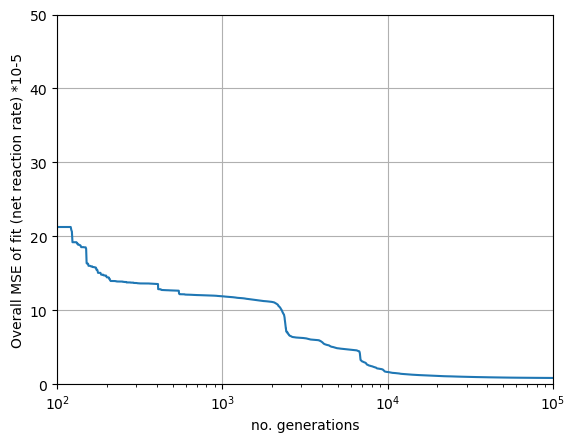

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.275812727029965
1.4841515131674898
0.7987858591652763
-4.2637613003706205
0.49415092421137746
1.1938769101632375e-05
0.3991368279469005
-5.432812645678406
0.403849825603881
5.50113404167499
4.245129357544391
4.358812981085649
0.6575499541631556
0.04611182241972929
3.1376858239291767
1.0917618920718065e-06
0.2517359138827117
-11.747487728091908
1.8573807740154855
1.5843510935389342
-11.53897393125477
1.1942579435856624
4.038343523478843
0.0027536934933576783
4.198440678149198
4.939052567823533
2.016289474712824
10.889577201236055
-1.3939220748069596
2.954895303651412
8.317423853222763
1.9418010874077691
-4.000886987045256
0.506495327076426
1.0579264614303856
-1.3010299005539745


In [37]:
res.X

array([-1.12758127e+01,  1.48415151e+00,  7.98785859e-01, -4.26376130e+00,
        4.94150924e-01,  1.19387691e-05,  3.99136828e-01, -5.43281265e+00,
        4.03849826e-01,  5.50113404e+00,  4.24512936e+00,  4.35881298e+00,
        6.57549954e-01,  4.61118224e-02,  3.13768582e+00,  1.09176189e-06,
        2.51735914e-01, -1.17474877e+01,  1.85738077e+00,  1.58435109e+00,
       -1.15389739e+01,  1.19425794e+00,  4.03834352e+00,  2.75369349e-03,
        4.19844068e+00,  4.93905257e+00,  2.01628947e+00,  1.08895772e+01,
       -1.39392207e+00,  2.95489530e+00,  8.31742385e+00,  1.94180109e+00,
       -4.00088699e+00,  5.06495327e-01,  1.05792646e+00, -1.30102990e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.275812727029965
1.6: 1.4841515131674898
0.9: 0.7987858591652763
-4.3: -4.2637613003706205
0.5: 0.49415092421137746
0.003: 1.1938769101632375e-05
0.4: 0.3991368279469005
-7.9: -5.432812645678406
0.7: 0.403849825603881
7.2: 5.50113404167499
5.7: 4.245129357544391
5.7: 4.358812981085649
0.8: 0.6575499541631556
0.03: 0.04611182241972929
3.1: 3.1376858239291767
6.000000000000001e-09: 1.0917618920718065e-06
0.1: 0.2517359138827117
-12.0: -11.747487728091908
1.9: 1.8573807740154855
1.6: 1.5843510935389342
-11.6: -11.53897393125477
1.2: 1.1942579435856624
4.0: 4.038343523478843
0.01: 0.0027536934933576783
4.2: 4.198440678149198
5.4: 4.939052567823533
2.2: 2.016289474712824
11.8: 10.889577201236055
-12.0: -1.3939220748069596
3.3: 2.954895303651412
1.8: 8.317423853222763
4.2: 1.9418010874077691
-4.0: -4.000886987045256
0.5: 0.506495327076426
1.0: 1.0579264614303856
coeff fit: 0.8320288348724649
r: 0.912156146102445
